# Navigating to maximize Information gain on a road network

Let us do a simple road network with 6 intersections where each road is two-way

```
4-------5-------6
|       |       |
|       |       |
|       |       |
1-------2-------3
```

There are really 14 directed edges:
$$
e_i \in \{(1,2),(1,4),(2,1),(2,3),(2,5),(3,2),(3,6),(4,1),(4,5),(5,4),(6,3),(6,5)\}
$$

Each edge shall also have a length associated with it. For simplicity, we shall make each edge of length 100m. A vehicle travelling along an edge shall have a position and velocity associated with it.

In [1]:
from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy.random as rand
import numpy as np
from scipy.stats import norm
import scipy.io as sio
import matplotlib as mpl
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from math import atan2
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

from IPython.display import display, Markdown, Latex

The Roadmap class is the way our target, estimates, and tracking vehicle understand the road network. It consists of nodes which are the intersections and bi-directional edges which are the roads connecting the intersections.

In [2]:
class Roadmap:
    """A class to represent a road network"""
    
    def __init__(self, nodes, edges, bidirectional=True):
        """
        nodes: list of tuples (x, y). Defines the cartesian location of each intersection.
        edges: list of tuples (start, end). Defines the roads between intersections. Each edge is 
            unidirectional.
        """
        self.graph = {node : {} for node in nodes}
        for edge in edges:
            a = edge[0]
            b = edge[1]
            dist = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
            self.graph[a][b] = dist
            if bidirectional:
                self.graph[b][a] = dist
                
        self._total_len = 0.0
        for dests in self.graph.values():
            self._total_len += np.sum(list(dests.values()))
    
#     def getEdge(self, point):
#         for start_node in self.graph:
#             for end_node in self.graph[start_node]:
#                 slope = np.array(end_node) - np.array(start_node)
#                 slope /= np.linalg.norm(slope)
#                 print(slope)
#                 print(point)
#                 print(point[0])
#                 testPoint = slope * point[0]
#                 if testPoint == point:
#                     print("Edge found: %r between %r and %r" %(point, start_node, end_node))
                
    def getNearestWaypoint(self, pos):
        waypoint = None
        min_dist = 999999999
        for node in self.graph:
            dist = (pos[0] - node[0])**2 + (pos[1] - node[1])**2
            if dist < min_dist:
                min_dist = dist
                waypoint = node
        return waypoint

    def getNextWaypoint(self, waypoint, psi):
        options = self.graph[waypoint].keys()
        next_wp = random.choice(options)
        next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
        diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
        # -(waypoint, next, psi, next_psi, diff_angle)
#         while diff_angle > 1.6:
#             next_wp = random.choice(options)
#             next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
#             diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
#             options.remove(next_wp)
#             # print(waypoint, next, psi, next_psi, diff_angle)
        return next_wp

    def get_loc(self, state):
        """Returns the (x,y) location of a position along an edge
        
        edge -- tuple containing the (x,y) coordnates of 
                the beginning and ending nodes of the edge
        pos  -- value between 0 and 1 indicating the distance along the edge
        """
        
        edge = state[0]
        pos = state[1]
        
        try:
            self.graph[edge[0]][edge[1]]
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
            
        loc = (pos*edge[1][0] + (1-pos)*edge[0][0],
               pos*edge[1][1] + (1-pos)*edge[0][1])
        return loc
    
    def getEdgeWeight(self, waypoint_a, waypoint_b, densities):
        #TODO add in particle density to weight
        #   (more particles should decrease the weight making it more likely)
        particle_density = 0
        for density in densities:
            try:
                particle_density += density[(waypoint_a, waypoint_b)]
            except:
                pass
            try:
                particle_density += density[(waypoint_b, waypoint_a)]
            except:
                pass
        return np.linalg.norm(np.array(waypoint_b) - np.array(waypoint_a))/(particle_density + .1)

    def djikstra(self, waypoint, destination, densities):
        visited = {waypoint[:2]: 0}
        path = {}
        nodes = set(self.graph.keys())
        while nodes:
            min_node = None
            for node in nodes:
                if node in visited.keys():
                    if min_node is None:
                        min_node = node
                    elif visited[node] < visited[min_node]:
                        min_node = node

            if min_node is None:
                break

            nodes.remove(min_node)
            current_weight = visited[min_node]

            for edge in self.graph[min_node]:
                weight = current_weight + self.getEdgeWeight(min_node, edge, densities)
                if edge not in visited or weight < visited[edge]:
                    visited[edge] = weight
                    path[edge] = min_node
        shortest_path = [path[destination[0:2]], destination[0:2]]
        while shortest_path[0] != waypoint[:2]:
            shortest_path.insert(0,path[shortest_path[0]])
        return shortest_path

    @property
    def total_length(self):
        return self._total_len

In [3]:
class Agent(object):
    def __init__(self, center, roadmap, dt, fov=30.):
#         self._c = center
#         self._w = width
#         self._h = height
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
#         self._period = period
        self._sc_agent = None
        self._sc_fov = None
        self.fov = fov
        self.path = [dest]
#         self.path.append(self._roadmap.getNextWaypoint(
#             self.path[len(self.path)-1],
#             atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])))
        self.current_dest = 0
        print(self.path)
        
    def update(self, densities):
        self._t += self._dt
#         print(self.path[self.current_dest], self.pos)
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = 10 * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)
#         print(self.pos)
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.current_dest += 1
            if self.current_dest == len(self.path):
                greatest_density = np.zeros(len(densities))
                best_edge = [None for i in greatest_density]
                for i in range(len(densities)):
                    density = densities[i]
                    for edge in density:
                        if best_edge[i] is None or density[edge] > greatest_density[i]:
                            if edge[0] != self.path[self.current_dest - 1]:
                                best_edge[i] = edge
                                greatest_density[i] = density[edge]

                no_edge_selected = True
                for edge in best_edge:
                    if edge is not None:
                        no_edge_selected= False
                if no_edge_selected:
                        self.path.append(self._roadmap.getNextWaypoint(self.path[self.current_dest - 1], self.psi))
                else:
                    edge_vals = [None, None]
                    density_vals = [0, 0]
                    for i in range(len(greatest_density)):
                        if greatest_density[i] > 0:
                            if greatest_density[i] > density_vals[1]:
                                edge_vals[0] = edge_vals[1]
                                density_vals[0] = density_vals[1]
                                edge_vals[1] = best_edge[i]
                                density_vals[1] = greatest_density[i]
                            elif greatest_density[i] > density_vals[0]:
                                edge_vals[0] = best_edge[i]
                                density_vals[0] = greatest_density[i]

                    if (edge_vals[0] is not None):
                        option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], edge_vals[0][0], densities)
                    else:
                        option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], edge_vals[1][0], densities)
#                     if (best_edge[0] is not None and greatest_density[0] < greatest_density[1]) or best_edge[1] is None:
#                         option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], best_edge[0][0])
#                     else:
#                         option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], best_edge[1][0])
    #                 option_b = self._roadmap.djikstra(self.path[self.current_dest - 1], best_edge[1])
                    self.path.extend(option_a)
                
#             self.dest = self._roadmap.getNextWaypoint(self.dest, self.psi)
            self.psi = atan2(self.path[self.current_dest][0] - self.pos[0], self.path[self.current_dest][1] - self.pos[1])
    
    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

In [4]:
class AgentStaticLookahead(object):
    def __init__(self, center, roadmap, pf, dt, fov=30.):

        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = 10
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0

        
    def update(self, densities, pfs):
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.updatePath(densities, pfs)
    
    def updatePath(self, densities, pfs):
        particle_map, best_path, best_value = self.buildParticleMap(self.path[self.current_dest], densities, 0, 0, 3)
#         print(self.displayParticleMap(particle_map,0))
#         print(best_path, best_value)
        self.path.append(best_path[0])
        self.current_dest += 1

    def buildParticleMap(self, start, densities, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}
        best_path = []
        best_value = 0
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            for density in densities:
                if edge0 in density:
                    value += density[edge0]
                if edge1 in density:
                    value += density[edge1]
#             tmp_pfs = deepcopy(pfs)
#             print(np.array(start) + (np.array(destination) - np.array(start))/2, (np.array(destination) - np.array(start))/2)
#             for pf in tmp_pfs:
#                 pf.neg_update(
#                     np.array(start) + (np.array(destination) - np.array(start))/2,
#                     np.linalg.norm((np.array(destination) - np.array(start))/2))
# #                 for i in range(int(np.linalg.norm(np.array(destination) - np.array(start))/self.speed)):
# #                     pf.predict()
#                 pf.predictFF(int(np.linalg.norm(np.array(destination) - np.array(start))/self.speed))
            
            graph[edge0], path, path_value = self.buildParticleMap(
                destination, densities, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
#         best_path.insert(0, start)
        return graph, best_path, best_value
    
    def displayParticleMap(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

In [5]:
class AgentDynamicLookahead(object):
    def __init__(self, center, roadmap, pf, dt, fov=30.):

        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = 10
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0

        
    def update(self, densities, pfs):
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.updatePath(densities, pfs)
    
    def updatePath(self, densities, pfs):
        particle_map, best_path, best_value = self.buildParticleMap(self.path[self.current_dest], pfs, 0, 0, 2)
#         print(self.displayParticleMap(particle_map,0))
#         print(best_path, best_value)
        self.path.append(best_path[0])
        self.current_dest += 1


    def buildParticleMap(self, start, pfs, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}
#         pf = self.lookahead[lookahead]
        densities = [pf.getEdgeParticleDensity() for pf in pfs]
#         density = pf.getEdgeParticleDensity()
        best_path = []
        best_value = 0
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            for density in densities:
                if edge0 in density:
                    value += density[edge0]
                if edge1 in density:
                    value += density[edge1]
            tmp_pfs = deepcopy(pfs)
#             print(np.array(start) + (np.array(destination) - np.array(start))/2, (np.array(destination) - np.array(start))/2)
            for pf in tmp_pfs:
                pf.neg_update(
                    np.array(start) + (np.array(destination) - np.array(start))/2,
                    np.linalg.norm((np.array(destination) - np.array(start))/2))
#                 for i in range(int(np.linalg.norm(np.array(destination) - np.array(start))/self.speed)):
#                     pf.predict()
                pf.predictFF(int(np.linalg.norm(np.array(destination) - np.array(start))/self.speed))
            graph[edge0], path, path_value = self.buildParticleMap(
                destination, tmp_pfs, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
#         best_path.insert(0, start)
        return graph, best_path, best_value
    
    def displayParticleMap(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

In [6]:
class AgentDynamicLookaheadWithEdgeSeparation(object):
    def __init__(self, center, roadmap, pf, dt, fov=30.):

        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = 10
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0

    def update(self, densities, pfs):
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.updatePath(densities, pfs)

    def updatePath(self, densities, pfs):
        edges = {}
        edge_vals = {}
        for i in range(len(pfs)):
            avg_den, min_den = pfs[i].getMaxParticleDensity()
        
            for x in pfs[i].X:
                edge, loc = x.state
                if edge not in edges:
                    edges[edge] = []
                    edge_vals[edge] = [0,0,0]
                edges[edge].append((x,i))
                edge_vals[edge][0] += 1
                edge_vals[edge][i+1] += 1
                

        particle_map, best_path, best_value = self.buildParticleMap(self.path[self.current_dest], edges, 0, 0, 2)

        self.path.append(best_path[0])
        self.current_dest += 1

    def buildParticleMap(self, start, edges, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}

        best_path = []
        best_value = 0
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            if edge0 in edges:
#                 print(edges[edge0])
                value += len(edges[edge0][0])
            if edge1 in edges:
                value += len(edges[edge1][0])
            new_edges = {}
            for edge in edges:
                if edge == edge0 or edge == edge1:
                    value += len(edges[edge][0])
                else:
                    particle_list = deepcopy(edges[edge])
                    for particle in particle_list:
                        particle[0].moveForward(int(np.linalg.norm(np.array(destination) - np.array(start))/self.speed) * particle._dt)
                        if particle[0].state[0] not in new_edges:
                            new_edges[particle[0].state[0]] = []
                        new_edges[particle[0].state[0]].append(particle)
            
            graph[edge0], path, path_value = self.buildParticleMap(
                destination, new_edges, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
#         best_path.insert(0, start)
        return graph, best_path, best_value
    
    def displayParticleMap(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

In [7]:
class AgentLookaheadDjikstra(object):
    def __init__(self, center, roadmap, dt, fov=30.):

        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.fov = fov
        self.path = [dest]
        self.path.append(self._roadmap.getNextWaypoint(
            self.path[len(self.path)-1],
            atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])))
        self.current_dest = 0
        
    def update(self, densities):
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = 10 * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.current_dest += 1
#             self.path = self.path[:self.current_dest]
            if self.current_dest == len(self.path):
                greatest_density = np.zeros(len(densities))
                best_edge = [None for i in greatest_density]
                for i in range(len(densities)):
                    density = densities[i]
                    for edge in density:
                        if best_edge[i] is None or density[edge] > greatest_density[i]:
                            if edge[0] != self.path[self.current_dest - 1]:
                                best_edge[i] = edge
                                greatest_density[i] = density[edge]

                no_edge_selected = True
                for edge in best_edge:
                    if edge is not None:
                        no_edge_selected= False
                if no_edge_selected:
                        self.path.append(self._roadmap.getNextWaypoint(self.path[self.current_dest - 1], self.psi))
                else:
                    edge_vals = [None, None]
                    density_vals = [0, 0]
                    for i in range(len(greatest_density)):
                        if greatest_density[i] > 0:
                            if greatest_density[i] > density_vals[1]:
                                edge_vals[0] = edge_vals[1]
                                density_vals[0] = density_vals[1]
                                edge_vals[1] = best_edge[i]
                                density_vals[1] = greatest_density[i]
                            elif greatest_density[i] > density_vals[0]:
                                edge_vals[0] = best_edge[i]
                                density_vals[0] = greatest_density[i]

                    if (edge_vals[0] is not None):
                        option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], edge_vals[0][0], densities)
                    else:
                        option_a = self._roadmap.djikstra(self.path[self.current_dest - 1], edge_vals[1][0], densities)

                    self.path.extend(option_a[0:2])
                
            self.psi = atan2(self.path[self.current_dest][0] - self.pos[0], self.path[self.current_dest][1] - self.pos[1])
    
    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

We need to build a 

In [8]:
class Particle(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=0.1):
        """A Particle contains the state and dynamic model of one hypothesis of a vehicle location.
        
        The particle's state consists of which road segment the vehicle is on and how far along 
        that road segment the vehicle is, on a scale of 0 to 1. The particle also stores its 
        nominal velocity and noise characteristics.
        
        roadmap -- object containing a graph describing the network of roads
        
        """
        # current edge
        self._roadmap = roadmap
        if e0 is None:
            a = random.choice(list(self._roadmap.graph.keys()))
            b = random.choice(list(self._roadmap.graph[a].keys()))
            self._e = (a, b)
        else:
            self._e = e0
        self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
        # current position on edge 
        if x0 is None:
            self._x = random.random()
        else:
            self._x = x0
        self._v = v0
        self._sigma = sigma
        self._dt = dt
        
    def predict(self):
        """Propogate the particle's state based on its dynamics and the roadmap
        
        When a particle is updated, it moves along the road segment by v0*dt, normalized by the 
        length of its current road. If it reaches the end of the road (x >= 1), it queries the
        roadmap for other roads that connect to the current intersection and chooses one at
        random.
        """
        n = rand.normal(scale=self._sigma)
        self._x += (self._v + n)*self._dt
        
        if self._x >= self._e_len:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x = 0.
            
        return self.state
    
    def moveForward(self, dt):
        n = rand.normal(scale=self._sigma)
        self._x += (self._v + n)*dt
        
        if self._x >= self._e_len:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x = (self._x - self._e_len)/self._e_len
            
        return self.state

    @property
    def loc(self):
        return np.array(self._e[0] + (self.e[1] - self.e[0])*(self._x/self._e_len))
            
    @property
    def state(self):
        return (self._e, self._x/self._e_len)

    @state.setter
    def state(self, new_state):
        e = new_state[0]
        x = new_state[1]
        try:
            self._roadmap.graph[e[0]][e[1]]
            self._e = e
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        if x < 0.:
            self._x = 0.
        elif x > 1.:
            self._x = 1.
        else:
            self._x = x
        self._x *= self._e_len
    @property
    def loc(self):
        return self._roadmap.get_loc(self.state)

In [9]:
from scipy.stats import multivariate_normal as mvn
import copy

class PF(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.1):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            self.X = [Particle(self._roadmap, v0=self._v0, dt=dt, sigma=sigma) for i in range(self._N)]
        else:
            raise NotImplementedError

        self.best = self.X[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def getMaxParticleDensity(self):
        avg_dist = 0
        min_avg_dist = 999999
        for x in self.X:
            dist = 0
            for y in self.X:
                dist += np.linalg.norm(np.array(y.loc) - np.array(x.loc))
#                 print(dist)
            dist /= len(self.X)
            avg_dist += dist
            if dist < min_avg_dist:
                min_avg_dist = dist
        avg_dist /= len(self.X)
#         print(avg_dist)
        return avg_dist, min_avg_dist

    def getParticleDistanceFromTarget(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        for x in self.X:
            dist = np.linalg.norm(np.array(loc) - np.array(x.loc))
            if dist <= acceptable_distance:
                num_in_distance += 1
            avg += dist
        avg /= len(self.X)
        return avg, num_in_distance
        
    def getEdgeParticleDensity(self):
        edges = {}
        for x in self.X:
            edge = x.state[0]
            if edge not in edges:
                edges[edge] = 1
            else:
                edges[edge] += 1
        return edges
        
    def get_measurement_log_likelihood(self, z, R):
        return np.sum([mvn.logpdf(x.loc, z, R) for x in self.X])

    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            Xbar.append(copy.deepcopy(self.X[i]))
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate the particles
#         pdb.set_trace()
        for x in self.X:
            x.predict()
    
    def predictFF(self, timestep):
        for x in self.X:
            x.moveForward(timestep * self._dt)
        
    def update(self, z, R, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        for i, x in enumerate(self.X):
            wi = (1. - self._P_fa)*mvn.pdf(x.loc, z, R)
            # add in a 1% mixture of uniform over range measurements between 1m and 11m
            wi += self._P_fa*(1./self._roadmap.total_length)
            w[i] = np.log(wi)
            #w[i] = mvn.logpdf(x.loc, z, R)
            
#             print(w)
        # logsumexp
#         print("log w: {}".format(w))
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
        
        self.best_idx = np.argmax(w)        
        best = self.X[self.best_idx]
# #         print("w: {}".format(w))
        
        unique = self.lowVarSample(w)
#         print(unique)
#         # add some noise to account for sparsity in particles
# #         if unique/self.num_particles < 0.5:
# #             Q = self.P/((self.num_particles*unique)**(1/self.n))
# #             self.X += np.random.multivariate_normal(np.zeros(self.n), Q, size=self.num_particles).T

        
        # grab the most likely particle before resampling instead
        self.best = best
    
    def neg_update(self, z, radius):
        w = np.zeros(self._N)
        for i, x in enumerate(self.X):
#             print(np.linalg.norm(x.loc - z) < radius)
            if np.linalg.norm(x.loc - z) < radius:
                w[i] = np.log(self._P_miss)#-2.0
        
        w = np.exp(w)
        w = w/np.sum(w)
        unique = self.lowVarSample(w)

In [10]:
class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        
    def getEdgeParticleDensity(self):
        edges = []
        for pf in self.best:
            edges.append({})
            for x in pf.X:
                edge = x.state[0]
                if edge not in edges[-1]:
                    edges[-1][edge] = 1
                else:
                    edges[-1][edge] += 1
        return edges

    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
       
        
    def update(self, z, R, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        for i, x in enumerate(self.X):
            # get the likelihood that the measurement came from each target
            ll = np.array([xi.get_measurement_log_likelihood(z, R) for xi in x])
#             print(ll)
            max_ll = np.max(ll)
            l = np.exp(ll-max_ll)
            # normalize the likelihoods so we can randomly choose a corresponding target
            # with some smart probabilites
            l = l/np.sum(l)
            t = np.where(np.random.multinomial(1, l) == 1)[0][0]
            w[i] = x[t].get_measurement_log_likelihood(z, R)
            x[t].update(z, R)
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

In [11]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (0.,100), (100.,100.), (200.,100.)]
edges = [[i[0], i[1]],
         [i[0], i[3]],
         [i[1], i[2]],
         [i[1], i[4]],
         [i[2], i[5]],
         [i[3], i[4]],
         [i[4], i[5]]]

# initialize the roadmap
r = Roadmap(i, edges)

In [12]:
# def main():
#     # create 100 particles on the roads
#     N = 200
#     dt = 0.1

#     P_fa = 0.02
#     P_miss = 0.05
#     # pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':5, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
#     # rbpf = RB_PF(r, 10, 2, pf_args)


#     pfs = [
#         PF(r, N, dt=dt, v0=5, sigma=4, P_fa=P_fa, P_miss=P_miss),
#         PF(r, N, dt=dt, v0=5, sigma=4, P_fa=P_fa, P_miss=P_miss)
#     ]

#     R = 5*np.eye(2)

#     targets = [
#         Particle(r, v0=5, dt=dt, sigma=2),
#         Particle(r, v0=5, dt=dt, sigma=2)
#     ]

#     agent = AgentDynamicLookaheadWithEdgeSeparation((100, 60), r, pfs, dt=dt)
#     # agent = AgentLookahead((100, 60), r, dt=dt)
#     # agent = AgentLookaheadDjikstra((100, 60), r, dt=dt)

#     lc = mc.LineCollection(edges, colors=[(0,0,0,1)])

#     fig, ax = plt.subplots()
#     ax.add_collection(lc)

#     scs = []
#     locs = []
#     sc_targets = []
#     colors = ['green', 'blue', 'red', 'yellow']
    
#     for i  in range(len(pfs)):
#         pf = pfs[i]
#         x0 = []
#         y0 = []
#         for p in pf.X:
#             loc = r.get_loc(p.state)
#             x0.append(loc[0])
#             y0.append(loc[1])
#         scs.insert(i, ax.scatter(x0, y0, s=10, linewidth=0, facecolor=colors[i], label='particles'))
#         locs.insert(i, r.get_loc(targets[i].state))
#         sc_targets.insert(i, ax.scatter([locs[i][0]], [locs[i][1]], s=100, marker='*', facecolor=colors[i], label='target'))


#     agent.init_plot(ax)
#     ax.legend()

#     ax.set_xlim(-20, 300)
#     ax.set_ylim(-20, 220)
#     ax.set_aspect('equal')

#     fig.canvas.draw()
#     start = time.time()
#     Ts = dt
#     tic = start
    
# #     average_avg_densities = [[] for pf in pfs]
# #     average_min_densities = [[] for pf in pfs]
#     avg_distance = [[] for pf in pfs]
#     num_in_threshold = [[] for pf in pfs]

#     # update the scenario
#     for i in tqdm(range(int(1000/Ts))):
#         for j in range(len(pfs)):
#             pfs[j].predict()
#             targets[j].predict()
#             dist = np.linalg.norm(targets[j].loc - agent.pos)
# #             print(dist)

#             if i % int(1/Ts) == 0 and i != 0:
#                 if dist < agent.fov:
# #                     print('hey')
#                     z = mvn.rvs(targets[j].loc, R)
#                     pfs[j].update(z, R)
#                 else:
#                     pfs[j].neg_update(agent.pos, radius=30)
#             locs[j] = [p.loc for p in pfs[j].X]
#             scs[j].set_offsets(locs[j])
#             sc_targets[j].set_offsets(targets[j].loc)
            
#             # Get Metric information
#             targets[j].loc
#             pfs[j]
#             avg_dist, num_under_threshold = pfs[j].getParticleDistanceFromTarget(targets[j].loc, 10)
#             avg_distance[j].append(avg_dist)
#             num_in_threshold[j].append(num_under_threshold)
# #             avg_density, min_density = pfs[j].getMaxParticleDensity()
# #             average_avg_densities[j].append(avg_density)
# #             average_min_densities[j].append(min_density)
#         densities = [pf.getEdgeParticleDensity() for pf in pfs]
#         agent.update(densities, pfs)
        
#         fig.canvas.draw()
#         toc = time.time()
#         dur = toc - tic
        

#         tic = toc
#     dur = time.time() - start
#     print(dur)
# #     print(average_avg_densities)
# #     print(average_min_densities)
#     time_under_threshold = [0,0]
#     for i in range(len(pfs)):
#         for j in range(len(avg_distance[i])):
#             if avg_distance[i][j] < 25:
#                 time_under_threshold[i] += 1
#     for i in range(len(pfs)):
#         print('avg', sum(avg_distance[i])/len(avg_distance[i]))
#         print('num', sum(num_in_threshold[i])/len(num_in_threshold[i]))
#         print('time under threshold:', time_under_threshold[i]/len(num_in_threshold[i]))
# #         print(average_avg_densities[i][-1], average_min_densities[i][-1])
# #         print(sum(average_avg_densities[i])/len(average_avg_densities[i]),
# #               sum(average_min_densities[i])/len(average_min_densities[i]))
# #     , average_min_densities[0]/len(average_min_densities[0]))
# #     print('avg densities')
# #     print(average_avg_densities)
# #     print('min densities')
# #     print(average_min_densities)
# main()

The structure being worked with is very much a dynamic graph. In order to acheive maximum information gain and target location certainty there are a few difficulties that need to be handled. The path planning of the target needs to take into account how the targets and therefore the particles will move so that a particle five edges away is believed to have moved five edges worth of distance by the time the agent would get to that edge. This will need to be done for every particle for as many time steps in the future is required. This will require a lot of processing on the first time step after any target sighting but will only require one timestep prediction when the predictions are fully fleshed out.

Problem:
We have an unknown number of targets that are coming in and out of a search area. There are a few different goals possible:
* Find the target in the least amount of time possible
* Minimize the amount of time a target is below a given certainty level
** This can likely be acheived by maximizing particle density
** It will be important to remember not to focus on one target over another
** An alternative to this is to deal with particle certainty instead of particle density or a combination of them both

Methods to achieve these goals:
* static
** lookahead
*** Check each edge at an intersection and go towards the edge that will have the most particles on it
*** look at multiple edge paths and select the one with the most particles along that path at this instant
** djikstra
*** use distance and number of particles to determine edge cost
** lookahead djikstra
*** like regular djikstra but revaluate path after every edge traversal
* dynamic
** lookahead
*** assume target is not sighted down a potential path, so particles along edge being traversed are elliminated
*** Next step is to allow the remaining particles to propogate and then evealuate next set of edges and repeat
****This process has the issue where we treat all particles on a given edge as if they are all in the same location.
****if we assume that all edges are of equal length that may 

Because the particle filter resets the weights of all the particles during every resample process. the only way to accurately detect the certainty of target estimation at any given time is to measure the distance between each particle. This is O(n^2) which is not ideal. Also to avoid being more complicated absolute distances were measured when for perfect accuracy distance should be measured along the road network not as the crow flies.

Simply looping through all the particles to determine metric values is an O(n^2) operation converting a 5 minute simulation into a 2 hour simulation. This is of course unsustainable for development and evaluation although irrelevant for production. Because of this it is necessary to convert the particles in the particle filter into elements in a numpy array rather than objects in a list.

In [12]:
from scipy.stats import multivariate_normal as mvn
import copy

class PF_vectorized(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.1):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        # particle shape
        ## x, y, velocity, start, end, sigma
        self._particles = np.ndarray(shape=(self._N, 12))
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            for i in range(self._N):
                a = random.choice(list(self._roadmap.graph.keys()))
                b = np.array(random.choice(list(self._roadmap.graph[a].keys())))
                a = np.array(a)
                vector = b - a
                loc = a + vector * random.random()
                distance = np.linalg.norm(vector)
                vector = vector/distance
                self._particles[i] = [loc[0], loc[1], v0, a[0], a[1], b[0],
                                      b[1], vector[0], vector[1], distance, sigma, 1/num_particles]

        else:
            raise NotImplementedError

        self.best = self._particles[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def getParticleDistanceFromTarget(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        dist = np.linalg.norm(self._particles[:,0:2] - loc, axis=1)
        num_in_distance = len(np.where(dist < acceptable_distance)[0])
        avg = np.average(dist)
        return avg, num_in_distance

    def getMaxParticleDensity(self):
        overall_avg = 0
        min_avg = 9999999999
        for i in range(len(self._particles)):
            dist = np.linalg.norm(self._particles[:,0:2] - self._particles[i,0:2], axis=1)
            avg_dist = np.average(dist)
            overall_avg += avg_dist
            if avg_dist < min_avg:
                min_avg = avg_dist
        return overall_avg, min_avg

    def getEdgeParticleDensity(self):
        edges = {}
        edges_present, count = np.unique(self._particles[:, 3:7], axis=0, return_counts=True)
        for i in range(len(edges_present)):
            start_edge = (edges_present[i][0], edges_present[i][1])
            end_edge = (edges_present[i][2], edges_present[i][3])
            edges[(start_edge, end_edge)] = count[i]
        return edges

    def get_measurement_log_likelihood(self, z, R):
        return np.sum([mvn.logpdf(x.loc, z, R) for x in self.X])

    def lowVarSample(self):
        M = self._N
        r = np.random.uniform(0,1/M)
        c = self._particles[0,11]
        new_particles = np.zeros_like(self._particles)
        i = 0
        last_i = 1
        unique = 1
        insert_index = 0
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + self._particles[i,11]
            new_particles[insert_index] = copy.deepcopy(self._particles[i])
            insert_index += 1
            if last_i != i:
                unique += 1
            last_i = i
        self._particles = new_particles
        return unique

    def predict(self, timestep=1):
        old_particles = deepcopy(self._particles)
        n = rand.normal(scale=self._particles[:,10:11])
#         print('particle', np.average(n))
        loc = self._particles[:,0:2]
        vector = self._particles[:,7:9]
        speed = self._particles[:,2:3]
        loc[...] += vector * ((speed + n) * timestep * self._dt)
        update_vector = np.linalg.norm(self._particles[:,0:2] - self._particles[:,3:5], axis=1) \
            > self._particles[:,9]

        for i in np.where(update_vector)[0]:
            a = (self._particles[i,3], self._particles[i,4])
            b = (self._particles[i,5], self._particles[i,6])

            dest_list = list(self._roadmap.graph[b].keys())
            dest_list.remove(a)
            a = self._particles[i,5:7]
            b = np.array(random.choice(dest_list))
            vector = b - a
            distance = np.linalg.norm(vector)
            vector = vector/distance
            self._particles[i,0:10] = [a[0], a[1], self._v0, a[0], a[1], b[0],
                           b[1], vector[0], vector[1], distance]
        
    def update(self, z, R, p_fa=None):
        weight_addon = self._P_fa/self._roadmap.total_length
        w = (1. - self._P_fa)*mvn.pdf(self._particles[:,0:2], z, R) + weight_addon
        
        ##
        
        w = np.log(w)

        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)

        self.best_idx = np.argmax(w)  
        self.best = self._particles[self.best_idx]
        self._particles[:,11] = w

        unique = self.lowVarSample()

    def neg_update(self, z, radius):
        self._particles[:,11] = 1
        update_vector = np.linalg.norm(self._particles[:,0:2] - z, axis=1) < radius
        self._particles[update_vector,11] = self._P_miss
        self._particles[:,11] /= np.sum(self._particles[:,11])
        unique = self.lowVarSample()


In [13]:
import pickle

class AgentDynamicLookaheadWithEdgeSeparationVectorized(object):
    def __init__(self, center, roadmap, pf, dt, fov=30.):

        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.getNearestWaypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = 10
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0

    def update(self, densities, pfs):
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.updatePath(densities, pfs)

    def updatePath(self, densities, pfs):
        edges = {}
        edge_vals = {}
        predicted_certainty = []
        for i in range(len(pfs)):
            predicted_certainty.append(99999999)
            for j in range(len(pfs[i]._particles)):
                avg_distance = np.linalg.norm(
                    np.linalg.norm(pfs[i]._particles[:,0:2] - pfs[i]._particles[j,0:2], axis=1))
                if avg_distance < predicted_certainty[-1]:
                    predicted_certainty[-1] = avg_distance
        target_weights = predicted_certainty / np.linalg.norm(predicted_certainty)
#         print(predicted_certainty, target_weights)
        for i in range(len(pfs)):
            avg_den, min_den = pfs[i].getMaxParticleDensity()
            for j in range(len(pfs[i]._particles)):
                edge = ((pfs[i]._particles[j][3], pfs[i]._particles[j][4]),(pfs[i]._particles[j][5], pfs[i]._particles[j][6]))
                if edge not in edges:
                    edges[edge] = []
                    edge_vals[edge] = [0,0,0]
                particle = deepcopy(pfs[i]._particles[j,:])
                particle = np.append(particle, i)
                edges[edge].append(particle)
                edge_vals[edge][0] += 1
                edge_vals[edge][i+1] += 1

        particle_map, best_path, best_value = self.buildParticleMap(
            self.path[self.current_dest], edges, target_weights, 0, 0, 3)

        self.path.append(best_path[0])
        self.current_dest += 1

    def buildParticleMap(self, start, edges, target_weights, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}

        best_path = []
        best_value = 0
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            if edge0 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge0])[:,12], np.array(i))
                    val = len(np.where(idx)[0])
#                     print(val, target_weights[i] * val)
                    value += target_weights[i] * val
            if edge1 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge1])[:,12], np.array(i))
                    val = len(np.where(idx)[0])
#                     print(val, target_weights[i] * val)
                    value += target_weights[i] * val
            new_edges = {}
            for edge in edges:
                if edge == edge0 or edge == edge1:
                    value += len(edges[edge][0])
                else:
                    particles = np.array(deepcopy(edges[edge]))
                    particles[:,0:2] = particles[:,0:2] + particles[:,7:9] * (particles[:,2:3] * self._dt)
                    update_vector = np.linalg.norm(particles[:,0:2] - particles[:,3:5]) > particles[:,9]
                    for particle in particles[update_vector]:
                            a = tuple(particle[3:5])
                            b = tuple(particle[5:7])

                            dest_list = list(self._roadmap.graph[b].keys())
                            dest_list.remove(a)
                            a = particle[5:7]
                            b = np.array(random.choice(dest_list))
                            vector = b - a
                            distance = np.linalg.norm(vector)
                            vector = vector/distance
                            particle[0:10] = [a[0], a[1], particle[2], a[0], a[1], b[0],
                                           b[1], vector[0], vector[1], distance]
                            new_edge = ((particle[3], particle[4]), (particle[5], particle[6]))
                            if new_edge not in new_edges:
                                new_edges[new_edge] = []
                            new_edges[new_edge].append(particle)
                    
                    
            graph[edge0], path, path_value = self.buildParticleMap(
                destination, new_edges, target_weights, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
        return graph, best_path, best_value
    
    def displayParticleMap(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]



<IPython.core.display.Javascript object>


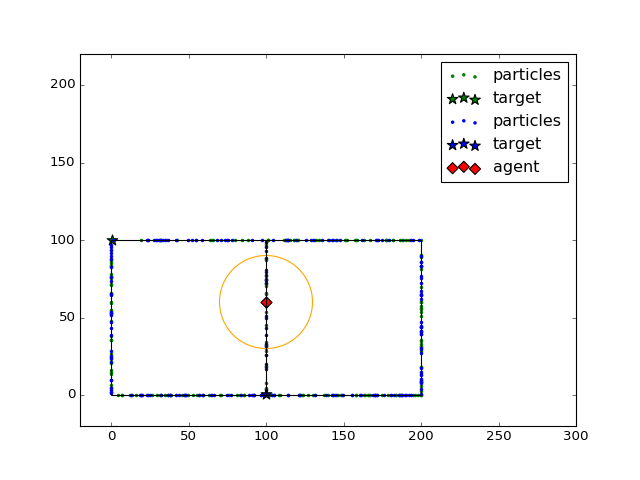

TypeError: unique() got an unexpected keyword argument 'axis'

In [15]:
def main_vectorized():
    # create 100 particles on the roads
    N = 200
    dt = 0.1

    P_fa = 0.02
    P_miss = 0.05
    target_v0 = 5
    # pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':5, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
    # rbpf = RB_PF(r, 10, 2, pf_args)


    pfs = [
        PF_vectorized(r, N, dt=dt, v0=target_v0, sigma=2, P_fa=P_fa, P_miss=P_miss),
        PF_vectorized(r, N, dt=dt, v0=target_v0, sigma=2, P_fa=P_fa, P_miss=P_miss)
    ]

    R = 5*np.eye(2)

    targets = [
        Particle(r, v0=target_v0, dt=dt, sigma=2),
        Particle(r, v0=target_v0, dt=dt, sigma=2)
    ]

    agent = AgentDynamicLookaheadWithEdgeSeparationVectorized((100, 60), r, pfs, dt=dt)
    # agent = AgentLookahead((100, 60), r, dt=dt)
    # agent = AgentLookaheadDjikstra((100, 60), r, dt=dt)

    lc = mc.LineCollection(edges, colors=[(0,0,0,1)])

    fig, ax = plt.subplots()
    ax.add_collection(lc)

    scs = []
    locs = []
    sc_targets = []
    colors = ['green', 'blue', 'red', 'yellow']
    
    for i  in range(len(pfs)):
        pf = pfs[i]
        x0 = []
        y0 = []
        for p in pf._particles:
#             loc = r.get_loc(p.state)
            x0.append(p[0])
            y0.append(p[1])
        scs.insert(i, ax.scatter(x0, y0, s=10, linewidth=0, facecolor=colors[i], label='particles'))
        locs.insert(i, r.get_loc(targets[i].state))
        sc_targets.insert(i, ax.scatter([locs[i][0]], [locs[i][1]], s=100, marker='*', facecolor=colors[i], label='target'))


    agent.init_plot(ax)
    ax.legend()

    ax.set_xlim(-20, 300)
    ax.set_ylim(-20, 220)
    ax.set_aspect('equal')

    fig.canvas.draw()
    start = time.time()
    Ts = dt
    tic = start
    
#     average_avg_densities = [[] for pf in pfs]
#     average_min_densities = [[] for pf in pfs]
    avg_distance = [[] for pf in pfs]
    num_in_threshold = [[] for pf in pfs]

    # update the scenario
    for i in tqdm(range(int(1000/Ts))):
        for j in range(len(pfs)):
            pfs[j].predict()
            targets[j].predict()
            dist = np.linalg.norm(targets[j].loc - agent.pos)
#             print(dist)

            if i % int(1/Ts) == 0 and i != 0:
                if dist < agent.fov:
#                     print('hey')
                    z = mvn.rvs(targets[j].loc, R)
                    pfs[j].update(z, R)
                else:
                    pfs[j].neg_update(agent.pos, radius=30)
            locs[j] = [(p[0], p[1]) for p in pfs[j]._particles]
            scs[j].set_offsets(locs[j])
            sc_targets[j].set_offsets(targets[j].loc)
            
            # Get Metric information
            targets[j].loc
            avg_dist, num_under_threshold = pfs[j].getParticleDistanceFromTarget(targets[j].loc, 10)
            avg_distance[j].append(avg_dist)
            num_in_threshold[j].append(num_under_threshold)
#             avg_density, min_density = pfs[j].getMaxParticleDensity()
#             average_avg_densities[j].append(avg_density)
#             average_min_densities[j].append(min_density)
        densities = [pf.getEdgeParticleDensity() for pf in pfs]
        agent.update(densities, pfs)
        
        fig.canvas.draw()
        toc = time.time()
        dur = toc - tic
        

        tic = toc
    dur = time.time() - start
    print(dur)
#     print(average_avg_densities)
#     print(average_min_densities)
    time_under_threshold = [0,0]
    for i in range(len(pfs)):
        for j in range(len(avg_distance[i])):
            if avg_distance[i][j] < 25:
                time_under_threshold[i] += 1
    for i in range(len(pfs)):
        print('avg', sum(avg_distance[i])/len(avg_distance[i]))
        print('num', sum(num_in_threshold[i])/len(num_in_threshold[i]))
        print('time under threshold:', time_under_threshold[i]/len(num_in_threshold[i]))

main_vectorized()

In [16]:
# #avg densities
# avgs = [[99.97039770331287, 99.90198586621736, 99.84160642869533, 99.8124514714059, 99.75557826543881, 99.68082706261677, 99.63156974212433, 99.60200250748086, 99.53772035470067, 99.49987726702122, 105.39263164051864, 105.30887323608724, 105.28543645052457, 105.28775445690727, 105.27410227728149, 105.25514442725728, 105.22121502725075, 105.19977709174348, 105.1826746340235, 105.16086078804045, 105.56844780377725, 105.54376286085459, 105.49748670185357, 105.43923502353788, 105.40198551920665, 105.35238693546782, 105.3154974387562, 105.28340477482952, 105.22672104209114, 105.19549756594363, 105.13154282946397, 105.12221951982359, 105.095991617451, 105.09145815951675, 105.06914669626133, 105.0634959875685, 105.04188765814155, 105.02147088554273, 105.01831248364786, 105.01206314701525, 105.17722408007826, 105.17722444650623, 105.1897128721387, 105.20765431399805, 105.2341255273595, 105.25567250953672, 105.24747533613574, 105.22470319046468, 105.21737551904458, 105.23263792852451, 105.23810383079723, 105.19818053025679, 105.20237194299176, 105.19294208884068, 105.21800974025241, 105.24466712300982, 105.25389144674678, 105.23475274260112, 105.23189675539814, 105.24567512949248, 105.01256080329976, 105.02153646758137, 105.00291434807525, 105.01970345657017, 105.01785858261093, 105.02012034900366, 105.00468862945995, 105.00439382333917, 104.97685739608191, 104.9920881520871, 105.02422027661916, 105.05698217564073, 105.08605610152041, 105.09738524494013, 105.0990908030194, 105.12131975824656, 105.14042306467144, 105.15921257331757, 105.18041179477994, 105.19136507214976, 104.6577796606804, 104.6676519498685, 104.6901236414069, 104.69536459048616, 104.69653727102344, 104.6808336911821, 104.71735454269438, 104.76304312694536, 104.77715159137531, 104.79730156672822, 104.44895516783748, 104.46374661600099, 104.45826958501345, 104.47192810420356, 104.49192419989093, 104.47267729847768, 104.45647410828451, 104.43463022240388, 104.43851414412475, 104.47246311201906, 103.44108217310355, 103.44274900494243, 103.45812734443665, 103.47780016069393, 103.48925898394836, 103.46710955862137, 103.52022023225709, 103.50442894538055, 103.49667609518121, 103.48071032256536, 98.34765700662712, 98.3266233272429, 98.37863425269941, 98.42307174162221, 98.44500494343906, 98.42711668036475, 98.44451514131474, 98.48643022909117, 98.50771584699635, 98.50563052581491, 97.06232794253656, 97.08463113693547, 97.11379454940365, 97.09821865800423, 97.11287573069987, 97.16520408698469, 97.15083257114397, 97.17560761698795, 97.19481855787261, 97.19950066081408, 97.26036174335063, 97.29022581121352, 97.34082799658046, 97.38391040216773, 97.43455932741426, 97.47281199172325, 97.46451430016512, 97.50855889020141, 97.50290724492862, 97.50504541573918, 97.52114651272456, 97.54017631111174, 97.55258299566954, 97.50859570446727, 97.56569966856203, 97.55572154696632, 97.56931716714254, 97.56131350915648, 97.56473156119966, 97.57713227768174, 97.58113715761561, 97.59524465044362, 97.57457731141784, 97.59338418624644, 97.59193577135873, 97.64846470022154, 97.62574016785332, 97.61060981775125, 97.61451958904706, 97.57952666898532, 97.5772633042411, 97.55634886336723, 97.55752463473276, 97.56498562626162, 97.56542365665166, 97.54815121939069, 97.54051333123132, 97.52400414648915, 97.4919213928048, 97.4407864933051, 93.14633209466488, 93.14710464920158, 93.10714600648454, 93.08135337790632, 93.03887197550806, 93.0396194100192, 92.99935335215758, 92.98965010408628, 92.9496379459515, 92.95203175253398, 92.09090837675076, 92.07618375815872, 92.0241065433759, 92.00487434821616, 91.92876698362599, 91.90189027284985, 91.84949199170558, 91.84781216177292, 91.77817064095241, 91.79490850557588, 88.62284039474187, 88.64008414200234, 88.62822558290007, 88.57618187191501, 88.58456296110658, 88.56646746411728, 88.53783388128976, 88.52888529396226, 88.49195502747918, 88.4870695784959, 85.21009314301189, 85.17581575892213, 85.13462231730865, 85.1618897704474, 85.11565768906375, 85.09603764060306, 85.09637249255262, 85.07176901848958, 85.0370871943484, 84.95575712746526, 84.42866279289393, 84.37401171978368, 84.33187535594335, 84.29301001859587, 84.27803840851128, 84.28066176953206, 84.22260607594531, 84.24345898485619, 84.21676952276017, 84.20580122816233, 81.81046604770121, 81.82608850207386, 81.81069650806508, 81.81689584391397, 81.8393385775168, 81.85003594336291, 81.85236078669685, 81.85144918659458, 81.84211834675385, 81.82832563421995, 80.68068866807288, 80.70433788250527, 80.68983516950476, 80.69086524424381, 80.69555438121962, 80.72403284915198, 80.73804490622007, 80.79147501986974, 80.81401120096358, 80.8558647431017, 79.58298892205718, 79.67553233169733, 79.73683374000181, 79.75452194451589, 79.8135809567195, 79.84898294792066, 79.89676793921473, 79.94943622785242, 80.028026357086, 80.07054530278269, 79.25628770919185, 79.32264066732633, 79.3895182331957, 79.4617305651495, 79.50324497286826, 79.59855239324067, 79.66416963709416, 79.74085992011541, 79.83157464719476, 79.87156506948351, 79.29976839506777, 79.37230322817133, 79.4506676569447, 79.47645594432592, 79.49073429106149, 79.51457070881051, 79.53839075158176, 79.55359249612384, 79.58025962712588, 79.61219251854182, 79.45527818033902, 79.46043778243724, 79.5099708542616, 79.55627601075001, 79.5881942222311, 79.59885825975245, 79.61211669477409, 79.67685387851891, 79.7378832765713, 79.76555815930791, 79.28972008350473, 79.31649528070761, 79.31178620483888, 79.34155134814868, 79.38437307639317, 79.39756874299994, 79.47501260361236, 79.53707034918871, 79.56512213654963, 79.61354957822918, 79.24054371899739, 79.2710805629182, 79.3305689084608, 79.3745763128932, 79.46367003795413, 79.53890404157708, 79.5853817943587, 79.65090063558029, 79.73476140822667, 79.8081535691503, 79.81771823496712, 79.93898383593819, 79.98193545997745, 80.06019139213038, 80.13457841733373, 80.20929245623842, 80.38139760675594, 80.46755074470961, 80.60590634208917, 80.7280582587104, 80.24647800201446, 80.34717425228241, 80.46202942374904, 80.57264156060623, 80.71374153420001, 80.82322025433344, 80.8626525852399, 80.98110403496871, 81.1285729968044, 81.2666702398649, 81.38498007758234, 81.48645015243895, 81.60537081651013, 81.70605955072442, 81.85016076458837, 81.98189731126085, 82.12904580243372, 82.27455591933867, 82.39664153734685, 82.52688152095105, 82.64455310208251, 82.73684713932452, 82.80508696976754, 82.95028377612705, 83.06606459762827, 83.17569165877634, 83.27538702692124, 83.41608143104362, 83.48569802667022, 83.60663410209361, 84.38691949731727, 84.51241489178607, 84.63590188779352, 84.77389196637512, 84.830026785055, 84.90742908232292, 85.04190709172637, 85.17012512226826, 85.26159655454227, 85.32822859562285, 86.42983337755686, 86.54827538201265, 86.7190725315015, 86.83007577468003, 86.99528589544965, 87.11338215133692, 87.22810423966517, 87.34706518020515, 87.44489802779886, 87.56072383413533, 88.16855463924654, 88.27931067753498, 88.33194919321053, 88.42860043675284, 88.52429475836541, 88.58306813758931, 88.67638646139304, 88.76139896973766, 88.81951110228833, 88.93414696268923, 89.18483868343272, 89.26679856275328, 89.36558688006772, 89.44757418777705, 89.56059880513033, 89.67837405045663, 89.74653279356406, 89.81982760053901, 89.94567697481266, 90.03020679711108, 35.11098818150498, 35.431747591637716, 35.68131295022092, 35.83527477279365, 35.98463320991857, 36.15153557080384, 36.33532906938187, 36.47778441162305, 36.65309194355834, 36.817185371744905, 26.20933508603285, 26.379475593866893, 26.515497626063492, 26.64803519180641, 26.764097796698188, 26.901825690044515, 27.06981973024126, 27.2117489236348, 27.322986755460647, 27.41462338562482, 7.167306557914734, 7.510359597188062, 7.697131493424419, 7.861997272276872, 7.961683625041395, 8.071107258571812, 8.182468586790216, 8.244458113141455, 8.319237369965323, 8.427857290245184, 6.307816723479233, 6.440301590544006, 6.5392209225708475, 6.629907717754732, 6.6870020190536374, 6.759217938532461, 6.864474498865772, 6.970240104939069, 7.0780010492782655, 7.170827804337095, 6.205460420576802, 6.471046544831625, 6.690962397690418, 6.964659408152082, 7.156237711915326, 7.379383110035543, 7.604603763625421, 7.836850898268309, 8.080185211037545, 8.258286198843887, 2.245196560449458, 2.3055386524443704, 2.346160184053826, 2.396826340235683, 2.4787822689292893, 2.5500981735384363, 2.6229518298436596, 2.6379808863802525, 2.6867792672630912, 2.7386911792520534, 2.140755048842081, 2.1718577551251594, 2.1791476710043747, 2.167278111656008, 2.1967962105745262, 2.2257068570900342, 2.25651421094624, 2.331605876028167, 2.3829610717175322, 2.441364643945942, 2.524279208078553, 2.5972127237432407, 2.661336467093095, 2.6922475003502897, 2.6974936226848434, 2.757701635975867, 2.767518217345316, 2.8695810045223435, 2.8454139543177037, 2.811101673341509, 2.839372997732161, 2.8914269042368956, 2.8900808697545557, 2.9349281899169655, 2.9333895900875806, 2.9880998967754446, 3.0081320547572523, 3.0555390572032883, 3.096181954622149, 3.143987737371625, 3.2299309299288965, 3.2509621162065385, 3.279358725379568, 3.3250161088004564, 3.3264800667178918, 3.4305392116640907, 3.4336899171056756, 3.4326575151175285, 3.4695679914190545, 3.5404511849030653, 3.5468737547977214, 3.541344925819806, 3.5664801656596072, 3.6403400564058046, 3.679220590627165, 3.715723844085706, 3.739107862537757, 3.7084821853651833, 3.7921800096828866, 3.7882616265136, 3.858408431505207, 3.860330665525433, 3.827848528178627, 3.7729821423899406, 3.828626165133258, 3.851921766103057, 3.869569583865432, 3.8661354843260627, 3.8891039536678296, 3.930493408512676, 3.972593654602315, 4.074319638622541, 4.092288637361462, 4.0878632780874105, 4.122647864679579, 4.200890335036265, 4.1938703707704175, 4.270743566569009, 4.313598983009729, 4.350977224752014, 4.392374473201851, 4.4108119501424135, 4.510343264928463, 4.54192210501465, 4.590125851929262, 4.567219940857144, 4.556007734994192, 4.5247642137276145, 4.558919352206429, 4.643861932396597, 4.675515808691902, 4.706855574429982, 4.737535565339468, 4.762137424590896, 4.802395878857748, 4.865320638870048, 4.860647213511889, 4.825842925794555, 4.820085666350713, 4.814700590661572, 4.764782090472405, 4.771026050058079, 4.870104223809167, 4.881827116784456, 4.915154168596249, 4.945984079209893, 4.927234169471586, 4.949893395321438, 4.9891270734985635, 5.047766660732894, 5.100206396399347, 5.049631360569591, 5.094442433147036, 5.091537144412032, 5.140718948025558, 5.19325134860964, 5.217140117338136, 5.2650905056529576, 5.301443681219759, 5.249909486151243, 5.305629866471042, 5.318225933941673, 5.327480970497671, 5.3317453812682025, 5.377978995301217, 5.378294002425702, 5.402628232201019, 5.371738911079603, 5.403785561127188, 5.328786404878019, 5.360773657104928, 5.3579101146879475, 5.363831388411723, 5.354717797408049, 5.359087105665273, 5.357742490774886, 5.36032925061912, 5.3178202591888395, 5.27426039240568, 5.227717622074672, 5.213566937045372, 5.224236169144454, 5.2091385424489784, 5.21412046402689, 5.18085338716258, 5.2282509716924865, 5.194864024440867, 5.171778991692037, 5.142996175619451, 5.157807027956392, 5.12691055507293, 5.088433484224105, 5.146266017842964, 5.224787489587037, 5.33313821573008, 5.477755518715506, 5.635632892530612, 5.818824136334651, 6.068750057820313, 6.368417182368884, 6.650913940478355, 7.0062068326972575, 7.389257825142057, 7.828565914871217, 8.266073845031803, 8.686553568359574, 9.110222762220461, 9.549948982216218, 9.97971466072136, 10.460672769132172, 10.949536989440926, 11.405379997588534, 11.896446342104, 12.359782972635191, 12.855243296155331, 13.39477122950368, 13.913910106200898, 14.362007627336041, 14.89137154007202, 15.400655360917185, 15.889229947464983, 16.42807571774668, 16.984217043213803, 17.48615151940623, 17.970288614586387, 18.52924740257037, 19.05180636155784, 19.57857963144188, 20.042426333384952, 20.56463815718118, 21.137490901085616, 21.665683507014627, 22.218677374798652, 22.709639843307254, 23.178785491354528, 23.7134978878203, 24.234714620208127, 24.715913020149447, 25.206531010979834, 25.712283928393944, 27.413403020491742, 27.88485778365207, 28.32514663297192, 28.840197184700354, 29.29580747337341, 29.820805904696016, 30.343434630257885, 30.876442518238957, 31.376746429955478, 31.89292159322854, 1.792447607563337, 1.8777915905860587, 1.9415598632779585, 2.012195645593986, 2.0154019729643617, 2.0946195888079546, 2.1894846936928225, 2.2620957991991046, 2.3998517538614057, 2.384030317498968, 2.4339481380576706, 2.4949385245522304, 2.542232502339199, 2.5636457341647447, 2.6091873876347957, 2.644417028921047, 2.7169468775383776, 2.781328577038738, 2.8351876517388077, 2.8508948071165383, 2.886952363564128, 2.914181890915517, 2.9557647629265373, 2.903418336235865, 2.945374329522967, 2.9574300550933863, 3.006943299281321, 3.0393756442212516, 3.069653401997167, 3.114902366042035, 3.1453053882901143, 3.2234953282122465, 3.2790277377747485, 3.316344269697159, 3.3751004541306573, 3.4514693154783305, 3.4567351129973316, 3.4886410848574343, 3.5050459546634225, 3.5057119787646793, 3.47319302800465, 3.50246523147005, 3.4836164740302626, 3.4936225365370372, 3.5606489538068375, 3.538385476942143, 3.5646243178809884, 3.634632624679152, 3.665394145208869, 3.668687507749494, 3.741179564944716, 3.734772413904977, 3.757253132126899, 3.755065657646106, 3.7545640594797436, 3.7805874615678774, 3.7881086743686643, 3.76635555612768, 3.810111985337849, 3.8327642116906007, 3.8091010845515116, 3.8322597347435403, 3.896777070060334, 3.991174041450636, 4.0196746087733315, 4.036223703336973, 4.024557582102856, 4.066814580025979, 4.103223934797901, 4.128746729060082, 4.157947770570162, 4.21952979441376, 4.235178789415127, 4.232315091743248, 4.279091047243527, 4.351132934193312, 4.3539626760374945, 4.345749212303991, 4.3851696484405975, 4.4237277704147555, 4.528807866666272, 4.501350117114225, 4.5381551148888555, 4.568076141523516, 4.627695659533236, 4.659014235908224, 4.680341593147003, 4.72243808584495, 4.76609984967442, 4.8472740459552925, 4.87284612033882, 4.836573920775074, 4.841356784515114, 4.877010596030804, 4.950495351509989, 4.955233413237099, 4.93789120945249, 4.995984666892873, 5.033154827903735, 4.994592271518828, 5.001291148045897, 4.99489226692959, 4.977323642272991, 4.956274917384422, 4.985646176060723, 5.050884604464976, 5.043764033555816, 5.05774713955146, 5.108624247330546, 5.149205620016463, 5.1163578605596545, 5.128835633660803, 5.161600995039647, 5.149599710258379, 5.134052132840575, 5.215838268077713, 5.237919333277984, 5.204617527601342, 5.256874189229113, 5.210299267045183, 5.285932891576916, 5.2905486705555935, 5.298586604967116, 5.350305370075557, 5.309085594917228, 5.322214189108758, 5.298875208293181, 5.32941649889751, 5.387089649675641, 5.327720699020474, 5.293818098184422, 5.257983026650501, 5.222372706576152, 5.169068137914881, 5.157639280594627, 5.119705281289925, 5.057260948110133, 5.047824397941647, 5.012971477048185, 5.01479534150079, 5.00999225547483, 4.968575468785249, 4.902586718340383, 4.8487141700861995, 4.880221588449271, 4.842705816878336, 4.799174353506751, 4.78159240595249, 4.807233970730885, 4.795571756801035, 4.855615409484887, 4.906707278530734, 4.98108346718272, 5.042847582677861, 5.069081737869999, 5.13436327028322, 5.19057695114366, 5.328495675888669, 5.4184294944441715, 5.493435730351742, 5.560120365669283, 5.656393219227012, 5.71574054445976, 5.760287798141183, 5.754177949581732, 5.804350551718952, 5.850408359829613, 5.859732984592654, 5.862921433709164, 5.920026365952955, 5.934401902013268, 6.004884851727499, 6.063251540778707, 6.08076107598941, 6.111928355368799, 6.09227928044401, 6.088888546121503, 6.120635373655023, 6.2229757730595665, 6.261331703750979, 6.259157230529053, 6.2836670163172865, 6.321285409729117, 6.356088557210629, 6.36080868784284, 6.3551006000209815, 6.319780921809623, 6.345795973588448, 6.337961198421124, 6.348595284558656, 6.3281160457359364, 6.329521497219556, 6.311109119587415, 6.302995005762607, 6.344099224479992, 6.344575048709977, 6.355883154658611, 6.365266406556189, 6.352150397808293, 6.362931440582924, 6.393489558697671, 6.372733341282063, 6.404100282123261, 6.44034810673254, 6.461848985098551, 6.488608218964626, 6.509325610161344, 6.523808878074435, 6.49253521816237, 6.483946502951261, 6.497048258584604, 6.431742996310802, 6.472708827958639, 6.466252237440594, 6.447968997014499, 6.414521902238991, 6.37394221422491, 6.361059214482267, 6.329421570068734, 6.363689920812282, 6.410617484947052, 6.45149463673818, 6.473938522799964, 6.558462626591644, 6.598634360152151, 6.6290389116456545, 6.63519471730805, 6.623779745333005, 6.650317258974394, 6.675374463449897, 6.7076019117518015, 6.747264626715065, 6.737459979483692, 6.780069224267671, 6.807909079103816, 6.804933189917162, 6.860023503808435, 6.890140346370652, 6.8755525882517565, 6.870125174518161, 6.8510993406173615, 6.852897684684628, 6.849120655726843, 6.8695176374631215, 6.92169288663147, 6.885919243579515, 6.843055591717801, 6.882848926095143, 6.88842479289431, 6.923907401096204, 6.9616723417271045, 7.010902171554726, 6.983454060391304, 6.98841513503117, 6.982409734122992, 6.976829840898951, 6.965718955274998, 6.962594242037859, 6.980510061178088, 6.966575719989911, 6.953259746921081, 6.925249899965474, 6.957838581461291, 6.9512857289020795, 6.992193383848567, 6.99259678277833, 7.011800051439589, 7.024006423723099, 7.029659316594159, 7.019789784280236, 6.935660771187537, 6.950669630675716, 6.947838522113362, 6.963340522534778, 6.9379753938640025, 6.959494112039431, 6.9906133414060605, 7.029032336590085, 7.069720609014703, 7.114682170883908, 7.09873974533867, 7.080830592284225, 7.108150841259795, 7.106136642789388, 7.164044504861155, 7.173067356748181, 7.223181378880853, 7.212132881005439, 7.268075555619276, 7.280822316435516, 6.4591509863203544, 6.510018956319978, 6.5394353072536475, 6.557749861749682, 6.574407348408385, 6.60613109175972, 6.633728482295748, 6.678494772136439, 6.629387975549602, 6.6706095031134955, 2.1729903914437934, 2.2309094023198806, 2.2941300878830218, 2.365928444585693, 2.456255554920085, 2.504811215535875, 2.4959892917806656, 2.59061700230226, 2.6193585313653545, 2.638184757000997, 1.7771307047738467, 1.8472042362051297, 1.924500149734658, 2.0117067588148387, 2.0776945162415923, 2.120994239150152, 2.098857179641189, 2.141392646984983, 2.2126095786607296, 2.2549939760907165, 1.704274667571988, 1.740235762223035, 1.7830430033717062, 1.8116029076390436, 1.8828334397518327, 1.9440903676753558, 2.0102971755087298, 1.9902375844188072, 1.9908036024216411, 2.0104543313082273, 1.5147214741087753, 1.6079234461744738, 1.6692073819466111, 1.7158907559816234, 1.7260154123833562, 1.7541276719928525, 1.890331299808469, 1.9371285166273033, 2.0041154987324323, 2.062990362357798, 1.6424504879490982, 1.7570347447308874, 1.8522253037999215, 1.94487291324345, 2.0782206344906538, 2.1306877862959457, 2.2093363180292034, 2.306808311423129, 2.362759455928784, 2.417524113946388, 1.6985627915475745, 1.7882523908217678, 1.8665465657566693, 1.9315341489524167, 1.9771652606902494, 2.041296162203605, 2.0654195684036476, 2.1397619686987817, 2.219524480761888, 2.3136803048050045, 2.263548751865423, 2.241989064762684, 2.26012424262288, 2.2361236681351118, 2.2180455386271647, 2.148163684397899, 2.133468514687315, 2.1170581188577198, 2.095717676364575, 2.1674586063989985, 2.3105788774850415, 2.459203171154182, 2.5798337109695972, 2.677713361041889, 2.7834274635992475, 2.8679631689703053, 3.0061147882989365, 3.1108838116108104, 3.1816970212104896, 3.2243229821354027, 3.2636942128719424, 3.3806442342179754, 3.4591355969022732, 3.5244956848391342, 3.5115243203644395, 3.5395151988505718, 3.5053389850939, 3.516708494500495, 3.5193875301771103, 3.5684666748844114, 3.5870952750914626, 3.618311071837524, 3.632802447302059, 3.6783902649618034, 3.6396060153857763, 3.6284424137662024, 3.6022972854440543, 3.6122194620661805, 3.610172077287524, 3.6630314751243236, 3.658738728604654, 3.7532313260986774, 3.7756107175402662, 3.762922919112451, 3.752850850246201, 3.8107696113220566, 3.8849806778373686, 3.9233565189778643, 3.88694510205419, 3.8641505810135315, 3.854823711511925, 3.8645925561951033, 3.8662867603799524, 3.8037394080268765, 3.853373039405184, 3.8981874035081665, 3.947046110015176, 3.983595651081347, 3.9730308541439365, 3.9807009674113942, 4.00322193093208, 4.010081223585549, 4.052546109812684, 4.056359219115998, 4.144864325483572, 4.198134117520525, 4.229908036394687, 4.256361353813888, 4.247687395093387, 4.299680133582981, 4.3450582800424185, 4.342815309153273, 4.388282204881672, 4.354643835344067, 4.349533551289837, 4.397401918150227, 4.405348517738145, 4.435823912032304, 4.436906181247466, 4.524138794669561, 4.581405518775438, 4.584397482116755, 4.623235204477933, 4.6550351137837405, 4.716860567378504, 4.771907059444994, 4.76168873294168, 4.745097835324339, 4.769893171834042, 4.7663525639253645, 4.716591210352624, 4.750109532442807, 4.824362922976846, 4.916748843841993, 4.941557321738282, 4.9877677263719224, 5.010445332529485, 5.034640859131986, 5.085809260051459, 5.099175230152147, 5.085886254158521, 5.080283752038099, 5.101138675186918, 5.113195129903017, 5.116034610245075, 5.170211335636971, 5.190918646783854, 5.1369731870335045, 5.118938589832607, 5.153874764102258, 5.183880479560525, 5.248306820125748, 5.292834277143155, 5.3327981645917495, 5.4063305349194115, 5.379689090386024, 5.417725986760264, 5.425770889691836, 5.436924216270208, 5.457561755618027, 5.48863682277185, 5.55833013940273, 5.576852257251775, 5.636806381778581, 5.724545100449379, 5.722294921922814, 5.7206403761440345, 5.700155414195523, 5.682227642282386, 5.675307885128803, 5.644758831125351, 5.660903475050178, 5.6970343539791415, 5.722863516296206, 5.791114377385345, 5.811357185160524, 5.760671863902302, 5.786648338055972, 5.800528260774628, 5.841873347428946, 5.768218011036531, 5.7193695407534575, 5.7466168170421845, 5.777097788255411, 5.824515937416691, 5.866887009668429, 5.882402184532265, 5.903146764386022, 5.885537080629566, 5.900049120011082, 5.303186628876679, 5.3273667904138895, 5.3266852670093465, 5.315774877610363, 5.311126906563024, 5.257138821305488, 5.272911217583162, 5.269477654336214, 5.3278437868133945, 5.343771996398996, 4.106527070262105, 4.209177829059713, 4.194364192730702, 4.286842285552282, 4.305639468210099, 4.287014917154788, 4.293421342373381, 4.304687127482142, 4.3278742607379925, 4.378326921787787, 1.9806882511483446, 2.0655759748706277, 2.1188033046298145, 2.1552535852473627, 2.1743101633534128, 2.203529466614863, 2.2412376330829904, 2.293280953274906, 2.3088250589950174, 2.385710866892184, 1.655180267406338, 1.7068610701650864, 1.773773473748148, 1.8024660067740021, 1.8314322205450977, 1.8786101903700496, 1.9806134170751912, 2.0584392468252624, 2.1116802215073713, 2.173695674813267, 1.75863181914367, 1.857321845549639, 1.884127765346137, 1.902710741991113, 1.9329635251384452, 1.9491029050984736, 2.029515211456787, 2.0601780544427486, 2.150982336526894, 2.2495143111753126, 1.4968231958882747, 1.564440252115042, 1.6519948517231517, 1.7113449920713812, 1.7731853292319713, 1.8364872962849321, 1.9237863136543083, 1.9654634617446092, 1.9563581902794158, 1.9433684317113455, 1.3198395555069613, 1.4059430279538876, 1.558703998438525, 1.8704513905311888, 2.099425190610851, 2.4149378085576014, 2.7417102655335044, 3.0778529399110472, 3.4270019203424895, 3.747956456627956, 4.054163343349514, 4.415351042760393, 4.733365777837461, 5.058994403563218, 5.442124204027854, 5.841030249666778, 6.209433237842957, 6.582163493833157, 6.910108629952565, 7.25365971008958, 7.613547934082458, 7.954238866308865, 8.289419137318534, 8.622612183321753, 8.960794463284882, 9.297220457442393, 9.624579099131761, 9.970427536464461, 10.351155058064112, 10.759969740405396, 11.13655723583394, 11.488450706172047, 11.811179466467463, 12.170014740291599, 12.519165053603697, 12.95810998112087, 13.319899353125235, 13.699801947520045, 14.071291030130801, 14.396995232755208, 14.733824209018792, 15.089128452106195, 15.411656056858405, 15.742030960097955, 16.088372423694246, 16.430063778642435, 16.81789113077685, 17.147451725900886, 17.45025455460329, 17.79902313515167, 18.15231958101914, 18.47821859378372, 18.813927587295414, 19.2038267352724, 19.52164478395071, 19.86830705536947, 20.178608457581795, 20.52757059570025, 20.89934718334952, 21.25001609157725, 21.547614638643804, 21.91917405154569, 22.272215038244905, 22.62004930396353, 22.97368903782571, 23.231457207249854, 23.583414830478414, 23.91527395074447, 24.219787928677018, 24.516968459302134, 24.86106649347177, 25.15419367589626, 25.507756212428525, 25.858804689685318, 26.1662904395717, 26.496159734315537, 26.83805069206357, 27.222162019150698, 27.608698170146614, 27.924992547668126, 28.254250930798385, 28.592603759708332, 28.944242031221602, 29.28135541650357, 29.63855483251738, 29.972882355516575, 30.301501542160167, 30.622486149634828, 30.929603814863054, 31.21849387953539, 31.54602907269923, 31.90197963024952, 32.26276951621769, 32.637236718987985, 33.02700452923685, 33.40613186054079, 33.752263516906076, 34.17281723915089, 34.53841337334022, 34.84422445307114, 35.18724002530629, 35.534397146019245, 35.87174972796917, 36.22691448456143, 36.574457217324046, 36.950507651915004, 37.31561316547096, 37.65272612497921, 37.996458929160006, 38.34969651834248, 38.693136886246386, 38.98152783646497, 39.34185101289195, 39.67332239216319, 40.01753581019848, 40.344183564886414, 40.69877911722312, 40.99072263092159, 41.32348776776493, 41.62899664492474, 42.01422401542751, 42.358634530574854, 42.70097584549963, 43.05311736088976, 43.41250660853259, 43.75391835740909, 44.08768227633715, 44.4550509547506, 44.7430419238177, 45.074768017472145, 45.391475914746046, 45.71267096430825, 46.02877921355814, 46.36494658942355, 46.74773307366455, 47.108324541759366, 47.43438183801767, 47.769442730931075, 48.10605158827048, 48.454266464470855, 48.81586898578319, 49.172610158634036, 49.58207945485525, 49.892284234356076, 50.284859610655616, 50.651371979399656, 50.986215908982174, 51.327730073679795, 51.679847375333914, 52.001287510959365, 52.3738738424975, 52.73080732076888, 53.055182301117476, 53.39028462470033, 53.77521014495539, 54.11926128034173, 54.4591398143296, 54.786274884697704, 55.152127145761625, 55.493874685985645, 55.88240493435861, 56.265573729723755, 56.59108806880172, 56.930710581577934, 57.2715708904058, 57.62027673174707, 57.96600774260186, 58.29692132447998, 58.59590848012155, 58.94688710483473, 59.30391037956913, 59.641430468175585, 60.040234708393555, 60.36318854729657, 60.67790860508568, 61.0569313562766, 61.48246950031093, 61.797461772749244, 62.12497532717984, 62.45120888720666, 62.76733399958451, 63.12171108322349, 63.437342223392925, 63.731501150657316, 64.01956155074642, 64.29777501733473, 64.58517179184408, 64.85101268018465, 65.14760409784391, 65.42278644794828, 65.64019444245085, 65.89223475830194, 66.06668839669534, 66.28608103129612, 66.46110051002863, 66.64908834965924, 66.81458246042577, 66.9799602827073, 67.17790148357119, 67.29700831326655, 67.40007204799306, 67.49767719053266, 67.58111697654088, 67.69648447499699, 67.77130312219721, 67.83359347485185, 67.90685047355943, 68.00572622749199, 68.1058465504424, 68.19823751802602, 68.28687447394356, 68.36049101034985, 68.408286247631, 68.45942475266304, 68.4849193045971, 68.45540534572882, 68.47740753305051, 68.4765295638322, 68.5244568962504, 68.511087985094, 68.51367423011806, 68.49638621541689, 68.47886553871933, 68.46539173539271, 68.40875794643149, 68.39709126405477, 68.39890543591686, 68.3749453747985, 68.35857725104788, 68.291814733067, 68.29469171448625, 68.30058990600175, 68.25193261162113, 68.24614279725975, 68.21636535798223, 68.15426345105885, 68.11600176699089, 68.05481137958401, 68.05425072866399, 68.00489989364729, 67.99363828904274, 67.97099780889529, 67.93948397313834, 67.90302847384997, 67.84366145796268, 67.83081466708552, 67.83684508405582, 67.79293017562367, 67.77883213213686, 67.73235099611874, 67.74469587265891, 67.73119812467894, 67.69519393563289, 67.67320259044581, 67.65426695433983, 67.63933020992287, 67.624081914969, 67.62712062494495, 67.62634597507291, 67.59074193740823, 67.5942950628782, 67.58627995739937, 67.55907706366423, 67.56103175075746, 67.54373645586944, 67.50770152956568, 67.54274540269925, 67.57050677670884, 67.51699726575372, 67.4802701928451, 67.45971082014152, 67.46433251147465, 67.49502058282671, 67.5152657043819, 67.57409388211941, 67.55233283129749, 67.59326297893809, 67.59399541796331, 67.61147161279176, 67.61583344700192, 67.60268311842884, 67.59544604380405, 67.62060996635972, 67.60185537383069, 67.57600279511847, 67.51843205119006, 67.55008437096241, 67.56368770156051, 67.63692013160791, 67.71515306324905, 67.47293407386321, 67.53380473866626, 67.53175064141931, 67.57785452269285, 67.58187020015454, 67.61289183808343, 67.63740651000705, 67.60419986744114, 67.6492025142174, 67.64791114575783, 52.53602886478078, 52.49797926002218, 52.42828807817405, 52.36817112803686, 52.303791984237485, 52.21299487830809, 52.12097880403272, 52.06064104841641, 52.058065053254374, 51.97864304523745, 28.97851574285595, 28.7806092014036, 28.57525535141964, 28.38916639060044, 28.24254480899677, 27.994934478165618, 27.7744369217101, 27.59959374239298, 27.406278707863223, 27.22897856132566, 24.504677083357095, 24.244654728000977, 24.028317075251362, 23.802689769656613, 23.640885559370044, 23.410266888238148, 23.19349280870448, 22.9579477340462, 22.79090376997882, 22.552678225772553, 22.32098090896329, 22.1279511200613, 21.92365679269775, 21.66336192707964, 21.483412551552433, 21.26007426111117, 21.005618274690192, 20.827602352543398, 20.605703312246586, 20.389397065056723, 20.1207020826546, 19.971657272001497, 19.70331810203438, 19.52062463478826, 19.33069495176078, 19.102775070027565, 18.895835396895105, 18.679245222053694, 18.450096721517838, 18.27629222612511, 18.04037187661015, 17.790991243742717, 17.664263857700345, 17.44243665214101, 17.194019439015896, 17.0178409766652, 16.810931107840787, 16.611787618659438, 16.425617278540372, 16.237695524575226, 16.03559446833883, 15.855280684141949, 15.67866454368689, 15.511569734437037, 15.286543497302393, 15.009707165819, 14.81214965523098, 14.610333159022236, 14.383027741905, 14.197101927695645, 13.962359542048693, 13.775819032061033, 13.546816207147874, 13.30413319100353, 13.095987837851759, 12.872345920816738, 12.659117662213784, 12.452846206659112, 12.215333934599188, 11.954023807397629, 11.717590250190753, 11.510395520977045, 11.267518738795125, 11.003152710012039, 10.703917097224805, 10.407248770236972, 10.14799775516631, 9.915531546557, 9.617111268942603, 9.37747409594785, 9.05860426900987, 8.856167757131571, 8.649734815970191, 8.470520654218438, 8.352087901765891, 8.153315742576478, 8.03183815748964, 7.962525097066336, 7.8120251631785145, 7.717989910241166, 7.651637184175754, 7.639082081954805, 7.662333912699726, 7.677942500287145, 7.672193009526032, 7.6949987026636055, 7.809518890229942, 7.955590476483824, 8.099265222221995, 8.215049256018755, 8.390945760157363, 8.547142590927695, 8.725580328057982, 8.893498872018382, 9.04440861948972, 9.25944771972998, 9.435066170122179, 9.681722717039976, 9.87188360308391, 10.131805756849046, 10.353215095633628, 10.609455986835624, 10.914539603632884, 11.11534008012738, 11.435255447633432, 11.721253488213613, 12.011633081903168, 12.228838728114294, 12.43148263469135, 12.664026826044617, 12.886968318440687, 13.166929385318618, 13.446676749651932, 13.683727263739025, 13.906240401638792, 14.162659910863413, 14.391896715414966, 14.649106867349213, 14.909540713542105, 15.1772568247469, 15.40460651478214, 15.652249414190221, 15.880996422552073, 16.06354423188388, 16.26999127933888, 16.459517380790274, 16.69297080601957, 16.93581283445236, 17.194894815081728, 17.44345227502953, 17.67426965682542, 17.891625132338174, 18.11150591607137, 18.313092106329158, 18.523536772889237, 18.740053321715877, 18.95319013626679, 19.147391086580193, 19.383541988633272, 19.612719926253757, 19.855922644262435, 20.057399361412514, 20.28853892753211, 20.46896931693705, 20.71781963361527, 20.960931132892835, 21.173518007314826, 21.38002887321155, 21.58629618698857, 21.860408275275795, 22.02037243712634, 22.263614951965074, 22.550427704101644, 22.836885266809357, 23.108896474660533, 23.385243296161477, 23.632313210102012, 23.836679449809466, 24.11069432344919, 24.305425932872573, 24.514616467854356, 24.7530865480067, 25.046759598173622, 25.253195074520544, 25.474570616760936, 25.720198374026005, 25.883711710908273, 26.128542039585373, 26.409795469471323, 26.656620968261, 26.907352439912298, 27.118167226271844, 27.33046894860106, 27.57720446379578, 27.79870713438592, 28.006990683524386, 28.225859123691308, 28.446440932665524, 28.643438544730667, 28.821720440078725, 29.007898260744113, 29.24474551055308, 29.46404602881511, 29.736382673185506, 29.97246658695552, 30.205975711509037, 30.4534739996247, 30.729578565330357, 31.00358028015414, 31.241696097599288, 31.572908201620024, 31.753735617651063, 32.012553256973746, 32.20684599426969, 32.46393618957844, 32.71713848329218, 33.012430146583455, 33.232742565874986, 33.446994530783265, 33.7052074894257, 2.3467124147529734, 2.3402249126017454, 2.3975379269140777, 2.473938799590729, 2.5159377981871502, 2.5809230601420894, 2.630197353194374, 2.686549710192131, 2.7195155430173736, 2.722256580641172, 1.779424580046691, 1.811986263831511, 1.9094937117011719, 1.9395883338009947, 2.049466026173049, 2.090517621733162, 2.1436239236405066, 2.185115939454899, 2.26545342045074, 2.2560979567893464, 1.7597686807798343, 1.8147537170718993, 1.9236496896317896, 1.9420417164472605, 1.963928349135311, 2.0610597344272006, 2.0858471344555274, 2.17014435953625, 2.215525027380507, 2.21756763974965, 1.6405607665126936, 1.6986411076877623, 1.7448772698114925, 1.8096621416126257, 1.8490764392326076, 1.8635428965086391, 1.9423929626141767, 2.0498327381822166, 2.141902261316978, 2.115818580904322, 2.1378632493378817, 2.235196823031034, 2.249351878273837, 2.3049357943787268, 2.347482911028768, 2.3479149451607397, 2.3920770687659587, 2.4023532412619826, 2.446771180209542, 2.4734934211024218, 2.520019491171346, 2.6102244150873126, 2.677482371750411, 2.613122750754306, 2.693860798903164, 2.652469625928467, 2.6878685132988545, 2.675225515726419, 2.723963987038261, 2.752390477691719, 2.820468336341447, 2.8584680345125815, 2.871244071011108, 2.9244007434166526, 3.0138212423154003, 2.998289339130472, 3.008719884666139, 2.9981801865287565, 3.00205415358131, 2.9612439872405023, 2.910686063546269, 2.889103852691956, 2.920016502124855, 2.9411708702438495, 2.9976199331330737, 3.099316308750041, 3.1792193420279817, 3.3678793744183304, 3.538710788514285, 3.7665052569252975, 3.984950400771936, 4.210400091749791, 4.44760005742569, 4.722009988563216, 5.0202691219576145, 5.336086520493984, 5.68823754471068, 6.05680110165439, 6.354666908855558, 6.6799886496264405, 6.987095551979437, 7.3325081016653435, 7.620003516069271, 8.00054183953863, 8.352535100816679, 8.743654231943275, 9.097458688990569, 9.439797986995762, 9.82706797731101, 10.144149667305376, 10.46256133850646, 10.81846341347091, 11.164419109180761, 11.517932409041528, 11.928524749752523, 12.301962016680777, 12.63973668560013, 13.032205277935555, 13.368638659905612, 13.71136357827492, 14.083020826247003, 14.431508586311349, 14.822318143609623, 15.176228147383766, 15.52287118825043, 15.903253195494653, 16.29059772885515, 16.6786485096201, 17.0081475528239, 17.421118972278784, 17.718679390759313, 18.074686858763283, 18.42196188729391, 18.77964743037502, 19.179402702808378, 19.530842265998185, 19.888434186982305, 20.242437756374642, 20.62517259596726, 20.997969889559272, 2.176763051198003, 2.2283912001875983, 2.269838804142361, 2.3259811610631136, 2.348361475483061, 2.3593060901310823, 2.440437366966652, 2.5009552329553086, 2.5493903732279835, 2.536519417332915, 1.8173841645636208, 1.828608374143368, 1.8975850501088842, 1.955463504433017, 2.0117373902731446, 1.986375005844126, 2.0003021992160925, 2.0517274931092233, 2.1404281929647633, 2.2260202972670045, 1.8727393195775912, 1.9689203679915857, 2.042942101029672, 2.0641114827128773, 2.12789039365222, 2.1231413685341307, 2.1293244667414486, 2.2053057036755788, 2.2697211676116296, 2.2835733086560683, 2.3810970862968537, 2.413141290667566, 2.476461945469644, 2.4702019322567024, 2.519502650578275, 2.618901276356437, 2.6651783292914346, 2.6649986720105487, 2.731292319680575, 2.7440279074885336, 2.7814086447545083, 2.85551076861247, 2.8940164368415697, 2.960591010818965, 2.971394700497152, 2.960170233516816, 3.010277557792678, 3.048123826966348, 3.0882321923456595, 3.1425149566592467, 3.1402391329130563, 3.2222689929836617, 3.3092021073831885, 3.330885522473265, 3.390049079007779, 3.42743826549334, 3.4257940855529534, 3.471111487941572, 3.4967086947927912, 3.5283172213691434, 3.526144896972885, 3.5287108880854965, 3.5362421396740236, 3.5509150288094355, 3.547696090911825, 3.5701112134723876, 3.5642355109167005, 3.556591196705839, 3.611619681750475, 3.63682625223157, 3.6343093062502003, 3.658644752952593, 3.712094173284238, 3.7673608612293124, 3.7879139383824287, 3.848178025638059, 3.9049753192020114, 3.8917353423959353, 3.9677840165623888, 4.000501927593746, 3.986211524588084, 4.044970329587543, 4.095504771278983, 4.111013551931762, 4.1171064892985685, 4.154221886746257, 4.177551622669557, 4.171772433185562, 4.208692450752708, 4.166108547457939, 4.2439663730095045, 4.253133217685872, 4.288426360269637, 4.287438263351633, 4.308287929470489, 4.397087620215675, 4.40767646224245, 4.468855864377402, 4.491756787289984, 4.476243778510869, 4.47272971037963, 4.523156587525637, 4.571871947853671, 4.658955426262227, 4.674096427728555, 4.715772899095467, 4.714492992017896, 4.755256743049011, 4.785964697758463, 4.856293818214035, 4.836591002161889, 4.836329739394002, 4.893659839908479, 4.970526344535633, 5.031299068711942, 5.019903225168698, 5.015056049290958, 5.002809894390496, 5.059136369234349, 5.090930118315456, 5.094213148722518, 5.157259367468247, 5.1450572687071086, 5.187220198883369, 5.191252916844212, 5.259144493770683, 5.329131764481625, 5.312831377706593, 5.344106919292403, 5.381306253646436, 5.400108334444988, 5.468592716335918, 5.482975204186572, 5.533263509019539, 5.565663709971789, 5.545552439355098, 5.544671910418414, 5.540546931245483, 5.508047108556096, 5.523056988485971, 5.524287816828345, 5.498327517322687, 5.472564777615133, 5.424334463624879, 5.389597058954016, 5.323728926907729, 5.228859395353728, 5.208960240096157, 5.202111709708795, 5.2090500845956855, 5.2040432961651275, 5.242781466908155, 5.296994210263253, 5.336083683185851, 5.414601729962849, 5.508522709773265, 5.651118157465081, 5.822043899470015, 5.999433266922727, 6.2451465348313855, 6.521377340375924, 6.80424593750497, 7.132854268822168, 7.472215494750751, 7.8524130900385885, 8.293465494543895, 8.686482163137667, 9.161111183068222, 9.586551958796491, 10.047043134648245, 10.481481604308591, 10.923613025995964, 11.378161600553456, 11.82850870273998, 12.310543865263364, 12.797396180002124, 13.31368976467081, 13.837550256555167, 14.358457509011421, 14.904875777679992, 15.406931791685457, 15.899166590162633, 16.390729608750092, 16.87586547535202, 17.34301369633383, 17.829207034906407, 18.359901492248873, 18.828057393696565, 19.335972296226767, 19.82137454884612, 20.300502736345347, 20.78949275120377, 21.28823747471365, 21.83604148628249, 22.330286397992452, 22.815744639662903, 23.369719756178885, 23.892272376044062, 24.43842500043286, 24.933032948261257, 25.446124765904607, 25.9468244550289, 26.424230274862715, 26.92139952221084, 27.481530499158897, 27.980214040329912, 28.46008952914492, 28.982033308855872, 29.5120811389894, 30.01975841446745, 30.478097121614123, 30.92981953738337, 31.46613727594321, 31.988411144157144, 32.530601087718594, 33.036056509321774, 33.5132223639616, 33.99044943173483, 34.53967740194958, 35.059723094382, 35.48716529531609, 36.01973023906513, 36.484013260831745, 37.0354555093117, 37.578746227096964, 38.11291894036811, 38.6445921499175, 39.1734343045686, 39.7024250716722, 40.17362082092622, 40.628251777357306, 41.134993785233654, 41.65307181734755, 42.23635627959893, 42.7726687105568, 43.248111195493294, 43.77040743118624, 44.2910470302704, 44.77023485235729, 45.284026435084236, 45.79777843342121, 46.308535521801915, 46.73772975018929, 47.240105565570474, 47.74754153141264, 48.260703261307, 48.756227247513124, 49.25932037263061, 49.777984174091515, 50.31655414781856, 50.857571980540186, 51.351962298729944, 51.89123152208225, 52.39725695495765, 52.902303394773746, 53.382136701390166, 53.89036919162427, 54.381120089220964, 54.84961344543929, 55.393467372479066, 55.92095066656965, 56.39233670853725, 56.87971710411837, 57.38505272119993, 57.87269776249968, 58.31364566427459, 58.89683614507736, 59.395993292366995, 59.84955796290251, 60.34839035155974, 60.834546358055796, 61.331935165189805, 61.81572157971684, 62.31237451768371, 62.776782183346434, 63.31636684146186, 63.845126303039294, 64.28831486791242, 64.76556900023331, 65.2354108089292, 65.70208753243837, 66.20217288412996, 66.69247672295518, 67.24648548632801, 67.73769389906195, 68.23698252478391, 68.74435342715725, 69.26267214794728, 69.79877072644442, 70.2851145222078, 70.7794946286796, 71.28268511093339, 71.81188462686664, 72.276459762508, 72.73187237204789, 73.2418504365524, 73.76560458640434, 74.22454470120852, 74.74901525569913, 75.231955259088, 75.78826112163563, 76.25007590905781, 76.77951801826663, 77.25379048228118, 77.74623394876991, 78.21181207499215, 78.72558127576065, 79.22704281778874, 79.70357221038192, 80.20828186439834, 80.79689492541416, 81.28356231810733, 81.78177219176628, 82.25473955340651, 82.75220257547484, 83.20460002630467, 83.71345645327156, 84.21490348925195, 84.76539906212385, 85.25892721528662, 85.76047392871264, 86.23381316376337, 86.74755600851203, 87.21444762100562, 87.66636658045086, 88.11336936759281, 88.6257563772559, 89.11701800942724, 89.56974137344129, 90.03622777689444, 90.52472006910838, 91.0123676477161, 91.43811361955022, 91.9107845597297, 92.3466621276791, 92.81088987688163, 93.23387915296942, 93.6587893242301, 94.01801252817572, 94.41780610346932, 94.22473237847308, 94.61524047234533, 95.00122063947254, 95.39554553827311, 95.76905923945529, 96.11703429182867, 96.44032185085742, 96.7717246571782, 97.10872200240146, 97.41328957633392, 25.263055246230454, 25.320409760457895, 25.360784987866367, 25.38584492886146, 25.458697321821738, 25.563307019543007, 25.628160220080634, 25.735562431736444, 25.794111611679178, 25.82380600437096, 8.153350822446873, 8.18376557956145, 8.206896149250412, 8.247152528780685, 8.27330765311872, 8.30916463496748, 8.362575141603678, 8.44384624694519, 8.513107277992255, 8.595477150869756, 8.678458234072162, 8.767835671356515, 8.869445075984867, 8.900729638717252, 8.952078225928199, 9.007028940238653, 9.09161587857325, 9.186421113362123, 9.25959983556713, 9.321689563998195, 9.402710741303238, 9.448185167021972, 9.52825711587844, 9.550900053378417, 9.602099380861935, 9.643223307559941, 9.663452667147126, 9.685178138325957, 9.713441782301167, 9.677495763011752, 9.738835129053957, 9.787061156681169, 9.804637630703414, 9.86115221916652, 9.883525942712245, 9.907791805883601, 9.871099452828918, 9.838240613851685, 9.930051801905107, 9.96590980671018, 9.984998504309383, 9.97149893133637, 9.980111168541285, 10.037233097782474, 10.03941943985033, 10.023233681853958, 9.979710230999162, 10.013547613472433, 10.050855901457027, 10.057861698730553, 10.074721270006236, 10.114548244339982, 10.086692413325748, 10.115644002087139, 10.231020734105105, 10.235987945021327, 10.21879811650796, 10.150735748288694, 10.18902347631736, 10.153098949912483, 10.225722743777203, 10.204097493037853, 10.23082350342437, 10.233031866010636, 10.252595549162146, 10.302206005320599, 10.275572415526645, 10.294988001911406, 10.267838466154503, 10.245355887281983, 10.266425968698515, 10.269612533695229, 10.243740349846437, 10.245445062010958, 10.292099115002195, 10.280575189219213, 10.25177306573372, 10.338865414999232, 10.316407910227424, 10.347422945472594, 10.34338700487986, 10.357777355170574, 10.369801779470256, 10.405042053394574, 10.523843909268011, 10.572260989275547, 10.580258547003684, 10.59836315460437, 10.554628557715064, 10.569887153124482, 10.58069372865926, 10.593703767269393, 10.62238494906042, 10.571770340025807, 10.60330261012282, 10.575047040731501, 10.561477217914364, 10.591604152482908, 10.58061109754211, 10.617907753171899, 10.628445670216943, 10.691215897032787, 10.72103790655588, 10.732615527184727, 10.76056577553124, 10.765685072429129, 10.812966529006635, 10.792265311015404, 10.76125749641757, 10.804005291456674, 10.843184114544654, 10.862498853015234, 10.834474513703361, 10.916059230823707, 10.954576930346793, 10.921791087733716, 10.916634935983916, 10.876631333696734, 10.903722908307806, 10.950657146335173, 10.961806190468996, 10.967212381792878, 10.977357830625362, 11.003533707382191, 11.02009155236907, 10.997829961127698, 10.990178611899358, 10.944039106845805, 10.946366782161654, 10.96879546033989, 11.00164133203415, 11.084653985194727, 11.06642675839396, 11.075977050073938, 11.114715477929678, 11.074442392534218, 11.117720477770845, 11.14190601639158, 11.172735010422246, 11.168918267289195, 11.182659039918777, 11.190731546487308, 11.23236296054545, 11.264820662205171, 11.282935196015387, 11.257278931092621, 11.269196869784956, 11.256773882170476, 11.275188514222753, 11.344756822181322, 11.320714543428723, 11.323403265596799, 11.289341303663898, 11.27075477912674, 11.284326904670982, 11.290381699625486, 11.257534029715009, 11.258505765891279, 11.247202943362742, 11.216767890342748, 11.187882160043639, 11.190294789809272, 11.210484001686998, 11.172673611289738, 11.147189258841847, 11.180913907515983, 11.154411946562568, 11.14752078100073, 11.129460864786079, 11.04825924931991, 11.02851856851364, 10.987401627903939, 10.908462952738807, 10.80652147220773, 10.726160999485625, 10.591791240941088, 10.495856941951729, 10.39339444121576, 10.309200978984109, 10.22676275425901, 10.179407118561123, 10.117490477960239, 10.034232875007264, 9.994715563269965, 9.990848135453476, 9.965630187854366, 9.956240952692252, 9.903815910712527, 9.900729077093775, 9.889199777685967, 9.860514765038872, 9.829595847124063, 9.805717406053398, 9.745501958074046, 9.751650418611398, 9.728287841691849, 9.697654636678543, 9.651655093056563, 9.674715527493714, 9.721766679211589, 9.752285315655316, 9.787925657780864, 9.798999489832484, 9.82340755390548, 9.877044956364786, 9.955933234472802, 10.043827021974078, 10.133479686669691, 10.150242923625797, 10.206089246765025, 10.242933782644009, 10.307766027560158, 10.357978054837298, 10.393486223607354, 10.47812770247592, 10.563962792448514, 10.58929207567856, 10.686247850843827, 10.746156568039739, 10.816341484937082, 10.915992846342693, 10.948548859498205, 11.064552570780343, 11.117855696134875, 11.15433647524944, 11.213835599085101, 11.211765150842675, 11.222916263835817, 11.304241926325863, 11.44454359543797, 11.444470830823379, 11.4651575302537, 11.492337766393987, 11.551051875836361, 11.605943998930409, 11.635718608933967, 11.668086731684504, 11.690492944025214, 11.729079489996087, 11.737488115646324, 11.752631530365225, 11.757895400640637, 11.763709079459625, 11.810656770292336, 11.763844593718003, 11.803637537660984, 11.852468919756665, 11.85601642695839, 11.81380030135013, 11.817152690686655, 11.828942514981618, 11.878758138138824, 11.9209826076878, 11.996570946341519, 11.999172034098525, 12.005973714229956, 12.059352691487096, 12.127794258142462, 12.182084410028747, 12.177140249053599, 12.175514630678595, 12.185186900329354, 12.21352234931264, 12.192733812721793, 12.221435265404418, 12.231881936185736, 12.281756652271012, 12.262056533232288, 12.279473581649443, 12.257017118284912, 11.576367818350736, 11.584235408885005, 11.589812368165244, 11.622840234889436, 11.615854253611671, 11.589869932614638, 11.602809776775686, 11.639424066391273, 11.599135747857483, 11.571614804022083, 10.575337081979855, 10.616266901279946, 10.571860693239046, 10.573651736551254, 10.550766389778955, 10.568492392896205, 10.522737433127515, 10.542960134299594, 10.446806839406547, 10.453428073141366, 9.87753210319455, 9.818873075160251, 9.768324952996016, 9.759707013419446, 9.798914976606596, 9.785961921091875, 9.792484990999343, 9.800578949318306, 9.785272211649982, 9.819598170207199, 9.01200110729436, 8.985917005801234, 9.008659321177143, 9.043459781301681, 9.103250013860745, 9.089229699465967, 9.113392637342685, 9.175867507452326, 9.16451275439055, 9.234752300637961, 7.528418785465089, 7.595214396092626, 7.595605576056662, 7.554695030864101, 7.616271628607855, 7.594673388374522, 7.5890961931273395, 7.603350445670604, 7.6079015366270495, 7.622914772215399, 6.122867311266739, 6.143372083192912, 6.109139155704403, 6.119758574346364, 6.119923619599957, 6.130923925575445, 6.110357558163185, 6.175349498191989, 6.177015009945837, 6.169885417896242, 2.038718443536901, 2.1711573568675995, 2.199569593655609, 2.1911765347459937, 2.2923030381798473, 2.305574449412336, 2.3413472669893265, 2.3321313938955592, 2.379397452528267, 2.401596542344289, 1.7493474669989655, 1.8186612260911401, 1.9062708088789997, 1.9455659248479336, 2.0119040845887843, 2.0183539736553335, 2.058708283174268, 2.099923037932247, 2.172403723316615, 2.2824646240830466, 1.5420449974813797, 1.5772984412537152, 1.610220080913762, 1.6854014776375572, 1.6860095623515141, 1.7261327670281312, 1.7637900238840876, 1.8250210293218174, 1.897107169659429, 2.0109639811496507, 1.6434876534170717, 1.7015672738858874, 1.6925214772817683, 1.6991597957117208, 1.7633322550554715, 1.8305759056080602, 1.9356855810795608, 1.9083362423380887, 2.0026698786053334, 2.035263033042419, 1.480780522294012, 1.5956210435587013, 1.687492787187025, 1.7186973110184887, 1.7454001678609634, 1.872019134890668, 1.9759328190425358, 2.024660894640226, 2.1003397710557947, 2.1105966484834364, 1.5472677211175416, 1.5978500655878118, 1.6819454377863208, 1.7280827651310746, 1.757545561634859, 1.7425389684441557, 1.770836442527188, 1.797048307066297, 1.8238432450162818, 1.908118594848842, 1.5755700063790226, 1.5818233892649656, 1.6094618574703492, 1.6422875740777299, 1.6186762036294462, 1.6796121325281825, 1.7369962635628533, 1.8984997555881933, 2.1322087446013875, 2.3871565975015834, 1.6402308643736379, 1.7848724916477636, 1.9088847536111446, 2.048701256140396, 2.175845021085608, 2.342552075256787, 2.4586080259149297, 2.5801412776249735, 2.716472309300708, 2.9048783862933845, 1.6573195258796807, 1.7364105836293908, 1.8287385435337182, 1.877557866203625, 1.9137332476737814, 1.97077934869504, 2.0692358962401287, 2.1616820952350664, 2.1878217274906913, 2.224536407984223, 2.162056835388393, 2.2440363513209522, 2.296953585538252, 2.3700473588016577, 2.448776684019077, 2.4882414006057214, 2.5477905273160557, 2.5680172080086447, 2.6889526367772176, 2.7161255344187794, 2.75130807359926, 2.763185263556446, 2.816013220334386, 2.8658276681630084, 2.9067322797966426, 2.941405628735383, 2.9722621401845206, 2.947528601511094, 2.9536095738672565, 2.990354540942046, 3.0463231479704533, 3.0707187541970415, 3.091523051934207, 3.15685993376395, 3.2193089376819164, 3.24177151346295, 3.269113954636307, 3.2666651507694513, 3.317411638569062, 3.3361885073747617, 3.3817253674670993, 3.419128488913392, 3.4560691697005637, 3.5535081264772184, 3.625154106252872, 3.6909688305358235, 3.728171704281069, 3.777136623159487, 3.817122925672592, 3.90044351289481, 3.9444318359148514, 3.9291206103530327, 3.9553746958101863, 3.985928687684634, 3.9627384002320962, 3.958891956035347, 3.965150655767793, 4.043029726781974, 4.011189057441738, 4.063937097207984, 4.090907691969356, 4.032396975331012, 4.079033934763605, 4.048974052225763, 4.094105613752847, 4.138023807905263, 4.209301975797084, 4.219770100064363, 4.270711161539469, 4.290496740137752, 4.326886942309368, 4.312289735270786, 4.334655884026375, 4.378511518595854, 4.363591269605452, 4.324026755849689, 4.310469652064304, 4.285779550486513, 4.28726824111579, 4.289050360556753, 4.356861436931719, 4.385515084371525, 4.422642152561077, 4.479128502399292, 4.526257853749246, 4.52708026202442, 4.553894497475608, 4.600734795912313, 4.60337225172072, 4.628268232422541, 4.661701257823396, 4.6300457787538, 4.6777345620923185, 4.69060258668894, 4.752836740992382, 4.742655265935398, 4.720586662136108, 4.719300978803111, 4.696063409463145, 4.710069182070458, 4.741616311443143, 4.740200989662379, 4.762315378141127, 4.837020878962238, 4.810586173766597, 4.8566889580412855, 4.863217768696607, 4.895388095036289, 4.907335869331098, 4.93654387579385, 4.94025707039815, 4.945316707066309, 4.918843824179088, 4.980668554099151, 4.994517662026446, 4.991447551431586, 5.037806390371548, 5.082784086952447, 5.142297195706617, 5.109692327075123, 5.1179307369571525, 5.187181761710749, 5.164740535396336, 5.1529626654416845, 5.175293141715649, 5.173329856251936, 5.189434000439766, 5.18721021293185, 5.179880991270929, 5.228034632016448, 5.218382090627804, 5.2627609930226065, 5.332884153357072, 5.337865942853791, 5.329710990918113, 5.380257247680953, 5.346132528890614, 5.393307158708466, 5.425595060706518, 5.466461636886059, 5.464430397849792, 5.465136107620094, 5.463748913254919, 5.482236802083362, 5.556695503085053, 5.571697123340941, 5.5972736259792635, 5.616109752077899, 5.668450457290672, 5.667658853349935, 5.67803201987672, 5.684194318161721, 5.767160714409449, 5.7938880305125995, 5.801764020796828, 5.822070511953958, 5.818308818276099, 5.821125265772335, 5.870932128291721, 5.845428068281209, 5.85864891653098, 5.836286032446249, 5.835507379353378, 5.881641649426918, 5.901580776601974, 5.925839232088846, 5.935708335935487, 5.93013966857119, 5.891213365030816, 5.860945607389295, 5.821802841716445, 5.7855117835868075, 5.779176373579669, 5.712288099753034, 5.751692579526975, 5.700039994746549, 5.644863663086829, 5.506998825386448, 5.446685209866525, 5.402942048071533, 5.384812766380979, 5.374416333300372, 5.371264274804328, 5.36691781298533, 5.432593306928217, 5.475437102734081, 5.571714805773686, 5.686878314781503, 5.860983722733363, 6.0160063359277, 6.205109163242196, 6.487051961977878, 6.766199569772729, 7.000234613018965, 7.258495305509942, 7.60852640728948, 7.96832719822199, 8.37663663209885, 8.817572869576205, 9.26473282981172, 9.648483272438932, 10.058889734489563, 10.566175108947506, 11.010120386461175, 11.488575812751337, 11.951779485587313, 12.428337085695897, 12.941054248864212, 13.39535140342759, 13.927080582026697, 14.413096318262678, 14.923028708371207, 15.41163510032008, 15.922292491962496, 16.412881568777504, 16.939370365363967, 17.44556590947734, 17.921957025175754, 18.42028086761235, 18.934540735979756, 19.43272083407064, 19.957180289502425, 20.45791633459743, 20.902113451190548, 21.488353394306273, 21.994487836219797, 22.560525174160876, 23.03785680971446, 23.507724970362123, 24.012478799277016, 24.50019556217902, 24.970901199228024, 25.45871636033944, 26.01863019677951, 26.517417681516562, 26.997445144032536, 27.541468705077413, 28.01740124457072, 28.548668095811223, 29.079064797918445, 29.575944268702653, 30.122704849556396, 30.58352431775308, 31.076515427367916, 31.59814507825911, 32.13768096406529, 32.66489382955561, 33.152077516580256, 33.62769461468169, 34.14625050226873, 34.62581387954134, 35.13888080575931, 35.69254033828404, 36.18527017130294, 36.75217273162368, 37.25630448224231, 37.82853953616905, 38.32310856607024, 38.85321421252818, 39.41273043414098, 39.91852011482879, 40.415766148966576, 40.886815917669445, 41.340736251069366, 41.81566957309387, 42.36222170906441, 42.83825732797644, 43.36832317214965, 43.85009172909625, 44.38790279765436, 44.890698905785754, 45.37945299598681, 45.791168890504835, 46.28452664049698, 46.78386723434804, 47.24624739682753, 47.717115704460745, 48.19342030204879, 48.67864793542774, 49.24108187114013, 49.77840228450654, 50.288004011468075, 50.78271696626056, 51.240848374221805, 51.683464743351, 52.169684771422, 52.72779733311423, 53.20938353715597, 53.69573475349411, 54.24599883334494, 54.53831943627489, 55.04473215305913, 55.52324596501274, 56.012244731715924, 56.59862715983584, 57.11839452907134, 57.69494388387378, 58.14651383670905, 58.64617710527958, 59.146608560234, 54.253476321099676, 54.68392626670841, 55.12716417250109, 55.58869391877523, 56.059906626255845, 56.564312405286834, 57.01847952116694, 57.489877825514625, 57.97205778884014, 58.41775460350683, 2.0063566496541756, 1.995381979557446, 2.057622218378816, 2.1035343045579773, 2.110613842699372, 2.1785254409327144, 2.193080114769694, 2.182575679733716, 2.155058444070396, 2.2416479262676594, 1.6871925690765155, 1.7312213439912234, 1.7973426939920876, 1.8951203994208417, 1.9124037077046645, 1.9947045893135786, 2.0569704674908436, 2.084442670039017, 2.178678448599571, 2.1755455199106577, 1.5981608993730774, 1.6550070409213793, 1.716466035016739, 1.7807837370364834, 1.8294751547413506, 1.891695102189141, 1.9973100397852916, 2.129070554392347, 2.1750609575765187, 2.2358752659936494, 1.8530491039805292, 1.9435724890432282, 2.0052177550696975, 2.087713164107812, 2.1184719406268986, 2.2368754885137947, 2.27633277949411, 2.352623062768375, 2.4156482659115133, 2.494047101119094, 2.570990627343093, 2.593940610611912, 2.6526917829260994, 2.7197558435692595, 2.7574206339309626, 2.807482976547371, 2.8760922682338377, 2.8894250727888733, 2.9640574765967522, 3.0430938202671864, 3.0657883897956086, 3.0745620028410565, 3.04665987033152, 3.069362322681184, 3.111845148572135, 3.183076932277264, 3.1851597378493453, 3.256864314311444, 3.228061684424137, 3.265775723298158, 3.309887752044339, 3.35177942059389, 3.3828119375429306, 3.4159951721864923, 3.4355020303114254, 3.430742606721929, 3.449853466711825, 3.4610429863378607, 3.478409237893166, 3.5839809120523505, 3.6127762047034526, 3.667008270346774, 3.733735769130978, 3.777629254252061, 3.7671990893980962, 3.7885201385070633, 3.8030095723658017, 3.77447756163048, 3.8010575949395484, 3.821826804910744, 3.7518115818255353, 3.7396795685035578, 3.7085291505283493, 3.633318902944611, 3.5772585077948484, 3.525509087578889, 3.4647736081705953, 3.4645709767541986, 3.471472161437106, 3.46948389041606, 3.4636288638428505, 3.5592219736952173, 3.585058060051541, 3.665062270156545, 3.7180233370426077, 3.785985483314871, 3.8341715477387983, 3.863428211880063, 3.947933490389265, 3.9656566983147576, 4.050101277575342, 4.061818631569552, 4.107839470579138, 4.1615221388135515, 4.202171336090864, 4.262209290270733, 4.294030838899426, 4.347592008799852, 4.291010707953431, 4.342125784264792, 3.5627987797443614, 3.5734685430028894, 3.599642830103189, 3.628350499355044, 3.6779021456605876, 3.741393417959123, 3.7866648008080546, 3.847201507134729, 3.826467681748739, 3.8415749701824065, 2.1376182519793834, 2.1607650578713176, 2.177724387946653, 2.2215455621763405, 2.261841005040901, 2.3605761414240645, 2.390942853966486, 2.4305084658934026, 2.4669468183731844, 2.452048209039691, 1.7776520774782643, 1.8162654322455072, 1.8794441987425319, 1.9084321788164074, 1.9023582850575145, 1.9569010066541208, 2.0089950773901464, 2.08015649644729, 2.100599295681185, 2.1531206738375896, 1.6326266210254032, 1.6510650718097184, 1.6685230038864232, 1.7498491680319757, 1.8238710725440768, 1.889756548684221, 1.9351100505487762, 1.9556079166964837, 1.9850944880815828, 2.0628961852775562, 1.5481687671539845, 1.646282791600499, 1.7168759273055616, 1.7697324294969203, 1.820559384170013, 1.829574722415305, 1.830248023939972, 1.8961241117206358, 1.9574753381377292, 2.0042267617545373, 1.6670649219660099, 1.788697768851368, 1.7733722887325825, 1.8072878822818148, 1.832041596629218, 1.8982255631333238, 1.9533664229041328, 1.95225415259258, 2.0012437719696194, 2.01874579100258, 1.63857299451877, 1.6684709386288246, 1.7329267759101525, 1.7370075703173864, 1.7453332466211362, 1.7646801768476956, 1.81420129503907, 1.848275836396128, 1.9071610126979366, 1.986801063003668, 1.5301311538998241, 1.5952486898154432, 1.667779180686738, 1.7077649821395453, 1.7763461055565193, 1.7945790006729951, 1.832789599775974, 1.9323906219297613, 1.9821500614005307, 2.036829370274082, 1.6200600025299832, 1.6830069314033904, 1.773790239533014, 1.8288508558617298, 1.889662663284775, 1.9160804330514063, 1.9532416589961208, 2.0593969676057267, 2.0993286817889, 2.2123602523525285, 1.8725575986266074, 1.9765414846790172, 2.007001610947202, 2.066839708756666, 2.098202759044278, 2.1928674988608914, 2.2358286238653107, 2.283002208051112, 2.3211925661456676, 2.4020307596973467, 1.670105911193884, 1.7625579625453096, 1.820061534213461, 1.809876531790389, 1.8529662058839804, 1.896500996358317, 1.919250186348878, 2.0757732154413615, 2.141323429843211, 2.220125226637082, 1.7839157196759874, 1.860898264156657, 1.8907443064512193, 2.019171339220567, 2.0487534747381435, 2.136908735647295, 2.147115541657196, 2.2011044426097395, 2.2613046890465927, 2.317107275722497, 1.7770586329213236, 1.8218656169652732, 1.8798549888037843, 1.8906471824558728, 1.97042529406046, 2.0464260837165127, 2.09583329632082, 2.1243481466703567, 2.1310000438699683, 2.1490078747008643, 1.5216585921172057, 1.5755028809581435, 1.668341377386052, 1.7410756963325278, 1.838872472270925, 1.9232398460959101, 1.9702844957442602, 2.0040075591050712, 2.031165356607247, 2.0955200510200247, 2.177922833756644, 2.239521516747462, 2.3493097755279866, 2.3981212470278894, 2.443225892349486, 2.4502012238677464, 2.477203771368485, 2.48445326453708, 2.456899875550179, 2.4935108878781644, 2.4831685970882007, 2.5298125317444704, 2.5341383001732716, 2.5847389234444917, 2.591275050743182, 2.5918546613120226, 2.667035153529255, 2.691112190081502, 2.7687816850867337, 2.8138875682327313, 2.9090847347933018, 2.9594909508507343, 2.9283349406192865, 2.955073037849143, 2.9708915624258494, 3.024744922886822, 3.0706122780357736, 3.112570476632204, 3.2026391179812754, 3.184605551282756, 3.200919916562989, 3.1406850204981023, 3.10549555472693, 3.0763034900519846, 3.024950788455377, 3.0030939598518684, 2.970676704320068, 2.9386530059306804, 2.92591821223405, 2.942927626214001, 2.9440752133291794, 2.9586596532666443, 2.963778350563624, 3.0762254412439534, 3.1760413413994253, 3.28863043726092, 3.32321703148895, 3.405389625997911, 3.4907360545895085, 3.5763487571886996, 3.6654791947913345, 3.689980715543439, 3.777982267765868, 3.8509951182489313, 3.87480352504725, 3.949736437796486, 3.9503143231401547, 3.9583069556553903, 3.9868459906430074, 3.9911192186179965, 4.049688616298292, 4.133307018433045, 4.142471870136093, 4.246577501200129, 4.280453783994837, 4.349360587958247, 4.333502370817027, 4.35496259623939, 4.3229397495577135, 4.366156771744176, 4.45185738584005, 4.513437290426594, 4.549545173056254, 4.542796765929376, 4.608056778680654, 4.660602497569963, 4.659532436845636, 4.6738756062628575, 4.687966361076686, 4.68805512476617, 4.3439071148023665, 4.333994109997805, 4.356221638228067, 4.346639156370181, 4.311425241675713, 4.294640073402569, 4.3271175379075615, 4.37270562468328, 4.44399166457967, 4.507115161588968, 3.2128160309711826, 3.278835460141486, 3.3302405578391387, 3.3443169287438286, 3.3345473744285594, 3.3998303994308303, 3.4480186732498725, 3.4450609170804056, 3.499441031982599, 3.4826787335947555, 1.9264109716281734, 1.9496304434395482, 2.027271211356029, 2.1018844756577364, 2.1829741446876, 2.171849884214718, 2.2401337588852543, 2.2834428823823596, 2.360058806667538, 2.4362699315447984, 1.7533206296592039, 1.8056622511194067, 1.8667680993262277, 1.898543962693908, 1.9267759738133032, 1.975490852368676, 2.029727062505603, 2.100475623366642, 2.0967893108655526, 2.1658956527874365, 1.623630618432332, 1.7155052505225767, 1.7322639619757245, 1.7999118223483686, 1.8359297707533366, 1.8794312331331946, 1.925656549741463, 1.9608602910603474, 2.0023693410503496, 2.082600921125266, 1.6589270129142626, 1.747729213608566, 1.869149230292854, 1.9495474577857734, 2.015996895665456, 2.1037181165510552, 2.1393811402399034, 2.1964174017551987, 2.2309402582802322, 2.2732304238397867, 1.6088062985844818, 1.6465866146208246, 1.710004315754762, 1.8039878602313888, 1.8309506528002166, 1.8752508522958862, 1.870588086231549, 1.9013977188290445, 1.9532627414916595, 2.02567205861821, 1.5890416913165202, 1.6442501135146805, 1.7105640795177366, 1.7181028102647757, 1.7878830251261746, 1.8318149784549262, 1.8561780753433288, 1.8866305024537624, 1.9638174756221776, 2.0513592742522437, 1.7034134311897904, 1.7730402894531117, 1.8086065159549234, 1.9270873299669022, 1.9807986218329683, 2.0277648213945874, 2.0720493668102553, 2.0834802863848414, 2.1322623292563727, 2.132051484874701, 1.6607389722114612, 1.665213431197815, 1.7220094307354137, 1.813137331132238, 1.8908300845832817, 1.91317420761441, 1.9773585687518578, 2.033873325601447, 2.057922919530351, 2.0774022019795155, 1.6893664748727526, 1.7487981820389558, 1.8666679687466543, 1.9191012933650669, 1.9148304686557764, 1.9955199570404991, 2.0503403615548903, 2.114033386484505, 2.1297540132184674, 2.1766244721783234, 1.6088585941701172, 1.615995145761677, 1.6699089114663652, 1.730226011900795, 1.7801419836944445, 1.850994948640136, 1.9187125883250642, 2.0176219607398282, 2.0576685840796283, 2.094739990604068, 1.7068666844233857, 1.774396566654257, 1.8759545595622007, 1.9103017225051349, 1.977313071778949, 2.103894137644226, 2.1266580412179277, 2.1618924652615084, 2.208241806940977, 2.267113499707892, 2.1266722656115657, 2.199893847945286, 2.293347323615025, 2.3487137265329845, 2.4158069014163557, 2.436416495314206, 2.4688211910053512, 2.5122015566847242, 2.548797158508405, 2.565689197382006, 2.6261441559223586, 2.662602072131991, 2.675157406589567, 2.686469520360624, 2.756029761667622, 2.7360064176263164, 2.746354344025973, 2.7989706130641854, 2.805862089468418, 2.767522546843336, 2.7836241349290107, 2.7963819188595687, 2.7655327724852556, 2.7011141988822724, 2.743544387919391, 2.7001152128299477, 2.7290084397629295, 2.7276496321559303, 2.710125384742312, 2.7782790784544766, 2.9150100649871185, 3.0330378740206076, 3.266221061537627, 3.4831928951993105, 3.7215808651581206, 4.027735328025342, 4.271122224352629, 4.587411074376793, 4.940674775509965, 5.251750030578498, 5.550760137436736, 5.921211534144634, 6.288640336881749, 6.607230684148294, 6.925741250411431, 7.277593067553734, 7.659304465891227, 8.021201331868394, 8.39826835536759, 8.740033908713325, 9.099987282054583, 9.401544524172364, 9.76756071163856, 10.186733261675807, 10.578915160206382, 10.919888511103693, 11.293553491510025, 11.63671523852028, 12.016308338495787, 12.361390771106276, 12.705580379283438, 13.054067344783109, 13.403593111927544, 13.767364128952972, 14.127432428064077, 14.50973076502712, 14.840771122474864, 15.220259199937281, 15.61766140425503, 15.939769178879477, 16.292853466415455, 16.621748875655367, 16.96667857341243, 17.32997755222553, 17.72566700105218, 18.104444170991325, 18.47317682167112, 18.8397707342679, 19.190524201455926, 19.568069842605524, 19.91350032981949, 20.274122572709533, 20.61949730212523, 20.989369191761728, 21.346241539775896, 21.677133016552624, 22.06644705948167, 22.443057055869446, 22.808976301178618, 23.19176535202831, 23.553485271812047, 23.889947872217757, 24.289108438482575, 24.693316242800748, 25.063386659188556, 25.397517664483427, 25.790937762749277, 26.215574137985286, 26.56429086363361, 26.94046515968962, 27.30167173468599, 27.65924455734738, 28.032928369186514, 28.40738253617085, 28.789638286530547, 29.18073579819579, 29.53789479118053, 29.924312855791285, 30.313837658054663, 30.714398731856196, 31.071978894041855, 31.44571838919642, 31.778135586973995, 32.12992859335313, 32.48856087393232, 32.82883611451039, 33.18610034797506, 33.55240830022171, 33.92335047715454, 34.29421194312627, 34.72952119319243, 35.08695010787676, 35.488564600548145, 35.822276115503875, 36.23142155212933, 36.626806410773185, 37.00481383532529, 37.35157435350614, 37.69389029170409, 37.98962800888338, 38.40694348712622, 38.80626560990597, 39.10764283239471, 39.50771324415321, 39.8399263653315, 40.196118990585035, 40.47239850278185, 40.81734225320214, 41.16055519236439, 41.51758590141955, 38.77747569393493, 39.0590747230919, 39.40156178236044, 39.69617803484041, 40.04937517581106, 40.445249510935156, 40.80731993752936, 41.15953449259971, 41.51477464254696, 41.83121302498512, 28.701097031414925, 28.88370360076791, 29.099448309865988, 29.32622109663865, 29.574494157556572, 29.752066163742537, 29.942747900797578, 30.17554866383497, 30.402837412089823, 30.607465399682074, 6.592354953922971, 6.642377152768821, 6.729567387011693, 6.80585692995461, 6.858348784065109, 6.845634461283679, 6.851721953481796, 6.853116430651333, 6.864190665615768, 6.90190550776964, 5.902253255010952, 5.844929512271539, 5.8028864392572075, 5.812537583515802, 5.816129886104937, 5.858355954542105, 5.825543922189292, 5.848707910623066, 5.9012297157174824, 5.921586136899978, 5.907577161597369, 5.8712389727978405, 5.843428254937656, 5.828050178541361, 5.898305929854202, 5.896992586544947, 5.907542402719728, 5.95543245372083, 5.929817754629038, 5.971251878516348, 5.948951726328164, 5.94304264221867, 5.924741507863936, 6.006461329697378, 6.037842714422571, 6.03506217551833, 6.028857066473089, 6.0339536739984405, 6.017279491835492, 5.999769202455941, 6.026090633621506, 5.997280235458215, 6.000614417876046, 6.050347180694566, 6.017101399225507, 5.987152961925814, 5.986895918373558, 5.9829178317197576, 6.019185094288973, 6.021266139565325, 6.042077767274974, 6.03284290306912, 6.015686579991987, 6.026247516997732, 6.019216152846638, 6.006311781147621, 5.995162226858514, 5.96386969647221, 5.942088905290818, 5.8814095878319765, 5.818504335702194, 5.802992114879487, 5.726165440469311, 5.739459123705453, 5.701306305181033, 5.723167802413186, 5.80501307584584, 5.850442004026849, 5.878106669499407, 5.924624150088079, 6.02623896714297, 6.151763498068716, 6.29792583170159, 6.481730659024988, 6.702126431099487, 6.974896257788231, 7.199340825973958, 7.46544605895385, 7.775394159242888, 8.123244844517824, 8.531890337230482, 8.905921655282375, 9.346987299409767, 9.767103501890693, 10.185515182457872, 10.659451688188879, 11.086635795502207, 11.521431418647879, 12.019155594404047, 12.52515172555753, 12.967931976101827, 13.419633879815088, 13.893313082718475, 14.444371798789014, 14.94044509749977, 15.46063795917707, 15.939996839235, 16.56038165332743, 17.12159855040368, 17.66338747286128, 18.191385052421538, 18.701389173477935, 19.24247093163574, 19.755667056443688, 20.25882780624755, 20.74364925038378, 21.243863506189513, 21.73439924986241, 22.234540187648413, 22.722346803324395, 23.230190109831742, 23.72048709494441, 24.210801582952758, 24.800322305610525, 25.280514934985895, 25.7787593331021, 26.225192937124977, 26.754774215658337, 27.255234973303576, 27.793482004191315, 28.31726477493298, 28.816042105244254, 29.353009097045664, 29.85858273968531, 30.350692783731407, 30.878726632707505, 31.375858885100147, 31.850126984130394, 32.362960418947836, 32.8546171059567, 33.34981853114036, 33.88183262534513, 34.38207604409538, 34.85073773030891, 35.352577959018916, 35.85035000568521, 36.340597518974015, 36.79981682669309, 37.328170207787245, 37.81506489655973, 38.31632026826624, 38.80152876141682, 39.29307623397347, 39.800482593487416, 40.32337547745941, 40.80149809360329, 41.25801664769135, 41.79667824108245, 42.3052567259549, 42.83435218307217, 43.314299785487165, 43.81040890626409, 44.32308550594251, 44.81830578461374, 45.33295244368559, 45.88552273024123, 46.39000182782698, 46.84854236580194, 47.40115416773466, 47.904480449933196, 48.415323380755616, 48.90668905457446, 49.37062390070906, 49.810256618012936, 50.33033132370643, 50.776246138515745, 51.306107822960385, 51.78587151627095, 52.25450532097015, 52.711525897672466, 53.18527372750052, 53.73795857578008, 54.194224489897636, 54.59416749936876, 55.110747430937245, 55.6331715247617, 56.15929877896416, 56.718823650538425, 57.20414212528719, 57.65680115566833, 58.14442590476012, 58.611818690068816, 59.110739401501625, 59.626837911478816, 60.07347509341474, 60.59086563293464, 61.10161077363071, 61.61213213248636, 62.10430964752738, 62.61540417800041, 63.12157427370801, 63.63071793031502, 64.17183287420525, 64.7098453004292, 65.1615542760214, 65.6888453888879, 66.17524140295757, 66.6657051537967, 67.1733150667402, 67.68093744180332, 68.16786660277275, 68.72665250479236, 69.22357812446792, 69.76188412937739, 70.27068650960098, 70.78680733527932, 71.27963444145324, 71.77325188589919, 72.27085984686619, 72.79475375354546, 73.32739438975301, 73.83813379823513, 74.35135896556275, 74.88134434144347, 75.38760140292483, 75.92602101185805, 76.4333760517864, 76.95908948994162, 77.46028101405628, 77.94241870244386, 78.43908397383935, 78.93396627512642, 79.4698423817599, 79.99779428670625, 80.46899531799689, 80.99588229340665, 81.48697421669794, 81.94548606823959, 82.44291907562021, 82.93511606300287, 83.38461135130323, 83.86309289551212, 84.38823625991444, 84.9129433675376, 85.36957861683395, 85.85676859438752, 86.28505877057545, 86.82669418937999, 87.27503329354457, 87.73888756536302, 88.20601692023742, 88.66158536403697, 89.0922146834976, 89.52106865850399, 89.91650329376407, 90.37348469216442, 90.82338782113166, 91.29749442360671, 91.73034427676107, 92.12395869541253, 92.60469719408597, 93.03415778639372, 93.50182110556197, 93.9134669422014, 94.35091006891456, 94.70106875264649, 95.10411699631004, 95.47461619424622, 95.85599434996371, 96.2216895485433, 96.6240783707435, 97.01102568749789, 97.39174704857598, 97.72698208164955, 98.0519239253351, 98.40922637793945, 98.71727199704232, 99.02282299860049, 99.35590614520449, 99.62318465292857, 99.92400680256857, 100.18910355961668, 100.42297215180366, 100.64424288010623, 100.88562931223372, 101.14928318298578, 101.36492840565515, 101.55621595985966, 101.76566324202467, 101.96700594417, 102.16459220202093, 102.33574999669307, 102.50852194779755, 102.65160851373106, 102.79365941553249, 102.94066338719885, 103.07655389240885, 103.18264554793788, 103.28274773706885, 103.38804359686044, 103.47186672007126, 103.60214338047659, 103.69537673639915, 103.73899122833213, 103.79394226771566, 103.82339000173107, 103.87433098424233, 103.88967971703623, 103.9220534152906, 103.98239234692001, 103.99104796777024, 104.01111115924806, 104.05180700980614, 104.05840338680292, 104.09053907805459, 104.10036384391238, 104.1371685290166, 104.15606524400151, 104.19143279650845, 104.22013861197847, 104.21909954895327, 104.2303420873119, 104.22335983136401, 104.2367344053839, 104.2542920829887, 104.25883691506404, 104.24825977896813, 104.27160934746986, 104.28212716274798, 104.28669518991352, 104.32424695320488, 104.33487799513749, 104.36193335597038, 104.3820471145636, 104.42400149687435, 104.42180806547525, 104.4135434901738, 104.44040771933759, 104.46123275202748, 104.45713660070162, 104.45607135692373, 104.42998917764959, 104.47031288766394, 104.49770425279253, 104.49465023472156, 104.46907213798937, 104.47506051331658, 104.47739366307393, 104.50818804929611, 104.50629644670508, 104.49473149495542, 104.5377442287166, 104.54717157681766, 104.55125242479966, 104.57023731024645, 104.57078167537067, 104.61140548464529, 104.6397387023767, 104.62927048737811, 104.63337139872927, 104.64140738415256, 104.63107259733181, 104.65613933388029, 104.6553172313412, 104.67354510180877, 104.61913166589369, 104.63767459890674, 104.62444230068176, 104.64416591131022, 104.65704962958216, 104.70852837904035, 104.72185362548078, 104.7380180556974, 104.74318587954016, 104.72539919315562, 104.73294078119397, 104.74199580613872, 104.72171499822916, 104.73755785163686, 104.76984988320898, 104.78055251460117, 104.78962953521003, 104.79065902574933, 104.78889681162168, 104.83791796393324, 104.86892639943544, 104.863066496485, 104.88605292377021, 104.88425471187041, 104.90360696789763, 104.87407759851341, 104.88792265555257, 104.87831185897386, 104.89097380328487, 104.88635725195509, 104.86969513699194, 104.88904213092982, 104.88508221063942, 104.90538051721232, 104.90325457170474, 104.94642482128022, 104.93081941003757, 104.91806087575416, 104.92795048868662, 104.90507013782161, 104.94244869658174, 104.9512405879089, 104.93999860531028, 104.96655538841034, 104.97448321497595, 104.97859825749045, 104.99851412917768, 105.00645702161073, 105.01939816944669, 105.06150667549781, 105.04395428247238, 105.02894433482088, 105.03017330576955, 105.0142643085054, 105.04667132785124, 105.05257789215591, 105.06901738857246, 105.10058639287473, 105.08429523062824, 105.10873504594677, 105.11913644599078, 105.12967363552085, 105.13360892725572, 105.11309323870371, 105.10712300998435, 105.11783340657115, 105.11248476968149, 105.09808618324841, 105.10722405176556, 105.13378597793968, 105.1387660385025, 105.12394032068416, 105.12308151767574, 105.10913588792879, 105.13609759404902, 105.10816992105069, 105.07166914627948, 105.06164427024825, 105.0525327570799, 105.00936275804759, 105.00695744758737, 105.01996905217655, 105.01226557631209, 104.9789681493475, 104.93533577422944, 104.92964140093413, 104.90905534280158, 104.84462184094164, 104.79384562157358, 104.75745268283461, 104.70069829226368, 104.61264568076837, 104.50062340046712, 104.4354010519176, 104.32771208416611, 104.23832859544676, 104.14222167152539, 104.02932059194454, 103.90520334000672, 103.76979941575215, 103.64405512574498, 103.5135709708712, 103.3505163480888, 103.17642735065823, 102.99211701352542, 102.8473731376495, 102.65189625039577, 102.48355392806965, 102.28418151643804, 102.0922084278791, 101.88128595208472, 101.67417045867083, 101.51968089797695, 101.32077284983409, 101.07576595801648, 100.82561028380049, 100.59488953642953, 100.33270969768398, 100.07448088414206, 99.81586121303613, 99.57006966836971, 99.28856523686181, 99.01626136982765, 98.7855040933834, 98.56164999718, 98.30879016242248, 98.03001766741254, 97.7280983618887, 97.47252490226013, 97.18326241979462, 96.89481615319863, 96.57557309576013, 96.21035612553456, 95.85550560599808, 95.50133284116316, 95.13025044663344, 94.7284037336504, 94.27976704505751, 93.85992629273453, 93.46442945740992, 92.99762958792176, 92.57580393859288, 92.12566627289061, 91.72997580873103, 91.3140410360196, 90.91359179966405, 90.47277648191643, 90.0640899507581, 89.6016033253455, 89.1253649789871, 88.64419948475654, 88.17405159028914, 87.6730426122912, 87.22651400362801, 86.76102761067322, 86.3143895539335, 85.86397760991663, 85.38598306092932, 84.93628072598614, 84.47043353702593, 84.01942675087001, 83.52580582381339, 83.05332605821712, 82.62747762727447, 82.15976457687567, 81.65193943085708, 81.20031294220263, 80.77174023896653, 80.30310591709018, 79.87805668283826, 79.4013544101551, 78.86864641873413, 78.38192038990171, 77.89816681958469, 77.4179736999511, 76.92215668104436, 76.40093456959362, 75.91484540778016, 75.44046287315287, 74.95132394752986, 74.46747785361809, 73.94999620619366, 73.44346859745941, 72.96286133233039, 72.44048952779318, 71.96416873728492, 71.48342382865849, 71.00048195131802, 70.50750339613728, 69.99429418557155, 69.46180838703759, 68.9939933598648, 68.51709005268822, 68.0313957779308, 67.57119690653744, 67.0916122742411, 66.57607052448273, 66.0353480111061, 65.5163470626926, 65.02059845835092, 64.55665108936456, 64.03503735251874, 63.518343798064706, 63.01464210178906, 62.49519127825125, 62.06968129740664, 61.62799302853555, 61.17815292047858, 60.66793108507489, 60.16316366248498, 59.66547040372815, 59.18592805092922, 58.707086264073524, 58.1307272082447, 57.641405845722645, 57.134202471581396, 56.68415532756476, 56.25524927103654, 55.73344079061791, 55.20794413398907, 54.741791891385446, 54.21045345907628, 53.72374100596646, 53.2367822693468, 52.67985541075749, 52.220619618651696, 51.72334043021897, 51.18147668066613, 50.717929704220076, 50.23947185678831, 49.705320604616425, 49.1885023267453, 48.682481481193925, 48.17069543187445, 47.691308882518044, 47.22223490027187, 46.67282242956775, 46.18852538043971, 45.64615556980428, 45.17512615214351, 44.6702496858872, 44.16458658397768, 43.65709567943646, 43.18111805498392, 42.679165486455084, 42.14865058341438, 41.624853942983094, 41.15661182178871, 40.6527094534023, 40.1086940066865, 39.61014895207038, 39.083974508222035, 38.617262642292474, 38.13271804337377, 37.65809028309422, 37.126869601461514, 36.685423639749395, 36.20645983729444, 35.731164475494346, 35.23194771804201, 34.75070610626862, 34.24706430975319, 33.72987990122875, 33.17536021586594, 32.70482737186352, 32.20970788712466, 31.780467470686858, 31.29248860828953, 30.778869579574724, 30.301569665529506, 29.82089946669832, 29.368643440579014, 28.875531308880795, 28.393864730624138, 27.886362363067242, 27.40686532014339, 26.898660447543417, 26.406033475718527, 25.918612406517436, 25.425594284451385, 24.921439411635593, 24.45797428419495, 23.954530628217277, 23.488276877483163, 23.049020423303915, 22.585926660052664, 22.119410393520347, 21.67706217591841, 21.222250678749646, 20.80086650457663, 20.32142825850458, 19.913554031169852, 19.48378708343221, 19.071367669797436, 18.728934403892843, 18.313541570963324, 17.961084184406385, 17.618517812145928, 17.26513623763964, 16.89406518949975, 16.54471099192089, 16.23100039991018, 15.984599283937207, 15.732144504677164, 15.454277460068973, 15.209611540144012, 14.943799968973176, 14.733751985267169, 14.48827173453121, 14.360206945484045, 14.277854133266375, 14.106816145432164, 13.986371085282459, 13.928786335693422, 13.796244208555338, 13.728559540105751, 13.712115662132128, 13.673997164313377, 13.666022786962492, 13.695652458194253, 13.723355658084488, 13.800858918180642, 13.88614379660843, 13.91830712396579, 14.047103539083396, 14.16929239010279, 14.358463666558317, 14.519389768773117, 14.650670394148287, 14.832233104392476, 15.067970448262688, 15.306277869033634, 15.60576931364779, 15.909280820252228, 16.210200695625456, 16.531472538786723, 16.89970504398377, 17.21167278990769, 17.626802831563037, 17.99324467039932, 18.366137262248525, 18.78293485465503, 19.11901254754394, 19.507273508235254, 19.88608330727059, 20.31229754431133, 20.68291418824528, 21.11973065362205, 21.52531136811191, 21.9732511038584, 22.39692218001318, 22.798337485221424, 23.273136304562026, 23.682743971294716, 24.11677809489147, 24.503582424250318, 24.890329741334668, 25.340299473320997, 25.720842015638336, 26.194859858577708, 26.636003128506765, 27.139889863289522, 27.578118651427737, 28.038615456302413, 28.425555463449882, 28.877636306293056, 29.32654812437223, 29.82285198923674, 30.246572897525574, 30.63071778688071, 31.08176063991183, 31.509676321111144, 31.948193736632657, 32.34746080990386, 32.7506909319508, 33.2105854203315, 33.707968571277995, 34.10980408387636, 34.615330847846195, 35.07611947183319, 35.5383638887457, 36.0286315635039, 36.42453269530829, 36.95389471920086, 37.404233468684936, 37.838444033275394, 38.27673890292621, 38.69799381050944, 39.11160675271739, 39.52031892745114, 39.97712518412059, 40.402024555531426, 40.861200802008774, 41.330651756713806, 41.819865609358274, 42.23883314362969, 42.73296889107525, 43.19779273304418, 43.6809549814851, 44.16051787752733, 44.6261579940041, 45.07478789335321, 45.582477248529905, 46.05683020232719, 46.54561550436544, 45.783556471017626, 46.24700395310612, 46.64155764855374, 47.073926031353174, 47.44968578531678, 47.830180507604744, 48.29636810921841, 48.755911952980306, 49.20092386774695, 49.62757412717292, 47.40410155882653, 47.8926375580519, 48.37551431166616, 48.85427597472862, 49.26473819376767, 49.712345645025636, 50.19593376987504, 50.58210087765549, 50.999188666774636, 51.38372192827729, 44.64846951047795, 45.04484990138113, 45.34910427512603, 45.73551963864646, 46.150791284604686, 46.48469611211131, 46.86300497893518, 47.203216052250575, 47.54408501826974, 47.910132340428724, 42.250629322282236, 42.507996691994414, 42.809726107820524, 43.12999863567964, 43.47797935941263, 43.78839843130643, 44.15797824500512, 44.49441944273771, 44.7809963495401, 45.12082519576067, 43.440444591421354, 43.719427318023534, 43.98854121576935, 44.27750157781374, 44.58317943127745, 44.871180478367826, 45.17295866083558, 45.46425935963601, 45.719913346303684, 45.98664512903053, 46.03108554247944, 46.289848971996186, 46.53162800073932, 46.748735034742225, 47.028548730450275, 47.24008762220764, 47.51529051934017, 47.81357967204335, 48.106091072599924, 48.42338751070766, 48.64516018091702, 48.89346680138293, 49.14190475657623, 49.428256831765665, 49.712600745680696, 49.987293594073854, 50.26645244693261, 50.46462229652418, 50.70881109621321, 50.940782884478665, 51.185277773633146, 51.42893315199526, 51.646482435998884, 51.884578699435345, 52.17056223122815, 52.45669250165416, 52.718217875548504, 52.93899592295237, 53.2179619315632, 53.4564747061351, 53.69935439889297, 53.985354844993, 54.22467920698798, 54.43442648737844, 54.65621633447449, 54.85144444810728, 55.07539750692204, 55.25709557029199, 55.43386245716937, 55.64155877473208, 55.8212466818701, 55.994758886920316, 56.15537890757194, 56.28257999104295, 56.44405523870823, 56.56167748308309, 56.72795846414922, 56.862140399787194, 57.037138575236355, 57.206871564073445, 57.352734100369624, 57.53462199741256, 57.6705394343219, 57.77492339855988, 57.92966988491955, 58.058848772516406, 58.236463185926006, 58.39549759996608, 58.51408682905222, 58.68627433371673, 58.824800135602715, 58.980423594985695, 59.140857058650596, 59.30461796635181, 59.48966474754024, 59.6576382370213, 59.80779017773826, 59.97594727313324, 60.11939347621671, 60.28964090356496, 60.38057337731743, 60.47303440956748, 60.59920536867044, 60.775967548603184, 60.93123998834988, 61.08707298049915, 61.24409939262676, 61.373345444731456, 61.52679897410813, 61.665586793533755, 61.81935490122428, 61.99020659693837, 62.18807415414608, 62.38814708534486, 62.568190328403354, 62.719152109500854, 62.919271670624475, 63.050334643215656, 63.17873973556006, 63.29365909784727, 63.444154365944854, 63.59572683200287, 63.758929620946276, 63.916768780025656, 64.09279703584568, 64.20404895762273, 64.36281624842962, 64.51310207911172, 64.7276217340372, 64.8996114088826, 65.06723919531638, 65.25748595744041, 65.44649615495698, 65.621827368955, 65.79159372232836, 66.00407244661888, 66.20830347077735, 66.40549814177552, 66.58157502406692, 66.76767737111113, 66.95466439753699, 67.10563760098742, 67.25340474502828, 67.42176711205505, 67.61450721910795, 67.80717531816282, 67.99200760341714, 68.10605046008114, 68.31618525583932, 68.50270006562602, 68.72316672982403, 68.89954405726958, 69.0801123877991, 69.26891301007544, 69.45268197948366, 69.5878016091538, 69.79240329254702, 69.97496637268583, 70.17775475373324, 70.32532515039945, 70.48928838102897, 70.67822246553325, 70.91123885859301, 71.15174377384209, 71.34740705242147, 71.5713405017822, 71.74525596628774, 71.94233744691843, 72.13805021753578, 72.31479808779537, 72.53179383480455, 72.65184356829964, 72.77695389658287, 72.93080523299943, 73.07541871250801, 73.25323078998578, 73.40425057130007, 73.59386640657239, 73.80417134844724, 74.00913009802369, 74.25445421500018, 74.4693630161189, 74.65607689676928, 74.83738228597234, 75.01912065127758, 75.25855278711542, 75.4356108865065, 75.65471352373703, 75.85211485949253, 76.03904075967921, 76.21455399811288, 76.38366308918022, 76.5846808769431, 76.78571287881316, 76.96988586887115, 77.18060900505603, 77.39172017698145, 77.61961141406059, 77.80004444362916, 78.01620702469096, 78.14445786431895, 78.34067578494358, 78.53470053644071, 78.74063179969271, 78.9306777333188, 79.17363692414355, 79.35907962905469, 79.57826720898932, 79.84909884404568, 80.05200745215762, 80.233366886743, 80.43609774426723, 80.66992508483231, 80.8705969495382, 81.06041047132476, 81.27023924456427, 81.45471825669844, 81.71436598089184, 81.87436660822611, 82.11839333518837, 82.35264091099432, 82.52337815056171, 82.67412725535138, 82.8983864153586, 83.0758731585663, 83.33104681811139, 83.53681839389796, 83.7299977236568, 83.95434519325198, 84.12709655204364, 84.33632987278668, 84.51119949838552, 84.75315201431114, 84.94095346580578, 85.13660516867763, 85.31032746971466, 85.49782062887999, 85.73819553671125, 85.95269650408792, 86.12844385488233, 86.37479104828417, 86.58374706669998, 86.79446219366199, 87.02639711116983, 87.19810955190434, 87.41018922249954, 87.66233834445333, 87.87243454479444, 88.03717997833661, 88.25416173439419, 88.45310856078811, 88.62070268826119, 88.81551956683468, 89.02479320406093, 89.19810807650381, 89.35638092607897, 89.56467491265519, 89.70641071689107, 89.87148834507371, 90.06712430917358, 90.20500878248134, 90.3431886738555, 90.46264308307411, 90.57851010015433, 90.71669804180166, 90.88107814846411, 91.05343334802785, 91.2428239631441, 91.42086024999138, 91.58356831690836, 91.70645873708494, 91.84208138430775, 91.99455424350771, 92.0570133168437, 92.21538958249388, 92.29681073904406, 92.41989712831622, 92.55780444005062, 92.69937810626644, 92.8374950419226, 92.99716209424633, 93.15227291897703, 93.3013576483176, 93.43919235996691, 93.6082918519426, 93.73963067401382, 93.8418807974063, 93.9754189270013, 94.12927044459113, 94.2861409037655, 94.40990749718573, 94.56442574508095, 94.708822131216, 94.8043227280836, 94.9189679705231, 95.08370219939493, 95.2250494990725, 95.36377280802472, 95.49915868112255, 95.62279938817709, 95.75241863999905, 95.86880006396404, 96.00921432552012, 96.14130624892941, 96.27256780898013, 96.40303359938956, 96.5594633512913, 96.68731490390975, 96.8294373826908, 96.95897190830593, 97.07913594164609, 97.2068567844892, 97.37427609432771, 97.52936085637944, 97.68094531603609, 97.80711626066696, 97.96983566629291, 98.08633693193373, 98.22222248898271, 98.34586095339044, 98.47090383709563, 98.57427109393434, 98.69456596183949, 98.81660832339426, 98.94423694335278, 99.07818801769565, 99.18675251984313, 99.28338411824416, 99.35396444572618, 99.4542919774031, 99.69480709091957, 99.79980720575065, 99.89483460824411, 99.99421888993454, 100.08363777081807, 100.19356568237947, 100.28833906280356, 100.3929490723454, 100.5001819780627, 100.60214147394528, 102.47740131024945, 102.5556496992794, 102.64651704472317, 102.71537316085465, 102.77616124222808, 102.85459412215116, 102.89313936669824, 102.97688713793255, 103.0307749722544, 103.07446993383866, 7.908660900194212, 8.020248448931788, 8.093809021609662, 8.164596979373496, 8.227412868471571, 8.281383924728729, 8.301098953517952, 8.386042707932734, 8.44486611454601, 8.479166229238476, 1.5945606516039477, 1.6801294838000276, 1.793348589983657, 1.9046850217336533, 1.9529336938656676, 1.9932596001439284, 2.032307774301199, 2.0967217117649133, 2.182132117290391, 2.1833882402219946, 1.7477928537031997, 1.8432317966490797, 1.9002611509010223, 1.990136571090881, 2.012780643014497, 2.033376951785433, 2.0563586308255806, 2.077446580105042, 2.1287693132797143, 2.159834096087402, 1.603794443937547, 1.653621497080117, 1.735905937411793, 1.8322252884833328, 1.9269280120667511, 2.0438406388106363, 2.032891321425828, 2.0272059427235165, 2.1268603957499326, 2.1578746993976203, 1.5702910040454632, 1.6527929949579363, 1.7413014123096162, 1.7973216130430152, 1.8560653551382957, 1.8755905680210052, 1.9524529021377148, 2.008961830218413, 2.0735174789479647, 2.1018846712710966, 1.5752794345487908, 1.6676134652518764, 1.7199275222904924, 1.7502247794982455, 1.8150701443304689, 1.9007088711773321, 1.9659048911563215, 2.026029152987751, 2.083244831741845, 2.1098410692180583, 1.7025565911674898, 1.7470810082523138, 1.7934400920341502, 1.8218972561921916, 1.8690945728937693, 1.9803621646854328, 2.0488780872764267, 2.1048003270493307, 2.16892896792867, 2.205679294008272, 1.6911863433764185, 1.7374110639044067, 1.7100972478640426, 1.7335090120412808, 1.809113323394164, 1.835092530691221, 1.9446229174534475, 1.9916945637152015, 2.058109160989964, 2.04666072757282, 1.6725516883081624, 1.778531604668797, 1.8234959222967257, 1.845566813854465, 1.8494866592699495, 1.8636985203123533, 1.9390557502090209, 1.9811339503493703, 2.0251522859076196, 2.0656608998617934, 1.5892321488163141, 1.6597593716696182, 1.7158400062206374, 1.7672759434774545, 1.8491342941557503, 1.8481304749467078, 1.925604685119293, 2.0284266965989186, 2.0669761998040332, 2.0857513714850895, 1.6516300842725418, 1.6963454922187549, 1.756549490320814, 1.7595288533941404, 1.8176565468111903, 1.8722439273439884, 1.9276162300627098, 1.9988339006513949, 1.9998812872060028, 2.035822942903791, 1.5044151752148442, 1.5602203732473563, 1.619980715107358, 1.6760844384932785, 1.7491797358180063, 1.7699948995357517, 1.85634790862628, 1.8834302704141452, 1.9171179564071488, 2.007657368927677, 2.055029598929041, 2.067187765379419, 2.143869877764028, 2.1828319774154967, 2.2016968692165606, 2.2224456813154028, 2.2486227076116747, 2.3085359950464848, 2.3243651125410416, 2.3130185857474523, 2.2971992744489063, 2.2473012800545997, 2.209646859168175, 2.1564468070999663, 2.1472835143903226, 2.086575541432178, 2.0952845427551052, 2.21510459522399, 2.268784741882483, 2.3817737654272646, 2.509030395691976, 2.6219803890548845, 2.6772894899372957, 2.788603780559124, 2.873284235470142, 2.9646197958502642, 2.975955225398566, 3.030289926231958, 3.0794695090677244, 3.136349155592839, 3.1643088918315296, 3.270480291780818, 3.2805397690739353, 3.307513223863221, 3.3174065703516327, 3.3494533211291047, 3.387103185397402, 3.4156992327319626, 3.459118228992222, 3.4819226876784835, 3.4778397278193562, 3.521984529549452, 3.558723360669757, 3.51919737120498, 3.539189934645268, 3.493191565487474, 3.4412156780279752, 3.4475596236656507, 3.4945908232992493, 3.519083283263984, 3.4723261631635634, 3.4905332874232773, 3.453769535481324, 3.490764480636351, 3.5452771175626907, 3.5998124367770528, 3.624309519507098, 3.6807643697649493, 3.683604274624551, 3.7281534124571993, 3.760117222811985, 3.8467356396250993, 3.8575901416470377, 3.9503369156694994, 3.9721708781560507, 3.95165532035531, 4.0190647681486675, 4.050314604549587, 4.110392772170697, 4.129489580539394, 4.135420955066869, 4.129977864523524, 4.157590642805816, 4.159263642715452, 4.120585575041002, 4.182559504248564, 4.22720546889168, 4.243054793253331, 4.235519646962953, 4.22108172106674, 4.289373576922207, 4.295794229943871, 4.333309484561057, 4.416694601429519, 4.383906302280139, 4.423983839728702, 4.440036634322503, 4.462130103627122, 4.5339219555749075, 4.564767239311781, 4.5631890017484436, 4.52346509196462, 4.515515769077825, 4.519244705702903, 4.500733416359752, 4.54089637373693, 4.589977051075087, 4.593195993044823, 4.666329336707871, 4.751193505388627, 4.690849644741006, 4.784160019374884, 4.8685928512893915, 4.916834699266026, 4.944060450279014, 4.960623071047885, 5.0289768345784145, 5.036398811627992, 5.029930029566337, 4.994642062703817, 5.0178102354023935, 5.094112726579378, 5.11989427198983, 5.146548311700435, 5.15395677844096, 5.201116593650271, 5.193305217234488, 5.239104549469948, 5.264335499824277, 5.286777128621317, 5.348357716676386, 5.405535114633471, 5.4343486410781425, 5.4947797041677475, 5.542030976174196, 5.52375931903885, 5.518877167985738, 5.4754972209629615, 5.45956756269674, 5.497685037351339, 5.538311292994973, 5.520409540253253, 5.57105579401552, 5.596331997783479, 5.604708118155359, 5.611423370417453, 5.654173345183014, 5.716393114158629, 5.768639029413114, 5.799119636736099, 5.758523883201495, 5.8475176687396235, 5.872636971019886, 5.902909693701879, 5.957389710310005, 6.017129212751761, 5.98279418376116, 6.033880310700181, 6.045751077769896, 6.0071034670796, 6.040563724423268, 6.031384651477092, 6.0449914212054345, 6.070856826605301, 6.039107909473195, 6.088678697473382, 6.1224960056892295, 6.122550432819719, 6.130020540255959, 6.076468015991772, 6.044593286637629, 6.09987112482882, 6.11223256398718, 6.153204676000768, 6.212041102216229, 6.242541770536733, 6.278582421119702, 6.281256458101731, 6.295864388574779, 6.30351216620139, 6.348776607463374, 6.328746081190599, 6.414711467077787, 6.469098061093531, 6.434645010035015, 6.448155075297946, 6.487600609373093, 6.517148800666377, 6.515197943515602, 6.558765984640551, 6.5811655597234, 6.634404199811709, 6.609376561485765, 6.64211568981073, 6.659470046773183, 6.636279193260123, 6.656073941092521, 6.680898069983986, 6.700718707823939, 6.6965046073077374, 6.692626001624974, 6.723288868403735, 6.7111285840485815, 6.670819030963127, 6.688163567742386, 6.685684252530178, 6.7700195862046595, 6.785765179705532, 6.76402825758007, 6.755788002682108, 6.749618643146244, 6.745306010711066, 6.709016045025756, 6.688023717116789, 6.697068318925809, 6.682492961325256, 6.64857663125283, 6.618597695759203, 6.580122295122462, 6.552177129269263, 6.569244318141313, 6.557294576964374, 6.569737571309458, 6.621155372638376, 6.66921934289063, 6.707468582468483, 6.779272389485734, 6.836163571282292, 6.911279703649114, 7.015499319023215, 7.124756809110843, 7.285729538890378, 7.446907813704266, 7.654030283258051, 7.841928385301899, 8.037812815719317, 8.25689041998487, 8.459038173232013, 8.709840816175298, 8.979207025395214, 9.233776316391083, 9.543135767828177, 9.809732233291099, 10.093383180397861, 10.376976031067835, 10.612942518811417, 10.913897078096257, 11.26674712352574, 11.603300990066773, 11.970671503273948, 12.255852919043928, 12.557781902116096, 12.831848431174196, 13.150590821930656, 13.508155491768663, 13.891998431284042, 14.266233743511608, 14.56970155051651, 14.947340508207505, 15.303249876790687, 15.681025584957474, 16.036814223896407, 16.35956114645166, 16.684164364344266, 16.98648086338514, 17.325564210758085, 17.687990277704408, 18.04187434613826, 18.397576781393717, 18.72981098032185, 19.039216566720846, 19.40203386178975, 19.75751569801928, 20.08052818548136, 20.44061864540888, 20.75437776097645, 21.09661117181681, 21.454887273865065, 21.833564126909252, 22.18434271581488, 22.52803819480643, 22.888383373027196, 23.23032906667443, 23.5499883248071, 23.89317463054113, 24.31131379848166, 24.607619054067026, 24.948104928526536, 25.25293798497151, 25.599051797123995, 25.89925971784711, 26.263192719715693, 26.60339439495251, 26.95840313831271, 27.33040417171835, 27.681030962673212, 28.01792183661406, 28.35975896029967, 28.690780541986463, 29.015853158011897, 29.34997991672713, 29.678734535112184, 30.072646975630004, 30.431260655760187, 30.80596764057977, 31.19733712823542, 31.48808048564001, 31.864919335350155, 32.206998336565704, 32.56868584131734, 32.88057174083172, 33.221973623784294, 33.602619447511636, 33.99550362607636, 34.32858848150001, 34.68858387968429, 35.10411290601061, 35.43453672473958, 35.76316820543524, 36.145443184575214, 36.5332522752183, 36.87965322950329, 37.21904263470959, 37.52683958429464, 37.87625150362298, 38.21509399213121, 38.57815073524188, 38.93046865472852, 39.292890135466926, 39.6934797490547, 40.04191618149419, 40.39583688140148, 40.73496444465721, 41.05650472817538, 41.4235190532029, 41.79242649213159, 42.117780268390646, 42.513224607180604, 42.90632841392029, 43.24791841404815, 43.57378216362932, 43.91708625588587, 44.298433094857, 44.619985927319675, 44.97944906889083, 45.29515550913727, 45.65448535715741, 46.031843818344285, 46.37002618836629, 46.71398400252111, 47.08432516810169, 47.4476600244836, 47.80510676184671, 48.169013896988275, 48.553378632803316, 48.903225125204116, 49.26978451068985, 49.62419378566943, 49.98970248521509, 50.339428323365354, 50.705666058381524, 51.024596398408704, 51.38451116563306, 51.76503266999736, 52.1382506981802, 52.490028060890424, 52.83042229663099, 53.16758191685094, 53.48770391356613, 53.863306774104714, 54.23225555704776, 54.60936739350524, 54.94824497161579, 55.35841124582634, 55.691586014832886, 56.085410521797584, 56.37423078158699, 56.71694085587319, 57.08505760633915, 57.400142758939765, 57.75248722629986, 58.12405348437716, 58.50343718683744, 58.874497714825964, 59.2596564646253, 59.62250467011859, 60.00914628853212, 60.339659244929656, 60.673889973830164, 61.02656690399843, 61.3707369763815, 61.72850125486789, 62.08113790792295, 62.41589484154705, 62.74921063922686, 63.15691992036428, 63.49201950074611, 63.84445630742119, 64.19352983970009, 64.54053506229559, 64.89957334247441, 65.29068260852426, 65.57820578465554, 65.88834013665662, 66.22844194856347, 66.59763168206786, 66.90015798060486, 67.16151404119537, 67.46471049476085, 67.7628840618767, 68.00775788658937, 68.21275666538254, 68.4461186277005, 68.70305293473028, 68.95855159319862, 69.19614266543427, 69.45911248592942, 69.70768549076392, 69.94521238426157, 70.15028634782263, 70.36206712404092, 70.51855246517799, 70.67211288791492, 70.80235397473291, 70.93509656255814, 71.07991520159646, 71.18681592691487, 71.34700283446749, 71.4536596090063, 71.59615577094333, 71.73754263768352, 71.87682424287779, 71.99497006613596, 72.08910139223185, 72.18058582200071, 72.31475961869474, 72.42267651673883, 72.51367270819391, 72.57348759601696, 72.65095331010018, 72.71597875889528, 72.78579295398647, 72.84127815640292, 72.90808104298239, 72.978307550816, 73.03770787007565, 73.08955029377843, 73.12113048364418, 73.12309238936191, 73.16882427041442, 73.20198052864322, 73.26346490205091, 73.25507962957433, 73.29536684083861, 73.30619701016532, 73.31446033587036, 73.32185084866602, 73.34164686399559, 73.34891943352049, 73.32061021375266, 73.33311394921961, 73.35366444284722, 73.3764449044431, 73.3694639383172, 73.40448479835227, 73.42284528244153, 73.43958050030258, 73.4533969593808, 73.4451554140613, 73.41144176023833, 73.42988887398661, 73.40626526913755, 73.42267020097387, 73.46789394006198, 73.48964790446942, 73.52782447497758, 73.56879009604003, 73.57496123253705, 73.59204895876027, 73.63361174361641, 73.6302259685804, 73.68060438427442, 73.69996612582665, 73.69450631905868, 73.71166778468616, 73.7711784370122, 73.81977705059134, 73.8494563354096, 73.83814021280949, 73.81076114794534, 73.8044313700179, 73.83989377258868, 73.81972112467378, 73.83051557529521, 73.8501433377664, 73.84217301579189, 73.88210893962976, 73.91478183321905, 73.94623193349, 74.0071676157411, 74.02751468774716, 74.0596531561258, 74.07443953572545, 74.08874045737285, 74.11474002684122, 74.1072474059848, 74.16791787352827, 74.18469264741671, 74.1938252549408, 74.2372050471516, 74.30649699782856, 74.33353280189368, 74.32921585601837, 74.36104781102023, 74.39605188623932, 74.44410810472495, 74.50086982667722, 74.4977456966105, 74.51337563288372, 74.55787275599943, 74.5973607392161, 74.63887727822606, 74.63180299622633, 74.68439290829365, 74.75061539757617, 74.79672441213083, 74.92842633377289, 75.01331229853442, 75.07918914510375, 75.11123174676432, 75.15562891865756, 75.21050193869439, 75.22677856185932, 75.264940104165, 75.36144322894691, 75.45440672430195, 75.49193964478606, 75.57296174844086, 75.6482445997397, 75.68294156890961, 75.73033911603143, 75.7692358583478, 75.83917722912327, 75.8682580639716, 75.92867903121741, 76.00353942011127, 76.03331048339075, 76.16770314589752, 76.23423605903457, 76.28180980053634, 76.355696126848, 76.41544929491029, 76.48246165229153, 76.52967561165077, 76.53838391509994, 76.60609963448607, 76.68794674060786, 76.70683219055202, 76.79842437814274, 76.91057081727746, 77.01042397204678, 77.04154991129325, 77.10908920912424, 77.18866730118759, 77.25532199933687, 77.33730992060777, 77.43307206345918, 77.46442737086265, 77.52689680322129, 77.62489945334889, 77.68770788428715, 77.73070278649999, 77.73947227334043, 77.81284585359168, 77.91995881189769, 77.97651119019446, 78.05393138102485, 78.15458187444507, 78.20456436136938, 78.25788404342421, 78.31722661925913, 78.42940380299781, 78.50906279584031, 78.59926905500942, 78.62577830331837, 78.70652220853917, 78.75303727686152, 78.85661880498114, 78.89265826459896, 79.00627561587486, 79.0161712920368, 79.07612350420685, 79.12379729970827, 79.20244108913981, 79.31451408231077, 79.3709714020999, 79.47117839817184, 79.53864270757737, 79.61587812875175, 79.6710270816316, 79.72793732990726, 79.77532747341516, 79.768569340248, 79.80060082418684, 79.83218169941738, 79.89680076944985, 79.94726514615178, 79.99309801282689, 80.01452043628298, 80.07758455059185, 80.11418774819137, 80.15922760694481, 80.21392195744171, 80.22185623853719, 80.22943384008705, 80.25532934737623, 80.28942921899639, 80.30991009424713, 80.42758068643056, 80.45665768387306, 80.46786906915372, 80.47317100835927, 80.45280626202542, 80.44623445236242, 80.48000636141167, 80.53760397267206, 80.60299637127552, 80.70083295499114, 80.76752811655027, 80.82791536029096, 80.90304246182855, 81.00425355198055, 81.10738057671159, 81.21579680949415, 81.31560692194141, 81.43011658454097, 81.54313448429168, 81.66338498242459, 81.73603739848842, 81.89804681144079, 82.02078161482535, 82.15602516578697, 82.25072505620992, 82.34201874488042, 82.44605098110874, 82.51118575908784, 82.58361153258548, 82.65991171842585, 82.78693037498954, 82.88486783079833, 82.9530494554176, 83.01283221974089, 83.11792306518824, 83.18026367642486, 83.26663007499319, 83.38860840482181, 83.48211925437869, 83.57537451770519, 83.68535406803818, 83.78812036454441, 83.88652915698927, 83.99975019234138, 84.08534371622163, 84.17657287248953, 84.28547837007608, 84.39795335462304, 84.51849987254984, 84.60175423337036, 84.67138810378451, 84.78471873329784, 84.87641974092489, 84.94977138539079, 85.02653909686732, 85.10131616668676, 85.21422210238032, 85.31883500130287, 85.41213363413101, 85.51892920360466, 85.57344826820989, 85.6739658608732, 85.71838527376232, 85.77384726733904, 85.81514614365842, 85.87036190290497, 85.95005539497588, 86.05975862159103, 86.1557510356999, 86.23029529152322, 86.30899914880632, 86.36420562257109, 86.42569433462727, 86.52013202413558, 86.59043659549508, 86.64148701455251, 86.73943973538235, 86.81576804694753, 86.8795962118627, 86.93964389584958, 87.03225893942752, 87.08210636080224, 87.15975425490348, 87.2503521837898, 87.30622436258798, 87.36583505414424, 87.43472967940744, 87.5416915772901, 87.6591705517097, 87.73045803909618, 87.80053820233546, 87.88057050802179, 87.9765514102567, 88.07322958178685, 88.17468506967585, 88.260936658387, 88.34386052962232, 88.40702176280325, 88.51481156096928, 88.60920771528423, 88.70135260398169, 88.76923954743017, 88.86125426960814, 88.96190007912509, 89.06309610441362, 89.15625999134417, 89.24758581889284, 89.33304512835994, 89.43524034741287, 89.56765518611772, 89.63810155235684, 89.74533173349509, 89.82002918606878, 89.949753414442, 90.05692822651562, 90.16430243387042, 90.24414284416902, 90.33271784836703, 90.46877151690232, 90.58163374438202, 90.6847800891272, 90.79111593497423, 90.90697030593309, 91.0248353387385, 91.10218093462252, 91.19527787994248, 91.30758387499202, 91.41010728478342, 91.53585718838877, 91.65241536713462, 91.75903825495504, 91.86572288473137, 91.98948710980687, 92.12932434806227, 92.25534365555457, 92.34580759987446, 92.4850663240597, 92.57965603778905, 92.67485538494968, 92.79906231708533, 92.89697421091049, 93.02386565970568, 93.15911813880608, 93.26973798420647, 93.39268172063866, 93.50920778707678, 93.62258471126883, 93.74140654014032, 93.87070225769313, 93.97390461115602, 94.0638504552995, 94.16857434924945, 94.2929721208066, 94.40017365741167, 94.55764118302832, 94.66090646189197, 94.76562551074299, 94.88942773477689, 95.0047728930497, 95.11288845797884, 95.26570781837141, 95.40387991642692, 95.56363952271249, 95.68301284667078, 95.8311251004597, 95.96719460745813, 96.0666896230998, 96.1472807195895, 96.23169003838457, 96.36779533889825, 96.49596421004271, 96.62589779638067, 96.75721674987737, 96.8869025907678, 96.98747380985552, 97.08583371625012, 97.21548690837984, 97.34631704822486, 97.4657564808556, 97.54788459477645, 97.6498613160201, 97.73430294022093, 97.7165433392421, 97.82161106062807, 97.91576142138419, 98.00818281965225, 98.08422961770698, 98.17001301244858, 98.22211421691276, 98.27028732773877, 98.33757709319254, 98.35051030196433, 98.76657623990928, 98.81063450612986, 98.85056880706075, 98.82151738177866, 98.8419381502357, 98.84614033740581, 98.82861353697966, 98.80753473362809, 98.78373512266523, 98.76487650337106, 2.575975774898291, 2.6957236472037973, 2.908611030179718, 3.033333612414595, 3.25173139220536, 3.4769678240698147, 3.739405992845036, 4.096227470045393, 4.3979708937512845, 4.72412245179806, 2.0067116810149885, 2.0867509072332417, 2.1665939298500954, 2.2509627203302336, 2.345099666662472, 2.435974860214925, 2.4852869090585537, 2.5247259496996586, 2.587696497145921, 2.6712825927783506, 1.782571135056708, 1.8397270482597572, 1.8395789791204793, 1.9117971523738435, 1.9781448814868805, 1.9858835053609027, 2.0376164414183813, 2.0587640174270754, 2.1066469472513507, 2.100388178041113, 1.4857082523721907, 1.4987930673232384, 1.521898231254118, 1.5512071109638301, 1.6053143448586429, 1.638149510999274, 1.7051142667476518, 1.7246306276510344, 1.843960918069192, 1.9489451846831232, 1.7847064027064896, 1.8048686478966074, 1.8386138869891995, 1.9083481034865517, 1.964029411387698, 2.023085598246806, 2.0147673629423055, 2.0408234522035804, 2.0796409607989053, 2.0999275577230985, 2.13510547375993, 2.2456216203804984, 2.2856964136012023, 2.3178552836462116, 2.367472179137188, 2.445880483414074, 2.5285963085347696, 2.519239132475606, 2.5486503118716857, 2.598013696298935, 2.6633620558136015, 2.7320495764676207, 2.7743867714296586, 2.8016424557404105, 2.829115039684353, 2.9107693724756745, 2.948243664707105, 2.9712970003548596, 3.036480429763019, 3.068635647632914, 3.1251121292103408, 3.13304854067533, 3.189236936032405, 3.203438762701906, 3.1921376338996823, 3.1835787254558916, 3.24096493520314, 3.2513186390285926, 3.3322123315292855, 3.360086619112464, 3.356013112820061, 3.3221501898081214, 3.315938682126021, 3.3279887351506505, 3.3146398087936446, 3.3445664808371443, 3.343077799463058, 3.361435540726433, 3.3975977943759545, 3.3711272968985657, 3.4249650283716204, 3.411180556601744, 3.4368826542250384, 3.5462584913027317, 3.5590981049790416, 3.5943799541406953, 3.6128402926781713, 3.659075682938351, 3.6542509529971965, 3.6451386239663206, 3.7329640928701533, 3.7656589895055466, 3.7711692957058798, 3.856682442581981, 3.892419539424001, 3.936093714227088, 3.934070285196894, 3.9450605846195326, 3.8702705544167717, 3.904651712319372, 3.9720741643461084, 3.9568728254428436, 3.983327326126465, 3.9834218314835237, 4.068560656570961, 4.093231803774183, 4.114382129533554, 4.181102889099294, 4.232554798666455, 4.240787545660684, 4.240415953369694, 4.2620065065103105, 4.258294118610055, 4.275013952649642, 4.372935398912715, 4.38005578224682, 4.361238879693981, 4.379827337636382, 4.4144397238533255, 4.425615896440197, 4.496448778320183, 4.551374159911617, 4.53007616281316, 4.575821876454112, 4.614473195226669, 4.68024894531317, 4.66116343693689, 4.65926639399348, 4.7201908416421565, 4.774443776462258, 4.755870214970222, 4.7666674010930175, 4.7867012800161035, 4.759683261155922, 4.769347474181685, 4.758747335924575, 4.830160563893167, 4.864564911768627, 4.857166328123617, 4.853596726066814, 4.85534915706987, 4.883642153566268, 4.863778306980137, 4.913722050171557, 4.924243109317748, 4.964924706873064, 5.044491716068659, 5.075798834358247, 5.071679310937555, 5.105556044636978, 5.130831294536351, 5.1422086378923275, 5.190110212023171, 5.225837931950568, 5.273142264481902, 5.287284758796102, 5.3043962464836305, 5.272977806966968, 5.27323979988159, 5.312774979862747, 5.364776835743962, 5.379584074451433, 5.390007769406003, 5.3914610719471705, 5.412578834064641, 5.452493821934229, 5.499032667989086, 5.517409604109835, 5.5404849449313645, 5.519525028238608, 5.494054757185224, 5.498376313907166, 5.516212233054366, 5.520973074322765, 5.49353284648344, 5.514869456239897, 5.443867221499102, 5.384593107777957, 5.388284654819091, 5.30598753395703, 5.189005461900279, 5.172911492971064, 5.111709469913965, 5.048955962679834, 5.015980565976238, 5.026286627680704, 4.974836680026342, 4.941620946680524, 4.966959331097893, 4.917245401978408, 4.566608731298112, 4.569967683043118, 4.665535936877728, 4.741250480685316, 4.819959512166836, 4.803432032872778, 4.883187368065652, 4.935275021394985, 4.998411123833101, 5.047716623954468, 2.7601139277050883, 2.842742497682606, 2.945218287893961, 3.0138442882070824, 3.0769173099979366, 3.1710018214009845, 3.187323598968066, 3.264083180990887, 3.3241739245407693, 3.382683648417845, 1.388414503357118, 1.4805889483233887, 1.535275781007275, 1.5840642053910694, 1.5754919619228906, 1.6939930459900763, 1.7729119047355497, 1.8112919021575382, 1.9018585250748696, 1.9983240928312263, 1.7838247959127316, 1.8544838046608567, 1.9370901229409339, 2.0124089867325328, 2.011763599887368, 2.097212864030281, 2.132386358208901, 2.1489448508782907, 2.2460622806937316, 2.355980281892493, 1.8463542782836668, 1.8950729925194147, 1.932821249338075, 2.0247943965487467, 2.0423030467311136, 2.0315104496247307, 2.115669623027821, 2.2045299671403664, 2.256379594551599, 2.274645756666035, 1.7711106260347207, 1.8191930968000123, 1.8219079406228516, 1.8871069169841344, 1.9098503007802836, 1.9544586469358496, 2.0459865544532163, 2.1037485606042723, 2.1489717255338836, 2.2008463957997413, 1.6964136106351304, 1.7130917949138285, 1.745977230044674, 1.8043336838627255, 1.8581901497797222, 1.889602589062142, 1.9090981115016081, 1.9149348998634392, 1.953782188031481, 2.0223802522180216, 1.6195919375479182, 1.6837384433621083, 1.795034489358296, 1.7825911281961222, 1.9234361502054957, 1.9725364198585469, 2.012818774410532, 2.076638531915141, 2.1177647743205408, 2.164410485202884, 1.7096523253481484, 1.7837797859463809, 1.8691766052476155, 1.9556248382304502, 2.0562443428098542, 2.153649659504845, 2.2097278621906686, 2.24947983115737, 2.2435440209028767, 2.2742783307771233, 1.5825433275353367, 1.651770121051997, 1.6668284853638853, 1.7219494451013841, 1.7740365225337258, 1.739397378135734, 1.7852575406376092, 1.8530926094031763, 1.903350544554826, 2.002058496784729, 1.58382201650737, 1.6274339133378073, 1.633905087006061, 1.7889042661069803, 1.9347907008510676, 2.0089375276985773, 2.090312500684945, 2.1660978917942093, 2.212888747562655, 2.290861691411516, 1.6784746952856378, 1.8088269582524665, 1.8487309968265726, 1.9107798472442439, 1.9270527195558609, 1.909878002006876, 1.9331805589432471, 1.9556050750758944, 2.007604692855963, 2.055093657917615, 1.5312614420712425, 1.5707700154525768, 1.6584951436232311, 1.7312108323908166, 1.7226873350666398, 1.7799380497967203, 1.8532147772327194, 1.9483078872763469, 1.9753886221178771, 2.011350979183348, 2.055894274122359, 2.0485270599403353, 2.0947609900684574, 2.152870593287943, 2.227892835288146, 2.2534141662730547, 2.307725057931676, 2.376526838954645, 2.428100358516968, 2.4803639742905483, 2.476565958234583, 2.5730962165233096, 2.654475476359016, 2.6670448228551202, 2.7000337750805086, 2.6856453068401165, 2.717354081411843, 2.7854603788061194, 2.873250397463025, 2.9191047441971136, 2.9451667389307143, 2.921804400973616, 2.972421644703898, 3.068292346556743, 3.0618196056626767, 3.1281548164750608, 3.170398036223042, 3.2244090446851517, 3.283847268382879, 3.3133570920098334, 3.340196399222588, 3.337318628791301, 3.2819758826013667, 3.315415490538768, 3.332964042851062, 3.3237695073023197, 3.3798705464660106, 3.3848004239550162, 3.3842770102858903, 3.418639260295529, 3.4483869360437445, 3.503684065558424, 3.516579129998692, 3.5193316668014707, 3.527107268425693, 3.514502561786744, 3.4287011563351535, 3.382382015801686, 3.3418007828203122, 3.2572700648345023, 3.246508769887871, 3.2358388983352437, 3.230222687624958, 3.2552243035142823, 3.2955403004013113, 3.323667071567373, 3.3278846460342812, 3.399299857617888, 3.41460425516774, 3.4732900795757704, 3.5465848348112594, 3.60370342369942, 3.669457584155884, 3.7187402886478007, 3.7952855015620215, 3.878478133931566, 3.9267363055231477, 3.9709200891219787, 4.072119652429176, 4.1489242898894005, 4.069523239634119, 4.104765537906473, 4.07336696676106, 4.09654412885335, 4.168005644563017, 4.1671098714503385, 4.183797508277399, 4.1816600640843795, 4.218613614045362, 4.2683768623728335, 2.482596960587239, 2.5298032511062085, 2.5721310893081157, 2.6121146669536794, 2.684316670942984, 2.7486790715250753, 2.7485377364462993, 2.795962552858661, 2.813160834454176, 2.8467787138148504, 1.769682242377292, 1.8101238684382188, 1.8289090897056437, 1.8335415056885844, 1.8464382025351371, 1.8718062674811744, 1.9489822608774137, 2.0116951478683562, 2.029176317774631, 2.0622186686957313, 1.9997015679514973, 2.063549166265547, 2.1080209167241715, 2.139019443962095, 2.126630786272365, 2.141499875409251, 2.18069006669477, 2.2594104037478315, 2.252817538310707, 2.2834429723444893, 1.7602411740357295, 1.7875283492168519, 1.9078902401746511, 1.9206924126058873, 1.9680507718242228, 2.0123907780141668, 2.044191091082588, 2.0737489479799063, 2.0592932765661107, 2.104906833710187, 1.5930401119244078, 1.689703147099227, 1.680771378314818, 1.7268041108047032, 1.7641129574685837, 1.7758456093125643, 1.8301522764771827, 1.9420307390678766, 1.9991669779487582, 2.080577683217037, 1.6310070599119257, 1.6961153281726131, 1.7862795103884008, 1.8322086690272383, 1.8564240843037823, 1.9126849543534328, 1.9623812561105165, 2.054780403138429, 2.0905261463831355, 2.1052605487906626, 1.6030439239077032, 1.6620446356931435, 1.7138747087982424, 1.772232424140266, 1.8518694846319659, 1.9298171786098555, 2.0054733492977586, 2.0514400939552613, 2.0771612641675876, 2.1200251860688173, 1.5823065771810443, 1.6923648571678174, 1.7103358269974571, 1.7573999519479602, 1.7797047226374858, 1.886603209033808, 1.9508652359291239, 2.0652709262049553, 2.122536487304851, 2.17495517845913, 1.7015587841546207, 1.8068229697569569, 1.8550549127195382, 1.9388120303928518, 1.9722214427945857, 2.050622332192292, 2.114833035157203, 2.129644768711859, 2.1914045910476547, 2.216069731758503, 1.7557473072894234, 1.7984178663556432, 1.9176080975334924, 1.9742195437999326, 2.0524581452012307, 2.1093921969609215, 2.148906933455266, 2.19392859325475, 2.23287643206009, 2.2638164753531096, 1.7160172330383858, 1.8583347639682273, 1.8652984330395719, 1.9102462546778165, 1.9416073650726167, 1.993796658157647, 2.019004433708143, 2.0782342823128435, 2.171533209161372, 2.249924487648037, 1.5886559927241481, 1.6176892209758733, 1.6895341263149188, 1.7087274622036164, 1.7758782570542206, 1.859203629978614, 1.8829311660171084, 1.8365513025383111, 1.8701327756021227, 1.93965401213135, 1.4009811699202308, 1.488136000468259, 1.5799591901633758, 1.6990335797902745, 1.7379868709925723, 1.7676704908391379, 1.8462093374508293, 1.9264159255757167, 1.9970606961205393, 2.0300905419668975, 1.6660297540451603, 1.7433616492771873, 1.7444309097006732, 1.82651152642942, 1.830559067944919, 1.8751855061831233, 1.9553159775682334, 1.9578329500747211, 2.050864095733022, 2.1423148018930407, 2.159208048007331, 2.232453649018275, 2.24899716061034, 2.244461046751813, 2.30302892506415, 2.3169447028446726, 2.3151136829444217, 2.355237114881364, 2.45697415993556, 2.4621293025085507, 2.4918777952367366, 2.543024086800925, 2.578710152917628, 2.605675067834953, 2.6416854457289167, 2.6381963091109095, 2.7011597771830087, 2.7748806425878536, 2.8157123673027855, 2.834905746769469, 2.8791514951289243, 2.827386886078927, 2.9307955881182544, 2.9427035119293357, 2.969037141183412, 2.9485447163103875, 2.9906944465514327, 3.015697886770421, 3.04743591659422, 3.0790536083352698, 3.089639576283732, 3.1608459299822913, 3.1415192992796195, 3.1626737404925076, 3.0815257062487653, 3.026480815589504, 3.009041920577396, 3.0493710165853822, 3.078968545232888, 3.1843587076014495, 3.3127477764514337, 3.4706322913138132, 3.6231344423933542, 3.7935990351602884, 3.9889700416653877, 4.165212493833984, 4.43380197207502, 4.691721064460388, 5.006752944064044, 5.33892118104816, 5.673073342910299, 6.002821262114597, 6.366545946751303, 6.6876194286915664, 7.034442459847599, 7.384313667163058, 7.722899067708913, 8.022614413052166, 8.317821060161629, 8.659302307566966, 9.02042771132192, 9.409951132886786, 9.794797113843039, 10.184688138494572, 10.494455520722376, 10.877758140685154, 11.279151369780799, 11.627719759186009, 11.991165452880052, 12.334870863705827, 12.785685577148463, 13.140460414884055, 13.55704842247425, 13.906564930753921, 14.275215428130892, 14.624515516229952, 14.97258888278806, 15.337503540673586, 15.702534264520311, 16.07369186865796, 11.05466758674495, 11.244213343074549, 11.438455538369842, 11.611638696192463, 11.7223772061977, 11.93583696409094, 12.087771111846338, 12.280066355500633, 12.425767303025145, 12.61918159155227, 11.268265034746872, 11.432983037821007, 11.646710534289685, 11.771060783034855, 11.98780651195668, 12.172416257035074, 12.308893696751968, 12.483216548614667, 12.607539732408435, 12.723183536392524, 18.34204652218951, 18.61895008211492, 18.915059240999984, 19.16667941874587, 19.41117705932768, 19.643805115183667, 19.932872787480967, 20.16152904991864, 20.385663231767463, 20.541154612769983, 1.901006862093479, 1.9698925969719148, 2.0148151581336187, 2.03128538510624, 2.0678331200430513, 2.1016595655930495, 2.085107152406598, 2.1340541140739884, 2.239705195508129, 2.3148242680229107, 1.5919733996075516, 1.6605378050271462, 1.6621455653200161, 1.6829682168888582, 1.7964739683825561, 1.8208663012315853, 1.8928693031374122, 1.9765200502855433, 2.080035059353811, 2.166190469516665, 1.649331489034993, 1.6867548461798862, 1.701907329480821, 1.7613912198091146, 1.8117000650868835, 1.8705879228515885, 1.921226531955263, 1.986272575923386, 2.058014928771397, 2.1055090116835955, 1.4426662106651498, 1.4989802349062078, 1.5118969420364998, 1.582179864937168, 1.680864076623895, 1.749027373012603, 1.7951682525910277, 1.8896424310124196, 1.9451998379284179, 1.9947434665501844, 1.5072607962253703, 1.5424576949743274, 1.6192713707568374, 1.725972077780347, 1.7662025137205861, 1.7742480228096418, 1.8339700057986716, 1.8790407259136357, 1.9355708700950578, 1.9584480627471712, 1.581274508356246, 1.6267719037706296, 1.726201704514388, 1.7217325551974327, 1.7569763993449308, 1.7759117446899355, 1.8348676781164985, 1.850851653881031, 1.8892986791994089, 1.9568076429407641, 1.7073453904190858, 1.7663609627038912, 1.8863356716605002, 1.9087245678161855, 1.9641138040760011, 2.010149481638067, 2.0322849368767404, 1.989053973848018, 2.0697760332675648, 2.126302318454636, 1.9080154335855488, 1.9720633143158577, 2.0730687490855924, 2.1227113019438217, 2.1367708005501194, 2.1712589501410124, 2.1917233263201044, 2.1815454298943933, 2.20262619232544, 2.2281755972271293, 1.5671971673334328, 1.6720488824890771, 1.7338441908079942, 1.7401284688089402, 1.7602102580838654, 1.7800583011041717, 1.8799585816524804, 2.0018464149574458, 2.0355874346927885, 2.10657239952647, 1.4848625003740556, 1.5271477674727962, 1.639729235835279, 1.6722631318456325, 1.71863686743939, 1.7773605838578592, 1.7990983776295795, 1.8172311044308187, 1.8462096370493648, 1.8398000336350089, 1.893830859045704, 1.9809778877798234, 2.035419022326744, 2.093896561080678, 2.1740384858968027, 2.2072821488055827, 2.2898365868152712, 2.300482430563542, 2.3221542340530057, 2.3453526368337747, 2.4080195105663025, 2.4712283760156994, 2.5030759135241603, 2.5460679774477835, 2.5263775437770297, 2.5388712300987883, 2.6105328680908912, 2.6409650455772753, 2.6480185683086574, 2.6845244860299715, 2.6871259074954885, 2.636033185923673, 2.6672071129289576, 2.6396336277954537, 2.6208417206245516, 2.5621940220983124, 2.4880047577325946, 2.4252240917494685, 2.4386704885833037, 2.478137511011039, 2.5335047872609398, 2.5237342705453374, 2.603557839396313, 2.7164667159979854, 2.7958264103116908, 2.8779686004379412, 3.00397953362485, 3.0862035902664546, 3.1815115317085145, 3.194663017663983, 3.2783131788878785, 3.256658282213462, 3.342642423824084, 3.3593483913860407, 3.3874945812616017, 3.3836605554765025, 3.3791495074697013, 3.438530924292695, 3.518048482715134, 3.586279349476239, 3.566622163415666, 3.620592177020132, 3.6115568195198198, 3.6127249752441055, 3.6226663253422458, 3.657044411865675, 3.6796706769448493, 3.6812292883789324, 3.757829171709341, 3.784074559757559, 3.8487899271048924, 3.9291366682356648, 3.979106799452519, 4.026029127869985, 4.086911020926018, 4.108143890694718, 4.098323151005727, 4.130895211899342, 4.225032131931631, 4.250463873883701, 4.251488092391868, 4.286833853501451, 4.303303190262673, 4.294096949626863, 4.306080213685916, 4.311321015871725, 4.330665985910535, 4.348427169926812, 4.378050503485713, 4.4246190268896575, 4.431028079125928, 4.395296627561845, 4.449390519514321, 4.472837702961941, 4.432924040755266, 4.428681603340675, 4.417384398937448, 4.463837827410653, 4.512908441660253, 4.4906610576235435, 4.52216394942968, 4.562853618958025, 4.60132514123865, 4.655628622376293, 4.700552242289185, 4.691521598508931, 4.690879628468144, 4.7200619372694375, 4.695315985210809, 4.6996260468742515, 4.39864272192756, 4.428637971887504, 4.416336966530945, 4.433628464711504, 4.491869503168003, 4.568471947857074, 4.574730460101291, 4.596959779868758, 4.594031348471556, 4.6402225230809915, 4.108069654047373, 4.1939025000220145, 4.205572752518243, 4.210129719703366, 4.276720868656502, 4.320479547400661, 4.346486855533823, 4.353820048078255, 4.35052653833599, 4.404471453322679, 3.2493579852344383, 3.229749980103054, 3.2337182529605752, 3.288918111921945, 3.3102392992983702, 3.361982140166098, 3.403000762500471, 3.4492870227663666, 3.500165707492224, 3.513497887217629, 2.8312176216326024, 2.963473794139329, 3.0012465763122806, 2.9936032515596533, 3.0356802050167535, 3.0678309099034924, 3.1292966643732125, 3.1357505033880693, 3.1763263058744884, 3.2035056881271493, 1.7982283158539971, 1.8127860522709767, 1.8889817571824832, 1.9054574540456917, 1.9925171745636086, 2.0632977553209866, 2.138256031354612, 2.2658808276589957, 2.267858417542542, 2.318409942608327, 1.7287189515410477, 1.803497900838528, 1.9046476093220255, 1.8996676473702487, 1.9437908489866127, 1.9744800950263615, 2.0614475609492917, 2.1144633690178543, 2.147816737274672, 2.185422136533411, 1.560202412705735, 1.6072456702726223, 1.7204725647375259, 1.796746187953529, 1.8788260170463744, 1.942572379275659, 1.9738773686109143, 2.0047276278917483, 2.0275464975178483, 2.107463105767023, 1.6602128415625246, 1.732020882345925, 1.8505188995579664, 1.9140539767411229, 1.981653852933835, 2.0814744592946712, 2.115284314319073, 2.190503065396023, 2.2337380783304983, 2.29866708691902, 1.6392196826426393, 1.656560375907572, 1.8025318732124416, 1.8832415705843852, 1.9639037724376607, 2.032648549127789, 2.104089926828294, 2.1911031452200223, 2.17977530327202, 2.253216143804553, 1.5963731222481328, 1.6119401230382269, 1.6624631506579226, 1.6856516862260702, 1.7015984990251345, 1.7490019182359262, 1.8327353756079925, 1.8693432834432226, 1.924472766579689, 1.9369971497912897, 1.6142204776341913, 1.6436507959271835, 1.7099063088831412, 1.725852601872116, 1.8167813042495802, 1.883990582433575, 1.9267213765337308, 1.998479492453149, 2.045301944028311, 2.0447809557201193, 1.9537280806286699, 1.9753508318766873, 2.086115526046792, 2.1787755931302, 2.1815982943723577, 2.1945174019360083, 2.157445248542408, 2.0785076903666297, 2.051256592970307, 1.99410222070054, 2.0389086199016933, 2.0843265378749636, 2.1275547548789806, 2.221845793143377, 2.32080955367502, 2.4198947390862666, 2.5310195633101924, 2.6912098745336333, 2.879491483277223, 2.9961841282492983, 3.119687687355482, 3.153995401789132, 3.2174945299362956, 3.2236772420913353, 3.303491639618439, 3.324578996934853, 3.361380199751099, 3.412166101491219, 3.451239884581027, 3.5306996578072085, 3.548445393202255, 3.5579312180734575, 3.5851947881111874, 3.6016644004014746, 3.651318618923844, 3.719365212405454, 3.7612857151719097, 3.7737836624241505, 3.7711976460624625, 3.776861551034079, 3.81888241592435, 3.8362739310455582, 3.8727570464153174, 3.9009753913772114, 3.894058061716838, 3.899213925517917, 3.8995753541352123, 3.9251362751634553, 3.9507015699818515, 3.999223330096951, 4.046063570491899, 4.06605938605531, 4.05376519341607, 4.0851751394723665, 4.1334254327747235, 4.194715192286276, 4.190832378522386, 4.180432101804634, 4.21740317841662, 4.262245737461842, 4.272648147415662, 4.305225716481072, 4.371653348922273, 4.411033357498379, 4.4582791369414, 4.5356627178601805, 4.614059873282488, 4.6392778506445715, 4.661409756891389, 4.652348111123309, 4.683731024191633, 4.744420532642137, 4.743711888479194, 4.778960230804484, 4.77089051823141, 4.807605023679598, 4.782069277931166, 4.8346532670669715, 4.874723847972252, 4.895329599816497, 4.941870051822827, 4.965695641619043, 4.9566450721759345, 5.034483713888342, 5.028384278706198, 4.991518554080152, 5.000934052568057, 4.999983026703265, 4.985294164959606, 4.96347659799629, 5.048743216236014, 5.057257741472385, 5.077341256884563, 5.025512982028057, 5.034572477035298, 5.0356900976522425, 4.990979099541619, 5.057206479990431, 5.094799599452242, 5.067546313747737, 5.089078583793581, 5.066300805745114, 5.101271107675538, 5.161132900018138, 5.183608743885982, 5.208796515935461, 5.2400072823170545, 5.3574235372813215, 5.367514306606885, 5.371747407138677, 5.366395865066198, 5.346011402329294, 5.3797921036094705, 5.4224643893363496, 5.475301456360113, 5.473733479764039, 5.500439506434526, 5.501027108458906, 5.542067074576356, 5.548182276339603, 5.582846923180649, 5.666776608862957, 5.726488686646414, 5.759860033998857, 5.766373528740763, 5.7535596141024765, 5.810003620702836, 5.840412305334346, 5.838290920956249, 5.896739874538971, 5.77813647075981, 5.795295866605779, 5.740221083476422, 5.756599442805677, 5.786171199617975, 5.7821365565416105, 5.8177152562849175, 5.847690534295892, 5.860353237051325, 5.835117984540948, 5.0414390331789605, 5.133441546786733, 5.185810434515863, 5.212729187275832, 5.203848444988977, 5.2668983281443875, 5.293183045890609, 5.304831175731389, 5.281521105607714, 5.325518358372367, 4.722581282626756, 4.7243942183086745, 4.725839655172676, 4.768316735303879, 4.834845016228845, 4.815539728804599, 4.863534855859114, 4.91855590134348, 4.9366132007483925, 4.9621045128643315, 3.9279199477621125, 4.022873469908724, 4.0362799671167116, 4.082330065135045, 4.065789714997971, 4.082229608631276, 4.13501803961172, 4.117378545019054, 4.191913619852018, 4.238074663777178, 1.7241385203396717, 1.8203316195501988, 1.8452456454612178, 1.8772544100740935, 1.9469408163247848, 1.9912612751753291, 2.037715163563583, 2.1120328439128344, 2.10860182206139, 2.161478991744394, 1.6339420489540368, 1.6860724507011355, 1.7721722767428334, 1.8444654321940166, 1.8877324034608955, 1.9392038865862786, 1.921525224937958, 1.9879779325395917, 2.071132117321573, 2.0775048112412478, 1.6734868345081961, 1.816742675047039, 1.856437246149781, 1.9302510430747402, 1.948003609159838, 1.952155868222113, 1.9865138845982173, 1.936739970434657, 1.9380317792598367, 1.9785701515252234, 1.4129002367094166, 1.5196905789286177, 1.7590946319472789, 2.0500265826359065, 2.3498738574625206, 2.6579594167012344, 2.9752562970715064, 3.329268464491843, 3.6828412644068202, 4.064245889832276, 4.414418648712865, 4.742026153464177, 5.079944700189043, 5.495641372129162, 5.809691570109918, 6.178601827500348, 6.537804132045601, 6.923205429038468, 7.291570449572263, 7.644795468074656, 8.004478151216784, 8.308738881299302, 8.642197098408321, 8.968453259392895, 9.378512876846973, 9.74828771982056, 10.146867644435924, 10.4780806063577, 10.817129762240365, 11.130985238400758, 11.520087632381214, 11.880946245878834, 12.209615710780877, 12.558539517641146, 12.87969616048016, 13.232031617632623, 13.56178952260176, 13.882583480378596, 14.270290851217291, 14.623411536198155, 14.98113141611014, 15.370712424020107, 15.660423550090643, 16.00857236916732, 16.35141470360737, 16.728940924039527, 17.070662487398558, 17.41071560221837, 17.782187605907225, 18.12601151948959, 18.468960434910173, 18.80699662799334, 19.113646275656507, 19.463885035114068, 19.818398312419514, 20.16515771784503, 20.529836427484437, 20.8861866176474, 21.236689133439523, 21.588361862334178, 21.90884660377815, 22.287317682976195, 22.622888568961333, 22.940121666504066, 23.277597383473772, 23.61407594120142, 23.998644116643817, 24.342264990430404, 24.74359976824192, 25.072146711303393, 25.391893368772994, 25.756035045541157, 26.089657162326006, 26.434932111817158, 26.740283754666017, 27.098020280569436, 27.45078468423285, 27.828833407445735, 28.117812721710187, 28.43263887857919, 28.762293717786335, 29.08964030194882, 29.4594531692527, 29.8725294385488, 30.20205739313368, 30.557050957283078, 30.894251632342172, 31.262688258588227, 31.651712416501336, 31.994083200148587, 32.32874041199863, 32.7272707122638, 33.09438766801013, 33.437032203769874, 33.77697858164742, 34.14831379182961, 34.52439704173931, 34.869601547358606, 35.23078724430024, 35.58280038577903, 35.91078680361094, 36.262901040789515, 36.61513738730584, 36.95402824922051, 37.268098117136965, 37.60178639043299, 37.97303122363131, 38.280281555808465, 38.59493768028167, 38.95450532047769, 39.290859629855134, 39.634257023107885, 39.94768389122148, 40.30404990672016, 40.643053926598014, 40.988161123971324, 41.297664051428164, 41.619028646902194, 41.92545000211472, 42.28979895812744, 42.59068762378313, 42.93084712479474, 43.283996139505916, 43.63904500396334, 44.00995911420289, 44.35594798353814, 44.70041500689137, 45.08072025583349, 45.442811853429774, 45.76804646183064, 46.041887045914926, 46.3603696287196, 46.70015085591297, 47.010494984092276, 47.37906980394815, 47.72756282102994, 48.10192426803785, 48.436964337668634, 48.75282988283741, 49.09852135555841, 49.39758699879502, 49.750535736721496, 50.07923324401389, 50.41922617004254, 50.756429965106506, 51.16421695501659, 51.50752506375523, 51.84857720960509, 52.171937619055, 52.46152989947433, 52.8177549258783, 53.18634025415713, 53.53471272069658, 53.88144176811567, 54.24760454472237, 54.593419129118004, 54.9505701880121, 55.28861747271085, 55.61797147551817, 55.970451215562925, 56.33204570328772, 56.685560045141685, 57.054975938578856, 57.43602784575901, 57.809517105120676, 58.168214579520644, 58.510849880273575, 58.827275022330895, 59.173395357671104, 59.511329046085095, 59.84190809637416, 60.15376772494921, 60.50249403053385, 60.796902527506205, 61.137109298546775, 61.49388791209497, 61.87997918598906, 62.229853409910646, 62.578331943560016, 62.89298020681225, 63.25751553811453, 63.60254889598683, 63.9626956483576, 64.26873615569956, 64.58388632561861, 64.85848904013883, 65.13877242618821, 65.41446585860105, 65.68327158711887, 65.95516717021566, 66.1714428035434, 66.39818599580153, 66.57204257709786, 66.76742417899668, 66.91566018492989, 67.07993169934507, 67.21704554278867, 67.4230719246824, 67.5707493172129, 67.70096058408532, 68.07676632622596, 68.23860711605667, 68.32110084188469, 68.37799752365139, 68.4584698183692, 68.50908547050209, 68.57471950716145, 68.62954624631189, 68.62215573731241, 68.67967747768692, 70.75002766905682, 70.74577427123845, 70.75916925678102, 70.73650631366131, 70.69520302205363, 70.65920469853276, 70.67799530530222, 70.66733034792777, 70.66030360519794, 70.63619530423982, 2.32624550139793, 2.3905296400900586, 2.375252459985287, 2.41320864579345, 2.453660171661407, 2.505215170321129, 2.5516385969895934, 2.5670186901334175, 2.6089489248838715, 2.678098232629563, 1.7447017666205076, 1.8124739231087486, 1.8559202495065585, 1.9049246769006467, 1.9635071721536148, 1.991796994145923, 2.040982123127819, 2.1185864806936827, 2.137440682854776, 2.1734494825205717, 1.8754602476555522, 1.9254149528661033, 1.9599376726319684, 2.079415056259434, 2.1979105793243363, 2.2841120620667796, 2.319958495867155, 2.3466583287677563, 2.345870411284908, 2.41786758862001, 1.9159457196005667, 1.9263836024646313, 2.051103953254819, 2.088031188794701, 2.1489320053652405, 2.171105349663845, 2.263368309655626, 2.321706461572665, 2.3321758676655007, 2.3728059146569156, 1.8613249109448444, 1.914885184140551, 1.9296793757909712, 1.9403718855870522, 2.003180072968063, 2.059785271941569, 2.0938793705707615, 2.1213050530858837, 2.128462001929672, 2.1547719086393284, 1.6418622440993642, 1.7357254790967687, 1.7742706355680915, 1.8521886501569864, 1.9329987112922777, 1.9932183634081195, 2.0421410261100594, 2.085617586498881, 2.1110853019384637, 2.167314928746761, 1.6489325614663668, 1.735702579913214, 1.8058818180364602, 1.8564068928697943, 1.9178542343622027, 1.9269674523594387, 1.9346598087010511, 2.0048243689071485, 2.0227565442857256, 2.087012484454073, 1.6116808544469179, 1.6880033333548723, 1.668954121277518, 1.7144902031405094, 1.773957745327833, 1.7946687645175083, 1.8288933727749608, 1.8890450508592636, 1.8925396727316854, 1.9486195500454082, 1.9444609623603153, 1.9794859908918712, 1.9938247438999028, 2.047259533597701, 2.0928957145304983, 2.158387031614792, 2.2207775522797237, 2.280732913064584, 2.3863802290349163, 2.3352739010836454, 1.6910983510282087, 1.7609796188581708, 1.8218340338017973, 1.838906467502705, 1.9547232553631775, 2.0290662676963906, 2.0999194973420554, 2.1002282383812028, 2.1592754431042334, 2.2139777140177435, 1.6263280677218281, 1.7289118215143955, 1.7431907028111662, 1.7789247890612938, 1.8278768261149434, 1.9354514497459114, 2.033828851599418, 2.089603966594352, 2.137083770167512, 2.212534357009595, 1.7769862020585947, 1.831236049069848, 1.9003459592129648, 1.9507197113098713, 2.0204883090475825, 2.0932349235103227, 2.1218302386392773, 2.1436303772894747, 2.211897381029629, 2.2781777945785295, 1.7842956852526093, 1.8701436245262397, 1.9551791994296357, 2.035096611225734, 2.036764826656107, 2.064912429996505, 2.0866477265440064, 2.1247735686830476, 2.1933891167405286, 2.216636826151982, 1.512696639595582, 1.5938042939001453, 1.6729004275280817, 1.8008295570078758, 1.8530284584835293, 1.8912131302905992, 1.9429299053257578, 1.8871948577792188, 1.9265262460059358, 2.001498363759531, 2.0481559890463696, 2.071315290931865, 2.111108760073611, 2.1447552746663203, 2.227084843512971, 2.2530613486895903, 2.2744643385311556, 2.2616823012447664, 2.2442594764017976, 2.303936564051258, 2.407350370302838, 2.4712588503923913, 2.4711398854828017, 2.493969602517227, 2.533601148232498, 2.546990580439571, 2.5843206672672356, 2.6042576849680126, 2.654205817376661, 2.6934245462488406, 2.706534384538916, 2.6990325102941655, 2.7975591940165305, 2.813724290378222, 2.825624789158482, 2.906762603515026, 2.9692784898955615, 2.9441258482587194, 2.9482645008976682, 2.937880765434416, 2.9768568500927666, 2.9687116284491872, 2.901438708210291, 2.855030248409601, 2.78043259435638, 2.7982258884832913, 2.759419493922598, 2.8173182750812895, 2.8480580046379687, 2.8885152879097062, 2.947749228475057, 3.0854561474366524, 3.223274671148993, 3.3599972485710494, 3.5032467791209876, 3.6118288342832745, 3.724833786334728, 3.8117623570758314, 3.879923484715802, 3.936661722865273, 4.047795255015722, 4.120161853160499, 4.17248259231392, 4.202640522287847, 4.270644201471329, 4.29912235221144, 4.321186698743209, 4.341646111662856, 4.3995553614284315, 4.437766333718671, 4.423716109891346, 4.418189889606779, 4.378882463818803, 4.443990372790085, 4.478001143329756, 4.473087549075949, 4.477286529062468, 4.492959847739213, 4.515144778961027, 4.571275079436356, 3.742326425544487, 3.7930062796997532, 3.8792673077980497, 3.8932325453022316, 3.9333555670555875, 3.9631294535847412, 4.0022177611578655, 4.034396022053477, 4.018674922805811, 4.015538609899381, 1.966427472355481, 1.9942386519855138, 2.044744625896283, 2.100902002983909, 2.1268247308615145, 2.1605759720129685, 2.215242958568938, 2.2613394399509037, 2.3325160452860874, 2.4287297997352084, 1.5605019389658552, 1.6794851587966546, 1.7149545004402789, 1.7771092098655876, 1.8625670342920175, 1.8812488559379619, 1.9091982065405304, 1.9581081708074435, 2.03121857881983, 2.107230747651555, 1.6124676921784746, 1.695554859589482, 1.7456418091903618, 1.7844941349317138, 1.8065773649273948, 1.8055626326212615, 1.9123050452838237, 1.989842720540457, 2.0710539605673723, 2.063790704264304, 1.3789909271523997, 1.4537297721472142, 1.5212299997992502, 1.6053519203615056, 1.6494799266408158, 1.7378399706624048, 1.8590791086140306, 1.894717157222675, 1.9556113516597184, 2.019837405274647, 1.6758859042153527, 1.6831338688585786, 1.727710876752258, 1.7760601516774814, 1.8475327418567984, 1.9320460428407997, 1.9697204635163472, 2.053400405564827, 2.093308749467028, 2.1111422318699122, 1.739334724890124, 1.7931141548442528, 1.8599267521743648, 1.91028720657631, 1.9798442429499477, 2.068553980384024, 2.1044774950352694, 2.1226431852573393, 2.098117038571589, 2.1547367698310493, 1.5985928262516214, 1.6266833524591946, 1.6503760494412605, 1.6811854805866366, 1.7039689562221978, 1.7595076907912697, 1.7633988829877465, 1.8595094683915576, 1.8712118734403829, 1.9278304060027895, 1.5609532614036938, 1.604304000962811, 1.661644163373624, 1.6741122738516758, 1.745167705168002, 1.8051898346608768, 1.827780588432352, 1.8995268530719474, 1.9810821192468648, 1.9956898025207936, 1.605310505181282, 1.669476606128956, 1.7763764326317415, 1.8279883068956329, 1.8562627257156865, 1.890869463915347, 1.9595345546655338, 2.0104493602385456, 2.0455811744887695, 2.1173537366052075, 1.6618302242075313, 1.712520318164387, 1.7293674616375114, 1.8338358089019036, 1.9235529270978193, 1.9968108433190377, 2.0179946877855066, 2.125067251422587, 2.19354248679037, 2.2559164890042096, 1.6289229351879044, 1.7035960899060516, 1.7546286762803576, 1.786133701178844, 1.866013829267783, 1.9547219646394214, 2.0456931883751026, 2.0798404603260603, 2.0789077640632465, 2.167342866615904, 1.7723616832318165, 1.8883235039056558, 1.9577650556501454, 2.0077798718190523, 2.0654232095683076, 2.10963801178931, 2.1649162334102736, 2.2411885792851827, 2.3276918264677575, 2.4008756146824854, 1.751680364994921, 1.8006993734163148, 1.8453198246114626, 1.945329411332539, 1.9921298006111277, 2.0705832990434727, 2.132211470385608, 2.2062856299567897, 2.2818594956464713, 2.3356321191725957, 2.400058132427127, 2.3521531785893433, 2.3958664590551355, 2.4185638141746097, 2.4451656860879942, 2.4474796697421035, 2.496584368448723, 2.546051114173994, 2.546395905788098, 2.609423224176476, 2.6658400851381883, 2.73044424233058, 2.8006941026955534, 2.852959846286401, 2.8335492634695254, 2.9048680707956525, 2.9727158775377034, 2.9564378772930735, 2.9600829037594356, 2.9958342951421653, 2.974528152962874, 3.004877561526872, 2.978893660973491, 2.9966363293743283, 3.0243995200120235, 3.044107425614751, 3.0429403258298335, 3.0023030492401817, 2.9855215376831983, 2.9469343025450154, 2.896389987279376, 2.860525943210571, 2.942777398659046, 3.054526655983541, 3.186929026406706, 3.3277931952834665, 3.535004779294074, 3.770906489041279, 4.0051372510394705, 4.276872952775971, 4.580194149887183, 4.890022915910032, 5.199565433195968, 5.533941700888299, 5.90148650093017, 6.215486918236483, 6.5838066203152525, 6.903084408690488, 7.218872728338766, 7.562179495081892, 7.89047319644752, 8.274651427417878, 8.62992215714696, 8.985826722034254, 9.336718031374817, 9.693627506901835, 10.102946776500099, 10.489307292456452, 10.847865202964314, 11.146952488267257, 11.531843459146485, 11.92482234757461, 12.2863109321389, 12.614290266994287, 12.963703515485655, 13.30200852229127, 13.668575013535994, 14.049813750927827, 14.414232016058302, 14.794364369344091, 15.144103118081294, 15.498694611849269, 15.853333156484512, 16.178564956840635, 16.523028503109888, 16.859500954510896, 17.193512912444415, 17.540557166448256, 17.967789561737522, 18.36215280192924, 18.736715470002256, 19.12180151126361, 19.493165801214246, 19.86430169736621, 20.22768559316369, 20.59977073556982, 20.955924775452146, 21.34376137406242, 21.665793012309567, 22.022051393266874, 22.87224391245603, 23.215839356621764, 23.560749508861033, 23.92975400993912, 24.34491895636703, 24.695578922984314, 25.065838675916588, 25.434761838967905, 25.7562217986763, 26.088658862880248, 24.868059018240327, 25.19639471824592, 25.51172040127038, 25.84114361646609, 26.151988145358008, 26.447096205053743, 26.721930540098978, 27.07607551769852, 27.412875034364415, 27.676262309406138, 21.28596006237019, 21.57084313122441, 21.848758381609386, 22.104740908089493, 22.26880531010569, 22.503994438152567, 22.71491110354003, 22.97753324759374, 23.179454323060387, 23.406954523588983, 10.166979741504257, 10.275893503479022, 10.375534802927843, 10.414070051341154, 10.528242082998046, 10.583037728717311, 10.623090073743462, 10.767277507699912, 10.865285676279072, 11.014330453816896, 6.396314971473894, 6.392016317892037, 6.407397695285265, 6.453922738515868, 6.455609344019345, 6.47112044327257, 6.543601937511472, 6.535337889915005, 6.575865399606311, 6.612321636436426, 6.663501718484018, 6.693213791693715, 6.71080953566393, 6.740970632815945, 6.781449376449206, 6.784706791879406, 6.780942778639188, 6.77683345922191, 6.751917314928254, 6.753029596197171, 6.75049627881592, 6.7039484255281225, 6.741839975152848, 6.764299897717096, 6.758081824452921, 6.741467111144659, 6.754165727259436, 6.773683817401315, 6.79956199630928, 6.825242720754935, 6.84364997476789, 6.851924349271173, 6.894126587264481, 6.927550437165602, 6.9129247346205975, 6.952275251769361, 6.968231531053098, 6.983390487104781, 7.002428060834872, 6.967260864062264, 7.045225154123525, 7.044168598597635, 7.0352175369720635, 7.036943448390373, 7.043339789501316, 7.0851148195132705, 7.131969831627636, 7.182441023625273, 7.188394302683488, 7.155174999568647, 7.216915724044051, 7.245828235816905, 7.280654783815989, 7.320707565085071, 7.362445028562209, 7.330019000925469, 7.347454695789736, 7.316005143894156, 7.357932047286998, 7.328150829665524, 7.354560258822323, 7.359756128007035, 7.3953735193484205, 7.472382099905661, 7.472033194838897, 7.439464082543244, 7.462212727779602, 7.446532407452846, 7.469750684374613, 7.492069370214173, 7.460403655382387, 7.451188380241988, 7.418494990493404, 7.3904666455102594, 7.378213849200051, 7.376772932468072, 7.4024070873623495, 7.38459481772542, 7.370580666928337, 7.382153873976237, 7.355478261045246, 7.318065046738093, 7.27650218458125, 7.188967559876016, 7.115325922359947, 7.083073697362604, 6.994305328672819, 6.940044100824363, 6.860531491040873, 6.803208315274126, 6.785986229627685, 6.735222270343945, 6.652132553265457, 6.579317244356099, 6.558363044573204, 6.485001442423939, 6.428575509946529, 6.446178084692559, 6.368732870273424, 6.3471118390065815, 6.3158678601199405, 6.343936055445872, 6.303086812741781, 6.316349232947764, 6.291729756389422, 6.316205983945921, 6.352919352289246, 6.387626085127698, 6.475822139587879, 6.48609650787186, 6.560263037160991, 6.631790386811644, 6.7183760840035225, 6.78264953215143, 6.8830859604678505, 6.956514792160402, 7.029578883185216, 7.081082436948768, 7.149180696966755, 7.2214322304673315, 7.285919280130088, 7.380745585071955, 7.430816444266193, 7.418421086091945, 7.479127505393966, 7.565316576593739, 7.604675082633528, 7.689390029452465, 7.682923469956945, 7.686277665276219, 7.712067500003573, 7.726056756902083, 7.761645904869398, 7.803480560260422, 7.831092541500895, 7.794356332249681, 7.80532551633688, 7.801428178032565, 7.855007991864616, 7.909555999909263, 7.876437619529151, 7.936210619363384, 7.954756024198503, 7.954067745755118, 7.993967085051818, 7.9986131170012, 8.062229165917657, 8.096734165285017, 8.190337216543808, 8.211631427850016, 8.227905228845053, 8.232142633208044, 8.185396601974952, 8.182944542978332, 8.184444974075019, 8.228568581915557, 8.199877913049628, 8.205907725896202, 8.199104780554695, 8.166604962835518, 8.160414069390175, 8.168134720606615, 8.185087838213976, 8.212813435180594, 8.222264573863525, 8.269501636553528, 8.276677356477716, 8.308745322947201, 8.334271493006149, 8.303255429714866, 8.263193161220972, 8.269951074944883, 8.316142695647343, 8.30016631689926, 8.300621849197364, 8.27249615160111, 8.268400814316536, 8.277057960665996, 8.28612194724557, 8.285085202949393, 8.41031352436773, 8.405429153154977, 8.397334719889024, 8.421210916361513, 8.445666020651664, 8.42310064547691, 8.388418079090185, 8.401292503004218, 8.356972524344167, 8.367441060267486, 8.450037131131827, 8.45485088658001, 8.469556676345341, 8.503129874177164, 8.553801713996513, 8.606292900545187, 8.60474764454883, 8.609343466017675, 8.590634297610725, 8.612821466050512, 8.432781787859646, 8.471454007468814, 8.49685055063368, 8.514103641809918, 8.47352889549295, 8.485541838190635, 8.548073863224841, 8.548604162847582, 8.576999007274924, 8.597825192306358, 8.606125693401678, 8.65638049857846, 8.68760281679564, 8.709774409381993, 8.695133960156559, 8.688796138042676, 8.711869088813348, 8.696895541068193, 8.669434374142412, 8.70974376816496, 8.715576171552136, 8.794692355427005, 8.821878620184371, 8.822625893586062, 8.765727791725151, 8.772109062118204, 8.77185919715822, 8.755183299011703, 8.756275245821962, 8.766532439789614, 8.638769403609766, 8.657332740941236, 8.668711670543479, 8.657292970077428, 8.68964158728954, 8.709462083736296, 8.683817519217063, 8.769704769030803, 8.78625860563014, 8.822895677175003, 8.24661305839085, 8.266005354158503, 8.33365840235897, 8.37206859865821, 8.364415476166634, 8.386414537240478, 8.42029096003384, 8.49687450185413, 8.508278840364941, 8.510712517528205, 7.227937310489183, 7.281226818065927, 7.308799594176775, 7.363616369425371, 7.34111358384166, 7.364543292568575, 7.346731718732363, 7.349715971668884, 7.3886997744466, 7.365134397459098, 5.88190262403128, 5.893627120314699, 5.87920199357234, 5.922978556826786, 5.872291494641768, 5.854814760158996, 5.821652118561341, 5.827408632307908, 5.864446640977064, 5.815975071978993, 1.6919989218995968, 1.7893353324418328, 1.8426913841000938, 1.8736687510233272, 1.8797847858900787, 1.9456059568142061, 1.958894305159768, 2.025055011283482, 2.070866874351222, 2.102354508483678, 1.6515390504851326, 1.6829471031084524, 1.7194588403100601, 1.727020738515782, 1.8216814315733947, 1.9323583131479731, 2.0136933796964063, 2.0115099634517954, 2.115314351272521, 2.2053810814587274, 1.8114845297782447, 1.8694545381518513, 1.9548190251224902, 1.9929759503516997, 2.030833874425087, 2.067941821459595, 2.0316992574754393, 1.9668315483899768, 1.9159817233575631, 1.9035817604490353, 1.7816377400198535, 1.8511517839131375, 1.877722937098988, 2.002367120026318, 2.0845552830226795, 2.178850020197234, 2.3276035097641063, 2.396945322401688, 2.4821056250210223, 2.537498560606612, 2.6136163539981148, 2.693716125501234, 2.69322358056934, 2.74735149275927, 2.8115173750520075, 2.8336006386136505, 2.9190960044082352, 2.951537608142068, 2.955207871192751, 2.9996718923448844, 3.028393206082489, 3.0602055001711133, 3.1297666689572363, 3.118178103809044, 3.2136636826629, 3.2014616593330367, 3.244548184061921, 3.220927245027085, 3.2512864188484967, 3.2927187288570723, 3.3009168474789217, 3.36902586651447, 3.456497363616251, 3.449641551500311, 3.4897340336317133, 3.5669964343858673, 3.5838545879088857, 3.6030902796329616, 3.6187851705943315, 3.65772320500628, 3.6512917729925487, 3.666132149178292, 3.6843689753225006, 3.7404105892615145, 3.7465383408387622, 3.7765491414314623, 3.8219260400819746, 3.8359321511689375, 3.846217156898092, 3.8693488904805116, 3.871674172906786, 3.8947246326204903, 3.956670950533885, 3.986200245314043, 4.005653223827248, 4.06803095892435, 4.034796715184271, 4.064343887525186, 4.163486711559513, 4.196179365581035, 4.217980967820318, 4.221791943505718, 4.18255688470442, 4.179236149923926, 4.162708962096026, 4.229196916490052, 4.235514041294044, 4.21482252430449, 4.269434326937919, 4.272052419361143, 4.299330406368988, 4.328256586126483, 4.350151564055609, 4.340710718815931, 4.3189519041966005, 4.333258343141257, 4.382375154717075, 4.35501317967158, 4.432265637369742, 4.52046989195122, 4.565590947028274, 4.587238481687005, 4.65904034995188, 4.673760261905489, 4.721448175289643, 4.732840455650244, 4.759900308865662, 4.801335489934348, 4.814725342856601, 4.786019219873933, 4.806126313850175, 4.866747309806673, 4.9315216656061684, 4.972784245584691, 4.971076195461548, 4.970269561950214, 4.9995362938225325, 4.985893184459145, 5.010300928703625, 5.014620380660334, 5.120629504244127, 5.1567982839286115, 5.217407454887109, 5.175978981327115, 5.193886463026986, 5.177787528558626, 5.2270836342723905, 5.252779495700675, 5.303318790511979, 5.363544296918783, 5.409368164647709, 5.405573374542487, 5.412190447131787, 5.447625901920087, 5.495536940451692, 5.530951282148027, 5.591578164487049, 5.604465913945558, 5.651008274712149, 5.633630045167362, 5.683058340902526, 5.699523574234848, 5.74460359795127, 5.750469384184213, 5.7774957405519025, 5.814298065637822, 5.880882165601882, 5.912590847878594, 5.955349774756728, 5.965337644494482, 5.978030889045041, 5.994019538071978, 5.998910215647615, 6.032830705707754, 6.117357308659683, 6.093858930099689, 6.09824006897123, 6.0589320830321265, 6.096960859409701, 6.145857746017978, 6.102744298503841, 6.075759617298039, 6.117899774328392, 6.162973542351786, 6.1337006081921945, 6.156975889497793, 6.103044413638199, 6.078078501354147, 6.097771438565392, 6.079401655056759, 6.077070392379649, 6.077378511795764, 6.036601731593571, 6.032834289194532, 6.04716592606716, 6.031935914021757, 6.019351086867877, 6.028590980011781, 6.055069986668775, 6.034782981556888, 5.86210360136732, 5.899945199846265, 5.955898934956744, 5.975575918215367, 6.006953941320748, 6.07994164322084, 6.019144287209767, 6.03811148274873, 6.105146320437151, 6.157622497696227, 6.038515996402378, 6.075231181876242, 6.0634499271986435, 6.057523032047335, 6.038015296995463, 6.076860058923147, 6.0565238828435914, 6.0912606667440805, 6.114905397322942, 6.083500070555523, 5.608196083407416, 5.581022618508538, 5.612197603958456, 5.658356654886813, 5.636738141021791, 5.6536244827984765, 5.632401949901921, 5.6310126335748, 5.629948883878558, 5.629798816876878, 4.731256015800988, 4.764239871877831, 4.82776018487446, 4.853598563200618, 4.87272276105142, 4.876161594009927, 4.970251485671796, 5.040795974174321, 5.1134069262733775, 5.17059756068554, 5.242188638316663, 5.585343902312357, 5.8356163724024865, 6.198864792328058, 6.5217280487772555, 6.889334737256235, 7.304543218874567, 7.686644630517432, 8.03284022855791, 8.425090797279355, 2.20577407749253, 2.233013070710424, 2.2652094045967557, 2.343056616325414, 2.3368713760549893, 2.3459127857288467, 2.397151209654804, 2.4847363421148927, 2.5566270708044003, 2.590517733624119, 1.9218857533880525, 1.9185438527350822, 1.9169146344171204, 1.9709903543688077, 2.0007327055323945, 2.0950980912376282, 2.1437449797969355, 2.1955754492225408, 2.2493231855996974, 2.2935467943367622, 1.75505864218701, 1.7993069166038531, 1.823504789125681, 1.890583096733788, 1.9679971585134592, 1.9837461940253605, 2.053012708380893, 2.1002189327037435, 2.166602128727978, 2.2371649833554565, 1.6017042407540172, 1.6802511128489612, 1.7126050610286072, 1.7857988943449692, 1.8218264401754718, 1.8548098649664768, 1.8645431446703793, 1.8987589952652784, 1.9608411572306723, 1.9693313127041447, 1.5388981464448914, 1.6351804780221681, 1.703732491916689, 1.7311083765797972, 1.7796692529692533, 1.8731582013857706, 1.881083997928352, 1.9385967058762952, 2.045712266689618, 2.143471678938104, 1.4496514636238538, 1.5782934957161756, 1.6464665801850284, 1.7383933039082373, 1.7980342827481226, 1.8952831533224648, 1.9595533590939525, 2.045799286578205, 2.0551225801289554, 2.0754988758831754, 1.5497449655409807, 1.6046408770295069, 1.6592724317043888, 1.7358561715762475, 1.8087074659470772, 1.878263426717047, 1.919804874958839, 1.9854336327225577, 2.025836135837601, 2.0742872337185103, 1.7652380262587752, 1.8635265354006532, 1.8754653622646782, 1.9855333658536845, 2.041563867422609, 2.1002402766638633, 2.18447633715661, 2.2043843735065654, 2.2940320163491803, 2.348318421268571, 1.6904714044598128, 1.7257874089316365, 1.7588700448823613, 1.8263236317241598, 1.9152052992253403, 1.9552901719017326, 2.0380393665898824, 2.0890274418594657, 2.0888994857538945, 2.1815778573885023, 1.788168231363609, 1.8360487209930931, 1.8980930080392582, 1.975758616745271, 2.061584359853092, 2.1576277191698465, 2.1856879631465382, 2.250441804828977, 2.268349504455159, 2.285058944266436, 1.5812383099565428, 1.6373249597490733, 1.6476750509602018, 1.6979424547155064, 1.7348515945877117, 1.819817455424138, 1.8071835191862575, 1.8274653470904751, 1.8248691989206276, 1.8358885785594259, 1.516932259046642, 1.6488741999139755, 1.751554190742278, 1.8041507099545226, 1.8252981133445079, 1.8772779244771345, 1.9508163617888021, 2.0145492968443093, 2.0811667863468286, 2.1681919569352526, 1.8501865726686184, 1.914765586368828, 1.94348145742667, 1.9723632657480519, 2.045253594620102, 2.085930071072775, 2.15344685141363, 2.2113318001268336, 2.2897052917118907, 2.3111718002170574, 2.327462021864986, 2.356296888414878, 2.377541565902794, 2.384128673881063, 2.415207695513744, 2.4968711330622337, 2.505083141168693, 2.6153775431296573, 2.6041661599137966, 2.648464037866421, 2.7599255685654107, 2.82619950875469, 2.8363020030522055, 2.838436161858877, 2.911816515431302, 2.927665454754303, 2.922838244924131, 2.9959860406953367, 2.9744581842094466, 2.9707318087567725, 3.0406512442745366, 3.0902742429889347, 3.093094405882048, 3.05058338053268, 3.1251763502325915, 3.1389402713109793, 3.152163503209355, 3.164194461905234, 3.1570886123296806, 3.218326533990994, 3.2496212149298054, 3.231140802595095, 3.2837809493659638, 3.338867716535657, 3.3828999392350623, 3.387878893152079, 3.455168163734202, 3.4841936137577814, 3.516176698365805, 3.55966287079935, 3.5813630920467268, 3.6200181311318356, 3.6461570156951666, 3.6357633343186437, 3.640021877190407, 3.672454975133544, 3.692292017315202, 3.6433699676448317, 3.6289993956538584, 3.592582205801957, 3.5761881607185346, 3.57680432985522, 3.5146398140225794, 3.4619701091551476, 3.4277303321805874, 3.4241277172794287, 3.366996590720479, 3.328064781508246, 3.375120738805866, 3.383547384086275, 3.422305742045942, 3.5036464413818083, 3.591521084205545, 3.612501691988284, 3.697835155517008, 3.75648054270428, 3.824588305075717, 3.9138382119126334, 3.9650789696607807, 4.0750471246487505, 4.1691460436676495, 4.202363292422555, 4.231097861027723, 4.244901795594695, 4.268301503271586, 4.308070433366029, 4.339200675013717, 4.363906186234876, 4.408308792109795, 4.482657489370958, 4.5255764439574, 4.58287375446533, 4.611314579421125, 4.622686375446928, 4.6944599795837885, 4.726587986317628, 4.708693972730298, 4.694940609323698, 4.726991047108625, 4.752008421311286, 4.566337860901033, 4.577939764251457, 4.5999072771369, 4.608991946233122, 4.6369649754771745, 4.676655249929755, 4.713358900749311, 4.720822133871101, 4.771049116177843, 4.807396796246884, 2.19340484422689, 2.2340669343343906, 2.2314162518914213, 2.2645149313587347, 2.3129747850120763, 2.380167571212948, 2.424591340598471, 2.4953395204908375, 2.5561346126508817, 2.5780058885011283, 2.0015694528568018, 2.054201113795416, 2.099796527559418, 2.162683524575894, 2.1894043645933694, 2.2364404558479403, 2.280870927270235, 2.347096921310143, 2.330792005112614, 2.3300953170965184, 1.5637933120244392, 1.628069149419174, 1.7410522866672427, 1.769099307773983, 1.8458310326384406, 1.9235301246774055, 1.984834159862687, 2.0220826642434644, 2.091195089514804, 2.153624553601901, 1.6689280317756312, 1.7269692906452208, 1.8169074611785723, 1.8460906459110178, 1.927243799055074, 2.0264529949304797, 2.0416161411570175, 2.0899015229803144, 2.0922416307463028, 2.1867371784066627, 1.82371330665463, 1.8373458978220847, 1.8958600107578119, 1.9428328328483044, 2.0131924234201146, 2.067786084964931, 2.106510249746884, 2.148461296727756, 2.2144207988276956, 2.2786959664878133, 1.7331546167047216, 1.8085405201882956, 1.8856140781638422, 1.8814542309180369, 1.8816519074908187, 1.9747010796915223, 2.0510832822620757, 2.089326359916437, 2.177075799467442, 2.266213185115141, 1.8583512321147975, 1.934815450871437, 1.9513650900555826, 1.9978297910155107, 2.0642217779477003, 2.1236454762616397, 2.1493946802368273, 2.1853163127299213, 2.2246909990181987, 2.318588157251695, 1.8557480158782655, 1.8818279482273814, 1.8704304089006154, 1.913681172838401, 1.964901509270264, 2.0330925046097716, 2.0522786856240036, 2.055619364402135, 2.1061550769139905, 2.1628510434202797, 1.5813096874460206, 1.6366357036187944, 1.7091955570054653, 1.7358513788636418, 1.7653974546277338, 1.801096365282039, 1.8933391913068018, 1.9128686433512256, 1.960511495493921, 1.9854702984981143, 1.530017041463292, 1.5782588629002177, 1.6181733481858314, 1.749551434910521, 1.8424446645151138, 1.8624966912280863, 1.9011389190164902, 1.9543375773921576, 2.0022682640515272, 2.0655099038037954, 1.6979060255535325, 1.8192584781315362, 1.8479025997150993, 1.893544354763714, 1.924813392980426, 1.9488127810720755, 2.0140442709568114, 2.051811201041726, 2.118277853433354, 2.192569809318336, 1.3595384016926682, 1.4048365666073976, 1.464506747471608, 1.544918491561579, 1.6307395522294958, 1.635536801242105, 1.724963709401781, 1.7976724040437642, 1.8671942546574565, 1.9251988644404243, 1.9825321396195565, 2.1164653517633467, 2.1542183120974077, 2.208378886226247, 2.274861038333942, 2.358820950417728, 2.3933185417610607, 2.464339845989943, 2.5037034492777606, 2.5189508096953337, 2.6006639966827696, 2.604623815069266, 2.606439026138936, 2.6428774233129917, 2.6929684000923397, 2.7718773191192114, 2.8074318546302224, 2.819000726892504, 2.8459886657789384, 2.856899300262985, 2.918703987166203, 2.9084840777034953, 2.885283292560101, 2.8070804801066793, 2.7854288619965475, 2.714520738413725, 2.683226930389664, 2.6690308020729403, 2.617497746090771, 2.6138399258426084, 2.6879425649105633, 2.7037583478748837, 2.728578175172463, 2.7663209685510752, 2.81845667635009, 2.90510880314956, 3.0118923355787586, 3.1034541351095863, 3.2238863887122347, 3.343025757563339, 3.495532489791973, 3.560929980690739, 3.606696339722108, 3.672538569794877, 3.6312801058446187, 3.6669498853791693, 3.6618513459936732, 3.657018965356402, 3.678745406085676, 3.6674771882403934, 3.7103064679327233, 3.772655534719435, 3.8219710099550075, 3.8553329023300065, 3.8674760900336635, 3.8991329476658945, 3.947195029519187, 3.975481616339765, 3.9983308120942405, 4.01099585279297, 4.051108698434265, 4.099974846178249, 4.128289903169514, 4.162572809031083, 4.152452780220276, 4.157293395754541, 4.1709738164281775, 4.229273812976331, 4.302496150349626, 4.332357931415625, 4.3042834553187825, 4.304060008193345, 4.346125426601729, 4.392681453458884, 4.425809919224359, 4.514174029464663, 4.487206870493717, 4.463083234163442, 4.477515037086829, 4.497711319055985, 4.458980630832205, 4.499250960978069, 4.515590216599966, 4.542222140507403, 4.586630295567334, 4.612504132088764, 4.604743972078992, 4.626971579396925, 4.691669671938279, 4.693343831773466, 4.684101754080193, 4.715513815366428, 4.739049842439533, 4.7751318450563875, 4.818211286447545, 4.8780608994273615, 4.974763834207732, 5.010339902426579, 5.042603932954251, 5.019433328113013, 4.479740955258265, 4.504583643862821, 4.569990566284783, 4.577386456953615, 4.708437472413904, 4.705751942687713, 4.674814588288733, 4.745787991920936, 4.748858157964565, 4.743201780751645, 3.896981778217561, 3.890736359295261, 3.9414429292130926, 3.978101043689571, 3.9668772055791828, 3.9794398040378822, 3.9544887928949515, 4.027249045715061, 4.164914208562633, 4.168799154870758, 1.821945087950689, 1.861271244722818, 1.8970168921976431, 1.9550315888175875, 2.01889278369415, 1.9963654453578479, 2.0111039069276426, 2.105874598651624, 2.1497901919856752, 2.18377549823906, 1.528019567368601, 1.5879984579231325, 1.6217818769885008, 1.68577025649293, 1.8066965674008801, 1.8273909207669672, 1.8574751299955037, 1.8730375641303356, 1.8851876762778488, 1.9315002700487276, 1.54693624146441, 1.6452826654055448, 1.7412339919835298, 1.7982596050214883, 1.8697787428282555, 1.9659557275222632, 2.029839864819632, 2.0590094567894344, 2.112213836570847, 2.140426957122772, 1.7046046234512828, 1.6824589959953227, 1.7797945318661095, 1.8624773373822954, 1.9006423642238282, 1.9870384217779498, 2.0080384323329064, 2.0468940360330747, 2.094221449969871, 2.1571266948735173, 1.5784972142548008, 1.60458241888398, 1.6513904753776487, 1.696168609874034, 1.76850547120102, 1.7896901441513, 1.874965016779509, 2.0113009892931273, 2.056892545988068, 2.1307846241192863, 1.64159648716344, 1.6675171417599488, 1.7454113802460838, 1.7696152082316792, 1.848401438942381, 1.932630620928331, 2.0321195180400577, 2.06692277257358, 2.1437049049141335, 2.2119743494501893, 1.6467382839687323, 1.7221351789072856, 1.8480065448255159, 1.853319314934315, 1.8706945380616113, 1.9108422081249563, 1.9397757389944585, 2.010208341015284, 2.1031686459962704, 2.1386977729198247, 1.6522788243705657, 1.7461286306145016, 1.7885902379155174, 1.829901593076081, 1.8088354581074118, 1.7823003965574378, 1.7989805514704602, 1.8531282056703942, 1.932897132521117, 1.9783984830860362, 1.6915163770654222, 1.6472195733040735, 1.679256597246445, 1.7567053900472689, 1.832324107599155, 1.9149839042461188, 2.000484178462604, 2.0443508649240907, 2.118563083297782, 2.1730340989140786, 1.3359399585060479, 1.4351213421191007, 1.4786157065941268, 1.5397403332436923, 1.6074206393595112, 1.6741344869963868, 1.8213078729710699, 1.8888946468707544, 1.9443632253576717, 1.9677853455104537, 2.0138779093085564, 2.095217844504623, 2.1915037084064473, 2.213164832941513, 2.2089072601732225, 2.1499630059486337, 2.149287945855964, 2.175173321911268, 2.1650927830710485, 2.2133030049266016, 2.278823656124162, 2.33839057547504, 2.4773360045375963, 2.6741449925327054, 2.8964749895746467, 3.1403779780693486, 3.438042469896757, 3.808392574844225, 4.150866284167152, 4.492717566068436, 4.849665061016142, 5.1917092843900745, 5.524252965893486, 5.899372372388861, 6.260067814127122, 6.621142654663344, 7.059742050472663, 7.451769665876923, 7.734671746896338, 8.0860679478843, 8.394704368536305, 8.72109452985311, 9.101473525686426, 9.479633047096634, 9.85178024875169, 10.196506311759917, 10.590308544220047, 10.935701577285945, 11.307994998478444, 11.685304077651743, 12.00101385870797, 12.354661762734763, 12.75676025778968, 13.147532716413577, 13.466364037121318, 13.794031170896446, 14.164695794406645, 14.526682875023043, 14.857094119810826, 15.209350413144735, 15.581014165183937, 15.947395906579093, 16.332813593010698, 16.741394529460855, 17.081629347404114, 17.443186221691438, 17.814027898106993, 18.178794474461586, 18.538319149830738, 18.956674809727588, 19.310902441054886, 19.659146843771893, 20.033261895984197, 20.38903102917651, 20.740399953948703, 21.085126832414094, 21.429888945196293, 21.84728063104912, 22.19498526996501, 22.545228861081263, 22.91523220829168, 23.270406383558814, 23.65340047965109, 24.02337524912221, 24.34979904229205, 24.706564315583332, 25.091020464359122, 25.397995007890337, 25.74425569608689, 26.091500442030547, 26.502797432203185, 26.869527365081737, 27.22503766132975, 27.58981713916897, 27.941139431935085, 28.32479577605086, 28.670352486525488, 29.056861077364456, 29.4290997027965, 29.786932793922844, 30.160361884908635, 30.502794946397703, 30.889866081968076, 31.240333013362033, 31.604974209977435, 31.939054290500472, 32.31774898384472, 32.68991337347806, 33.051558884355416, 33.404958236057425, 33.72004921670381, 34.125983014268975, 34.48291698988997, 34.83010011068545, 35.16309110654247, 35.505636601285445, 35.86588135550852, 36.23479649417599, 36.58860482499353, 36.94201535256177, 37.30113985416195, 37.64687891322034, 38.01308876882265, 38.409879314036075, 38.7639708296463, 39.137782765167124, 39.47619747712915, 39.82891606808525, 40.21337717997192, 40.53925287461301, 41.008590833254146, 41.34812434988744, 41.735753540671105, 42.074664796055565, 42.418979115227806, 42.835652159089804, 43.19748535823762, 43.56933463251981, 43.97874041058045, 44.402558005873864, 44.52710483843115, 44.86679446317518, 45.2428037269686, 45.611247452181885, 45.98264260193328, 46.32452193073416, 46.69983334131786, 47.09423715912003, 47.45211955088191, 47.787164796327225, 3.7591778362040564, 3.783881275206346, 3.8395575343679496, 3.906815772205501, 3.9932317664558603, 4.017637908041049, 4.03955385467465, 4.1175069640519215, 4.159831626843654, 4.175501977964873, 1.7546695354231716, 1.7999389473579768, 1.8864526488273208, 1.9064143113383951, 1.9304123604020862, 1.97904729825538, 2.0465840407571703, 2.115906670851814, 2.210107727053815, 2.22812395975306, 1.7334710691426793, 1.7720892734854798, 1.8883212177064836, 1.8586745747881652, 1.9260251890586264, 1.9744783452069998, 2.0266852628667524, 2.06676849082401, 2.151540877618841, 2.189570465564346, 1.6288274648754935, 1.7071656357423879, 1.7627014524214253, 1.820992748170777, 1.861723409799568, 1.9398330998786233, 1.9615843809250328, 2.0302605172992014, 2.0735086535762535, 2.0866254573141423, 1.6838460924732173, 1.7337907709532192, 1.8284627744677682, 1.881458135265187, 1.9162175424796697, 1.980712592287083, 2.0587323921668443, 2.07826738415578, 2.083906033690335, 2.1727516255856143, 1.7603885383013986, 1.756886351726333, 1.8026967062643158, 1.853532260574444, 1.8750730807386469, 1.93957635291957, 1.9906413699385228, 2.0054990801151034, 2.0330650522616427, 2.05848418562545, 1.8136902509991881, 1.8547528100600257, 1.90677643384795, 1.9393265842698653, 1.9969648174494685, 1.993097827061356, 2.029448933860338, 2.029554657429454, 2.004349768952721, 1.940259871758138, 1.9472193946968124, 1.9437134564901462, 2.070574217621073, 2.2396519635049548, 2.474653350754826, 2.830585420471834, 3.176450064362483, 3.6339598651909903, 4.098368110536714, 4.529918605027449, 5.024669759435039, 5.501407692712608, 5.961961667434869, 6.450010956919358, 6.938422783533556, 7.517661507274341, 8.036610142379988, 8.58884426332882, 9.100239755569756, 9.610288351425549, 10.160694619379205, 10.72627676157756, 11.214231246769067, 11.736343699278843, 12.263394367565489, 12.724797186453456, 13.261289136928056, 13.785903972358136, 14.310236426567583, 14.793432676410418, 15.356253921146992, 15.824796805571658, 16.294149876275313, 16.822753657123116, 17.367907924745296, 17.895997178988026, 18.407019750656428, 18.923467061133703, 19.45440396977623, 19.943331257939985, 20.425967784886524, 20.897743161094677, 21.411433004950005, 21.8808262901893, 22.361980398533657, 22.865381713206048, 23.38881986302335, 23.874067016209036, 24.36404315360858, 24.870331597085766, 25.38749610854425, 25.91926607212819, 26.43581914627504, 26.923506706130297, 27.450341930198178, 27.97545816382421, 28.50922749447536, 29.094740932239244, 29.601687275403464, 30.0770629820153, 30.59030762265957, 31.14243522359773, 31.620820876564107, 32.12509952562216, 32.5994650007572, 33.10385680453378, 33.62416728078681, 34.10107416769063, 34.62198590288955, 35.16923126053348, 35.689193785920416, 36.190088861748315, 36.760913438095805, 37.29538818620511, 37.82955339706637, 38.309403669400695, 38.79609284880723, 39.308033814979424, 39.79902361966237, 40.274877828206556, 40.751743846834984, 41.269257190372294, 41.77085263128175, 42.282386977858614, 42.75002624026931, 43.245122147510884, 43.786981148841626, 44.28299728587938, 44.77339418009118, 45.33138861214596, 45.817478479148086, 46.304269150881, 46.79257287919114, 47.24298882300159, 47.73625660166259, 48.21719933336009, 48.762219244212794, 49.22926279097374, 49.74347681923733, 50.21729652145475, 50.70154167182819, 51.212501022271105, 51.72298894175858, 52.23888584425272, 52.70385041882705, 53.228961614058036, 53.74322948041156, 54.208499746212404, 54.738699278113224, 55.22352698088051, 55.72195602379751, 56.189599803288935, 56.65668006133317, 57.213115092812004, 57.730804914163066, 58.25356430865531, 58.80672197022818, 59.304394401445755, 59.78068305660618, 60.34417527530367, 60.916488622676226, 61.45518579513046, 61.93513391710736, 62.43360161135918, 62.95977503082665, 63.44904657933778, 63.95181341914891, 64.44579366868962, 64.9572981214748, 65.4996452494063, 65.97654382476729, 66.46088628174752, 66.96233590566281, 67.46264687149811, 67.96977053906205, 68.50612200248761, 69.01604411428087, 69.4928049836973, 70.05116871394584, 70.5189122353687, 71.09197180281495, 71.64237323678779, 72.13816247628579, 72.65216043118889, 73.17182058971761, 73.66426011034005, 74.16829707620661, 74.6556319505114, 75.09406774408527, 75.6755932292007, 74.9330952683809, 75.37324369681313, 75.87400925069856, 76.39915867916403, 76.91139557040619, 77.4104547120983, 77.85628024610226, 78.31898226805339, 78.81440112976783, 79.29967325196034, 1.8577212787514494, 1.9157534069793158, 1.9495004525754225, 1.998490374647128, 2.04175579654744, 2.0512510308058203, 2.160140361145783, 2.2397626542023192, 2.295588003508662, 2.376997568246229, 1.7559523764120117, 1.7797610836349766, 1.8498050803110653, 1.9069712454598433, 1.9850813544210077, 2.0723023154951496, 2.139645123292862, 2.2109255411838817, 2.286440000304089, 2.3133686750199365, 1.7189501580395332, 1.731331022490586, 1.7641965440637617, 1.8015196963950453, 1.8477616872405158, 1.9295618850453917, 1.945485965998526, 2.006890760252304, 2.0182010322686934, 2.0820394470511756, 1.53965437814397, 1.6482205276728232, 1.7274311573040788, 1.783538793069815, 1.8708180430334216, 1.9413600456206603, 2.0044219546657165, 2.0484716314142055, 2.0838596058248116, 2.0788747772667895, 1.545258073990979, 1.6071564688929423, 1.5398955395470602, 1.5262362676433916, 1.5445337177445706, 1.6011104208074958, 1.7440254369361627, 1.8361304959445253, 1.918716600705914, 1.993511539693423, 2.1645982038144056, 2.244366188359515, 2.265143636230819, 2.277032014189552, 2.320534945436332, 2.417557130514216, 2.490667237110166, 2.4798115285571725, 2.4954030669838403, 2.5570025610023213, 2.5558860723180246, 2.571091827463116, 2.60816708078047, 2.666630294196046, 2.711508985844131, 2.779261574102307, 2.8584791874753446, 2.855041377634968, 2.9747923532364706, 3.036312517118442, 3.11886681537684, 3.1721167944670547, 3.242068853852586, 3.1943736714048026, 3.1940007038828866, 3.203014851575619, 3.19353315247735, 3.193418560065573, 3.2446887040729435, 3.2530905267675707, 3.2924364722285673, 3.300968422660569, 3.384916485196409, 3.3823950808301704, 3.4583562351199935, 3.475564259978443, 3.493968729201173, 3.516282776105204, 3.5523714374156947, 3.5444755154425054, 3.569478685855982, 3.610276351638496, 3.5887650640770747, 3.662849128352994, 3.6669503904228105, 3.6452693402664202, 3.7068167496907503, 3.7917530517412854, 3.8270789792645785, 3.844860209238443, 3.8922999779337046, 3.8836720072782485, 3.9905016935899846, 4.038516790774154, 4.005029306495618, 4.054929771418323, 4.123727208792123, 4.204243807858921, 4.227059655943584, 4.284776977491161, 4.340988762253093, 4.362235636905691, 4.359374492248001, 4.370485342305731, 4.407421646786016, 4.394292978507064, 4.434899627564397, 4.387729132931701, 4.4130059807173545, 4.445004991339415, 4.480690673186456, 4.586530472252219, 4.670889814827428, 4.733284415245764, 4.7383875139356215, 4.704484644634526, 4.769725860322789, 4.8148648255776845, 4.896021330905836, 4.8938608374418715, 4.980737283320709, 4.987007415921637, 5.011536324514374, 5.0761846180215295, 5.130318972928071, 5.138623384422448, 5.07497367182061, 5.076086835768894, 5.106974235928361, 5.1132153473808994, 5.19319099846054, 5.2633907473608135, 5.248514171840708, 5.255547044965426, 5.267095235238239, 5.289067060241917, 5.278329016570998, 5.275958585665169, 5.267237827752002, 5.256877087968248, 5.275950554620377, 5.247625593697804, 5.283066504523708, 5.323318566587038, 5.401352628960941, 5.430483051641881, 5.445364881112595, 5.540624747017293, 5.566294952610011, 5.571556569689421, 5.62031580174049, 5.607293265375034, 5.576478428048541, 5.615397473992869, 5.6352055307843365, 5.664417738858628, 5.692563242232532, 5.703085532749137, 5.722902636666444, 5.72300280943579, 5.746039560339935, 5.737861742898061, 5.708096002678812, 5.733361353783697, 5.7338149648084915, 5.788409582942282, 5.791455382067325, 5.807688366080769, 5.800677228013615, 5.838905455166589, 5.839808245171604, 5.849567187996531, 5.900271748557941, 5.882827099254331, 5.876956769755225, 5.882683891937323, 5.920690761301334, 5.924257710727911, 5.974023825554571, 6.063249166877514, 6.12901728827999, 6.147009757867688, 6.211567633224981, 6.18076983885229, 6.217521693881568, 6.250314651323167, 6.385163566408375, 6.382750893481554, 6.376547345714273, 6.375872469897665, 6.3933695371456585, 6.448793148035573, 6.477518326311383, 6.493817579267796, 6.46016799157158, 6.495091173324405, 6.51845645114064, 6.506932515723194, 6.518101696281768, 6.539977752926915, 6.5437727475270036, 6.576222798955858, 6.650407686267559, 6.658723739272853, 6.674876982139888, 6.669625215090584, 6.696930819082975, 6.750108404851783, 6.727128676136844, 6.673559928459551, 6.695663207737183, 6.743463446967707, 6.769940535170484, 6.752253431908722, 6.7264291963528615, 6.681861827888127, 6.6276695465055715, 6.590619855361214, 6.530871687107187, 6.5121276430616595, 6.4824978607991826, 6.452160920574851, 6.365391853510324, 6.351806708349817, 6.260052261769209, 6.200133469290198, 6.1192847290488706, 6.08291548409289, 6.024984673767123, 6.015781642635822, 5.976887548804243, 5.988937357662096, 5.975456607763658, 5.955519093557298, 5.926906504637102, 6.001961053688986, 6.046941525564656, 6.1164732704320715, 6.1507725493920375, 6.174626796010058, 6.210573505996427, 6.273198726839821, 6.348761316820962, 6.392954761854757, 6.4600187503569995, 6.511694016071251, 6.610163825803152, 6.649287340464989, 6.757037761508814, 6.859561556368909, 6.881114994850898, 6.958371178541162, 7.0770407572804315, 7.107554077558283, 7.156275991364499, 7.228487530504003, 7.276311850829971, 7.294177663257654, 7.377679472730255, 7.3850250651779445, 7.506450834750657, 7.566833912654181, 7.594676689872314, 7.675533532603172, 7.708836585596033, 7.752624725945878, 7.788239380399425, 7.834541453169368, 7.836156284534613, 7.839562979676114, 7.896729711721443, 7.903951799043341, 7.88993054826123, 7.864556623652069, 7.891396323696731, 7.906189147425485, 7.912473040166756, 7.8564963250931275, 7.908770433858689, 7.883248985616916, 7.962108935734495, 7.938988838423445, 7.9616441360358525, 7.9603723572063325, 7.997656977187458, 7.995082761607266, 7.952785016252839, 7.967549440464794, 7.931520816987968, 7.9617260102501755, 8.022940531413573, 7.990451917206111, 8.037070968044981, 8.03486075134373, 8.049501037859457, 8.092606109884775, 8.066691556356048, 8.072808845299189, 8.066170553875327, 8.092572068792613, 8.061908613101693, 8.060197986724457, 8.169121703704885, 8.202705834258623, 8.169813135277874, 8.132165989783326, 8.150476838835264, 8.163665740994025, 8.144233869992297, 8.154677440613128, 8.184617235339173, 8.141054610449542, 8.15408421425321, 8.178002958575231, 8.180448597798723, 8.170462550284206, 8.154716328657544, 8.095778812814793, 8.13625154223623, 8.209106973322447, 8.216623007952204, 8.207161889057433, 8.151983590777396, 8.191298914734254, 8.198660016798733, 8.244637944773007, 8.219201912406625, 8.207821631571978, 8.224892156667963, 8.21971975612691, 8.184432902940525, 8.234006706433556, 8.26065636230204, 8.187600624985969, 8.17770543546024, 8.207883115085933, 8.269653559312365, 8.296278868890289, 8.315083458016248, 8.33110176520225, 8.376221292645972, 8.380024706592705, 8.32879684605839, 8.402126339476633, 8.451253223973533, 8.465373825462429, 8.46819203219452, 8.442799348631324, 8.449256574536898, 8.409430470921906, 8.424332245644369, 8.426588558223772, 8.356194634312233, 8.375790562067031, 8.408569080019657, 8.4147359276168, 8.43012305966383, 8.45079702797042, 8.516421475893742, 8.546441377914265, 8.495113652062248, 8.517330877129378, 8.51641396340315, 8.49748459797084, 8.50468519282587, 8.50668781209827, 8.494188646143328, 8.477249678127421, 8.512524716897476, 8.532820088272139, 8.555354533838456, 8.54773652887841, 8.520830451571891, 8.567565397017933, 8.595767386208095, 8.602985713371009, 8.6899377818109, 8.633332924974857, 8.627244484709474, 8.611341649160549, 8.649562874443868, 8.734152605964878, 8.76655076633965, 8.82789049322103, 8.861590816333525, 8.875527024654545, 8.888092905239235, 8.945498357845766, 8.938651939444565, 8.927863308877715, 8.92156420633778, 8.939555451381645, 8.946152867813138, 8.969045714968772, 9.01192535609877, 8.943947321544192, 8.975342763151337, 9.021916099061373, 9.021010559988117, 9.001702099340191, 8.97583799690066, 9.007570982200537, 8.987784725807565, 9.001900882273214, 8.969294363083339, 8.97762834767155, 9.00637270587967, 9.007230027484432, 8.997073279514739, 8.986005192179292, 8.905272305688161, 8.892139074716573, 8.930977679328581, 8.97242896202956, 8.89937911381027, 8.901774810613825, 8.89479371154848, 8.910886526526696, 8.940334523483738, 8.88391942875661, 8.91475415019318, 8.928639665225681, 8.931759415676307, 8.963206877345074, 8.861805762898767, 8.839915571183205, 8.814017008777066, 8.874948462257194, 8.850759153088266, 8.841542785465835, 8.887160495672708, 8.9552093735655, 9.029587985141013, 9.057109494528547, 9.118505125700802, 9.158588916194148, 9.25065605070547, 9.281555851193138, 9.394915152966878, 9.59028437597324, 9.734414996433115, 9.892500454862422, 10.032792685336295, 10.230115773743044, 10.3948534532573, 10.64833388139697, 10.868718167951364, 11.10714834208135, 11.300888288094002, 11.494041732932942, 11.734259958617859, 11.993282349279298, 12.24634099289341, 12.530440765103519, 12.775407158382684, 13.045862925161146, 13.321635432970634, 13.618054139591958, 13.929169634797004, 14.226454723909011, 14.554781615826567, 14.842983759618532, 15.172037828479072, 15.50992466607869, 15.795719988170184, 16.123886370894812, 16.420567387674172, 16.757612199379274, 17.04960609418679, 17.356671770549912, 17.687186749012362, 18.013114930257938, 18.325555563373754, 18.63546737038823, 19.006581171798672, 19.366006269355005, 19.684704320815328, 20.045973069454657, 20.369139037406896, 20.7076931602388, 21.03214727741585, 21.36745623582591, 21.72002926567812, 22.048230928059805, 22.393952850945862, 22.732881886458152, 23.062497001931114, 23.433544976543875, 23.748582948142122, 24.078733837373473, 24.386094728696218, 24.731441629020704, 25.05688456472264, 25.367533655749053, 25.710855809080595, 26.03966446513826, 26.386170705136223, 26.730742098617956, 27.05948250988013, 27.40170192741913, 27.72441037881786, 28.066381991672984, 28.436833974260026, 28.784400590983818, 29.137558996870844, 29.432363531995346, 29.81427527815375, 30.214562062226797, 30.567792834882926, 30.941231182839726, 31.32729506819619, 31.686184177029318, 32.00561336111074, 32.36107022656836, 32.70036226442383, 33.11185698758723, 33.46620820433739, 33.85443917757268, 34.1896358859146, 34.568255534551255, 34.921609352752824, 35.28396140834011, 35.69405386392411, 36.06138198838559, 36.36889831440258, 36.65463390013746, 37.05776519782891, 37.38544988047994, 37.73253844700511, 38.0712857562411, 38.37163551885745, 38.706397902630385, 39.076663458299166, 39.42583046890388, 39.842186154923596, 40.22247810869608, 40.62898413637646, 40.950097284784356, 41.3007663120378, 41.67182673447287, 41.218471285492306, 41.53840181441689, 41.86657389316551, 42.25595193976813, 42.6117821191273, 43.020084450329335, 43.45338362958277, 43.83021786924288, 44.17204236700257, 44.50519129582813, 41.05081576362094, 41.35551227706953, 41.71221850206095, 42.05995103822121, 42.39543246010538, 42.75879206478926, 43.1236704997289, 43.51595453978822, 43.816484718261435, 44.11968583182167, 2.636422575854094, 2.727087472608129, 2.7764508938288173, 2.8512379364164633, 2.951519553693371, 2.9733209042627458, 3.0069466477399684, 3.0402195346962015, 2.996590872317922, 3.023816967149388, 1.680136675589938, 1.70767902042328, 1.8226934143833795, 1.874043911323384, 1.9740485575432323, 2.050334201100766, 2.0675506900425886, 2.1100672388279818, 2.213828996629772, 2.2455758184279913, 1.6599619617784678, 1.7624670530654454, 1.7890172726561449, 1.856056149563515, 1.9162455837890113, 1.9412046700449679, 2.000053351017239, 2.0868813554665318, 2.1638336071928035, 2.197016406354876, 1.7522936852864133, 1.7813643249422055, 1.7970012197958036, 1.8214041291197516, 1.902399484544701, 1.9610114436496433, 1.9567904743254911, 2.019465936919047, 2.0604747070254295, 2.1269633189401516, 2.165650399353514, 2.178630303710403, 2.2712921360232845, 2.330120511564005, 2.4027325109508446, 2.4286357211553895, 2.4074563869265764, 2.486856009477372, 2.5573520754342205, 2.6325733156225932, 2.7059936472793975, 2.7161947202426053, 2.7384339050153685, 2.7290108408795573, 2.7929004226870884, 2.7946851430805224, 2.8570245741745794, 2.889266248750729, 2.9643139949418686, 2.992059345568049, 3.028928707660491, 3.052510840489794, 3.0706304065702876, 3.105069134595492, 3.1570697623973456, 3.2024126974087763, 3.2663693961336673, 3.330694929215556, 3.379770566676848, 3.3857487898018856, 3.4203676122640783, 3.4414346832887275, 3.4516631704102423, 3.4461743344688127, 3.3847488710913343, 3.311759252750877, 3.2801168620412904, 3.230401090193076, 3.2212584919311946, 3.182175960437602, 3.1371357324269553, 3.1276251240037025, 3.146540758778489, 3.148484807744254, 3.1832513050402618, 3.2187749585823537, 3.2850306210827624, 3.370995565039083, 3.4973553781939097, 3.5835250699455568, 3.6736616808238973, 3.710254181654065, 3.7612550550468877, 3.8725262381876018, 3.9337231422067007, 4.046934541158329, 4.1492018796031545, 4.203695947788557, 4.248201541579648, 4.308176962869669, 4.305404955352962, 4.357164197392703, 4.413333127310949, 4.39931952873963, 4.431615360477415, 4.3970858368726695, 4.421857488133562, 4.482064344920578, 4.51626957896643, 4.560036755046166, 4.539188441679118, 4.563653374914534, 4.61094615029285, 4.61636603499301, 4.635270321591596, 4.68969665655724, 4.718934178319983, 4.745374851795105, 4.771510909864106, 4.78389123649557, 2.297806581726256, 2.3098463159633904, 2.294010428473089, 2.348569016536882, 2.3599972191403618, 2.392911230651765, 2.399023052017476, 2.4668056010662216, 2.4947397143027144, 2.5192150374388356, 1.7160927775814923, 1.736395358782156, 1.7759409134915907, 1.8375076153654026, 1.8976302745009466, 1.9801468170985297, 2.034080951890005, 1.9979148376507783, 2.0627862349348107, 2.0864712910167573, 1.6237130086232623, 1.692099939834927, 1.7395263884319356, 1.8233552764616445, 1.8573195121120802, 1.945378396474637, 1.983581881588849, 2.0721575874981175, 2.114760267137419, 2.1744611956348034, 1.6019635852078662, 1.6551717452699923, 1.6910675013698662, 1.707872184498069, 1.7512011278496502, 1.75863838860896, 1.7901808238346717, 1.8763585246358425, 1.93166582306606, 1.9229778259079904, 1.4851792612898649, 1.606294648325529, 1.6686486417570325, 1.7382202818418104, 1.8029205207540793, 1.88731468109796, 1.898942339214415, 1.8955839429468955, 1.987207619032435, 2.0124396687288764, 1.4985174082564328, 1.548075075466123, 1.590687888518664, 1.6510910938327397, 1.7333218454026669, 1.8117890482826449, 1.8756507321064777, 1.9020449084124098, 1.925698524954088, 1.9581582754626612, 1.580209739581477, 1.6370768302444028, 1.7544989061545562, 1.826855725585778, 1.8674398435913786, 1.9229349288471154, 1.9436593463726546, 1.998646806956793, 2.025387607372237, 2.0890382267092367, 1.5880205017551634, 1.614884214029407, 1.7079614844016566, 1.7022928542668871, 1.7001565176266027, 1.7516089049868016, 1.837111272815112, 1.9102689016913208, 1.9580980686380354, 1.9721033934381194, 1.623512158200175, 1.7061775959925345, 1.7846663606748878, 1.849591642789926, 1.9104682521509628, 1.9424264776564848, 2.0205150013974076, 2.0783292670073092, 2.104815361729656, 2.111821951188943, 1.5674841734017744, 1.6762571618173194, 1.7844941331295008, 1.8726079537950306, 1.9852345078899298, 2.064643855610808, 2.103383997174895, 2.1373118258653547, 2.2104995093243915, 2.3166854775476553, 1.6175141170062362, 1.7160551234066717, 1.7594467672186236, 1.7810993773881987, 1.7876123223080285, 1.8674041692773298, 1.9103397666955886, 1.9724944405996203, 2.045214512922009, 2.1095113758376924, 1.605629921043962, 1.6438416490245698, 1.743635946984497, 1.7935462771261075, 1.8271577780899393, 1.8810073089992483, 1.9746873020869282, 2.0842825765483415, 2.141103520334543, 2.1499750035532132, 1.8589853662092124, 1.9248250965178102, 2.024030698254083, 2.06482503976695, 2.070008611752597, 2.116666939843394, 2.1898096578315336, 2.2663788001531433, 2.2894975496911827, 2.3285882051005946, 2.3208207598651382, 2.4437455324693618, 2.5199709859521935, 2.580062515155675, 2.6280939923680147, 2.690452862332539, 2.7566818283006005, 2.7918919822757924, 2.787387748421035, 2.8028663018115036, 2.8704297039941893, 2.8832348138409833, 2.91685795445549, 2.9368090259008155, 3.0108242471070445, 3.016139639177057, 3.0153975333735, 3.021046531660557, 3.059357736467486, 3.073323957040054, 3.111873430426466, 3.173409168141168, 3.2491637438884515, 3.2567555212284676, 3.2531024035476745, 3.2487768334354414, 3.277277997164209, 3.3315476081278104, 3.334292880806982, 3.3061443439206113, 3.2979005897179006, 3.2718146128245356, 3.235691000518523, 3.164044562097457, 3.1155262971231523, 3.1298024409740823, 3.0877116977913954, 3.063400017241301, 3.0271452742217395, 3.0655241554939736, 3.1213343230830857, 3.203901360350502, 3.2484127112216243, 3.290074865586794, 3.387000197551545, 3.5345614272568695, 3.576814383719458, 3.716870247971345, 3.747792010084946, 3.7983290135601, 3.848080223292232, 3.942696861220636, 4.024338473194317, 4.071069686968478, 4.134494861581506, 4.16961025855334, 4.179429467399458, 4.248857650647408, 4.296139863434132, 4.360701411815019, 4.408245770151411, 4.483865809551484, 4.527017548667825, 4.549930316166362, 4.5267686016938695, 4.55831528637581, 4.519906177641781, 4.540801387167721, 4.626652652317018, 4.682855462674638, 4.738824935326171, 4.768389016654286, 4.814558741348639, 4.849004740748158, 4.8849939807616005, 4.872270731582275, 4.8406584416595875, 4.8787561385788525, 4.9189763165311, 4.895927815274826, 4.915581797132535, 4.937116008197309, 4.997489149900116, 5.042118959790048, 5.055152217854152, 5.064388166492541, 5.152127286690061, 5.19499763381595, 5.250227097850073, 5.256255266429353, 3.9964859171063596, 4.035469708506567, 4.103646563124459, 4.175048209995283, 4.168720973452031, 4.160935609322396, 4.1697807545997945, 4.21467434233727, 4.272593709650071, 4.272261523143001, 2.206140707988367, 2.219962556965908, 2.2484791993828237, 2.3242043982403815, 2.384120565822661, 2.426498178325949, 2.4937163217352882, 2.499158726655514, 2.6203885247567924, 2.6514420726760806, 1.847421644717621, 1.9325229543729694, 1.961678526274295, 2.002206963478387, 2.014073266170069, 2.0630993272056073, 2.1217248138660283, 2.1595894381790215, 2.2114286039917403, 2.287243756956272, 1.9144739858046245, 2.036821247396445, 2.1038807820397363, 2.1008145583547697, 2.114113687330307, 2.090130985874197, 2.104984401851857, 2.172348993055428, 2.196889544901652, 2.202180266911568, 1.7652791286165403, 1.7772515090575256, 1.7791612776973473, 1.8435699440500153, 1.9103145812060853, 1.9723748108959602, 2.00528466291728, 2.017694947878813, 2.1081487989331107, 2.182437712486617, 1.7298713474410747, 1.7779675145860125, 1.82992579242545, 1.9265278698850687, 1.9580611582797585, 1.9910184248310194, 2.052521902672331, 2.0542175503291977, 2.103679679293511, 2.1182742983673273, 1.717403248936826, 1.737627662128926, 1.8066077593402796, 1.796409068680452, 1.8816612221980358, 1.9085798905308342, 1.9478372686897722, 2.0564075757761198, 2.153689772664984, 2.1625073382641813, 1.5712391545520115, 1.634500683811507, 1.7266113496737376, 1.7318409574256806, 1.7705107017839152, 1.8404542469545087, 1.9078588478794216, 1.9438974448867177, 1.9869445993059258, 2.044595273617044, 1.6302722099883806, 1.7102871419344816, 1.77253635285443, 1.8511488367333195, 1.8677256008763916, 1.898299223110273, 1.982813669272183, 2.0264104040370534, 2.0495144562644954, 2.128627961174413, 1.748768230085925, 1.832538064345612, 1.8493717777454606, 1.9182136289357472, 2.0077992773047004, 1.997217729567366, 2.0537810903774325, 2.098586173225043, 2.139765027270641, 2.173125036865296, 1.6335386146204933, 1.666827220384362, 1.732731595487088, 1.8148688913681696, 1.799265132565108, 1.8493586711336822, 1.9015316258375603, 1.9619443697389756, 2.031098888434169, 2.104312615999884, 1.5788026920467573, 1.605549599407982, 1.6921364975364046, 1.7716715516579424, 1.8296737431797403, 1.8854798952784477, 1.9646389598766232, 2.029779970141314, 2.082261488112799, 2.1295990146268604, 2.09027927894943, 2.169209054425265, 2.2750877680043273, 2.323510700490548, 2.3603292133283094, 2.4277880841335557, 2.405622440244753, 2.447122956858165, 2.5563412010535256, 2.6124084947193453, 2.631711131530074, 2.7051014752226457, 2.6978316349239733, 2.72004411351907, 2.7348367408855347, 2.7817638506747535, 2.7744732967752532, 2.7763944164553966, 2.7630702907568114, 2.793854097556303, 2.8048609087097907, 2.791306752549661, 2.798005933262995, 2.8886181463420284, 2.882955913097806, 2.986374865790406, 3.1197126168580653, 3.2846835272598525, 3.4774979268144968, 3.72216401709898], [105.36403729997652, 105.32777826980588, 105.32484867204911, 105.24159324029677, 105.15035865686701, 105.0770879493945, 105.02656410221323, 104.99381018843563, 104.91994893739931, 104.85365869102856, 109.18059476782668, 109.12334033395557, 109.07315370048987, 108.98661602370198, 108.90565106881954, 108.87000446971452, 108.79567470048966, 108.7409827736047, 108.67812130596323, 108.61182159161814, 109.9811456606015, 109.9123325685592, 109.8479632905609, 109.78895539388735, 109.72459342327429, 109.67220396214356, 109.63488197207516, 109.57520465919445, 109.51761396715807, 109.43320168545566, 109.80444067609598, 109.76988057398107, 109.7041606262239, 109.64044864702787, 109.60883714627282, 109.58829680044796, 109.53893600989728, 109.49742195481984, 109.41844171013575, 109.38161493062157, 109.19633122885809, 109.10500868966594, 109.05178619915107, 108.9758506397272, 108.93209031413112, 108.88498468730364, 108.80789671960925, 108.72805030676916, 108.6704346443267, 108.61644753568862, 109.02326868858407, 108.96195612420587, 108.90868933714941, 108.82072284874546, 108.72612855167968, 108.70805112332387, 108.62047123777145, 108.53290076336285, 108.4889419348533, 108.43175255186597, 109.3521123046098, 109.29558380962254, 109.22320810388801, 109.15662452169562, 109.0961529658875, 109.04337214356184, 108.99399298148757, 108.95709186945213, 108.86878302615806, 108.80998023047421, 108.8000248968015, 108.77212334039126, 108.75955747542652, 108.74171493283453, 108.73833935306612, 108.71328187671946, 108.71810191830576, 108.70270431046356, 108.68146876232697, 108.67512491360763, 107.87052499094943, 107.81909692427217, 107.83025399667224, 107.77688206073833, 107.72789691296941, 107.66489409253683, 107.6362938166031, 107.58175233480361, 107.51009440504657, 107.4491476746298, 105.89142638816456, 105.8310468683763, 105.78930877428903, 105.73799765043819, 105.68426281865302, 105.65156543856189, 105.57601293941188, 105.49607095876061, 105.4261077553465, 105.39880959576263, 103.09637587714329, 103.0233604692698, 102.96276260375357, 102.87637447060706, 102.81713307246392, 102.73911019339111, 102.6958258980936, 102.61125288696805, 102.52570070668499, 102.44236441455067, 98.7778412019075, 98.74054356081126, 98.66697649487139, 98.60520777564983, 98.5919110305096, 98.52095463113399, 98.50184553061547, 98.46255984560716, 98.42596888245909, 98.38655436601027, 97.62079084638889, 97.55525450791501, 97.52771459693551, 97.45453985509948, 97.40444630152305, 97.36260067415266, 97.34884463520777, 97.300643514392, 97.21102544456285, 97.14175441213837, 96.73688680828025, 96.68850092131392, 96.63706414454543, 96.60792622454815, 96.54923088185953, 96.50627699122208, 96.45814096842399, 96.39810406419474, 96.38860311116824, 96.33268996686834, 95.44265671876818, 95.39759310247182, 95.32921513419153, 95.3026881459452, 95.27556609061644, 95.26769303012128, 95.17443663430011, 95.11655881618204, 95.04683547278975, 94.98971392654502, 94.3275323342671, 94.23431727780411, 94.18470375552553, 94.11319844909991, 94.06434510381703, 94.04742758421325, 94.00749967843161, 93.95202960038733, 93.90729467596198, 93.87192312179378, 92.94673616761293, 92.89473797968147, 92.83207034772217, 92.77076531226137, 92.68905672897309, 92.61650788433967, 92.55956767445815, 92.48259992249534, 92.42065402279388, 92.35190101963774, 91.67173251027634, 91.62408760088276, 91.58497104675759, 91.52630136518343, 91.49940168032761, 91.42747077384104, 91.37206350513529, 91.33865621186173, 91.27203018352029, 91.19188392594201, 90.13952583945724, 90.11099518352393, 90.06469864898496, 90.05607490027646, 90.04936692628824, 90.00404261027799, 89.95959436108134, 89.92802681905688, 89.89341329744508, 89.81970602064641, 89.59758116760013, 89.57249228383418, 89.5634351984717, 89.52328885056994, 89.47895424601103, 89.49691576176448, 89.47259737746398, 89.44929083692949, 89.4118306227422, 89.34821965735732, 85.27172684299558, 85.21198514220923, 85.17180728229245, 85.13868697818674, 85.09281929165593, 84.98462193370935, 84.90577411493476, 84.83523665202651, 84.76526293622277, 84.72207997863606, 83.4872713517452, 83.45634098408448, 83.37597889532746, 83.30868973980009, 83.27037595547701, 83.19127476760356, 83.20282706505974, 83.20575588269072, 83.12058483621323, 83.03504708067263, 82.62009076467386, 82.58744340356633, 82.58257817211727, 82.54066668298452, 82.55009865867825, 82.51556397576856, 82.47909546315219, 82.45616152093955, 82.47698903679992, 82.46197795045869, 81.0673986575454, 81.02761662667173, 81.0058220407796, 80.9216695075789, 80.89693249267054, 80.85204381138789, 80.81023840021636, 80.7549976173473, 80.72624506883672, 80.66582122482738, 79.73921134810915, 79.69058955366117, 79.71251220068051, 79.67120872950073, 79.63889624639886, 79.59073416190117, 79.54269972150276, 79.50871590365256, 79.50151893570475, 79.49214735636626, 79.13165604392648, 79.12930856034785, 79.12949982628206, 79.11239989837836, 79.12062959295905, 79.12163252729813, 79.07474363397044, 79.06321348167388, 79.0731381901813, 79.11156642221256, 78.38381234556425, 78.39596940617047, 78.37588564460789, 78.36134054134114, 78.35432864430008, 78.37257894774632, 78.3637565383931, 78.36982987324491, 78.38685788117454, 78.39911922073605, 77.92219499487256, 77.95966501572266, 78.01148160748969, 78.0116570045423, 78.0431802678018, 78.09099237597039, 78.06634879747075, 78.12836576572897, 78.17348117265637, 78.20423341618863, 78.0919247465027, 78.14568288031836, 78.18724280179225, 78.19625026713452, 78.23696781637906, 78.28452629379453, 78.32259448489305, 78.40323129287886, 78.4672208431599, 78.5374657631238, 79.35413637581917, 79.45270368636801, 79.53240624183552, 79.57932925979621, 79.62935733974113, 79.66183519414368, 79.74919726503332, 79.83188556882418, 79.85501944147698, 79.9191199741679, 81.05609503198761, 81.14308608661194, 81.1718167039817, 81.27496015290988, 81.37239361964087, 81.45959440488873, 81.55226956630538, 81.64059544956399, 81.71576367837575, 81.82745956474486, 82.3808721437319, 82.4937682297704, 82.62637522485626, 82.80041935500861, 82.9301657465798, 83.01121015932785, 83.14314684345646, 83.2801115939635, 83.40524951998479, 83.50270701722164, 84.61614937917479, 84.75182692522765, 84.90728014842121, 85.04570305747852, 85.21140885602448, 85.32583064960538, 85.46821744816978, 85.64462489595246, 85.76838358997685, 85.9259434822648, 88.88767414799433, 89.04850886651113, 89.15731729674704, 89.30932700908417, 89.39187919512517, 89.51318075949906, 89.64584055817151, 89.77416469021408, 89.8988901609265, 90.07512589902548, 90.44049398279112, 90.55560104929528, 90.70758761454584, 90.82690077971645, 90.9544741257464, 91.14526492124048, 91.3227812242263, 91.4674984139444, 91.63467091338623, 91.74429989159842, 93.27672613549171, 93.36037539447838, 93.55518534479329, 93.64484360648574, 93.78463586104715, 93.91992083259757, 94.05305400071862, 94.17953890312796, 94.33233206858172, 94.46751817092705, 95.55953681810311, 95.67582079581781, 95.83948681486612, 95.99398144791029, 96.08513532131796, 96.18552985090619, 96.30559881059376, 96.43703908599589, 96.61514081471199, 96.75400381732706, 97.7651034373219, 97.87301795366376, 98.00830733130469, 98.10158916783963, 98.22712838528801, 98.3559234872358, 98.51311146793321, 98.65563044669787, 98.7542937705071, 98.87856023454131, 100.77878592203538, 100.87515956703395, 100.99689886633591, 101.08805256745605, 101.20025359658376, 101.35585074603713, 101.47911993082595, 101.55492420415878, 101.6642732776702, 101.78305244232791, 102.51904267836134, 102.59506677024243, 102.74905177985055, 102.84586512559595, 102.93323276903641, 103.0142146053025, 103.08369565362271, 103.18512681608262, 103.22633444889988, 103.30842975481406, 103.442719592264, 103.52657183147593, 103.61175717553519, 103.67705653989071, 103.75998692874995, 103.84017351907285, 103.85524732493813, 103.89954719142781, 103.97884212608922, 104.01833871412087, 104.08493307087765, 104.12265682081801, 104.17288491411806, 104.22844017746912, 104.26739212192071, 104.3255169085258, 104.37038040419468, 104.3845604705977, 104.43201239322299, 104.51180866361805, 104.68096661427242, 104.7492454364476, 104.80730091307825, 104.87266522889206, 104.91394332787605, 104.97147726484593, 104.97304423938806, 105.0230734227337, 105.03424516690389, 105.05101430626806, 104.66943867633853, 104.67970239112306, 104.70694863644428, 104.71047049003536, 104.73350456427025, 104.73006402562929, 104.75065944532862, 104.7930234014951, 104.82680937766604, 104.83812610383724, 104.57275240230365, 104.57801672366114, 104.55568832252773, 104.56703594868003, 104.54071739433702, 104.54388575507805, 104.511631085101, 104.4969215566622, 104.48326100500137, 104.45092294409858, 104.17462113101266, 104.16833908228641, 104.14469902932525, 104.11991102709491, 104.08156204713187, 104.04976237517594, 103.99836344609122, 103.93712605122721, 103.91487130756414, 103.89387391284845, 101.67952242987205, 101.61981703768234, 101.58537699726479, 101.50398330219905, 101.43311152446418, 101.36634884779511, 101.29706896698815, 101.23058033368876, 101.19132006019213, 101.17554266728017, 98.93749490474309, 98.93320008381178, 98.90536263760129, 98.86888082576432, 98.84774362120741, 98.81849216281857, 98.80946271934607, 98.77341477503447, 98.76723731745575, 98.76040906120399, 97.91213165358175, 97.88556647286286, 97.86532293156692, 97.83722648370984, 97.84280891233843, 97.86794305864852, 97.85543487409774, 97.86648432826196, 97.86070232466218, 97.80770913084045, 97.78839995985291, 97.79334534196731, 97.74880678139488, 97.74499098260388, 97.72188286970177, 97.68815646329536, 97.680903764923, 97.64445177656594, 97.63597348420731, 97.59963744440705, 97.57132880847296, 97.54661038342847, 97.53833933350654, 97.54541994547907, 97.4939606220464, 97.4684401162354, 97.45385539334413, 97.41746275409994, 97.38393637307792, 97.343140462997, 97.5610903103612, 97.56731112951539, 97.56270772458421, 97.54219422177634, 97.50048383285919, 97.50173552650031, 97.51751763444537, 97.50567257731208, 97.51593279885361, 97.53081592169642, 97.60471980198575, 97.61018677948054, 97.57201236227053, 97.55411045207873, 97.5475628174588, 97.5720840740006, 97.6129426688059, 97.6089253129309, 97.61622553770815, 97.6286176034345, 97.61866099755183, 97.65227209318387, 97.67252741950928, 97.68939141690652, 97.684351199725, 97.726022336679, 97.75431404430648, 97.77160455080819, 97.77651414398501, 97.7677368061696, 98.81213641684782, 98.82390699581761, 98.80602124703323, 98.83970608585425, 98.84660292376292, 98.85795848694345, 98.87964407241594, 98.8789489181022, 98.89984493881461, 98.9124002734271, 101.1976344147797, 101.22055966285205, 101.22582401588107, 101.1998566128566, 101.21457980162454, 101.20322086445387, 101.19974734425135, 101.2224386601083, 101.22358767874674, 101.22004005399118, 102.52661744677835, 102.5111166091163, 102.5011276340238, 102.49793492443342, 102.51859569268339, 102.4882243281087, 102.5206655344037, 102.50364562773379, 102.48459819827758, 102.48172591291812, 103.66345963060691, 103.63840787600293, 103.62391571935497, 103.56507527307889, 103.53390464814656, 103.49235208627054, 103.43918054504016, 103.3709831682664, 103.33014454661237, 103.29026696708608, 106.03956681918608, 105.99587171231781, 105.92523664296888, 105.85071344478352, 105.76093908525833, 105.696196298834, 105.64496708074637, 105.55520470771063, 105.51112229748111, 105.425040953282, 107.43611532618043, 107.32968930653306, 107.24134112116084, 107.1702363165321, 107.09133316955202, 106.98758757609849, 106.8723232177846, 106.80561763578027, 106.69134539548295, 106.59963924496053, 107.4380950458673, 107.3046646566082, 107.18537098658442, 107.07107975001111, 106.99667425104406, 106.8696553549004, 106.75346971243738, 106.61835761088165, 106.47094551637396, 106.33684099971032, 106.36433720976909, 106.23250744727032, 106.08323032569933, 105.91152308630777, 105.8167138572674, 105.64845220049932, 105.45739232309005, 105.3103746616617, 105.12991837292805, 104.95013422895805, 104.77933271561398, 104.6161849417132, 104.4451768092655, 104.24615185570862, 104.12318952414762, 103.95049526673503, 103.80959598767166, 103.62874568758872, 103.45450560501246, 103.26177739032964, 103.56257985054988, 103.39439025523383, 103.2707676082322, 103.08131053924653, 102.89940062989082, 102.71636858722937, 102.52099598973285, 102.37107591499289, 102.24357596560114, 102.04654926808495, 101.86813828932289, 101.6725449442471, 101.50027024656734, 101.26511846741985, 101.0465026012248, 100.84113807777402, 100.66843977222042, 100.50079577887968, 100.30556413207107, 100.08597806818175, 99.96533255961047, 99.81776406869554, 99.63848643445763, 99.46905538038983, 99.2716794544558, 99.05831790568682, 98.87772960044087, 98.70873854175947, 98.51645371377853, 98.35091800051354, 99.17689054500781, 99.01417880923353, 98.83803653318171, 98.64147295210668, 98.45361201291084, 98.32681346487156, 98.13229142982584, 97.96524522575905, 97.81296473833716, 97.63048199382536, 100.771292502348, 100.5920645846306, 100.38875185199596, 100.22712262831348, 100.0838771885651, 99.95040230240477, 99.78973033892855, 99.60728268759277, 99.40670162262163, 99.2544729364214, 101.14804251493769, 100.9990012100868, 100.84972209870155, 100.69257432262773, 100.54941610465636, 100.43255546690443, 100.28619242133612, 100.1445559981766, 100.0266813816484, 99.84257075856728, 99.29598313116632, 99.16766387306586, 98.99270349209839, 98.85955966771726, 98.68732195222226, 98.52952022446394, 98.39127805210434, 98.28459602071858, 98.13865055533176, 98.01828032801865, 97.00272750937464, 96.84787054899836, 96.6633649960816, 96.51199388256099, 96.37128983077736, 96.22496721554697, 96.0706631708147, 95.903588076309, 95.76208887390379, 95.5904539650574, 93.68669179756074, 93.51781038772101, 93.34902841773041, 93.18435101723219, 92.99704325129757, 92.81616335479521, 92.61808672918258, 92.41798279577363, 92.23063206883637, 92.07154777422123, 89.7595538598378, 89.59146180252382, 89.41638377016574, 89.23751680975018, 89.08606507362845, 88.92444794907436, 88.77646223120577, 88.61918722411775, 88.4636750734028, 88.29844173066438, 88.13199668279125, 87.99176509220199, 87.84380980605185, 87.70948109607878, 87.54434311770754, 87.40101697091553, 87.26241852533207, 87.1062354488082, 86.96059811893832, 86.79999313447462, 86.64499603724522, 86.50751700891358, 86.37378212599444, 86.21123074619496, 86.02790469603542, 85.92685502242828, 85.78026506594833, 85.6002543917595, 85.4546319382099, 85.28040852363971, 85.1254626324544, 84.98571097887357, 84.83294555205448, 84.689752408132, 84.55659650508044, 84.41846165252633, 84.28954088988161, 84.11930609051129, 84.00202017214379, 83.8570625689846, 83.76153410004365, 83.62009751864991, 83.5061241475971, 83.3498896146844, 83.18291320148911, 83.06083186957667, 82.95428988900252, 82.8303889167677, 82.71880063224393, 82.61299916438082, 82.76760215980357, 82.62905525985049, 82.51355095864669, 82.39699241849821, 82.26845284275657, 82.1086043326866, 81.95104484525888, 81.81976993335452, 81.69131925369312, 81.53296799981524, 80.97918660123425, 80.84219338992835, 80.72994982557482, 80.60017747335172, 80.47186391902663, 80.34252993530879, 80.21698728747992, 80.06248043557517, 79.9781997107395, 79.90136943179851, 77.60132717797103, 77.45024017567347, 77.34058003436334, 77.21030693379733, 77.10574309673788, 77.02588818088931, 76.943437107381, 76.8362280894685, 76.6820417214837, 76.54616634389649, 74.47236152081564, 74.29364573600174, 74.15895887410392, 74.0111864851605, 73.87764700799714, 73.80489846278948, 73.7592270166722, 73.6358320525512, 73.50264733073013, 73.37632370642412, 76.17961731925284, 76.04561034069845, 75.91790334698277, 75.80468607333395, 75.61668443088638, 75.51757532828128, 75.37475279538752, 75.25039312950737, 75.13594921440209, 75.02524310605494, 3.037906787657734, 3.146699256802678, 3.2400535154962995, 3.336608654230016, 3.425373591969406, 3.5250464304979046, 3.5692129420818905, 3.6512375405324473, 3.743126300272497, 3.7923630033984206, 1.4883225230881518, 1.5299298746973833, 1.5672795639487427, 1.592936183999559, 1.6251508510598303, 1.6976307113577735, 1.7723875306172965, 1.7919772721618108, 1.838949971329538, 1.8810727708980672, 1.51795233251814, 1.5620317188621669, 1.6563511844931533, 1.744084691382148, 1.8387382859892911, 1.9017933129552014, 1.9211812247570794, 1.9783608112641073, 1.9160635420183403, 1.8945319070310627, 1.9117881913404833, 1.9755320507737268, 2.099236350197752, 2.2129579699483526, 2.3538804524884616, 2.6022570089975705, 2.895339653599132, 3.185922507969835, 3.5039967838068007, 3.8693971390380644, 4.259523614943746, 4.583786337265946, 4.951610155112818, 5.269456576156585, 5.594665176940389, 5.948601083263892, 6.311117448722391, 6.633941991289504, 6.988686443172822, 7.3394864845914745, 7.772057929712644, 8.138568213353347, 8.533897502535838, 8.89662863889863, 9.270104711419771, 9.651250711704037, 10.003168581020306, 10.4059366461529, 10.723779720964867, 11.08757617082995, 11.399291352117013, 11.753655246794217, 12.105335784479873, 12.509891487369464, 12.851878774545275, 13.208592322110315, 13.57815790633528, 14.002970394184082, 14.354727172476744, 14.701297347381296, 15.094747261831564, 15.479971937321514, 15.832916125404253, 16.210535470233495, 16.600668484204427, 16.9899571676115, 17.38548034871435, 17.712416010644787, 18.071549708969247, 18.4104109105473, 18.738391970397235, 19.10501906206079, 19.538610297115625, 19.940663188960194, 20.232901243787317, 20.623457861716087, 20.999852455124024, 21.34806267912355, 21.763012196187177, 22.06517334357652, 22.44017378850179, 22.812732486291885, 23.16933191950594, 23.551578593528756, 23.92290985051547, 24.288316924268223, 24.655637483805364, 25.049607029086168, 25.37315642644325, 25.68933498831422, 26.016748914482978, 26.3927731785284, 26.742552351648072, 27.11291236869245, 27.497588650597187, 27.88003403546233, 28.2577548153904, 28.65367597290599, 29.026058399789935, 29.367776683439327, 29.696760565425567, 30.04642773006184, 30.38941257202337, 30.767502608632938, 31.112118568923258, 31.49937497110911, 31.85118188320695, 32.211125255507895, 32.533696979235174, 32.875222437425776, 33.206870217480116, 33.56672152805951, 33.94643318117031, 34.30788475464907, 34.647984509983246, 35.03265128942909, 35.39637481032099, 35.72498782676945, 36.065436925215586, 36.40538305996435, 36.74830079635805, 37.11674327297857, 37.53121082021046, 37.94059021489849, 38.30190346567779, 38.663745576589136, 39.03855405261042, 39.437605563657165, 39.76916966865515, 40.125801621511066, 40.441978833190404, 40.8410672296799, 41.202747057530196, 41.56733686921214, 41.925768715736346, 42.28888242951975, 42.62905149518195, 42.99556112953825, 43.40023852276307, 43.75728099495752, 44.149395515529896, 44.49929260403516, 44.879557432312055, 45.26577772965044, 45.65282399045409, 46.03061271400633, 46.41475618552906, 46.793926326958335, 47.17063102137626, 47.590598079279616, 47.932960737597085, 48.26571525599068, 48.62010192430638, 49.01289403813063, 49.39742029153871, 49.770868146474605, 50.16624033139171, 50.5300204763967, 50.88094801453999, 51.26306117626742, 51.63936754813885, 51.9694763950828, 52.297246125264046, 52.689249887348545, 53.00464749664951, 53.37770589541897, 53.788254806930254, 54.121159872309555, 54.41726828429225, 54.74005425149708, 55.094871406511146, 55.50889853254662, 55.84212341260902, 56.24458002128336, 56.611198337952935, 56.960789918946475, 57.36032901711149, 57.7143800669269, 58.09072210653463, 58.43568981014976, 58.808874213150396, 59.14769881335162, 59.50249934270392, 59.86120378524684, 60.19922959582877, 60.574502475883264, 60.97868701024933, 61.37273764023036, 61.72689888309952, 62.02274555546265, 62.41335483595735, 62.80363152197275, 63.138556851267964, 63.48412068901677, 63.856244832702735, 64.2128501959561, 64.5438517634541, 64.84087364385715, 65.17487189274634, 65.53646433420164, 65.83420234622795, 66.15036122356591, 66.47371923253995, 66.81991928965162, 67.1590940876233, 67.51878635175491, 67.81646337151521, 68.10420129860074, 68.3631479391548, 68.60839620427446, 68.86956052283873, 69.0968946446391, 69.3074348384713, 69.52497342177274, 69.7263762247965, 69.90764605227227, 70.08390959207338, 70.21301448094728, 70.30238880423919, 70.41203476466757, 70.51534761073619, 70.63409507614132, 70.7232359616834, 70.79784046081423, 70.8908656834278, 71.00398688281145, 71.06471406315659, 71.1371837627807, 71.21380524457837, 71.28189982931421, 71.32289428289666, 71.37913429828603, 71.37348492682763, 71.43399342130564, 71.44598091266191, 71.5044998483647, 71.54907043107828, 71.57400696216128, 71.60432428684389, 71.67391511797501, 71.65805977833331, 71.65087939747103, 71.63736970976433, 71.60555193580882, 71.57453049227175, 71.55553151082854, 71.54403729856773, 71.53581649654163, 71.5514765536849, 71.53397601392292, 71.53059763470034, 71.51326130704318, 71.49499706390208, 71.46076522878668, 71.47633894633228, 71.46012644938092, 71.42611286731798, 71.42612747446351, 71.416349989212, 71.40977540581216, 71.40076927083255, 71.40218981858096, 71.41274567643136, 71.4252436258026, 71.36306041096144, 71.34779857341098, 71.27714324386139, 71.30695414052326, 71.30995625925883, 71.37165605042867, 71.33179154810374, 71.3302676914132, 71.27352938902347, 71.2428374573904, 71.26230708803018, 71.2721551151922, 71.29636539450324, 71.29853885784972, 71.3014922823738, 71.33246673185414, 71.31675141103705, 71.303544430483, 71.32533027005542, 71.31996395891157, 71.31859786000446, 71.33799826948541, 71.37970328917991, 71.38849347001685, 71.39431006253189, 71.45273488859358, 71.45734341871358, 71.44313631582656, 71.48939221676348, 71.55305429403639, 71.53424020295985, 71.5686365288513, 71.5859505517092, 71.58700370551423, 71.63507759961553, 71.62682396078026, 71.69834568501307, 71.76003761139802, 71.79232615446277, 71.84346897879925, 71.90185623282686, 71.94213959463154, 71.95826609597701, 72.00628137244243, 72.01013070238581, 72.05018429772552, 5.470938783881012, 5.538896965228971, 5.626501044871365, 5.682464022413706, 5.771951752569414, 5.77248188772663, 5.777213588702149, 5.782517424605228, 5.801813702511111, 5.821930993346061, 1.5747223611356467, 1.6353235090749434, 1.714346165216755, 1.784265089042273, 1.8324370850339693, 1.893641511201751, 1.9259900021302956, 1.9648703095331412, 2.0150388429986346, 2.0587734854878814, 1.6085390835918814, 1.758096986364489, 1.8098852126007976, 1.8971207839169495, 1.9913148984403142, 1.9988057462060669, 2.0570551150373206, 2.1403678855924055, 2.1523996987023746, 2.236401028278631, 1.6640864304434015, 1.7653802911335645, 1.8134514304407618, 1.870908309574875, 1.9304139955937005, 1.9585934265466038, 2.0153253426168503, 2.025998797261219, 2.0237252448770735, 2.0536175223908564, 2.109338205559925, 2.1439452574997673, 2.1886801783434855, 2.2338929695771417, 2.2632970454621986, 2.300917680184078, 2.3724744011915337, 2.3681377728355084, 2.4564320725748483, 2.4934481874326853, 2.4599969000197293, 2.4931995534552747, 2.5799932739893023, 2.5945171882821616, 2.638676033354496, 2.681181191685626, 2.698020720411467, 2.716383170280476, 2.8119938371625888, 2.8015871585404852, 2.806168213767378, 2.8579716237988553, 2.888785620636781, 2.9274112337248126, 2.993314614316341, 3.0215975559405455, 3.1145882056486984, 3.17533861284216, 3.227257520568273, 3.2953193170212915, 3.3333946452191827, 3.3252157737560304, 3.4219407939534574, 3.4146995170180334, 3.448034194692395, 3.479308432155849, 3.498717285036429, 3.4882195728025676, 3.5211250113720234, 3.526783826767473, 3.512408711068935, 3.5189609792025913, 3.448408367050516, 3.515037964429106, 3.5477099737754827, 3.5968007154329786, 3.598073764652087, 3.588147346205219, 3.566904536164694, 3.5416133339560742, 3.4712162031804548, 3.3745400936527785, 3.311468315973278, 3.2218699856163315, 3.1657541829600846, 3.117671914789798, 3.157743467360326, 3.2207417123274245, 3.2528572860207685, 3.2736954130920846, 3.323696445553847, 3.3881523333035357, 3.458400864101764, 3.541051650761982, 3.6124306315599712, 3.705716808597153, 3.828427142345801, 3.871757530034698, 3.941151400071347, 3.9981449059671292, 2.172131698184531, 2.260581046341626, 2.2523343011665933, 2.3610428335529914, 2.3835554201878906, 2.5057509256632624, 2.559114119261159, 2.6224110795788973, 2.651620591367543, 2.6853072367780264, 1.8350419743609776, 1.9420154931010705, 2.0240148623172796, 2.0558193221921623, 2.085206365388194, 2.141591109563057, 2.183497663905092, 2.2755425696912983, 2.2873317046675434, 2.286416550535194, 1.742158703605571, 1.8085639324298912, 1.8204215780198325, 1.9500638463031794, 1.9708574763388629, 1.9960579428462133, 2.1007918991976675, 2.1584122834430057, 2.196377586815624, 2.2260382487823205, 1.6803610978548802, 1.7463062437328671, 1.8496202815955363, 1.8680193521252106, 1.937157619489067, 1.9598735449938405, 2.006985441458039, 2.0473844875871317, 2.04035792961555, 2.0435156482651435, 1.6128322480529724, 1.6689573842466148, 1.6808370645558577, 1.731677863629243, 1.7509931591447219, 1.8350568320755947, 1.8939929220448588, 1.97867352511168, 2.1132106886493083, 2.174092417016823, 1.6469658435936152, 1.6808270820408766, 1.7267705789001853, 1.8261968886925992, 1.8399676825319256, 1.8781239990445757, 1.973306278186047, 1.9761020497963226, 2.000554351844541, 2.074477544541743, 1.7161131603920545, 1.7149264132015967, 1.796367469646862, 1.8845535339778214, 1.9519761864367644, 1.9994333672352713, 1.9959223966169817, 2.048750926287924, 2.0879545270547903, 2.135122722674164, 1.6211146930635116, 1.7027132826423523, 1.762469082216323, 1.8266995469616243, 1.8818501664159217, 1.8623862689787458, 1.924070618771834, 2.015114911931011, 2.0583619223543606, 2.0693041621813353, 1.507989698328506, 1.584530893818276, 1.663766667626656, 1.7316651822108753, 1.766332573837344, 1.820863375414663, 1.8754702378230814, 1.8984145473842262, 1.934329271992917, 1.9888286114954274, 1.6180419994234752, 1.6696236246465963, 1.7316171656209391, 1.8298297990576264, 1.858412581035241, 1.888016220757305, 1.9564492900221395, 2.016947811120655, 2.0722735754282424, 2.1144378242729305, 1.5623958331250043, 1.6153059316765634, 1.680575528968667, 1.6894536823575799, 1.7271557321383109, 1.766790621676572, 1.8002894703392744, 1.7948554588205168, 1.8773393312294961, 1.9624507288559245, 1.5901799432546906, 1.6608833027755963, 1.7227888348561695, 1.7776818155601355, 1.8203197853746114, 1.782840594953723, 1.7679935629981622, 1.8335750144850151, 1.8346483281434782, 1.8858541081355529, 1.5610418789953948, 1.64813121853514, 1.751653815263429, 1.7688049351469814, 1.8256156856293497, 1.8928103615678409, 1.9694405970405213, 2.0642802550971675, 2.1238910554754575, 2.1552886586278643, 1.7271043617702764, 1.7749903935881095, 1.772704831414201, 1.8299055361471914, 1.9127339869163118, 1.9682445358424243, 2.0258703509823413, 2.0358333058395783, 2.088511584843406, 2.132137858311146, 1.3543359573286744, 1.4320304165392537, 1.4837148843407266, 1.551297684985811, 1.6281720046677721, 1.7305753091350307, 1.7803010416717897, 1.766463630211787, 1.8049249501236782, 1.8755363842134287, 1.9125426828140004, 1.9575055547990723, 1.9762052758853537, 2.0635594661098478, 2.0959039429223, 2.1703052883128113, 2.287202428627518, 2.3603869355906726, 2.3977670975666836, 2.429030337713666, 2.4560576782567947, 2.4488596128453453, 2.4681621577530652, 2.4826430992638295, 2.4938929326474666, 2.5511781457529943, 2.5837760283723723, 2.659080901539861, 2.673111689494896, 2.676125342195044, 2.7092372266366147, 2.761189150470147, 2.7537746963279233, 2.811186766396243, 2.8714599827154355, 2.922202690066003, 2.942066105369969, 2.9963680011534137, 3.015007707296819, 3.0027402655971245, 3.0503162224188243, 2.995315178851653, 3.0024375862976664, 2.990732350002602, 2.957005253040801, 2.934737701540426, 2.9476270164966523, 2.931797248544188, 2.9167267267157944, 2.9432052976171015, 2.964298285250834, 2.9906617464818317, 3.0933355015004502, 3.186606362707347, 3.280803940392425, 3.3687205726253886, 3.4170514322763297, 3.5460755777462474, 3.5731310391300353, 3.645693967771781, 3.707356941583649, 3.7306289146883382, 3.740573512731388, 3.76956100747011, 3.7682992483464064, 3.7521346228988244, 3.7760742020481506, 3.88987676748731, 3.9301294576954042, 4.018809403271914, 4.080843190706762, 4.092774416476342, 4.068624150254603, 4.099922671209057, 4.137788719987478, 4.089479321433361, 4.055950766026917, 4.0433971922292224, 4.040840581604624, 4.01329289888724, 2.8901180491660896, 2.872792426547088, 2.943031995299228, 2.9759961579821272, 3.007149587488827, 3.0642489105217123, 3.0799867982690325, 3.101366394905443, 3.0710618093961615, 3.094206717863987, 1.759811616036101, 1.809047095963307, 1.8516928096931766, 1.922771626035493, 1.8994998323229197, 1.9489216242529783, 2.022258883942242, 2.066522012882395, 2.1203238300453693, 2.178939526259175, 1.838373929807143, 1.9202445191458286, 1.8957003169693776, 1.9228047112622033, 1.98047862041123, 2.0676762460769655, 2.113229930544858, 2.1487760510068776, 2.15153825094174, 2.197925304742213, 1.633747861653498, 1.7634907475197565, 1.8278708885345807, 1.8992523378741288, 1.9670532263339322, 2.0089567891369216, 2.060113031820511, 2.04839145016368, 2.1519306466478154, 2.224903209304706, 1.6929315591771381, 1.7320433276310265, 1.821835219087372, 1.8538166890155403, 1.8647741640835787, 1.9200641072429756, 1.9430684397209754, 2.045494663192211, 2.0498700099975835, 2.1555698212525582, 1.6639968497965618, 1.784720292137522, 1.7705375549396112, 1.839830191488015, 1.8801307703641397, 1.9317465420155349, 1.9991891942823565, 2.030806982149445, 2.1116470914985928, 2.1807169196590768, 1.6298292932274854, 1.668037183368671, 1.7499843839180758, 1.779077452854145, 1.8176386819049148, 1.8304420676295543, 1.8364445822354216, 1.8684324935685905, 1.948258179728691, 2.0051213453021055, 1.5982925998763668, 1.622042361693627, 1.7131975522248868, 1.8025058680066044, 1.8679872167980398, 1.8930149726299543, 1.9593018479544724, 2.0430679688130478, 2.090511488328691, 2.1393446034155117, 1.6894268093819358, 1.7427067569753345, 1.8080430913792276, 1.8460284794619803, 1.9329555783496752, 1.950432122368496, 2.044253284853496, 2.077289494898857, 2.1190317209740663, 2.2598105156796437, 1.628208229807265, 1.7212623707087635, 1.7977882816690716, 1.8322190960468914, 1.961777739193297, 1.9585687308944773, 2.015899321828529, 2.053992281065625, 2.0388079712141916, 2.0643097034907734, 1.6758724767265825, 1.7175026636592832, 1.785098301428644, 1.826581895801005, 1.8896401334004609, 1.9301261768793723, 1.981410271966221, 2.1151971956852424, 2.199855935821071, 2.3022690852179535, 1.7200791282977825, 1.7528684730787996, 1.8021485063603884, 1.8887872537866057, 1.9513787091981714, 2.0273930253679247, 2.052176285560465, 2.09044007714194, 2.1794353430209097, 2.2247442314461203, 1.5589099430703626, 1.6312303236862713, 1.6613051682968771, 1.7155829589468896, 1.759122123162923, 1.7944757835367293, 1.8777881811909192, 1.9332987670633828, 1.9478628760494547, 2.010590811220776, 1.5544315019835033, 1.6226878186657354, 1.6794462484634494, 1.7151582183754215, 1.7184153017182786, 1.8168908832699626, 1.822104066194965, 1.8807843557184263, 1.9736502919264334, 2.0240040807763116, 2.083313748210518, 2.1015019042723844, 2.1227411158122873, 2.1817356572245634, 2.2205594841199345, 2.1864668031836993, 2.235367863595303, 2.288474355736558, 2.2904053388826204, 2.341978826348819, 2.4220823605370367, 2.432029726911443, 2.4494277474806134, 2.5074433673644148, 2.5589645815402577, 2.599263107497306, 2.561849041967682, 2.5942188257785337, 2.63296209435597, 2.6738819066109762, 2.6914189746889736, 2.7049886023318983, 2.687467810980219, 2.6563683059297682, 2.637577477974854, 2.6304540781507892, 2.671367480698879, 2.6251392354930836, 2.6757410813605045, 2.6962126373447894, 2.8117136829490046, 2.873908777005573, 2.9765378242084783, 3.1025853325763935, 3.3438339754655733, 3.5432182605652036, 3.8255170530833253, 4.081332181981619, 4.3511570868857685, 4.6693230627146285, 4.9707461536880135, 5.300032811823473, 5.621298634582218, 5.937511043811542, 6.255769137832818, 6.638984659742288, 7.029788209331606, 7.366411667929227, 7.683731944291995, 8.082899317899853, 8.477401725323176, 8.858269518743352, 9.214506316737562, 9.579053295286913, 9.953173654376418, 10.321561917612224, 10.65757426007276, 11.001510186444994, 11.377113362042058, 11.7287235300211, 12.095619966419733, 12.45304929279915, 12.819057781995523, 13.162659921935836, 13.48507343585176, 13.83690806837569, 14.228726101037553, 14.556988488887573, 14.909386635497103, 15.319390642881347, 15.702613186098853, 16.067816614998634, 16.413690175109235, 16.78471541107502, 17.145716324340743, 17.479979395990824, 17.836813873670526, 18.198776866653226, 18.583696522540382, 18.95011338301119, 19.3488817710661, 19.725783924699087, 20.043997581028346, 20.373728115921374, 20.733328406363615, 21.121754024133743, 21.495654309255983, 21.869872009934134, 22.21834400763528, 22.5501716617321, 22.861721006947175, 23.211509359013494, 23.569196102833097, 23.964030279594535, 24.307535431252553, 24.705320119492445, 25.065045701025124, 25.483946773272216, 25.815792368544685, 26.17590266470485, 26.514151205755056, 26.89686094070883, 27.27430114023804, 27.621081494629447, 27.956118096327486, 28.26347920426284, 28.59703276163965, 28.95194706785615, 29.30525376282182, 29.67233542631124, 2.1938480575370045, 2.247260309720029, 2.269659646052931, 2.280968084155387, 2.320399340204014, 2.398136824213653, 2.394317380003489, 2.3904842639693533, 2.418232141147075, 2.4324593261164567, 1.7991885783606725, 1.9058899220712577, 1.913120034348018, 2.0146571830584423, 2.00186960406588, 2.0444921243513168, 2.084892613298453, 2.0762733662750152, 2.1125216001254867, 2.139727800134498, 1.6083590446310783, 1.64510575637975, 1.7289315493444426, 1.8407145231669901, 1.874244870666203, 1.9077000885725113, 1.962664604236258, 2.008245587531652, 2.054203890965031, 2.1410968874323673, 1.638580027904125, 1.7069068916871357, 1.7299476227178423, 1.8633543143377194, 1.9344104003981275, 1.993397698148153, 2.0887332180339597, 2.1413128428837958, 2.2032766900100937, 2.2409932798201035, 1.6930672638499642, 1.7695903540906752, 1.8463272750077033, 1.895835922530445, 2.0177883494527866, 2.100960880140327, 2.137247349585695, 2.1990960689445815, 2.300195764940312, 2.3412170802345824, 1.6888196499787766, 1.749170427137999, 1.8065844617295181, 1.8431109309519669, 1.91980090514198, 1.9881095511217637, 2.0573188645016764, 2.0761769827725387, 2.139587869204563, 2.1807209021633294, 1.6352831758128215, 1.6974964546327291, 1.8203829635068118, 1.886107755699739, 1.9500943570888374, 1.96417328445109, 1.9832373151024583, 2.020884260795971, 2.090565676732426, 2.1174013475990536, 1.6145222245928494, 1.6693019595092895, 1.7049519860426638, 1.749756989537967, 1.8033977592780834, 1.7929490237322494, 1.8201938942871585, 1.8736961604216358, 1.9455599007033728, 2.007313712102679, 1.588900974422832, 1.627504543607965, 1.6871532722757931, 1.6899693254725014, 1.7773201398524323, 1.8271224413781295, 1.8992932863442444, 1.9604041727640347, 2.040818090567571, 2.09339042837933, 1.5847316423305637, 1.6352562426576256, 1.751362667296533, 1.7565322558571181, 1.792473826145542, 1.874255918654976, 1.967333973305275, 2.0110002939771574, 2.0672420323080765, 2.109214550228697, 1.6694038469628867, 1.7309518793532683, 1.7680469352743373, 1.8887969685176769, 1.9090965746956539, 2.0019014336768164, 2.050164458257134, 2.088636395656843, 2.12077325912915, 2.1403893907113765, 2.1778892295353582, 2.232583658694148, 2.3672268930751375, 2.368036540618576, 2.4075673788971, 2.4866391731752624, 2.575326360019221, 2.6458620247117914, 2.6977402296747823, 2.7547130563855564, 2.7992348631252617, 2.817574796818563, 2.867012769828122, 2.967652022591472, 2.9533368609609854, 2.9881310084682426, 3.0606895333860415, 3.055413399324426, 3.072746764478726, 3.033359680749172, 3.0239103434775143, 2.9249023879048646, 2.8318104411374425, 2.8041367949804656, 2.7676623755163137, 2.736756512190647, 2.7341897320075628, 2.788673953830107, 2.7535447006550817, 2.822236048044128, 2.8343344494577236, 2.8847486508620057, 2.9266047078101822, 3.026022845720183, 3.121646125279885, 3.2054752059284555, 3.3096655366240357, 3.3711310194853827, 3.40204447083065, 3.4666801200665303, 3.5157868696098866, 3.547380954241345, 3.5785511793943954, 3.617495115137786, 3.6437052110292107, 3.696054848657287, 3.7046160495309435, 3.7430240920647755, 3.8003166874050276, 3.787448596931243, 3.8158046221281445, 3.833149288627204, 3.823198607728167, 3.819365234464001, 3.8555299280415603, 3.89211498906346, 3.887944189314665, 3.932847266074241, 3.9769257863036613, 3.943030232247506, 3.973543319663938, 3.972343458615151, 4.059032771272523, 4.064858524720786, 4.110299192228316, 4.114092005860934, 4.172053413267667, 4.2548750208860335, 4.284022453932692, 4.311523959468517, 4.292310012522078, 4.290486922732063, 4.346823052890773, 4.408554372582496, 4.41242353847762, 4.41651226819727, 4.466687349912371, 4.489497578030573, 4.508884099584522, 4.524223544664433, 4.56870425644236, 4.531033888507427, 4.62680208459986, 4.668676293906418, 4.603419116967976, 4.612841996062424, 4.624318485213298, 4.622047557684479, 4.69338265144793, 4.723127326553946, 4.692760131477989, 4.623090777936807, 4.655542030873586, 4.704055705476016, 4.766891463170858, 4.77036790604468, 4.767772259633453, 4.841171473359303, 4.8101126623061115, 4.82977553152562, 4.842224205944919, 4.813871041375436, 4.873201623577812, 4.932536449012044, 4.987726310560023, 5.020626721264902, 5.036088879878371, 5.047335728704579, 5.1149441780427924, 5.121377593577692, 5.1112515460133645, 5.158904463714993, 5.17099508378634, 5.182208942204914, 5.188522210500691, 5.214744942249879, 5.251089121083414, 5.250439870767861, 5.23845388865799, 5.3235631951590685, 5.3548982309606625, 5.3408653995680995, 5.362879984369382, 5.364665890506115, 5.3902341670504965, 5.4090275003438215, 5.403982328243057, 5.42794192550106, 5.4225510912648875, 5.5034329016384325, 5.542458850646778, 5.528952816594599, 5.5912096487630105, 5.602088101203378, 5.629373200588899, 5.596374588086872, 5.646043759337741, 5.646291593146077, 5.71705635332378, 5.70844252663083, 5.719753017138812, 5.712205414521859, 5.757929799137623, 5.736773310407075, 5.706398214630455, 5.726160471418687, 5.715326886373342, 5.751109754278696, 5.751375986333496, 5.762301514309047, 5.7723593226218055, 5.755316397422909, 5.743711235709168, 5.746729519432397, 5.765174591874617, 5.745888038061684, 5.748790355047978, 5.753251955108694, 5.78806318125817, 5.817688576724188, 5.802894786500195, 5.821618169811135, 5.7649888899076265, 5.810299136704409, 5.872532109308838, 5.82715050043749, 5.853952693076459, 5.89582345078623, 5.9322881718145934, 5.9947385479687805, 6.016686454802213, 6.03831948452366, 6.06918445580283, 6.056012253005605, 6.0916199093998715, 6.115317842495631, 6.096543473080889, 6.092264184668884, 6.068454603319371, 6.072685695493575, 6.07684336598967, 6.127042513399492, 6.139631236616297, 6.154069398315096, 6.16774281272803, 6.163175762268836, 6.222138245824385, 6.288200297589361, 6.2784907760513775, 6.2799446618111086, 6.308895477660007, 6.3700144511123264, 6.4091215774921695, 6.355439724365186, 6.388133729998163, 6.410944947944605, 6.4095205086309885, 6.401760833806105, 6.399007618275284, 6.444177089288233, 6.445391836078914, 6.41691175115782, 6.41069140195111, 6.387885866321599, 6.378311237824587, 6.410784907593922, 6.394831264997637, 6.374344995108239, 6.362007130390289, 6.308324747419638, 6.2536190209327245, 6.202220351567994, 6.229254268407934, 6.233675721067628, 6.202023409107749, 6.17047620062532, 6.093284551609446, 6.047946105279161, 5.954808871140722, 5.909662849457796, 5.838421665068689, 5.770565322686406, 5.671887628022332, 5.657016125084116, 5.64952617230725, 5.633816751212298, 5.557235263511153, 5.574722194201143, 5.519256368337368, 5.54261717240686, 5.559523410811245, 5.586829684803587, 5.575240683997333, 5.593673185950961, 5.621731515914459, 5.6432782249123, 5.712955761205612, 5.771655903692167, 5.821812631479735, 5.863680786358459, 5.978061371656586, 6.055846184336206, 6.146247908450246, 6.260214595260135, 6.323613993942491, 6.421764428640877, 6.523089262761885, 6.585134331408981, 6.663223302966552, 6.680504978121256, 6.704854417528169, 6.773414977076199, 6.823747404842228, 6.823972953419375, 6.904336757086392, 7.005194129912228, 7.04808814562151, 7.062778543570534, 7.091585751786166, 7.129251951106754, 7.157695856436996, 7.156866002235201, 7.204952402203414, 7.228502771418324, 7.288382112604058, 7.306291135889734, 7.369915241070522, 7.359846936069832, 7.330999114495383, 7.365531582078347, 7.389408663452257, 7.368792950557094, 7.411420585830491, 7.403264844449341, 7.405942743785239, 7.466416716023836, 7.471274915551549, 7.468737840854807, 7.442109231196553, 7.392313502901539, 7.411425770271673, 7.44043058849024, 7.439874604131594, 7.522445969535321, 7.541590735115074, 7.586330237110441, 7.594046870655721, 7.607344301695134, 7.582670798703898, 7.598355437640768, 7.6410028779344, 7.644330131021764, 7.675430452410472, 7.689063449745158, 7.718814118704315, 7.685960183379446, 7.675761256612649, 7.635597231512182, 7.7075884546401525, 7.692361530850461, 7.6881334745013, 7.675931104247083, 7.655304104543843, 7.708634556930019, 7.713249670740463, 7.737547162415978, 7.75576773546198, 7.809407110448653, 7.817935837778569, 7.770552304930257, 7.787457109933492, 7.780716109272009, 7.827234907433593, 7.811563929874336, 7.833006367108862, 7.81255044822609, 7.878008327123784, 7.938823511715712, 7.951459518527068, 7.970735970677834, 7.973876364835169, 7.999749122759027, 7.993943360478437, 8.035292799581592, 8.018719900826556, 8.018503760349118, 8.030255167801636, 8.046841616882872, 8.00694195214356, 7.97984343286627, 8.062526215468463, 8.114216208610536, 8.078468570682679, 8.084267936460192, 8.167251366636693, 8.214593783822282, 8.209767167531878, 8.202709900440315, 8.212754959732111, 8.204142729973595, 8.273129158735808, 8.315808998684133, 8.303359846653404, 8.274656210756321, 8.326104905342733, 8.358857403712346, 8.348473508864592, 8.308325211089926, 8.352352486654002, 8.352863327277506, 8.379911448517843, 8.403921393044765, 8.44501504695971, 8.452768013507411, 8.465258470305338, 8.414972299153806, 8.439734536964927, 8.455315478965845, 8.442947338588601, 8.459121286740178, 8.497716803052013, 8.548892101110367, 8.570690140889921, 8.605599943970919, 8.611742240858057, 8.643718572885852, 8.695234466171698, 8.649577303995116, 8.626556175934418, 8.615364249916015, 8.57552564879771, 8.61001060340738, 8.603267163331473, 8.599035525449809, 8.585566692822578, 8.626241614320028, 8.682679635451988, 8.720491858231897, 8.707801476341755, 8.727816085099944, 8.742475868821547, 8.806019517171725, 8.79799906393461, 8.783203004920683, 8.81896735993607, 8.809114654065233, 8.857197508695316, 8.83779414313178, 8.847107394873456, 8.819552377272943, 8.863408257737468, 8.84013884941856, 8.820848537427874, 8.820625986655743, 8.801096682590156, 8.759164266437807, 8.72824946791162, 8.710534943050188, 8.694236919387883, 8.620371787524332, 8.652408072908694, 8.61782559749138, 8.701665066405953, 8.63877978387581, 8.65301694163353, 8.62135977286895, 8.62783663797328, 8.594537676236097, 8.559284249393425, 8.56801390874611, 8.55736901650574, 8.543074125355997, 8.5499513275519, 8.534612221434893, 8.464951646651803, 8.506924977782544, 8.52073043719514, 8.450528229640305, 8.475282798666255, 8.4187988580646, 8.393000943368568, 8.420003771609874, 8.421799999486865, 8.362092093280456, 8.355040999189805, 8.355219356129009, 8.312888641461193, 8.434245482031253, 8.438704354453574, 8.505653658670445, 8.630044583408836, 8.682132623326968, 8.764841045364145, 8.891216381601524, 9.015190185263377, 9.175596816146896, 9.308234182750052, 9.474321382657628, 9.606393028015047, 9.798245505670513, 9.974183846073624, 10.183034759281695, 10.385753577599159, 10.577197779929643, 10.789439838890766, 10.984351444532763, 11.243466256863956, 11.476920035988648, 11.697105770566592, 11.939928321256772, 11.95940337167351, 12.29812806012068, 12.626564204220763, 12.932589717188387, 13.216769635513742, 13.535917197186988, 13.816852624169407, 14.175489566873452, 14.48987024107893, 14.845880026062622, 15.170628207995248, 15.475397217905076, 15.859977184658137, 16.1669037754392, 16.502819511153767, 16.816346039914976, 17.174502429022766, 17.556688568033795, 17.871705790202977, 18.182834868806353, 19.307503657768493, 19.630554643973394, 19.925055128495924, 20.250124061667595, 20.55731677063633, 20.90596269617554, 21.263455682434177, 21.597228551220255, 21.917584280175745, 22.269514626652118, 2.16386710894603, 2.228262688352147, 2.2693844596249297, 2.304775873182009, 2.3338444187482916, 2.348059761408903, 2.4197389810727525, 2.4429954937679708, 2.48227730072996, 2.510498526798522, 2.0273501362983506, 2.1267647381766914, 2.16235406118857, 2.1342415670084454, 2.1601180870711216, 2.1946684773587513, 2.301939862295198, 2.345503797837376, 2.35865699748025, 2.378747999993422, 2.42271789629031, 2.4577823428317207, 2.4533318482431516, 2.5162740362483187, 2.528923372695901, 2.6033461243204012, 2.6081110340251388, 2.660890639021229, 2.709169996691848, 2.6946285167623256, 2.707284314617708, 2.741764645640641, 2.784007812948916, 2.7958277987861235, 2.8358168424458063, 2.8519901943281405, 2.876923706717859, 2.9586677814993125, 3.0281351962914886, 3.067149680030335, 3.074234632945133, 3.120498494641234, 3.149282351294591, 3.2121337804622168, 3.200544484780075, 3.2134253047493315, 3.252080056139514, 3.326541136378064, 3.357970562356917, 3.3865160986583938, 3.4784942150247127, 3.427662275633287, 3.4111320826285554, 3.4862724997611743, 3.519730863914443, 3.5857677355469586, 3.572719517811637, 3.5973508783123287, 3.6283515970655946, 3.703186987772293, 3.718017648575815, 3.7875611130539055, 3.8471876854303413, 3.872398002924557, 3.8764379251598005, 3.950075470506795, 3.9537982545821295, 3.960150254528092, 4.001459590363285, 4.05137293880626, 4.0877594211648685, 4.151535553660237, 4.238311889678028, 4.238115459101343, 4.285078760259818, 4.278170568806802, 4.230161888723947, 4.252577815557782, 4.293520011078727, 4.284864856542612, 4.33236269823139, 4.29121368743434, 4.333957440413671, 4.39223217315289, 4.430693409518979, 4.445427430870232, 4.384647147977712, 4.454546508369056, 4.432994780317045, 4.446981138113959, 4.452813919658653, 4.542484762670818, 4.528163285644156, 4.5491016813198, 4.569654885374536, 4.586637711764293, 4.651625536400176, 4.697604435515141, 4.731329824565255, 4.699180685293918, 4.7621433810731295, 4.733039236140685, 4.80043042330979, 4.843883873563899, 4.855866676014857, 4.89174749709112, 4.87589254368781, 4.876668246646412, 4.907763783780059, 4.921203424033391, 4.869560701510572, 4.930974570169559, 4.961506780613319, 4.942887322864064, 5.013697528806378, 5.002191265659108, 5.063403741557334, 5.080987186052704, 5.144953759625074, 5.110151876860552, 5.103067233994803, 5.142088571119209, 5.095518856409223, 5.13191547803674, 5.134232027545132, 5.11329223121979, 5.11568187307823, 5.129987632168545, 5.135543733581344, 5.084834471557513, 5.1405587301394755, 5.12623204251869, 5.096244878664022, 5.059214482279038, 4.96765360210976, 4.953483264213551, 4.9427830505776384, 4.8609562168055245, 4.816158171615226, 4.818338604445407, 4.790941238503915, 4.832423419124853, 4.898058770202945, 5.010184730392081, 5.138687946491739, 5.31081008724571, 5.547739249809373, 5.763697845692119, 6.132777597133244, 6.459545148647099, 6.757628352592488, 7.130083396855644, 7.585342709456282, 7.95868582578893, 8.323826100744768, 8.751447842939227, 9.171923246161843, 9.662450172891798, 10.114123262139534, 10.619842382823013, 11.170874375110541, 11.649937778107331, 12.132132538284841, 12.624685020673144, 13.119535781394811, 13.60687206506423, 14.119673114114507, 14.600456439731182, 15.122403400547153, 15.656777434147434, 16.15285588684579, 16.63583431572303, 17.102419648522513, 17.62247381252417, 18.116850341603946, 18.63340767318353, 19.150127677643205, 19.654420430360506, 20.166449762244007, 20.636273301589405, 21.129971267144537, 21.62280918316497, 22.08729436231879, 22.59915025005039, 23.095361136315443, 23.610915915523297, 24.122473628841, 24.62250762957259, 25.173854267612406, 25.68042310015404, 26.161630405309992, 26.668308594016004, 27.18760844893329, 27.672721618949545, 28.152904371607455, 28.655066038418486, 29.242269083027715, 29.671869282584613, 30.12510559004043, 30.648071532814583, 31.14618563991425, 31.680846977015012, 32.184569463285044, 32.65071730479904, 33.1157746621536, 33.592114578852176, 34.10019705523481, 34.60462994516446, 35.12264927943247, 35.684880164676535, 36.13723703575858, 36.62326343665252, 37.11794736357643, 37.57806668449505, 38.07130080106899, 38.6159551699248, 39.09979355837669, 39.61745853196523, 40.08766527932098, 40.61260189492227, 40.82727601566883, 41.3509425497926, 41.85079742381573, 42.40128375912331, 42.875127871110124, 43.37648850202907, 43.89186497602147, 44.408656902844605, 44.9346694178835, 45.4572733514638, 28.961221810894312, 29.338086376758696, 29.623345743281064, 29.979400906222466, 30.284811472682545, 30.61585313376171, 30.914179788588854, 31.333679704187162, 31.658707387547484, 32.01504275846694, 8.028009003799117, 7.962167967824911, 7.987144299300054, 8.030870337157138, 8.058190850707955, 8.0542480789361, 8.090929905826819, 8.103377872065272, 8.126002359898685, 8.179429363529277, 7.397164392228668, 7.446214316777945, 7.511962062759274, 7.5117260396896315, 7.516582866140412, 7.57123036476839, 7.557792989317506, 7.597495325962298, 7.617643469550317, 7.6364880240612045, 7.684341850875412, 7.712678692368218, 7.7186105811905215, 7.7779259242311785, 7.810716619651954, 7.829025524611512, 7.809485547947031, 7.832902074177536, 7.848846948373529, 7.832063421286665, 7.88158597773254, 7.921592450202224, 7.977314845455702, 8.036976644886913, 7.992984671896635, 8.047565806044545, 8.036414980709273, 8.009765398000283, 7.97616334163695, 7.962583867220078, 7.966010656344272, 7.995176535643535, 7.959819246107763, 7.935809159976018, 7.997642305598898, 8.016931872644914, 8.040218852109112, 8.022023830582587, 8.023953919460872, 8.007671141063934, 8.033859352459226, 8.023449493443374, 8.053560106479319, 8.062097802196249, 8.038404326211413, 8.055883012319697, 8.152088179809185, 8.15200942720956, 8.190503984618735, 8.220662166665491, 8.188818861178733, 8.178219612519946, 8.207346670511713, 8.243564560560955, 8.314241623943543, 8.301394471430406, 8.345667886429183, 8.356758182431838, 8.369362523012667, 8.36179216447412, 8.421031847132344, 8.37980223232592, 8.350256092601382, 8.38604244494095, 8.429854610839307, 8.456238394103691, 8.445544740576572, 8.421305517211374, 8.377024029923895, 8.352301543553082, 8.34873331153469, 8.334528425059709, 8.276831219157657, 8.196203034915731, 8.148287337313123, 8.117335988785387, 8.043477348861986, 7.964985931804981, 7.943418361701814, 7.857752698551899, 7.837905718541717, 7.733215917518191, 7.6772493830065205, 7.584990476078552, 7.557760178665863, 7.507918219065811, 7.500778239182753, 7.422327369593216, 7.376630986398767, 7.3842204757492445, 7.381570544212458, 7.38460669776044, 7.340652314913976, 7.363258845389151, 7.34504273316551, 7.40950596358364, 7.433243958290864, 7.482372416304759, 7.50159793617332, 7.543414313192955, 7.574208611247235, 7.587784119098586, 7.694230705737907, 7.748520762934971, 7.8164000354810295, 7.827547167509262, 7.859682769342384, 7.949567204001356, 8.085152493182324, 8.202837036330447, 8.069716360550046, 8.182081422387908, 8.307467629522431, 8.44933420391956, 8.532104509333244, 8.550127929508866, 8.594370077799457, 8.670078918577934, 8.70464079405133, 8.793212352827988, 6.698603839407529, 6.718151131236868, 6.784502547674014, 6.80352201828656, 6.80663372680216, 6.793256764962938, 6.848943425177783, 6.874925615148323, 6.909243248620641, 6.921375390539456, 2.2067866351231, 2.251060969709366, 2.304701429528643, 2.36206024743297, 2.4057442376570863, 2.442824401591913, 2.472253672240714, 2.501548328211916, 2.5232722868157134, 2.546197570577601, 1.7302402526466205, 1.7260714628610925, 1.7521945231369953, 1.8110996018052938, 1.7984227055801318, 1.881144964494829, 1.928121191536905, 1.9741157233709916, 1.9518878357533347, 1.99726521527917, 1.5147217653378098, 1.5720149097692453, 1.634178199894996, 1.672855942043533, 1.7214079348241578, 1.7983142207608638, 1.802621075077812, 1.872955417133625, 1.9431542503752957, 2.004498752367526, 1.601442069206968, 1.7275248730728188, 1.8098067681669279, 1.8384109429302544, 1.9324759071161863, 1.9978269493596568, 2.0258039083894794, 2.0795619366930795, 2.176561741304572, 2.179502732182758, 1.5027296925232807, 1.6022921197900457, 1.6507060480768203, 1.7638006779558437, 1.7944662242915295, 1.8461723625585795, 1.8693797818691584, 1.9130726655331451, 1.986587190654969, 2.0810062874873725, 1.5591525408539866, 1.6634617384286843, 1.6927573106200169, 1.761311592654256, 1.8357289887993486, 1.8705544044995264, 1.905136628217088, 1.9692341258293422, 2.041113963601949, 2.0711382593773884, 1.7394717149783747, 1.8062459834753863, 1.8690913617506062, 1.941700474921374, 1.9641015026928232, 1.9756955437339645, 2.0580804831164525, 2.0942869632583987, 2.158609915837331, 2.265275009241428, 1.6449997050463268, 1.7464516149783116, 1.775599719738076, 1.8782236803980024, 1.9401054205107482, 1.9954206209052916, 2.002537162075133, 2.0122897172990495, 2.0503239722239037, 2.186062512728599, 1.598910203239356, 1.6348793241204094, 1.7616297948862862, 1.8267690268194894, 1.8860427567174964, 1.9680739135497474, 2.041737575051068, 2.050881198567911, 2.0940117559980935, 2.082457506115779, 1.5563566645950047, 1.5838840640149123, 1.6165628327069126, 1.6661573894611106, 1.7276979826004015, 1.76906780264896, 1.8044651119338937, 1.8316082921153296, 1.8797530447110742, 1.8611919805793005, 1.3900985546364188, 1.4502289392008607, 1.5581476445239424, 1.6326010615718554, 1.6923062986303563, 1.808956841021371, 1.8309989622033818, 1.8987893175389075, 1.9635327431100587, 2.022362774736271, 1.7038944517120496, 1.7606882890230853, 1.8028669377411257, 1.8290026867787788, 1.8702844008259476, 1.892380515128175, 1.9825590552905772, 2.012378183141317, 2.0352371798254785, 2.061196642337328, 1.5008326001550651, 1.5458356341000232, 1.6243169771045287, 1.6924205672706532, 1.7154481357161624, 1.7829507641665392, 1.9056467377684885, 2.0006061106378583, 2.0529055425505347, 2.1002321832995934, 2.1692363982854688, 2.2429473894998164, 2.3126411622768837, 2.3453498557838484, 2.370349067381941, 2.41579335830435, 2.447898611733874, 2.5070293778593604, 2.5268569793125164, 2.5892950718646297, 2.6763929011625005, 2.7142043287952133, 2.7341821493935696, 2.7909876910197626, 2.861794976842586, 2.851159638280535, 2.883230551362205, 2.924299568510254, 2.8445505480510103, 2.8755702160872865, 2.7974917823170062, 2.7413834584170518, 2.646621785007255, 2.5356409982721617, 2.4817234668271535, 2.4773246675979177, 2.4772457274115016, 2.5385064313545387, 2.6086059851847434, 2.719499384386395, 2.7777252267988928, 2.8905706355839347, 3.0570370333100856, 3.1805427560082737, 3.248731388429954, 3.336332203667833, 3.3976113102355963, 3.4693970426896503, 3.4884495617379736, 3.524345781196384, 3.5043113879155228, 3.521319675646828, 3.5719623794580158, 3.629763587525306, 3.6687296458384218, 3.707069689858534, 3.7260298959190594, 3.7675311358682784, 3.8445977855111213, 3.844684647567524, 3.8763751168248324, 3.8514023787660254, 3.829198204521567, 3.833948555144636, 3.873732766178058, 3.848385455698122, 3.857683611700458, 3.870396712264831, 3.8968335344823855, 3.893459857998213, 3.920118204904176, 3.9078194378543913, 3.9454294001956924, 3.9730126739216174, 3.9946471558491283, 4.006961527686773, 4.051757790376291, 4.060473472043824, 4.102727336117202, 4.0347788436807015, 4.056756158917661, 4.11457637424499, 4.143358767730494, 4.183557998303831, 4.185687010731455, 4.205557334463579, 4.234507945323463, 4.194091751333499, 4.199903159196317, 4.1879369450162915, 4.16736713648788, 4.165571457184674, 4.217631039401422, 4.202378862088484, 4.249217189913526, 4.272450116847233, 4.292396038906734, 4.381847974523434, 4.429389709674911, 4.460152773735067, 3.5405801665637933, 3.557422600739556, 3.6145234561947683, 3.6791555788052968, 3.690074057294188, 3.735749098782427, 3.762756594333485, 3.7930552156598543, 3.8683693216381156, 3.897609634953022, 3.338131369933912, 3.2914783698532677, 3.280452289595481, 3.2478927599493477, 3.284068131645372, 3.294913920500311, 3.324771822364971, 3.3275808397329016, 3.3849903338995095, 3.3419330050420677, 1.579300931556547, 1.6112923369021541, 1.643586166373733, 1.717580306729505, 1.8392239305389708, 1.8830963518985775, 1.9992769763849614, 2.030448873777041, 2.102945496831003, 2.158200353420797, 1.548501328431867, 1.6211892186844457, 1.6672423589457779, 1.7408072623756081, 1.7926179089568353, 1.8034613942297653, 1.8033652939705478, 1.842776292089283, 1.9216344088849076, 2.0242819309802083, 1.472072731352521, 1.5080633727831028, 1.5754740821836513, 1.610791109751012, 1.6624468430877852, 1.6782280760590447, 1.694070608316203, 1.765261007907781, 1.7747396148403944, 1.8411959956798776, 1.5879547167859165, 1.7116215984278356, 1.7398300332817087, 1.7652603698069382, 1.7735628991802015, 1.7443418037874765, 1.7440422736186432, 1.8207522270856966, 1.905243619346831, 1.970324210756034, 1.771551753834319, 1.8099556104743217, 1.8076859294416838, 1.9039958626299454, 1.9928508581344624, 1.9886359957351423, 2.028710507778808, 2.0787756057254523, 2.157079395900389, 2.1981304929152006, 1.646372243728142, 1.7156357714372001, 1.8274827104002538, 1.8756803112896125, 1.9605282040852197, 2.0191733677551382, 2.0653340531713225, 2.070731915034615, 2.1378083542809927, 2.1922493319717424, 1.601392301272876, 1.6881032602925787, 1.7382927238878387, 1.8028515480371214, 1.836787640886708, 1.9503166788485766, 1.9830255822392602, 2.099426482649862, 2.094863546424271, 2.1250218653659085, 1.4642303592660875, 1.5148906816598542, 1.5599203532565085, 1.608178635750003, 1.6614821395923556, 1.7378878470155579, 1.8217847502186268, 1.8633349349147519, 1.9365623331314112, 2.0043770900232905, 1.5936640348068076, 1.6063426262440765, 1.7021596913920438, 1.726074105626874, 1.7531284308495094, 1.779918982715899, 1.8502380895071797, 1.8541800449849406, 1.8993259216017713, 1.9576898510505132, 1.7717777852171404, 1.9116537498535504, 1.9798591826101788, 2.025037296060911, 2.056748447990228, 2.0987961601836127, 2.1821990808942804, 2.238437352976761, 2.2665714602698896, 2.315226565612468, 2.344257831188717, 2.3793678110302507, 2.4003929610712067, 2.50985162172456, 2.490022180882785, 2.5402337808025095, 2.6230911345933894, 2.695395353375005, 2.7741437326452107, 2.800811512151026, 2.783933442391815, 2.844990653224308, 2.895613308493322, 2.90432149059355, 2.913121748745823, 2.949151020992071, 2.9716833031486676, 2.953551543463581, 2.9072732737950577, 2.830947205790584, 2.83629343075475, 2.830242778174286, 2.88230271484196, 2.965496506436881, 3.0754575111438895, 3.2162280271620722, 3.3568592684061414, 3.54449397197105, 3.7691500747205966, 3.9707952765433006, 4.2752403342302925, 4.600202033356103, 4.88961575310475, 5.218380340046519, 5.538336428290928, 5.8772536200273775, 6.187437416596129, 6.552036034419774, 6.952698145887531, 7.260379136686726, 7.629749375095363, 7.988547673348165, 8.325351784043317, 8.65832164473308, 9.000694933482519, 9.375862741305644, 9.696802511724336, 10.109187195093453, 10.463097936258453, 10.796796090799562, 11.150630505964653, 11.527890462422532, 11.92369227106753, 12.274724250917163, 12.667537558267215, 13.015078063804033, 13.39635954698577, 13.760861631578777, 14.131609141199778, 14.45384504632418, 14.814129712748963, 15.1594543134655, 15.519739462210962, 15.874725678837477, 16.206779850062752, 16.587667659218553, 16.965072743580624, 17.33189636979499, 17.695312368798138, 18.072377209700203, 18.486125344718257, 18.863856475946463, 19.19527492371259, 19.537219633138452, 19.908539091481515, 20.2861768829394, 20.642218781626624, 21.005986986835055, 21.38047271231845, 21.74184412233061, 22.054115527871886, 22.461265435302625, 22.796895757875976, 23.15151855988514, 23.48668385302125, 23.901584696762608, 24.272199375907086, 24.63843849748842, 25.00442347486208, 25.358750969390634, 25.69032093702296, 26.055305890231026, 26.42116811667852, 26.79561245337502, 27.156149001614818, 27.546946677802115, 27.935174984485492, 28.27334483714433, 28.611514035890995, 28.98312894878269, 29.33554299090239, 29.718959245593414, 30.062154844674783, 30.45880279985753, 30.810194475885123, 31.134147595223638, 31.465452845946928, 31.8536562040124, 32.20648853192623, 32.588920996347376, 32.95776559803911, 33.35235197172952, 33.71034603685987, 34.065182664755824, 34.40619012560864, 34.74366188575481, 35.11645971912942, 35.45850175924609, 35.83324116854709, 36.22003322294161, 36.60148369641768, 37.00183554422231, 37.3587387809932, 37.703424193137835, 38.067789370749644, 38.406365520549485, 38.788532303993755, 39.15376574853978, 39.561395201122636, 39.928272467565854, 40.327277828147295, 40.71918394444879, 41.09287655515959, 41.47615909036687, 41.844282326909436, 42.19403927553039, 42.56711107624656, 42.929843325244974, 43.29190432518881, 43.632854161224394, 43.988048754773835, 44.34367004678792, 44.72847205824376, 45.119246179684986, 45.4929613066269, 45.87998195815274, 46.228187274618875, 46.62714592877407, 46.99391330046927, 47.33983554533663, 47.696094127512545, 48.04851653573643, 48.391042575741594, 48.7636579407195, 49.11505778844623, 49.42811259076337, 49.75952312985146, 50.11741244309308, 50.51865289007691, 50.858309122090006, 51.181922878872385, 51.55153494644898, 51.9486265214931, 52.31928869054514, 52.67854164985387, 53.02130926051832, 53.40457266283369, 53.76129286653723, 54.100123299225515, 54.458653489950144, 54.79784105844752, 55.14508850353075, 55.46782336168093, 55.78179208697534, 56.158584821239465, 56.5455453302533, 56.95350530085612, 57.32024832747948, 57.71125100201266, 58.05870784816527, 58.38755848664704, 58.77898352159505, 59.136652660497106, 59.51203449310403, 59.88316910820755, 60.2626050410678, 60.62484947087728, 60.95749722068335, 61.324904037783355, 61.66571520310753, 62.0119464899629, 62.35211050529188, 62.67332194083342, 62.99593566188226, 63.38068751335079, 63.68310178264203, 64.05045003236346, 64.42120838523464, 64.72274490329407, 65.06788018690528, 65.42957253495081, 65.75743241486649, 66.06868397128095, 66.39604451402165, 66.71651006107285, 67.05255695052905, 67.39560698652394, 67.70611039078395, 68.00254905570168, 68.28705145930168, 68.57957817508345, 68.83738094436599, 69.09422420339725, 69.32499500382782, 69.54864859224467, 69.7336335356728, 69.93194608801485, 70.08608467945902, 70.25413749631144, 70.38587780375056, 70.49677704355354, 70.6003005868377, 70.71176488892465, 70.80814886433797, 70.89090642152023, 70.95511206825918, 71.00620878451849, 71.07526716825905, 71.10537606863346, 71.13699762582708, 71.17266148424022, 71.22061037527845, 71.26697949418777, 71.27315964352867, 71.30216361508228, 71.32995647295874, 71.31709691469135, 71.31085315034015, 71.34495284194563, 71.36028215123193, 71.39644125008282, 71.38250097012144, 71.3800218318201, 71.42994853136034, 71.44928720068442, 71.39534198619826, 71.38819437850499, 71.34377520684808, 71.345297269353, 71.33350132233032, 71.32276138413413, 71.28609513176879, 71.2928559669413, 71.27531598337741, 71.26547458801889, 71.25888308368582, 71.22606575895723, 71.18443621943122, 71.13272202360997, 71.11071423177657, 71.12492532963381, 71.09498297636752, 71.04317108881743, 71.03361213196143, 71.02814518261927, 70.9973276383538, 70.99454338997941, 70.92176547333305, 70.8966414772556, 70.81839118272883, 70.74565787340889, 70.71497821879746, 70.70108561195065, 70.67247743201693, 70.70172313610898, 70.65300535336615, 70.59105520241697, 70.58123766324074, 70.52996801991233, 70.50529192663244, 70.51628133587263, 70.55067393351236, 70.50186762766951, 70.48008487915611, 70.458128867332, 70.44084367066358, 70.40234586881832, 70.37394827740651, 70.32210494747105, 70.30922884111887, 67.51287382472636, 67.4118457956197, 67.33883107168954, 67.36547364101023, 67.30914024841734, 67.31032812303053, 67.25484954426028, 67.18920372108624, 67.17169890032729, 67.1367980867973, 51.29817234968527, 51.049944423011404, 50.77747732482937, 50.508573406305494, 50.21845804218164, 49.993154969637324, 49.75898161472046, 49.53085330223408, 49.33437949606869, 49.160323940577484, 41.46651660400647, 41.135170523842206, 40.82364809158908, 40.51767578623137, 40.21790376307088, 39.900763115338776, 39.62350872903622, 39.318975842724456, 38.99102257294608, 38.6474790476872, 38.33722485116081, 38.01486166157189, 37.682076472161384, 37.339398013008335, 37.033952823727084, 36.75494763326432, 36.43057470883619, 36.11511258892192, 35.801497460907505, 35.48103221572362, 35.15534299306673, 34.82832824521482, 34.52657431728105, 34.256940247111366, 33.95796773550825, 33.64844494913737, 33.29465072999833, 32.9582044158345, 32.64952772320052, 32.317131603200075, 31.988130237932253, 31.64786368719605, 31.343310458058745, 31.076489063116583, 30.75341927924685, 30.426252824020498, 30.131712485377207, 29.817072728407325, 29.54387938849833, 29.211583817351965, 28.9542590332759, 28.59821885851019, 28.27031483634254, 27.960909781008937, 27.673669357313983, 27.393595936445326, 27.079377040018493, 26.765657416407944, 26.49240883814563, 26.236862132497976, 25.937032558359675, 25.62229650190163, 25.32843983908292, 25.032997921970246, 24.7517119577234, 24.4178961785128, 24.09111859451631, 23.722032070797706, 23.4008394611647, 23.071888637762754, 22.768017812954614, 22.4849031360685, 22.160106251595288, 21.8519548316139, 21.502347809769145, 21.204954456201886, 20.91945958773226, 20.66842907764214, 20.396260999860072, 20.090484816890616, 19.79576623433141, 19.511851319799213, 19.20353025848832, 18.888704189926024, 18.622183776170115, 18.288320318443734, 18.012039690587677, 17.68604623379344, 17.409912967187086, 17.062087833514745, 16.73653944555723, 16.42563275887716, 16.1256586462729, 15.798432631292007, 15.497653564057398, 15.125897072768261, 14.801990011778244, 14.48521185123772, 14.134637256487338, 13.829082767331442, 13.53743622698197, 13.24882601122115, 12.94638054167671, 12.623021677212867, 12.316446451677026, 12.032318320001027, 11.719451268154476, 11.396140996357644, 11.098626466848414, 10.81134833701444, 10.54198305686649, 10.265449400639627, 10.02168276118498, 9.752215357200127, 9.543874593610624, 9.351374508752814, 9.1380553528498, 8.944570761544412, 8.790407432835673, 8.636907753033523, 8.494962595103868, 8.394173946872874, 8.281133129239457, 8.262366897957497, 8.278386027520746, 8.273263035458292, 8.300140231124496, 8.35358523736486, 8.433733079519156, 8.490049355601279, 8.605470079384242, 8.758464894374825, 8.898108998585865, 9.093444824876892, 9.326632762284014, 9.490619980422021, 9.747725760480094, 9.991811942835904, 10.27052632644565, 10.536499721911591, 10.780034817205621, 11.11092128582887, 11.40636080010545, 11.682691723389182, 11.987970709510833, 12.329090636063277, 12.627476579837369, 12.921022348166193, 13.279518583328743, 13.59748224741645, 13.862042514624873, 14.182126776251105, 14.50332739853577, 14.832010423347933, 15.163496021655645, 15.491257419510232, 15.873805907524641, 16.227380886604713, 16.562219654504716, 16.911721684884526, 17.249789249560873, 17.587806995820504, 17.923104040620693, 18.323397429178147, 18.67966815612101, 19.00769225662239, 19.355739329767093, 19.682555644169916, 19.979022714690757, 20.280642656419772, 20.57907313199162, 20.910147279931913, 21.254684591617107, 21.57516693999435, 21.898658835634183, 22.21586567474887, 22.551704169935213, 22.896283462769667, 23.23319188450044, 23.534428879177163, 23.848529473087055, 24.149067707254158, 24.464848873855118, 24.82975181049767, 25.148628623620574, 25.488007318823726, 25.85885718265269, 26.166491678661735, 26.483114359668157, 26.776290223105338, 27.110125902159357, 27.423280645151006, 27.74098163755938, 28.0352747860532, 28.411302658332147, 28.713972954724337, 29.069157418418648, 29.35482546783244, 29.67674332661323, 29.946372466862577, 29.77829582769126, 30.1433454105121, 30.48861770559437, 30.843962280329844, 31.145795251484852, 31.444782772242625, 31.789091450883483, 32.13030388202072, 32.476049315203916, 32.84153111384284, 2.680051241894623, 2.7368042998902826, 2.7806344051768472, 2.8406633258148775, 2.7954791432175274, 2.7932153494624776, 2.83244837465422, 2.8156433355500514, 2.8598294243987485, 2.9034152028287434, 1.8623871846785514, 1.912966940859211, 1.9648049579603784, 2.0426415771301882, 2.1297111316338473, 2.2097391021134856, 2.248632500905197, 2.289193935769216, 2.35454623936988, 2.3928805342974546, 1.684049267851706, 1.7710123879751358, 1.8195029706393155, 1.868988914761073, 1.8597296867790567, 1.9329955363024383, 1.9314542481140515, 1.8921926169636887, 1.9684257738120166, 2.0408369873555663, 1.5004446677593566, 1.5617718289792812, 1.6699267914331812, 1.7805760855047268, 1.854369533090074, 1.9110207679451778, 1.9364045642951044, 1.9673655376804466, 2.0118468899402506, 2.04089570108949, 1.9153237965276566, 1.9724299351290597, 2.033511924928012, 2.0657062066917176, 2.0951743517805257, 2.1250957866022038, 2.142659702558461, 2.165773176374679, 2.1966330940160645, 2.326404980306984, 2.3438590440626523, 2.3865657437651073, 2.4167159903122197, 2.411375746619527, 2.4608350780613177, 2.4625854556040907, 2.46727436214914, 2.495179697918796, 2.568143187727712, 2.6003680336898727, 2.6454016149613273, 2.659701193757172, 2.687319765038096, 2.7246465514029348, 2.720548702423774, 2.7536347000022756, 2.791018803255946, 2.877028563882378, 2.9441338650043125, 3.018468841797634, 3.0685689517234946, 3.1610022299411673, 3.198047196113835, 3.2529909008075286, 3.2928787881132893, 3.344114215464635, 3.427881882277223, 3.3946893857859903, 3.3752924453612563, 3.346014495524974, 3.3838421437948005, 3.431896351200283, 3.4846986837751204, 3.4768587525370322, 3.489960008555914, 3.5401832555652195, 3.570733481477726, 3.6046012854335445, 3.6470040318834775, 3.637843895102718, 3.6535809626052544, 3.662538947513158, 3.6812638262414987, 3.7013742544328676, 3.6795943306931367, 3.6644234376270384, 3.6994354283727438, 3.6858925123252293, 3.6129796891584447, 3.590227422282694, 3.29151957626482, 3.3077773322416038, 3.3002733693335733, 3.3717922620673915, 3.4426082438223617, 3.502296458755251, 3.638411599172762, 3.823983894451477, 3.9487648581212325, 4.192713993764759, 2.259047146854837, 2.3498387279063766, 2.3961380046307177, 2.50736611863402, 2.633388264419391, 2.665868072862629, 2.7035601742877664, 2.7918908622419023, 2.796381403027597, 2.862255975781324, 1.8869851957573982, 1.9416705506664895, 1.9857747064901312, 1.981028013493109, 2.004996951757596, 2.1157992005424857, 2.150133967963477, 2.2079159014362157, 2.230391572282481, 2.247923640431242, 1.668526840233051, 1.7422325669691547, 1.8567246684765246, 1.8869634534588722, 1.9168872726666926, 1.9483402831701102, 2.019512560460901, 2.0863623993143734, 2.1219218341454824, 2.1769981089528105, 1.5866833632828479, 1.5994369480357744, 1.6797008550422, 1.6976065503038438, 1.765538682698431, 1.8424032294045722, 1.9500092412445174, 2.0183007761476324, 2.053773516467978, 2.144442168711032, 1.687045661647671, 1.7627907417144488, 1.7994198334637586, 1.8903750014197167, 2.0157171983596047, 2.0307755249244055, 2.118936930760869, 2.1512002657615876, 2.2013312488991064, 2.2882465779245127, 1.6482589381321162, 1.6908631198125859, 1.7378735383663158, 1.7636425599911738, 1.811320412655189, 1.90225386703328, 1.9709319164875103, 2.0109405222317416, 2.034166788314973, 2.04390621007049, 1.5773192062774997, 1.6141383275661698, 1.7151517854435034, 1.7609712345117003, 1.8600602461053228, 1.9254495600101618, 2.0150637487032137, 2.07122479483062, 2.167659241294192, 2.1338510833948074, 1.6878638679507358, 1.7859726944743748, 1.8046321867896415, 1.9153410618868492, 1.953457375909691, 2.010415919942841, 2.0962397381112803, 2.111620135770383, 2.161806154005557, 2.234801644200961, 1.764740677203127, 1.8327970088306884, 1.8594176831092204, 1.8836257791825386, 1.9367444040581907, 1.9506121001444274, 2.031995563360463, 2.089724725978993, 2.1319870658653586, 2.1420347570573863, 1.577308023084769, 1.6020122562841315, 1.701845272265524, 1.8212334944823858, 1.939630248867629, 1.9769911373330302, 1.9703825364845995, 2.013336707058735, 1.997467610351783, 2.0347950556337193, 1.5773128202809013, 1.6803485328730026, 1.7073908546425736, 1.7619932778357057, 1.8435739033153107, 1.948794687242088, 2.067600459775071, 2.0678804805360236, 2.10816131141636, 2.157623598671719, 1.7558241894952114, 1.8527783808698541, 1.9289130199244002, 1.9532285257818167, 1.9611447452660828, 2.0474640409180243, 2.0515310757472083, 2.0955526525062753, 2.1658171683020147, 2.1871002855720825, 1.7458084863136603, 1.84409622258233, 1.9056052288100997, 1.949096518051202, 2.0576996886846204, 2.0425886123414063, 2.093405652007146, 2.109695444176231, 2.1123843765244477, 2.203867195663207, 1.5532688274589248, 1.6226150835987505, 1.6841951135828412, 1.7417062599856745, 1.829219965840145, 1.8976693954264305, 1.9945784999035387, 2.074438520435088, 2.182052737253655, 2.251894687703776, 1.6682534999707013, 1.7056620369785978, 1.7617342365198627, 1.787111297384297, 1.8285624103750309, 1.9167811558884134, 1.9699822526968824, 2.0224492917601196, 2.0641631603734947, 2.166497132413026, 2.231834331312743, 2.289707291125316, 2.344992545144511, 2.3714135561577283, 2.4283780427492667, 2.4857456740142605, 2.5671915883368883, 2.626281817510289, 2.688415342863834, 2.7244193511729287, 2.8032255429458646, 2.840684634656975, 2.8294506304897458, 2.905434979585022, 2.9707460867138566, 3.006851139711858, 3.056627595953691, 3.1741980052999894, 3.2255880400409036, 3.311486939347408, 3.3441475815239414, 3.357656393004665, 3.3802947349801995, 3.3653182395923515, 3.4172019707018366, 3.4378053259659667, 3.457191203583546, 3.475098940001052, 3.4574765111399186, 3.4428004907723575, 3.4604261146358253, 3.4677464592523903, 3.4071091458776697, 3.3877803426992323, 3.3185508062900264, 3.29491069437518, 3.304209394221484, 3.3151057538303452, 3.36600409466569, 3.4051680770034802, 3.437066286028636, 3.5393695855717096, 3.7339372987988493, 3.9646568742441057, 4.2567524999543345, 4.548628110034755, 4.894382110136064, 5.326075241868969, 5.752775910630666, 6.2328195217044735, 6.707071060658567, 7.206417752455995, 7.702888964246613, 8.192197725327093, 8.725607855102886, 9.204155411959919, 9.721483128176057, 10.197644634799955, 10.695993913042198, 11.18587701316111, 11.672779445402837, 12.161807175877067, 12.6759990523956, 13.154214877543687, 13.60934883749347, 14.105237749343344, 14.642075231038744, 15.146555155139401, 15.625507185277183, 16.12288971648486, 2.0943380778731004, 2.142831824890333, 2.247579967508279, 2.27462617835287, 2.328873878973604, 2.364426855463458, 2.344838759578956, 2.423308748730593, 2.4325885771245934, 2.446264029988882, 1.6497149452723017, 1.7468505440528248, 1.850601679559108, 1.8988788044759755, 1.986866589762888, 1.996112013200984, 2.0011201367474736, 2.0483322568907605, 2.122543299313492, 2.1363722996729337, 1.6106009900907896, 1.660791088348528, 1.71479885158954, 1.8030793860391814, 1.897627963429525, 1.9355148969615024, 1.9627305303092448, 2.024621545042347, 2.127659302129658, 2.2275073363505085, 1.6530702849386318, 1.674335261046387, 1.7281582606171315, 1.7580737973052876, 1.8196559497347968, 1.880676742661438, 1.981745333442591, 2.039255720589565, 2.1037793128758735, 2.196641758249295, 1.6776943033257945, 1.7575655505010601, 1.8211347042902688, 1.882188489024872, 1.9045796487565667, 1.9561574717464725, 2.0144249847322078, 2.0439175921311303, 2.1108874137984732, 2.167852082377125, 1.734567847626571, 1.8185531364137781, 1.9087044377219482, 1.96468688603397, 2.067023433706344, 2.1282703034440438, 2.161455709655264, 2.2508249550878547, 2.3207100125779703, 2.40541295940985, 1.7407240209430006, 1.7929264148083943, 1.909944340617391, 1.9674523880005481, 1.9781093580561406, 2.042412981922072, 2.0472098923691178, 2.1092547373892345, 2.143712599396728, 2.162301780364689, 1.7234502369175786, 1.7657677434351542, 1.8809639216384755, 1.927174043037694, 1.9834944410931348, 2.0678507825930783, 2.135072360795895, 2.1773282179602003, 2.2329726819320386, 2.2489733241220082, 1.6538027688238677, 1.676270604391312, 1.7416910390032885, 1.7993263409641227, 1.858790884145242, 1.8920059877851636, 1.9365852591785397, 1.999320259856143, 2.040079716599742, 2.085670832871587, 1.7112984671359335, 1.7908551963095227, 1.8781837252131823, 1.949541096418726, 1.9632640507680617, 2.0545060195595193, 2.093046142851163, 2.1543480906872166, 2.2277535794120493, 2.2075427061448774, 1.5819743720728163, 1.5969565606618201, 1.73093791291637, 1.760412523961363, 1.7686981083176798, 1.819338494277549, 1.9166816708372665, 1.9839137160673852, 2.0454212971989003, 2.0693780303944664, 1.5278956637897314, 1.5920432518975658, 1.65755775560934, 1.7206255958592231, 1.7900087171050476, 1.830841504914415, 1.9016923527124174, 1.8941239121972075, 1.9328360904352397, 1.927143137977945, 1.603248822671467, 1.672427088133914, 1.7234278165525838, 1.76683593615705, 1.8065795629636865, 1.8468515943924095, 1.911114898488714, 1.9724576762926742, 2.007463079596133, 1.9850456845327604, 1.63275531192621, 1.6809912515388195, 1.7570399820131368, 1.8229403398401833, 1.9251046518197894, 1.9656390140369338, 2.058113607378169, 2.1218555090644977, 2.201704281978067, 2.245532855226316, 2.261028852133306, 2.303808199652194, 2.2758591734372176, 2.3660345057231096, 2.380098659799773, 2.3961142038394745, 2.4018729062103508, 2.4988519057943765, 2.5404710415496736, 2.5450712281872936, 2.5918987190260405, 2.618659219526513, 2.620610282424008, 2.655771843285643, 2.64970565573295, 2.665478805448942, 2.6520054170761944, 2.6954471897562318, 2.7306416983011776, 2.816181368894791, 2.8576753849728345, 2.9101442312743084, 2.9747898544018074, 2.9888128100168165, 2.9440494339460566, 2.9961842588653123, 3.039855105584992, 3.0145066954344344, 2.976864588556934, 2.9407078200644476, 2.906381110306597, 2.869394010619877, 2.815639529718043, 2.7550711431745447, 2.705927746626622, 2.73302655898614, 2.746072864689868, 2.807703617351332, 2.8870984697413222, 2.920936245418355, 2.980013594916068, 3.0717260241342683, 3.122712179845806, 3.189807251440769, 3.2537573477097705, 3.331552499643874, 3.435940929409296, 3.5878317878407553, 3.689765368063698, 3.7467111429199393, 3.828596836512402, 3.882206243783313, 3.8829319794726507, 3.883050084229749, 3.9405809521238297, 3.9376947298253686, 4.000438821096699, 3.978308142176826, 4.054102068643039, 4.089979906273917, 4.161278364016956, 4.2142301977777334, 4.184580028569811, 4.262469587200808, 4.222588416096032, 4.231749725474906, 4.246128253439019, 4.268387374685102, 4.311090396620699, 4.378435270087133, 4.387023178400806, 4.402293728449132, 4.449668562076113, 4.405570756553912, 4.373356840336567, 4.3390426187568485, 4.296470175100196, 4.31018194039379, 4.3113561650197, 4.3103057174681325, 2.996959471792258, 3.0743445716137376, 3.119802787390322, 3.1716443662419196, 3.1969451857448097, 3.2540911637190897, 3.266447276068192, 3.3629168680874932, 3.3290588392002536, 3.3717755774551414, 2.4270760382667866, 2.532491175855533, 2.6070980041363128, 2.6471089891195017, 2.7087412263500665, 2.7544464476390687, 2.732026499025951, 2.8199040560930695, 2.8120347432587294, 2.836680572942927, 1.7235028643918087, 1.8764197116438655, 1.9931077406830462, 2.0727806866282172, 2.101480466506629, 2.122563858352563, 2.1943058315229895, 2.2677119506908805, 2.2458939621065257, 2.3605968701970284, 1.7622308621551626, 1.8131429836590767, 1.8557905908042118, 1.9300991153812947, 1.9481799535786382, 2.04622435346312, 2.1151418347708306, 2.1883486916859827, 2.2870431105387463, 2.353930797821724, 1.6557869026570864, 1.7871230736902435, 1.8366084253585122, 1.8814755975586053, 1.901457981792869, 1.974621492339519, 2.0154943398000302, 2.1215107401994975, 2.216360550224065, 2.274834182024309, 1.6050600255629135, 1.7302930745975351, 1.7824519338668663, 1.8538427002132354, 1.956437711464305, 1.9912400068335196, 2.038063707602907, 2.0716956380093157, 2.1170379434454785, 2.147452904035158, 1.7376248033851434, 1.782313290909129, 1.8750147475646899, 1.9269991237594692, 1.9681852259885997, 2.0137450844215117, 2.0756725145873474, 2.1341377560732737, 2.1343489184258293, 2.2013379194484997, 1.7749903852507365, 1.8178807921614086, 1.9186391243953125, 1.9676548424333324, 1.9966641747529612, 2.048121146871187, 2.080764284830223, 2.1445495251424176, 2.1939006448883744, 2.191748502423909, 1.6943090588982377, 1.776872213699011, 1.8213624828468926, 1.8757601603696819, 1.8793766103027971, 1.9172491700256584, 1.9261188591921583, 1.9382897368495684, 2.0076908682839574, 2.127164908482463, 1.6464225522926412, 1.6942782674719683, 1.77975195489111, 1.8693299254339084, 1.9204141437967603, 1.9546870021630587, 2.002101959060493, 2.055359110854527, 2.1048346863073375, 2.218468316004598, 1.694937807702593, 1.7753884834503484, 1.779846371933719, 1.848672062626212, 1.9271241682449434, 1.9926072809562965, 2.021724104794124, 2.068695509707829, 2.1220836446862386, 2.127004182815069, 1.714655369050735, 1.7916104860439765, 1.804269216678688, 1.8766060906769126, 1.9395313968851142, 2.0006085753401486, 2.0330515588033387, 2.1172565795908205, 2.2419447575187212, 2.261884408172713, 1.5471917409440392, 1.6036232979278142, 1.6959132458350101, 1.793798424449686, 1.848589225369181, 1.910268624685973, 1.9999876819661722, 2.0401457479141527, 2.13801314060603, 2.248630342113354, 2.355695562901906, 2.3813224503833483, 2.393711408309635, 2.410637996070251, 2.42585793599056, 2.4802979410287254, 2.4670656253635914, 2.426355715915702, 2.4093756274450215, 2.3635460357289504, 2.273511685039277, 2.2204456636320757, 2.1821779613886583, 2.1624963987878028, 2.1869770272211486, 2.2677312308312967, 2.3460231615760363, 2.4869304221670605, 2.6128122805434835, 2.714872233769162, 2.6953634656078798, 2.7347993302492366, 2.8459214820246905, 2.870365381645832, 2.8943630307539077, 2.929177533265301, 2.946068809784251, 3.0471729038087316, 3.07420564214265, 3.106239516940946, 3.158824802929214, 3.2650408480916195, 3.2528257317814333, 3.2278731343400477, 3.261832655328545, 3.2741640424979472, 3.3293846433759176, 3.3642391719241522, 3.3880507156226183, 3.4404959977484277, 3.4270444958961344, 3.424156121087629, 3.4396164149280457, 3.484712486442575, 3.5719067481241997, 3.6168073946293875, 3.700984132796894, 3.727963531324318, 3.794779594193752, 3.765146137717346, 3.7812129496429305, 3.7990770773540934, 3.8024830881363503, 3.7737885703150638, 3.8299260451212893, 3.866523168779584, 3.8766060247342593, 3.8522364861127985, 3.8631866327912974, 3.8297375230937014, 3.8612865944678076, 3.891198198885486, 3.9349045406321226, 4.023613877316258, 4.0549797541674, 4.087536170747144, 4.130904636718636, 4.162040833761832, 4.257513140692886, 4.2631554303616745, 4.304220063246219, 4.386919694287871, 4.401658251082516, 4.393404898742374, 4.402709813048045, 4.453396859349195, 4.490030190938003, 4.4921394526790746, 4.44453040283469, 4.4658220722989705, 4.471592738606712, 4.4951544913965975, 4.601873255435057, 4.623796456191245, 4.642564626725447, 4.676330477961093, 4.632134484492511, 4.634776925485447, 4.664640897573667, 4.67509674373323, 4.742955612139295, 4.737865155419469, 4.742158066400094, 4.718313533954152, 4.689799348768608, 4.731242269813578, 4.731781145410255, 4.742758944156801, 4.727722747871521, 4.742040719591127, 4.7357042230978355, 4.731921726341539, 4.7643733951868725, 4.775296106837753, 4.768476721714385, 4.748724567644177, 4.7966947916430716, 4.805189563953647, 4.809092741918679, 4.831265211961315, 4.665042206724563, 4.718897844026949, 4.781892716428706, 4.786132986164179, 4.81115225119919, 4.799854570981057, 4.835055887986701, 4.825764952391714, 4.843831324838424, 4.866237807405125, 4.515649083123711, 4.564857967041867, 4.622642913469538, 4.648767941967419, 4.730233200919869, 4.737309349907124, 4.77329713047438, 4.715605610379028, 4.735822587854602, 4.797051859791745, 3.4283610534827953, 3.4887305326275917, 3.5422208630960865, 3.6083119972514974, 3.6180335054509727, 3.6697983669333727, 3.735246744681211, 3.7440566366964587, 3.7823455318619033, 3.8157959400006503, 2.144936713920809, 2.1572178012525796, 2.2064761067878336, 2.2248075307936603, 2.2438505449601838, 2.2664528938059227, 2.310291342879003, 2.360249180516762, 2.414070287119513, 2.4844229871583905, 1.6081764954644797, 1.6401420967840392, 1.7196280839911606, 1.8276295284844424, 1.812946066400313, 1.8860098422617977, 1.9209863453505465, 1.9261859567221564, 2.01145292355239, 2.0766957839804845, 1.5231498808529311, 1.599507542229173, 1.6880140517303435, 1.7802329750804489, 1.794205629164714, 1.87178319656718, 1.8939103441982486, 2.016628404861864, 2.0836142246567464, 2.123847929828912, 1.585410178315804, 1.712960371832626, 1.7265714413016247, 1.7813542934891116, 1.860458940879113, 1.9050038453929488, 2.0060646396575628, 2.0267353969980713, 2.075259765608049, 2.080481004831983, 1.6316387375041996, 1.6809841814385935, 1.7441713025577021, 1.7866404221395862, 1.8602464598483879, 1.9649208644921763, 2.015438979221396, 2.1265326407741427, 2.127146520712413, 2.1532065539194107, 1.608312243565239, 1.703271142251756, 1.7844693702332994, 1.8221238013539982, 1.8503262951136228, 1.875305665363851, 1.9246482473562068, 1.950981363043412, 1.982799400328486, 1.95176736818679, 1.726772825292814, 1.8066010775171506, 1.860916141486264, 1.947139697400868, 2.114610360805126, 2.3424070894849347, 2.594651044640557, 2.927147364541948, 3.282725018570636, 3.681005028699819, 4.02871293331691, 4.3808399451080815, 4.753948797184256, 5.056954529261089, 5.433201389674071, 5.75551804723034, 6.086950666470974, 6.4280084581176276, 6.791704146599586, 7.131702932512947, 7.534069239866948, 7.92643710283588, 8.27232589973043, 8.643114614840185, 8.988740420901692, 9.362735221868208, 9.709794859388513, 10.063184344260819, 10.431674665693258, 10.830015026496518, 11.203180456051468, 11.582217032714043, 11.96537750741949, 12.361226415172535, 12.721771428109712, 13.153849490171595, 13.5240355726912, 13.879580672669974, 14.223062145404247, 14.609135548514528, 14.942193383028815, 15.308195876650814, 15.685292681034133, 16.016103015580587, 16.341746480855786, 16.68047389246335, 17.043314494938997, 17.399258413356574, 17.769095970460118, 18.121057275230566, 18.46110788053199, 18.776596949081984, 19.159155534102954, 19.503693378745474, 19.839418724088713, 20.22282216286855, 20.63253064774519, 20.954224894369414, 21.304385613798154, 21.639693293718473, 22.013986752232892, 22.39024164601527, 22.73875522656218, 23.101975802321412, 23.482138869156692, 23.854733013776677, 24.257605109275378, 24.574637632382473, 24.966868613574615, 25.334948466512934, 25.706492338339146, 26.088489070470928, 26.438853511180227, 26.801229907523258, 27.153598962037364, 27.530544160785862, 27.90515186100021, 28.248064496858, 28.585700956620695, 28.939861289976534, 29.28791546185636, 29.691455790270314, 30.079247406637773, 30.439157271400187, 30.792163584518054, 31.155411478800524, 31.577498801734677, 31.96120597086714, 32.31073770366854, 32.71283124288212, 33.05821935210345, 33.39015691079714, 33.802154693433486, 34.15799632710128, 34.51949382209345, 34.87525671407187, 35.24111514494508, 35.59316073331615, 35.98710799047561, 36.341717302077406, 36.73340090509304, 37.06812282875999, 37.432125632583684, 37.74047232621565, 38.12203811195211, 38.4820867102023, 38.791868070249805, 39.20026642259989, 39.541004595716416, 39.892070678619696, 40.2709972044377, 40.60601577580488, 41.03097279114474, 41.43271733388545, 41.75391809917762, 42.15392853963034, 42.53069827402795, 42.85972624166924, 43.21923033142697, 43.56292527573828, 43.918410057614345, 44.27325775395993, 44.62756788762083, 44.979526586208024, 45.393380839859326, 45.74910845096972, 46.10435430884186, 46.45261806405408, 46.84106259965225, 47.18068645738425, 47.54607041118448, 47.9168246767601, 48.284931083492836, 48.63207123719547, 49.008957691627195, 49.392332612074796, 49.747894886885476, 50.13545955391204, 50.479757558796884, 50.85392171902615, 51.18441212504116, 51.55245729937309, 51.90637237429482, 52.23530356083084, 52.63527542397851, 52.98139397296595, 53.27665327413297, 53.68563167246953, 54.047383830935544, 54.40854776345561, 54.78024265084781, 55.16376587434215, 55.53130758780623, 55.864465332435245, 56.2180061986258, 56.61015748049613, 57.00631053188775, 57.41694332933603, 57.77257022030495, 58.134521110933605, 58.5270690907691, 58.90174901679366, 59.23327048836609, 59.55520558814639, 59.93837045787634, 60.28805704550284, 60.64595533166718, 60.984687865484375, 61.3442976052103, 61.73087837968265, 62.151083950742894, 62.5035358912666, 62.841485291134624, 63.194833666711965, 63.55286140238851, 63.947191432539185, 64.34521186461384, 64.67665783412927, 65.04250079509558, 65.3900981200775, 65.83439430292633, 66.16873301916863, 66.44953534185869, 66.7947320276248, 67.09984761452884, 67.39974055721291, 67.72473196532954, 68.03105623322854, 68.29748650895195, 68.54550340060678, 67.64973038326586, 67.82212597610086, 67.99627202006972, 68.1771780724119, 68.33746297725591, 68.47764054438164, 68.62255279750305, 68.7545817234726, 68.84338741781215, 69.01347304749403, 19.007515109914035, 19.05029793713205, 19.138365482934628, 19.187004624721933, 19.2315325545064, 19.35097561749288, 19.448551375810545, 19.58296210470473, 19.74074615761835, 20.002426031088497, 6.949592081280835, 7.253471092212147, 7.61626583765073, 8.019600937377977, 8.460264368132066, 8.900787923221763, 9.27394924794831, 9.6733578340572, 10.127982791811773, 10.565491916110902, 11.070420059839266, 11.544993803407056, 11.955039800685327, 12.412506830479662, 12.903969076265463, 13.428972846481674, 13.962274774417553, 14.464862730112635, 15.010432266221903, 15.525820213226014, 16.0219640573795, 16.48833055486192, 16.98325096149204, 17.548744104733938, 18.013578262945703, 18.500225691929714, 19.04566651173874, 19.559108799753243, 20.077750389318446, 20.58916861538515, 21.08314222592442, 21.607435319047294, 22.16491008409746, 22.637534473467372, 23.19004276571601, 23.67150744788016, 24.16004258985892, 24.696487608689946, 25.231210256269375, 25.71721927235433, 26.23626768031152, 26.72984072146121, 27.285143126497015, 27.78532403206124, 28.304155383426174, 28.801100528088135, 29.29851398001495, 29.818400233647047, 30.35514350962988, 30.86169924173422, 31.291065817838806, 31.79212124862569, 32.31500945349178, 32.8194934599154, 33.30807848932387, 33.856646484323626, 34.36599092389124, 34.84936820633788, 35.39206486002145, 35.89673647071456, 36.43864815683284, 36.954488526733364, 37.48347867073177, 38.01824592631685, 38.51716228310447, 39.0488813988949, 39.61363592717481, 40.13258028271027, 40.61482153109497, 41.0808062628047, 41.6297821502154, 42.14746183411316, 42.69661017332665, 43.276858260373835, 43.81268811334393, 44.31491915741131, 44.7907249633565, 45.27645561561929, 45.788740403881356, 46.33768708313006, 46.84264633619301, 47.344596189938564, 47.83869470888356, 48.38386405486999, 48.84695638611234, 49.33933168162308, 49.84505433841824, 50.27842180319519, 50.74748811550096, 51.23561658006965, 51.716956415084205, 52.240416689805315, 52.71717735656362, 53.24292690021521, 53.79345333933465, 54.29779486102945, 54.75252687588495, 55.26294702224894, 55.72527142943042, 56.28609206848938, 56.76893564478889, 57.28372483274617, 57.83724956015619, 58.33326651370631, 58.866348505503396, 59.37603253612902, 59.86354129536806, 60.39819339561372, 60.91816209411805, 61.38838562346768, 61.882363100459926, 62.34227260357402, 62.77579219098464, 63.203005525859595, 63.72280796929981, 64.24802593537888, 64.728982772615, 65.2513161148391, 65.78640010689625, 66.32297898740188, 66.78726945241536, 67.31894085646826, 67.81824204665044, 68.29471708816983, 68.789442664136, 69.34377760901876, 69.88124222698559, 70.4029812083538, 70.89951606898778, 71.42921793067228, 71.89490615809444, 72.4187405499733, 72.94006980724325, 73.41727547074976, 73.93838961810938, 74.4143329579852, 74.89529280308376, 75.45364395979838, 75.9084582505226, 76.45016590821525, 76.96151775256813, 77.40231086744257, 77.86336800830371, 78.39522371171229, 78.8829815467997, 79.35427887163485, 79.83430082108015, 80.39352781369057, 80.93810776687366, 81.4248033901248, 81.91904641147612, 82.42812301811759, 82.92049327669028, 83.41950742020356, 83.88845319179683, 84.36372925080418, 84.8185102688416, 85.31192769189242, 85.79963707813276, 86.26102522642879, 86.75683456630416, 87.22184140407097, 87.73744998392309, 88.28481438566385, 88.78380177132573, 89.25975928265227, 89.74100605721114, 90.1995271448818, 90.72338395671102, 91.20261046669623, 91.65183729401873, 92.13532034245533, 92.57245352512355, 93.05668808145458, 93.47803250816223, 93.9187274055035, 94.37403875525341, 94.79462043549269, 95.17729292048787, 95.59835094262344, 96.00453417843306, 96.35391339187079, 96.7357593572407, 97.07137007901574, 97.43205498666777, 97.78741067245353, 98.14477978494018, 98.4619636450217, 98.73639401268309, 99.01653869158685, 99.24966652287122, 99.54937972929548, 99.84840098670219, 100.16682946586351, 100.44241810784855, 100.70677665036379, 100.92895479366456, 101.13731946135698, 101.3216360623656, 101.49943171301787, 2.3870848715883297, 2.441679906734076, 2.486041088811796, 2.486443551780872, 2.5317358545501936, 2.5923603330820217, 2.6427964704460774, 2.7204117633798264, 2.7800440638413586, 2.8651716880012503, 1.8222330350985083, 1.9093374361666509, 1.9439098322123463, 2.025315932771287, 2.090880015286855, 2.126539208021967, 2.189446830356837, 2.2556748306232732, 2.3063740359030573, 2.344672456928238, 1.914521991927465, 1.961498031705382, 1.9842328454462912, 2.002324361362356, 2.0705930722006687, 2.0940214559441244, 2.126437345235739, 2.1486490200123023, 2.146085862248755, 2.2000711904037145, 1.6707688388554482, 1.7524210387387302, 1.815728593577135, 1.8830173043018041, 1.983806588055159, 1.9926844568154853, 2.044042212541314, 2.0277726568329313, 2.108792084948205, 2.1850106080031626, 1.4949120080134133, 1.6117161437208183, 1.6954699054266684, 1.7777373285647355, 1.8489303096573944, 1.8662288324571978, 1.9061720383050405, 1.968606461607417, 1.9570447459387486, 1.975514945436992, 1.4272095220171053, 1.503990883206632, 1.585378612874166, 1.6429493871861793, 1.706792514192401, 1.7620569039889025, 1.8283915495216754, 1.866642604048791, 1.9024385969798008, 1.9780522230242108, 1.5451204784641814, 1.613783825602413, 1.7157411328780199, 1.7820515722735744, 1.8376673801480436, 1.8873403007340375, 2.0626365377235216, 2.052549226525587, 2.082050025210335, 2.161320807413599, 1.5484917606140414, 1.6647153638904404, 1.7573642104588771, 1.8315666284617764, 1.88899811418569, 1.9153174075306956, 1.9577402581452583, 2.0618027819074687, 2.0913475457247634, 2.112624886498424, 1.7476193750148232, 1.83537830591423, 1.9087154281278707, 2.0244897199224927, 2.0895288312362514, 2.1065869249823335, 2.183147661528995, 2.263406771673896, 2.3334992092505527, 2.401697988823934, 1.7309403458163701, 1.8095236482942503, 1.8805044652896226, 1.907067858585464, 1.957846220682166, 2.0554811412377654, 2.098684829014404, 2.1279399135521295, 2.1813418792387105, 2.2530375389286865, 1.7461808705305701, 1.7421979264943979, 1.8655323513477668, 1.91632260091065, 1.9300363160339953, 1.9839261442631808, 2.053762829384168, 2.100899978677762, 2.127002348540689, 2.2548588378209846, 1.7765006522105222, 1.845612399512097, 1.9546852852549512, 1.9931914773770856, 2.0724511608320917, 2.130215140035126, 2.1651201843087198, 2.2244541354627, 2.27824716300495, 2.2598959779941246, 1.768116887169784, 1.8064277009292482, 1.8708248106636238, 1.9630901945618442, 1.9351021657500218, 1.9808035594871567, 1.9821299472454088, 2.0461920463312335, 2.0711210918233856, 2.1154747572746384, 2.164780042034453, 2.239880448586586, 2.2294291686072527, 2.262421573778001, 2.296668641288257, 2.2991260040336043, 2.4022897273933443, 2.4970619401002563, 2.5181479250475185, 2.597904013593586, 2.6153474580731415, 2.664528154274909, 2.706261333597837, 2.720494189068936, 2.7822846471281326, 2.8691818864809973, 2.94204217050912, 2.9774424840742753, 3.0096829948212247, 3.0274007244976504, 3.072563324789426, 3.066721949665916, 3.098714326984267, 3.0929638689896057, 3.1427796031569164, 3.1887127902965506, 3.2027672458989644, 3.2300278595324903, 3.2301675106774663, 3.3194314218632144, 3.357972445409839, 3.437682987292107, 3.4230126362091187, 3.4459092250215315, 3.45991004199558, 3.4575340408252155, 3.4543469910495355, 3.4761439686636, 3.459555967224198, 3.5361893087564114, 3.47647806648965, 3.451111264362683, 3.417049177039176, 3.3428161025165593, 3.3053761571540083, 3.264604235074328, 3.1908924982422593, 3.1507488484701813, 3.111429961495704, 3.1346778456508586, 3.17186630210478, 3.262933836931085, 3.310339485463574, 3.3801968947292296, 3.472683275565595, 3.5731869128707996, 3.669643724491077, 3.8028204683112894, 3.8335992056303145, 3.9772218847725282, 3.9871097275843788, 4.012733953947131, 4.0442366228406, 4.1231959574777575, 4.0979922720371285, 4.131118938905529, 4.245972385859768, 4.220059574400931, 4.176728324727472, 4.176338996027681, 2.240219149097674, 2.3176066054606665, 2.3578761212404467, 2.4478127552535263, 2.4753851618979694, 2.523532311239052, 2.5887094047504706, 2.619757180609933, 2.6865681255312364, 2.679325930970358, 1.9481829888010205, 2.0343411774111697, 2.0627203432463195, 2.139756391006518, 2.152603118424169, 2.1501842520963104, 2.2373061021798186, 2.275210707637588, 2.3068104605914694, 2.342446427608932, 1.6778212105851682, 1.8192323771755945, 1.8306519344523406, 1.9087591571945781, 2.033592112999397, 2.082999802005512, 2.1115643647134212, 2.1633118180790474, 2.20817514775146, 2.2976084595780684, 1.7626768537142619, 1.8221645345265736, 1.9290343638773026, 1.9979783285416952, 2.0761281426666893, 2.1410113074247805, 2.1895196727872475, 2.218454214254202, 2.2511052513175627, 2.273445231624429, 1.590194260537277, 1.6883731600972718, 1.7762245268384353, 1.784792431720045, 1.8529917708267574, 1.952491553097814, 2.0282297467547217, 2.0787053487243594, 2.1368379229982257, 2.223330180200849, 1.581164933244964, 1.5466068376388693, 1.6277035851291226, 1.717494781083975, 1.7670880750724676, 1.8292619664082361, 1.8794277740381333, 1.9590516627727903, 2.015091777624369, 2.0870238075519585, 1.57941470011075, 1.6507471455692218, 1.6886861748087596, 1.7318241874145162, 1.8340353196936128, 1.8925130656724267, 1.9775657062621954, 1.9998805882939725, 2.014696847468775, 2.041734249241072, 1.6910995446675527, 1.7509102748335894, 1.836257440916627, 1.9008851278444356, 1.9752605093562092, 2.008312750709512, 2.057305456167397, 2.086161660701005, 2.1661313422798076, 2.239516530242136, 1.7547654602498477, 1.8736034558768033, 1.9303437239291006, 1.9323483510162667, 1.9773554445928923, 1.9999818329615136, 2.024535607763669, 2.105070958495737, 2.1377941382678136, 2.148910075602057, 1.533869098710859, 1.602139945176068, 1.7399523125953593, 1.8079463394133595, 1.8778422551642657, 1.9682915769315048, 2.014816389180284, 2.062407787627556, 2.107602686846389, 2.152066468370972, 1.7263781127673703, 1.74751781263386, 1.8042508129930193, 1.8143266301993257, 1.8582156207516747, 1.8607489260886216, 1.8361430607574072, 1.9012119128463731, 1.958228844977054, 2.0810692992975572, 1.5640358538096777, 1.605728131767552, 1.7324553720258458, 1.800917495281578, 1.8479135167582559, 1.8740032466706773, 1.9396137276780812, 1.9976177245843922, 2.1235663768571325, 2.1786936464820763, 1.646465378363933, 1.7157549710805033, 1.798177171178851, 1.8337453363009177, 1.8744321492175233, 1.8972410618467017, 1.9162808205463429, 1.9818647073592186, 2.014136966435231, 2.0333525615615935, 1.5982218393680439, 1.6437018390679625, 1.704018804845114, 1.7562337359707954, 1.8009850952622484, 1.860200645530852, 1.9432123766492473, 1.9754127575879195, 2.02204752072941, 2.0541152669346077, 2.121533840379057, 2.1316386441678423, 2.196796313120425, 2.2392804396062194, 2.2635409230666554, 2.326928747633105, 2.3780516989236777, 2.449205030440236, 2.4585579580156884, 2.5191511681768186, 2.5127169978309705, 2.5551437023031256, 2.567841039878311, 2.625338252056605, 2.68371794001918, 2.7594676381973424, 2.743020578655275, 2.8291019035911784, 2.8403721976758636, 2.8833401069668025, 2.887361885533109, 2.9183030759667252, 2.9259075792348153, 3.039218571690206, 3.0531855050097763, 3.1001029244005776, 3.1337231548359337, 3.1045375496744714, 3.089444883741633, 3.039567736196578, 3.0730048674517088, 3.0316904934466176, 3.0044980301754145, 2.9982749260734183, 2.961730451096717, 2.9839686948299193, 3.116364946202387, 3.2225645998700294, 3.3915272098371156, 3.574418786878721, 3.760736420459766, 4.034959718012082, 4.306371583907527, 4.565876334751896, 4.884572691693345, 5.184124361680675, 5.441625637859318, 5.790730553875948, 6.135036269844827, 6.468800587402281, 6.786647343367537, 7.111769959025917, 7.48011836246028, 7.897120462960406, 8.260053407965524, 8.594361743973929, 8.986254238566827, 9.373452951835727, 9.769095196214273, 10.157686485596471, 10.532043629840116, 10.89389669698026, 11.289774752324352, 11.680825578020906, 12.05976397243169, 12.440872414087744, 12.796968646609043, 13.171987404794116, 13.542950413883773, 13.9952640056325, 14.379028368646313, 14.726831446457927, 15.081241833294182, 15.42457949990383, 15.763924001217228, 16.070128941605375, 16.45952022137554, 16.825606671270492, 17.142076942840525, 17.541321989546653, 2.0466751100325817, 2.1309979627534794, 2.1906345428785916, 2.258104588656399, 2.3581536452921155, 2.4065585139997685, 2.4750897004251065, 2.554687207933498, 2.5914082022953813, 2.653974373136494, 1.790430149538204, 1.8350108964133836, 1.9097476588524165, 1.9092003394950254, 1.9642287395345042, 1.9775192948254767, 2.0057994069470393, 2.094401338785309, 2.121154751312564, 2.139068621307129, 1.6461778628177415, 1.7259291061574304, 1.7871786017169742, 1.8244558368943224, 1.8918370656089056, 1.923606986998462, 1.9101391356759874, 1.9689500820282166, 2.0069806089168907, 2.012510281536471, 1.4570427827467856, 1.468610812965639, 1.5025651391402457, 1.5677516566470806, 1.6547412314641285, 1.7351057020583869, 1.8285335376274974, 1.8649311085545985, 1.93886986158274, 1.996358855594486, 1.7971180835334712, 1.828105942037096, 1.878473829950982, 1.8923602720602937, 1.9830226507612125, 2.033984790725701, 2.0899363088932787, 2.141372093605494, 2.2081653672079917, 2.251130920966648, 1.7389733217496754, 1.766613368487361, 1.8223698090468512, 1.8413945569608723, 1.9327843106991747, 1.9629858405626004, 2.048231719368002, 2.098355342185746, 2.086132767848065, 2.1036846452930447, 1.7752757002306212, 1.8127367293899639, 1.8661886446247533, 1.890790379783405, 1.8922810327893183, 1.9388152503053728, 2.0294893491879646, 2.060620844073588, 2.0916509510865406, 2.215500011622847, 1.7646307338813556, 1.7498723665223752, 1.815702127671234, 1.8494000161005937, 1.872628790568563, 1.9448278402802237, 1.9832352431096567, 2.022015617967888, 2.150031119460796, 2.2056149470479354, 1.6951762232698453, 1.7797862862034828, 1.8132478810083785, 1.8919298558654083, 1.9656806454267284, 2.006919632977118, 2.063701767609908, 2.121767156353534, 2.105850368414563, 2.147727139283943, 1.6048066705427133, 1.5919182261479243, 1.6930001811702515, 1.7577934445559737, 1.8002865012661236, 1.8633899832922052, 1.9433079249770386, 2.0191445145801077, 2.0404553208564074, 2.118516160487615, 1.7492860140102218, 1.8016816330399863, 1.8473159597258977, 1.9077386166203076, 1.9561121643934902, 2.059635126227543, 2.0764520780704405, 2.197010380460326, 2.2273628898449207, 2.304997856601838, 1.7168324439845304, 1.8295279140875267, 1.9190279017926202, 2.0294357852665463, 2.0687297372409046, 2.129622020230995, 2.1381288512219583, 2.1438439178581596, 2.1944068956613747, 2.1932102115853063, 1.5597090388996104, 1.6234475736866236, 1.663581189017615, 1.6769310790611507, 1.7277914109796308, 1.8605226169089968, 1.8471739887720093, 1.8611505953651561, 1.9314159667488433, 1.969069770831373, 1.440639942990037, 1.5076273919422396, 1.5427224104852906, 1.6162510080515713, 1.6752168104355636, 1.755055090621724, 1.7945002123499498, 1.8439661807432421, 1.888176369114697, 2.0319788580884275, 2.0657245995051317, 2.079620547601201, 2.1021739663364833, 2.18609427314001, 2.2008228558177403, 2.2683987087549786, 2.3365464220763266, 2.4766786866844295, 2.559766898044084, 2.558935027529425, 2.5976299109980823, 2.5917025098073094, 2.6703717376497185, 2.6730966592612715, 2.6672492573600057, 2.6292217252972496, 2.7204176290120814, 2.7877443321620916, 2.7904375435046784, 2.787606155644762, 2.8053136049801286, 2.766721476316547, 2.8399255000000694, 2.8883089981861723, 2.9327333863515825, 3.011552141326189, 2.9763345135737893, 2.9535639805384424, 2.8958966534884394, 2.842854495538882, 2.846068226202927, 2.8413839319077363, 2.863035206552385, 2.9016216969069255, 2.97730588780632, 3.0877257313141917, 3.2769119989427598, 3.523943808342096, 3.797914141571499, 4.110753438027793, 4.460125692099208, 4.908180950821173, 5.397630130542841, 5.88280531793538, 6.382427624397005, 6.878857267332851, 7.39863510311465, 7.962285382782253, 8.477695107285177, 9.015198169362503, 9.568182795289609, 10.073551186655283, 10.58530401384052, 11.054737195492626, 11.58154057360379, 12.007124922228057, 12.47743708155567, 13.00476387786494, 13.528633877665373, 14.007709184591242, 14.504947155061068, 15.045108314430685, 15.530440499695214, 16.025021870832283, 16.515023955386933, 17.055622215219763, 17.522930697110645, 18.011538134107937, 18.54133338291087, 19.01629251033958, 19.546913755424008, 20.051166320950202, 20.56355477921802, 21.067919711083213, 21.56279651466514, 22.055324171670744, 22.564142229776607, 23.056010902502532, 23.584741863829223, 24.069765297861476, 2.0202865282691773, 2.0873423247440823, 2.145982756263168, 2.2252731238008097, 2.200531982587768, 2.1915743347504826, 2.2197012070807918, 2.2519672433728424, 2.2621379513671647, 2.2623720928087656, 1.575892328427302, 1.6265002977722332, 1.6459233418165562, 1.6988343966020707, 1.7543279196182184, 1.786137639378957, 1.8498582580425964, 1.9145645631513641, 1.951359636714562, 2.0218432821055696, 1.6811840707364167, 1.7342764621461089, 1.8005320933978146, 1.843387826609792, 1.8487224147629258, 1.9053589802982132, 1.970372694866195, 2.011701173540885, 2.022177149435749, 2.037270070122254, 1.5115845223001787, 1.5873329951757436, 1.6537886789611014, 1.7385801698713612, 1.742628344170957, 1.806071996173319, 1.8318601389904812, 1.8651671108018872, 1.8358617103223176, 1.9081829836802076, 1.485549083538542, 1.584800906904399, 1.6466388038222413, 1.7133226715977816, 1.7801924735477899, 1.8190308053948312, 1.8745381406087205, 1.9470981559526472, 1.967348806933004, 1.9954768376272107, 1.6411972983564016, 1.6598065728762867, 1.7051868643800276, 1.7273010694648991, 1.8111957499630518, 1.8834622308195101, 1.9438003671126165, 1.9557041264296537, 2.0322889464752567, 2.076220112731409, 1.6515002142917297, 1.6871995081017324, 1.7371387330197476, 1.768207534625829, 1.8125661936677766, 1.8067083377360245, 1.7868560666679332, 1.7795268274155729, 1.8448024591003445, 1.9617927455980637, 1.5262430901949589, 1.5062065484688667, 1.5568374548955908, 1.6067669488120406, 1.6945960272124703, 1.712772218689886, 1.8329243050585253, 1.8698278035592018, 1.9379561820947524, 1.9540247131720896, 1.3610485215860466, 1.4824860775347362, 1.5510404372382618, 1.6431705168463093, 1.6496464503175443, 1.708121698199391, 1.7685082507006462, 1.8369444897585507, 1.9043978875312726, 2.022936985023268, 1.6510057035216632, 1.6348156535397038, 1.6753159528125021, 1.7375221889392838, 1.8164959777954792, 1.8834852930452528, 1.9046871823708067, 1.9949763212413911, 2.0868653040875564, 2.1026487574547734, 1.5305747776390988, 1.5942426657888706, 1.684254419453147, 1.7934681033699353, 1.8286428731690778, 1.8381944224201772, 1.8270039150399475, 1.9061058069509855, 1.9550961760120855, 1.9921293352544693, 1.6626510003560528, 1.7316371975109948, 1.7718347291441443, 1.8093972703121326, 1.8743913985965397, 1.8868314180659653, 1.8948291558093684, 1.9451867570203751, 1.971330659159668, 2.0993744826195737, 1.6185765844149005, 1.6919095569886085, 1.7088277111460548, 1.7818073028481387, 1.8366891534230698, 1.87878005150848, 1.9725316608098695, 2.021187256656175, 2.084253358879173, 2.1227867315037248, 2.1901801832528887, 2.2885193437405245, 2.348468924454493, 2.3867711196047297, 2.4126047053945068, 2.4413495442998836, 2.4621409866756774, 2.502158805020366, 2.5940250133169926, 2.7003571208500112, 2.711597469114555, 2.6980906265964024, 2.684573147556029, 2.6927254692197717, 2.698573504403404, 2.7178017387734084, 2.7011430748734937, 2.7070600637196987, 2.7300578905234287, 2.76162885117314, 2.8057288993657954, 2.809523244994431, 2.9131279810789312, 2.9326592079342775, 2.950530066304745, 2.9373944343105736, 2.9150175898274138, 2.857106768591228, 2.81360912978572, 2.7920909199341692, 2.7277312883226266, 2.6659839164199077, 2.6947981392759597, 2.7162038975890335, 2.774060675771847, 2.846787296705608, 2.9680123624110872, 3.12643356517322, 3.2184292639193743, 3.2792648705247998, 3.3669678689039007, 3.4188440685933865, 3.478826893247353, 3.57536007481991, 3.5998031769385817, 3.659959655366836, 3.6992011954120834, 3.787058763142218, 3.8360578844672637, 3.851363625758083, 3.9489327406904042, 4.027952227145333, 4.063844001442556, 4.02990738285602, 4.093110112584729, 4.0599165454623, 4.09366130617895, 4.133696208222888, 4.142075938172885, 4.169731142505651, 4.191999373072151, 4.231539596409643, 4.201470032938247, 4.292547460420272, 4.321157822334414, 4.35302428137969, 4.363821985533366, 4.311791292782973, 4.333911979745922, 4.397016242304075, 4.431018928596778, 4.442525114295138, 4.488005215902963, 4.464250960660188, 4.464791804686477, 4.523348412057606, 4.544513900814701, 4.578151048006816, 4.610665313882064, 4.678578169541082, 4.616553914379658, 4.5650851706966264, 4.576267632440977, 4.644766086142218, 4.664738357390704, 4.649447404907992, 4.689087668661645, 4.7329922629834735, 4.79120395960562, 4.8226251924507295, 3.7820572063279823, 3.78871483349856, 3.848128098568481, 3.9060127373109976, 3.916892516705159, 3.959704220035071, 3.918904318203545, 3.9400028566584497, 3.9304851668298593, 3.966769666189636, 3.192265838223274, 3.2401724743545723, 3.243083879871968, 3.286526399352939, 3.2703087424958004, 3.334535855569625, 3.3793859807166036, 3.351048162201493, 3.3910794002655593, 3.4162714560608367, 2.444611377870569, 2.4845607645683443, 2.528759866705265, 2.5834270494982463, 2.5864019716857545, 2.6221144139839705, 2.715318317108782, 2.761656147905009, 2.857652624465726, 2.881265334305499, 1.8627705739476017, 1.9721144592279065, 2.017092682957342, 2.050066743715769, 2.104216135062434, 2.1457840380355915, 2.1384724805802073, 2.18995099354428, 2.2070842920307596, 2.2091043382274536, 1.7498976459453963, 1.8184898648882193, 1.9033285447922534, 2.0173465798851717, 2.0605197259988115, 2.099449398250749, 2.184611001652745, 2.244035770679645, 2.3299832573559036, 2.383207200664812, 1.561463355759508, 1.6799242928422735, 1.7013771904394963, 1.765379501762567, 1.7945713008075983, 1.8993368020444694, 1.9836186887430634, 2.0139020487987747, 2.0325688078067716, 2.0590500019524707, 1.4621252267083904, 1.497893758343131, 1.527962602390356, 1.578980041999291, 1.6982872744298119, 1.7105502909658514, 1.8067394792808051, 1.8919675702577552, 1.9326589002854866, 2.021113181151133, 1.640944870776731, 1.6531893422870132, 1.6495390272015604, 1.661028292513277, 1.6980196042520188, 1.776353830004105, 1.7574059859381979, 1.7990363833172804, 1.8834921214778138, 1.8864407932464602, 1.5097657763221952, 1.6431050331060055, 1.765043134472069, 1.8211784049446507, 1.8306022293196245, 1.9131244270942591, 1.9095142755338483, 1.9621213193758722, 2.048876373399638, 2.142847992637816, 1.6726192918609502, 1.7455876054722084, 1.78127594773444, 1.8984170363425958, 1.9577291548743918, 1.9835244100467588, 2.0373029689124986, 2.0634669280562106, 2.1192168594577616, 2.1964102136994446, 1.6375235279690876, 1.687118055756633, 1.7127909251412003, 1.7897340538319366, 1.8597455061588528, 1.9545900158632414, 2.0512121671833103, 2.1299533401031003, 2.213497555944547, 2.2357799462514607, 1.5597715630140772, 1.579524604031434, 1.6895395875193335, 1.749302904490987, 1.7628121755096833, 1.81258036002414, 1.8697894052326642, 1.9095447304946118, 1.9855203957647496, 2.0285298236101728, 2.124213263222475, 2.143455998390503, 2.2181114984199253, 2.237784579461504, 2.2278207653102795, 2.2273671591665147, 2.197447072859707, 2.1724644965448308, 2.092202098941715, 2.077466763393429, 2.1006197046960513, 2.098835801040683, 2.121746660766819, 2.2269966495537217, 2.353525445438424, 2.43863072993795, 2.5304563516177865, 2.5618567743106233, 2.658419634272681, 2.7373919346346685, 2.7846069890483323, 2.871721828277802, 2.933116127952746, 2.9522146819185258, 2.9513289843995256, 2.9895087826167623, 3.074412402369739, 3.1087019900367934, 3.1469499884658223, 3.2015185698325688, 3.2255742272086887, 3.25614796024391, 3.22549351968607, 3.288690916888431, 3.2989876564493, 3.3532013350226806, 3.3628260356639235, 3.3560369013535887, 3.4209607399288275, 3.389719079642041, 3.374329971262585, 3.384075859515046, 3.4149179423774307, 3.484240992822088, 3.5228580543829766, 3.552609675211507, 3.570640932078868, 3.6443593215491075, 3.654210039206422, 3.6861313458639664, 3.772985080711982, 3.809248579982858, 3.839030718799101, 3.9040729403286334, 3.937121161790335, 3.9442850296149152, 3.952167444547821, 3.9860809435713866, 4.014835529749431, 4.0250533573603615, 4.049884385736147, 4.034208540618976, 4.095539017631849, 4.042131044591933, 4.051648049851779, 4.072423356007001, 4.089799730262952, 4.12952638884873, 4.174040375039885, 4.226176293553509, 4.2410376518210535, 4.21409555491407, 4.215478127817007, 4.206131634332293, 4.197285635816532, 4.2136944278820785, 4.223287795870562, 4.240262119924958, 4.290789505129999, 4.310961216571241, 4.319383893246911, 4.3463691365266985, 4.240802828976353, 4.251024533553576, 4.314363504770672, 4.310112082218588, 4.337289679058098, 4.402413132898244, 4.417261157382712, 4.41529738326986, 4.37406691408021, 4.426424871195411, 4.454846218751901, 4.455163094815469, 4.397971555149013, 4.407664964279423, 4.425380288257409, 4.426315294223675, 4.512295984913638, 4.511432558126046, 4.601603886849703, 4.618513875487988, 4.688289513175941, 4.739127934825962, 4.779825023610746, 4.818067664840544, 4.839297292969151, 4.865013678444663, 4.8636960864099485, 4.835779918257116, 4.886344420223497, 4.866690141713285, 4.871086767154263, 4.877182319126515, 4.965392954002664, 4.998478216453964, 4.990652937403678, 4.989318276340021, 5.024042010514005, 5.048837229091074, 5.029609565754856, 5.010083155951499, 4.955915883828661, 4.992611435072929, 5.046870841844647, 5.050100841041466, 5.085505045516336, 5.116504578657339, 5.12968988588653, 5.112705006114166, 5.139437524640901, 5.170895745236425, 5.172813473542842, 5.186302448741091, 5.211134084459136, 5.19111464443881, 5.203728559559964, 5.151869425554367, 5.166786145318226, 5.185761262316424, 5.220681263327038, 5.24496723268354, 5.214125948111327, 5.21884409519898, 5.234024975450848, 5.287811544231639, 5.3628140831419, 5.384678165001015, 5.401664391892789, 5.381522273606853, 5.410234472610824, 5.439973877056547, 5.415182812164566, 5.45009685492042, 5.477801627838946, 5.53696564354975, 5.561860493239732, 5.542720251215734, 5.5342157848820355, 5.489815631741504, 5.4934373870879325, 5.523441449034091, 5.519044576815952, 5.511907030939828, 5.49418934074084, 5.505703694035742, 5.518337886712411, 5.51083240662376, 5.45527377959321, 5.420557447440813, 5.420664014577848, 5.465615710688647, 5.430013821649241, 5.453677339137564, 5.508811699728888, 5.552830065410637, 5.623280483417342, 5.66702640268904, 5.689817002125124, 5.721775658234718, 5.73969084993062, 5.748852739542984, 5.745726421479633, 5.779487992892246, 5.77640218981214, 5.844309537659761, 5.859710266020852, 5.870328027962524, 5.808075773212201, 5.813322936732752, 5.781375919077472, 5.761863072611094, 5.812174307884342, 5.787452265829717, 5.853655924397284, 5.855045146648843, 5.8034207319966855, 5.79895672133301, 5.732649082804231, 5.705952703080917, 5.682874684762511, 5.6942084911070046, 5.661687074463997, 5.636192913595556, 5.600956989175286, 5.608525005734266, 5.655464653262254, 5.606258032419669, 5.628013855875978, 5.755777529571113, 5.796547577514533, 5.845021721977377, 5.9082269786246995, 6.0066270976678116, 6.1405231961883695, 6.311575282370875, 6.497109698733519, 6.697357421123416, 6.9225004407339386, 7.148549111391767, 7.420555384266516, 7.600061672802298, 7.921201692491521, 8.177165295510637, 8.435391134772978, 8.66688895475347, 8.967462166184509, 9.274262015247077, 9.541778288393575, 9.832131436353126, 10.142481697636565, 10.473264628104987, 10.836772861092525, 11.195937492152398, 11.526185506263372, 11.869751231092518, 12.190741035374757, 12.521743975174495, 12.860602077179173, 13.22520121372719, 13.585555427263271, 13.90590245911705, 14.17937464016628, 14.556279959319765, 14.8712591922543, 15.188689794083293, 15.534772921309605, 15.842595721947816, 16.20745006468907, 16.565180922479197, 16.91682186185335, 17.282923806229785, 17.583355200161517, 17.96146567388849, 18.293588526378937, 18.659600521075216, 19.006285614627878, 19.350239667300745, 19.759566983391725, 20.152668260188253, 20.515116412835038, 20.858831091843193, 21.21859751552345, 21.564406279503018, 21.941579650295886, 22.33371667002449, 22.683553989931497, 23.061701178691795, 23.425622926288867, 23.78668293538813, 24.115730016115407, 24.47125656395075, 24.866703790557967, 25.199313858567884, 25.61194507545334, 25.977406005699603, 26.3541074114727, 26.70834802394513, 27.041525146925487, 27.38510432529246, 27.729193379240836, 28.117533040302625, 28.451828869182265, 28.874073762380863, 29.220233515566335, 29.588843388636686, 29.967507342955226, 30.311238730757353, 30.642825393754443, 31.027135826800503, 31.362808134808642, 31.725029245325747, 32.10700730354091, 32.43416627653607, 32.76046713986496, 33.10010516390244, 33.443148720391626, 33.81614245576663, 34.149466983237694, 34.515307334229846, 34.8589639101722, 35.24578279820915, 35.60717009797584, 35.94880904160079, 36.319983317731555, 36.70537595036345, 37.02205530925723, 37.39513428193823, 37.78049876296809, 38.14876913539257, 38.54447770350875, 38.87843883802714, 39.206203278659366, 39.59890679343848, 39.952038647862075, 40.307307514951965, 40.68147655921418, 41.031511775163814, 41.385140660660944, 41.72897127446425, 42.06993488402168, 42.42254564480316, 42.793827461335695, 43.13885768617748, 43.52040973095779, 43.85996392163254, 44.264619537871084, 44.622641008580956, 45.00118718522088, 45.332051909164875, 45.693571988853336, 46.039370486789075, 46.42273998252346, 46.78735105729249, 47.16827546376901, 47.48606616647972, 47.835759399704, 48.18263812325921, 48.52009298571361, 48.86606271069677, 49.24463078886427, 49.58540620732603, 49.901039708514254, 50.225280584887265, 50.57497583741266, 50.96383245547426, 51.35801912275478, 51.70665794041025, 52.03636974684767, 52.40854642425697, 52.773817454679495, 53.13612740281246, 53.504091471178626, 53.838667334318714, 54.1868021432679, 54.56496986146123, 54.88208265663202, 55.22612735241822, 55.59252243950492, 55.91259321741865, 56.32763323696493, 56.660873009589935, 56.99558664331494, 57.36073677517928, 57.74158744932683, 58.118576454660484, 58.447158880507494, 58.86313003006018, 59.23399261102003, 59.56292375159615, 59.91142410146381, 60.253623386138315, 60.63232561413429, 60.97938162512018, 61.34748088382987, 61.703146666027344, 62.070109401129315, 62.44104499726661, 62.82009164998631, 63.16200116536395, 63.56660597514585, 63.91118839849744, 64.27086075159242, 64.59549035102818, 64.93598499037384, 65.18514549237094, 65.44377223024121, 65.74458672398058, 66.03443432623605, 66.30819460713342, 66.57390068241496, 66.86009560613188, 67.14055983586985, 67.3669294016197, 67.63216282436241, 67.88247512028619, 68.11180229168515, 68.35483334310997, 68.5983334717698, 68.85739214893542, 69.09507458733687, 69.2763623087595, 69.45495944954465, 69.6385733436461, 69.78942730827936, 69.94262037856471, 70.05777996209028, 70.193511437528, 70.2878030978698, 70.44813167778086, 70.57273752639696, 70.65147154241158, 70.75500117603394, 70.85501930467719, 70.95733213653514, 71.04286694342798, 71.12941771014556, 71.22661102513047, 71.27895019385235, 71.33037190440875, 71.35891926831287, 71.43877397578086, 71.45223370074476, 71.51191010028224, 71.54598805999301, 71.60575624740325, 71.6168722635081, 71.64052187320249, 71.6461295996087, 71.65506650565585, 71.67973607326438, 71.6757433547749, 71.65806079672774, 71.60981265383171, 71.65014827895116, 71.67629785357886, 71.69095248246393, 71.70599316170053, 71.68982039530638, 71.68180402141347, 71.70600282369713, 71.73230748828776, 71.73794302249331, 71.71792751501474, 71.72199422088832, 71.77087870510464, 71.7260533871206, 71.73789485061299, 71.76017916721521, 71.76922612825844, 71.7577892437593, 71.74391409838618, 71.72651281687591, 71.67786682600767, 71.68805914753864, 71.6881525130222, 71.66210400825362, 71.6329168898647, 71.62625529323593, 71.64508676281862, 71.62629534414505, 71.61844140134464, 71.6839538452123, 71.62746369936048, 71.64661010100028, 71.67808383242081, 71.66865256973173, 71.66538967310554, 71.68470032776048, 71.66413658095739, 71.6467181516735, 71.65618672734416, 71.63177767930951, 71.61455391271447, 71.60082163530593, 71.62890868603533, 71.63665274625974, 71.62818680138487, 71.60199814216419, 71.5616951191292, 71.52616393114144, 71.4972226706584, 71.50217665974317, 71.53357269520103, 71.5081269476283, 71.43864954686155, 71.42307261201357, 71.40519753619049, 71.42034711033095, 71.45381638956448, 71.46947568577028, 71.51724875264534, 71.57086300006968, 71.57420866141275, 71.60197522603116, 71.6206484515387, 71.62100361172658, 71.59044644778713, 71.612369558719, 71.60274069945348, 71.59571029033076, 71.61702435397207, 71.64428363693104, 71.66116836530051, 71.65948557977846, 71.71730314615642, 71.74152863450362, 71.78124483398089, 71.76776250512313, 71.83027110648112, 71.78084067212346, 71.81769189654786, 71.86826983093655, 71.89613428832894, 71.94678642885678, 71.91873393268156, 71.9064053943698, 71.93134402736779, 71.95891848270894, 71.99713134994514, 71.99870302158578, 72.0270308849545, 72.07958001532722, 72.12388946094944, 72.16578914797843, 72.17741541101995, 72.22007981518149, 72.27979773736041, 72.2889128844814, 72.23919568339957, 72.29106718073169, 72.33498365184965, 72.35755690644504, 72.36566358935974, 72.40430217819784, 72.43254389004727, 72.46912433138802, 72.49423199916446, 72.53813743603625, 72.5674748674052, 72.62271631682256, 72.69496694479601, 72.71909185011745, 72.7835016897346, 72.84294623709206, 72.91201082452181, 72.9498368979609, 73.0039085442225, 72.99112193558264, 73.05326227993925, 73.07658244807598, 73.13016856195507, 73.15427687377719, 73.22326258968488, 73.29916145656273, 73.39209377441982, 73.43105169372622, 73.52415681605548, 73.54836929147152, 73.59302527394499, 73.62681521529765, 73.68252990418348, 73.71606634527768, 73.79546293973208, 73.88490800092599, 73.90281427766413, 73.94306814171239, 74.00613733523176, 74.05264117725311, 74.04205258196201, 74.09800869260931, 74.20940597207482, 74.33457949193208, 74.40040567339219, 74.49300050912174, 74.60161127406982, 74.65127178106414, 74.67996029744334, 74.67827958191458, 74.72695002798702, 74.73866074417784, 74.7605774433151, 74.81732038177849, 74.87688087959144, 74.92563518067992, 74.94830024391517, 74.97827701877048, 74.97584030403468, 75.01000904901173, 75.05927181397637, 75.08175540732945, 75.12029586517849, 75.15118897939674, 75.15751417549463, 75.2226425738379, 75.23522659773491, 75.2310405062453, 75.25450746569962, 75.22140004160349, 75.17923145617289, 75.15304913415498, 75.13946032962616, 75.121145655324, 75.16176938691623, 75.143716928069, 75.14512112278018, 75.1364802842162, 75.12161319468072, 75.18319292999661, 75.24045389642846, 75.29565319728681, 75.3442824426331, 75.42253847306941, 75.53496243093409, 75.6211327556199, 75.77133533401815, 75.94024329738966, 76.09049209353002, 76.1958331360596, 76.32371478222248, 76.45657027812311, 76.57981028761456, 76.70027425508889, 76.81179059442337, 76.93095933942418, 77.09374660818844, 77.24720383009908, 77.39672225475981, 77.55398537719206, 77.66198282958217, 77.79666371124725, 77.93288881526502, 78.0861320154365, 78.26472083173759, 78.37746228545534, 78.57946392325216, 78.72147216376307, 78.88623488293344, 79.03073813853426, 79.15930110345681, 79.28765046530039, 79.4416026653461, 79.57874583971314, 79.7073985108635, 79.83354269817997, 79.92618784299711, 80.07194306017274, 80.20261322258283, 80.3595434185459, 80.51230341913221, 80.6412620774025, 80.77660764649576, 80.90159614122494, 81.03703216740351, 81.12602212054342, 81.2101014000065, 81.30829068231495, 81.37464523373765, 81.48979538767921, 81.57604517138371, 81.7030515165886, 81.80519450996479, 81.91056898399567, 82.00783318789244, 82.11744412476418, 82.24806828657869, 82.38652996676703, 82.51583655834547, 82.63142355002137, 82.73040459325462, 82.82119156750365, 82.91544705052229, 83.02151099483858, 83.14159138019264, 83.24900983200294, 83.33575611390845, 83.45368259345292, 83.57222573024683, 83.69258203093933, 83.74589896642895, 83.82818869726245, 83.93852909453662, 84.06360056192432, 84.18918826026388, 84.29056758228572, 84.43110536666303, 84.54851050675526, 84.68189927869543, 84.81989669822197, 84.94564403720439, 84.41603488205952, 84.51411553678136, 84.63785069660901, 84.75319202287896, 84.8326439724975, 84.95722269696061, 85.07476851919566, 85.15905826460884, 85.28642126448945, 85.37718112845668, 86.7238767294769, 86.79844894410229, 86.8617884053429, 86.92062826207513, 86.96692158363442, 87.04759898951062, 87.11273876148671, 87.18969444022436, 87.25353303240529, 87.32724691004155, 80.44226318758398, 80.3710295532956, 80.31951492921851, 80.28551914301532, 80.23586587083652, 80.14666954680644, 80.1007518531208, 80.0567299568171, 79.99802650600238, 79.98037942000624, 77.15279865616957, 77.02062651243108, 76.918647858538, 76.80621423781311, 76.65365417254257, 76.5046060228259, 76.34091730078299, 76.23820694578825, 76.13205216846274, 75.99377298965118, 75.23954948461108, 75.1330552509268, 75.04663420882042, 74.93807946932539, 74.7904465111684, 74.64889288175652, 74.56709857994305, 74.43854655438552, 74.30263157073279, 74.19023581608809, 74.05181909206972, 73.93546488652129, 73.86670371277776, 73.76018238038812, 73.61172657919222, 73.5466263122959, 73.42897157695032, 73.33159390180043, 73.25454733990311, 73.17704160436232, 73.06535545607456, 72.96556480316721, 72.83842239470484, 72.75164547621351, 72.6580315761511, 72.55210702746577, 72.42864238480766, 72.35552642849164, 72.26837654813525, 72.15939975513741, 72.06728617625461, 72.01327965969261, 71.9333700600559, 71.8831459462272, 71.8143976235569, 71.76243132241154, 71.71952855294859, 71.5981269177743, 71.4942198972151, 71.42833779311394, 71.3126396592632, 71.25124037221936, 71.14177656944378, 71.08534677268916, 70.97937355653644, 70.91549715391935, 70.82909861253212, 70.74656777850811, 70.69204580805295, 70.58767589586813, 70.50356622934422, 70.41639540300356, 70.35304538540777, 70.28439118895706, 70.19965509871416, 70.07665954900035, 70.04537095881983, 69.9244557841018, 69.83405353617482, 69.70391516851862, 69.60693441979403, 69.48729471578443, 69.34284424439224, 69.23510777361858, 69.17496092679934, 69.05714363916056, 69.01577121979513, 68.93307694175336, 68.81446579045922, 68.66888212661205, 68.58921986331806, 68.48649009297219, 68.39224426324448, 68.243185727731, 68.15050628455464, 68.03115887229752, 67.90250110976972, 67.79336381804936, 67.72159375400764, 67.60506541144038, 67.48372061455542, 67.3473516148164, 67.23797107008302, 67.15104793630053, 67.07274665695599, 66.9639620854301, 66.83971167110522, 66.72079046184078, 66.58572050616758, 66.49292660986166, 66.39902800801018, 66.3330469844745, 66.23689321426664, 66.11672243032312, 66.001312170453, 65.8681830539602, 65.79427660447914, 65.64740726634415, 65.52104342968613, 65.40829145864194, 65.32404078426718, 65.19428005904683, 65.11047762520417, 65.02407421756648, 64.90948052253759, 64.7916678307418, 64.70268231024588, 64.56898342882023, 64.46598858612438, 64.38197207264744, 64.2830545591168, 64.19140184330311, 64.11543013842197, 64.01068056319338, 63.88500709729068, 63.84719573679491, 63.74590670469231, 63.639152487162, 63.532899233219034, 63.41010729487902, 63.25118344099721, 63.15558205697286, 63.06838042591046, 62.99352908348298, 62.882049945502686, 62.76095776639145, 62.69134366444895, 62.58708098063988, 62.48192953962972, 62.35696356781275, 62.22704225296532, 62.09666938507832, 62.014600526474204, 61.93555066311933, 61.826162610814364, 61.72658048538077, 61.63619367917266, 61.53169466560615, 61.44194105138645, 61.33638611601999, 61.23921197291267, 61.11987137390811, 61.045700090498585, 60.94698599853831, 60.87067443710154, 60.759692647996296, 60.680531626602644, 60.56722819622107, 60.49302005482003, 60.42522633981198, 60.31757224701673, 60.254776170777916, 60.1811972845649, 60.13659400379077, 60.08830593681667, 60.01687758643201, 59.93165756396731, 59.871541937796636, 59.80002116476426, 59.728853613162734, 59.705028447014136, 59.63258299731484, 59.58635792737804, 59.55231938459629, 59.48489135522548, 59.433233493134104, 59.41129696937671, 59.39538309193189, 59.349934415740705, 59.3001944616128, 59.257865204341506, 59.21600014501181, 59.16396757962833, 59.151742524092654, 59.10917651511086, 59.10779335556642, 59.07725482327496, 59.066178429590764, 59.0614003367007, 59.041262664228846, 59.06091010890203, 59.06485317790095, 59.05541894109223, 59.05493759771925, 59.05255433892836, 59.05950062718266, 59.04525401415981, 59.03136453245659, 59.04793695719787, 59.03148222217964, 59.02830624840035, 59.081225317680065, 59.063306285807755, 59.09713480440596, 59.12540156944822, 59.12981947421956, 59.15907952079003, 59.17586197120338, 59.216408759207006, 59.222022827186464, 59.244916414476556, 59.31050197824263, 59.331763083501066, 59.35864450913414, 59.3884686712827, 59.4430631017726, 59.45413139748458, 59.4451073125919, 59.502025169059124, 59.533900353963034, 59.57893598169025, 59.615557264347316, 59.65125929855239, 59.70336328128592, 59.76891288147349, 59.83177888961067, 59.92562597849149, 59.9825734498723, 60.048097289898, 60.1124747629049, 60.14096310244045, 60.19796876322288, 60.26587834657952, 60.35585443570183, 60.44415288479176, 60.50446303586939, 60.57625454769996, 60.642589461245194, 60.739217722848814, 60.78942277242637, 60.857008761032745, 60.95906211002121, 61.0156905787642, 61.09552968537958, 61.15389601476438, 61.2111375087606, 61.293367240863326, 61.374930487216105, 61.44720427916136, 61.51059300138108, 61.60596684812369, 61.68309433004096, 61.75422011204803, 61.77576351545638, 61.86096369121093, 61.92690548759519, 61.98818374067625, 62.035634965157186, 62.09730688913454, 62.16117524745969, 62.20244582575249, 62.263568377821365, 62.30307476363183, 62.353117605317955, 62.43931151162311, 62.483888352052155, 62.55280291813172, 62.62487961240332, 62.6796021365642, 62.67863345368424, 62.731303444403885, 62.77286471115231, 62.82440311505144, 62.84948502044635, 62.86997568360785, 62.92058460454167, 62.913535451066174, 62.958769202933745, 63.01838591834173, 63.060235857402155, 63.119430820329654, 63.19520954878879, 63.26228060741066, 63.32160753653536, 63.376014569733854, 63.411681443358724, 63.44851400473085, 63.534108155676, 63.607796751790836, 63.69000929462595, 63.76230301726167, 63.76911631802288, 63.846303946543856, 63.95481557937107, 64.03141216410961, 64.06041127405211, 64.08852137603962, 64.1985304384559, 64.2361869422951, 64.27903200348068, 64.39875800430664, 64.5099046022306, 64.63580024323589, 64.76357180891736, 64.8720269283237, 64.98038309656458, 65.04833730132, 65.13263054973486, 65.24570577305916, 65.36298655672091, 65.48462153336327, 65.5732257197277, 65.6778962720042, 65.80029966383236, 65.92465459623863, 66.07029780317859, 66.2329473424007, 66.38741153861832, 66.50965427622242, 66.6806807472585, 66.87085052096386, 67.03006514585732, 67.19864851332012, 67.31620454607925, 67.43556201634274, 67.59262398925834, 67.70693352609146, 67.79991498985537, 67.93586957509588, 68.11741184855283, 68.21238014674371, 68.37938934434997, 68.5537392761302, 68.71724225474044, 68.88411174113337, 69.04913879971619, 69.21864126471255, 69.39029882823574, 69.57515656233537, 69.72273434699427, 69.89445601416868, 70.07877474009321, 70.2038401750354, 70.37476045339051, 70.5140170195525, 70.67741893234708, 70.86166291426672, 71.03437799636158, 71.14439893533627, 71.33444286051876, 71.4977180888524, 71.67288854777343, 71.84827334952884, 72.07247000355846, 72.27677847474153, 72.50637725106957, 72.70475853283577, 72.84052357175312, 73.0653274229975, 73.2666575216531, 73.47193748286578, 73.61025291327618, 73.78382124694912, 73.95416794226023, 74.17308493195031, 74.36995353366123, 74.60102711880671, 74.78001914175667, 74.97964466924715, 75.16205965963337, 75.35818846852361, 75.57937065293613, 75.74913757000651, 75.93662402313011, 76.09190740922394, 76.32025861003645, 76.5110302184464, 76.68148957891917, 76.90343862879182, 77.16380722282216, 77.41092961092862, 77.56000902888833, 77.78033424017357, 78.02486741675513, 78.25101960764631, 78.48492729574365, 78.68703683234628, 78.95696991433564, 79.16587382708481, 79.36178223994266, 79.53288956568673, 79.7750908499727, 79.99063101692333, 80.24538222325558, 80.4651109661407, 80.6642197759683, 80.93902676469979, 81.2019326436603, 81.45047702293556, 81.69147422971236, 81.98734211931884, 82.22900546169839, 82.48560466976072, 82.79394575951738, 83.0342600078777, 83.26831092111938, 83.49629071697277, 83.76507740422213, 83.99381487761164, 84.24257039744673, 84.49401166522338, 84.7846753133936, 85.03108884283924, 85.27093202877494, 85.53285111489073, 85.79987959554029, 86.09530796868862, 86.33866780705395, 86.64017433886855, 86.91229667466234, 87.1584660627546, 87.3914347614956, 87.63706051947256, 87.90812445219132, 88.19342823235975, 88.49770625581789, 88.7909846523438, 89.07006757727379, 89.36016145552875, 89.64088026861627, 89.91958932209226, 90.205378517643, 90.51294884087052, 90.77902438091171, 91.08547334055157, 91.39355306881158, 91.66108860762128, 91.93557323344987, 92.19045246064405, 92.49405145335756, 92.83440453972376, 93.13406940782377, 93.45162734562044, 93.74686447698646, 94.02444033369672, 94.27033713942463, 94.55233000342243, 94.80291707600425, 95.07115060127784, 95.3477114675176, 95.59367922051919, 95.8398733028776, 96.16795933235967, 96.43836808302852, 96.71555703153199, 96.970849443301, 97.26137029890319, 97.54592778889128, 97.82235197382086, 98.07453419872847, 98.30971646439696, 98.58688251322128, 98.82061903639436, 99.04530712735311, 99.27052034820865, 99.51466402596031, 99.76083712857442, 99.98891218809264, 100.16878867296904, 100.39798255787593, 100.63414254464519, 100.82714016519172, 101.03194481831966, 101.2161815288379, 101.4055176447629, 101.62479898432238, 101.81992354237558, 102.01033027095866, 102.19644602957112, 102.37127846430407, 102.51528165721044, 102.67537708465863, 102.82334129366343, 102.96742630622471, 103.09005506901072, 103.20609166741843, 103.35186345064523, 103.50998033922859, 103.65473704284328, 103.74863707159253, 103.93203648594586, 104.07446185228737, 104.21154143015656, 104.31697729528597, 104.42342158573501, 104.54765732542059, 104.63818769937808, 104.74594911757293, 104.91521037252082, 105.01223251741762, 105.12760220373404, 105.24559223212334, 105.36398560534754, 105.42187301554694, 105.46181954130014, 105.55633137138622, 105.621224898785, 105.66255082298389, 105.78200861998508, 105.85165297938454, 105.90242571184159, 105.9385557398953, 106.00834657573556, 106.05935549110558, 106.10128917869241, 106.0987103524823, 106.11734074653072, 106.11404408674389, 106.1495398512046, 106.20369250506917, 106.21835473469537, 106.22580672777171, 106.20658078160712, 106.22636857145639, 106.26103271901938, 106.25066270558673, 106.2740932796989, 106.26820582753257, 106.21789075249977, 106.19954753971304, 106.01498238424327, 105.97755849779834, 105.92943053521194, 105.89311697923449, 105.83684889036121, 105.76180287920035, 105.69656139487952, 105.6265628332289, 105.53819633704353, 105.4407974155643, 104.58491612222763, 104.48095612980283, 104.36623361941508, 104.23911022481745, 104.11041004347618, 103.9742935521288, 103.84991389216086, 103.72927821274479, 103.59494828049344, 103.4780101187935, 101.09056313708113, 100.94323049225314, 100.76299546116597, 100.60343938005143, 100.49291906171992, 100.34060088279847, 100.19248948712179, 100.0558812132651, 99.91361710993282, 99.75420056997822, 98.75484111281469, 98.59848463588045, 98.42066714058623, 98.26368633037917, 98.05756323701561, 97.92064783018627, 97.77561290364615, 97.60403781634547, 97.46782190424204, 97.29314630562449, 95.9024828590543, 95.76032318704328, 95.61537174162535, 95.47032433676459, 95.34868951799614, 95.17153428413798, 95.02949399622952, 94.89487208242181, 94.75925961119063, 94.6434531081851, 94.49000840620732, 94.38425741855762, 94.31151597724374, 94.2011810909194, 94.072056391472, 93.92019200444571, 93.8403030240849, 93.72289371816498, 93.60733290514965, 93.5138341236033, 93.35764694796066, 93.21589843212767, 93.13307832707716, 92.99556836487596, 92.89893101049343, 92.75031404167645, 92.65892713948747, 92.54133870069069, 92.42624989402097, 92.32385356686272, 92.21931190237197, 92.0706281092635, 92.01677786917065, 91.9267547401813, 91.78524961440698, 91.67466414540228, 91.59051329228954, 91.52719960278988, 91.48183326322778, 91.40085415785548, 91.35011457964116, 91.25241585621258, 91.166302151698, 91.07103812108542, 91.00763039590527, 90.89044438694228, 90.8248784508274, 90.75660103511485, 90.6877217440507, 90.57148793615828, 90.50551592667074, 90.39345572244196, 90.29132514395687, 90.19644610827272, 90.12152893063843, 90.04290408108999, 89.97060351230779, 89.97297996912253, 89.8850737746106, 89.84757292776385, 89.10645119394907, 89.04934830308888, 88.96785439023331, 88.91163235523616, 88.87228820994136, 88.84527979409975, 88.76736930110751, 88.69242891806806, 88.62952781264028, 88.55003687921425, 86.94913220572718, 86.90320509752455, 86.8300849703979, 86.74397296839709, 86.6982316207735, 86.64688598432654, 86.56432482765402, 86.51574535787833, 86.41833341092641, 86.37020289991436, 86.27833425552691, 86.2088152050815, 86.13089294957742, 86.10162481354965, 86.01240825387558, 85.94797772570688, 85.92152575525664, 85.84544309133688, 85.74482174314102, 85.66785867136811, 85.57406227946599, 85.48345829771117, 85.401520172768, 85.29785919938948, 85.19464182934162, 85.131772433599, 84.99404749140128, 84.85722877836452, 84.76221526109853, 84.64419970310986, 84.53998965239927, 84.4415056655586, 84.33594654166838, 84.25870784804525, 84.17929316484218, 84.10238928244395, 84.0248762550269, 83.92310980298757, 83.85486397517163, 83.78644967901924, 83.65730399557172, 83.58730906031079, 83.43803137389445, 83.3486826754418, 83.24081477536167, 83.11514310437128, 83.00998151291016, 82.91723824346204, 82.87176512523968, 82.78334991325227, 82.7025904725474, 82.59107324576324, 82.50765981984588, 82.38296969250955, 82.30116766579063, 82.1994323376461, 82.16763047874251, 82.10566276977885, 82.03258817261187, 81.94466516835682, 81.88379605879146, 81.79890284845561, 81.69221713350782, 81.60069959073515, 81.54862785480951, 81.48230556730765, 81.42695820399881, 81.36539683817175, 81.26649853278622, 81.18689956751066, 81.12585032081051, 81.05812408628778, 80.96418372255515, 80.85748876098904, 80.783962015313, 80.67241000776518, 80.56741028602181, 80.46230175269564, 80.35693159259694, 80.24589642125886, 80.12199059257865, 80.00303986490128, 79.8929458171205, 79.75774817778611, 79.63121150071156, 79.4931582322045, 79.36081665014403, 79.2363920254692, 79.09130802307945, 78.96219795097771, 78.8538341673199, 78.72580292469051, 78.57493014416883, 78.44130054529442, 78.31992045885592, 78.15926981665935, 78.00951598999661, 77.87217696444145, 77.716844616474, 77.5436319610456, 77.38210807526121, 77.24811135274618, 77.11712028559792, 77.0284663361294, 76.89377825543494, 76.7159336187348, 76.5565242494155, 76.39758346991927, 76.2509420013563, 76.10896364054362, 75.96266986250743, 75.78864961136559, 75.65400816837689, 75.52141061262928, 75.40587845346903, 75.2566322904944, 75.10627337788816, 74.97377205477139, 74.85237735911701, 74.74599872288906, 74.64214362210791, 74.53578292224124, 74.42544439075496, 74.29415060497067, 74.19020985921209, 74.076353223012, 73.97524554036492, 73.88650622373827, 73.79983596042057, 73.72712239455029, 73.63120691805644, 73.57618929501706, 73.53954204016459, 73.46668310534618, 73.3906761925626, 73.31116126047243, 73.23513476306735, 73.18791206178291, 73.11225908305568, 73.04111289007824, 72.99042557338967, 72.93493665777271, 72.9045683296195, 72.86035895834101, 72.78450143788437, 72.72983283347017, 72.68374696564695, 72.62185981351884, 72.57276950423318, 72.5208415000476, 72.45599027907615, 72.41047083750081, 72.38087296978148, 72.36606046280026, 72.33981287052632, 72.3288402064115, 72.31803506365968, 72.30234968045005, 72.31818028302595, 72.30009037153663, 72.29503020212141, 72.27272470639268, 72.26860546146199, 72.26149873634036, 72.23653525034103, 72.23965815214461, 72.2420089801339, 72.22485129107035, 72.2010601093062, 72.1829966424398, 72.20656825050679, 72.2343754281989, 72.2130002525474, 72.2381495967201, 72.25559611052287, 72.28937224210759, 72.33997287088644, 72.37898570036013, 72.40807324620677, 72.46355221175301, 72.49138212241489, 72.4957585892383, 72.52021554846874, 72.58113939321407, 72.60958250048415, 72.65635940721921, 72.69184394389727, 72.74427653143131, 72.80359720413276, 72.86122397095778, 72.95822013959379, 72.9831881454481, 73.04188868335811, 73.11040969131072, 73.18800321007467, 73.26391286610718, 73.30905157295346, 73.3909899755464, 73.46158449264607, 73.51045297183359, 73.59061954795371, 73.69730260730826, 73.75671784967719, 73.83227922186965, 73.8914873759782, 73.98516757509415, 74.06688769084423, 74.15487258781928, 74.24469084006337, 74.32111251895559, 72.10721293048094, 72.19260167798153, 72.28875387812234, 72.36261086029732, 72.45073918177722, 72.52381979524645, 72.59871888340663, 72.68741131726341, 72.76363697738938, 72.82144956338615, 71.84120927426359, 71.92082488021404, 71.96369550201385, 72.01977651821682, 72.07870201364817, 72.1543021814175, 72.23921503289792, 72.2841460151331, 72.3567562071446, 72.43536639207473, 72.5182561274616, 72.57852301192946, 72.64052664533801, 72.71367039330525, 72.80498467934059, 72.92328516110702, 73.00882704448674, 73.134528406014, 73.25374870647067, 73.3590332762609, 73.42664154135886, 73.49156774749383, 73.5447553599285, 73.63053500870096, 73.69861685483846, 73.80128293894231, 73.89453990050657, 74.01087680869827, 74.11564396863538, 74.1907358743206, 74.30867711471184, 74.39737516756239, 74.4938795963569, 74.60616002966842, 74.68454488766719, 74.80062971565256, 74.93998857422585, 75.0120727933588, 75.13751585969402, 75.2389396492174, 75.37839349008935, 75.49897886929838, 75.55683605680173, 75.68957091470756, 75.78578689203361, 75.87919008400421, 75.98521035930202, 76.07605270043841, 76.15590129542039, 76.29057730314075, 76.42333734802442, 76.54960107749315, 76.66564608012861, 76.77038338291239, 76.8638319891425, 76.91760843608505, 77.01123439184632, 77.10034315890029, 77.20039783292007, 77.3224332455376, 77.40690567639858, 77.4919510701309, 77.59068242789021, 77.67884798900081, 77.73087520014394, 77.82650284743751, 77.87448436345392, 77.97440914662513, 78.10838672160182, 78.18131472514771, 78.31464424374806, 78.39387046212504, 78.50574075778762, 78.62367490286711, 78.73487785459596, 78.84942519910196, 78.95534142865883, 79.03123350743819, 79.11008860938801, 79.19684950985581, 79.33342786898865, 79.43117862247587, 79.56075202993294, 79.66018556276569, 79.752996851987, 79.84378803649122, 79.9351649419914, 80.00864011287972, 80.12605787712155, 80.2274555491783, 81.8620758369546, 81.95568925902475, 82.0564721592608, 82.1869175545263, 82.28246410361297, 82.40691221663995, 82.5196214045894, 82.63598962469017, 82.75816880292321, 82.86300301203178, 84.93858472137366, 85.06785448506572, 85.22799821034825, 85.34291039656918, 85.43260688183292, 85.53853798784516, 85.67168858459858, 85.81800352317288, 85.9526708628361, 86.06480916674356, 89.25668727580535, 89.36186268369201, 89.48714335085883, 89.56711058736236, 89.72596789773247, 89.85822765809344, 89.97840056734583, 90.09087154669538, 90.25199640929563, 90.35110803078462, 93.5492664357083, 93.67960151447727, 93.80160403639522, 93.94351443234837, 94.09459806776245, 94.22162365993438, 94.36334306718877, 94.51733781692141, 94.65289906587923, 94.81242344134192, 94.92471051114754, 95.053019411478, 95.23484602731288, 95.41018436531098, 95.56985278715347, 95.72491859352742, 95.8833297692766, 96.06944167141897, 96.2360737856235, 96.43717272679818, 96.60462112501256, 96.73363240535446, 96.85458688963612, 97.00391514159607, 97.18371175999286, 97.33092675219144, 97.48813207610439, 97.63692086901432, 97.8258318119957, 97.97535802361739, 98.15917442003223, 98.34064321653433, 98.57470508149383, 98.76965178301698, 98.90681426570387, 99.06428996986894, 99.24437391860965, 99.40563097100849, 99.55851475451857, 99.72340070453201, 99.86488952031435, 99.99095826295303, 100.19464727343137, 100.33737488023806, 100.49065673063394, 100.62546396800802, 100.792806224704, 100.94854123304061, 101.09133867624773, 101.24731552775107, 101.43111961879752, 101.57199763033888, 101.76028121027632, 101.94414759552555, 102.10533479318183, 102.27587147048078, 102.45151950869669, 102.65038930229044, 102.7818888659795, 102.9463724319341, 103.11348104979994, 103.27500314443145, 103.39206710421641, 103.55590687269279, 103.71021149429357, 103.86201011242753, 104.00370754807247, 104.1527921482154, 104.29425049581882, 104.45973942525909, 104.64261893704857, 104.80701171614301, 104.92491378164331, 105.05497933586972, 105.1827564416715, 105.3235840091883, 105.45637792355802, 105.61683869806579, 105.7425134050286, 105.85531695175827, 105.5678932926636, 105.65269788352113, 105.77578265751136, 105.89427992739851, 106.0021274238039, 106.10778972464418, 106.21201474230034, 106.32480786315708, 106.42002168914998, 106.53904560096726, 4.727540721423618, 4.82021772789268, 4.863616628546847, 4.891067356895082, 4.929055774486136, 4.972331490097383, 5.018909427467765, 5.109487772230309, 5.1840350144933725, 5.17782790008478, 1.5940196917581317, 1.635157276868798, 1.7251473488029834, 1.8456516761132875, 1.909185361015855, 1.945816030515373, 2.026941168687107, 2.0588480914024263, 2.0775139912572596, 2.093773057594453, 1.2720493012340894, 1.2421611274506992, 1.2704987415149591, 1.3953537591766187, 1.5569875269581355, 1.7924401099589977, 2.0579146964196644, 2.3825218669218646, 2.7307473180499198, 3.0725122781651817, 2.6466602652492606, 3.0077801989645843, 3.3045767159991537, 3.656121628863247, 3.936679332258889, 4.248355315048251, 4.559555286795922, 4.867738829073339, 5.153274524607996, 5.464206637491262, 5.377826907412828, 5.650955673671361, 5.905490218093954, 6.135696301080291, 6.351906152567425, 6.6035048886214485, 6.860409531945236, 7.117952796594263, 7.361980431203814, 7.621654062080157, 7.892500775799618, 8.186434619105114, 8.44341088054638, 8.718647260389606, 8.985284533687201, 9.282436315000067, 9.54398045437009, 9.85361520773035, 10.10142047006582, 10.34925388101917, 10.582336864014938, 10.822318723290232, 11.111744122410098, 11.383215330145982, 11.612666139218462, 11.91644255417181, 12.169913274007527, 12.416261720787118, 12.661783177330458, 12.903461871792965, 13.137834576935024, 13.386235812134295, 13.66151928820825, 13.930043556724645, 14.134512770871945, 14.313832427777113, 14.524798897717467, 14.725629768271972, 14.965147122818534, 15.23058538311624, 15.442187778286746, 15.699734728736313, 15.962446442026, 16.220175956479267, 16.494922484984865, 16.760851332336028, 17.0036667550522, 17.252587581852573, 17.515830416540815, 17.786085870045696, 18.026298719255532, 18.289647526832084, 18.536613645731055, 18.766272341037958, 19.0208979228965, 19.311614422212337, 19.595499373847023, 19.846231890495854, 20.089988885788802, 20.354724192991256, 20.570074289925866, 20.779682498493397, 20.99668995108222, 21.27186959140862, 21.538317887977, 21.794403164283107, 22.08830279243252, 22.291711639334753, 22.58158349454245, 22.791932806519412, 23.038800528399335, 23.272009582951508, 23.53947030678194, 23.781228428283185, 24.027930918284234, 24.283867830289715, 24.54395168740371, 24.80265995120057, 25.07557631432595, 25.276402729024735, 25.477884706188835, 25.7408741232955, 26.026900434794047, 26.2535292551556, 26.557838314414163, 26.785613821928518, 27.048819963584588, 27.329971881704576, 27.591434900571603, 27.84001827544924, 28.049215129872973, 28.339423556382208, 28.611655299921864, 28.892171291918206, 29.1757520736689, 29.364028322201918, 29.61237824682408, 29.865923195299864, 30.08158903990055, 30.37232493970451, 30.59609360813438, 30.83719365044228, 31.067429682391488, 31.35135164267032, 31.628189983920393, 31.85698739842811, 32.14160907827016, 32.41211388094675, 32.64293685568477, 32.890201739835454, 33.13121678292005, 33.38391852474449, 33.61948637544921, 33.87072242958924, 34.130410939125575, 34.41177318849796, 34.6804847141224, 34.944935290190664, 35.14925898588765, 35.39728491161425, 35.65596052023718, 35.91297713131933, 36.14309867728252, 36.3862579619753, 36.63959057950325, 36.904919478522785, 37.217739046075536, 37.48712098247928, 37.74379269251831, 38.01528377305223, 38.24493820837572, 38.46941236559783, 38.73974634214675, 38.98896627406251, 39.249421421037205, 39.46703209010988, 39.73392488049055, 39.987007797557354, 40.13382641918272, 40.38550642218463, 40.591297586768604, 40.80240179798738, 41.04222758727062, 41.23015514609305, 41.48089287308025, 41.71727186676497, 41.97001591163076, 42.204233051272496, 42.46902161658636, 42.746683746407236, 43.003445570117904, 43.25111348390633, 43.42364372492439, 43.69198178815955, 43.880161650674744, 44.11965062225726, 44.38302160179774, 44.57554426135819, 44.87403439115554, 45.058419477556825, 45.32385179360556, 45.565111764579925, 45.75132869244845, 45.99772516391129, 46.24178467471783, 46.465188798410445, 46.66476880358876, 46.84260740171519, 47.043737824908256, 47.226129315072676, 47.45721220160922, 47.66572140990317, 47.859667254064476, 48.019504867274, 48.18300853874711, 48.34377599252156, 48.45002835452441, 48.556648391539866, 48.664323353278675, 48.7677598956373, 48.84523192045429, 48.93807697711881, 49.051333406662806, 49.088570105633835, 49.12685626982952, 49.18510999529868, 49.23620178173129, 49.26800247854938, 49.29180678704687, 49.423729184182314, 49.470806220513424, 49.53656445763617, 49.59041741907182, 49.616696073081414, 49.62114697944941, 49.609774983651384, 49.616891232344344, 49.69121820947893, 49.676732897887774, 49.65588605292506, 49.66322363973296, 49.66803493688697, 49.66897255795942, 49.632093609113014, 49.6476549042275, 49.68393383214161, 49.68109134436526, 49.65035437206207, 49.63625645007778, 49.60643084930676, 49.57339600388611, 49.45899041944276, 49.40282080019564, 49.31070639310854, 49.27072443458578, 49.273767931536376, 49.25129838017702, 49.17242978224776, 49.12575198030543, 49.06048121076205, 48.9493782650778, 48.900970676931294, 48.85613692598312, 48.82538951737718, 48.76033478119798, 48.71906213824489, 48.68070777834681, 48.5851372942085, 48.5396481110754, 48.512304127738204, 48.43883559118771, 48.362546112991566, 48.28931085274677, 48.25710765464615, 48.182177469335805, 48.13438835850002, 48.03869883586588, 47.970656576275694, 47.94458840411439, 47.90846155908732, 47.818737184805485, 47.74435999372011, 47.64499216737984, 47.5956807626322, 47.583260316019675, 47.55646362932905, 47.50598100510574, 47.41788772757106, 47.36359441342701, 47.37509516125796, 47.347648118333865, 47.324371181905434, 47.25634780556398, 47.16674827976074, 47.118369661087556, 47.102882202838245, 47.03974127290026, 46.97592930409217, 46.917362017338135, 46.88782856918211, 46.818198004473885, 46.78833009367527, 46.737874587114796, 46.685449488620606, 46.67943692557547, 46.6343269450435, 46.60884263592216, 46.55389747495594, 46.51485221347902, 46.493609181614566, 46.488476926711904, 46.410047492468685, 46.34493152136813, 46.29563898307641, 46.26828695103717, 46.23147471401275, 46.22322522826266, 46.160122339462305, 46.15658592390227, 46.16171008537682, 44.84663268380027, 44.83343681813712, 44.7397867735213, 44.714136647939725, 44.67173645217365, 44.67713850985676, 44.673351104893456, 44.596112847126804, 44.59378539833213, 44.55383911246957, 41.22560196438401, 41.13984313125141, 41.0787018436869, 41.03473706417092, 41.00386815605728, 40.958546041803324, 40.93898876011545, 40.88298107210998, 40.81633628590501, 40.69048754248545, 23.241762336877414, 23.10814011728496, 22.957720083375076, 22.85339192811869, 22.767359400952763, 22.66477761487543, 22.569278656681714, 22.480610484054885, 22.39496140773749, 22.314934839321847, 18.026156295565883, 17.915508990300978, 17.745056168839348, 17.567869673931686, 17.43641430388117, 17.295804438819165, 17.187348676806028, 17.065174092562202, 16.978527859546894, 16.89440096411946, 16.79508015443711, 16.664204286345797, 16.52936984879792, 16.472171039141706, 16.32912670283213, 16.202957016847225, 16.101393778592577, 15.968111833905562, 15.783896836188376, 15.628035792358785, 15.496668846776833, 15.362418617100598, 15.261176029450512, 15.070691775108212, 14.923191157081279, 14.772868518367106, 14.645591371506544, 14.505797940570774, 14.40262069241271, 14.26722417359997, 14.172701029536315, 14.105372097169097, 13.919347471576495, 13.768837480841874, 13.627044188726448, 13.469648415183828, 13.335672262572734, 13.219614151747548, 13.086545329785064, 12.98272935357988, 12.890600009115577, 12.710528388884438, 12.572203640410034, 12.409542517899526, 12.266290713822816, 12.131751143476754, 12.009469824025983, 11.904591303970312, 11.759145991927266, 11.621570090909255, 11.502620362410825, 11.349366572111359, 11.240360825584709, 11.073176711004166, 10.907007936193068, 10.747335543075799, 10.530580328704316, 10.339759198933711, 10.181013929537608, 10.023911198964615, 9.831247597544902, 9.618411330200926, 9.430522438757714, 9.204817445982094, 8.967415857078224, 8.748057455239007, 8.634682366097243, 8.522546203161436, 8.41969673949989, 8.269183066561995, 8.11563742534215, 8.005345809370482, 7.89572038239894, 7.852015140259101, 7.821260246140394, 7.804164045994123, 7.786468337462431, 7.817749574410431, 7.8684729522213015, 7.88482707906538, 7.955257802260226, 8.040501046821563, 8.128935968844713, 8.245368251756378, 8.341675568375882, 8.476012999584736, 8.622736471690715, 8.779906461417431, 8.935348292076167, 9.055782007147236, 9.23475746179868, 9.41800244420694, 9.630925336444488, 9.84074551033586, 10.028937578714498, 10.222295883003287, 10.422686455890709, 10.675638028322094, 10.863152437944269, 11.04109850561526, 11.23318634306961, 11.4155905916523, 11.55359503567589, 11.729705404242218, 11.890635975738752, 12.119402564931264, 12.23937484095605, 12.377803365194811, 12.600746714862852, 12.708208858182564, 12.592806992216694, 12.74781617114418, 12.914218185221591, 13.15358511997314, 13.34100119454163, 13.521684645899432, 13.686107057931645, 13.862008338299837, 14.034981252288338, 14.206057865745276, 14.512677616819943, 14.811310237524449, 15.083849081913149, 15.36792213475583, 15.630362760292064, 15.844166602350077, 16.092597884813635, 16.339815848052616, 16.605679557682073, 16.851316202502485, 17.215260347596107, 17.527514373208795, 17.822542425394662, 18.111596331599454, 18.38862938309431, 18.642838555078125, 18.96960158161449, 19.264901457029303, 19.505919789977582, 19.781190319250392, 9.108658637068858, 9.162254132789649, 9.192548816502459, 9.27658389745462, 9.285443842043076, 9.35795953739276, 9.378035305262756, 9.436755508168579, 9.528408554510003, 9.59765421241233, 8.321672467294631, 8.341345441154253, 8.389087733044494, 8.424892963981739, 8.405475973631154, 8.379990613086775, 8.409753170967107, 8.444277563109233, 8.472977225662396, 8.460541986821573, 8.181184117009014, 8.100466079753703, 8.113400874287576, 8.108496283709826, 8.119951539857682, 8.105327119168876, 8.085274845639095, 8.033469990206667, 8.099054930637154, 8.167152757698474, 7.711164935513566, 7.664678042893229, 7.6980877796063405, 7.725045839171742, 7.737917243717753, 7.741911341376534, 7.7880699720093585, 7.784039858481995, 7.833486390747351, 7.903384811253448, 6.304436275959841, 6.315441133896459, 6.298180722431234, 6.36281616896382, 6.386185903288732, 6.399673322208272, 6.38120351372912, 6.414529891750407, 6.398802582852284, 6.406202412761592, 5.172788916046582, 5.228442618039804, 5.232446611955338, 5.271746972531415, 5.264327933211254, 5.32437586658824, 5.330684524658926, 5.404666063461686, 5.46487673468083, 5.488399602785736, 2.581444564547606, 2.6210847847798067, 2.637685170020449, 2.6321867796075598, 2.6616197554692036, 2.7257903149240095, 2.7366192770244004, 2.81816166606159, 2.8202665548622905, 2.9085959626557965, 1.9867949585943592, 2.0281315409989897, 2.0746124196234064, 2.1617062803338363, 2.198818515096616, 2.2483104672070913, 2.265917330912662, 2.3089176051646128, 2.3558396448591994, 2.4303131870461474, 1.8687190389957917, 1.9607946145487125, 2.0120149556381515, 2.0248687914187413, 2.020433730719242, 2.129259135601094, 2.1527881067462764, 2.2012246029576685, 2.24622887624602, 2.2960040944139846, 1.7633456155417715, 1.8293233687444925, 1.9772200963758098, 2.028766699558534, 2.065131182527312, 2.1800271274634286, 2.216849293079229, 2.283492525816369, 2.3561143363090027, 2.399942644655398, 1.8677566059676949, 1.9187299672977665, 1.995841610730662, 1.9663339978539969, 2.1026137547898514, 2.1921293462248226, 2.250978419963141, 2.2443810041433556, 2.2842003643316224, 2.2655397995727036, 1.4786211030086327, 1.5420693404328432, 1.5856440099523683, 1.622016351191521, 1.6841129355305282, 1.724296385136063, 1.7685996643764534, 1.790468188409068, 1.8302632282956717, 1.8826752510604987, 1.5739581813366663, 1.6411514008742545, 1.67036141650529, 1.7046630596928578, 1.6930836836340208, 1.7004872626689727, 1.6495921829679288, 1.6370224046548214, 1.6837291578026206, 1.7622791987107274, 1.8493913000472293, 1.960826950495844, 2.054308783542308, 2.1825647137444704, 2.2908854851245533, 2.4087081308656457, 2.5330249122778152, 2.611198069563545, 2.6814726380015044, 2.7232737713802537, 2.796091830626444, 2.8544952460045807, 2.9083508706279555, 2.9241391293958405, 2.997686716852137, 3.0887673361277246, 3.1104106045742284, 3.1162959639844754, 3.1901099436702713, 3.2789392777869084, 3.341455615023555, 3.391819191361059, 3.433314316358356, 3.464270131570221, 3.5325863826884616, 3.5489381987820035, 3.52978398659553, 3.5269288685720426, 3.5886593443394696, 3.5902880421153798, 3.5852818390248173, 3.5113487197955617, 3.551999632956332, 3.5879630098384543, 3.620400115230942, 3.71109939676546, 3.770944836883665, 3.766303255356679, 3.8026336791194097, 3.8714192261016867, 3.8661713516359577, 3.876558410919035, 3.8576147432954992, 3.880961834446523, 3.9215110897729106, 3.9503029854169096, 3.9932385171491434, 3.9919558380839346, 4.028641604670295, 4.061538853883788, 4.081716113297516, 4.074075536283584, 4.111595259921527, 4.116794300980184, 4.125988211970289, 4.1514540305135625, 4.158808070524063, 4.2000732150567845, 4.223765372645863, 4.257118597826789, 4.249715053215434, 4.255871024398525, 4.291117307552357, 4.32277506833619, 4.284636585357012, 4.35725678297466, 4.37913162664076, 4.421118630046696, 4.421848060077747, 4.468182491754635, 4.4846333240464435, 4.4864176010591725, 4.485250500805853, 4.508147805745609, 4.55689303029242, 4.608205961182919, 4.584247081906167, 4.596985935760498, 4.614974499504964, 4.599685638850405, 4.648294762731367, 4.723841181336615, 4.749666393082332, 4.791354311593307, 4.80945580872722, 4.803781371960756, 4.82795846067315, 4.887700232504726, 4.944783257427435, 5.029049746619305, 5.04492038770217, 5.049335922544702, 5.048426317981721, 5.0376167183986125, 5.055083330775916, 5.079450640811585, 5.112560026015775, 5.152379741682683, 5.1017302108814295, 5.112881938232934, 5.162071684717874, 5.140593790311484, 5.195460977616059, 5.225502485164863, 5.220932693331044, 5.256947246739702, 5.2659318888162145, 5.299938002858901, 5.3271448174925595, 5.416014583395375, 5.403336963995752, 5.4247592066944605, 5.390498320603406, 5.405022076699286, 5.411734698058937, 5.424876358708859, 5.493496172140235, 5.543354132007513, 5.5000400941851115, 5.5059884355342765, 5.556858618834772, 5.570499629263266, 5.581485169958026, 5.619535131821413, 5.638326129546508, 5.667111370203621, 5.67488645112893, 5.7041729207114455, 5.6777336911524205, 5.714335335040095, 5.687430756351806, 5.678799290014752, 5.675565635167487, 5.7159686310202344, 5.750518601893419, 5.793162409204343, 5.827957995641957, 5.8375183928380014, 5.866999352976027, 5.893996265838732, 5.924060348780046, 5.89265775443802, 5.869676839675297, 5.8649755022101875, 5.9060855509354955, 5.9252086032453475, 5.969006105466738, 6.00654264934807, 6.0320181129008565, 6.060816717074749, 6.037732063275188, 6.088651064940853, 6.063941098822425, 6.053655444727355, 6.077756201083778, 6.06480418999487, 6.085637958888884, 6.131605586902391, 6.108688817473929, 6.0965578944895435, 6.1201140518986925, 6.1059962848230755, 6.105144461283833, 6.128395424517567, 6.186823168245719, 6.241521948309152, 6.312669378663104, 6.321142938262967, 6.357661713664387, 6.347853783868974, 6.308831407291851, 6.329141056558434, 6.356953609055721, 6.373732171502156, 6.3737018634312586, 6.431027571286219, 6.402970369994071, 6.4185540459810975, 6.396849531751687, 6.448515752988649, 6.471408118185121, 6.495766471751033, 6.450363732761344, 6.442356014447532, 6.460872638340637, 6.487479717128718, 6.427845013016773, 6.432413844310289, 6.463044821755338, 6.439527718920555, 6.448623382059972, 6.51207264104205, 6.512675711812005, 6.519426915057035, 6.594231312702383, 6.626190087787952, 6.658543526486309, 6.732094428102622, 6.76435816489532, 6.88418248321336, 6.972399450843847, 7.09068130405474, 7.245812518421799, 7.399303364531505, 7.540212725950788, 7.693381420454814, 7.846688129661196, 8.056850078866796, 8.270949637342971, 8.516391372464133, 8.804240866186921, 9.072637600218515, 9.286562585810469, 9.563515507468294, 9.852783772954373, 10.174471614107597, 10.471145073276148, 10.7829729794799, 11.080107458462386, 11.31523816800413, 11.65628997383925, 11.964607882701003, 12.309869286119042, 12.610412692525031, 12.89454606189773, 13.223037018024318, 13.607374080632935, 13.96539399050173, 14.34507300107205, 14.664104692499103, 14.995179820766385, 15.322628137218569, 15.686396841428817, 16.015746961167, 16.325455124582543, 16.658298844310305, 16.99795209987058, 17.363343795840752, 17.71527188107116, 18.03989858728309, 18.368088318250514, 18.706300338327612, 19.03912766612482, 19.411789857120382, 19.761908972622848, 20.063860256309944, 20.411152434098188, 20.72714616010533, 21.061144571463487, 21.38451362292083, 21.74623443150251, 22.12451100246516, 22.486063916629725, 22.858518343413593, 23.234018779556365, 23.598822222914897, 23.929562520644676, 24.28371249981917, 24.607572286625427, 24.949955415439668, 25.310078028684966, 25.615420004302106, 25.93300977622916, 26.241173648862464, 26.590965620389515, 26.934515162455654, 27.309135827757363, 27.694389746211886, 28.032129436035987, 28.418618685101073, 28.803978235134846, 29.130923318981132, 29.48968767959846, 29.884625157256586, 30.26250741003887, 30.638680046219086, 30.923497254627847, 31.24710123589155, 31.60271742767322, 31.927493764691853, 32.30349481766123, 32.70478462926352, 33.05920227118032, 33.38381294960522, 33.75755586215115, 34.06003245582237, 34.44539086318671, 34.81940080516191, 35.18124086705743, 35.57355185173945, 35.925842981898654, 36.24368730891831, 36.59680365731657, 36.952539895024394, 37.2560862037801, 37.633885895105195, 37.95110485451508, 38.26687652681112, 38.602669267853265, 38.96440743305553, 39.298190518702306, 39.637291636068596, 40.02279080105113, 40.39806704172007, 40.74507933434378, 41.136405690247535, 41.50867272386679, 41.85655676862236, 42.20695714401103, 42.55474875918995, 42.93776840369907, 43.31785557597797, 43.63960687760553, 43.99370368176917, 44.325713664183816, 44.699210546412786, 45.05185604971561, 45.48827069041811, 45.83997780790715, 46.1630708555043, 46.54144267565502, 46.9103095676912, 47.257370622375454, 47.59673522677453, 47.96951199725153, 48.35984959411686, 48.701923635693404, 48.98128825172243, 49.34961018931169, 49.69364730898019, 50.05230485803636, 50.399668831184734, 50.715786366163805, 51.087074623501685, 51.42845097242321, 51.820149985276274, 52.21356302063833, 52.57871154320494, 52.957453409784215, 53.30611702532496, 53.700526719381635, 54.05943187414787, 54.3696543019223, 54.70709767311226, 55.055121458228804, 55.42822802930393, 55.772691912400894, 56.111752851476176, 56.463453785212025, 56.830670006149695, 57.17893293482295, 57.560681160676594, 57.97520751783226, 58.3257943022738, 58.69843603934068, 58.98713033053963, 59.422230655179774, 59.71272851512354, 60.09640050164076, 60.481925030700005, 60.835668050000415, 61.18002046834758, 61.56694391130024, 61.89963550402852, 62.231666375908006, 62.56179353340419, 62.89923973272711, 63.24401382283216, 63.57199133039561, 63.91137916198911, 64.26609116649, 64.58858963992606, 64.86819706769914, 65.1933530762769, 65.49174307804554, 65.7968086823762, 66.07697517713608, 66.39820871593564, 66.65403196003358, 66.90418250118492, 67.1687722483984, 67.43686021937314, 67.69164421701376, 67.9736846530554, 68.24210009073386, 68.488497630099, 68.65728211325907, 68.86387587731853, 69.05980030650313, 69.27211688156096, 69.46712766298216, 69.62764037579406, 69.78899966042451, 69.96597976845992, 70.1203987296834, 70.30290988853358, 70.44860682278073, 70.54837264528909, 70.67671470847328, 70.79674213490591, 70.8995462718843, 71.04802836244707, 71.16357268279324, 71.26592174911384, 71.40149956510547, 71.52308661458711, 71.63605956371099, 71.75097434154381, 71.84709612689434, 71.9571129191514, 72.0753867748169, 72.16502606481171, 72.1982393418279, 72.27116281830205, 72.25502127094617, 72.29557406090161, 72.3550019231335, 72.35342865155845, 72.3608089158677, 72.3905776739591, 72.4102923567436, 72.41571573808085, 72.44142647534053, 72.4100111992932, 72.35989265393218, 72.33280992240111, 72.35906531213463, 72.34889514729446, 72.31355758243176, 72.23686290196174, 72.18109899044579, 72.10563962282333, 72.04026410198368, 71.9798743672796, 71.95145193418294, 71.91441215073387, 71.87276147645413, 71.82086686112217, 71.79318493151449, 71.78076941211032, 71.70717675073703, 71.65348406109243, 71.60433283063574, 71.58054971990943, 71.55633972154338, 71.52878464865913, 71.53223279557562, 71.52221890415842, 71.47556916831807, 71.42895484750288, 71.3806409173785, 71.34831085852652, 71.36125073578843, 71.37576118858634, 71.35713621826814, 71.32197713257933, 71.29189440375457, 71.29517143999824, 71.25346518823837, 71.23692732926915, 71.22655945018954, 71.1783626738481, 71.15315798530347, 71.10917630912719, 71.11236086671539, 71.09547223051035, 71.07154022517624, 71.09564195832849, 71.0745256587269, 71.08011218200804, 71.08116280072294, 71.05852441771313, 71.00651742555797, 70.98958069330094, 70.98741851399653, 70.94177457672093, 70.94633221996962, 70.93804870264962, 70.88214665698723, 70.88729618687597, 70.8507431195103, 70.80497483144104, 70.77976182272519, 70.79757119434767, 70.79592402429653, 70.8187121421361, 70.83258677719529, 70.82223146421337, 70.82160237724717, 70.83232058696935, 70.87324009539233, 70.96024598618229, 70.97000031439232, 70.99592743178829, 71.03727674096014, 71.04524213019836, 71.01430322972662, 71.04760539626248, 71.03301615619675, 71.0446369582697, 71.02688216505194, 71.02943668500411, 71.01877476156426, 71.01288923798548, 71.03676814171871, 71.07096964758438, 71.06019252033117, 71.01770591084313, 71.00748257606234, 71.04968863408237, 71.07790478669554, 71.07931648279404, 71.07686790103378, 71.07047473916263, 71.11721175692895, 71.16571307034056, 71.19314193122482, 71.21555389242161, 71.19616699357236, 71.16218510455111, 71.17381204832708, 71.17293542540747, 71.20250101629347, 71.20411649644483, 71.19537637579933, 71.21119268459854, 71.22281236515235, 71.27123115795942, 71.3016537885192, 71.34548965585662, 71.35450487385826, 71.39484200482482, 71.43827698362817, 71.45293847465955, 71.50173642299636, 71.53047527100742, 71.54983894191834, 71.59657796781791, 71.67413553620037, 71.7298653266181, 71.78468047049323, 71.80041197875111, 71.83838292820968, 71.85219702823814, 71.85730569744965, 71.86639610229705, 71.85844132383073, 71.90387127657667, 71.95738055015654, 72.05473243589773, 72.10703220082368, 72.17708912309557, 72.23004589071775, 72.25457089145402, 72.2497740604925, 72.29752508657788, 72.34695349900244, 72.43685361108973, 72.50348744152579, 72.54645226998989, 72.56238945510802, 72.57376337818935, 72.61317961849083, 72.59136087884885, 72.6334322475163, 72.64219064968998, 72.65091998866038, 72.70263524335445, 72.7113081321366, 72.76362351881619, 72.77824332238816, 72.81017753959205, 72.8416971552328, 72.88849285410745, 72.93048406980648, 72.97409601005667, 72.98871032121934, 72.94389853995416, 72.9874129275245, 72.98414882963878, 72.99623949254772, 72.99262276593349, 72.99900224246828, 72.96676333874821, 72.91230193804458, 72.87979557965114, 72.86075486758976, 72.81840791324267, 72.80633057081177, 72.76850547650473, 72.75703645213976, 72.75718040639654, 72.77118819263328, 72.77439004283508, 72.80943787068558, 72.84666529134167, 72.88382273879985, 72.90067557775328, 72.89861579042052, 72.89204782180674, 72.94169414421904, 72.99426491885572, 73.0474073728505, 73.0728249157696, 73.1630811710183, 73.24167170370433, 73.352324517246, 73.42876541640537, 73.51226756314459, 73.56012892419336, 73.64318347046026, 73.74487613932939, 73.88522324999133, 73.9801465516044, 74.1071454300107, 74.2620030995121, 74.40451643110595, 74.54529665459087, 74.65039773172649, 74.8438614370873, 75.0348125151851, 75.15337097672385, 75.27154317980795, 75.43202907090635, 75.57040615802191, 75.72361371055457, 75.86008364211753, 75.98793046603566, 76.11095020187825, 76.23668480608657, 76.3956766736551, 76.48516209647615, 76.58738977405758, 76.69704271134829, 76.76338706174455, 76.8673257588291, 76.97355156142227, 77.07835942477081, 77.19709256271524, 77.29592042051488, 77.41578230530426, 77.52274040630759, 77.61087947891139, 77.71641867763891, 77.77376820590902, 77.87478662261715, 78.00623623087705, 78.08486986898731, 78.16833501945285, 78.23094478369318, 78.3143728991898, 78.42632317588118, 78.50330492103245, 78.59146079444709, 78.67234457670685, 78.75622202419072, 78.86531980091901, 78.92891006000497, 78.9909597975361, 79.04244335865945, 79.10038198456824, 79.1761106730381, 79.23325981595829, 79.30516687901456, 79.3640025377474, 79.41352665402023, 79.50396479711101, 79.57578626971967, 79.67098500191928, 79.7467443995196, 79.8466988978178, 79.94560775808051, 80.0261585565959, 80.14314604024135, 80.22190072142993, 80.2986152901696, 80.40937923084742, 80.50745233864772, 80.60806177844131, 80.68991332684321, 80.98226596222192, 81.06035974614683, 81.17367630743539, 81.2920144251464, 81.36278157901869, 81.45963804474648, 81.54083392870102, 81.65271135171152, 81.74207080317348, 81.85642274931514, 87.30379607677138, 87.43611252746813, 87.53141142735112, 87.631292290639, 87.75192875688785, 87.84913070236182, 87.96784965411217, 88.10018854777807, 88.21837785172693, 88.30494004410698, 5.422307968795297, 5.4624531439438355, 5.497389498923318, 5.5377045515573515, 5.5688340849548, 5.638349949045766, 5.704909880008646, 5.823593199476741, 5.856114214265971, 5.9036010923900575, 1.7504757024225086, 1.8068220584915138, 1.8481764385891686, 1.9608625636639354, 2.0306567774854596, 2.0255849639163213, 2.080021317229013, 2.1212507622003214, 2.2202752090236064, 2.2521110177569144, 1.6086706382210105, 1.6612659413671649, 1.6892787009935488, 1.747188330443671, 1.8614818173702377, 1.8938643936393538, 1.9811991259183046, 1.9832237383855749, 2.0332702847437147, 2.114108484618946, 1.6035876130408966, 1.6731056115490583, 1.7322523804166499, 1.7850478663910454, 1.849441124226521, 1.8774149716379123, 1.9298995296489452, 1.9819499177911495, 2.0557011366321136, 2.1394823737440136, 2.1863853101726494, 2.238630087445772, 2.293873273939897, 2.3900768558828194, 2.4609463800967744, 2.496572141792236, 2.4961878926535928, 2.561572572949432, 2.5789469128923095, 2.641846373388256, 2.6742991522504416, 2.6981440590864305, 2.7491492790827534, 2.7968797854829206, 2.929038759812774, 2.9916119120619813, 3.0495917997157993, 3.051729857968096, 3.098174666790113, 3.1202228585476877, 3.1421908180934617, 3.1828336692137156, 3.2385155149470046, 3.2835936827055723, 3.319059475467991, 3.408643922769778, 3.5017014716717756, 3.5567904407424953, 3.634706084276983, 3.6298324433177047, 3.639934848232628, 3.6949812564116598, 3.6747297999151685, 3.7319543816994503, 3.7593534574465535, 3.7842593975576926, 3.760779288887384, 3.761182797505535, 3.760501645897008, 3.782640956944202, 3.800475265166501, 3.81478868366227, 3.8706203543779942, 3.886851847870276, 3.921062189539849, 3.9561600119361526, 3.985426266599351, 4.039819383678247, 4.023198559069482, 4.053757082495679, 3.695803938947067, 3.725550353757905, 3.7377962574531356, 3.744847770769043, 3.7518942043154193, 3.672315564535503, 3.630404857062471, 3.5772749739649017, 3.5996665442796267, 3.5760177870425713, 2.7124577058420845, 2.872991144915691, 3.032886686262899, 3.2515855324027463, 3.539968605473358, 3.8513483342613113, 4.167960927876878, 4.4696629541278705, 4.808493432121087, 5.153534699139977, 2.306302592446274, 2.5831491232557475, 2.879140991266914, 3.194974032294827, 3.5349303637555782, 3.80782894892056, 4.103862923901089, 4.412027251974193, 4.713930847707038, 5.025846048352315, 1.657386673123259, 1.708060667658209, 1.6940558924714324, 1.7266289531562125, 1.8095633125963013, 1.854635363146467, 1.8455755879862616, 1.8923278644483121, 1.9621280157648153, 2.0021751711786666, 1.7901936313963671, 1.8316795387137719, 1.9429660154077582, 1.9622461214250972, 2.0029810962051524, 2.0653682951208965, 2.1126275028402928, 2.1789637375369466, 2.2338791016364006, 2.2899752057109395, 1.7125179539583126, 1.7560984237638444, 1.862068875258386, 1.9002632740151908, 1.9853742395318, 2.0809482653899654, 2.072503849448533, 2.072817073566463, 2.135662558975019, 2.2175194604441764, 1.585572100584131, 1.661840328619255, 1.761701542812254, 1.8084737059684997, 1.8806887795725316, 1.9429530844356884, 1.9330255196654016, 1.991499242918859, 2.0856208480090386, 2.1267668096680996, 1.7378766377337984, 1.8511837276223644, 1.9551519287343095, 2.0256580535247646, 2.1075535315893896, 2.123892838070917, 2.176919805680049, 2.2014604607617114, 2.208982387549535, 2.2620136195128837, 1.6417838439884767, 1.739555313271571, 1.786260264771519, 1.8135815504400503, 1.8691991229505514, 1.871207935136265, 1.9142931904438014, 1.9685997074413628, 2.0525731580001896, 2.1207109491741694, 1.6437636117346182, 1.7086393499530794, 1.777923309343589, 1.8857033484830017, 1.8466009367027403, 1.912788915192552, 1.9810879829822565, 2.045134588241907, 2.116037252337995, 2.141573244012639, 1.7843768375346332, 1.8523535421453234, 1.894632192191353, 1.9104248652695823, 1.9709453788937912, 2.0389024340487207, 2.1076377741089236, 2.1470109988600568, 2.1661826270748032, 2.1359102865254602, 1.8288004226965089, 1.9240701931014246, 1.9648221351538422, 1.9540645887048658, 1.970397380129529, 1.998185470202366, 2.052476514166163, 2.1325481284483043, 2.2025933039881407, 2.24605449199115, 1.667355146180992, 1.7367649084077386, 1.767531315015409, 1.8032655101825592, 1.8731518501257272, 1.8744741641739484, 1.9803062429696165, 2.027934233102193, 2.100579866241645, 2.097190224510379, 1.5641511557652128, 1.6166595622411792, 1.636431147452154, 1.6462455759758117, 1.70517828170768, 1.7534951257328384, 1.7723993008234695, 1.7900499255226157, 1.8178309996177824, 1.8815974210107405, 1.575201722221875, 1.642459688165978, 1.7311147777094482, 1.810544414796381, 1.8661620070844864, 1.9372992532751283, 1.9883043617385048, 2.025226365001304, 2.056405350517537, 2.051895600685051, 3.1353872436002526, 3.29267933743847, 3.3595573067694624, 3.4672562996935863, 3.519626183992934, 3.567989372277195, 3.5879321863067224, 3.612357728694994, 3.682169609695734, 3.7490197783568675, 2.395813626962212, 2.3755980411721267, 2.4140272763071944, 2.4308879464922266, 2.458745359136241, 2.524931438975552, 2.573807241150126, 2.7031618630996257, 2.7812275563665385, 2.875233875340283, 2.9633017318842354, 3.0153650163229972, 3.0050969146925093, 3.0488340555208917, 3.0374922086357943, 3.0504274655913672, 3.134643535874448, 3.186103162328671, 3.2076976740466434, 3.253002896698332, 3.2640765673697754, 3.281572487463856, 3.332099462761467, 3.355639846942852, 3.3753860717116857, 3.45762623059249, 3.436412743146085, 3.4230460758167904, 3.428558211554389, 3.4110397008620397, 3.437865034049677, 3.408846000652346, 3.454054172916571, 3.529548166606533, 3.5771907422647486, 3.6223343707028004, 3.6580417985948332, 3.7064900923701343, 3.6557974406470835, 3.705100697821493, 3.7591948667135227, 3.7988617608336552, 3.8540133512441472, 3.862550704504859, 3.8378866114117, 3.796636246785964, 3.746524265390492, 3.783185472136275, 3.755099856455352, 3.69955502589459, 3.598794919451745, 3.533598557938541, 3.457561864137733, 3.407498614408453, 3.369357215530193, 3.3505829013399646, 3.3521140967672536, 3.354005770901092, 3.42206903260773, 3.4704351409721585, 3.518963381893382, 3.612851243680498, 3.6392183148508686, 3.7035461479652305, 3.8098564205080305, 3.928820216256999, 4.0457608076949745, 4.124330494375047, 4.199592124083836, 4.257344530027741, 4.343541497253979, 4.391321126412645, 4.407132431691093, 4.437386290860592, 4.436586966273057, 4.49601259679873, 4.493285330918319, 4.506057621264308, 4.552601172188924, 4.6118607768806825, 3.483953406456373, 3.590146279342627, 3.637279042549011, 3.6813669458658107, 3.73983001969012, 3.7799948675497386, 3.792538773066949, 3.786943350130504, 3.8392625788920993, 3.8331302650169095, 2.4417746050563247, 2.52848343668673, 2.589220960168378, 2.6482704803182555, 2.713752130711061, 2.746779135888484, 2.7756563862458363, 2.7903642104882027, 2.908509608236501, 2.940400245347742, 2.0189619892166677, 2.045514445721985, 2.0844790337645676, 2.1969393917434665, 2.2422069766850212, 2.255415234580519, 2.307339543989315, 2.3420252584029697, 2.3697923528403626, 2.347782247720089, 1.701722190021758, 1.7025624710037526, 1.6942752263316465, 1.7493451320230404, 1.7805355958315783, 1.8508220991495161, 1.9195266812815006, 1.9693608422115876, 2.009394412841815, 2.072460456061434, 1.4846348914115677, 1.5531891942576153, 1.6350143649225775, 1.7195710360027079, 1.8736847099889187, 1.8611997097068675, 1.8803311990408274, 1.9186714110618568, 2.014591815402869, 2.0898598784251363, 1.8661089168091574, 1.9180095750040322, 1.9466661232897957, 2.0297875296062826, 2.0502813084083926, 2.111783925303494, 2.1115410452153545, 2.198270553128185, 2.18326281577711, 2.2578618997834816, 1.808485371989276, 1.900717720701316, 1.9048351161217747, 1.9420883822610426, 1.9414634099192927, 1.9807114578612428, 2.0172964376256934, 2.046963864992605, 2.0841095864222914, 2.13198780547994, 1.6132088091883359, 1.6133951613504904, 1.6833883662183247, 1.7305773264357336, 1.8013887204896415, 1.8421311528786588, 1.888684760403913, 1.9132859089191394, 1.9701764288158754, 1.967994347966168, 1.5635526344034485, 1.6040186220053263, 1.7408187834484545, 1.8001764800060076, 1.8796415590096498, 1.9321298324686098, 2.0214245383267557, 2.0971968728483885, 2.1502023811870137, 2.183369928553791, 1.6360069632817282, 1.6778525075135755, 1.7480817619057059, 1.844189440263874, 1.8589833135141813, 1.8972281510093147, 1.9054382419182465, 1.934927343465296, 1.9784332540209615, 1.9883816691085383, 1.7367596901003506, 1.8296076926801375, 1.9300235404320985, 2.000797788962851, 2.0279718409680547, 2.0581123439866165, 2.0988637192078334, 2.175261737264629, 2.2075243113091663, 2.2495142774095034, 1.6513266650506164, 1.750689362948801, 1.7812141503415275, 1.8111582137809297, 1.839209549780876, 1.864748865573956, 1.9277013684673099, 1.9186210963503987, 1.9793031215430847, 1.9967324109819518, 1.5603349395620532, 1.6551347669085894, 1.6996588624672362, 1.7719669348329452, 1.8137752639022295, 1.8153476487464755, 1.8861120974643761, 1.952002986360804, 1.9740632870971162, 1.9854939160545115, 1.5343837124381527, 1.6265068755135044, 1.7110148337704383, 1.7589310575479475, 1.8170888319927, 1.8571987346524004, 1.9384907837466745, 1.968728654983834, 2.0288606969215848, 2.1185054878700664, 2.211868869299611, 2.291756595560958, 2.3164384795206407, 2.381974896625421, 2.4547005043243715, 2.574117683282302, 2.5805841616157186, 2.6116879812420164, 2.6567605543647352, 2.6804687011490587, 2.7430052957167237, 2.7531553702021743, 2.7755412479516877, 2.801416577013831, 2.838228957241508, 2.841154280521354, 2.830129611131688, 2.842468545559275, 2.8230404181236697, 2.8445136964485807, 2.858061466623352, 2.889243479028778, 2.867441564193998, 2.7996363345731106, 2.7133793242776854, 2.647693183745434, 2.637039182757838, 2.5939530443249423, 2.620251976144884, 2.610694565934105, 2.665511196685988, 2.7540079446640386, 2.866175171301029, 2.949607548459794, 3.0079171277472097, 3.132434703615679, 3.2136709816036015, 3.3087584551646216, 3.375947096853147, 3.449714586552172, 3.4044370464149942, 3.4481884359305504, 3.4440825657240657, 3.5065320755527636, 3.6285520617658777, 3.6188174855408444, 3.70037444742915, 3.693024789783012, 3.7526984060413597, 3.794075388537222, 3.8426179098975073, 3.8580804187894002, 3.8844805624835583, 3.894091370891357, 3.9404012976475564, 3.969886005750589, 4.0025211826338225, 3.9768773344765345, 3.8941448274981796, 3.9523924815949583, 3.9524091325517907, 4.001953670503726, 4.0131476361280285, 4.063325650294856, 4.084461098459483, 4.115626837727699, 4.146818965209523, 4.187598194930949, 4.169736715991761, 4.186072115448527, 4.184620816230791, 4.211418432329518, 4.199283008275928, 4.22507229962063, 4.24780576643416, 4.299980965327512, 4.274185300384874, 4.274057468406349, 4.311870861295455, 4.311081548942078, 4.376366350160033, 4.412758001930894, 4.425734233935756, 4.462701216599436, 4.5350068759750295, 4.551367484890031, 4.549950858569551, 4.551810652006153, 4.618024342108177, 4.659261340537216, 4.141057993749345, 4.198250867206104, 4.226393012343877, 4.192308322110808, 4.2337010097516306, 4.296860793496062, 4.285760606660182, 4.268071783741918, 4.355894675437932, 4.353856868827875, 3.440024002390993, 3.459014810948385, 3.5079786931249606, 3.561102251242051, 3.6245128967985756, 3.6762645804365848, 3.7059626963803796, 3.782406547025246, 3.824022407102952, 3.8310731795692536, 1.928248152444083, 1.996402207148107, 2.0586534254295437, 2.0469772356416103, 2.101952541456462, 2.1510811642527954, 2.1664917118302838, 2.1664825690030503, 2.21879409855417, 2.280980379232227, 1.7543964076692011, 1.772085606401219, 1.8147509493036933, 1.8751804354778416, 1.9973921246802164, 2.035539406040705, 2.1002299515047467, 2.0854445326778386, 2.1276867564629938, 2.1746248212371713, 1.5897456772793033, 1.6154342748699115, 1.660913953934277, 1.6844726190668269, 1.7794657855534504, 1.8360852327159831, 1.8921023435835744, 1.950045753451919, 1.9855165427939991, 2.041786818934175, 1.6101917813705353, 1.610443977697842, 1.6608380446554873, 1.7253186693057245, 1.7696466784350438, 1.8312986793785098, 1.886799395803955, 1.9083943459442514, 1.9715780924250024, 1.9625606272127332, 1.5297422808228867, 1.6004516583519504, 1.6418064403093608, 1.7578556454793548, 1.8202621887874715, 1.9209433944332037, 1.9604953907284877, 1.9976266121193558, 2.096376420378028, 2.215795871028418, 1.5413884550775918, 1.6179333171719057, 1.654272710385679, 1.7659007983461152, 1.7838709497149692, 1.8703393131001773, 1.9535012279330206, 1.957536430694957, 2.015505024406064, 2.080936491711249, 1.6192337270050114, 1.6584705393108832, 1.6781368221319826, 1.718278753236904, 1.7193162323787612, 1.7783628543482373, 1.7894579443059033, 1.8384537488217876, 1.8884147141650245, 1.9543745361258575, 1.582751802497245, 1.6139805048749976, 1.7207780726150939, 1.7534491168023967, 1.8090129158447183, 1.8636766713259023, 1.9288927194928893, 1.9300395538757171, 2.0037372183304867, 2.058604806913785, 1.6555976189615513, 1.7120803436144112, 1.7267320469002423, 1.7648310136293102, 1.8283957665058068, 1.8534288997293487, 1.8650234878109324, 1.926218340077658, 1.9791906747709647, 2.0324851393678047, 1.576695032665663, 1.6456825627029865, 1.666727370200508, 1.7461098022247936, 1.8128064924649876, 1.8434828848438507, 1.9303100265904838, 2.0092704955843446, 2.0610685196567617, 2.102849416498388, 2.1673818875423274, 2.1810617709923177, 2.139535393335006, 2.1975362350962797, 2.190274922694661, 2.2133580706732796, 2.1805347925973133, 2.2492094521555335, 2.2954349661563196, 2.3662445325190307, 2.3709195360907898, 2.47332453594364, 2.548575008322479, 2.5578827252410243, 2.5509749292483717, 2.578068358170254, 2.570839774498901, 2.564661847221244, 2.6172243387710235, 2.5970181347029766, 2.674689237843198, 2.8418546979207173, 2.936817270816364, 3.1287370704199327, 3.3949502335123594, 3.611703595623114, 3.9026499932599994, 4.156324694481732, 4.400397854707428, 4.700130854105153, 4.9729527966654485, 5.30710483418006, 5.622122108041413, 5.925971618228968, 6.2312037984175666, 6.564270568967338, 6.968758687314518, 7.307363127855588, 7.62771620837799, 7.989013592868583, 8.312448641786487, 8.682606056620413, 9.050141111498828, 9.44002024312818, 9.74248988098519, 10.083227119928187, 10.399176359270516, 10.766145042243604, 11.10991708827052, 11.483315295280995, 11.823574381979167, 12.225532951706164, 12.56685413391139, 12.895888322887236, 13.250547325317047, 13.57585160045179, 13.848074228788962, 14.210666554337552, 14.52633202478511, 14.883380108428842, 15.288801102280393, 15.608123174788096, 15.91988616383731, 16.25708894317437, 16.636755751408966, 17.010797348431236, 17.348570034140163, 17.68683471633494, 18.008746575658606, 18.33816353552969, 18.69455274598436, 19.05362184567934, 19.39267955767689, 19.76291179925719, 20.099515139415434, 20.409674050705814, 20.747367264554804, 21.150674157514764, 21.471138774386578, 21.830131266299862, 22.19659378260083, 22.57154111819195, 22.886993972017873, 23.21521671566417, 23.50009248048039, 23.862823315003748, 24.222443271112667, 24.591713347462534, 24.9264746622396, 25.294552635876485, 25.597195974043487, 25.977547603247537, 26.328589087813675, 26.703775473536588, 27.081302063799402, 27.454883168486393, 27.8107134446895, 28.171665154756553, 28.53433553026366, 28.867590543526013, 29.23869327476807, 29.51012078912387, 29.87740922045753, 30.30037505535593, 30.645622702621164, 30.975340231290417, 31.34204544224026, 31.699750370810758, 32.033040923654546, 32.3952151909502, 32.78668574446645, 33.096902564071186, 33.415627824609125, 33.77176397168363, 34.09913511263505, 34.451591131954025, 34.84295954942146, 35.17941478180409, 35.48734313817312, 35.824196766756444, 36.08509944965347, 36.451444683522595, 36.8247159735447, 37.162089501896396, 37.49614149677636, 37.861962775070886, 38.197954800034765, 38.51483040342994, 38.89190695233838, 39.20115627410432, 39.504240025519124, 39.815504806719304, 40.13774676390092, 40.50055503418028, 40.80341708975571, 41.15118674149155, 41.49396534067132, 41.796320415130474, 42.13704910311127, 42.495644006386826, 42.86007558837357, 43.198391319066374, 43.53709653846187, 43.86909394363333, 44.19550301640947, 44.537105066169715, 44.92132354774904, 45.23911688160879, 45.62979222361605, 45.945837040122655, 46.31922045747921, 46.68944268607848, 47.095468516354174, 47.42674882927891, 47.76912391188417, 48.16169720644663, 48.464671186031275, 48.80760616132043, 49.12960382116599, 49.49497533561098, 49.81909638979245, 50.1481736594801, 50.511000337439945, 50.823494130935224, 51.15135070978672, 51.49848599012593, 51.830441550877815, 52.17813115528442, 52.49663746821464, 52.86077000432491, 53.21659662669017, 53.5524840064965, 53.89148379017607, 54.24884150750911, 54.602085408907314, 54.928844021050544, 55.34796963490834, 55.61427314638315, 55.980034604600014, 56.331126286255056, 56.66677929691562, 56.9971897765829, 57.323112684195046, 57.67726789510882, 58.06332043352766, 58.37441806297133, 58.6908394608521, 59.02688101765165, 59.36742116612604, 59.70136620639772, 60.05779692442932, 60.388959505250256, 60.73802706339331, 61.08553554712629, 61.451236133459886, 61.770403479220775, 62.072125109950896, 62.39431651579441, 62.76699655672033, 63.09559022340502, 63.400667852297516, 63.698282786192294, 64.01487862030177, 64.34767025837309, 64.69849041872394, 64.99917651495943, 65.30523317143684, 65.55141946707755, 65.84657401634924, 66.10291651949055, 66.32596399686271, 66.55153949498305, 66.71835205828236, 66.92698800562614, 67.11939360559579, 67.26258850503396, 67.42600198077976, 67.58010986744775, 67.67363548443241, 67.74190315966011, 67.82007527028274, 67.93045299522643, 68.01569306128657, 68.12009034038918, 68.19861650533653, 68.29307430542569, 68.37132539078988, 68.43738541147518, 68.49902989012313, 68.55360632542394, 68.59232267298495, 68.60945231377642, 68.66267353198018, 68.6893167762625, 68.72262747545506, 68.75259342087575, 68.80755693306048, 68.8594844425235, 68.83810242335265, 68.80089404640016, 68.774899493052, 68.7244456304291, 68.65266721542746, 68.62549142563874, 68.58500596751877, 68.5473608186439, 68.48219650653074, 68.39396953567906, 68.35999877918998, 68.33922833611008, 68.32104786402063, 68.23981417812912, 68.19077188514012, 68.13412055511988, 68.12146146202528, 68.06013570255432, 68.0230551169171, 67.96421171114378, 67.90770183391561, 67.87374684530585, 67.79796633224865, 67.71833875085107, 67.67298767006913, 67.60991337027072, 67.60472763539879, 67.52614236944677, 67.49036244606037, 67.43276000260865, 67.39034489076487, 67.28918374719942, 67.21711361219879, 67.18860045336915, 67.12302837267886, 67.10024089526206, 67.0436506904509, 66.96972175186237, 66.88208039157628, 66.84767962606193, 66.81735788694122, 66.78462732266262, 66.70678950249231, 66.66329807280154, 66.62002831134608, 66.62261244280168, 66.61052954206258, 66.5881165620807, 66.48879953480711, 66.4777213428195, 66.41255817367501, 66.36393049691733, 61.7024151801462, 61.637333127252305, 61.60116960951163, 61.54208772511278, 61.47564539529574, 61.409777780309824, 61.33096395107768, 61.23788635333321, 61.21080438865174, 61.17267036927442, 9.207141721174285, 9.321139784944418, 9.377364471732507, 9.420956327884353, 9.538275141443957, 9.610129413379434, 9.661832283440964, 9.741200569853007, 9.745679935176174, 9.796053184655158, 1.4823576350919483, 1.5898790512926346, 1.7311652884221524, 1.7693431913935078, 1.8423113256138668, 1.8518360457287053, 1.9257350024834126, 1.9824335701883828, 1.9783244057718556, 2.038691034315365, 1.5180672808201143, 1.599073684709152, 1.6824276148021737, 1.6322269692791824, 1.6983084865462006, 1.7916892525607904, 1.781292388015418, 1.9038391415289566, 1.9646174591606393, 2.0391070588601043, 1.55789863774489, 1.61159085773744, 1.657436619862446, 1.7300563451895647, 1.8178943406241348, 1.8287406989472634, 1.8781539818927282, 1.9490113309421968, 1.9689613027678012, 1.9916839456050661, 1.9529172531726988, 1.9895955333290969, 2.0782747473383565, 2.094805061423795, 2.1075463048859735, 2.142494310544725, 2.213140018298127, 2.2779579253256044, 2.267038067770535, 2.3270117470394656, 2.3496085095113695, 2.3962783301160453, 2.4382033208439817, 2.48284240140612, 2.5344164827171682, 2.5958367880742186, 2.6262815172044003, 2.622654657578738, 2.6745234406733895, 2.7036025756037207, 2.77293193668693, 2.791483451999875, 2.8441277353560137, 2.8811217021941764, 2.8517927172017785, 2.8750613147333604, 2.982038444433053, 2.9780435348702263, 3.032991614922236, 3.0720239127389726, 3.0110935083645343, 3.058075711798839, 3.132727788614791, 3.19416037770291, 3.2787881591279637, 3.340378644938316, 3.3870522102749514, 3.3874340391289803, 3.3680872769258783, 3.3636346341459107, 1.8677312536586463, 1.8978922218889729, 1.9444160737283038, 1.9857464054847267, 2.057872632785384, 2.0971561774600174, 2.076649875526623, 2.0981777956850163, 2.087775391153984, 2.1468878121102772, 1.578086267707905, 1.5919519171116523, 1.6671201370693236, 1.699829357119536, 1.728818163355518, 1.7522109892255184, 1.8390534800420832, 1.9183836460427448, 1.9340857131403155, 2.0550502623863327]]
# less_than = np.zeros(2)
# for i in range(len(avgs[0])):
#     for j in range(len(avgs)):
#         if avgs[j][i] < 25:
#             less_than[j] += 1
# less_than = less_than / len(avgs[0])
# print(less_than)


In [17]:
# # min densities
# avgs = [[74.21971480975282, 74.14276015393652, 74.06460907555211, 74.01235595219185, 73.94762442489586, 73.85609000866658, 73.79793411911572, 73.75148296998553, 73.67673314028653, 73.61426131031286, 80.36202839772824, 80.27188095581575, 80.24119328877286, 80.22605456347088, 80.20115909649745, 80.17178324980647, 80.14399315029829, 80.09844345564628, 80.07886738319286, 80.06076524342238, 79.75934243337561, 79.70995043426245, 79.64899372660584, 79.58073593479544, 79.53713550725682, 79.48407195017121, 79.45394909994758, 79.40973591433763, 79.354642774789, 79.30614884329337, 79.17641808202806, 79.14369599148367, 79.099931415162, 79.0775066936518, 79.03445686865051, 79.02625318942094, 78.99271429830046, 78.96547560895388, 78.95032208754549, 78.92765611568922, 79.03854238073924, 79.02969371237165, 79.02549719503477, 79.02708952450706, 78.96876292196961, 78.93336862267391, 78.8760833118374, 78.83556452978613, 78.80632476263159, 78.79662281777627, 78.70630548453256, 78.64340744715763, 78.62655941600863, 78.58702583344588, 78.59338980742073, 78.59884359160107, 78.6074039060332, 78.57295015127418, 78.56022841942001, 78.54442471624135, 78.34298567162851, 78.34374266924966, 78.32447989399675, 78.31018287101136, 78.31095328083157, 78.29609918144882, 78.28724869847122, 78.27087843682267, 78.2428565960484, 78.24222972349439, 78.27600509424195, 78.2951633475236, 78.3164647267368, 78.33260320491952, 78.32103364095816, 78.34186916125779, 78.36337017742095, 78.38613204850235, 78.4169586471804, 78.43888674122694, 78.09554637956806, 78.12542346263544, 78.14950363612127, 78.13954764445317, 78.13228597433053, 78.12277277244068, 78.15417556687231, 78.19023304264324, 78.20289954383921, 78.21561067071335, 78.0261351898761, 78.03737840873016, 78.05273796254423, 78.0789639735297, 78.13437116303062, 78.14547600900544, 78.1515745646515, 78.16680820652473, 78.21066301637606, 78.25373354865752, 77.64513269398705, 77.72492251133463, 77.78848071011468, 77.79125153959703, 77.80823704101158, 77.75304441024558, 77.82150266476667, 77.78906685719524, 77.82371686893862, 77.85383087261324, 74.82226543146184, 74.7800364101052, 74.79247760122115, 74.82613021010721, 74.82077317015224, 74.80554171374462, 74.81016750937971, 74.84827490015685, 74.859273495086, 74.8580455848898, 74.3648082758458, 74.36935621723347, 74.38264521174634, 74.35426842044909, 74.37681492344062, 74.41061320149942, 74.38069558614025, 74.38903272678624, 74.40865663253496, 74.40440234449, 74.44012563262847, 74.46248666951361, 74.48441384400408, 74.53633948494502, 74.57114648917454, 74.62119030606526, 74.56906700973776, 74.60671243126907, 74.55586056676451, 74.50980704681854, 74.49433729671304, 74.47996728140147, 74.48191172188524, 74.43624512423904, 74.46891028094747, 74.43857581365792, 74.430404169707, 74.40707066691232, 74.37282158353548, 74.35118568000178, 74.33488711970406, 74.33505929809037, 74.29018920341795, 74.29063186159094, 74.26854360235968, 74.2996355610025, 74.2642276612016, 74.2515397266456, 74.23192183295255, 74.20970509914387, 74.17574606607785, 74.12881581468908, 74.11480775771894, 74.1093698948774, 74.10680774348515, 74.06184733242634, 74.0375334468277, 74.00203387226088, 73.94138238534991, 73.87208350943142, 72.27418968909846, 72.24822195165567, 72.19442400682289, 72.14647608867489, 72.09182928217038, 72.07448896202132, 72.02926022625915, 72.00151353603349, 71.9425616799799, 71.90734692915196, 71.65866739766912, 71.62153965644073, 71.57699479266246, 71.57273546540479, 71.49256333833272, 71.43625531562259, 71.38636084045673, 71.37571603945223, 71.28796750092606, 71.2837321682084, 69.74339632965933, 69.71795249292002, 69.6714912115185, 69.6005266012429, 69.58201152495162, 69.52980258360188, 69.47506857918295, 69.43876166081463, 69.39846442410374, 69.37553660347442, 68.44163286080736, 68.38629028020028, 68.2902952534892, 68.25593561093376, 68.19728862851865, 68.12978911488459, 68.1021715165221, 68.04927921603591, 67.98148038111258, 67.88078493243452, 67.68065488902462, 67.59864770720958, 67.52368926371517, 67.45926838740496, 67.39983759789547, 67.35728835879435, 67.26080538250551, 67.20024985928569, 67.13676654308576, 67.08451492149754, 66.08148578651155, 66.06197453400657, 66.0009699698509, 65.94797720543316, 65.91439953567686, 65.87107088706912, 65.82114491573599, 65.76678770210212, 65.71777012926209, 65.65792893074554, 64.99913171714321, 64.9818186464138, 64.94137894385844, 64.91257469834824, 64.87200270304498, 64.84592664587319, 64.81105655382484, 64.79880671555078, 64.7598207841351, 64.74520952217154, 64.85555851497371, 64.86447337313572, 64.82893467441943, 64.75868925874636, 64.72913265601908, 64.67142401659224, 64.65684096079325, 64.61941537475805, 64.60292715784631, 64.55867718565463, 64.96683278967042, 64.95294247938337, 64.93743390035065, 64.92521886973786, 64.8742140175487, 64.90594904915801, 64.89105976003408, 64.90863150163872, 64.91819678578864, 64.87411722485655, 64.36055033674229, 64.35029587849739, 64.33364985254516, 64.29182510940993, 64.23811095440361, 64.21045670181738, 64.19509912349874, 64.17589262588801, 64.16142427511423, 64.10795541986646, 63.95190660873573, 63.90989287312092, 63.89146857627474, 63.86496430179166, 63.821863261363895, 63.78754492123949, 63.73070504395806, 63.7354277997134, 63.726736210823944, 63.6911762115906, 63.7848642282932, 63.744963922198565, 63.685713834519746, 63.646659604984436, 63.62241455802918, 63.577860583595495, 63.55532802957181, 63.542628764953534, 63.49762168116397, 63.47266288227667, 64.25789898078479, 64.22513578036539, 64.19742894869326, 64.15793508827927, 64.18424045371293, 64.19316004848132, 64.14459558593376, 64.13660877879845, 64.13612216952919, 64.09201841595126, 64.496000873548, 64.50105127296335, 64.49128702975949, 64.49460995520899, 64.4533426914476, 64.42201885979142, 64.46002839957622, 64.4337674053013, 64.47182046486631, 64.49424682696343, 64.65856458226732, 64.72403793174682, 64.79777449859364, 64.84772773122705, 64.92772945302163, 64.98684769696426, 65.02982542409804, 65.0933525513365, 65.18454315855132, 65.27947946334831, 64.58398924235195, 64.61559461743737, 64.66526540896021, 64.71069592570564, 64.80363322130093, 64.84934154048382, 64.92432775020346, 64.99944897533771, 65.06390179653074, 65.13766435351701, 64.6850261130977, 64.71115137347869, 64.71066724485311, 64.76900767283514, 64.81877521879578, 64.86658726356168, 64.89819620456696, 64.96001448603268, 64.95984860850328, 65.02175626333589, 64.89745261109968, 64.90176508306502, 64.92382107905651, 64.96582944161617, 64.93961398667328, 64.93706928291978, 64.96062633662773, 65.01922898586726, 65.01962730677101, 65.00007862618742, 65.68041992807782, 65.72304064150953, 65.79438498231465, 65.82842471103527, 65.90420044405883, 65.95351780448759, 65.98720938235375, 66.03831422842714, 66.06549424089954, 66.10929170867311, 66.44459798535388, 66.46552935489719, 66.46241453914173, 66.48534050554913, 66.52113953885267, 66.52952806542534, 66.57010419883268, 66.57589148989707, 66.58454023539689, 66.66732314095857, 66.6925779537028, 66.71789774534005, 66.78020908785825, 66.82117982217211, 66.8671055855275, 66.95185601639213, 66.97173126615986, 67.01764277339625, 67.10537131293009, 67.15094388111115, 19.62701213451371, 19.904340072631094, 20.10196721706753, 20.212041940876915, 20.31928252688603, 20.44950360387525, 20.57808440274446, 20.664777187173122, 20.814320300093588, 20.946838179253728, 14.653754282841113, 14.77374407613003, 14.843801551587882, 14.916315180471404, 14.98191414152236, 15.093716992156395, 15.200118353084765, 15.30394956605067, 15.376364055673212, 15.432489164627638, 3.854988232727738, 4.12634541858609, 4.274027489762613, 4.384727105680033, 4.457578346708288, 4.547944314057649, 4.6366918998386515, 4.675307356881499, 4.7285727705176415, 4.814128407449763, 3.632675635479649, 3.7393044842951872, 3.8150953777122294, 3.8733243238128203, 3.8994867589011064, 3.9548200136553464, 4.019886978841806, 4.086035564289441, 4.143608016369788, 4.203095372675845, 3.8160847320294558, 3.9845183598247877, 4.13868606751812, 4.334797106299458, 4.434325835586266, 4.562965524186101, 4.701382571542922, 4.852447027719125, 5.017193749101167, 5.115375977664106, 1.507866386424856, 1.57013654973933, 1.5959819083463593, 1.6204591456010207, 1.6729009905590349, 1.6921635400949149, 1.7635726780435428, 1.770176632941553, 1.7948926874760769, 1.8425867156551783, 1.5366936015633745, 1.5380783238354057, 1.5620203642065922, 1.548432282098225, 1.5742456823273978, 1.5983968862219415, 1.6310434299519747, 1.7123409601813733, 1.757869218174423, 1.7876095377173027, 1.8441668779330442, 1.8709921319891754, 1.927036629960445, 1.9464718238476468, 1.943540568481164, 1.976157246670268, 1.9796819046581167, 2.0618433058371686, 2.0515751308955625, 2.0218199672699004, 2.038836588775797, 2.0847026153365005, 2.0690194046604438, 2.1002265617873315, 2.097788968574056, 2.13335337956046, 2.149404968033662, 2.1662479127186662, 2.2001060751288346, 2.2457361193042873, 2.3428803642863367, 2.3408245604889624, 2.338052433918085, 2.365968833827065, 2.3630911294534913, 2.4420512982442006, 2.4542908983366702, 2.438223808762038, 2.43493503166315, 2.4899085265194305, 2.495359946742815, 2.474160680070853, 2.492656255123281, 2.5421633352404447, 2.5586818967566387, 2.579991148082995, 2.599473406874966, 2.5612540877200005, 2.616554251423244, 2.6129411761854993, 2.673693203546768, 2.6761200072989038, 2.646042131613111, 2.599672647131761, 2.6466704196138746, 2.6701154369603715, 2.684785880484873, 2.6905870677304824, 2.705468797107479, 2.7253510195929507, 2.76430054060392, 2.8578836342594007, 2.863046379286991, 2.853427496213726, 2.891015176188438, 2.925119167351002, 2.913335577929845, 2.947556556485734, 2.9775393352841086, 3.0000681016892106, 3.049548940191909, 3.06122532123677, 3.137793067117954, 3.14754028332692, 3.2057761472593085, 3.193081922454054, 3.1910663074773242, 3.158005459890615, 3.1991849123433713, 3.2484022004888584, 3.270555284699884, 3.269563708397507, 3.2970136908147647, 3.3068110878173997, 3.3349802555988686, 3.3734429665017958, 3.373514744300232, 3.3437071360259383, 3.306811672151142, 3.3113960066696886, 3.2671046804302626, 3.2773843260244884, 3.3464942371713575, 3.358207130648298, 3.3790587017595572, 3.4001247938945407, 3.3824041522156643, 3.392087072039942, 3.4106007193240435, 3.4669577155211475, 3.527834120334658, 3.4852397091917515, 3.5360931563042386, 3.530178525292494, 3.547367679573313, 3.5867651464431898, 3.5966605033482484, 3.6450911877470658, 3.660325390470713, 3.6197317413729913, 3.666261016736328, 3.678642778019599, 3.6914666784453773, 3.653622570739162, 3.6793322007537146, 3.6983139762818227, 3.7117633136312618, 3.704088055881708, 3.7140308004304337, 3.668736600226543, 3.6816472125316633, 3.7075393510808876, 3.7113452400849076, 3.687986453392186, 3.6787381299949566, 3.686078768880279, 3.721274190328728, 3.6802613471127144, 3.6385752085660776, 3.6188732054583483, 3.6089769040336797, 3.6245808039527168, 3.6142854953153654, 3.587384145996361, 3.5545368473243086, 3.5868157893462387, 3.5518762740840826, 3.5249027978407237, 3.493908194710926, 3.5100146924828715, 3.4815008001245804, 3.4311328554189715, 3.4457813339143644, 3.473469752685047, 3.5218792975406643, 3.6069544846866046, 3.7154460052214517, 3.842654698885365, 4.0380537494444635, 4.261977419765321, 4.4956229608973715, 4.788072076234007, 5.103413115389604, 5.440664991143148, 5.810367981141792, 6.157318157995093, 6.500826910270892, 6.8812726093590175, 7.240254251688341, 7.653929568351006, 8.090512026370192, 8.487116330470576, 8.921284329422772, 9.34827164344589, 9.76845854119188, 10.239938052874798, 10.693540102603881, 11.12931482208551, 11.612630231341653, 12.04089169499687, 12.493389323209028, 12.961914215195497, 13.459641731603229, 13.913953032746074, 14.343827328605164, 14.832941012441099, 15.296584882638482, 15.78992677370696, 16.23487325296243, 16.715342856821998, 17.226679642988874, 17.700364386960427, 18.20528863638785, 18.64958188514054, 19.096941774426455, 19.59554511130561, 20.055574340348127, 20.515694327571197, 20.9628847078944, 21.458257202244468, 22.661525188373936, 23.064019988230157, 23.485524351133268, 23.914359342414762, 24.33305504395604, 24.775433290365726, 25.23106772166903, 25.67318435533046, 26.094361657305804, 26.545907825837336, 1.2464712356955712, 1.3138950347950307, 1.3587300882439235, 1.4036857367510984, 1.426277194296681, 1.4788558392215918, 1.5705098156599333, 1.607463385976648, 1.7098473670955059, 1.6885474309720132, 1.7463313755396703, 1.783321389468675, 1.8359084553158578, 1.8277069313373193, 1.8570764610042334, 1.9000938481525476, 1.969508868583173, 2.0185123480531546, 2.052126436928686, 2.0407993360002434, 2.063456075298148, 2.0659489337726358, 2.107233320923626, 2.067442050863466, 2.099988200899979, 2.1004970126034648, 2.1436175730558933, 2.1722043247363314, 2.1926917547276266, 2.219463773431262, 2.2476034695593796, 2.314684728957892, 2.3502679057218447, 2.3845648501729655, 2.441414836213722, 2.496161162950727, 2.49525321151705, 2.514157090521293, 2.5406116930006433, 2.5264478041389418, 2.5155012635431917, 2.519889414003589, 2.489412880405243, 2.4985356217728527, 2.5610067640743517, 2.529053963971645, 2.5536319586327996, 2.5854565583760363, 2.605309624820792, 2.6042480629066187, 2.6589906060714683, 2.628790748430684, 2.6445362532911942, 2.6518811587943816, 2.6489977391049684, 2.6552732067228235, 2.661520186914993, 2.6517056805535844, 2.709531843953832, 2.7182025927572626, 2.706361236918326, 2.71365596465531, 2.767009414972839, 2.838921992418721, 2.8474996621313537, 2.864300357845421, 2.8624997097032874, 2.8819361132153913, 2.91274196945645, 2.933842711188372, 2.947592498627456, 2.996291915552734, 3.0183918074634026, 3.0094901160022256, 3.0264565340810883, 3.0834767593650723, 3.0633807510256155, 3.065103513821275, 3.1111295822713334, 3.1190549338818028, 3.174562271909262, 3.152175808353109, 3.2138460910982007, 3.223495090361868, 3.2773211033053236, 3.3092384050357357, 3.3164050241019267, 3.3455899076731144, 3.3758671348504823, 3.4377255591870743, 3.4525927021178346, 3.4079901973554074, 3.393830419653246, 3.411721431852986, 3.4526034329702227, 3.462763242260073, 3.45768311598882, 3.5143721198122346, 3.5535425953764594, 3.54448149497454, 3.5411735769252757, 3.532453038186997, 3.518625761606504, 3.5186773493543124, 3.525420728037883, 3.570039794745246, 3.5863338155453484, 3.576748111353732, 3.6043626931210624, 3.636797246618564, 3.6139214149841647, 3.6336768711292335, 3.64623806199344, 3.635661403646203, 3.6435439383535106, 3.6771749178443236, 3.6705991385260885, 3.642962582603823, 3.6932060441272063, 3.634101602955111, 3.7239077073289333, 3.727085551912548, 3.716827872127502, 3.7508884163695804, 3.7098607153394294, 3.7439657844240255, 3.7426458683717954, 3.7645632232135644, 3.829019983164766, 3.799810398474106, 3.792013414318302, 3.735526030196097, 3.7288917370286647, 3.693120927647973, 3.6986284790121244, 3.6546844547244803, 3.6340466462298213, 3.6403889989754536, 3.6043019136087575, 3.6094564767485906, 3.604167843114952, 3.58527931689306, 3.549292343864084, 3.5099059025536654, 3.5310398622322996, 3.5409523746607094, 3.5242025137444988, 3.5321910249486677, 3.6112516084194555, 3.619881148719654, 3.57972930864974, 3.58752138647411, 3.6129841983060573, 3.634239283134651, 3.622182966476124, 3.6553931912468367, 3.6981647203557633, 3.8026963713413253, 3.8538672588706713, 3.9225695268524157, 3.9665601526277903, 4.044422013541561, 4.076686334952374, 4.099640209733558, 4.098023536695614, 4.113539622403005, 4.121302723777473, 4.103689766546364, 4.11858361860231, 4.158210263024751, 4.150955092159752, 4.180680424052108, 4.245095130836247, 4.269190866327935, 4.29187983337771, 4.301552367347494, 4.2694299292885045, 4.291940714782119, 4.374605491232118, 4.409446984658011, 4.399591737283107, 4.415139025306624, 4.443336814605836, 4.477472345244399, 4.477842050577066, 4.49128975498773, 4.440545848728122, 4.443622549627593, 4.44988063349269, 4.458955709427273, 4.453836461619463, 4.456553111200651, 4.471578435654762, 4.452152202202556, 4.481877258960195, 4.494873152455723, 4.500708475820648, 4.504621504749022, 4.489978264601902, 4.4878261043063725, 4.498126198786383, 4.478563849514469, 4.505078892731271, 4.528543673339073, 4.5341926391655445, 4.548641265172804, 4.583775308282297, 4.594954058539587, 4.551066981296544, 4.537266212262182, 4.54476824928728, 4.503904264934681, 4.560409224124755, 4.558982363538569, 4.53531716158658, 4.5324904958765675, 4.521617952533341, 4.514088600132258, 4.475554004543718, 4.5212416039209975, 4.548396256767179, 4.579194709502333, 4.5962228361925295, 4.673545474060178, 4.677110835840479, 4.702290886768666, 4.716585545164623, 4.706853190861691, 4.729464601425504, 4.752307153461685, 4.771706095310426, 4.829874450794044, 4.816676090186714, 4.86793395495797, 4.88728722146171, 4.873257106161236, 4.907154022512206, 4.903585298614255, 4.855098154181715, 4.850213801141156, 4.826880669271125, 4.807560516444555, 4.821978161460209, 4.843592202706421, 4.884199777472246, 4.838231049784185, 4.807235919656247, 4.824924490002195, 4.841490398199884, 4.8805019042129105, 4.910501803696092, 4.939539910439967, 4.917443301005243, 4.931987676634113, 4.913578522793023, 4.909135392050226, 4.90076515192347, 4.893200804271754, 4.901980114841172, 4.881956657641265, 4.849207014566652, 4.819993660483776, 4.861291585736455, 4.862648643291606, 4.900328275735001, 4.9125532347855385, 4.930545377340488, 4.931017361436865, 4.918087380471989, 4.914618807237264, 4.8906095230643585, 4.90040131708644, 4.891523319912341, 4.901047603108115, 4.866310688025063, 4.877996356676994, 4.906642093404679, 4.939129153149195, 4.970624894462826, 4.993266739904029, 4.974179458721801, 4.963364024037618, 4.9786639286115175, 4.979061839266712, 5.01584455140671, 5.027953861575935, 5.0632955013925915, 5.068492337518015, 5.131904883587338, 5.119235908872749, 4.5486220017450085, 4.585609240056837, 4.61341625070539, 4.6289637855436, 4.63256822452628, 4.648280760808222, 4.669600198918363, 4.7109619133538425, 4.674061881408453, 4.6946157648649365, 1.5239878146358286, 1.5554063446501334, 1.603195366421493, 1.6599971080958693, 1.7224026519029274, 1.7511475967340973, 1.7410755832173128, 1.8344654547916748, 1.8417639215015182, 1.8584897697806384, 1.2574373226676514, 1.3190542741601048, 1.3783887504129693, 1.4439295056752592, 1.502988206790855, 1.5282553495336035, 1.4922706089972622, 1.5297529325035917, 1.588277028202231, 1.6223265954174633, 1.2172777448148457, 1.257103907399174, 1.2871210300057996, 1.3085168700705534, 1.358058808913928, 1.4017194573607572, 1.4514562768457957, 1.4360406087585842, 1.4105445444375277, 1.4209097069515026, 1.0636005074282726, 1.118000593967976, 1.1552834226190525, 1.1761773947159377, 1.196364707215935, 1.2091222277448448, 1.3117317553951313, 1.3409211252098936, 1.3996256149444304, 1.4478880127217257, 1.1503488983767105, 1.254298388780996, 1.3149487720244404, 1.387039577586465, 1.4828370812405152, 1.521293506573424, 1.5856810382012734, 1.6348351943849155, 1.6538132838955704, 1.713196916370555, 1.1679475736745428, 1.2349487822083487, 1.2799439152028582, 1.3507403910815265, 1.394816758479555, 1.4505885498563118, 1.472191691549003, 1.5167728198454957, 1.5978016944993418, 1.6380031936839798, 1.6169388156221811, 1.6222955644470742, 1.63835880690268, 1.6359881191293835, 1.622848805046751, 1.575802685288045, 1.576081762944161, 1.589679935750371, 1.548331797656254, 1.5933578773198491, 1.6837122062791723, 1.7870115564069164, 1.8865352636693, 1.9501145437238805, 2.038002380317704, 2.077440388009237, 2.170191775123298, 2.2454701920361986, 2.291481751689088, 2.306205184616975, 2.324424568255342, 2.3978166126278317, 2.458035156605068, 2.5097012597027595, 2.4924187770811232, 2.5185225288241027, 2.484245851937097, 2.4857014791910466, 2.478676034969479, 2.5276856254253848, 2.539258244080973, 2.5696146368298995, 2.56554075452829, 2.600298123385577, 2.5585054555837985, 2.5566588851619256, 2.56503931603586, 2.56261227163474, 2.570949647249849, 2.6154205225213123, 2.6235409141585895, 2.7006043617818762, 2.7036292607856263, 2.680595051955379, 2.6688188537407957, 2.707139295189959, 2.775442883165856, 2.7931665292444596, 2.7688859522028464, 2.763712852570833, 2.757287682562806, 2.7733927428523217, 2.765452855595831, 2.746481162260407, 2.763115337950846, 2.790661029451462, 2.8221816217007416, 2.851434495903025, 2.8538749259880207, 2.860049221319328, 2.900642390373578, 2.8995167992070225, 2.920292080695458, 2.919643478892416, 2.9966061396228763, 3.0519630936840985, 3.087265943431072, 3.1161191807868573, 3.11544830210998, 3.1626623518932706, 3.2029025556025577, 3.22302935433504, 3.2351194747672696, 3.194382859746312, 3.1822369648583417, 3.1915420458152566, 3.185133212341641, 3.1879919617431467, 3.1943946228833964, 3.2471952968347715, 3.3183295587882844, 3.342556030064949, 3.3430753820172896, 3.3552159191665023, 3.3870429639157478, 3.4264623071769065, 3.433613381824315, 3.397081297621707, 3.423309923839753, 3.436176849804644, 3.406572410089528, 3.408779416820345, 3.4752580772244768, 3.56803546298554, 3.5966394163787383, 3.622694674731639, 3.621795195332485, 3.6502761742392718, 3.6889346826202916, 3.7038563853616804, 3.7030357846798387, 3.6819208368463965, 3.6864153745177446, 3.701601717017435, 3.692639985445262, 3.7280531621961845, 3.7274190771054894, 3.7065183372890584, 3.6782332629963275, 3.698648763780604, 3.719216065765068, 3.7845302569407737, 3.798743875196426, 3.8216345967789995, 3.8684083608609203, 3.8518566188526684, 3.8935371396352334, 3.902058757395994, 3.8981786839509214, 3.9093582270052925, 3.944903777056631, 3.988731605540401, 4.017887962517263, 4.04026078930143, 4.082355525600607, 4.076758217883234, 4.070280060837216, 4.043801228326593, 4.0194886968962, 4.019202042535485, 3.9916889324825564, 4.0081045530534185, 4.045587569773125, 4.046685150037406, 4.1004107250015025, 4.111566622049469, 4.069878524542427, 4.099777275870558, 4.097174906293525, 4.113570496039583, 4.067845018094886, 4.027470191360214, 4.05868979039279, 4.072415009523585, 4.116734925895097, 4.148984643435588, 4.161675424393484, 4.1592677667311815, 4.170533782080896, 4.181335269210536, 3.7611126043083756, 3.7673493841194237, 3.752962819534236, 3.743316586093558, 3.7158305425825735, 3.7147031150593595, 3.7242536547226206, 3.72876028632915, 3.76762794829593, 3.7636717380821767, 2.8986025527099613, 2.974904612261828, 2.9736592477595036, 3.014794247475383, 3.0305365489037865, 3.011280193252569, 3.019342422410661, 3.0261038890279304, 3.041648516913713, 3.0831572892422052, 1.4080454852065645, 1.4756156148487594, 1.5101704020678683, 1.522189238515053, 1.5254961181879478, 1.5423291494870526, 1.551680856498175, 1.5991637653080437, 1.5909125291405954, 1.6667404787516709, 1.1791794824891875, 1.2108714368562472, 1.252248216380242, 1.274175906037149, 1.2879039372769765, 1.32591827505572, 1.4039555826140924, 1.4908005358561207, 1.5102912257175916, 1.5382923451042074, 1.2363801873149889, 1.3118128157585744, 1.316678846583804, 1.3372726230247367, 1.3548375144604008, 1.368521966646457, 1.4210233306959592, 1.4362843242404353, 1.4950939762954172, 1.5628455435514832, 1.0264142050039344, 1.0773072818597103, 1.1604540449322363, 1.1911356760316607, 1.245130616406122, 1.2999169175144076, 1.3642199692387922, 1.395927435637277, 1.392577896188128, 1.38255020490742, 0.8860772641782185, 0.9190292360159816, 1.0654264909846314, 1.3329529531178264, 1.5368555054674529, 1.7935530844354377, 2.0660087057503644, 2.360135785388775, 2.64586457608815, 2.9075940868591426, 3.150718739754595, 3.443194603312425, 3.6916786617284765, 3.9635461729806036, 4.26941969613921, 4.596711020207008, 4.880875004627723, 5.165184661655209, 5.429984372656381, 5.715791045098712, 6.018551695318967, 6.289709790299902, 6.56366764507512, 6.838873655916412, 7.100420016251638, 7.378588419281908, 7.617332615225407, 7.885280038701426, 8.199420553033697, 8.533842425814349, 8.840938045826107, 9.119042555408777, 9.38376008852878, 9.679837985175526, 9.94113963717865, 10.299418322563897, 10.594471900125189, 10.909540297233342, 11.183430913280947, 11.451703806921527, 11.729710126925568, 11.995776644924444, 12.248221666535677, 12.527202079859446, 12.802032883879868, 13.053627698942877, 13.377968796845307, 13.646541745823647, 13.895220605021375, 14.164637851017638, 14.459924221425519, 14.727946220105277, 14.980460110722964, 15.287202446254396, 15.546172335050544, 15.812828090834195, 16.07020104575521, 16.365242176643548, 16.65441022722225, 16.935286927930868, 17.16487958480707, 17.443753300099694, 17.7220515635848, 17.985961008171742, 18.275690526939794, 18.482293757560157, 18.764091011026988, 19.03340143921571, 19.27125707029123, 19.49512059895891, 19.76576929240134, 20.00396348361425, 20.284917871252667, 20.56630444311561, 20.829100584610718, 21.086731757702033, 21.356715296337775, 21.673006593085304, 21.99622852162653, 22.24759132323512, 22.516780856890186, 22.782077385408556, 23.087959774989454, 23.342044479709642, 23.632819460039688, 23.89593432281695, 24.13691724942225, 24.390949228355588, 24.64004816030087, 24.881118299270298, 25.15159632730805, 25.454327881522186, 25.71880805304087, 26.02521481431161, 26.33938582886549, 26.665647952537498, 26.950919058715222, 27.260428040260038, 27.541673577013448, 27.809444975898735, 28.086289909308803, 28.369249219920665, 28.627892754581275, 28.93110477620387, 29.204123423635846, 29.515381418961166, 29.792278887366837, 30.07074410134205, 30.348579341512778, 30.64992656146478, 30.928875007201007, 31.175276542979063, 31.480900610007797, 31.72489304303105, 32.00767333251863, 32.277834019426905, 32.581745690176255, 32.79814622072546, 33.06417918023894, 33.31226546496554, 33.62270999083183, 33.900095343921905, 34.196140962282605, 34.476290666021775, 34.74764990917042, 34.99671654118535, 35.255671682604586, 35.57747374565859, 35.79875407447437, 36.065229428138515, 36.280556975564586, 36.539440514363086, 36.77697470947899, 37.07157758481199, 37.3763930987599, 37.667851183751026, 37.93614272344276, 38.19480991498155, 38.46758889061017, 38.74351163720138, 39.02255264426503, 39.30185828917863, 39.62127310983234, 39.881943819436884, 40.21841371818485, 40.50371376398436, 40.7814080217142, 41.059223357831385, 41.34332232766051, 41.600880101379865, 41.89429749844845, 42.195183992319755, 42.45833137048956, 42.73675362461982, 43.04296189414179, 43.311879843282526, 43.591668913248576, 43.83876726318159, 44.13818170642501, 44.43653377998111, 44.765731869486174, 45.08362032441129, 45.35389913184856, 45.60459146085282, 45.85508532949175, 46.126679083602156, 46.41796440971565, 46.69244712391765, 46.93910935507194, 47.227953773492025, 47.513071280177975, 47.7710650459102, 48.120215561071376, 48.37575335027684, 48.65332358114054, 48.959895197354314, 49.314530272423845, 49.57054559270877, 49.8333144363572, 50.085123479739266, 50.35022234878975, 50.627881691661706, 50.89317553075902, 51.159534778365625, 51.4007585396274, 51.64194114555128, 51.899679921599926, 52.128647351009164, 52.405780966682954, 52.64357857683029, 52.84472670504424, 53.07579425204933, 53.268751012865295, 53.49220983415903, 53.68371522661878, 53.86407354310121, 54.05038485954161, 54.23782770941131, 54.468141577688385, 54.61150195903507, 54.79833155425705, 54.96215543984146, 55.051984585673054, 55.04022860063836, 54.96999207567521, 54.89779226959309, 54.85271467863319, 54.822985682927154, 54.80272965550358, 54.78832784234566, 54.77676440021078, 54.76227876967916, 54.7213908466457, 54.704322567760066, 54.641538008944714, 54.549381845815816, 54.47821079892066, 54.39459564095231, 54.35517540148384, 54.2898744248439, 54.23029569885116, 54.1451472200836, 54.063326092304, 54.00746172621855, 53.88895843635773, 53.83294999419525, 53.78043770763575, 53.71701199256056, 53.642435367368115, 53.53226410288715, 53.50067621272624, 53.42926634597142, 53.324431714417805, 53.28110951540637, 53.215134745435535, 53.10732681929915, 53.021607169048586, 52.91899225631066, 52.874509272290744, 52.77400710474325, 52.71305967474249, 52.63938513598332, 52.56844518556535, 52.46879005098968, 52.363019430165615, 52.28162367550196, 52.22428098071968, 52.13525445701285, 52.06839008020611, 51.97044027234744, 51.92594375491113, 51.872607750168825, 51.80540247172305, 51.73048987106778, 51.648026701218285, 51.57810377175253, 51.523030099214566, 51.47684420782784, 51.41962558475309, 51.359470324705114, 51.30419682150982, 51.242338236176245, 51.1614051129152, 51.13564214214516, 51.06931180839881, 51.00448084330017, 50.95705329284231, 50.91734645454903, 50.81873265108363, 50.74039985896284, 50.673040315458756, 50.63621498874947, 50.60472426093576, 50.56884488627198, 50.56941226981623, 50.49453238103595, 50.46530395094936, 50.414995742923885, 50.3565136030804, 50.287480502645984, 50.23586634649417, 50.16078577293917, 50.11590299691689, 50.055997150150496, 49.94600056147836, 49.84585833792708, 49.80969276182333, 49.76442441684905, 49.774977664445125, 49.765224833189585, 49.59771655493371, 49.57935210093773, 49.54430004255479, 49.52153507880341, 49.48170335770022, 49.46842910171365, 49.422283007245476, 49.35675990510851, 49.33965280521387, 49.29970991255533, 35.3979399035246, 35.341815836893076, 35.271463409134455, 35.20767376295828, 35.11830153749709, 35.01429421812062, 34.906760084125395, 34.84950177136377, 34.82260614101473, 34.73667191292325, 19.09735938647058, 18.98299097681355, 18.847918341482224, 18.758768780826987, 18.65255708963484, 18.466148923664257, 18.32304168566656, 18.204794839950317, 18.09840696511659, 17.996343286813214, 16.387945657944343, 16.232230266183862, 16.091832383961474, 15.954193774381721, 15.884156866068794, 15.74487170509157, 15.602887482276946, 15.451195228579763, 15.352746669563622, 15.184526567870648, 15.016124640828618, 14.902572283175111, 14.789585844100788, 14.607861722150409, 14.491492205606182, 14.351809190878436, 14.200713682559172, 14.090321497542737, 13.937825631081742, 13.803135334818638, 13.634939561878141, 13.558883845353632, 13.37286734580879, 13.280617300808046, 13.179085022405308, 13.036015662679802, 12.923622017606908, 12.7965079277602, 12.664917768868076, 12.55675990672798, 12.398788349170584, 12.241607315694944, 12.180549754812326, 12.027992977955627, 11.870024148079716, 11.77232063888443, 11.645944177047635, 11.527104139125058, 11.414711640560816, 11.296408066016115, 11.153566216794346, 11.039543200423406, 10.941417581907452, 10.840788579880027, 10.719399560376637, 10.531056512671585, 10.408484777156316, 10.286034181558959, 10.13052254856906, 10.021645033864015, 9.885484765988005, 9.769251458962376, 9.611964794946003, 9.450188266338248, 9.33324220968421, 9.18511684115179, 9.050232089292331, 8.91640824803249, 8.757157874622225, 8.559851143754036, 8.413653225962582, 8.2878103573055, 8.149091393773203, 7.9875023694952, 7.790619900703688, 7.582940278492585, 7.368219404778139, 7.215294496699554, 7.0037478674859255, 6.820371040227493, 6.584368239517894, 6.461198667387367, 6.3468485686953935, 6.223575811684381, 6.1808985053484795, 6.058581261398908, 6.029720539392458, 6.0083764223793885, 5.976978767281595, 5.943252216337762, 5.921884735074137, 5.907966327778968, 5.869849892934683, 5.831928731549069, 5.791405087104599, 5.773813850917952, 5.826408236951618, 5.902410769918001, 6.018254949494166, 6.10966815259364, 6.241042456756434, 6.321737704626222, 6.443670082480131, 6.554532447051823, 6.650797011917257, 6.790044615379475, 6.922687611256062, 7.111255294483556, 7.259329837937689, 7.458842869119155, 7.593050544103247, 7.745335997730143, 7.944504497562024, 8.083328790861763, 8.324842391035615, 8.521758128220464, 8.734376791081386, 8.877939142765081, 8.992026240421268, 9.158198670743841, 9.299899344826146, 9.518327263798913, 9.683301648892707, 9.821145406623026, 9.986569117205011, 10.143345916829189, 10.276038834005565, 10.43617715811024, 10.614034618735037, 10.770806904214265, 10.926186591550673, 11.080956316529988, 11.216930710979407, 11.317687345247158, 11.451086011109979, 11.567020637847316, 11.694854888744244, 11.853405772478197, 12.019912395741795, 12.146217937609604, 12.293294190431062, 12.427882303276332, 12.56748661548064, 12.687642737257523, 12.839448744762752, 12.982204607857092, 13.11911385812381, 13.224611253123847, 13.363458902502988, 13.497939615768566, 13.670221693852213, 13.79615420005127, 13.950106450058962, 14.051477441581888, 14.215646682533572, 14.378339456400852, 14.488149361238113, 14.63492721718098, 14.768831069743198, 14.980315495200692, 15.092957718722355, 15.233097106474442, 15.442623516547009, 15.637833632523577, 15.809271626418692, 16.011990084613863, 16.17138277219927, 16.279203196781577, 16.457021618139546, 16.58991541087735, 16.71458889457479, 16.87841172868185, 17.090177869337133, 17.233008207059594, 17.373286217076295, 17.53321387314667, 17.628365342221084, 17.80399741610115, 17.999012423781252, 18.151759934842723, 18.314898633379663, 18.446341314682957, 18.573706298080932, 18.701089145761305, 18.86132819104128, 18.979879441017474, 19.118020019208753, 19.244578506762995, 19.379125575991335, 19.49037665150152, 19.593051430042987, 19.72184197631745, 19.868776439024245, 20.049349214844998, 20.200466047405953, 20.36247338210468, 20.523159172933642, 20.716463612849456, 20.870870039943394, 21.03268667105081, 21.385596146435216, 21.496237249303423, 21.641551584437483, 21.795933576755964, 21.950449551357305, 22.10553564095122, 22.312180669355214, 22.464827371044034, 22.59482598242302, 22.75488253233119, 1.6746577668529765, 1.6397489919898327, 1.670361467765316, 1.7132706671736815, 1.7472113024815155, 1.7897018793887889, 1.8188036097002538, 1.8718852705591211, 1.905721408557423, 1.916468718449291, 1.281590078141886, 1.2990064954012055, 1.3593703757545166, 1.3886110705879602, 1.4630877501095343, 1.4924901924534018, 1.5359440705395364, 1.5604491562757374, 1.6312681486586704, 1.6181206784805633, 1.2469326764041648, 1.2739602851041882, 1.355405067414743, 1.3674556706704886, 1.3884472088737088, 1.4475426754659761, 1.4637710092150014, 1.5226510362331809, 1.5482149140135733, 1.5677682922590497, 1.1522378103493662, 1.208519595464094, 1.2476283658999368, 1.2803311477047135, 1.3215388725499992, 1.347571769520428, 1.383709468910499, 1.4589730126085894, 1.5371662449643466, 1.5086154342329798, 1.5346106501702155, 1.5894194020715406, 1.61802704422541, 1.6442161726142261, 1.6767491377051058, 1.6879552331599654, 1.728480218764203, 1.7371435022999062, 1.7402492551863173, 1.7724427283006567, 1.7841041128558444, 1.8416741210811745, 1.8961617907374835, 1.8470994074402005, 1.9025100197539444, 1.880938200712356, 1.8985917086138449, 1.892637117691483, 1.9212430428661662, 1.9315569895996216, 1.9645484703219267, 1.9873172335877762, 2.0166947759939258, 2.068958061239765, 2.127590128509106, 2.1191372573288625, 2.1340387297137546, 2.1042639198980506, 2.100541129994, 2.0832425048069565, 2.0340057782862626, 2.010902272977219, 2.029594160136857, 2.023519354361002, 2.0503118663021116, 2.1175234650940795, 2.1532131150183433, 2.2736241305989338, 2.419901732874173, 2.633066466009832, 2.8560667479158472, 3.088718281539899, 3.3172488965109026, 3.563593610962046, 3.8529731359474915, 4.1354123869474515, 4.4246379158525055, 4.790217153623299, 5.046630703654876, 5.341783856615657, 5.624731815326727, 5.927488123649738, 6.193701797631406, 6.522194455158021, 6.815371350197033, 7.150585522505684, 7.4544344941454055, 7.776574998401474, 8.113069673251859, 8.370019546605084, 8.680456533799836, 8.98794385830178, 9.294684621711552, 9.604334454367223, 9.969430341131126, 10.296039829233269, 10.605753666136359, 10.960256611677515, 11.255533376168264, 11.570657135022097, 11.907816543286504, 12.208119534144535, 12.54444066362066, 12.854812588291113, 13.171955376592686, 13.501451790666245, 13.830796147663442, 14.192067565928781, 14.481291774670716, 14.845762796516379, 15.142590400006442, 15.45348900671476, 15.73756607063943, 16.050022219472975, 16.395381335760433, 16.685253377289442, 16.99215826294401, 17.319546234150025, 17.675469304734882, 17.98599340563068, 1.5644899047387393, 1.5960162524076573, 1.6294632004715257, 1.651867136072166, 1.6588759349878044, 1.6699207140917784, 1.7247003318550114, 1.7664206213832818, 1.8227420915197843, 1.829546112510565, 1.2673886450392324, 1.285314352906056, 1.33072283476611, 1.373388686101794, 1.4374482865246305, 1.4142847760226187, 1.4278152941248388, 1.4569984934569735, 1.5304130296369443, 1.5773762178461304, 1.334082740621712, 1.4031790855589927, 1.4383521221610538, 1.4633510308924926, 1.5188662418023946, 1.515401089692392, 1.5094683335477712, 1.5631730530392962, 1.591515943762694, 1.6051405673484624, 1.6996298440613873, 1.7150156276688762, 1.7579407090438728, 1.7565626033233395, 1.7975164158352361, 1.8701189142463213, 1.9054143029300414, 1.8986105016957184, 1.9480657744707701, 1.9672597958868312, 2.021212223710244, 2.0519142163729382, 2.0814738426842583, 2.1048704823192126, 2.1166701891200024, 2.1153754306985606, 2.153746585782821, 2.1693807612400775, 2.2000918779697125, 2.2521490659459236, 2.2620571439765498, 2.3058627750788383, 2.383172187812562, 2.3923977270915695, 2.4286331924083724, 2.472403453533475, 2.44044572493378, 2.4709652912243603, 2.499549571586083, 2.5320062304821085, 2.521232363849288, 2.5197937760340814, 2.5176129246591783, 2.5119910584996874, 2.523964406904369, 2.5393332091106258, 2.534977694634199, 2.5224893870534415, 2.5870426780598668, 2.58593594865942, 2.611481638507924, 2.6435937042133717, 2.6955982743083093, 2.7208352315564768, 2.7218249161755934, 2.7646699475081817, 2.7930161834471092, 2.7939121672569023, 2.846527934065015, 2.8701131944067066, 2.856576593064085, 2.906596100020853, 2.9363014742512603, 2.9474577441356846, 2.982289324552081, 3.008207098915764, 3.0269764600207156, 3.0078703535541194, 3.028413275282981, 2.990917885423969, 3.041549960930797, 3.056211145276243, 3.0987746748435456, 3.0912083433114943, 3.0942550979069403, 3.155445169937752, 3.163924487523854, 3.2104520466093063, 3.2177861640803758, 3.184932081235388, 3.188679060598915, 3.225466651199953, 3.257491498724958, 3.3295872453233333, 3.357897626976647, 3.395743283250318, 3.3866675030846043, 3.392637197162253, 3.41068879497045, 3.4463842140974243, 3.4201177369878133, 3.425859894187491, 3.482971312034365, 3.5546573230428167, 3.5861991534701008, 3.568924346923193, 3.572523142537838, 3.5672151077188268, 3.602981297697521, 3.6235650765225182, 3.652069433328419, 3.6828692183184013, 3.670601667699206, 3.6969285155441987, 3.7052304318942237, 3.7668253773321543, 3.7977271707553824, 3.7788349777482098, 3.7931753778575854, 3.8153617369938684, 3.8403026982171813, 3.891112542903572, 3.8917258546615257, 3.9335137436587773, 3.964549768693825, 3.9457187362921955, 3.9600336403118344, 3.980558021974374, 3.96562014229521, 3.9501826667979625, 3.973868502567921, 3.9495831585225227, 3.927106918972317, 3.8823249048084243, 3.864074801356791, 3.797361173543826, 3.718633400867314, 3.682332896711638, 3.6676529519877716, 3.654731201188249, 3.6204454269909023, 3.6391763226608815, 3.676220794079083, 3.67662497730372, 3.709896609493237, 3.7604112329621215, 3.8350465484130223, 3.954094892123101, 4.086050870471328, 4.246040680035909, 4.449083240199518, 4.664099080342771, 4.907373483869547, 5.156866738449312, 5.438609415163638, 5.784626029791448, 6.107743621515974, 6.50883647429455, 6.901347766637315, 7.312322805327735, 7.7000891901097726, 8.097320152441561, 8.498313654474122, 8.90566924002253, 9.36138746915582, 9.767910234416245, 10.231625547847976, 10.711963458915129, 11.166122381143671, 11.653602480893628, 12.124104964964596, 12.575233478674479, 13.024628890104186, 13.45703330452805, 13.89001919249391, 14.314749065403072, 14.779680299391675, 15.193787042099366, 15.632256239104452, 16.06341083179083, 16.494972127786394, 16.9599634457604, 17.399022055988446, 17.865463122505606, 18.33943335806268, 18.791832350503547, 19.284569768902017, 19.759409016576072, 20.222366349720676, 20.66322683343924, 21.11854404100341, 21.552869353702654, 21.98928918630427, 22.437457710644548, 22.90804319757439, 23.35808854023445, 23.786650489204227, 24.270436269834946, 24.75529684059645, 25.20691168574478, 25.619907601258138, 26.026804123491825, 26.493966111554517, 26.955398323228813, 27.444755566564453, 27.91043197162712, 28.356527494476484, 28.795779098982504, 29.27262042336547, 29.745892238421515, 30.16035792001981, 30.64647640097298, 31.081233377945537, 31.58170368624606, 32.06885058850453, 32.569093140736065, 33.05508535889566, 33.53215085415203, 34.04367352949808, 34.468960847664974, 34.899018127402485, 35.37163808742441, 35.828266997835215, 36.337232681702254, 36.78720190776558, 37.22415155623562, 37.696295687001246, 38.16430506001271, 38.59184877750003, 39.04511576819764, 39.51893792880567, 39.9809715798201, 40.36822199766696, 40.823457383490364, 41.291580201626694, 41.779712022913955, 42.19421939795631, 42.63218344725474, 43.11312422238267, 43.577222435260346, 44.07038890975461, 44.5065474391945, 44.97847055105744, 45.42694212834722, 45.89131637192671, 46.34160213926851, 46.7925510120234, 47.20481240909199, 47.63034219786369, 48.131462350268606, 48.622726045350234, 49.07827702062545, 49.52259074114226, 49.951715130288314, 50.36290949658399, 50.761557249474954, 51.29151862397006, 51.756798973666484, 52.183323751622986, 52.640227894606966, 53.08801668133472, 53.572695939506005, 54.01004341902688, 54.44358401658221, 54.84826376472759, 55.329313031908704, 55.78385112767424, 56.188724258124445, 56.63277195450976, 57.06856431069119, 57.50637214414285, 57.99153936647349, 58.444348939938926, 58.92804089171598, 59.36930026456961, 59.816527734273514, 60.24510766845221, 60.72587475482137, 61.20000505508616, 61.653024204869624, 62.1087739720702, 62.57425866556596, 63.020293216282106, 63.436378543688406, 63.86038078931984, 64.32291598000421, 64.78315026713405, 65.22074963329537, 65.71010825636266, 66.18590639509635, 66.66385215198655, 67.09356339252315, 67.55445275442608, 67.9924599566157, 68.42966937817855, 68.83483047152734, 69.2973813555814, 69.75123416615125, 70.20871530062983, 70.65476712727687, 71.17656305761906, 71.58939432611841, 72.03119948068029, 72.4487840859204, 72.89570943299319, 73.32622992629871, 73.76636635999404, 74.22654177341465, 74.70256073169413, 75.12911389256011, 75.59871774420075, 76.03276528312377, 76.48140931960621, 76.88947328720717, 77.32935350551264, 77.76494505114049, 78.25164481214806, 78.69974607323141, 79.11528382465383, 79.55474934252976, 80.01599796588022, 80.44145229542727, 80.83416138954833, 81.2854878089394, 81.69609432315147, 82.13972523707326, 82.5547097022446, 82.98366389469732, 83.3255066406903, 83.68901725469364, 82.26066963761662, 82.6455196821362, 83.01342114785048, 83.39747653047621, 83.74880823819286, 84.0794291530613, 84.39577641489848, 84.71958870824136, 85.06589966455351, 85.37318061524485, 15.236822914139736, 15.286919565550809, 15.33423262606153, 15.359400415472951, 15.436335263479044, 15.532558689839634, 15.621805004062681, 15.725509808853339, 15.793877481377576, 15.734726196329255, 6.146145002234073, 6.140725141751935, 6.118841363668495, 6.110974441656941, 6.078686150507277, 6.094565081278969, 6.107080657669789, 6.157106730250854, 6.199343337680546, 6.269259090431518, 6.329159615223967, 6.404094900831576, 6.4788475365651745, 6.502647661041982, 6.540405483743959, 6.568126539617142, 6.626740345918458, 6.691616566360008, 6.732760732777326, 6.788368634701892, 6.831825506284405, 6.870460568188686, 6.914905495089699, 6.922632544546331, 6.949688993612581, 6.972516099669305, 6.984762000497053, 6.967426997981943, 6.9894536374711524, 6.971984894061169, 6.999720645224766, 7.0186153113070695, 7.052091994479465, 7.09793328625163, 7.098404356307395, 7.111091369635203, 7.077750225076727, 7.056235272172485, 7.161114597412266, 7.1888811509136055, 7.202438371738842, 7.18555032008313, 7.1704748208528795, 7.201098096073427, 7.23394247082334, 7.224761039261903, 7.188750502017139, 7.223374661531478, 7.236707410325412, 7.228845213384892, 7.237455676960423, 7.251415261492379, 7.229264605802047, 7.243814182761019, 7.313943545941518, 7.315802078923589, 7.286492162787519, 7.241901125909189, 7.281396866593372, 7.255189787868975, 7.309157882531968, 7.312385714137276, 7.310285378875484, 7.3002076474162365, 7.322395983792168, 7.353439063749206, 7.328057644345912, 7.349129518491416, 7.3388337371934815, 7.334520868674321, 7.353019250321131, 7.3552427598136285, 7.326303041280232, 7.340634489525644, 7.373917613365214, 7.353922972394369, 7.315302735109932, 7.3667325693755155, 7.347420570730829, 7.393796646149967, 7.37969925421005, 7.371651860290379, 7.404113394048514, 7.434857651833706, 7.526836069658239, 7.577107208996614, 7.576344107882384, 7.591113190873844, 7.562947263153802, 7.540458251323229, 7.545641304830382, 7.5568074119814455, 7.595959221905407, 7.547705483565762, 7.561773887703007, 7.537835860741659, 7.5184213768992345, 7.531397885809257, 7.485271362077592, 7.50427128323619, 7.521571544579778, 7.567102623647612, 7.592652424019331, 7.597235371592969, 7.632731533811181, 7.645600444530304, 7.695903014701091, 7.670001824192975, 7.6484463382445504, 7.687044466615269, 7.716096647237518, 7.742925351149125, 7.721930128274594, 7.800331161624348, 7.829022339066001, 7.796427703528268, 7.824535339844735, 7.786580751208416, 7.793662037758912, 7.849229669595469, 7.864825685797425, 7.872547775355014, 7.880078524958802, 7.87171300609642, 7.891893151109319, 7.871741347676179, 7.849189755489159, 7.837849426948256, 7.824780857788905, 7.8754540443771495, 7.888541210883687, 7.9591523375990025, 7.931585952793836, 7.940775179639746, 7.998063182343954, 7.939244051343785, 7.965584897512387, 7.98083891790958, 8.00576900905001, 7.979378946071348, 7.989089310397962, 7.999587245154381, 8.038914123073452, 8.089876650468803, 8.112991158329045, 8.0723339551194, 8.076075049030235, 8.080166176096645, 8.085535251487665, 8.142033699607998, 8.120512136983885, 8.127518898166937, 8.102386174393459, 8.078247947425051, 8.075985183903335, 8.081466221669771, 8.058778246995516, 8.058371216103941, 8.053178327207688, 8.053678720546543, 8.019011211492408, 8.021259028809755, 8.04965353429941, 8.01372053727274, 7.99860835994228, 8.008680442364545, 7.982247711533733, 7.981647825081376, 7.9535338561615525, 7.900798203895518, 7.9206808829091475, 7.8898955585425306, 7.842089198385613, 7.771791888359561, 7.726715766545749, 7.6323309155416155, 7.565705820625789, 7.465168800647012, 7.4282408257378485, 7.372029719289855, 7.3530296823891526, 7.304000472127256, 7.233012946928209, 7.218991218933423, 7.201814835907542, 7.1959254510400115, 7.190439651028494, 7.1525279986138415, 7.165379249416155, 7.186185854818311, 7.1801308763307805, 7.20077579214326, 7.20274397757256, 7.1850719790758895, 7.23653696170456, 7.2603620266131115, 7.2811087963110275, 7.304351549548825, 7.376913079256743, 7.338499385271686, 7.290326115722247, 7.241651150079782, 7.213366472265783, 7.21266232915992, 7.249866499618654, 7.304807054412814, 7.357964134735861, 7.423567031616772, 7.420030630564916, 7.455765259194319, 7.482374967119996, 7.513793529180427, 7.5350280501156, 7.54751397493703, 7.610676509881789, 7.672641665537586, 7.674799642506185, 7.74129392837391, 7.766179199068945, 7.805773157112393, 7.865497207693133, 7.868344929752832, 7.94052796982773, 7.958718181886212, 7.977877292680779, 8.006114366997496, 7.988116780571847, 7.980405201753615, 8.040247469130835, 8.14618335251478, 8.12739417870346, 8.113380673367901, 8.157506454207061, 8.203179396791883, 8.232657609023448, 8.248737078412201, 8.269900122733722, 8.289381304214274, 8.309202425737615, 8.326660020805063, 8.33718287564846, 8.36230164614755, 8.342761572791892, 8.369398839673638, 8.348533229952348, 8.363282792408722, 8.396578213281423, 8.394501475060963, 8.375950915361592, 8.354284871273569, 8.36130953916006, 8.392949193037703, 8.411072057372659, 8.464812459291558, 8.483059734023634, 8.498103053067826, 8.54478841092251, 8.595020705487771, 8.629843341222395, 8.66324021195657, 8.658732182952665, 8.672325914586425, 8.683997363474099, 8.676001756923855, 8.684757180364423, 8.710886184409432, 8.766195784310025, 8.742233493572327, 8.760184095331272, 8.732685373075073, 8.308912333723878, 8.32655684845512, 8.328803105881487, 8.371941613152735, 8.370325248631882, 8.357697249854859, 8.362889644419669, 8.383550745803898, 8.367234898252272, 8.331657648649877, 7.65333225278958, 7.685496417364698, 7.656401812960647, 7.64844135924319, 7.643398687538886, 7.670798764406105, 7.647172515974842, 7.677462834649403, 7.575375235656307, 7.606755561709732, 7.208788101263524, 7.148336254598173, 7.121538574822061, 7.126116988188862, 7.135604632583156, 7.1253218882281795, 7.150023980709839, 7.1578862264637, 7.164303841730223, 7.204472398339692, 6.635291013218972, 6.618193376209428, 6.646243385990127, 6.649904426484565, 6.6834752821566035, 6.689183256397745, 6.703437622027446, 6.7551450230531165, 6.743151458842512, 6.787625043193067, 5.536809588257858, 5.555164552654475, 5.545650823004731, 5.505635394773869, 5.563589842113378, 5.558350749904808, 5.580294808093519, 5.5929373206940145, 5.610071280002817, 5.609500371848213, 4.483974196727275, 4.502608854151097, 4.480381247851567, 4.468180359975803, 4.4657195685170334, 4.4942760714223144, 4.49253214770131, 4.537914592511191, 4.523179758181412, 4.521228881426261, 1.4588339764856477, 1.5913182214001171, 1.6062242242144469, 1.589453166100741, 1.6771550741538732, 1.6579273012449862, 1.6829849490217874, 1.6660969509782968, 1.6988469636573837, 1.7295312505600875, 1.256171614519423, 1.2985776015409747, 1.3626312905824847, 1.4026789872888612, 1.4520513069047818, 1.4424669482448411, 1.473196604768026, 1.5260239934480933, 1.5805451968648063, 1.6593864765118618, 1.1184511864657944, 1.1483442569426126, 1.1747071725704255, 1.214895559920513, 1.210366107299064, 1.2366393225619658, 1.255832262255446, 1.2788354209448258, 1.3451689100528674, 1.4433865256595844, 1.1603991878057713, 1.1933040072000622, 1.1922961616235057, 1.1872338276053005, 1.2325327060674782, 1.2814811732017273, 1.3577558234271008, 1.3386233300181838, 1.395104076430618, 1.4300231104725214, 1.0655478598308898, 1.1336553584438607, 1.1981562505135062, 1.232821213456786, 1.2564466843770474, 1.3574638958810674, 1.4139815743889033, 1.4447427180225885, 1.509280530417594, 1.5103847531530596, 1.0752863776118722, 1.1101406514542753, 1.1805870974529966, 1.2404028930413156, 1.2357536758137584, 1.2270665724019376, 1.2354841351984716, 1.2675967137311275, 1.3039225259308902, 1.3612849421796602, 1.096193849961833, 1.0992944519833903, 1.1409214929963902, 1.1695640814970059, 1.1299178089865962, 1.1449794042381258, 1.148562367103346, 1.2678522505307972, 1.4750127396658945, 1.7198107099529567, 1.1419509255263751, 1.22708655363985, 1.2998327781393229, 1.4045684014710158, 1.47663279415219, 1.571804986989872, 1.6338754057643763, 1.7094438122528475, 1.789170175654796, 1.9123451530071855, 1.1659622501645024, 1.2230121133300438, 1.2789327927981953, 1.3060110930258333, 1.3275140474090725, 1.356579218064869, 1.445795859585559, 1.500352511397137, 1.532572564347665, 1.5329889729972832, 1.5026735672007907, 1.574747306490786, 1.627940800884563, 1.6736924425707316, 1.7099772687114756, 1.74048378819357, 1.7771384437249622, 1.7969435206006488, 1.8907252520397015, 1.9017926130757075, 1.9397131310336568, 1.9461473740547215, 1.9580545512879761, 1.9883475411303717, 1.9908540109847026, 2.0150948897864986, 2.0464926281383855, 2.022568143199341, 2.048965330961904, 2.0614272356225705, 2.1116016396735464, 2.133107679156902, 2.139101361174161, 2.1848849869215208, 2.2419193820968757, 2.268726411895475, 2.291253168587413, 2.310892722700511, 2.3549341119219354, 2.38045366640397, 2.409580362674746, 2.433576877845559, 2.464160790349704, 2.5320103661532825, 2.5801788185445145, 2.6428984258876516, 2.653255170792789, 2.6691811325315693, 2.7101009018584494, 2.755736864202654, 2.7875275315298853, 2.7805021405453108, 2.8082827878899304, 2.839980488793853, 2.824515322577895, 2.81088953061096, 2.8033786546560786, 2.85808142326869, 2.8283193989349353, 2.877816198799288, 2.901835937117174, 2.843095706943181, 2.8608896484697333, 2.827851432635843, 2.8604724423102383, 2.8972945553956024, 2.9395167522373358, 2.9552696634847604, 3.0008290712915624, 3.011481423697812, 3.027480602643954, 3.0176629164450137, 3.0332605389044693, 3.0839123077912602, 3.074238672032903, 3.0515308454774317, 3.0414542020728477, 3.027862298421728, 3.0385975761679083, 3.0225851202990115, 3.071130061305205, 3.1066200148317114, 3.1167336607755964, 3.143795742068583, 3.2014573123926784, 3.1861114485462894, 3.205564866190743, 3.259730072788449, 3.253978121923434, 3.29003519876907, 3.310342549281564, 3.293167649734447, 3.3304895987883696, 3.313530750416, 3.3766220858259843, 3.377200431879225, 3.3639640292358273, 3.3413350928966894, 3.339330430924907, 3.334392354867572, 3.364882247811, 3.3381605889138672, 3.3733978475012334, 3.428607219494673, 3.3914853525721127, 3.413873101293508, 3.435665436319033, 3.4630327754620174, 3.4818333287538756, 3.502949634077544, 3.5133391596098256, 3.5204374568182626, 3.4934602468750744, 3.5390523434945584, 3.559678450326088, 3.5465569958618586, 3.5433800191984743, 3.5686163506434467, 3.625357559549626, 3.6045338211939026, 3.6019444375180063, 3.635162802364785, 3.59806094008006, 3.601763695369394, 3.6028840617496813, 3.6017328712169756, 3.6223631350698473, 3.611635286894532, 3.6069276733626214, 3.638513907074612, 3.6512435936619694, 3.6913779734624814, 3.7370508221428262, 3.736005390832138, 3.7241096057619343, 3.7622899217801686, 3.7499259639713522, 3.802618571300075, 3.815267742534514, 3.852986954072077, 3.8580848772743304, 3.8720415852729775, 3.875163601707716, 3.873226807879107, 3.908121068309194, 3.911119225094285, 3.9504411216687054, 3.965904359373248, 4.007273710475046, 4.006722181003646, 4.034444051177793, 4.034750475082297, 4.088188993869405, 4.105485203908834, 4.112494533478587, 4.130805347665044, 4.122979475971815, 4.1386442941746635, 4.202193853275713, 4.183625342161527, 4.203929680457589, 4.185796371380067, 4.195646198726308, 4.2169147533506495, 4.225411498814668, 4.255580934090745, 4.263034691212392, 4.295535411521501, 4.304318199280868, 4.256295728877229, 4.2287973131722625, 4.200270288322638, 4.187586250523267, 4.1464848903086375, 4.19857168705001, 4.148449104067423, 4.112205947687965, 3.980411371614273, 3.928269243170189, 3.8815176329722068, 3.8725949346667847, 3.8381610709316094, 3.794848163047559, 3.7372161889347995, 3.7834377266907575, 3.793238516899846, 3.8610883667144886, 3.923471519359776, 4.0400455157881785, 4.123028974334127, 4.240336418963408, 4.416152788143139, 4.61261116505546, 4.794369637468256, 4.965565818120261, 5.237579056999956, 5.512211110800892, 5.84577926348713, 6.220208943864487, 6.583719296535114, 6.922631117659551, 7.304464382851201, 7.734421458918697, 8.100224127618631, 8.533868364992573, 8.960795601947325, 9.410815438793055, 9.89446928078594, 10.31083392767919, 10.796110239670368, 11.244268641220133, 11.682046356541797, 12.150157570233114, 12.644721012302098, 13.121622107021244, 13.606971538089615, 14.077956003954403, 14.540603470438278, 14.989399378667143, 15.484383806915268, 15.93061251974488, 16.416199901704523, 16.885248914247228, 17.300066581660275, 17.804206871217204, 18.275021671871958, 18.81960564038732, 19.253458465309098, 19.711547746294688, 20.206264274141873, 20.647724459190723, 21.072434818961927, 21.50707350496805, 22.031527039348195, 22.503974062049238, 22.958892645275743, 23.454300919702604, 23.880177272811874, 24.37911192886137, 24.859783945408136, 25.31286852460405, 25.834063846839054, 26.266478928995504, 26.722058326230613, 27.20342681547816, 27.73087398470594, 28.225088165111707, 28.665045113525153, 29.13807068081257, 29.61706866132358, 30.106295577054247, 30.601090192770563, 31.11678157358204, 31.577806788496158, 32.09026453776202, 32.555523939228856, 33.09103626992699, 33.54814281040725, 34.047475751898496, 34.576755718306764, 35.043049480196004, 35.51884288060309, 35.94989737054859, 36.3622008780339, 36.81753492753112, 37.29416000565716, 37.737997880636, 38.25252630168144, 38.67645466517677, 39.16301368093346, 39.621823241229215, 40.075020057583295, 40.49753462414744, 40.961588075239995, 41.435948271350945, 41.874715475508765, 42.31490765835597, 42.78029076405304, 43.21866729936056, 43.71861379288576, 44.208366871147064, 44.66705301747983, 45.11450684814005, 45.56695256000291, 46.00347045324253, 46.46416595698066, 46.954754580349615, 47.39004683064575, 47.838659513327364, 48.35066172149369, 48.63886552752034, 49.094256067033875, 49.54124523152904, 50.013573968632535, 50.555082578680846, 51.02459586424065, 51.558539503692764, 51.99956631444002, 52.44221737450081, 52.93717311849404, 42.724763635000926, 43.06533323361259, 43.42343641114196, 43.78801901066443, 44.16283018079921, 44.575093204997195, 44.94155460681889, 45.31321719068286, 45.68062188860898, 46.03649712998993, 1.445396923199375, 1.4357722025670625, 1.4887377086527795, 1.5188162934841172, 1.5269554820380389, 1.569980157075178, 1.576077894820316, 1.5610448189877977, 1.547132817408476, 1.6055219083847907, 1.178865565659466, 1.2065070240037852, 1.267948186418744, 1.3301167639578761, 1.338945700405809, 1.3976021471877993, 1.4285513038908144, 1.4603518509239537, 1.5411000759074471, 1.539647313197395, 1.1590009046920493, 1.185048274400084, 1.230832192369343, 1.2698107418139577, 1.2909432112486687, 1.3422076131588971, 1.4293896775160602, 1.5077714463430594, 1.5320215254306526, 1.5836695081939403, 1.3016360288103856, 1.365541695338188, 1.4087285288216718, 1.4727455086234407, 1.4849177751913265, 1.572311481281148, 1.5990364812799893, 1.6560245112821244, 1.6967526710381586, 1.7732215124952972, 1.8205281445681312, 1.8266011829901936, 1.8820690036610086, 1.9256663770154672, 1.9405908032550454, 1.9731763839325018, 2.0244228516912948, 2.030618437878079, 2.084802834409736, 2.156432164975208, 2.1648215917036193, 2.1661587474669792, 2.1483711809339066, 2.168229658082512, 2.192642791360823, 2.2410428786488983, 2.2369374509390267, 2.292909421968896, 2.2588351779825206, 2.2701943449811814, 2.329613296834054, 2.356495260538754, 2.357477946388511, 2.408480695993913, 2.429942442113459, 2.426732716811562, 2.4531758043073366, 2.4387177297678146, 2.43505434601836, 2.5170573826504214, 2.5491537810210887, 2.580451755398471, 2.6423121194053443, 2.66966776110482, 2.65562805255336, 2.687281919128156, 2.706338853204672, 2.691908838304938, 2.7251936788576865, 2.73806492960378, 2.6970858992957845, 2.686089463690233, 2.6613950528190133, 2.607416184708671, 2.55719621734995, 2.515050961004678, 2.48235008902938, 2.4970221658086182, 2.544352506780833, 2.592586657490038, 2.590774709937821, 2.629994816255588, 2.6207826934421536, 2.666784130237876, 2.6920675747092355, 2.752481982538596, 2.7591266598298994, 2.758428371135502, 2.796778160337318, 2.804619523237136, 2.8645808690196226, 2.861176089572548, 2.897983712176058, 2.910098604199405, 2.935303133686824, 2.9721913698565574, 3.006240712456188, 3.0193327305798237, 2.9685348607885156, 3.0110671251047005, 2.4756274795358455, 2.4808805878982327, 2.5162100496927406, 2.5259363967007658, 2.5705048414112897, 2.6450049163542673, 2.6767099463057993, 2.721636289103147, 2.702526416714088, 2.7048956595015774, 1.4868281525777882, 1.508986355408947, 1.5285288687794687, 1.5612815204636674, 1.5901475765002298, 1.6517299525983145, 1.6967793913202482, 1.7247445473833554, 1.7700304199238088, 1.7613973617799041, 1.2674588654859675, 1.2718794482187237, 1.33128604759802, 1.3589870646505062, 1.3945621689717203, 1.412828413294568, 1.4333419104952505, 1.4979452201887742, 1.5202242773286403, 1.54524740245714, 1.1570854161473216, 1.1857896016299803, 1.188787734004181, 1.242593171930273, 1.2982123714147038, 1.3468280697643393, 1.3567495073667797, 1.3730641567277089, 1.3659572282036878, 1.4157607034554978, 1.1144511841963856, 1.1837228734992147, 1.2216096011038853, 1.2567307415907338, 1.3020670931673957, 1.3065118319971303, 1.3085049298638989, 1.3656107509363022, 1.3794071480673977, 1.4060578502329264, 1.2050821578011432, 1.2923665281004417, 1.278714748763337, 1.3037458276123897, 1.318004512707351, 1.3710406384285627, 1.3977100206390893, 1.4018978215756972, 1.4403376454271244, 1.4634646728583416, 1.1610532976440842, 1.1746808640076825, 1.228240931161593, 1.2225253143403843, 1.2182014849780691, 1.2371659960265868, 1.2728626754514272, 1.3149918430004945, 1.3626493476829706, 1.4179361109580038, 1.0770934198406967, 1.129263167682351, 1.183093535111085, 1.20413204726159, 1.2481648031582626, 1.2438573631562733, 1.2835754809112094, 1.3564269208294584, 1.3923928269618964, 1.4395161724462344, 1.1441133976641351, 1.1946092556175132, 1.2656747679943396, 1.295621837163697, 1.3320370863815592, 1.3553520634459897, 1.3854005839803722, 1.460351581743693, 1.4954122678654034, 1.589430145818821, 1.3424201671157272, 1.4360127442618669, 1.4542172242894844, 1.4911779322785954, 1.5069213681094176, 1.5654137962853563, 1.6063599405274849, 1.6206293469211657, 1.6593558723721458, 1.7076394954653946, 1.183021993296704, 1.243204476020573, 1.2852243348311818, 1.2891696184238008, 1.3374020034675085, 1.3585192553885912, 1.359653387549918, 1.4964161428016807, 1.5553709627121077, 1.6065584301647766, 1.2822919818285408, 1.3317292408272112, 1.3776389702403542, 1.440764254769927, 1.4492362838989938, 1.5029676726361876, 1.5150796602963401, 1.553527074658475, 1.5826018265227384, 1.6057232046204029, 1.2491270842255835, 1.298552490944721, 1.3268758948206654, 1.329465563565901, 1.3890213915488487, 1.4420351838815844, 1.474966937744875, 1.4944350459105493, 1.506636115676561, 1.5162581912527384, 1.0672076438763185, 1.1117585663753196, 1.1910540072171891, 1.2366261284969804, 1.286252613975588, 1.3387012984711015, 1.3788217621674712, 1.4177654721908848, 1.4445200745867874, 1.4928820909025566, 1.546372878283914, 1.601494374930032, 1.692038492945901, 1.730525096010931, 1.7625938995400323, 1.7677960537063089, 1.7838823706800135, 1.7805395529450945, 1.7463215976799622, 1.7700829030684593, 1.7647651189954956, 1.7986264209034275, 1.792817051210187, 1.8384316353180767, 1.8393359078947824, 1.8631938123756044, 1.9163453045144365, 1.919916316595342, 1.9900773018280538, 2.027387356605695, 2.08575099808172, 2.137611634065851, 2.111782655460426, 2.118370957857648, 2.1151796413268626, 2.138010754016474, 2.1530737542888927, 2.190480691115187, 2.2894767346973732, 2.271928805604265, 2.313230331971639, 2.2830829248148468, 2.2690923977062702, 2.249198579407258, 2.206225472865408, 2.1670286117948465, 2.1549036484720188, 2.1549113623780127, 2.183697654972829, 2.1938492943877104, 2.1507890231465416, 2.1284212263031317, 2.1148440237702535, 2.1805974170841984, 2.2590606397755995, 2.340222814098931, 2.359906545768723, 2.432711914718514, 2.4878283589151575, 2.538715579511057, 2.597436613682315, 2.612976538710572, 2.68705704120521, 2.7291373078209618, 2.7333787766203, 2.7785357855624575, 2.7647759907405436, 2.791189965511411, 2.810521915324897, 2.8274689279633587, 2.8616405066711286, 2.9197595922067854, 2.9123902408120523, 2.983384556934955, 3.01245356222519, 3.0516814065264457, 3.0315255796855096, 3.0308863121495113, 3.0019839722415678, 3.0036844967824834, 3.074381368484127, 3.1137498018477077, 3.1511800056681905, 3.1543084537319412, 3.2261208411873827, 3.2523303745384684, 3.2534779271307603, 3.276755048827884, 3.2806684213919017, 3.282341935249132, 3.0486901494880816, 3.0386027334516497, 3.064624647566424, 3.0564936324152687, 3.0278188908711825, 3.00943672805972, 3.0435129566945722, 3.082927032304068, 3.1410436822381, 3.191925529834043, 2.2259896998527258, 2.2755270553561044, 2.3113160597302196, 2.329152458676062, 2.330688020377623, 2.364261966415277, 2.410667047039193, 2.4093702992970503, 2.442023702355891, 2.4279818867252656, 1.3442551658460125, 1.3744062182381964, 1.4071039817188886, 1.4648986306487461, 1.5353701372947162, 1.5239437420089255, 1.5607490389183385, 1.5757099743306762, 1.657396641741108, 1.7098800038955813, 1.232209343431275, 1.2862578818824153, 1.3147603288999594, 1.3433959134797229, 1.3735364420292495, 1.420018534657556, 1.4370272538148199, 1.4810096094170806, 1.4992350353705597, 1.53666503643191, 1.160309876376498, 1.2177469123907094, 1.2282930852061704, 1.2601305340910764, 1.276521621421866, 1.3076967540861653, 1.3434283771355071, 1.3630063545219724, 1.4066007719577147, 1.4483707647351698, 1.1792433207686805, 1.2587571719559028, 1.3625084372296485, 1.3952902917063748, 1.4167628342646381, 1.4918669793075492, 1.5127189181914098, 1.5579864776621621, 1.5792023342380412, 1.5991134021210802, 1.1398313415851373, 1.1561312633406344, 1.1948307426701548, 1.2577434227094186, 1.2801574333151806, 1.3128350018144408, 1.3105829476434658, 1.317190194066011, 1.3604427214466563, 1.417448561762501, 1.1138281067793454, 1.1606860080048056, 1.2280652390016686, 1.221617440599889, 1.2699301695872438, 1.3103376627136323, 1.3296313387928584, 1.336524007363514, 1.4027287315481123, 1.4540506012678853, 1.2024592086135835, 1.266289121789653, 1.294312257883837, 1.3700872997822662, 1.4088841001756638, 1.4316613930186808, 1.4666475839806028, 1.4901652979993714, 1.5245754486941334, 1.510954024033036, 1.1243966288480216, 1.1541428140314136, 1.2016113929553942, 1.2717709496314367, 1.3337068111390673, 1.327162662343036, 1.3906879805483225, 1.422209529350364, 1.4409323969970078, 1.451811722343085, 1.1989373527756808, 1.2308231034527302, 1.291410147746105, 1.3439810889006178, 1.3331937006373735, 1.388145342720085, 1.4432388078536484, 1.4571750846461837, 1.4920326088618305, 1.5093974575991647, 1.1595913637443314, 1.1442270971515656, 1.1953810512747263, 1.222686004118867, 1.2638630956957484, 1.3008957666237793, 1.3543816041844858, 1.4263344044115889, 1.4492592064297198, 1.4665925977600534, 1.1748994269285005, 1.2370453308913987, 1.3105901150614114, 1.3517935873275564, 1.387466564339171, 1.483417197220894, 1.5069493130325091, 1.5207975744168933, 1.5680139518760177, 1.6196287525971598, 1.5385086883225016, 1.5865566894255687, 1.6758278712408492, 1.7018045882737258, 1.747278569220703, 1.7654305652849986, 1.7791310896498334, 1.796642670781044, 1.8134357856915804, 1.828173185882286, 1.878007994947221, 1.8941390300860592, 1.879928606358198, 1.8998190330353273, 1.9443016101647521, 1.9578987115179904, 1.936973719300888, 1.977685676436831, 1.9905297821700605, 1.9673373942403174, 1.9580339682314667, 1.9689864966882034, 1.9356712670124245, 1.889705248400488, 1.9196426178915595, 1.9022689031252644, 1.9221599186896408, 1.8787799170904123, 1.8454553280826556, 1.8638375904750115, 1.931529288600337, 2.010645626907978, 2.212294121572263, 2.41627043309062, 2.6589119612988203, 2.957260005916624, 3.217767513252048, 3.526693875133388, 3.874357463607101, 4.187411148651602, 4.48974775411875, 4.861465652581656, 5.214838341659106, 5.526114870675107, 5.873233408105998, 6.198541610703951, 6.557173705287693, 6.926493759691836, 7.300463614883369, 7.630086108115815, 7.959095515128015, 8.269534303084633, 8.620520933404713, 9.007577786170776, 9.368761857676068, 9.714317209234068, 10.070069080352335, 10.414714401463181, 10.761466052092858, 11.080794545038305, 11.420931756801854, 11.746987033334742, 12.073455890041615, 12.431963850149883, 12.779910846740366, 13.12034499770321, 13.44699453678526, 13.825134042048568, 14.193457987978572, 14.516822389033786, 14.85767025276405, 15.173792530450147, 15.513354612276295, 15.864517824713356, 16.233771413781792, 16.614699600919685, 16.976113968064606, 17.341279049671094, 17.704965643051363, 18.05670039767818, 18.40443719904293, 18.776547459638607, 19.104267230247856, 19.47705790192473, 19.80916212568043, 20.115804635244142, 20.481146162697524, 20.867978524774713, 21.221240182476226, 21.618736272666933, 22.114915051133483, 22.434980152530247, 22.828535009989906, 23.219088581104835, 23.580644755663062, 23.926305781841478, 24.270268369611944, 24.64385273025342, 24.971315251855764, 25.32942683192972, 25.302777734077118, 25.63665305602197, 25.967058676444644, 26.336980159496804, 26.700710354815637, 27.075405833967217, 27.405200605435002, 27.76981837486992, 28.153354968284155, 28.511223342455995, 28.856758585989823, 29.20543588493167, 29.5397991927899, 29.87946628359249, 30.213488539105768, 30.532092157403326, 30.861897898753817, 31.192767279582803, 31.54544053794017, 31.904112332775213, 32.56468532842207, 32.92940384541817, 33.301961296619986, 33.65132006164399, 34.06642690993209, 34.44868501841155, 34.795624589701454, 35.119894551211246, 35.45867493848743, 35.77662389225263, 34.61239013998173, 34.973975340531624, 35.25014080780838, 35.62419905184058, 35.93684550719736, 36.26132561642079, 36.53931328586598, 36.8364842436705, 37.15626043719748, 37.48097067149731, 29.250734552904234, 29.46124278297652, 29.720178215295263, 29.94686695681201, 30.198116664558302, 30.519638572893946, 30.772526966385104, 31.022375639548503, 31.308196397244714, 31.551906833843287, 17.984286256532197, 18.083970757130803, 18.21260746176389, 18.360654523909478, 18.526058999922725, 18.64146636923038, 18.74886504232248, 18.896558278439585, 19.0533572310482, 19.156408256209254, 4.45953954863783, 4.506880224897372, 4.575341885649587, 4.640355807927623, 4.678660150457798, 4.699326276232129, 4.708132905104198, 4.702089378806767, 4.685974247277112, 4.725294610340729, 4.185577013363339, 4.1463938222029455, 4.105094425740225, 4.097067225198554, 4.101744838041188, 4.124661851399345, 4.094594986398233, 4.11382352186987, 4.14992973166992, 4.1496315552167795, 4.157700257152489, 4.150688433212631, 4.1030122174801535, 4.089132408253504, 4.149238930709284, 4.135361919812992, 4.162519780778008, 4.212582379235486, 4.178396977546734, 4.207432126847532, 4.172196828480214, 4.153018635818188, 4.152587444358681, 4.236433417422024, 4.247071334904966, 4.235582708522862, 4.23504653293624, 4.239720606254434, 4.2073687042031, 4.194800967208007, 4.229085034738023, 4.2088087942457495, 4.221089224461588, 4.278864920401258, 4.247514252012073, 4.2258073872140995, 4.216328684922668, 4.213768126656709, 4.251620773939982, 4.280682917936739, 4.303074946262833, 4.299025157954091, 4.293832688931192, 4.298509232251095, 4.290271995983006, 4.2768426248743125, 4.2477862894898335, 4.210917543947695, 4.198395325413446, 4.1479512758435515, 4.125820772633041, 4.107317479441356, 4.036901150868465, 4.021985511526911, 3.9811892873171684, 3.9459787477870907, 3.979708277614159, 3.9911012818550926, 3.981201802437519, 3.9965531281882103, 4.042157831534791, 4.091947009151059, 4.16898509528154, 4.2804291431896075, 4.4194517622454415, 4.589382233195737, 4.74298545135492, 4.9307452067134925, 5.167881934694557, 5.436302074885682, 5.76782057215354, 6.0617383752572405, 6.429700547822976, 6.796657949363184, 7.137306382284757, 7.53893278166421, 7.9209084355545585, 8.316712952533724, 8.7886257792551, 9.210303058383303, 9.614397970455279, 10.053927695132499, 10.507718763105423, 11.002647365281, 11.452081605351975, 11.916295123078948, 12.35597455216363, 12.901826217572077, 13.416041310327694, 13.912008230900735, 14.40054274890094, 14.856743174904022, 15.355616704722097, 15.838446426701767, 16.301023008588942, 16.767015087941004, 17.21804460252383, 17.67301571385997, 18.122645670557844, 18.569738245165958, 19.033916542835367, 19.483471057770075, 19.923699726847595, 20.443488948130515, 20.87104688844096, 21.335920625261505, 21.75591474807946, 22.2535155822101, 22.71521905373148, 23.203209792323555, 23.665205211101664, 24.143061052855323, 24.633908085470022, 25.12181404871386, 25.566727503008874, 26.064110325190317, 26.513710939421994, 26.946097023848274, 27.422183181832693, 27.86951020500739, 28.319984042162574, 28.81980472123869, 29.259063545531763, 29.68062828674088, 30.13958794015919, 30.5953342399679, 31.056435706346377, 31.472855647719626, 31.963464299832523, 32.4129677534846, 32.87139663754117, 33.35188616787263, 33.80921105277449, 34.27992099646701, 34.75673258988933, 35.20216435367684, 35.61858515074004, 36.11244002815065, 36.57840037258635, 37.05171998700629, 37.46770325139009, 37.927994325049724, 38.38600817492045, 38.84598773493275, 39.30321586919056, 39.79660657517304, 40.264842908535236, 40.69708206021881, 41.19726021960756, 41.649148300803965, 42.12661635807112, 42.572898836417764, 42.98571265578845, 43.4094071349286, 43.87879836694241, 44.3223865221636, 44.77789842598722, 45.24528202277859, 45.69153641808536, 46.10485917062006, 46.537312645767926, 47.04683634887241, 47.46197351691237, 47.8278070510722, 48.30774418079518, 48.80474693394868, 49.29993857558803, 49.81192829001742, 50.2581254231237, 50.673407930515886, 51.098816530158295, 51.52464065311264, 51.979926358744486, 52.455719252353255, 52.8996445054875, 53.37120796865215, 53.82994391373283, 54.30714256633114, 54.75044734365504, 55.219106000286345, 55.678175492788206, 56.176994101647935, 56.67418572938972, 57.179423411826974, 57.606423576666394, 58.082705728800086, 58.539752949780706, 58.96969728996392, 59.459096687946385, 59.926705331836565, 60.36003907291736, 60.867712547592475, 61.322177964170116, 61.81381569035192, 62.26743319122401, 62.73971467265751, 63.20083330752744, 63.65546673014052, 64.1297164042852, 64.5896287913832, 65.09862762104086, 65.56695673592598, 66.03256438915163, 66.52345305384829, 66.98566738594508, 67.49057488282197, 67.96021886176908, 68.43116793298942, 68.87804852411838, 69.31538816326724, 69.76240465120294, 70.22070153712306, 70.71547650337885, 71.16952846246512, 71.62180638802185, 72.11681544363661, 72.5644971637882, 72.98697609529447, 73.43150628200077, 73.90526840275669, 74.33606130000868, 74.79316503732527, 75.27484279575545, 75.76371251622948, 76.1685459687318, 76.62235469308331, 77.04740972606395, 77.54174847434298, 77.95373764790067, 78.38832291569852, 78.83025872000619, 79.25847243746148, 79.68262993387674, 80.09474653691133, 80.46790138269145, 80.88725306737341, 81.30167104222112, 81.75384906780135, 82.18360821221867, 82.5689118774066, 83.05660019534285, 83.48086147367597, 83.93222959793844, 84.34019172838835, 84.7699154091254, 85.13275134137291, 85.53113431866593, 85.90072577904817, 86.2651713010983, 86.62434623750725, 87.03281593443835, 87.43863149451174, 87.82507519948481, 88.19251339675162, 88.5354584034139, 88.91618048706258, 89.23293072468363, 89.5574523110915, 89.89914842251989, 90.17678429569405, 90.49716027197793, 90.77596760353502, 91.04174347007199, 91.30469452257644, 91.55809814558663, 91.85267731578328, 92.11278365625739, 92.3325691082227, 92.59338864395001, 92.83728849738281, 93.08817958298934, 93.30909325326041, 93.56158506089352, 93.75968986372924, 93.95474982120912, 94.15483285810862, 94.3691781058499, 94.56054459332344, 94.74183603169767, 94.98705060441658, 95.17411777116781, 95.40529772768046, 95.6197316084403, 95.69074267664966, 95.69623787317327, 95.69820900439645, 95.71145917849212, 95.68453018752291, 95.69763987461555, 95.72840577093612, 95.74565156661964, 95.75322774206184, 95.77272128241435, 95.77355408532367, 95.80699390028758, 95.80201256155001, 95.83690878890076, 95.83971792737566, 95.87201980724538, 95.88202490984065, 95.8835855495975, 95.88070920908443, 95.85340246431804, 95.84353205586623, 95.86491121086388, 95.84570709292855, 95.82827062454473, 95.82578129599084, 95.83210385063572, 95.83797564697853, 95.85704599045846, 95.88529575443494, 95.8865195050845, 95.90742151456111, 95.95863917045762, 95.9612719126734, 95.9550592273329, 95.97878274267914, 95.97968830272727, 95.98319078644121, 95.9806398341565, 95.96387842953233, 96.02203614684103, 96.08012350866376, 96.08886399732292, 96.0803831312433, 96.09464352864929, 96.08563183613472, 96.10887214473829, 96.11223331438917, 96.10200612130184, 96.13446008580183, 96.14337676848014, 96.16315249346529, 96.15522080291997, 96.12433816855977, 96.17088732131933, 96.20977146239666, 96.19602108204735, 96.20276463351392, 96.20571331713847, 96.19793224328033, 96.21290352452843, 96.21953372869154, 96.2519882950267, 96.17197696640272, 96.18745841375974, 96.1739180404491, 96.18309620677672, 96.21710166113502, 96.27236502506453, 96.2843151458254, 96.30203057627986, 96.31494099371739, 96.28389005848891, 96.2611712555891, 96.27443335530675, 96.24973523457349, 96.29815477166598, 96.31905945959012, 96.30968956959089, 96.28714540828591, 96.2986263918375, 96.27924442147268, 96.32116784158751, 96.351930940334, 96.33994485475596, 96.35275134788877, 96.3579162116179, 96.36419073505922, 96.33592439467962, 96.3416831204706, 96.31667776359895, 96.35863396347753, 96.36326843199627, 96.33775252482823, 96.35317244829392, 96.37562304672073, 96.38121245009995, 96.37927205583188, 96.42819016030302, 96.42225132627098, 96.3936756001154, 96.38057968449135, 96.35024444206924, 96.37809850560316, 96.39947468404573, 96.37693205284933, 96.4079953578688, 96.38906621608898, 96.38680071955591, 96.40964200092347, 96.42090476110694, 96.42723587968483, 96.47390631848735, 96.45485428804479, 96.4615821175234, 96.40607217707345, 96.39008630760073, 96.40318868880331, 96.41240443800223, 96.44043137152084, 96.47274089357941, 96.48393953744107, 96.50776154981325, 96.53846364635278, 96.54757010145079, 96.55533612766553, 96.50800836701434, 96.49679452905622, 96.50845814634361, 96.481544280544, 96.46510148163121, 96.48041251077028, 96.49347902811667, 96.50975294043519, 96.51976214708046, 96.49738636832713, 96.48181623149489, 96.49136063253785, 96.46089780916924, 96.44142618352858, 96.45524105533626, 96.48707579634791, 96.44183059725272, 96.42273998373014, 96.45843387884867, 96.44267249887827, 96.45343083727015, 96.42563445347263, 96.4646802322473, 96.47033366414988, 96.43503469393356, 96.40937863287408, 96.37058475718081, 96.35461978547217, 96.31196423381333, 96.22942791339462, 96.11952205130027, 95.83602952878529, 95.5932186371092, 95.35917371327434, 95.11567970605438, 94.91150255984483, 94.67165591516522, 94.48714439074662, 94.26877282153104, 94.02415971638072, 93.79412530422704, 93.57081875308293, 93.3672138777472, 93.1111935121711, 92.8887794162299, 92.6462037055125, 92.38021294957709, 92.13822355437847, 91.90803687523731, 91.71739120513844, 91.4966121155344, 91.22973398942185, 90.94643459839452, 90.68968582759057, 90.4102786920088, 90.12176542409823, 89.82858290199691, 89.55477066976896, 89.24487697411377, 88.9525541534831, 88.67212161738854, 88.43515298179847, 88.161916284179, 87.84830387977343, 87.51204016831095, 87.21367730769083, 86.92192521470173, 86.61260190641879, 86.26592931317496, 85.89330240978234, 85.51820779907419, 85.13974996736489, 84.77174828432813, 84.37573552443038, 83.92707339765879, 83.50984879768924, 83.14047031808963, 82.6714748931555, 82.235045732105, 81.78593600649953, 81.39103511610631, 80.96782054844176, 80.57395816318873, 80.15538839544107, 79.76106012891671, 79.30692059910261, 78.86540662085623, 78.40059844351718, 77.95598997501017, 77.48368292594922, 77.03523754578104, 76.57701949047798, 76.14886230431438, 75.71669391896424, 75.27194862473674, 74.82637929565028, 74.3884960127912, 73.93228767750315, 73.48868332285028, 73.05724143093525, 72.66046487838878, 72.2215586553675, 71.73037574503333, 71.29951931766232, 70.87608026390906, 70.43917358770813, 70.03247301919333, 69.58430656887485, 69.10980312248392, 68.66620044143897, 68.22675003108905, 67.79281694149032, 67.33099674299503, 66.84493636260197, 66.38103426945997, 65.92260094571387, 65.45912259838576, 64.98156623845217, 64.49256620760801, 64.0194380941427, 63.56353854715838, 63.074926361070354, 62.6577368636747, 62.20825100286425, 61.74678863846083, 61.302632061974606, 60.8243737077882, 60.35740058836911, 59.90716273589737, 59.464030541948866, 59.003374778118385, 58.575613839257485, 58.15141417210099, 57.670366506003695, 57.18201764008596, 56.69391551099943, 56.22708111634331, 55.80939974196767, 55.32998734958755, 54.87908947977291, 54.4283109681386, 53.96105973780914, 53.538635311201304, 53.12623982271039, 52.69763041334675, 52.22215690502354, 51.790230378928754, 51.340112651218575, 50.879185359847504, 50.43937457258564, 49.898741834377795, 49.43026661010819, 48.963264064203194, 48.541591045229225, 48.136624969379916, 47.64702608347553, 47.16030616571952, 46.692980503487846, 46.21804983199816, 45.752967877553694, 45.29762367396647, 44.787042425739195, 44.340474334126995, 43.84890560885772, 43.34449897754907, 42.8982459864527, 42.457725694107786, 41.966496046755445, 41.46831346846674, 40.99056468289456, 40.50268397092525, 40.0633273768058, 39.64154548538739, 39.146516124853605, 38.71473503817445, 38.22242808916886, 37.769656176368464, 37.30110150993378, 36.806898982235786, 36.3433645399647, 35.891118947397565, 35.42076557467384, 34.91522120656596, 34.403657260192084, 33.97701399341385, 33.499088190384605, 32.993525677787126, 32.540769409308474, 32.05087487113692, 31.60668017145921, 31.15160932973666, 30.695466083232407, 30.201449119546982, 29.79445928383557, 29.3825061013395, 28.93898796702316, 28.473487145115463, 28.041420259813734, 27.56187182555865, 27.09346332579209, 26.608033561592933, 26.167568706230067, 25.70037747068264, 25.2854153050169, 24.84279806745902, 24.36800964851323, 23.93563345177104, 23.48895685045754, 23.077364265590244, 22.61366152607038, 22.181417376662527, 21.720524116864354, 21.260072964706996, 20.78020153186721, 20.32971589373933, 19.875904870160376, 19.43556083793077, 18.993135361036497, 18.57013926145247, 18.121971551512253, 17.712588867869464, 17.329658684773143, 16.899641249861677, 16.458382496672083, 16.05169983128131, 15.63857955624864, 15.244426188726047, 14.847590614878197, 14.475021665201826, 14.103585634240337, 13.736139165341767, 13.403122988768272, 13.039489356964864, 12.709648549036439, 12.397620577590697, 12.084037768127509, 11.801074121442344, 11.484193514297461, 11.24803009483555, 11.038292051217988, 10.840909963440458, 10.63602210333906, 10.465276177020455, 10.278437022898393, 10.15124800378481, 9.979041891803043, 9.90499948121721, 9.85332580310327, 9.734807503613181, 9.676959307302832, 9.625821580343697, 9.511136510962096, 9.47153165818078, 9.452752884045372, 9.409861817565723, 9.403803368482933, 9.442928023144804, 9.458567317461641, 9.51895275249811, 9.561507659500784, 9.582937777916728, 9.672820448580389, 9.776396898706901, 9.892822718730926, 9.99477465403598, 10.051816286504518, 10.177045881418657, 10.342585641761316, 10.494810295368975, 10.726987627573614, 10.961560663951921, 11.1759470442689, 11.40470451734751, 11.659687942036221, 11.889094535215202, 12.191636408603356, 12.466360809777, 12.740692650798481, 13.043853105226704, 13.271405303826894, 13.529983086418126, 13.80035696061195, 14.10611020308254, 14.369554710894404, 14.66838163680268, 14.966430243232125, 15.300370392090699, 15.613451669597966, 15.897549556669867, 16.22827915627835, 16.524664658500388, 16.842293240637613, 17.12013875090858, 17.401965647797066, 17.725160689145202, 17.99728066326675, 18.350009670242816, 18.683252751280833, 19.043056607397048, 19.366426404094298, 19.67650322540835, 19.945425412463777, 20.29171320061694, 20.619236818286183, 20.991812364385773, 21.300200825704305, 21.562289403882893, 21.875148481329234, 22.172802165757325, 22.47781876998067, 22.77173135514998, 23.068038022815102, 23.37812647328013, 23.742579245439366, 24.023547333936957, 24.398631458806747, 24.73365497132093, 25.054955630746825, 25.38125937473384, 25.656062595193895, 26.038645091072745, 26.3628252851857, 26.670936074868973, 26.97997199953498, 27.294937431517923, 27.59909099119545, 27.88354681129153, 28.1954809438333, 28.481555182263925, 28.817418497469866, 29.137254486267835, 29.49205589120725, 29.798569742102202, 30.151787387264175, 30.494258693880475, 30.82970511459486, 31.150070296050625, 31.475867196232002, 31.815559072817226, 32.17684027847351, 32.489584719024684, 32.83819869148314, 32.230762659041346, 32.55414734990105, 32.81087649885904, 33.104132431321766, 33.356636223481274, 33.62716238449538, 33.95184031446525, 34.27514969657843, 34.597280632089486, 34.905038934190614, 33.05541637366927, 33.37823031178222, 33.710829160031295, 34.02674739858328, 34.31343657094492, 34.59568245343279, 34.90881693291744, 35.16881200079387, 35.454847626657745, 35.71917590540374, 30.554362380799226, 30.80693547753724, 31.004282845583216, 31.269886000097, 31.527029919369546, 31.73315119222987, 31.95163386671259, 32.18412477779665, 32.415762673697095, 32.643615697908224, 29.318376145521388, 29.501385257776857, 29.682241404508677, 29.89059250057502, 30.140496868535234, 30.337985642524856, 30.59303627375901, 30.830881252020948, 31.020416086529863, 31.244569854455573, 30.591772723130592, 30.805568136769104, 30.97869710486748, 31.173156269199854, 31.393276509683766, 31.56819698771077, 31.786780676550688, 31.97488887509457, 32.14318636023311, 32.32437154907429, 32.51767208537484, 32.69275278522619, 32.8392696664307, 32.981682114404606, 33.155844891832515, 33.262337519705284, 33.435846987059186, 33.651589723015014, 33.85494493182036, 34.083219198653374, 34.24514050628725, 34.44133966802897, 34.62438970788465, 34.81799238680615, 35.017563767121075, 35.19219373849509, 35.38111916294537, 35.50111818531152, 35.68210536945903, 35.829457444727105, 35.972860221596356, 36.16987850574875, 36.32134511619811, 36.47432203915276, 36.68741801012473, 36.89401436872956, 37.080084739019554, 37.23518645262096, 37.43519215313816, 37.60745929232255, 37.78948659893269, 37.99261652693634, 38.15317065788209, 38.27667417317025, 38.42739878848276, 38.547524504533655, 38.696788825831376, 38.820890100428336, 38.95358466562297, 39.0757941376209, 39.188125489621164, 39.26255245361029, 39.36252915085599, 39.43961209313666, 39.54504631720732, 39.61235477450299, 39.71400581496481, 39.81542729640321, 39.92462076072058, 40.043696085648655, 40.12886118824374, 40.240803287148836, 40.33001558348166, 40.37177046841028, 40.46062378909727, 40.530319343096544, 40.64872612880532, 40.76455247545444, 40.81525201754257, 40.92130514017401, 40.99875528083827, 41.09111079957866, 41.20385222553172, 41.33248870192273, 41.44524669395871, 41.55502835281017, 41.65543942474584, 41.76307359260795, 41.84748125052842, 41.967590151637644, 42.029754525279465, 42.122488624401555, 42.21662191750167, 42.36637975610208, 42.525085252748504, 42.684958615042945, 42.82246716323921, 42.960813923727194, 43.12432439856614, 43.28631318174414, 43.46144412000728, 43.65043073504913, 43.85281757938375, 44.09385679672166, 44.33278053975423, 44.511076815526295, 44.69824127618951, 44.82574649758787, 44.956825072717905, 45.05990619179855, 45.21579891782702, 45.35541848908922, 45.526103454828046, 45.68693144346646, 45.870014482023386, 45.996280906672766, 46.16738588981178, 46.33112717596241, 46.559037561742365, 46.72335914779815, 46.89907868786381, 47.07777650739387, 47.26217207182488, 47.411910291038446, 47.57521827583479, 47.780473288820204, 47.972949899648974, 48.15814539609047, 48.33435589004066, 48.53887632428807, 48.72534756470606, 48.89580407332162, 49.05638496557678, 49.220819389626584, 49.406349947309415, 49.5958263899947, 49.76938924598925, 49.90733812750665, 50.10137074576912, 50.2959883849392, 50.510381736117026, 50.692407198273806, 50.852299002624434, 51.04128001551404, 51.22259482851099, 51.36854307041594, 51.555149331692625, 51.71792335289905, 51.923952572474306, 52.09843555612527, 52.291249361135755, 52.46739217791814, 52.68018224134955, 52.91947609106873, 53.13858676448299, 53.34968043798539, 53.516858487923535, 53.715708051315495, 53.89664260715739, 54.073531529212296, 54.28967907000844, 54.41306412115601, 54.52260278213865, 54.69653347293103, 54.84429226694505, 55.026771249649144, 55.178780543306836, 55.359299064403686, 55.55026036642543, 55.75140654437272, 55.99332938048075, 56.18712557908997, 56.352106159483526, 56.51481486222806, 56.67839802758857, 56.904979711330796, 57.06184868722915, 57.27635618439675, 57.478169962675686, 57.635848718402464, 57.80688175058597, 57.973940668878875, 58.14559535226421, 58.33020502605371, 58.50672740193824, 58.687189214621604, 58.87436785563601, 59.09088512861763, 59.23995245684579, 59.41596002999882, 59.52935283967242, 59.71700848184052, 59.89809087824332, 60.06372401337424, 60.24685827802548, 60.46778800490667, 60.64774568581279, 60.839269913479555, 61.07408090770677, 61.25376320485637, 61.42179649926136, 61.604149237715326, 61.809789052688345, 62.00118006795615, 62.16989184891418, 62.36020945444134, 62.52564471808766, 62.73144706468997, 62.90096688018805, 63.13479032028415, 63.33159019790316, 63.47430324017234, 63.59448955711017, 63.78014872289655, 63.94665200550443, 64.1594538614724, 64.33321080354908, 64.49344664451252, 64.71531730100082, 64.8655141035241, 65.06356569816533, 65.20642167640031, 65.40370982243336, 65.53114052274842, 65.70766037025834, 65.8609652799015, 66.02498390758046, 66.21881043465162, 66.43097056011027, 66.59434330806215, 66.80468531632022, 66.99512985579659, 67.1862603787312, 67.39948922678894, 67.54239862647883, 67.72599216013995, 67.94091463740251, 68.12384490512495, 68.26422925935947, 68.48015754435465, 68.64539413812209, 68.803247500545, 68.95024226790213, 69.13204748277406, 69.29598571016032, 69.4416107590493, 69.65085302215469, 69.77327261763378, 69.9326724027414, 70.07626043257405, 70.22730113081852, 70.34367263591193, 70.46864230877162, 70.60688776572357, 70.71923668973396, 70.87766264403814, 71.03410746266327, 71.22712450671837, 71.39292619122888, 71.56857964471337, 71.70216395361477, 71.83602001112406, 71.97993863994861, 72.04804941395776, 72.1966891382074, 72.29324599473401, 72.4216006588043, 72.54377776791227, 72.67037058756199, 72.7943237314067, 72.93075379044335, 73.05016762488206, 73.1846389427048, 73.30557207492778, 73.46627148801247, 73.57861586146488, 73.66106266318552, 73.78108588355143, 73.92444026014613, 74.05413187345566, 74.1814171663742, 74.32302734983276, 74.44783538571464, 74.5455111895108, 74.63854623115044, 74.77517863247088, 74.8888169748486, 75.00350828822485, 75.12761390530554, 75.24503144372223, 75.35434727578516, 75.45709149574131, 75.57595111215782, 75.71223855498859, 75.82513648709036, 75.93840978145316, 76.09457520385466, 76.2244868009711, 76.36107404158552, 76.47023849509242, 76.57297905397557, 76.69892309839788, 76.83498140398396, 76.98941723857756, 77.13503391425645, 77.24036012762332, 77.4084928047996, 77.52071931881281, 77.68354235789914, 77.80831849968274, 77.94740724799404, 78.06416445331469, 78.18056676232375, 78.32701624706807, 78.47210476846372, 78.61788609673852, 78.7602707221021, 78.88467147873466, 79.01109115968319, 79.15858049720758, 79.76062722854313, 79.88030548162934, 80.01373416927835, 80.12946908846996, 80.23509861565111, 80.36039945907953, 80.47600834849821, 80.59370534655997, 80.72752123420355, 80.8440167773478, 86.28481782467745, 86.33470671439602, 86.40515207773964, 86.45816497482855, 86.49639970992294, 86.55816839760196, 86.57857102036202, 86.62500202375656, 86.6542865997736, 86.66827015139208, 4.300358857798061, 4.394535791021406, 4.435874662075192, 4.476367754964759, 4.510007212213114, 4.547732354334617, 4.550885604169315, 4.6184630411627765, 4.654612588304348, 4.677954917210528, 1.1357438889487586, 1.2020755594557138, 1.2780125899603971, 1.34580475814048, 1.3590416843637896, 1.3857236404586828, 1.395244164003416, 1.4566846617557052, 1.534885951248543, 1.536280844999896, 1.230312981977284, 1.3025419659282116, 1.3577696845545062, 1.4263494114804487, 1.4516661877945531, 1.4570287815607412, 1.4588191511731181, 1.47888831101334, 1.5235368858987213, 1.540150152987012, 1.1437606158827838, 1.170609862258678, 1.2189077408306077, 1.310213996208146, 1.367568834434715, 1.438047050750989, 1.4384826377579385, 1.4220053773707577, 1.4843216450027614, 1.4998546773803196, 1.0800776066542417, 1.1397397106322515, 1.2138677585023414, 1.253149365663113, 1.2978977834374263, 1.332309957627897, 1.3973544277761376, 1.4321697867604786, 1.4809138607104455, 1.4967115968701483, 1.100908875257284, 1.1646024783023479, 1.2311520924246055, 1.2343244535310816, 1.2652338290989684, 1.3277520297360548, 1.381359664469667, 1.4404606204307817, 1.5115924836066523, 1.5186568488773966, 1.1888975212671062, 1.2309884498759012, 1.2548838778432334, 1.2699663968067394, 1.3302864007936481, 1.4287777913788167, 1.4735736954901788, 1.5132663095135386, 1.5707295298778203, 1.5845309605806532, 1.1842092270437237, 1.2388513215520414, 1.22686147609513, 1.2353174519352925, 1.2780405507353434, 1.3015652906814352, 1.38884340384625, 1.4332276933425014, 1.467859625573367, 1.4773755762896872, 1.1932886040166153, 1.2709301781886158, 1.2969824173823854, 1.3048032948223751, 1.3142560058360366, 1.3342764166819925, 1.392616330980274, 1.4205742391987277, 1.4481870543344457, 1.4716306672077035, 1.1015468300408502, 1.1565612586795155, 1.1998430654880605, 1.2438302284410545, 1.311274380979665, 1.3228173098126166, 1.3785715637909275, 1.4494577538869797, 1.4781676024418973, 1.4730882153997726, 1.154812058042766, 1.1892617604110702, 1.230100365765894, 1.218972307700094, 1.280040289478894, 1.3383802571337173, 1.3802330549970059, 1.4247012854339247, 1.41525988619267, 1.4414217795371593, 1.04423566037826, 1.0839695553525668, 1.127769231542518, 1.167565178686196, 1.2016813639337545, 1.225983468517185, 1.2826387197314641, 1.320734628529997, 1.3558294785179625, 1.4201553511132152, 1.4493820755689586, 1.4687197165325505, 1.530575730666997, 1.5290521416004617, 1.558091322912233, 1.5653275371257587, 1.6101899029328606, 1.659016209425558, 1.6733735119346438, 1.6858295933275116, 1.6764538319478732, 1.6415497603810139, 1.6135543857978585, 1.588625773923389, 1.588964894752008, 1.568672100216915, 1.53025680251982, 1.6055370491598995, 1.6312737765513077, 1.7197631437043577, 1.8140839174441703, 1.8908813571298932, 1.9500844625527327, 2.0235882281271724, 2.0674751961928344, 2.119352371572494, 2.132372386051968, 2.1583679308957393, 2.185345661054373, 2.2120365064539285, 2.241417442315119, 2.3040750412281397, 2.301002750420017, 2.3260318124242785, 2.342285521968655, 2.3685150790693483, 2.379288206954189, 2.390991676126905, 2.43418717731185, 2.4477307938156536, 2.4557400527292703, 2.4672069297702537, 2.4867789483165423, 2.4560885226699596, 2.482131064653856, 2.4552650291998677, 2.429898216619637, 2.446942763394136, 2.4901001746606597, 2.4976900637032564, 2.483407290269247, 2.481788793506437, 2.46869606112808, 2.495173073255307, 2.5249124785053256, 2.550677924375499, 2.574315191858219, 2.600839901009248, 2.5976799472533605, 2.6371438120401205, 2.664734020893155, 2.715297226872709, 2.7219928446264725, 2.788894035399619, 2.80625005233791, 2.786274967069311, 2.8222015711429673, 2.8315792245339795, 2.887991535477525, 2.9158249091581, 2.9079660623719463, 2.911613366884231, 2.955015043147788, 2.96341519987879, 2.9330853932656957, 2.993100509938712, 3.0048727235318746, 3.0442455428509914, 3.0484047374652232, 3.0391499467846415, 3.087530397791595, 3.0825093336793397, 3.1042265299949254, 3.180993849825649, 3.150111728539003, 3.1904602743972714, 3.196172750215002, 3.2096468572786847, 3.2515453512919548, 3.278352861292536, 3.258312839092503, 3.2249688607170914, 3.205562924219406, 3.1965821709397435, 3.169339271369728, 3.196288352398515, 3.242097920129915, 3.235260097381482, 3.283425016112202, 3.366255943910245, 3.3218751800514483, 3.3946765047303638, 3.456500895093733, 3.4974766702917788, 3.5233839911943443, 3.5109431220498015, 3.5623326357970693, 3.5658419670173878, 3.5811645700225565, 3.5678719172663027, 3.5923315899130652, 3.6110471773859443, 3.6082320474388805, 3.620635811275875, 3.636974462847478, 3.655592085311892, 3.6344027369498253, 3.665985203934547, 3.7215352643271036, 3.7660154014057263, 3.789955517078943, 3.8602589344330163, 3.874778825720432, 3.8930346219692775, 3.912984721739125, 3.8814786019829866, 3.8671984001220845, 3.8334753088511895, 3.805539568718508, 3.846109621938192, 3.878936964234396, 3.87409428334455, 3.93356735242846, 3.952086374495483, 3.958162870058584, 3.96188618653696, 3.9927202263100487, 4.033863181824953, 4.044470739878957, 4.060288721859827, 4.038892542464059, 4.083849011641238, 4.093261209765103, 4.110382196725592, 4.154997252585679, 4.186313715335979, 4.173938979216727, 4.223739730290226, 4.211480946256528, 4.18107761546423, 4.217854651682639, 4.225691153523437, 4.2276004664543905, 4.265660015317329, 4.248550854606845, 4.252684803792482, 4.278480467166187, 4.294448501350614, 4.294024709897309, 4.269502051447574, 4.2030911044824215, 4.243986772573994, 4.25351626954384, 4.282600826823165, 4.335908400976976, 4.365023118684064, 4.377660589296113, 4.376582954297787, 4.393149033944404, 4.392547333714091, 4.45444354738002, 4.426378260408673, 4.492571702710287, 4.565748454255652, 4.556575713691427, 4.55508048284915, 4.588717360616287, 4.618321438795934, 4.615967674000469, 4.644786787484052, 4.679824989835025, 4.711637656205232, 4.71627067162209, 4.718329829310179, 4.748795556577699, 4.740928442667556, 4.741939381757575, 4.741668529804115, 4.75490153915652, 4.744445477858522, 4.743826058588213, 4.7680576582647545, 4.751592577574486, 4.752154111178787, 4.7649665366303715, 4.750888495609993, 4.838377965823803, 4.846286026124734, 4.817320281435524, 4.809245870772953, 4.80182187927289, 4.813018542225927, 4.802409233147525, 4.781014967902919, 4.7796462945961675, 4.781291510412261, 4.7602000006883785, 4.741847114314312, 4.691766991399527, 4.646694870791561, 4.646216911254559, 4.629868431427016, 4.618562140246157, 4.6385029425842, 4.671328951788028, 4.690778320117445, 4.735531030398907, 4.770493737983592, 4.780357408042292, 4.818460889556161, 4.9029844587135365, 5.021938237199847, 5.153538932012151, 5.303139226759083, 5.46665326686727, 5.641998381108212, 5.836746990839453, 6.039281791706305, 6.280028824118898, 6.529680663611396, 6.781214859133631, 7.088167786465292, 7.362305510615161, 7.65872762047432, 7.934700854798809, 8.200125374896281, 8.494904293752883, 8.840692334615252, 9.199109698790878, 9.5619120782472, 9.873590966660483, 10.180379660519003, 10.466175806209112, 10.767421975413413, 11.085284300814344, 11.4576522807022, 11.784808631547994, 12.070895465115974, 12.419847549194229, 12.787995836534588, 13.135926182429195, 13.483870246076544, 13.78693205472458, 14.09957853068083, 14.382696496264966, 14.713437309432463, 15.065429933227344, 15.415613184321533, 15.743832297421948, 16.077184191670145, 16.37157775848898, 16.70642058373681, 17.038970011253163, 17.32457127856984, 17.679073709601877, 17.965425869421804, 18.291869626413384, 18.61709459246238, 18.979884214359032, 19.29599447223762, 19.6027233707613, 19.941707487189326, 20.26945994156108, 20.580459990160456, 20.89470323881424, 21.285863854251435, 21.597187119921518, 21.938323472956927, 22.24562041561113, 22.57636816813366, 22.86143638432744, 23.210798820992395, 23.55091898163515, 23.90541667552517, 24.269734230748973, 24.579789317761133, 24.895440955825958, 25.229176531414765, 25.545520797375726, 25.85220261765006, 26.144543246107517, 26.46198265879299, 26.81806599712439, 27.168993280200535, 27.529854132666784, 27.885488813139677, 28.201370704812945, 28.539845551255844, 28.871685980444262, 29.20850247221659, 29.498622881315196, 29.82604896280295, 30.181939112143837, 30.53701419882227, 30.841328134872743, 31.194288779557095, 31.572196690758236, 31.896927292767263, 32.220608173773435, 32.584739629801504, 32.94544719730098, 33.27036555485662, 33.60426123040878, 33.888054532909386, 34.18902276481691, 34.52040073396586, 34.852861558666234, 35.22013831396159, 35.556408197312344, 35.94048637482412, 36.27891974099437, 36.63130785849674, 36.95174650601638, 37.25058748430567, 37.5863800308568, 37.94365145550632, 38.26777623125231, 38.6551265535017, 39.00606579715958, 39.33765675377548, 39.64934220533202, 39.97546507833169, 40.33500276609845, 40.680518600828314, 41.020152998667264, 41.35211566931794, 41.695251845855964, 42.045931897660424, 42.360181359273795, 42.711448836009716, 43.08448632974797, 43.41728319741959, 43.749930196841476, 44.1018652567728, 44.455752837967886, 44.802830520293035, 45.15114762851486, 45.50213184522776, 45.844560584159346, 46.20507435331371, 46.534873705278955, 46.85042110462791, 47.16996013513884, 47.50785509216767, 47.862010227026204, 48.19442291977315, 48.512404848676425, 48.86414421132936, 49.18633721052615, 49.58062900083902, 49.91879390804869, 50.25649261778351, 50.60850124260535, 51.00282260155628, 51.32335972753852, 51.69207437078162, 51.98228916219295, 52.33601138712805, 52.663037449549705, 52.94986584771366, 53.28499222120163, 53.63423083801429, 53.970702975036346, 54.32239531974963, 54.658945709165664, 54.997135732604484, 55.367110378000824, 55.67617262034238, 55.99772445366426, 56.33916209411717, 56.66253592400326, 56.9988231920598, 57.33393431883406, 57.66694159151643, 57.991643385728466, 58.375090812580076, 58.67857466487879, 59.03067452443479, 59.37598754247525, 59.70116155830441, 60.06338442920928, 60.42127805139351, 60.72798769947775, 61.037634592411536, 61.379230335826776, 61.76431361592509, 62.07222646583578, 62.32677192657658, 62.63059880366045, 62.95180931035208, 63.198897884855434, 63.44019243348966, 63.70537776017097, 63.955556791875914, 64.21605440514053, 64.44495227936743, 64.72055824139281, 64.9730231165796, 65.19183253379099, 65.38305630578581, 65.55808463330436, 65.71943547435114, 65.88095037329487, 66.01314506679213, 66.14953587679733, 66.28678701650323, 66.41378870601619, 66.55271578955072, 66.67298438754229, 66.80132971860449, 66.94206329840975, 67.06955253642747, 67.17975657451728, 67.30042985501855, 67.39939860656257, 67.54324433754685, 67.6822506743754, 67.78003350486507, 67.7612952006629, 67.74150412609016, 67.70416116551169, 67.66376480959562, 67.64184050438189, 67.59872035429994, 67.57455416239767, 67.53254125637378, 67.52468056251244, 67.50468373760887, 67.43168226829079, 67.3747899844814, 67.33549973987326, 67.30427024755393, 67.22125012606978, 67.1644153314548, 67.08914319879696, 67.02878756896064, 66.97707490324129, 66.9043675572074, 66.82823906492345, 66.72941827775746, 66.6799087624634, 66.64248857597198, 66.61575577396584, 66.52606035122054, 66.45872790777845, 66.40818975970409, 66.36123924223897, 66.30482899329098, 66.20041818997414, 66.12590525858766, 66.06454557206868, 65.98637468443526, 65.92573196818942, 65.87744212223987, 65.83033936320403, 65.77750091779731, 65.73665319117742, 65.64532809931933, 65.60138411728678, 65.54544097492739, 65.48160183347915, 65.42451762660924, 65.35611144595951, 65.26954668555864, 65.18961318155155, 65.15371843116384, 65.09952063487096, 65.04725733150153, 64.93434760711922, 64.80321126038312, 64.71392528246686, 64.65498533387846, 64.54945414433338, 64.45464807585753, 64.39282913672305, 64.3196288947908, 64.26053911813858, 64.18008489258634, 64.10817525145607, 64.0570340905432, 63.990694820306146, 63.91411585802491, 63.842449616822826, 63.753923523854866, 63.65963701896499, 63.58529932011808, 63.52869750108686, 63.451587063619534, 63.364514319006204, 63.32076423881176, 63.294351232399734, 63.228321075220755, 63.13274560817133, 63.07052065778998, 62.99108203133781, 62.91391269982637, 62.836950639183605, 62.742649282594485, 62.63615528668915, 62.5595982613278, 62.50022678824302, 62.42434123231285, 62.328104249855045, 62.29131305961238, 62.2396025718792, 62.19598643599557, 62.22470703978836, 62.166322287413024, 62.10677668903648, 62.04289727059118, 61.97485916030732, 61.91833774848444, 61.84622980436103, 61.78197433258521, 61.740498633525604, 61.71982523551602, 61.628353970644774, 61.605173944325294, 61.54333908967, 61.469517883859325, 61.4052649658069, 61.30266924052032, 61.24831680545611, 61.17661603439069, 61.0887828365174, 61.026029203692694, 60.9371630440974, 60.899582339602574, 60.82233688972977, 60.734510594676834, 60.68517806427407, 60.61575922509662, 60.57288105634106, 60.502519275043895, 60.38799446948067, 60.31441969737975, 60.27209864926357, 60.18215018680504, 60.14405685944019, 60.11097422579891, 60.07287931391293, 59.98050916957404, 59.92674823296431, 59.868940152651305, 59.78273677066135, 59.7215358374692, 59.65844947977085, 59.56870115806686, 59.48467217837891, 59.43547797181232, 59.38094232175275, 59.27382579835155, 59.144443798920484, 59.08914820319682, 59.070452684631576, 59.01694698677553, 58.9513120450545, 58.90885900817646, 58.84971251600411, 58.788902276870594, 58.717183972787694, 58.689407893813694, 58.6267037448633, 58.58693916211765, 58.47514558204251, 58.4290070756206, 58.35833905922375, 58.322668392352895, 58.23590152110024, 58.21967006733643, 58.12150032192423, 58.04642215182928, 57.973336911177825, 57.92251129200475, 57.893653113543635, 57.7872773903193, 57.74415710195594, 57.66864455007495, 57.62634120358677, 57.568348458162106, 57.50987540415977, 57.43902723125988, 57.33608891622754, 57.23585628392658, 57.15951235243781, 57.099962602896696, 57.01329136368097, 56.93560721596947, 56.86539501253387, 56.82625522992803, 56.74761835991349, 56.67573481278837, 56.604868512273654, 56.51958617839597, 56.428841075039514, 56.35563918122277, 56.31317565777899, 56.26854874124455, 56.300494634692114, 56.25648565604806, 56.208184579189385, 56.17097235710955, 56.134085054848896, 56.117313228321024, 56.101672461272464, 56.09757420962215, 56.146286840818426, 56.197312368747625, 56.20494861886554, 56.20750074541184, 56.23164786469393, 56.283132197776396, 56.32468251890692, 56.40238733402788, 56.455902708753, 56.52378758743083, 56.61879250065549, 56.68783612352452, 56.76990150208462, 56.91707038432068, 57.036677676015415, 57.15001581599749, 57.228935731339014, 57.2887722392948, 57.36326726094258, 57.43405442119957, 57.49632773991155, 57.58937780876843, 57.70972743742904, 57.80043484183805, 57.862681228289745, 57.92860863281782, 58.028613956094, 58.08624651541515, 58.152657881974804, 58.264384919454706, 58.34287944691254, 58.42311066761983, 58.50814539015077, 58.605454300473596, 58.718716459482366, 58.83186024370547, 58.9197393349646, 58.977527927421505, 59.080594119563486, 59.17872723168284, 59.3023506366207, 59.365863651233305, 59.43160739498223, 59.509887756382575, 59.591778183480166, 59.659573934584685, 59.748153147000586, 59.8202813519248, 59.93457639539683, 60.02681083384667, 60.10923125716606, 60.19474867485081, 60.24985626470127, 60.36073379473598, 60.41369447723177, 60.46729096037641, 60.517507131872065, 60.580718430102834, 60.661157649836916, 60.78138635093156, 60.8625735641041, 60.95904428936157, 61.023354697525576, 61.080232954684625, 61.156768190222, 61.266972391098804, 61.328934715805616, 61.359193526469014, 61.457554136714386, 61.524101795172854, 61.61386547765131, 61.680468013601654, 61.78050314579137, 61.83812667063682, 61.911484431664405, 62.005386864461805, 62.04322182099483, 62.10838468202143, 62.18276279844295, 62.30491344492198, 62.451250321711804, 62.51492898738213, 62.5944938257317, 62.671068507003184, 62.78022105634299, 62.8933135814612, 62.99788946506559, 63.0880003617557, 63.16675032794394, 63.25480821110291, 63.3554225920551, 63.438166702208356, 63.53782757535513, 63.605133605246074, 63.72700783684683, 63.83063839868477, 63.950729674714275, 64.04575827884806, 64.11858059733245, 64.19725818046503, 64.30677281895355, 64.46048553373255, 64.52323223512487, 64.64905125442502, 64.73217732437942, 64.8544300181637, 64.95062739882768, 65.05811312395141, 65.13800207949731, 65.24393473903693, 65.38263646059382, 65.49399666793389, 65.620703428772, 65.72323924632346, 65.85665210549328, 65.97394033677018, 66.0549213591884, 66.14556261093166, 66.2546490183737, 66.36547006442277, 66.51980587747006, 66.64131810110898, 66.74315207804972, 66.84574888346464, 66.97847413112324, 67.11226040417154, 67.25357557541396, 67.36302545131042, 67.51572528955973, 67.60856007828225, 67.70498759205626, 67.84382096196379, 67.9419646170773, 68.07179850253092, 68.21204555881975, 68.3222667993098, 68.4444747225803, 68.5569364634883, 68.69523301498562, 68.81296158462798, 68.9632104626485, 69.06711403382911, 69.16714038108057, 69.26397427991886, 69.40390627398342, 69.49906167913008, 69.66733128585794, 69.77507312095112, 69.8740727817495, 69.98851143897633, 70.1142901942603, 70.2424697338776, 70.39572713241914, 70.5518262122192, 70.70373539655752, 70.8479048061504, 71.01871488185571, 71.18491966458834, 71.30236327037636, 71.40485316751841, 71.50016175834239, 71.64857293644762, 71.79287943257907, 71.92078348948866, 72.07651896410106, 72.23531161048798, 72.35096629841607, 72.46102585266962, 72.61555583903696, 72.74834679461468, 72.89072106359839, 73.01461186324318, 73.15872917942359, 73.25626733311456, 73.23517976029024, 73.39520452897328, 73.5068355490446, 73.65058698919944, 73.75690885214716, 73.89444944249566, 74.01135547967343, 74.10936035572918, 74.20127800532235, 74.26612987433735, 74.9085355158109, 75.01591112082625, 75.1066830060119, 75.0406487137197, 75.01027775500347, 74.97366259749147, 74.91152163271401, 74.8372858191717, 74.75819179172166, 74.69938725650407, 1.7059217116020091, 1.780280933821129, 1.9632054983859115, 2.126405747580509, 2.328656861130112, 2.533400005229289, 2.7715256424185895, 3.0669346760492657, 3.3316901093519165, 3.6148750445687563, 1.3633553905678992, 1.4177715570198222, 1.4774585907746913, 1.526006368353215, 1.5727139089828928, 1.655089074665949, 1.6789876764077014, 1.707804836562363, 1.7619960819547105, 1.8131382467724972, 1.2806779686005105, 1.2942830202691271, 1.2912692706125355, 1.321087726352446, 1.3916776820698913, 1.3955367573293613, 1.4556183205076099, 1.4611968209906803, 1.5021922238681453, 1.487167008825131, 1.0597496649079343, 1.0753437314182275, 1.0805727041830484, 1.1021629438295422, 1.137493662033062, 1.154661083535251, 1.20238275039336, 1.2299160077591267, 1.3145056609748798, 1.365584649801609, 1.2654538651205691, 1.2979539045794715, 1.3192797510682253, 1.3496705676152063, 1.4062942564364875, 1.4430692286594309, 1.443965299842759, 1.4594142011236106, 1.4891396184094612, 1.4959767406052686, 1.5120910144627333, 1.6194160769173243, 1.6422969838321109, 1.6555122023439843, 1.692934869220407, 1.7477393602304163, 1.8172370708174748, 1.8056293307857316, 1.8117209760868929, 1.8245848448643027, 1.873878533344421, 1.9341715868386513, 1.9522028498227793, 1.9807622653372605, 2.010900956810499, 2.0515107157129817, 2.084745783773007, 2.1044054670718912, 2.166124385910664, 2.1818882041274335, 2.2254563160648244, 2.2466171547803233, 2.294211643841408, 2.3010087585794126, 2.298887939166912, 2.2999857095230904, 2.339023755056936, 2.3458138450447126, 2.415846342878788, 2.415894085805607, 2.4106718092680137, 2.3728232763073493, 2.355308955696932, 2.3577699501461047, 2.36453128535789, 2.3978696629961105, 2.3897259733426472, 2.3828960789122506, 2.413261386971099, 2.3822207061283858, 2.4291091073353446, 2.429743089454797, 2.4671023344039416, 2.547750584166962, 2.5451287498700865, 2.5592008742327255, 2.5694195255336343, 2.6066257198463187, 2.611892080301693, 2.593119028164448, 2.671264413984557, 2.706251890818337, 2.7075121206042234, 2.7590693381565843, 2.8044199379182997, 2.810647839873079, 2.8090057893393343, 2.8063377448718723, 2.7487380536890766, 2.7535173102623594, 2.8156805941107956, 2.8355326779210204, 2.818870156703698, 2.8109363402866396, 2.837983711875246, 2.8671330240569466, 2.914875165586224, 2.9646527236860085, 3.0175683405672125, 3.0104027108073184, 2.994504104331578, 3.0289061172588223, 3.0291097365822486, 3.0362696316724094, 3.0919820858025475, 3.093350060058194, 3.0883678441250306, 3.102412446719308, 3.127498224041743, 3.1537835725554326, 3.2004353608153453, 3.228515728148622, 3.2092029880680046, 3.2126537790422924, 3.2572466533612556, 3.28973054508807, 3.2626834118044292, 3.2500461088254395, 3.2904647468369017, 3.3359340097399297, 3.3235359343210154, 3.338459313588656, 3.345043765017646, 3.3347961805161015, 3.364898823334887, 3.33477533866141, 3.381919867797551, 3.4126725958477295, 3.401956983096791, 3.4044269624120007, 3.402118041113566, 3.4050920496022474, 3.3772602472116535, 3.427834704021393, 3.417853782027837, 3.4601089628990827, 3.506323355146626, 3.532376129322522, 3.532039986395956, 3.5629741774230568, 3.5735049463254347, 3.6006237551675446, 3.636283415740046, 3.6395712361055303, 3.6933564216736, 3.7038904303235283, 3.7177525110262493, 3.7162382303525248, 3.707812100936108, 3.729926804263481, 3.7662525837939027, 3.774840448830617, 3.766951665847928, 3.791013610430449, 3.8068799700487226, 3.8142623248769025, 3.8642674589387456, 3.8772490302240725, 3.918095151651162, 3.9273761130984997, 3.8827649880994035, 3.8968578553911293, 3.906315515411557, 3.943886871474192, 3.91827125469954, 3.928492624064871, 3.9063213475550898, 3.8661323206508458, 3.881522408438255, 3.8372526010035175, 3.7557316009816537, 3.746697934289007, 3.71645389691064, 3.6593785942300214, 3.628397287397868, 3.664799503237329, 3.638187737097097, 3.6246132194959677, 3.659883334953199, 3.6569907576359855, 3.47298888884114, 3.421485215235668, 3.4593002101529318, 3.5199952267647636, 3.552149160720005, 3.5180758670121333, 3.5730173314561227, 3.5956201650335764, 3.637549401617885, 3.6792484870930138, 1.880620531938977, 1.9297721750959773, 2.007207340039831, 2.055427705423902, 2.102097177841303, 2.1817568543346, 2.1835089004382393, 2.2376292823041912, 2.288173904081132, 2.321654445644646, 1.00076233174757, 1.0361020824105782, 1.0947679839865876, 1.1392916042132588, 1.1247734839255648, 1.201598258699195, 1.2385296066189773, 1.2717892973337748, 1.3318213298532442, 1.421644540110709, 1.252236749488178, 1.312537611192741, 1.3488447360770954, 1.407229706282301, 1.4054260301293664, 1.4775945472998466, 1.493898536706501, 1.510566283719402, 1.5861248628010884, 1.658396297513083, 1.323087569176325, 1.3532778258632379, 1.371371070568337, 1.43535019046201, 1.429902598307715, 1.4393737417225043, 1.5070989690530976, 1.535722192892311, 1.5715245109674623, 1.5809899226175474, 1.3023964272831288, 1.3151661969661093, 1.3048489836454047, 1.3350206001645517, 1.3484607661405539, 1.3804932990106205, 1.4525500887624623, 1.4893650359921509, 1.5365566815034555, 1.5623950302948793, 1.220664963588236, 1.2223453939086824, 1.2398101604834335, 1.3005082130560721, 1.3259247260776987, 1.3576027624207032, 1.366460324623092, 1.3546506523320776, 1.394682966413951, 1.4515656930244851, 1.1795532300110836, 1.2207205740326117, 1.2908922696045324, 1.276182485905517, 1.405194701211472, 1.4347715592235526, 1.4605407787654565, 1.4937341424363426, 1.5200929317707923, 1.568658858919536, 1.2321153067509583, 1.277687574773564, 1.3060635246293129, 1.3798963275078047, 1.4578114193073015, 1.540320475454814, 1.573720040710829, 1.5991740301495554, 1.5774957363521513, 1.6131527697470687, 1.1202277270760737, 1.166553138152871, 1.1661007048618948, 1.208282295835638, 1.2313963084659107, 1.1883626122014763, 1.236779549491835, 1.2906523168097195, 1.3415650513624633, 1.4100208752349126, 1.1272597659716708, 1.1514482370160157, 1.1643257133842768, 1.2800883059568133, 1.3587107898423938, 1.4280607147836355, 1.4858960390264315, 1.5603765380014571, 1.5909756513218676, 1.6427092083954435, 1.1757910292768214, 1.2570664915781202, 1.2963938407954194, 1.3593195494684596, 1.3735871257439476, 1.353195712012795, 1.351398594657029, 1.3711307154877341, 1.410297679268327, 1.4262408877524504, 1.0715135367689292, 1.0988109376223738, 1.1675536339551134, 1.2200314723841237, 1.2171306233209165, 1.2732019752805304, 1.3403615172212204, 1.3947050055099723, 1.4327842923270773, 1.4632381712078741, 1.4786064542430233, 1.4618732267692451, 1.5092477136845037, 1.5539482893881766, 1.5895109438815964, 1.594266974175838, 1.6366652222328764, 1.6707745555100184, 1.7143995918279105, 1.747027261690154, 1.766349353320627, 1.8253424213984304, 1.8890208096355723, 1.874878702223005, 1.896828316889235, 1.8837521088931268, 1.9253649283002607, 1.9673671583712662, 2.016173786707078, 2.067585703871504, 2.0881381755361916, 2.0664789220059605, 2.1119915987431397, 2.194261149584098, 2.1840644743824633, 2.2297176187368297, 2.261756225499122, 2.293825509803822, 2.3187805847882044, 2.359150929686317, 2.375753929204823, 2.3698658714949916, 2.326128939866988, 2.3359749517236295, 2.3348828592709965, 2.3260804592280904, 2.3829943093701313, 2.376469694510183, 2.3723119860175577, 2.3861378326993528, 2.4173231655934373, 2.441275904519236, 2.4497304984613955, 2.474527904645528, 2.4834325641779955, 2.477595313866823, 2.414965896069132, 2.3715421001790613, 2.345349978594545, 2.295760734018704, 2.2831982194537277, 2.3027057125041916, 2.3211634124880485, 2.3962932067251224, 2.36969625504926, 2.3714155500832192, 2.372163090511283, 2.3958197076419543, 2.4172799142024384, 2.471835696977377, 2.50188658355663, 2.552821880345462, 2.599479820696428, 2.623607746019543, 2.6695808578916536, 2.7239627294645823, 2.743255239061546, 2.7623124181605196, 2.814562053358275, 2.8632022820114953, 2.8072395144303526, 2.8346417258940733, 2.812679774722807, 2.8135146511393456, 2.8529770730726693, 2.867370936262637, 2.875269774694226, 2.868017513589831, 2.8999103582075447, 2.9549882857248027, 1.762487210101949, 1.7811331541855993, 1.812347684501698, 1.8369525774439746, 1.914395341494552, 1.9772614047223078, 1.972359079594746, 2.0250705697232148, 2.0362701198522255, 2.057405951020755, 1.2482448979215963, 1.2686028027620142, 1.2826707584651955, 1.281493353018925, 1.2738897541268892, 1.314391573204045, 1.3684669114634351, 1.3965452566504255, 1.3968077128573828, 1.4362903542912853, 1.4228543445558244, 1.4754126974399964, 1.5019660368073182, 1.5189144752482349, 1.5221074743158354, 1.5203174917853761, 1.530537836001779, 1.5903098425865065, 1.5896970792127803, 1.622379341193937, 1.2563559538104654, 1.261947707338673, 1.3573714456654675, 1.362709035586034, 1.3987335536347256, 1.418552405037273, 1.4465904870216202, 1.4572744084502784, 1.4365560949538543, 1.4876343344413425, 1.1320145266182613, 1.1879682749274056, 1.1767066789147331, 1.202471066853647, 1.237669744235384, 1.254232985887828, 1.305242688170222, 1.3741074207656965, 1.4144912116893726, 1.4804614512458139, 1.161232120984456, 1.2005107432836497, 1.253834936760862, 1.295610689640794, 1.3241232291838785, 1.3596194559524013, 1.3951987921879976, 1.4521334649861666, 1.478585075332344, 1.4744913653889662, 1.0972468209890978, 1.1364929102872159, 1.1780820394480656, 1.2187050938072517, 1.269675761138078, 1.3335214672580378, 1.37900999571863, 1.4182143377569114, 1.4488305250333782, 1.4718757674961314, 1.0981660742394888, 1.1888929881625137, 1.2037401063423148, 1.238477566491741, 1.2614554171972834, 1.3390083980106653, 1.3918490990521502, 1.4809408886668498, 1.5246574129479433, 1.5708805662654803, 1.1909288560993918, 1.2687810417075962, 1.3080475154146969, 1.368102665482814, 1.3978721843961721, 1.4546437069903226, 1.5173855613559, 1.5112461248903353, 1.5711512560384926, 1.5836592919024455, 1.2604022873697494, 1.2829436491908819, 1.3730353584225594, 1.4065025841401695, 1.4602939508827983, 1.5100554643175037, 1.5233929536777455, 1.5610356174642084, 1.6180937577618517, 1.6407452367783708, 1.2147368451358984, 1.3111257963743634, 1.316058920497226, 1.363567416689189, 1.3726011604435968, 1.396588928439715, 1.4050929172162474, 1.4361288739208249, 1.504855790998735, 1.5505352565664328, 1.101137156873463, 1.1259630051019005, 1.181370367493633, 1.1886115201173821, 1.2590385878353636, 1.308713686647576, 1.3217919537054752, 1.2965623700289555, 1.3005305280246957, 1.3663773192594555, 0.9732137983537905, 1.0508971296672593, 1.1104455438772696, 1.196590440918521, 1.2097970156428313, 1.2322984345121777, 1.2821159122227348, 1.3532683732814759, 1.3984232327551127, 1.4206472860447341, 1.196860910933118, 1.2515909941839964, 1.2342266452583859, 1.3166534345667602, 1.3189453926739991, 1.343539769888818, 1.388438812702183, 1.3769833029642593, 1.431271477092128, 1.5140858759068312, 1.519372200632369, 1.5673530969368388, 1.581905204626862, 1.5810349554608303, 1.6378910848382413, 1.6249716937784169, 1.6093339500520554, 1.6385473205388132, 1.737908402244261, 1.7440141691901188, 1.7624587886222818, 1.7843112282644287, 1.8133036784783458, 1.85360988061923, 1.8775000152103558, 1.8667484828822236, 1.9149301051824927, 1.984822354015174, 2.0078801151011727, 2.0214156674692454, 2.052068028773961, 2.0251573394434526, 2.095326443094323, 2.1153045008249167, 2.1357888533573983, 2.111530703128432, 2.1277185868986677, 2.144127277983861, 2.157454287562034, 2.1784935797366103, 2.188078108615229, 2.250011360178037, 2.233210922637602, 2.2464435784671664, 2.1816019439316348, 2.134141069753022, 2.124901239814438, 2.1407625091328977, 2.1472053679974636, 2.196767150529148, 2.2617025253541705, 2.356009390387762, 2.4812656081962605, 2.6255025149123608, 2.811861866357897, 3.026554770652173, 3.286196294051073, 3.520166955808337, 3.7834742103284036, 4.068016313991303, 4.355205604839216, 4.662274535924926, 4.97177411119922, 5.253169644208548, 5.560619646014976, 5.8700386384777365, 6.1735613476651, 6.431375540498116, 6.672884208959751, 6.984889313935574, 7.2974990914700735, 7.634154452423234, 7.953883873443066, 8.291946433546881, 8.545645654084243, 8.903447196236721, 9.23418832819094, 9.54796349447978, 9.8379180543732, 10.14405947179862, 10.440750055337638, 10.724503128585887, 11.055976305334514, 11.359516516930245, 11.66385820364861, 11.964989979591035, 12.267894745837065, 12.606434441913857, 12.92968178770001, 13.246444369832075, 7.172324472192314, 7.2775633278951135, 7.410465319994441, 7.505078198564512, 7.546663434934494, 7.67578971662298, 7.766638993631675, 7.891686471694807, 7.971486958581535, 8.08067991134796, 7.024603129071205, 7.115268806055071, 7.2487441655930045, 7.3228151432942, 7.462920136998711, 7.589223523854903, 7.662406841555225, 7.763683751009086, 7.843191931310728, 7.927335465733903, 11.900494267068826, 12.071800067535026, 12.276353746557938, 12.435127016761196, 12.560003837979389, 12.687983171318423, 12.891564881399374, 13.056821243690651, 13.180701148710153, 13.272280294173493, 1.3128716996921133, 1.3733441100557513, 1.4324374189339182, 1.4199311054365635, 1.4294081623828117, 1.4380955710586065, 1.4350586199698876, 1.4757778575499214, 1.5571624780863822, 1.6052482872967655, 1.1218627939176689, 1.1838119515688057, 1.192373772567885, 1.1999509571266005, 1.2814600148796862, 1.3081316027143055, 1.3520728527816646, 1.3976685658303023, 1.4761124810663884, 1.5413355413546836, 1.1631575266811547, 1.203020380390876, 1.1950262853041103, 1.2489489757685144, 1.2808167433751931, 1.3327421361243603, 1.3671922650787571, 1.4185280798747175, 1.479681825174529, 1.5088328352527562, 1.0297715064064046, 1.0696106299123422, 1.0675427802287785, 1.1114754847229689, 1.1786964903148658, 1.229408642511749, 1.2586599778704157, 1.320148202749948, 1.367282188075712, 1.4108394751623485, 1.0540507985641236, 1.0772879401203854, 1.1286206097165066, 1.209885153351313, 1.2411111337716283, 1.248915522536208, 1.282059027250604, 1.3108974496488435, 1.3694292701071544, 1.393294680079077, 1.129881382409011, 1.1594514613834626, 1.2387539311549736, 1.221807970377101, 1.2622141797518056, 1.2713691763307318, 1.310703959322932, 1.301568670016472, 1.3315388831221915, 1.3890106888849472, 1.2015650960979212, 1.2521225603377726, 1.3394940483165314, 1.3461039815780276, 1.3730851873640213, 1.4174856818168404, 1.4129162115159235, 1.3734125673525333, 1.4490569768804757, 1.4880196528774912, 1.3599829326244532, 1.3945214229971916, 1.4796376724862355, 1.5227383131131285, 1.5069950435417554, 1.5352514527366246, 1.5701209834460406, 1.5579695609208306, 1.5575997142223665, 1.5638227213046212, 1.0920423797164942, 1.1852132196559353, 1.2250700259626128, 1.2325053135038722, 1.2312110778188647, 1.2514886847828617, 1.3261600150837882, 1.407674465326917, 1.4166969772469598, 1.4638250124061907, 1.0936237976023115, 1.1055116695856602, 1.1757700821490986, 1.1872538717025767, 1.2390755029070966, 1.2813849660257772, 1.2882221287398175, 1.3048042446309775, 1.3115121050568366, 1.3116691704791217, 1.3549043621380112, 1.3990957578832015, 1.4329656142205165, 1.4612127962269874, 1.5219176915134855, 1.5419828483348836, 1.6050119748508536, 1.6197773364058619, 1.63528741804265, 1.6558158957807871, 1.7044064026807138, 1.7382864741176598, 1.7612762897077376, 1.78283508489571, 1.7668491081329307, 1.7608842901446387, 1.8129749838801503, 1.8251760365836476, 1.8441097271648712, 1.8629527722313046, 1.866072866393164, 1.8289750636899527, 1.8736169523874537, 1.853610839851051, 1.8546571524321684, 1.8127816250120206, 1.7655835121907355, 1.7414807030741835, 1.7958080577891962, 1.832727053019042, 1.830194981268447, 1.7976049639086906, 1.85891884879375, 1.941022747130285, 1.9741423293253937, 2.0209134084397635, 2.104253424157773, 2.1671039111992907, 2.2379137873932713, 2.2467109085134878, 2.296530838492341, 2.3004889569366034, 2.3692050529831183, 2.3975345061977373, 2.4209114129935134, 2.422617185897626, 2.4240616081734476, 2.472827833993545, 2.5171934240497853, 2.5795139744774893, 2.5798910369074743, 2.6233884600246062, 2.6055990459443144, 2.601316253673507, 2.5696263415317797, 2.604225527953156, 2.6173445240295283, 2.601069403912778, 2.6484310539359415, 2.6526781551912175, 2.7055395873874306, 2.7655287190536324, 2.8064136783860234, 2.842504618730087, 2.886934620083748, 2.897463101772331, 2.899261387472872, 2.9263864462823754, 3.007044962520136, 3.0151695628962307, 3.006492718512804, 3.025747895941472, 3.038420342645135, 3.026735749515191, 3.0034768846444617, 3.044614627904674, 3.0522014697372493, 3.0555531097178714, 3.0926583276477158, 3.126270568494902, 3.137439698571636, 3.113993768173653, 3.1464318588421007, 3.1463840563983867, 3.135428766084088, 3.1413925084664287, 3.126067975718968, 3.1709729796915824, 3.1814715515162577, 3.194617438874685, 3.2288408199644794, 3.258393774802307, 3.274306079766118, 3.3441280548652723, 3.37507538427213, 3.390287458296989, 3.404275074104117, 3.412163355629974, 3.379055507422096, 3.3914747222583577, 3.1927331651031046, 3.193130143421826, 3.1771704149539057, 3.185240119721071, 3.245471037667528, 3.289664025925901, 3.2855047599708995, 3.296509075686022, 3.3122034916504073, 3.3585144843539383, 2.96094808384754, 3.0353357652389867, 3.0487097473998057, 3.03370115399856, 3.0956422590879775, 3.119620078187594, 3.1240201136511656, 3.112823121170685, 3.110888589798326, 3.166280900742849, 2.297604209337011, 2.257394398211352, 2.2575670675954562, 2.283668251740389, 2.296639162051636, 2.3593804274362027, 2.3797347811460954, 2.422195731923803, 2.4658173354998865, 2.48813790753515, 1.98489690432642, 2.095104613325722, 2.104882802323488, 2.1108912294657487, 2.1215052842303477, 2.1444577531115256, 2.191357853122109, 2.184249221746462, 2.1982982279936705, 2.2233495740765203, 1.2729798594811927, 1.2765372705341842, 1.3371993889487879, 1.351425912657654, 1.420238529842483, 1.456346978456482, 1.5241405835299235, 1.6218266533311467, 1.6405241586906365, 1.6614955677492367, 1.2205142562754951, 1.2617072220207977, 1.3346946402646507, 1.3384614330429954, 1.3498363755290241, 1.3792183226123131, 1.4401194568358313, 1.4661693065272947, 1.4889842727518827, 1.5182241280889297, 1.0767259957179833, 1.1223243622592287, 1.2056456353585014, 1.2677444391487478, 1.3241929725400439, 1.3789773796859333, 1.4021725754831067, 1.4253753576109305, 1.439471820944881, 1.5011296233897744, 1.17324075037884, 1.2134668751884319, 1.282232393791578, 1.342312266623533, 1.4072385761507906, 1.4850762608810586, 1.5053933255558292, 1.5562034015244108, 1.59031062336706, 1.6346162591016542, 1.1556113916381627, 1.1579260837736145, 1.2607808201413717, 1.331655679405481, 1.3999057587445092, 1.458788515794109, 1.4993246247964043, 1.5617306872185157, 1.5777409159322153, 1.6172359296706444, 1.1391689601447315, 1.1515660183219185, 1.1869327814299468, 1.2123965954933196, 1.2231051024132187, 1.26656490447654, 1.3345170212108184, 1.3667963630512077, 1.3936963608994797, 1.4156587779461243, 1.126853677733564, 1.1543201371149778, 1.1826377304075877, 1.2053855397500353, 1.2951801013107762, 1.3380402885408629, 1.3461790926519854, 1.41259492876997, 1.4313580410491844, 1.4131757335624382, 1.371204575858225, 1.3854738356197864, 1.4718408086527568, 1.575105498398375, 1.6019933059528997, 1.5946860283301516, 1.5661193105486044, 1.4994812705549263, 1.471170743596664, 1.4455985788805912, 1.490002805790573, 1.5571863455826707, 1.5501735796137917, 1.5946439416730704, 1.658468855485321, 1.73629917766509, 1.7980766356733966, 1.9294785559421133, 2.067829023698891, 2.146032955979775, 2.2422176675725765, 2.27811070159409, 2.3242074365179524, 2.3305097469316864, 2.3695900429073333, 2.3866566107827096, 2.4083028152062806, 2.450334872376347, 2.5004455625997877, 2.5682513884315945, 2.590749909303592, 2.588419736767875, 2.611362122673784, 2.636241018972554, 2.6532501917675906, 2.6936169609940426, 2.731430563897924, 2.7457381961043814, 2.7503831374513696, 2.72580839115939, 2.7616745402294076, 2.76866324517992, 2.806564593701698, 2.8236889128581195, 2.8356009669535354, 2.8063328025138277, 2.8074756739922666, 2.8423284514369196, 2.839403962552405, 2.874406040204107, 2.906624163692645, 2.903081202418393, 2.905142381264436, 2.9201034925046105, 2.947497666046956, 2.99760154439261, 2.9976755793378307, 2.9842119326837437, 3.00591442272341, 3.0208510552278374, 3.0404096719186056, 3.0723158385754914, 3.1322903847328116, 3.1601298165940905, 3.183318780065459, 3.253288025002297, 3.307428676554624, 3.313232642743308, 3.3269802242612756, 3.312898964808927, 3.3447758979884266, 3.399710937216406, 3.398531283162989, 3.4161565067605233, 3.4100723587400177, 3.4472716818158347, 3.422847789946368, 3.4467103679417757, 3.437964162299209, 3.453345213880289, 3.4518761545778567, 3.4747388687295575, 3.4610327521407056, 3.5349763365507503, 3.5362378685939397, 3.5158186474209265, 3.5351223275399883, 3.536603876347186, 3.534061925059471, 3.5184594919182235, 3.5553657981845777, 3.586095702798506, 3.5975574169864397, 3.554941754690227, 3.5737495578396796, 3.574185747003787, 3.5310275024325795, 3.5666399537059434, 3.592439755389691, 3.5680211212064434, 3.5951049750582316, 3.5889515305027624, 3.603915521329488, 3.65664319209788, 3.6729872673923847, 3.6914695085011355, 3.7019633465002686, 3.80310557713867, 3.810196826722793, 3.8072928820934395, 3.799925508207715, 3.7891351844323253, 3.809252383740488, 3.8283805164133757, 3.857844287568302, 3.846550164609917, 3.8532656738744064, 3.8600777006257307, 3.895774432284211, 3.9077628202621004, 3.9291764953230417, 3.9886550957629505, 4.042013147667958, 4.056581493229958, 4.051058658084538, 4.0389714248689685, 4.079427043568922, 4.1059825917027375, 4.093967926890653, 4.139086497016887, 4.074248515690047, 4.078738162743605, 4.016679496377374, 4.048505403631214, 4.061839566056716, 4.046875557497094, 4.06909993054006, 4.102984302741176, 4.111760656135086, 4.087869410523956, 3.610103105383618, 3.686782546215664, 3.7164061225741456, 3.743938923528621, 3.710819663222783, 3.7709383478601843, 3.777854543067902, 3.7524337348315235, 3.7358619476855126, 3.7797162348834252, 3.344299011521761, 3.3582912701288263, 3.362690442854578, 3.402391122898743, 3.4435412202749807, 3.421766040922539, 3.472457185908404, 3.5024256425851092, 3.528405077612305, 3.5536206064296723, 2.674729467192616, 2.71367087093253, 2.743452516371828, 2.7870392085577214, 2.761481261658844, 2.7754760626536576, 2.8243084659106703, 2.7979148649622756, 2.8790316958197217, 2.8767297192590378, 1.1978966695268845, 1.268903138601865, 1.2896449386865292, 1.3242013545322056, 1.3911054072146758, 1.4349762644497053, 1.4626423425316426, 1.508724605272359, 1.4972272981370596, 1.5370833288706462, 1.176013583605023, 1.2087264513208615, 1.2742396101638453, 1.3387370481801286, 1.3624011150780297, 1.4001466401168048, 1.3759178059863313, 1.4405838500752701, 1.4978323847713517, 1.4990243728863015, 1.203773627929593, 1.3238991847876485, 1.3305285330884344, 1.369792630887069, 1.3799010683885828, 1.3924753298036774, 1.437143048498953, 1.3864419564241053, 1.3697734471517864, 1.3720481493558336, 0.9267111274852451, 0.9797921816465484, 1.2194790731112533, 1.4836226213896526, 1.7471827746433812, 1.9917025732424027, 2.2507338875287592, 2.547212238203316, 2.8574748650584656, 3.1641089237297315, 3.4555766945468873, 3.720940566614056, 4.028639138752634, 4.376268478985999, 4.634361498727134, 4.923244441869215, 5.208940030732389, 5.533026886536895, 5.839016025939946, 6.116446361899952, 6.404763037477258, 6.665933682193177, 6.935798885994148, 7.196017976665679, 7.524062464722181, 7.806204376261625, 8.15215283140169, 8.433091082915459, 8.708681258427447, 8.960103292499278, 9.273382033548417, 9.555948597053328, 9.825562199685194, 10.125079484367427, 10.381022239414232, 10.678641158284156, 10.954336889428806, 11.195306504065966, 11.499711106165691, 11.809724303290215, 12.09843607895975, 12.40722720252827, 12.6358936957983, 12.906904783210013, 13.19743871018666, 13.516824734400172, 13.785717733032289, 14.073730261607615, 14.36643329776707, 14.648927403754108, 14.91840641426551, 15.195581144234696, 15.45641638322087, 15.744139695057699, 16.02336939500334, 16.326078481967585, 16.62300195912583, 16.92482784905478, 17.205811546981867, 17.464419578161102, 17.729191591448007, 18.05233894864753, 18.303557267682823, 18.58572566931979, 18.864219245606865, 19.142202143417766, 19.45030811510523, 19.728983044502897, 20.07259864599781, 20.330075633246757, 20.586320217394857, 20.88930825725291, 21.16546054041097, 21.431538493273717, 21.700192084174617, 21.978293522298596, 22.268829382164753, 22.590021390574744, 22.842252726475934, 23.10954304835429, 23.366117791202317, 23.638965786097437, 23.937713720591724, 24.270301615001504, 24.522440832171075, 24.83400470827438, 25.13203718165588, 25.435030803852502, 25.77189182137451, 26.036762781642743, 26.323015107601687, 26.660675365857674, 26.965483869180687, 27.254612711363805, 27.559989705612146, 27.851130869986026, 28.1443607198896, 28.40443076439124, 28.71105559018331, 29.01203549063169, 29.28062483938048, 29.57548895891819, 29.834310134275505, 30.092601975062, 30.357849978825975, 30.642920115779486, 30.92508967405263, 31.181256630907214, 31.42787735008109, 31.73889731931877, 32.00583168030897, 32.25371060083818, 32.514644548786094, 32.8233102021346, 33.097414637326075, 33.36981354444012, 33.6270704745188, 33.90944377078153, 34.1752701902104, 34.473641952409764, 34.716404301695675, 35.02119626814928, 35.30463709691296, 35.608855141516045, 35.900366786061625, 36.17021101730454, 36.47402417875438, 36.77731997233611, 37.09943480339002, 37.36648496348458, 37.57503158003486, 37.826069434517926, 38.11923237657079, 38.39010815159914, 38.66707871133904, 38.9461782241755, 39.26589709719106, 39.53611615509928, 39.80061804426619, 40.078103889139314, 40.313053716769524, 40.59108307323265, 40.86061339519326, 41.16008555391623, 41.4411176176171, 41.78693678843368, 42.07181407151504, 42.34248623981173, 42.59954189399442, 42.818993109425435, 43.11377721027261, 43.42924869666075, 43.726715466659606, 44.02948820690877, 44.31940248453693, 44.61269235219867, 44.938961416424874, 45.21510450533495, 45.483367408023696, 45.7612312801, 46.06798720201541, 46.34357775674066, 46.64898048072973, 46.97492676952146, 47.27979784513975, 47.57420080407161, 47.87515887109544, 48.1357736245307, 48.41584190369557, 48.705850297864764, 48.993103411916465, 49.26027675288574, 49.52852538239672, 49.75968669247099, 50.03891726203446, 50.34262416798703, 50.65623055219579, 50.95709962452469, 51.22852955803846, 51.49550413238318, 51.79128909282069, 52.083930373058465, 52.36909824207679, 52.624058818015286, 52.874876395221, 53.09881641830361, 53.344259277923896, 53.60147775165855, 53.85870147273483, 54.105746642955346, 54.319150414675825, 54.529945588461516, 54.723317944963256, 54.934240883437596, 55.1091398966737, 55.312713578677524, 55.4955042297429, 55.75084716803154, 55.92294178310406, 56.10944216804168, 56.837604098701824, 56.8675417764715, 56.84944971319342, 56.834096991520425, 56.84940430086714, 56.828523750533925, 56.807880626994944, 56.815379193634996, 56.780904270653394, 56.75000152687641, 68.18574080453232, 68.10095736168958, 68.02335353440576, 67.9260454504327, 67.77795872089709, 67.65473412642635, 67.57781263316022, 67.45895618709757, 67.3509656772977, 67.22229224436462, 1.6593555339209773, 1.7382928984600168, 1.716574595550873, 1.757384641966097, 1.7837165726453714, 1.843613257550836, 1.865796029550438, 1.8981231356792085, 1.9184916500510922, 1.9502840328154596, 1.2555920669846026, 1.2952577574324655, 1.3256432387318575, 1.364887886487104, 1.4199758216094662, 1.427296969039386, 1.443874757581425, 1.5218075452122646, 1.543018999121484, 1.5604973500525217, 1.321822753723086, 1.3461480406783306, 1.4011912799964767, 1.4917274279521473, 1.5709918877563434, 1.638004238915947, 1.6579440945161996, 1.6711958216163199, 1.6772231021602448, 1.7313525603025977, 1.3749800551190356, 1.3815776506707482, 1.468116497861615, 1.486204336363785, 1.5165733307934353, 1.5455090868827488, 1.6169686046086928, 1.6758514350985012, 1.6727261123581882, 1.712805265458309, 1.3549093628458726, 1.3820175364166238, 1.3826652805429425, 1.3954222717603255, 1.434095888972146, 1.480146947855426, 1.4812455063233343, 1.49630186094892, 1.4878405878909122, 1.498000616667925, 1.1737669377813598, 1.228467038142602, 1.2550319669439027, 1.3135403484515502, 1.355027433149063, 1.3951676241528697, 1.4437821531342643, 1.4639891887449763, 1.4754002872506669, 1.532345531385617, 1.1544844259255498, 1.2316734612729148, 1.2772379449848128, 1.3187692859655211, 1.3652117582240553, 1.3722648180907708, 1.3713228986698767, 1.421022781306351, 1.434399624815358, 1.4771623164248044, 1.14659751949179, 1.207880375140168, 1.1659310107192997, 1.1987901823175158, 1.2253705247164357, 1.266222042910708, 1.2789501774092058, 1.3128278853465625, 1.303147639120573, 1.3450596948585498, 1.4073691868420708, 1.4103725308808774, 1.4044493069135129, 1.4538320409750085, 1.4965045877510315, 1.5435735583824586, 1.5891531248628725, 1.6199212492486468, 1.7122085679467647, 1.6557847966433894, 1.2002185331977915, 1.2483001232895492, 1.2946044009078383, 1.3075724346027875, 1.3869525377087228, 1.4431288096966397, 1.5067913310259506, 1.5074858255770218, 1.5400029719634296, 1.5818153134678483, 1.129182604572578, 1.2174640107164825, 1.2279951856483138, 1.2565694540446755, 1.3005456843801062, 1.3721901897817315, 1.432212702164771, 1.480541186992118, 1.5141120202031744, 1.5793448002842314, 1.2626639171603093, 1.3062430758046215, 1.3644743779729749, 1.3840673915691346, 1.4367811508040496, 1.494773043586003, 1.5006303493875333, 1.535210478091047, 1.5628970314186494, 1.6197303431855354, 1.2707512572191761, 1.3348507860935077, 1.40615110385948, 1.4402503708250751, 1.4587186977225668, 1.473806677241814, 1.475399265560744, 1.5143860654298296, 1.5599119682569558, 1.5728172239822014, 1.067764229645045, 1.1331390905830034, 1.1930393891256152, 1.2706889337999239, 1.285712396918811, 1.318238537364391, 1.3392086902680789, 1.286240741773521, 1.3384676812059793, 1.3864819296969504, 1.4191530019607583, 1.4309284751834286, 1.451706353163739, 1.4928458818227954, 1.555375078744979, 1.5813243815846767, 1.6084349797431472, 1.5983414678516632, 1.595539507866919, 1.643054874902135, 1.7173211738764962, 1.777922546400181, 1.7633723937754895, 1.7918137589283674, 1.8177584438104497, 1.8208629442364694, 1.8462373890882215, 1.8533612382393292, 1.8746710289579158, 1.9003349126758013, 1.9191290029357213, 1.9145631531192537, 1.9767194949337077, 1.9827863377412323, 2.009992455489355, 2.072101986640737, 2.1128956125274385, 2.1115408845285235, 2.1038539968408028, 2.1073561914597096, 2.138378987532469, 2.114292617851719, 2.0842389209862056, 2.0446318879023875, 1.9937506679743349, 2.0215978611204175, 2.007386400359688, 2.106111211361202, 2.091122263561951, 2.0994730704469298, 2.1156165144927725, 2.2213352958339025, 2.3373799637517205, 2.4430613156981864, 2.5550315061138305, 2.6550220306077947, 2.7229571477778824, 2.7718189046633603, 2.821147275596241, 2.855515726074679, 2.9518437460124676, 2.989690940129267, 3.0107064662725658, 3.0188915297822443, 3.0797434651693067, 3.1041311869343264, 3.1386275434376723, 3.1426172282867504, 3.1662237662898507, 3.1921086519711315, 3.1827753390752167, 3.1614147902488634, 3.1162590033727042, 3.1625584096317856, 3.1786787554305103, 3.1771604307763455, 3.1889402413525634, 3.194005562833652, 3.223900303357449, 3.242546548922887, 2.7291966890145987, 2.7584085590721994, 2.822066813953613, 2.823077460656682, 2.856298862008826, 2.870256609925215, 2.9080262765802605, 2.942763862447117, 2.919016530648445, 2.913348203225762, 1.3379748690865927, 1.3408900650937694, 1.3739774713690884, 1.4282596358079003, 1.4377224152803671, 1.4624153508573583, 1.5115361338618951, 1.5469240397221387, 1.6081759018153383, 1.6760590246802587, 1.0990252144649828, 1.2081279625368853, 1.231210830818146, 1.2766786374443688, 1.341359215897097, 1.3357667405029634, 1.3731570191074678, 1.393821346209121, 1.4443339459212847, 1.499649642439808, 1.1751601848768525, 1.2240730151724173, 1.2515752399766642, 1.2599836312759287, 1.2678365646281047, 1.2774423045890582, 1.3534298466496602, 1.4031478539159212, 1.4681803015260442, 1.4621157680456491, 0.986699317401343, 1.0443883552879922, 1.0851830700460163, 1.150232881540849, 1.1684607078069442, 1.2322222148902164, 1.315666864513699, 1.3302128244815856, 1.363109885113548, 1.4160290455781075, 1.1836148671361928, 1.1742940426982051, 1.2060685622160248, 1.2449002137418337, 1.2882208408059812, 1.3478160840529048, 1.3947609084065107, 1.4375272839107254, 1.4665051481833575, 1.4884138167162297, 1.224703339916933, 1.2886394629450706, 1.3370153781157865, 1.34396354087337, 1.3917178866034288, 1.464727211748958, 1.5017932672438252, 1.5126753724853865, 1.4734195141934423, 1.515846796235856, 1.1270685129526408, 1.1425100067663125, 1.1564350457726527, 1.168690470995533, 1.1765830029919513, 1.2182478481128332, 1.2201381769096713, 1.3157211698919382, 1.3413414766246692, 1.3820746904841505, 1.1215794726314672, 1.149536771155899, 1.199030221070958, 1.2127074252654444, 1.2509049469009985, 1.2858557839910816, 1.3016114145167164, 1.3572799414350876, 1.4067939699790193, 1.4212504490783502, 1.135304547062412, 1.1675517642147601, 1.244673000344608, 1.282992464962202, 1.308430267080442, 1.3343495573891937, 1.3916621908023483, 1.4316336686621987, 1.4629688692301017, 1.5171270512728987, 1.149632680989861, 1.1913452572321213, 1.200794285406703, 1.2792355241509477, 1.3423634851709028, 1.4044706476999977, 1.4245820131698093, 1.5162368345758939, 1.5532012545634217, 1.6004440190179547, 1.1819518019812336, 1.2342317967680962, 1.2832912238601464, 1.2848274909702355, 1.3444306809606863, 1.392433477200671, 1.4561673171785146, 1.5027086365622067, 1.4834546308893448, 1.538212419704292, 1.2417418549571921, 1.3342197788025032, 1.3879841554439043, 1.4393002438982876, 1.4825838941790936, 1.5076370997526223, 1.5478379245234464, 1.6154546436071815, 1.6690485253844793, 1.7347975195254868, 1.225285498205234, 1.2676067036493435, 1.3000211882573227, 1.3560663139395146, 1.375745486792176, 1.4376855101091541, 1.4852843957370845, 1.5444191832077805, 1.5833840346651318, 1.6357284776788086, 1.6848586960653833, 1.6290020595981114, 1.68548557128632, 1.7059923216506838, 1.7176883275848343, 1.7256153155774576, 1.7876922815436118, 1.8265462899396814, 1.8308563296206186, 1.867000862875384, 1.9184221386255254, 1.9633986366455942, 2.020739192535718, 2.0694722381004245, 2.044854442830431, 2.0776991531616043, 2.143375864440206, 2.134098096118853, 2.1432804091054654, 2.17057603108508, 2.1510561401999215, 2.172673732657781, 2.143119127836843, 2.156155981081746, 2.1616769357680705, 2.1650307480371658, 2.1615494548175196, 2.126686822953463, 2.130653089908453, 2.0934399520000664, 2.0290536956418257, 2.006658779525813, 2.043740103188774, 2.11140067450559, 2.1710963336681948, 2.2484790330806685, 2.4070380999925307, 2.6062972405511085, 2.827517144028683, 3.083082401469215, 3.372367807990591, 3.670026140463802, 3.9535762570229047, 4.26193742148798, 4.59197089051886, 4.890399198458623, 5.238533994194512, 5.531304745561322, 5.836347415033035, 6.180738507068517, 6.465817814435915, 6.780508342729387, 7.122830307664056, 7.447213673064339, 7.77046093100552, 8.083318575618794, 8.418637595837232, 8.772983033377352, 9.07490262831976, 9.347423250617126, 9.706679373080169, 10.083078723016996, 10.414849228450683, 10.720016575814139, 11.04764280581107, 11.353620540336792, 11.674340996506551, 11.999812306652904, 12.336922196893322, 12.691056726495672, 12.989942221050782, 13.322855105052108, 13.652751187418298, 13.959421673846107, 14.262585127612102, 14.574298810081327, 14.906554448931987, 15.216397915135756, 15.599264040997856, 15.943386793535412, 16.517846033014038, 16.861938964463874, 17.210620461359728, 17.55395567395493, 17.890455164495354, 18.22767790319722, 18.55001090068155, 18.91739273578919, 19.224586679907762, 19.528919489790088, 18.957756047087617, 19.25977947449301, 19.553015346226083, 19.87652081841252, 20.192596981465833, 20.48705408886316, 20.82114087072011, 21.165837514131287, 21.423585293598066, 21.710589561652377, 18.658074562265814, 18.90652328287276, 19.145908650368806, 19.416464503552636, 19.642023804862557, 19.83332902196745, 20.024370336064763, 20.289376053738746, 20.538655487358852, 20.73304899183821, 13.907403915619316, 14.086807786679897, 14.285173535967736, 14.448188370032913, 14.528492646654259, 14.692869380333724, 14.798986319309602, 14.970631666509057, 15.099247137044754, 15.242398784177215, 6.556591449546357, 6.621468906131565, 6.651512054189241, 6.677589941590153, 6.751228077034931, 6.765042724964986, 6.786309235650788, 6.8779523635357815, 6.944476424909294, 7.047297573695163, 4.610118143263452, 4.593208846115779, 4.602059140944, 4.639287530889971, 4.628562925697023, 4.637702584207739, 4.697251843871776, 4.68037042061266, 4.694106039738281, 4.72324500208048, 4.775251636634614, 4.805913266587251, 4.832870220609308, 4.838525851548006, 4.866742735596302, 4.891749990047274, 4.878849835822699, 4.872304693288868, 4.84425871258545, 4.847663635399983, 4.855462220529267, 4.831803972028174, 4.865679204824306, 4.910854481803744, 4.908255603559538, 4.894763056370406, 4.897680082091808, 4.90074786279541, 4.9255871034914085, 4.936338271725847, 4.950946441663959, 4.960847447070136, 4.97129949981441, 5.009450770465632, 5.010275094019553, 5.0124713165311805, 5.048792705370975, 5.057406982212885, 5.061290571884873, 5.031336939549494, 5.095181371032066, 5.0934314721274045, 5.084205331564509, 5.09876010896183, 5.105547551795904, 5.149063038338783, 5.201289239868824, 5.229142133421655, 5.212569003329385, 5.190923236638114, 5.234520199710562, 5.240278118694731, 5.2585868548718055, 5.296545705367906, 5.335418876153666, 5.3448217005154195, 5.34545241396477, 5.3331948756331835, 5.357867282235348, 5.320675624423328, 5.342849708129499, 5.3573852141930045, 5.3711696579087, 5.4010654544010945, 5.393381979723836, 5.375829719130584, 5.391162024813747, 5.396174594501368, 5.402225995725948, 5.41387890915947, 5.41024936269598, 5.416072808747613, 5.389742493873435, 5.367837106886214, 5.346236966252697, 5.358632800203581, 5.378142947426382, 5.365544741497444, 5.3419680544393, 5.350957100721158, 5.347288423591865, 5.318738700946577, 5.2776290809299375, 5.225810269853817, 5.166502328420059, 5.126424171448587, 5.054498562661005, 5.023874727592775, 4.973737447185755, 4.942643114993396, 4.95886850323512, 4.911012672568856, 4.867392767878704, 4.807212978867111, 4.800822722876621, 4.738887312254315, 4.723015784549583, 4.721690261188172, 4.689363535431789, 4.706782933516247, 4.718412479812342, 4.7832064778885135, 4.783517674860827, 4.84155804642463, 4.782325206396587, 4.755849420374384, 4.74256144276569, 4.720724030995663, 4.765843722371119, 4.736533957767956, 4.783120606903253, 4.842315172530627, 4.879005902539138, 4.941563911029066, 5.014950761479281, 5.066783268698748, 5.122041367885017, 5.187496623567718, 5.228257204707301, 5.2572101347204985, 5.329660306985349, 5.4060834462258125, 5.440367362904259, 5.440046142168199, 5.4729213754130885, 5.525031723072891, 5.5533542629015, 5.604510723036849, 5.566003890449847, 5.561060105475406, 5.592533834445004, 5.587662409775784, 5.620180640192681, 5.611672385906912, 5.605084328164172, 5.5806678048895995, 5.571920411905212, 5.554625334478285, 5.598280954584639, 5.6489742207129385, 5.612401643500934, 5.637216085727337, 5.6631375684448395, 5.691784055975997, 5.724370164527811, 5.712940381947341, 5.768847636882592, 5.773413301177843, 5.84989450520942, 5.870460302450481, 5.8723300134711875, 5.880323474080879, 5.847555440559522, 5.842287490898477, 5.864345929394327, 5.886018937493308, 5.868233045477789, 5.879381484163854, 5.896411317269581, 5.874700302625245, 5.870436105815998, 5.868595781078991, 5.854326045596312, 5.876043502134645, 5.899636327919344, 5.928929316487708, 5.9336505732538125, 5.959133244353667, 5.970656441770811, 5.942029030574251, 5.932345434494981, 5.91379429653532, 5.964711177220897, 5.973480907672873, 5.975273773624627, 5.960149000279653, 5.948748274332695, 5.927747470690117, 5.940616188555062, 5.95479541083841, 6.024566164312347, 6.043379020220969, 6.011300829916356, 6.011887245421504, 6.017234198026645, 6.006758930450065, 5.986072640884255, 5.980992017568383, 5.93341669621105, 5.944672908163779, 6.009845182751096, 6.021086504423269, 6.034058810279708, 6.060394715135754, 6.087482225983764, 6.1331709579710045, 6.123973385845473, 6.1433595130944285, 6.124252418666839, 6.159489728934408, 6.0798840726694365, 6.112983141437029, 6.143020511408185, 6.186969138754856, 6.139942749662644, 6.158201604014397, 6.19247864979349, 6.1742369729278845, 6.204303536287633, 6.2280395935385995, 6.247106300928514, 6.2919351556616325, 6.305690803219573, 6.309604974729211, 6.3013822569635725, 6.298490182857335, 6.310224384792325, 6.307848501238283, 6.2796881915651, 6.325651600700522, 6.333383908395416, 6.390073521317972, 6.4172919852308254, 6.409349863269236, 6.333432846821191, 6.331971298573958, 6.314411572445311, 6.319609244997623, 6.337660584791825, 6.351684963030522, 6.268057359824852, 6.27879391723381, 6.285944873570951, 6.2842576481194445, 6.310227367899257, 6.34777745352266, 6.35013560166507, 6.406227739091605, 6.415200423479522, 6.446647649864396, 6.072249465279452, 6.079503379482762, 6.126243787500464, 6.16945753626943, 6.156476031119045, 6.170300743166837, 6.193488473126588, 6.216031142829265, 6.220232877630914, 6.2561547577112915, 5.3744616955791855, 5.420403859806446, 5.449891971785728, 5.484655665024568, 5.453485433934758, 5.491978390562924, 5.466238954538608, 5.462146176677279, 5.4904174534879795, 5.454306328679376, 4.343605302730106, 4.355023642716641, 4.348900993954636, 4.357050933242981, 4.335477743313044, 4.3365497367076165, 4.323505272070754, 4.319821566210017, 4.345410425502296, 4.315587780887937, 1.1326650662682538, 1.2407299803587604, 1.2866820705811697, 1.2910061765454133, 1.2859514766513707, 1.350530179111451, 1.3623729360409231, 1.406332412479497, 1.4527849092603844, 1.487750091685906, 1.1515570733646738, 1.1784577676864472, 1.1977740525549894, 1.2150154243994737, 1.274860171796782, 1.3496508993861676, 1.406968066442295, 1.3947235044720037, 1.459743637316115, 1.5374172758671654, 1.3109741567272821, 1.3709118209695033, 1.4170533740488622, 1.4323347916959097, 1.4731493734531567, 1.4969569458806244, 1.4645637189008147, 1.4285728851724533, 1.4082924781511652, 1.404958280249873, 1.3354968334202446, 1.4334598398901903, 1.4125828429962155, 1.4870254655924924, 1.5306273472423693, 1.595252092503123, 1.695777323306669, 1.7267055731264858, 1.779792086576351, 1.812987438541523, 1.8884072472548963, 1.9515689040058561, 1.9601087827602328, 1.991881058048717, 2.0432983479220335, 2.0508085279698673, 2.100249186876508, 2.13640290742859, 2.1297304716981187, 2.180782544421489, 2.1890717026708395, 2.2152981801516094, 2.2797373412228557, 2.2734377962329493, 2.325394901060317, 2.302112849776131, 2.3477615513662946, 2.3275948410394123, 2.3478778128374893, 2.385503053560892, 2.380053052477615, 2.4253806913482867, 2.4991516954995108, 2.4988377279583043, 2.5483684111986187, 2.605820922819899, 2.602317969261291, 2.6141715895819106, 2.6472874032368896, 2.667166155155598, 2.649902862857804, 2.6646040112403555, 2.6676931558603854, 2.6961240243884212, 2.698139111963999, 2.717084296999965, 2.748157552887517, 2.7579485384385447, 2.7836952141085494, 2.79306881735815, 2.7973973773369964, 2.7974155266772125, 2.8295385462753155, 2.8315840894195103, 2.8482317770811743, 2.887124960998707, 2.863094572942847, 2.8742906041613163, 2.9433954814216943, 2.956587441914458, 2.977322236475136, 2.9741202083792384, 2.9465515060239413, 2.9484235385105, 2.9300565222937722, 2.9773093873590297, 2.9832121201518738, 2.966550919946934, 3.036401416244136, 3.0488285204660817, 3.0679546818665324, 3.0691849492601784, 3.0807105584591166, 3.068513643684126, 3.0716561188111804, 3.0779003883292724, 3.1133334900691354, 3.1084596657931103, 3.1536070037435273, 3.224711807517123, 3.261536959453285, 3.269215902422913, 3.298421801770365, 3.32151573403106, 3.345524590837485, 3.350933871044637, 3.368970349347278, 3.383762201877618, 3.3966189816992567, 3.367742124606886, 3.3845048619459313, 3.4455789456581996, 3.4618799267568763, 3.502133347415231, 3.5166046501140507, 3.4979747030619053, 3.532134244242109, 3.5155002011190617, 3.54248055917701, 3.5360807839592177, 3.626099407330136, 3.6403422663901375, 3.6556067149307103, 3.6218073187026767, 3.6212101271418278, 3.6223136441902155, 3.6774492133460566, 3.6923968107667715, 3.7647744481924805, 3.823738208862932, 3.8290321627053943, 3.8236316211475785, 3.821652973427719, 3.840641998197906, 3.879075192252576, 3.906012994780891, 3.9519613840948256, 3.9695740303969673, 4.002575655864635, 3.9797537564194827, 3.9938644665504848, 4.003766283067346, 4.045836716104051, 4.070746567143322, 4.082381757797812, 4.122610662375377, 4.163133684668504, 4.184244813030902, 4.206244990142838, 4.215952805530682, 4.240464329661508, 4.24104684974444, 4.2417121925818355, 4.268106149751886, 4.336282213768057, 4.295800569828128, 4.294051965712004, 4.2821092937907865, 4.33515040707307, 4.362174135696081, 4.332560509001438, 4.2996727788337425, 4.318141519889954, 4.354781222488858, 4.321953652138688, 4.347882095529068, 4.317095718383016, 4.30736071319841, 4.335814275229833, 4.3130232149584735, 4.327723509563361, 4.322211761943196, 4.28494407646281, 4.299950805802975, 4.294261109104777, 4.2809996390975105, 4.250915070816046, 4.250864415250472, 4.256245422232846, 4.249411608408573, 4.1395882334285865, 4.165866183379474, 4.210672774021999, 4.226495256926026, 4.238165720715982, 4.286414223317791, 4.219546246371178, 4.211293293304843, 4.284088528419355, 4.329154143082453, 4.273825506407911, 4.298788754980986, 4.293120663342438, 4.256541654966407, 4.263011792051416, 4.283872242527507, 4.2798318134374895, 4.298641699031105, 4.327101053833556, 4.301272436034055, 4.030657830396333, 4.0067990073711055, 4.027213120791564, 4.081359281268719, 4.019789213720007, 4.022594399253617, 4.014136805874329, 4.014558024382882, 4.014318865181932, 4.005371570145888, 3.364067796359436, 3.3520559374660985, 3.382538576884426, 3.384005195826029, 3.3907494614924194, 3.3730071878814094, 3.4241778103141742, 3.4444430175411083, 3.489887834416062, 3.533032140911467, 3.789599925159448, 4.108938835871689, 4.360416126910753, 4.683438547062784, 5.0027711772983405, 5.36429605324646, 5.758081712950244, 6.147517014054493, 6.490953843600062, 6.869941861691194, 1.5987999229620993, 1.6016244857720654, 1.616683562769024, 1.6543047388475995, 1.6323707844774256, 1.6208720506142533, 1.6849710443577686, 1.7438927872756804, 1.7948621409036134, 1.806497349040844, 1.37125885375346, 1.361797387921022, 1.329134915266277, 1.3807315413232797, 1.3872760338769428, 1.4670865841823484, 1.5016924731814478, 1.5381493646997324, 1.5720706215854523, 1.5952676012271696, 1.2504701895560943, 1.2795302413646847, 1.2878099870027224, 1.3289001927029687, 1.3943646476987879, 1.4093733552804688, 1.4929787841780418, 1.5217523667863835, 1.5530880149862156, 1.6038027657994578, 1.1248127535920285, 1.1714116188711952, 1.1968750755212632, 1.2615805442302865, 1.2871785614750764, 1.3097939327347876, 1.329463127527547, 1.334182835823932, 1.3779487748020365, 1.384827484349322, 1.0782252061369775, 1.1497740876492797, 1.1948043732500202, 1.2259334276017015, 1.2715309353871915, 1.3494091864107967, 1.338428802047913, 1.3892992286389814, 1.4736996597002832, 1.5475222599588505, 1.0216729843640902, 1.1246628924972222, 1.1736767593697166, 1.2418131058902158, 1.2938563028064862, 1.3615262635399352, 1.4146364919907464, 1.467406063417891, 1.4957479716748217, 1.5070230722457354, 1.1122259261130059, 1.1468042688401614, 1.1785511091732, 1.2465978676258382, 1.3024286087400692, 1.3508819162405985, 1.3799467335445796, 1.4147161036039557, 1.4433525932693323, 1.4704985632724878, 1.2608375386081987, 1.3092099020922574, 1.3277631854448024, 1.4087098145886872, 1.4578780383135597, 1.5005844512862772, 1.5669030984744947, 1.5895570969164967, 1.6397743006623535, 1.7009393431103477, 1.196763702348357, 1.2110217530263545, 1.2146075983455178, 1.259101556127114, 1.3364851944222504, 1.3584247566950227, 1.4199171247554256, 1.4859926715234975, 1.4743986484847815, 1.5382069356949863, 1.271806898278688, 1.2957541211906027, 1.334167784975907, 1.390664405777393, 1.4709370380301254, 1.5520034224406578, 1.5945537250702027, 1.632640505950198, 1.6519881913433856, 1.651939047519146, 1.1105300049450968, 1.1525143562965285, 1.1454514076216342, 1.1742176090174994, 1.194009192528935, 1.2796816715708432, 1.2508818762896048, 1.257084432021937, 1.253263799995082, 1.2584444576567784, 1.076855361531246, 1.160470890551521, 1.2489691604645856, 1.2848648549706205, 1.2859733812184997, 1.3263851562023734, 1.3746177678620877, 1.4067005451821262, 1.4544358678026539, 1.5278281685496164, 1.3123675508242343, 1.3513742020766635, 1.3814500860032866, 1.3869539193980882, 1.449259758055544, 1.482668964001939, 1.5261284170869434, 1.5553410760938693, 1.613352154119706, 1.6131922960812297, 1.6138553171171452, 1.6321713944504876, 1.6687480108165786, 1.6742965298150607, 1.6841852886755293, 1.7363191907675637, 1.7476299878491808, 1.8302386900768965, 1.8514003342011585, 1.8920432505200893, 1.977851636698624, 2.023478455169616, 2.0089432546022294, 2.0222091468928185, 2.0774479836709947, 2.106928981280064, 2.0824481046544325, 2.1388438823279414, 2.11338300716012, 2.113784314723951, 2.1619285636321166, 2.1639804104854443, 2.17905010396685, 2.146965340834846, 2.2082929500707102, 2.217794213533301, 2.223108818476005, 2.200782949991746, 2.189055032376614, 2.223856185011649, 2.2404332147132866, 2.2346671504612625, 2.2844471049037525, 2.3183945900654264, 2.350308020981018, 2.35375550657931, 2.3868947324064735, 2.4208785526176326, 2.4450863640941414, 2.474311040997719, 2.491765124812624, 2.510944631795866, 2.5383371453291805, 2.533717379395264, 2.5613428738263657, 2.583319816437279, 2.6004680347612315, 2.595406593486155, 2.5924406142068506, 2.5962435895531195, 2.5848970047328668, 2.556555403322107, 2.507801468995384, 2.498094831818094, 2.476969814840833, 2.504996265566801, 2.4927103522546252, 2.5220954247131577, 2.543355601365498, 2.497447175406386, 2.4978327799620668, 2.5603348392055034, 2.5988306952741174, 2.601005324330003, 2.640515716296768, 2.6914767160913846, 2.719091410050372, 2.784617833284717, 2.8078787722050524, 2.871683197619152, 2.9477491676129146, 2.9395639875753843, 2.983543275552663, 3.014788213261509, 3.0178275827244296, 3.037129043491707, 3.0615204769719626, 3.0951160556636155, 3.131394424968446, 3.1917613572857584, 3.2462957830593813, 3.279634734953654, 3.2848478963817693, 3.295297498794554, 3.3542543661816175, 3.398721327315102, 3.373383794515092, 3.3740887481146267, 3.3862241224987177, 3.397754000259633, 3.2489305579829937, 3.260332667558656, 3.2852046603230245, 3.2880464557872426, 3.325062879945561, 3.3656329725483944, 3.3843199199678127, 3.4057112154023885, 3.4500997006449072, 3.4916599201363363, 1.6080670521181337, 1.629774006028373, 1.6050081169385344, 1.6298699518552238, 1.6574055124672578, 1.7084360841144601, 1.7573570421971099, 1.7814202348394506, 1.8143943258093906, 1.8300899200661456, 1.444198758723667, 1.4620765312348345, 1.47945860792895, 1.5055894537820291, 1.51681331571178, 1.5658379915329692, 1.5927349094312957, 1.6427961150207866, 1.6267168140446615, 1.6196044164543224, 1.1097186859636168, 1.1545696683421292, 1.2275279202384357, 1.240908125899442, 1.2915569929419493, 1.34056812813942, 1.373614062911758, 1.4030236045731312, 1.438873846854948, 1.4836520587112758, 1.1629489842676244, 1.2130636065004752, 1.3103010940055055, 1.3315319169246829, 1.376132073785433, 1.4638985971665048, 1.4548638051067464, 1.4871139895562278, 1.4869646341790388, 1.5345150133826195, 1.2536085194776758, 1.2702638121277687, 1.3154121224320567, 1.343400111632292, 1.4005819693643213, 1.4398043760004093, 1.4766281354314197, 1.498149301287758, 1.571498324077531, 1.6239501257301978, 1.2162888244018881, 1.263135889441429, 1.3391727633062807, 1.328063702179458, 1.3248774648635644, 1.3953719515397651, 1.453525788492521, 1.4881493020498422, 1.5450401694348281, 1.6058541717661663, 1.345400466307558, 1.3961308517122644, 1.4110628928860742, 1.4434328410186226, 1.5091985673071497, 1.5342156615982645, 1.560351525544277, 1.584697997898856, 1.6105003080688982, 1.6769104325229602, 1.3085477493431754, 1.3333603516351082, 1.3168481565801422, 1.3357208786192232, 1.3722315219870063, 1.4353611820958811, 1.4331403452345435, 1.4313590581615094, 1.4691227934036857, 1.4994820593842602, 1.1237778859432757, 1.157207944147912, 1.2161867821821368, 1.2376599034965863, 1.2757107388607596, 1.3050998377267151, 1.3610952909269352, 1.3613857776203, 1.3839853973818292, 1.4122810453131784, 1.073388107915541, 1.1081748652723167, 1.142384367172609, 1.2255603012737268, 1.2916189286524173, 1.31173677484775, 1.32787841310179, 1.3574400238996873, 1.392843856274055, 1.4495531535166082, 1.2085795429817456, 1.2897969055827954, 1.3034941409016034, 1.3306811610432367, 1.371402344577121, 1.3881355722578943, 1.4461674519818877, 1.4355966243018994, 1.4872737454030436, 1.5483926287490268, 0.946737350117224, 0.9818857296892602, 1.0451407758792721, 1.1094191311614858, 1.1652767478913935, 1.1571372068835275, 1.2325702048845277, 1.2922161420332177, 1.3325804440373301, 1.3693243532488868, 1.421212680341592, 1.5083602771674973, 1.516440544511813, 1.5747396900728767, 1.614492797714736, 1.662161248991731, 1.700195037207034, 1.758450829530032, 1.7827199447859556, 1.7637979866790061, 1.8417920310812526, 1.837941752926585, 1.8179485198651608, 1.8565275249488857, 1.9029766354994253, 1.963712584616527, 1.9895260262137233, 2.002952581565063, 2.021097723761431, 2.0477030409599526, 2.097315596489399, 2.1005287397637593, 2.069339617954059, 1.9855259880963443, 1.9884904707928086, 1.938204659555081, 1.9338856596283276, 1.927572766654842, 1.8966611710042016, 1.9120848042744376, 2.0416452953085296, 2.032694814551641, 2.0302501473510426, 2.0515114810583275, 2.063958190049554, 2.1112254496433307, 2.1942393776881977, 2.2565830277014256, 2.341285991455423, 2.4160977546067306, 2.5376406164010152, 2.5870156454219977, 2.61144265631679, 2.6561018189676933, 2.613093648943725, 2.6335402126481258, 2.6293848889075986, 2.638917158654456, 2.6345054492568725, 2.622696855421006, 2.659143507786195, 2.7375623910006897, 2.7657539700170917, 2.779927243738024, 2.8017358468149047, 2.823410129779651, 2.8500583712151752, 2.869965703402019, 2.8708647497741446, 2.89756692994886, 2.9368612734085042, 2.9757826212112497, 2.977156619110232, 3.015548906831161, 3.018099165995394, 3.0000342781559084, 2.9988607634267606, 3.0456294726039266, 3.095891707382649, 3.1075050312966344, 3.094591411135264, 3.1071622283989813, 3.1191594524494497, 3.1542955319829957, 3.156995918802782, 3.232355047635375, 3.221999490219019, 3.229638552431534, 3.2178136417499545, 3.2315944903996967, 3.18374449013813, 3.2196497219673215, 3.2318118776096387, 3.263872156969454, 3.272677774360099, 3.2817489674168274, 3.2606224210576404, 3.2891052126765152, 3.319779873395198, 3.3204903227594516, 3.323912670557842, 3.3651620406263896, 3.3745241879018932, 3.3977790673931865, 3.4292423696682808, 3.457101315213314, 3.515951878097691, 3.554301095317244, 3.5804950099821142, 3.535664252679886, 3.1748377826041536, 3.2009479805909176, 3.2563170397228642, 3.27185095811544, 3.3518753092769176, 3.3480719561071854, 3.3215077734381824, 3.353839070685108, 3.370755872404359, 3.3459878413557664, 2.765559317271202, 2.7304365017246375, 2.76010829554843, 2.7678177162791404, 2.772867290596391, 2.750317574510045, 2.7284050643932045, 2.794944579332272, 2.9139733597792854, 2.9201476329164415, 1.272517877852424, 1.2821320010349382, 1.315855408094076, 1.3483531801307782, 1.4055163254669722, 1.3906141435671404, 1.3917323252182552, 1.4676818695327887, 1.4856731683172177, 1.5014720290665047, 1.077138440536106, 1.1044773290410403, 1.138929026693122, 1.1640779554745244, 1.2757325754909035, 1.3056241173285517, 1.313676680537958, 1.3061862658215544, 1.3224587089610305, 1.3613449697579356, 1.0987608041902783, 1.1644712909308899, 1.2381828339311847, 1.2625683400111396, 1.3150158661325821, 1.3950441239509621, 1.4436524914588649, 1.4647247658723483, 1.4883374625051813, 1.5056164054845096, 1.2487029117753339, 1.2370165093794938, 1.3117908697161784, 1.3644594468573217, 1.3763508544881713, 1.4523099615600128, 1.4676082121719094, 1.48692124334608, 1.5149562713643072, 1.5439170317464954, 1.0921361186065053, 1.1185831072884822, 1.1395584193504873, 1.1865963378254782, 1.234294422689423, 1.2373337043439998, 1.3031944905883994, 1.3987022260440654, 1.4220382093679342, 1.4911822249770699, 1.1229442238743783, 1.1445133273894958, 1.1941386215327308, 1.2230428900065098, 1.2711313169136043, 1.3269837293273457, 1.4025432976095926, 1.4369161470402014, 1.4981136555323291, 1.54273848425607, 1.1726007117197148, 1.2438528979491346, 1.3175509618990782, 1.293119579576986, 1.3075910108548066, 1.3441123736669447, 1.3574095166382423, 1.402580307464222, 1.4749581858543397, 1.5009145404748576, 1.1609623853421283, 1.221419051409146, 1.2477586254068256, 1.2747912909530186, 1.2509282104385613, 1.2436816605561416, 1.2524132119028306, 1.2860149569906476, 1.3490630659899663, 1.3657660177857338, 1.1895589556856674, 1.1477208107637247, 1.1762488434356166, 1.2272755177307046, 1.288343700326757, 1.3595580457919973, 1.4194300144881424, 1.436473480966653, 1.5007129349187756, 1.527792022613862, 0.9692809046249704, 1.033222980875645, 1.056432158761346, 1.0878239814949036, 1.1507256052515822, 1.1821644411048995, 1.2769034894869882, 1.303457799693831, 1.3440212898933062, 1.37026681282953, 1.4097552580034505, 1.4660812411584185, 1.5453685468274414, 1.5655014440346628, 1.5898171326648896, 1.5662202836844272, 1.581345151388029, 1.5659258346227722, 1.5418641382354574, 1.544604316910981, 1.5638356892970933, 1.5905741995289253, 1.6763810031219453, 1.8453135186420517, 2.05223165328843, 2.289856246808775, 2.5745501421430417, 2.91246297763341, 3.255804423227105, 3.5854793763104174, 3.9276139466657325, 4.251815038748732, 4.5708267828428655, 4.9412061739756865, 5.26500338041549, 5.5923409667806645, 5.984908042558561, 6.338307192321662, 6.61477908095938, 6.930131492249498, 7.214416063927092, 7.511197598887695, 7.865440856511087, 8.223927550695759, 8.55808541641972, 8.858514611218585, 9.212755996418359, 9.544314303136991, 9.908377993518124, 10.2378988062943, 10.5388005330309, 10.858301942921585, 11.233459527464227, 11.59049801157461, 11.897141870005758, 12.231602506580218, 12.570744086254244, 12.893825770194917, 13.201786125581616, 13.566019756971505, 13.898710891573439, 14.234154546079317, 14.58001580359046, 14.954576616915752, 15.255926995898317, 15.575285899708767, 15.928766861026505, 16.277468272819245, 16.595557799522037, 16.98936229945767, 17.327544306712156, 17.65781238952794, 18.017385564871393, 18.348858304327123, 18.670385782290662, 18.994041131088203, 19.322086792372225, 19.670894790680364, 20.00084723257575, 20.32065845387103, 20.66360332178609, 21.005427283368764, 21.337305568059605, 21.699317068441932, 22.01832230015008, 22.363702130911584, 22.72838782814915, 23.03419314157377, 23.374162127776003, 23.684685791949242, 24.07547662934155, 24.425643246457735, 24.747950188004214, 25.04709974168905, 25.39636746396499, 25.75376615400931, 26.078059581292017, 26.436638679420625, 26.762217146162957, 27.107430254886616, 27.44818490480784, 27.788381078661804, 28.121198802368607, 28.454878551245592, 28.777714407268945, 29.098060620523583, 29.457666063045707, 29.78723681255567, 30.12845399539211, 30.460341091310024, 30.75198677043409, 31.122765144002404, 31.443422184127325, 31.777833438055364, 32.087805220968015, 32.41161276035468, 32.72977682700352, 33.065129375921295, 33.38923681447133, 33.70336432180763, 34.036324464545125, 34.31943214718739, 34.6646538539329, 35.00871102465072, 35.33532604349162, 35.72577876667143, 36.02735077073234, 36.37058254579482, 36.72713200773062, 37.04822453166502, 39.02438974084478, 39.370699365689184, 39.72081013965157, 40.05239326673107, 40.39994089918089, 40.80428318256473, 41.181591899232174, 41.54374172606685, 41.90240728409475, 42.303882653971904, 38.835153552582234, 39.11879579767264, 39.436599857731615, 39.73351442334473, 40.0569011922519, 40.35978638696353, 40.69975567589013, 41.0361981697075, 41.3453829748325, 41.647480327288555, 2.3340497259592854, 2.3426999573588727, 2.3993893223258196, 2.4468385714434957, 2.49512586721881, 2.5168283313421393, 2.5146076038467955, 2.578044422580299, 2.597869015995707, 2.603045821396206, 1.242527744806897, 1.276248506314719, 1.3351386480910068, 1.3505403023082847, 1.367260077539384, 1.4100565836745325, 1.4651028222452518, 1.5140555381421335, 1.572920611330657, 1.5670161844868338, 1.2256663585638463, 1.2395937611621195, 1.302024135037578, 1.2782118205747324, 1.3269822578638801, 1.3697990781907095, 1.408092434985064, 1.4530237319315775, 1.5156968500122878, 1.536335474496799, 1.1524858816150736, 1.2060721826335474, 1.2549550355029173, 1.2865123385627633, 1.3148683596928046, 1.3734787989441224, 1.3873423939202005, 1.432919678982276, 1.4700210770835382, 1.4689562243671392, 1.1835294382507404, 1.2165320770006491, 1.2813175075416097, 1.307273257224187, 1.338358423342428, 1.382592156229283, 1.4498988722432897, 1.4695940786780926, 1.4787988457357526, 1.5662038204590436, 1.2635157318220422, 1.2596777004996829, 1.2920935427755615, 1.3531276876712182, 1.3592869451635337, 1.411816848573484, 1.474413014536509, 1.4979842340399971, 1.5138130678078685, 1.5210227599808528, 1.330335896198886, 1.3445850576462144, 1.4010772487695993, 1.4359489799388343, 1.4964805427681034, 1.4915506731399417, 1.5014955766775149, 1.4972651413054532, 1.4921254325898798, 1.4377398584135406, 1.4042704428978114, 1.3652039591460277, 1.4262750317452375, 1.5398832871752544, 1.6836740996832646, 1.94141023939381, 2.212362925142391, 2.562840312430657, 2.95821816932662, 3.3307533859011924, 3.7505097366342364, 4.182929099630464, 4.598094387610919, 5.058471367837975, 5.492474238471413, 6.002112045753605, 6.45353375131272, 6.922282977901732, 7.377151290964667, 7.836369456303033, 8.305961590968696, 8.824908043308943, 9.260802172953323, 9.749796047301999, 10.237669556768276, 10.636863590383557, 11.13301789485422, 11.609848057391488, 12.073460145084674, 12.485161496226528, 12.983659536106911, 13.408433990746284, 13.83292986047117, 14.319355071807829, 14.823194603823763, 15.326326962116509, 15.782237632521658, 16.22992179502, 16.721130286392462, 17.17217182113794, 17.606799906407925, 18.04140980173307, 18.500442944476003, 18.91860713331541, 19.35608519401786, 19.79749846217142, 20.28438860856093, 20.72586190068601, 21.1816994890771, 21.649760592594546, 22.098947678170767, 22.598333709527314, 23.047822321874083, 23.50204933222098, 24.00169577790821, 24.464623288724944, 24.941058895394548, 25.445278849146906, 25.89711805908037, 26.338042063530565, 26.794909535476577, 27.28299788156157, 27.72586956777427, 28.185504955419482, 28.614322280606867, 29.082160249671993, 29.5628550247856, 30.006487283094334, 30.468677152419886, 30.963722449100523, 31.43585249218161, 31.91305848574877, 32.42762663126939, 32.905387746736835, 33.371044024645116, 33.8311647048575, 34.292040020636875, 34.75921801159575, 35.217853508434246, 35.63984279876203, 36.09537794765699, 36.55956560344883, 37.000982461745636, 37.46945652227178, 37.868711846141544, 38.31605460480757, 38.808848929021266, 39.26301880780007, 39.69294452735183, 40.19245393680048, 40.63049807880683, 41.0767560086308, 41.53499039992633, 41.975782254409076, 42.41841813406043, 42.84778144983335, 43.36194032840915, 43.797318220757234, 44.253865332261384, 44.68330983458131, 45.11241765878768, 45.57477920307629, 46.026414066106916, 46.47554630349029, 46.88214769771023, 47.34349713811272, 47.8287740128514, 48.24453531672568, 48.70630727564642, 49.14836735536957, 49.60142714797162, 50.01499698407019, 50.45009277181586, 50.96734682243687, 51.45648851128421, 51.93150661905894, 52.43859644485779, 52.894360371959735, 53.3453012240504, 53.83457257118009, 54.35030954792509, 54.8542974442973, 55.292778515005786, 55.74609819656055, 56.22494862547874, 56.662055317234426, 57.118976786205, 57.5537524624817, 58.01725571761067, 58.488872378292456, 58.90853738079929, 59.33754530154039, 59.79401111145717, 60.22757794555261, 60.695860901502016, 61.16586874331658, 61.64617827079077, 62.080510542292004, 62.563583667815166, 62.99211924617865, 63.53412439054124, 64.01762848912439, 64.43404918293035, 64.9009061084711, 65.38776105904063, 65.81896779968754, 66.260829090364, 66.71207430281804, 67.14182623406208, 67.66808452484138, 62.59466456710932, 62.9530709912331, 63.395543411610745, 63.84020190393167, 64.25719916197848, 64.68121460841472, 65.0465753903371, 65.42726258711173, 65.84204418323044, 66.26037548305689, 1.3282651319663439, 1.3517450190760445, 1.3811239819901613, 1.4134723067525459, 1.4371043306576095, 1.4344232891804933, 1.5260326128485258, 1.577164225162141, 1.6314987980166984, 1.680791727835396, 1.222547276215808, 1.238874881751653, 1.2764756850493086, 1.3259295842836183, 1.385122665019711, 1.4554076643179885, 1.5207409298169656, 1.5758119134431068, 1.6213044184963312, 1.6615236249116023, 1.2039342812297322, 1.2147469144386287, 1.260842995531413, 1.3021581758278722, 1.3297035590448452, 1.3813372995349236, 1.3879248747568167, 1.4419574543056612, 1.4340554355151942, 1.4897504562993626, 1.0913056302337132, 1.1668958470854662, 1.2282791992467528, 1.2702833847087804, 1.3306221623435286, 1.3962527474926107, 1.4366384980475473, 1.4594532668748224, 1.4819178491299099, 1.4820061181822928, 1.0772947768625953, 1.129327589383502, 1.0796673985098961, 1.0557514676796107, 1.0749195322672704, 1.1186126464986126, 1.2054050360327908, 1.2593374982891294, 1.316380686500388, 1.3679226898044505, 1.5147243566260016, 1.5746854200630687, 1.5879760904243063, 1.6014796106455982, 1.6391532522604129, 1.7010704843154685, 1.7453285671216014, 1.7381222338053808, 1.7599776424121227, 1.8000382100744432, 1.797515438077507, 1.8008677057599445, 1.8242265730312295, 1.8686411325102685, 1.9074419499886188, 1.935583109076336, 1.98494527107394, 1.9985170633340017, 2.0993648579271507, 2.1300858235340097, 2.1868846086802547, 2.230806726338561, 2.295336409196052, 2.254409231324667, 2.257100184417419, 2.2569672194820165, 2.2437425576046377, 2.24078092679018, 2.282245398256401, 2.2955807008644404, 2.3198971027334094, 2.3331978794404846, 2.396764903798707, 2.3736943998891844, 2.417781980488857, 2.4240191853999935, 2.429279821462958, 2.4475465078581276, 2.46931183577149, 2.4570753379353785, 2.4769200379646983, 2.520388562624905, 2.4917916155841366, 2.5547980401963075, 2.5580078530129473, 2.5639782428301587, 2.6207804897888747, 2.669155724105964, 2.6917160051981837, 2.7187737786458763, 2.7571287589674025, 2.7496233254631006, 2.8367561476859633, 2.8480034655507636, 2.8153034057377138, 2.8353564712028287, 2.9042604527027645, 2.9642400067952996, 2.9956626020935304, 3.054719135554868, 3.0810401778574845, 3.0898357902878484, 3.0844600437491336, 3.095597589697645, 3.1260446172302494, 3.1438203591918024, 3.1748469682413254, 3.1584846622208635, 3.177405525150403, 3.196992182739857, 3.21491810162696, 3.289407145268497, 3.3503231783757847, 3.3976269376363395, 3.414736022285642, 3.401222539642007, 3.436691644260834, 3.4780442289660467, 3.5069453180147923, 3.492934483841398, 3.563674073060207, 3.5841042500247586, 3.5930425877716794, 3.6341341142222694, 3.677727297893659, 3.6831527002897246, 3.660607082574649, 3.650107023379728, 3.660379152517365, 3.683651164522043, 3.7352394063054994, 3.7856053555522546, 3.7674966876500013, 3.7740285930021855, 3.7907858515694675, 3.7978055396642287, 3.7792535462532, 3.7774654427554832, 3.7592168236485826, 3.7571184451288993, 3.7722046643352796, 3.757262048241141, 3.794190360649336, 3.8286128677643103, 3.870436258306603, 3.9094136353803823, 3.8901100515297515, 3.961148109316722, 3.9836159751024893, 3.9693262671662923, 4.011782930789182, 4.02014533180958, 3.9839895944337127, 3.9766804174400163, 4.018295363098063, 4.008234199673389, 4.036929700777051, 4.075333264451907, 4.08290087620173, 4.087870588610049, 4.082616336473277, 4.052429342538478, 4.047766583356378, 4.055030803369931, 4.058379724303092, 4.109544221369913, 4.1074452851134255, 4.114508787782783, 4.110143365724422, 4.142145546387906, 4.147828071498244, 4.157844977843601, 4.178649732370399, 4.163573827555746, 4.13869655266086, 4.167429355857135, 4.171292677893826, 4.162811192736881, 4.226339858479107, 4.304496088690954, 4.335928103345357, 4.318768451730852, 4.383713473494545, 4.359192207343955, 4.371550979138902, 4.3930920249297465, 4.502305254916658, 4.485866814440421, 4.492169325738478, 4.507654192413835, 4.503489448979785, 4.5484340363281355, 4.575987969897864, 4.594336485689684, 4.554507680674586, 4.584441388936758, 4.61065305944486, 4.622463843352885, 4.629705257806111, 4.640536653442072, 4.644871175080652, 4.662897808050871, 4.734163579118488, 4.736353761973292, 4.727091837804736, 4.736321891060918, 4.75629299312921, 4.790957479686357, 4.770664284202384, 4.711854941809317, 4.750067639361976, 4.793646731320035, 4.789256633587402, 4.784027821200568, 4.753801703082589, 4.722542995321822, 4.687933999047774, 4.682804103054405, 4.642558089741173, 4.620970319235875, 4.6061638821371504, 4.576531657973026, 4.5256729959880975, 4.513503600952655, 4.464070445184219, 4.428820861414695, 4.383040594643398, 4.352482027003532, 4.299396277698131, 4.306461904635334, 4.301640708283482, 4.319185496613313, 4.322187490882112, 4.340507966241709, 4.345795832867977, 4.470776495932285, 4.530905429414046, 4.530696628477771, 4.499503592436259, 4.469979869418374, 4.470862583301394, 4.504428792112832, 4.544544943474493, 4.5776039996611635, 4.61975807423858, 4.641188886277279, 4.704512181734284, 4.736582505098441, 4.830119936042408, 4.887052996740642, 4.890926414922287, 4.9265955497532845, 4.9871337540546286, 4.997636854014103, 5.015473135766467, 5.069360181076289, 5.086477523167846, 5.089782894037866, 5.175022988652793, 5.1821865000044, 5.262785453572801, 5.310973192147786, 5.3151944305507755, 5.37486734542078, 5.3913615392247145, 5.416832908798955, 5.449995707475993, 5.501174902145424, 5.5021281939182245, 5.5004887242298794, 5.5303159573453, 5.521858676679187, 5.493202790912444, 5.4878837121597215, 5.5030192907031115, 5.538118260639841, 5.540102837800342, 5.51347091269326, 5.537124636192572, 5.522751090327565, 5.583278700175353, 5.553461522845758, 5.582517423710609, 5.565668980648371, 5.606608028026965, 5.622902139094832, 5.589243200128524, 5.609394441211341, 5.569325226605551, 5.579782418275836, 5.625330482021343, 5.616808758810021, 5.62987511360352, 5.614968344775345, 5.624478082151868, 5.646669676657976, 5.647997567561935, 5.648378624883477, 5.6491601029456255, 5.658055524343301, 5.6498102240477515, 5.644181272424473, 5.710244532199201, 5.72154741683748, 5.711433820254694, 5.694050944275134, 5.710728030946037, 5.712167606499942, 5.700322794022743, 5.714593632408565, 5.738035889349623, 5.69886594121763, 5.7409578897091516, 5.738538089258331, 5.749283901237507, 5.742836965590737, 5.732424214599824, 5.678550058915765, 5.711745183912333, 5.779277689674379, 5.7701164677386325, 5.7862098936334405, 5.741186823935525, 5.759404659322549, 5.745759515742842, 5.798939153841571, 5.814670791782146, 5.800284468105329, 5.822150379385213, 5.834991425482066, 5.787422116039255, 5.846624124251195, 5.857048402007082, 5.814894243971238, 5.831701103415038, 5.849214929489847, 5.880450006648842, 5.877298723905423, 5.9133275316179175, 5.926849508141618, 5.969526019637595, 5.982269286878015, 5.942718094907483, 5.9912190601309305, 6.027538577812155, 6.03879902479566, 6.054794584624894, 6.022141251684494, 6.034733681607495, 6.004780373844921, 6.053410713262621, 6.076330195172532, 6.02665379236436, 6.044538492266138, 6.075292472063068, 6.0641724125619545, 6.085184836942835, 6.095856050098027, 6.148277666789719, 6.1488790640685345, 6.109253322978218, 6.1188389332856685, 6.117275937879101, 6.120868564498205, 6.118566917755789, 6.0759098527992395, 6.068712027891815, 6.057457058516346, 6.071153820947568, 6.097721186091569, 6.099077630107598, 6.076882872356341, 6.055661344297813, 6.113207156411579, 6.14112718649603, 6.119568752999981, 6.200605965984284, 6.163206567419846, 6.167168526647491, 6.167012913804728, 6.1788249066383045, 6.211825101329988, 6.238455461712257, 6.31004325597351, 6.316721662463477, 6.310810861829797, 6.318766363112148, 6.392417423568028, 6.397847064797856, 6.380340197514644, 6.366466631217649, 6.378880777219804, 6.389065300523112, 6.411091404715668, 6.43911971163712, 6.389584124541029, 6.412286568995361, 6.452979604499993, 6.413086215471203, 6.391990763265093, 6.376950446963646, 6.413606478547449, 6.399453856261738, 6.3991625699256955, 6.3886390987227335, 6.38989992572493, 6.414272711650864, 6.43610564269537, 6.423733375237671, 6.409242324869058, 6.33415136701614, 6.319982649894163, 6.359869152729899, 6.390048087583794, 6.324086505399545, 6.334413147803613, 6.329050106642759, 6.352684464859746, 6.359355930383567, 6.320604129514517, 6.353972201310473, 6.365657943622099, 6.347964734499841, 6.37432031175911, 6.287698125440876, 6.258150115758899, 6.2309948760404374, 6.241255623976151, 6.227607672205969, 6.21010165709177, 6.223268401684123, 6.25140865537535, 6.303833082309666, 6.329799454689482, 6.381997556700429, 6.401708199985937, 6.434473423154853, 6.425947747992813, 6.482817667594325, 6.621337175372543, 6.707914357182529, 6.8223414205841415, 6.938584231267174, 7.093932868305963, 7.236118703486512, 7.4667262542788695, 7.672318382508281, 7.896735607272919, 8.12109484744979, 8.342265075388246, 8.575732006772887, 8.84203248248427, 9.104685330529202, 9.39042942551112, 9.652340537848284, 9.96707013086974, 10.266660670895215, 10.542704908628641, 10.822080160769387, 11.10818382722006, 11.397930533658116, 11.665239789945748, 11.957629775999942, 12.275401672407126, 12.535465876902103, 12.820259966476085, 13.09580216426421, 13.40797294932256, 13.670220603371904, 13.937356758868136, 14.220009552893574, 14.523828247839983, 14.82773190438993, 15.090750851983211, 15.439001577257677, 15.736314364294815, 16.035662010220598, 16.377169770441235, 16.671726022555948, 16.974688067924095, 17.276191202534097, 17.582731056979718, 17.901911622837556, 18.2089606463043, 18.541901776296378, 18.84606312329026, 19.15519433112848, 19.489034185406908, 19.764100993859646, 20.06679073628524, 20.33889006118192, 20.630622916174385, 20.94261681043461, 21.224479423392854, 21.540687560286393, 21.826357773564713, 22.122116784275985, 22.420381527730374, 22.717765934618473, 23.03516385583458, 23.34164523607039, 23.622341771641505, 23.935140611272416, 24.265847798651283, 24.588813877075463, 24.87507879441388, 25.225105305342243, 25.583472995291324, 25.936535688821593, 26.292668125058576, 26.64469508172684, 26.97656557909054, 27.250678682936982, 27.588775036528823, 27.895314852059734, 28.263549283896694, 28.598659326585988, 28.93318622633546, 29.224960491472203, 29.573383624794428, 29.90734932933312, 30.22609658612902, 30.60831923989006, 30.93840148617344, 31.190440262077363, 31.44214456145115, 31.798784589891863, 32.12260854107118, 32.45284469798944, 32.74595343360975, 32.99695254216299, 33.31359037784615, 33.64070249298108, 33.95765611617544, 34.30951683791699, 34.643739001031406, 34.99802874179448, 35.296495248090444, 35.60789306286259, 35.94682201871354, 36.728947421787524, 37.0221554027919, 37.3384766549911, 37.68777846183277, 38.030399266069665, 38.39914620219433, 38.788558049697706, 39.11589969097545, 39.43329694489601, 39.73887752993555, 33.57134308938501, 33.81135864934323, 34.10191939502948, 34.413295961604284, 34.70681111382445, 35.01688596663423, 35.33145444599894, 35.64405663195845, 35.876553503385956, 36.13726856915642, 1.8219984725972547, 1.921411740399214, 1.954774496334758, 2.0120990108770247, 2.1059099511669404, 2.1134894688011614, 2.153316540481368, 2.188449856643992, 2.169250099804217, 2.18693383796363, 1.1935548303252486, 1.2148051761991918, 1.2871023167276467, 1.3227571620007224, 1.395096474984469, 1.4537936982288189, 1.467373199505754, 1.5060573275625218, 1.5709016323128666, 1.6047214389599014, 1.1918440771434522, 1.2653259394447447, 1.2788103192636768, 1.3097424924897738, 1.3618864830388118, 1.3825047569799558, 1.4225920251950845, 1.5020498432148286, 1.5729457777108506, 1.5659152714481734, 1.251517230116822, 1.2585039880031959, 1.2575270399988012, 1.2985146313956948, 1.3522820895500405, 1.3962098235945468, 1.400580070998227, 1.4374672635943702, 1.4400223649272903, 1.4820640204304891, 1.5609342028858646, 1.562537737826574, 1.6394476787595698, 1.6844500760585077, 1.7450271443718315, 1.7204253612298732, 1.701088778685073, 1.7664901628576228, 1.8173043493432892, 1.8773513923254308, 1.9329209959526634, 1.939456137717982, 1.9621649336161187, 1.9545450791006835, 2.0183959839278796, 2.001754534318706, 2.026813008943001, 2.03692717563323, 2.0925744071822203, 2.1203388087885524, 2.172497661694228, 2.176052667746094, 2.1843211734879544, 2.2194504739927594, 2.22907247045541, 2.256164635044275, 2.2971686707389036, 2.337532343545737, 2.384966794752947, 2.383916972904807, 2.409428394573599, 2.4350187002706782, 2.459901137953723, 2.4720586298515133, 2.4372797616497044, 2.3544928031347725, 2.3220829352244166, 2.310178982457813, 2.3077397813248126, 2.2654349626437233, 2.2374167796378197, 2.243990141973319, 2.283815838484835, 2.3197078912976377, 2.3412267777837656, 2.31824660137684, 2.353499650008166, 2.3991326774979376, 2.5104320023523026, 2.5680702850207724, 2.644641315657027, 2.6696482232327123, 2.6903249040130346, 2.7536760646897385, 2.797868168078701, 2.879013270959926, 2.9553832895199843, 2.997244506270391, 3.012512178577196, 3.041483020558141, 3.0402605268095444, 3.096040779035677, 3.1400760399341197, 3.152896063027336, 3.1901852312933188, 3.147754504594922, 3.1602851217515346, 3.191054622014599, 3.214393074769075, 3.243742913143508, 3.2162177616145953, 3.22527403781895, 3.2852203568669087, 3.304094576675181, 3.3027074436281363, 3.3487154492450446, 3.381879274406858, 3.3979950320639603, 3.427346048422936, 3.4153079815042844, 1.6466014190320515, 1.633946010264586, 1.6014551984284484, 1.6524374472864745, 1.6753334244459515, 1.7105282430795816, 1.7107758707047511, 1.7543596594722692, 1.7292962248894235, 1.7402387142465523, 1.252672313485406, 1.254717858308977, 1.2637246878305752, 1.3125795875091755, 1.3605722318729863, 1.4201228406408462, 1.4628690976763659, 1.41703070998907, 1.4355537540783092, 1.4514972565241007, 1.1597180254501547, 1.2000997581389405, 1.2436728944859603, 1.2939444989138915, 1.3074083562806522, 1.362716431825245, 1.3888992767991026, 1.4561037448140066, 1.485156214427524, 1.5307804629566484, 1.141681559711494, 1.155251555650004, 1.1765640102936445, 1.1908372874930555, 1.2141002895081343, 1.2350671177186379, 1.25693265085609, 1.315110709134621, 1.3518712803671433, 1.332307537723454, 1.0470262558543064, 1.1549287917152866, 1.1961814284895456, 1.2390976358107049, 1.2846324216491234, 1.3253765066918493, 1.3486734650853176, 1.325790166220112, 1.4173620216901286, 1.439358593724273, 1.06544765038608, 1.1113851423654477, 1.1386503649046007, 1.1653609064047856, 1.252405848960906, 1.2840453510623535, 1.343034448641333, 1.3465848927302089, 1.3700380717066276, 1.3639387133453715, 1.1121770259606891, 1.1463793093221026, 1.223866486263993, 1.2780178187493916, 1.3101516249508964, 1.3522784986900953, 1.3678825998387916, 1.427079195202766, 1.4514887845196482, 1.497311297606585, 1.1414539631617049, 1.1682877166012324, 1.238268219428558, 1.2413410067816575, 1.229428501467882, 1.2794637591262792, 1.3188837817652281, 1.3554119589262257, 1.3849472700318786, 1.40594550886535, 1.150905009406395, 1.2069860675953712, 1.2821664639863752, 1.329444627838419, 1.3619415167151316, 1.3714745235313324, 1.4229795627616897, 1.4884103962798845, 1.5161885294649187, 1.5213917497345972, 1.0905942865556266, 1.1769745628060528, 1.2447210747573738, 1.3290547349072406, 1.4045802424034577, 1.4788095925456577, 1.5032122409797735, 1.519731666986494, 1.5834404138458507, 1.6905794791380708, 1.1100834560242605, 1.1880408184908497, 1.232871291298487, 1.2462530684282402, 1.2511229469316105, 1.3219415150734921, 1.3572064418841432, 1.4006959936595822, 1.4411216470781991, 1.493352313387613, 1.1262941807313454, 1.1618334049085939, 1.216072473859885, 1.2536541097791698, 1.2817592026994031, 1.3271809507814243, 1.3989492908582042, 1.500409670606888, 1.5494137364220046, 1.5469687678037363, 1.3080616721251592, 1.364586335261856, 1.4503534737977757, 1.465964400506547, 1.4621340529524098, 1.5061415426735736, 1.5546738964546296, 1.629808339560068, 1.6472631024350282, 1.6684721644749143, 1.656506212953448, 1.7545890079902664, 1.8007573715403118, 1.8325979036645936, 1.8805638676735248, 1.9219470638935678, 1.966009627760401, 1.9827443293620295, 1.9676671948374682, 1.9724496522295263, 2.021651822954221, 2.0256211233861636, 2.0411312916122264, 2.0661668792630645, 2.112027258371721, 2.117690023082683, 2.117730463853482, 2.1159741696164764, 2.1444848140267383, 2.162084614624291, 2.1864393263988813, 2.262081005843914, 2.3269673947925265, 2.3313155877985143, 2.316876114074404, 2.300835262880525, 2.3230770049356795, 2.3813246526801013, 2.3797049647644086, 2.3769164557058984, 2.3435691498163664, 2.301085904832127, 2.2788841610637536, 2.2203800572162122, 2.1966894452378396, 2.2220791973103022, 2.206554380628953, 2.1992011640253764, 2.215532951884727, 2.2737002257141703, 2.243594402494545, 2.2958905174689845, 2.3152894022121093, 2.3191181851565115, 2.375348704385303, 2.4827070370722515, 2.5085672179125726, 2.6149046509635263, 2.640398536669318, 2.6866342891582935, 2.70153103559015, 2.744151318879008, 2.7965102310026184, 2.8226166645260777, 2.882629836497062, 2.9036478713828626, 2.9262825026014965, 2.983462449167279, 3.032113804882493, 3.0900730746966927, 3.1287461533902694, 3.1689024863642197, 3.198366629300723, 3.21381472122822, 3.220288851187545, 3.2559853607417897, 3.231918823767895, 3.243232564893376, 3.3061141715581086, 3.350286113145712, 3.4177039055091907, 3.4212209597893413, 3.4680907181029146, 3.4705297329039526, 3.493785601226977, 3.490532321468422, 3.4835555624746832, 3.536665681870967, 3.545503353133845, 3.5282673500802764, 3.552228100430612, 3.559941495445748, 3.5805922030672686, 3.6171382402310606, 3.606452329798941, 3.619370038298326, 3.6821805241202186, 3.7206899657019137, 3.757750987611981, 3.76471747276727, 2.9038377427986997, 2.948347765580165, 2.9972578185744023, 3.0492576916811776, 3.0697306245946185, 3.0376556990835413, 3.064039549416771, 3.089786045075525, 3.13344066025271, 3.1290985300082457, 1.5903614299721238, 1.5907502614961004, 1.5933952591068168, 1.6420634607180185, 1.6615383725054824, 1.6850789115713645, 1.7271832565997243, 1.7494108637167494, 1.8393939327976543, 1.8543567956561697, 1.3714437614438355, 1.4098814863425835, 1.4423487849557486, 1.4744271209652267, 1.4675511950553402, 1.492528772205973, 1.5318899478279968, 1.5361836773296844, 1.5634806468916833, 1.6256161434783258, 1.3556460721258652, 1.451165955513905, 1.4964811092671813, 1.503171659848395, 1.5173555612546141, 1.4953257911110511, 1.5080071912347857, 1.5594282256153014, 1.5669832160615436, 1.553954138620761, 1.260626193327053, 1.2653583068370633, 1.2638803006747208, 1.3009602331905836, 1.3447150849039315, 1.3868751130846735, 1.4143408034424754, 1.4173395462500438, 1.4909824359876511, 1.548914402283931, 1.214307704438461, 1.2525269371955652, 1.2948931931988057, 1.380781028050703, 1.3959192670262968, 1.4195299654611833, 1.4484979552322301, 1.4420909844900835, 1.4730226836425577, 1.4978287463361624, 1.207598926546865, 1.2192503359281206, 1.2804676056181057, 1.2711773381638927, 1.3378354490324398, 1.328512450086591, 1.3808981616674962, 1.4606431287180266, 1.516230851216485, 1.511194997017077, 1.1197405284986872, 1.1741025619885768, 1.232541291770274, 1.243101202020684, 1.258370948429973, 1.3064625715491684, 1.3523116419824464, 1.3666346026803544, 1.4042048784018875, 1.4670259365663691, 1.1690258771946147, 1.226290864455405, 1.2597554482528435, 1.3301475218774805, 1.3241027687133617, 1.3363525241997678, 1.3992015509641949, 1.4298138446525104, 1.4516015717493218, 1.5132557548638124, 1.2198439540283088, 1.2861162454522688, 1.3136170984726434, 1.3589955218790664, 1.4392638604068548, 1.4298614997449641, 1.462081948898938, 1.5106756695929338, 1.5342434284817028, 1.5427967290444877, 1.1472190909740507, 1.1901638303796798, 1.2481657161674788, 1.303485890421394, 1.2993131898691919, 1.3289594011118353, 1.3628862318923993, 1.398964717293258, 1.4450822627644486, 1.509265657372839, 1.1418713121565778, 1.1489955321544305, 1.191340359741119, 1.2706698951743287, 1.3140494458945176, 1.340337955788321, 1.3990687127634036, 1.420913755523821, 1.4582608294197548, 1.4914771801218665, 1.4722243980078449, 1.531019393378744, 1.5945313269201369, 1.6376118559127033, 1.6623801243188974, 1.7403363798714546, 1.7169100144199705, 1.7290025738375874, 1.8101577376488245, 1.8418601681488405, 1.837995467382344, 1.910291088569639, 1.890799214267371, 1.8993007260486212, 1.939136933994143, 1.9528351943459723, 1.9552871930589384, 1.9874619295515767, 1.9547730535574486, 1.9904210515150877, 1.9975134802608496, 1.9712618940023596, 1.9718329333400078, 2.0183121893557225, 1.9898220111756277, 2.067165768027936, 2.1346619620268403, 2.2378289886717853, 2.396916447791366, 2.6116718192049735], [79.58990739599675, 79.54728235168163, 79.53353631586549, 79.48466610227793, 79.42303132187033, 79.37955567968179, 79.34185602012835, 79.31221824742818, 79.2633078489308, 79.20411498538547, 84.92527699620977, 84.8551532639694, 84.79724744898613, 84.71304938330424, 84.65039242661057, 84.61186502162391, 84.54406470772606, 84.46991317203974, 84.39765684767244, 84.34329559237176, 85.88928225438927, 85.77655279938016, 85.69037509877919, 85.60611209238782, 85.52840044231735, 85.45978161207226, 85.40895115723153, 85.33846955111109, 85.26091792816648, 85.15791896194473, 85.44483554966897, 85.38261289840939, 85.27348254398959, 85.19710541788662, 85.13036415849105, 85.07686236784463, 85.00772752608171, 84.9381635634188, 84.83486095063849, 84.77349559207707, 84.51319565275348, 84.41061813784225, 84.34869878106889, 84.2650431375097, 84.20017773867329, 84.13272086290137, 84.05245682450641, 83.96230070668881, 83.90124477182462, 83.83211287528594, 83.89037822546284, 83.83077893480873, 83.74710781171834, 83.634462918174, 83.54061212982684, 83.4749566747732, 83.3601377885758, 83.2617821621295, 83.20119471712425, 83.12654831123315, 83.6801485513352, 83.60417589523092, 83.52345703488687, 83.44089849307184, 83.35705379117455, 83.28508728228559, 83.23627502436621, 83.18615903418515, 83.09858389962132, 83.02062943749225, 82.87909200365407, 82.83879902985967, 82.8136873139252, 82.78417673365578, 82.78304583317856, 82.76490088781448, 82.73436671509451, 82.69839987144509, 82.65755505425369, 82.62513344856674, 81.75665627538919, 81.69297292851661, 81.70578767249349, 81.66542067894333, 81.60263554417935, 81.53947963794185, 81.48053182139148, 81.42962690756089, 81.35962057870424, 81.28776386546824, 79.7131562162451, 79.65816153421466, 79.61672745159326, 79.56255547846686, 79.49450187804483, 79.4467164451153, 79.37483333593518, 79.31090691377896, 79.21519275355524, 79.16924902330965, 77.4387510948011, 77.36774480780726, 77.31342819595423, 77.23942659442419, 77.18947520947728, 77.12047803997137, 77.08769296961503, 76.99932431612024, 76.93682143000488, 76.87989657004044, 74.91724260551149, 74.89520057570529, 74.84520763857736, 74.75787030217697, 74.67906542120504, 74.58800942060516, 74.5098450725078, 74.45733485930757, 74.36910568228225, 74.29573708914758, 73.7012494783288, 73.62823928862957, 73.59812628751206, 73.51739697791568, 73.45300384550941, 73.40111034836194, 73.36127602076027, 73.30393869173234, 73.19904952362873, 73.13852021372696, 72.93778003603113, 72.88714975864633, 72.8297324633393, 72.8052758471394, 72.73810672551373, 72.70855252960415, 72.65808600700908, 72.59042538556686, 72.59119173088273, 72.54635182897088, 71.82244097313712, 71.77876497537358, 71.7173111327615, 71.69320963876925, 71.66960346466068, 71.65409184553708, 71.5615408320014, 71.51182908629596, 71.4622322748297, 71.42129313552545, 71.00605067229652, 70.923383098508, 70.88186137861094, 70.84061950522766, 70.84192188835185, 70.85613292048893, 70.76854597394586, 70.68050638776462, 70.63378721128245, 70.56481722634408, 69.86093225213126, 69.8101666909106, 69.73145977150834, 69.66243573403142, 69.58640359277871, 69.52289216476491, 69.46059393988064, 69.37860963289201, 69.32627888344186, 69.26080506122871, 68.84122921219472, 68.80428090754495, 68.76275221142238, 68.71863402976696, 68.69326381231053, 68.63083553825987, 68.58060704414584, 68.5071992730403, 68.42284245710746, 68.33774691692713, 67.70037677971254, 67.63014482737745, 67.57496122779727, 67.55337159354576, 67.50905775909415, 67.44697446860867, 67.38495972462317, 67.34650345469424, 67.28964651400065, 67.21052791402236, 67.20400262862674, 67.15682932909766, 67.12992790067848, 67.09920892774748, 67.06560685321082, 67.0288787713012, 66.98289066858126, 66.9084159729514, 66.8521578704552, 66.76654291399058, 64.85025821545968, 64.78985469503361, 64.74708600297619, 64.68727000126178, 64.6151143731455, 64.50104600590055, 64.40391250292573, 64.32528880348224, 64.2485572744271, 64.1737706782231, 63.8816760576902, 63.820565377531096, 63.73032456484465, 63.6553492284594, 63.61444797887776, 63.53135389427702, 63.52606324393026, 63.50627186821975, 63.41555856623094, 63.32527833869818, 63.05472066249814, 63.0102481765389, 62.97994610454744, 62.92121607302573, 62.91280530347052, 62.85873685593715, 62.798827108096795, 62.752864114211626, 62.75045090043038, 62.723022800146936, 62.47729640761273, 62.43896890617044, 62.40954622048815, 62.311554804281705, 62.27899891011556, 62.24394015132738, 62.17288501142364, 62.1085409634824, 62.075331824390304, 61.97718777859371, 62.02940044689194, 61.97400911332825, 61.95143297255664, 61.8970850769081, 61.8662438749262, 61.795223874851175, 61.726698970027456, 61.67661846766227, 61.64749299156744, 61.60034278233794, 61.639698375679515, 61.58897182827124, 61.55514474580199, 61.49331469934668, 61.46224431104405, 61.41933886822886, 61.36749110130575, 61.31247126660306, 61.290891861650955, 61.29841139104502, 61.031517661162844, 61.015066089753866, 60.977513947140494, 60.93101391008794, 60.8715790601486, 60.86875110877056, 60.814766170163445, 60.780280284540794, 60.76340742764607, 60.7329424073721, 61.40292675078736, 61.39875691910935, 61.37225979676914, 61.31338973156275, 61.28471234208016, 61.253027138845894, 61.192041288525495, 61.175596882642694, 61.16446883516747, 61.12374211131363, 61.13715697642228, 61.11615603295678, 61.05658655551437, 61.012846836037134, 60.946188050619114, 60.89334784593514, 60.84633234380947, 60.83603484698628, 60.8129295859635, 60.802209835437715, 62.064122253577914, 62.09004753950492, 62.07103604206324, 62.03768524617632, 62.01027755924426, 61.98499051907162, 61.99722605782303, 61.99657023661055, 61.96646491780498, 61.95490127346929, 63.50097196461382, 63.54032758560274, 63.5021288233368, 63.52463820355425, 63.55226778091413, 63.57338212236394, 63.59800296426413, 63.62776487573378, 63.64327662870525, 63.66866573342784, 64.09648580372473, 64.15979520788254, 64.23574539230621, 64.33886368694303, 64.40569024458473, 64.44731094212675, 64.5336271365224, 64.61214075849924, 64.70161395052965, 64.7740588459686, 66.00759587668163, 66.06224765994085, 66.14827447659357, 66.19476258314451, 66.26666207943302, 66.31236739850556, 66.37413640205517, 66.47511380652165, 66.55151673337352, 66.61404970306938, 70.15609620700027, 70.20559605901275, 70.2245866255849, 70.2659640272816, 70.2596240539391, 70.30535181753257, 70.3462576344639, 70.39446307288179, 70.43574699957306, 70.51669172419915, 71.30028667222254, 71.34650217178458, 71.41212510584617, 71.47226178105069, 71.54662142362817, 71.66463796095712, 71.73871874221415, 71.7907177131818, 71.88115770017839, 71.93748299815422, 74.24969558297815, 74.30938367823606, 74.4427896621799, 74.49343348928471, 74.58356590477821, 74.69485573518284, 74.78228962762942, 74.871677332155, 74.98028028262995, 75.09210240176866, 78.44703120663797, 78.62836217283605, 78.68846783664537, 78.774587680151, 78.82167538072714, 78.80891400067543, 78.7598752590604, 78.79538529834984, 78.86992819062982, 78.90482981962239, 82.04401114739007, 82.07434053895113, 82.13545337914526, 82.19082621783937, 82.2558720095863, 82.31999327966662, 82.41197863317646, 82.50410253837055, 82.55998410663722, 82.62763121530742, 86.40127871118575, 86.49217185929565, 86.62494963199313, 86.69720873442174, 86.83319346911263, 86.99121177052173, 87.1302266798809, 87.20626179497263, 87.32687685802578, 87.45130610956814, 86.44314917261097, 86.54316066333475, 86.69127917925438, 86.76641669081157, 86.8807657047109, 86.96495533929622, 87.05132046985297, 87.17444667237078, 87.24701717943512, 87.32423378896523, 86.65140303771666, 86.73290509874244, 86.8036858128855, 86.88046091516662, 86.9899079993629, 87.08424340827644, 87.11066935692203, 87.18349870050464, 87.26695365294435, 87.3339177006517, 87.41046910675232, 87.4472077542669, 87.4814240599263, 87.5466326776083, 87.59381251156692, 87.66572765769101, 87.5404791035648, 87.38676149895855, 87.38033174624032, 87.32741979522208, 87.20886692481898, 87.1545693090237, 86.95199389666108, 86.78449987512653, 86.6127026508482, 86.55158867171538, 86.3505697962661, 86.02819758339224, 85.91506148908354, 85.77411787206943, 85.34654494525402, 85.16339765123068, 85.14150325303197, 84.99996330647633, 84.83480070446238, 84.62365330539524, 84.46733240781543, 84.34077436182505, 84.18564001812067, 84.04592232960154, 83.90902209632478, 83.80876215004974, 83.6959740159159, 83.54226927609581, 83.39764019168429, 83.30317606533357, 83.17227457802451, 83.0704292506278, 82.93738307025329, 82.78735809010055, 82.65434691757173, 82.54525757800614, 82.43170804322513, 82.33193771080653, 82.21412649608395, 82.0903893940037, 81.9554350902349, 81.83560054478625, 81.72356369628129, 81.61883610177911, 80.67737881381382, 80.54432175035713, 80.4533636752493, 80.31658965338384, 80.17503305809309, 80.04039735173859, 79.91031356093895, 79.75546796334098, 79.62889849327327, 79.53461338507394, 79.14150355562073, 79.0334637648626, 78.90601438499614, 78.80078801901664, 78.68999439678524, 78.58240135262444, 78.47874444489217, 78.36764135659091, 78.26999268557083, 78.19072260792156, 77.75039165984018, 77.65719030331682, 77.57127779750215, 77.47330859800425, 77.38665761420421, 77.32630881614908, 77.24917801698071, 77.18391552101382, 77.10329898699655, 76.97588599113065, 76.89503696349254, 76.82029967293535, 76.7082739066761, 76.65441873020535, 76.57880759928373, 76.47897801678789, 76.42013006434931, 76.33438737400715, 76.27258979629765, 76.19257664435378, 76.1134243780698, 76.06402732083632, 76.0119678840799, 75.97295938125822, 75.88777221446631, 75.81311357579058, 75.74568299085443, 75.66483489116706, 75.58413062601981, 75.51593547841048, 75.8255621682711, 75.76788947269638, 75.71139775225306, 75.63974146946316, 75.55562040402987, 75.52520303300503, 75.48781701434105, 75.43006425837122, 75.39639037735539, 75.3479163949941, 75.52584101404152, 75.46355138870167, 75.38239715393273, 75.30436264513146, 75.24470559500658, 75.2161291889462, 75.2042369320217, 75.13477894571814, 75.09862583152363, 75.04944624235245, 74.98867843117482, 74.98395415943965, 74.94340915236201, 74.9045703953708, 74.8496439621409, 74.8287012928571, 74.81180058564891, 74.75220225116571, 74.70902533059346, 74.63401178092745, 75.49684578357515, 75.46143556950852, 75.40146796798348, 75.37835915545024, 75.33445253882209, 75.3073060810821, 75.29640764859185, 75.25406796766205, 75.23847989467083, 75.21033948081055, 77.6437714931574, 77.6173524286586, 77.60017482702077, 77.54348817896633, 77.55121020449023, 77.51308223641281, 77.48172294962501, 77.46727833194471, 77.4462936098679, 77.42648876700366, 78.92985983455763, 78.89912862325593, 78.86116483235816, 78.83779044296483, 78.8347544516285, 78.78337408289204, 78.78617964976542, 78.77165107008796, 78.73921643818542, 78.73021207937892, 80.06335015228314, 80.00223245694797, 79.98155070580921, 79.91806769059123, 79.8744012831575, 79.82038241296101, 79.75514365454914, 79.69920124659994, 79.68587406227248, 79.63806964855222, 83.77763178975428, 83.72889105049495, 83.64446938066891, 83.55801528388805, 83.47035878063468, 83.39799319496309, 83.36174531219572, 83.28458891870781, 83.23073865348559, 83.15464772405329, 86.84078315054128, 86.73482527257039, 86.64378177201553, 86.56949264834253, 86.49628932693486, 86.38321340941705, 86.27025688957188, 86.24611864118003, 86.14692948824951, 86.07410325638493, 88.33322021705705, 88.20368486993989, 88.10811044774789, 88.01608877566163, 87.95430401885919, 87.85828224106302, 87.75783174852974, 87.63130774927775, 87.48867877743449, 87.39483658396745, 89.37848433049916, 89.23645679004325, 89.07182193896058, 88.87387523988554, 88.74998248539956, 88.55236207020016, 88.33404035590311, 88.17545092839134, 87.95139917502593, 87.75342547345768, 87.55683335510919, 87.36534065518596, 87.16458549589191, 86.9338797502914, 86.79052533954501, 86.59043612385449, 86.41513711979592, 86.22926103947808, 86.05046772421139, 85.85441607605277, 86.712044399293, 86.52871655382303, 86.3644626585406, 86.15312873167767, 85.980577075545, 85.7720821627474, 85.56911093820965, 85.40607550288225, 85.25788690331208, 85.04592359311215, 84.84157629864917, 84.63152489848613, 84.45142831267957, 84.21329785089601, 83.98829239898225, 83.78084062654149, 83.60572872211006, 83.43638378165991, 83.23164021723407, 83.01429116131074, 82.83506932961829, 82.66673883345582, 82.47177661715425, 82.28461949139964, 82.06817177892182, 81.84997523627005, 81.65819783825629, 81.48842715751775, 81.27884348704052, 81.11193424500998, 83.06464167943152, 82.87759075336537, 82.66656225261984, 82.43711638916056, 82.23863273105763, 82.0758081456882, 81.82751168239345, 81.62149723141097, 81.43998160664323, 81.22648706741654, 82.24508224967394, 81.92887853018718, 81.68251982443635, 81.4810663286887, 81.26771301295909, 81.00465288641912, 80.81602171265828, 80.50150543355953, 80.26003549578026, 80.11013472965116, 79.03343888018362, 78.83725556906747, 78.65614640651387, 78.47142881312321, 78.25911126622826, 78.09482311831535, 77.88626663551118, 77.69013955117886, 77.49361220075424, 77.28628838851557, 75.49781797426262, 75.33115819035297, 75.13566726763797, 74.97569661489716, 74.79780023033445, 74.61148119809307, 74.43821920929783, 74.29265521434087, 74.11024993347998, 73.95113721594396, 72.82597461673612, 72.64094584820008, 72.43849601746099, 72.27078868147171, 72.10355012398058, 71.9503652835058, 71.77145739176513, 71.60729204174825, 71.4609007482967, 71.28312014104522, 69.65463932417337, 69.47927251080726, 69.31474351879261, 69.14313231824464, 68.95131509894993, 68.78484531309903, 68.59039070539379, 68.41953653018038, 68.25452002516415, 68.12311666281319, 66.15855114354798, 66.00144655992189, 65.84060616599639, 65.66222297906376, 65.5204898798727, 65.38872527346369, 65.26247824119766, 65.12257424690775, 64.99096689049651, 64.83299263294424, 64.69202409339263, 64.56523688715387, 64.45842322663772, 64.34361502449524, 64.22634245678786, 64.1210184764575, 64.02087592166009, 63.89686556499337, 63.785823685803614, 63.67023656197934, 63.56468855849959, 63.47530385649926, 63.402034377991576, 63.30087793124123, 63.19350480689082, 63.134754962161594, 63.05555482597358, 62.96145452541269, 62.89249828347263, 62.79035626647838, 62.70537347515471, 62.656724665959494, 62.587399913047136, 62.516309697997606, 62.47293931284874, 62.42431164217731, 62.36757598051073, 62.25776827874215, 62.22939634811444, 62.172409056794734, 62.15175434904089, 62.09393112294911, 62.050009683731496, 61.98761065932459, 61.929095064564606, 61.901614163659396, 61.89901981895096, 61.86587392698766, 61.86341186737672, 61.840837315541386, 62.027874500524014, 61.99037725696972, 61.96466656399581, 61.94545936897661, 61.94113327195915, 61.896500735718995, 61.85744070804211, 61.84566803671529, 61.81968294754913, 61.799275787695805, 61.234785082312825, 61.21886359015296, 61.21710016795294, 61.20122909932417, 61.17831607246298, 61.17022144177239, 61.16798561943706, 61.121869346988376, 61.15142726568457, 61.20235091077879, 59.92530721495154, 59.957045421641084, 60.010567498973785, 60.04908831872307, 60.10918879592207, 60.18408724237306, 60.268105553303386, 60.30097960232429, 60.346023555141926, 60.33656421545151, 57.93559529178754, 57.83492000642267, 57.778276548368865, 57.71092063260155, 57.65052154358137, 57.634589764072444, 57.640839301732015, 57.5848321465109, 57.5169862359414, 57.46737020616502, 60.514411889972074, 60.47257341771226, 60.44090419741411, 60.40064759718033, 60.28884809981737, 60.26289850224155, 60.22092242737068, 60.16920285348256, 60.104805539688705, 60.06672101245251, 1.7669146596497314, 1.817021860144624, 1.8967493766376742, 1.9653689627179494, 2.037074563077274, 2.118942689213422, 2.14498641914158, 2.200528093982093, 2.2852524556137914, 2.3011158249442216, 1.0347296891593831, 1.0635723158292099, 1.0809728033934138, 1.0876970185004822, 1.1065849503963943, 1.1915786043382435, 1.2561076543872192, 1.2558303336950773, 1.3071212251533981, 1.3497222266794984, 1.076097961286718, 1.1091588609462553, 1.1651466933405712, 1.2440887538210261, 1.326004048291267, 1.3837599615709235, 1.4066015935818716, 1.4244478714707358, 1.3784830370811418, 1.3531313182311764, 1.358870006051105, 1.3965836054090042, 1.4554505165043292, 1.511403112776584, 1.6214760706670261, 1.8424853159336727, 2.11637609801329, 2.4038073421414468, 2.687122456348898, 3.0106504423664084, 3.363324060050602, 3.685095951653173, 4.008050973265598, 4.315091053705183, 4.619310693503023, 4.949657622321777, 5.264210500810048, 5.561622833260665, 5.895830268740256, 6.213174711819375, 6.592846598225903, 6.935242861211029, 7.2890333878296785, 7.62305381027593, 7.952816111541991, 8.280441973918908, 8.591788716005471, 8.959881241136715, 9.268336291193128, 9.591226716314713, 9.858732078004968, 10.169621197543707, 10.495540683883485, 10.860368070233116, 11.172868124338146, 11.490372335562345, 11.806232208907126, 12.16549973941862, 12.51024144611109, 12.834940826751618, 13.180265157764016, 13.569209310471813, 13.905885152040232, 14.242984415245001, 14.588806184575363, 14.945168971246007, 15.307585333308175, 15.601214457597258, 15.925357740173313, 16.2462729510413, 16.525262201445216, 16.87786790537547, 17.277405060802657, 17.62620592523193, 17.90170459361199, 18.26329258582075, 18.593335821555655, 18.897913707136162, 19.274460998897702, 19.568064034688152, 19.90701747052818, 20.255992427148644, 20.577646450470212, 20.91756963530686, 21.23965176767925, 21.562424320197014, 21.90333093765124, 22.272543107442033, 22.551689548790723, 22.83531734246841, 23.13807871881878, 23.492208304921846, 23.799366306406345, 24.15231874959734, 24.488544048764155, 24.825332179055085, 25.16803570530863, 25.529997540869687, 25.871182267952435, 26.184999098696657, 26.49561099970257, 26.823375440916998, 27.14018432152985, 27.465511676420537, 27.806608961713213, 28.20046111059155, 28.54105284016651, 28.872997009057986, 29.16547844432046, 29.48370122114786, 29.77870174593415, 30.096337808485927, 30.43182106295709, 30.751072960108782, 31.088130365917156, 31.42045338531269, 31.728213604918686, 32.038940611107364, 32.360312941474646, 32.69741375481429, 33.02102324239093, 33.34646140272493, 33.706281372980655, 34.10768424367031, 34.42357248490352, 34.743154392804385, 35.09291742920317, 35.47403070832053, 35.792422702004735, 36.11682360887647, 36.38677202949875, 36.74878576448779, 37.09095098430889, 37.43348475836419, 37.770066818826336, 38.07501684425138, 38.40665317745359, 38.74499852790057, 39.12978790719409, 39.47141054753428, 39.8366644330953, 40.138790703403956, 40.47829136445765, 40.823940495626054, 41.17442032260386, 41.53940554490185, 41.904230688914865, 42.26524115585891, 42.61779000365563, 42.9567123786671, 43.2965603793349, 43.60124238924257, 43.932789075009644, 44.287174075252736, 44.63865124428775, 44.98988345744564, 45.33262779652081, 45.67522944939744, 46.001455917055466, 46.35738642209413, 46.69078109063335, 47.005977680185495, 47.29731345342517, 47.62235112286147, 47.90866800141196, 48.26836573464934, 48.646921512728184, 48.95091490491056, 49.21189153586597, 49.53460624380973, 49.85519884623124, 50.20773246531175, 50.53607387066291, 50.91173913918786, 51.261867129312286, 51.56781106156171, 51.94162260305546, 52.289452794015375, 52.64044144471673, 52.95551333944792, 53.305032633628855, 53.60683774429839, 53.9457356392242, 54.28225975119611, 54.60290518401568, 54.94873470860138, 55.31427169954301, 55.673630815059305, 55.99624785751816, 56.28128348570713, 56.63034458915211, 57.014846599024516, 57.34098429918141, 57.66713979497964, 58.018754018632904, 58.374134061207506, 58.679322151272466, 58.95989550647015, 59.25208549834682, 59.582824183103575, 59.872272971701115, 60.165236036870155, 60.460209669740465, 60.78167554561382, 61.115101259817926, 61.44601959028062, 61.74676814229036, 62.0394307713208, 62.29341781542072, 62.54416258769041, 62.79617002836943, 63.05093828166669, 63.282779833614434, 63.50711217384681, 63.71074142689467, 63.891605415868526, 64.06837600005466, 64.20021457231914, 64.28984872520692, 64.40795247026041, 64.52147546386536, 64.6143409628849, 64.68063175891184, 64.74071757707114, 64.8090693661805, 64.92581137179177, 64.95297256592116, 64.9995063018512, 65.07036838805534, 65.11348920784522, 65.19451722697752, 65.27228056213066, 65.16721169299107, 65.13059540572583, 65.07665735749788, 65.0744687360253, 65.0268942472747, 64.95646136856317, 64.91589209106137, 64.9118368029341, 64.81013657336516, 64.73802179913899, 64.67422508148215, 64.55179646099607, 64.4605591782514, 64.38170133424309, 64.30080339807016, 64.23615165692551, 64.2007063757258, 64.11112426052786, 64.04251407725404, 63.93904204511747, 63.868833737810526, 63.763276938127284, 63.68236267537154, 63.61141217836207, 63.52970297520227, 63.453672702982324, 63.400156898701795, 63.34083702912844, 63.298792855702146, 63.25389722699077, 63.186911465982085, 63.1010455087278, 62.99300140321422, 62.926848847987515, 62.83181958487529, 62.79913235007668, 62.73553842557565, 62.72306536086281, 62.62678744246569, 62.565923696050646, 62.455978585863534, 62.33773391148943, 62.275058317234944, 62.18404651201252, 62.15343108343439, 62.07036904699446, 62.00353270859572, 61.975827628089064, 61.88358603096188, 61.80413964242874, 61.77421072282362, 61.68036936422241, 61.61176987894041, 61.54208048858789, 61.46994578754536, 61.413946962877944, 61.32091885832675, 61.30581612539766, 61.246819804767846, 61.14505214798478, 61.076528989668695, 61.03032123506838, 60.949944914335546, 60.92587532896719, 60.868440864647354, 60.792721338315296, 60.738312839764625, 60.62641975027633, 60.591711627072364, 60.53482350468601, 60.476273369270174, 60.46310324114842, 60.432611388647054, 60.36609267630213, 60.27172418891812, 60.23658893626981, 60.16645923454745, 60.11622738635844, 3.1733405523843334, 3.218583647572046, 3.2828271004605485, 3.3152248015653125, 3.3880307319373135, 3.3777527651664148, 3.3754819994431515, 3.389256574724655, 3.4172374499951363, 3.426389539339172, 1.104944896823928, 1.1404755994997173, 1.2004762428849305, 1.237356162124383, 1.289963494564185, 1.3348423652189905, 1.382860922122448, 1.4120396208400998, 1.4365558146933515, 1.4685765851986738, 1.1441270382289668, 1.2455114722570015, 1.2782658609481963, 1.341498115823988, 1.4106716490703903, 1.4020743572166838, 1.440404251239929, 1.5075896112349947, 1.5426354946086747, 1.6022512775128408, 1.1626245302448093, 1.2557206304042206, 1.2982269806794136, 1.3543472239039966, 1.3938738789794178, 1.407904637255726, 1.4538601337631725, 1.478607924191593, 1.4519660969759056, 1.4609653509582712, 1.5156567979064959, 1.546471589840835, 1.5935009153870572, 1.6084734904706994, 1.6161375706551888, 1.6400145286471173, 1.708075214714534, 1.703712587904909, 1.7960377179360318, 1.8018352955154728, 1.7625878692770833, 1.7870432365880584, 1.8668429543965797, 1.8583629733385982, 1.878140291457699, 1.9024415294386114, 1.9251666571252455, 1.9466733106553362, 2.0051085164457936, 2.0211754170019787, 2.032089021334815, 2.0625875099071753, 2.065818308796543, 2.082399131849745, 2.139533871746616, 2.1655820104043655, 2.2670768752513544, 2.315089295777243, 2.320087100339507, 2.3784689801088614, 2.389900377450963, 2.378930133284519, 2.460005580481254, 2.447371388153397, 2.467442884881785, 2.4860211313942084, 2.521711540019407, 2.481482268910729, 2.4965116046445073, 2.503397057529155, 2.4901084513984704, 2.479294276344348, 2.4390279866358586, 2.4877854676177686, 2.492592502938527, 2.5635587795232526, 2.583459508320475, 2.5805059148913134, 2.5653527779641343, 2.5575307451899074, 2.4922595029515056, 2.4175230757446013, 2.344629997722424, 2.29978628908675, 2.2896823688818237, 2.2637221470109257, 2.3096531482126372, 2.382845465379889, 2.448968826553432, 2.4366442712066787, 2.4413338202601778, 2.461623198817432, 2.4910191055737325, 2.554359853667097, 2.593207973480821, 2.6702268452622246, 2.7626438339600536, 2.787438106125562, 2.81905396865225, 2.8357468311976, 1.5962355189981228, 1.661929616886868, 1.6471704479309652, 1.7036430696675189, 1.7070031095196443, 1.7810133224001368, 1.8216799239168902, 1.860799018316001, 1.8840715010759177, 1.901061889156264, 1.306082149538488, 1.3889766906520122, 1.44113245240747, 1.4813471094924813, 1.4942771546162033, 1.5494364223550712, 1.5773144461294617, 1.6236930067868238, 1.6233728004606898, 1.626136730135431, 1.227545392028753, 1.2662490145562304, 1.287542469820254, 1.379847137145812, 1.378021339879721, 1.3872780329402905, 1.4842361238410493, 1.5146408538250347, 1.5315042565334225, 1.5592489240872038, 1.2037037131119148, 1.2518509193343812, 1.333171188043591, 1.3379019509598393, 1.3825075148139223, 1.4253554464390845, 1.4600866988894483, 1.4695329313493999, 1.4813256360362865, 1.4656548585760998, 1.1431369527610737, 1.1968206998389683, 1.2136025749564567, 1.227246502932613, 1.2325176593911262, 1.284774635421753, 1.3185285185524955, 1.3957626986090907, 1.5024261222679756, 1.52732643683891, 1.162841613480151, 1.19176925008174, 1.2306069077337864, 1.3032221003544497, 1.303768735711612, 1.3247959366176882, 1.402305298544741, 1.3966791988665457, 1.4070564774684047, 1.4683622566218517, 1.2277612342637831, 1.2133071548647576, 1.251880395420779, 1.3205325283903222, 1.3773945180872282, 1.421509066568425, 1.443942384996919, 1.4746979818007098, 1.5132029242058989, 1.5441010701232853, 1.1633517265558526, 1.2041475480771566, 1.2437521761174188, 1.3005261463188418, 1.3339896887452438, 1.3120074551383476, 1.3578669659957878, 1.425269206035452, 1.454589089022881, 1.438714778131893, 1.0475433467580555, 1.0988684932723387, 1.1849287557808268, 1.2437954565806613, 1.2637044838029006, 1.2888806981901402, 1.3212711785421274, 1.3566797434954228, 1.3766004196727255, 1.420428345035739, 1.1389013586820402, 1.1722493285621896, 1.2098464001889295, 1.2732133309515121, 1.2788254715702743, 1.3042694095677216, 1.3426207817884233, 1.4114045394416201, 1.4472131871385623, 1.4741318707393127, 1.1015853744167758, 1.1457662488495715, 1.2069568223297822, 1.2153311890776093, 1.2415271761226727, 1.259251040932579, 1.2696677911083651, 1.2559666968403342, 1.323947743992797, 1.3787873828164285, 1.095871328881515, 1.1514978199942916, 1.1911666978849058, 1.2231010901238037, 1.2550661778032315, 1.2395730537199163, 1.2364495811568, 1.2796756626826287, 1.3088705307977628, 1.3413112128633162, 1.0717287383968548, 1.1478387983535085, 1.243172104357231, 1.2537721058747808, 1.289091933288024, 1.3371826650874363, 1.38821948910507, 1.4549502225507618, 1.4870733401414682, 1.5103026654569431, 1.2410579550153455, 1.267791749853263, 1.2780471244750198, 1.3130830307213208, 1.3774163141890439, 1.4073353242947246, 1.4461206759421648, 1.4667972120766584, 1.4920989017337019, 1.5143179667983429, 0.890557731273152, 0.9527239078601574, 1.0023038631018886, 1.0414992772689085, 1.103438845023386, 1.1755765795285296, 1.2193815753506283, 1.2078598446191615, 1.2423840413445868, 1.2925232177128505, 1.3145796021012148, 1.3446744192434192, 1.3524384608758842, 1.42213687026224, 1.4549324900878853, 1.5044072221114118, 1.5890215005933022, 1.6341098806072605, 1.6517270619882414, 1.6858098962541421, 1.7018164042046338, 1.7038308347528315, 1.719257848355979, 1.7213002645850983, 1.7235821783506433, 1.7741200583024488, 1.7836261755076939, 1.8271027132760544, 1.8292547637540155, 1.832777334451073, 1.852279485179299, 1.913255526932669, 1.9030702550376217, 1.9483037784909174, 2.0071040874467925, 2.054658813349537, 2.057958256782788, 2.1131742182340605, 2.1201118956836154, 2.1027367933348247, 2.14165484332418, 2.0948790144428453, 2.108967889684231, 2.11418075090858, 2.08839306777767, 2.0975907429982175, 2.099763068329111, 2.095215192381048, 2.1201721243334872, 2.1697862244922903, 2.156661410772339, 2.149075514200047, 2.216019710221715, 2.2868726228762584, 2.3389658102366204, 2.4002472354832984, 2.4181755438890904, 2.506050532910326, 2.5278653777780624, 2.584286411242923, 2.631500233312929, 2.6491903034773885, 2.630817649081254, 2.6611799549090067, 2.659602261646759, 2.6414958357278278, 2.641604242104214, 2.7338719409084167, 2.7897993127881717, 2.8755518730306604, 2.9159545706571612, 2.91683312697907, 2.891418878527827, 2.9323356014935094, 2.975077028044978, 2.923743760814601, 2.917111029999969, 2.9098028130131626, 2.8951583554839133, 2.8736489149437974, 2.1201809869505843, 2.1061613229154363, 2.156127391111732, 2.1796176154018596, 2.172298334662381, 2.210421450104407, 2.23473536705761, 2.2424122705253757, 2.2133710584010338, 2.226850352425784, 1.2145027674750382, 1.24524517742623, 1.2759785555784873, 1.336060291384926, 1.3205354548161758, 1.345099233933726, 1.3922177846479296, 1.4425908117934774, 1.4638166376473363, 1.515023853956863, 1.3094990937612567, 1.3736770111679615, 1.344268615149655, 1.3702183567269173, 1.4218422569683236, 1.481266002051969, 1.5117852191819474, 1.5411612227802731, 1.559555197011203, 1.5940010930138766, 1.1526557679329372, 1.2553427103526886, 1.303182914444265, 1.3646145751177383, 1.4063861955664938, 1.4115364508281198, 1.4681651314662982, 1.455851751788492, 1.5285655048786513, 1.5569506321549738, 1.1893244419494169, 1.211729657555484, 1.2731594628897531, 1.2882353524911596, 1.2926732983344136, 1.3279366113899278, 1.341583767984002, 1.4368848802393892, 1.4443005600155658, 1.5079180516614854, 1.1611615572605352, 1.2486649141519113, 1.2271443753604805, 1.2758849085275485, 1.3190962165994302, 1.3634141629943057, 1.4159612618480342, 1.4376526983718134, 1.4982534723449232, 1.5524610724069876, 1.1355325393146898, 1.170356979259359, 1.2284331898435703, 1.2596116849095516, 1.287157718194494, 1.292266874665815, 1.286834723174649, 1.3126904950598026, 1.3921620601665996, 1.417327678578811, 1.1413202372457731, 1.1618073348985232, 1.2374512188917004, 1.2927688834219837, 1.3602544509194545, 1.3607412914445478, 1.4140596946440933, 1.490625431823455, 1.5510298569012237, 1.5487371814193245, 1.2094529485791172, 1.241608249824892, 1.2841346522555102, 1.3130446277540484, 1.3684254081370613, 1.398211704595587, 1.4445263841852727, 1.4922285172098624, 1.5151396781708657, 1.6145148498992854, 1.1571492116214954, 1.2169511549780732, 1.2634937846854275, 1.2989904791225515, 1.3870295888454267, 1.3928481179084773, 1.428779485358954, 1.456467868393999, 1.4513010904536368, 1.4591786319392208, 1.166626168486267, 1.207878545507391, 1.2456366782938921, 1.305252507813915, 1.338286415237875, 1.3560169902505297, 1.388206198970047, 1.4957972207157613, 1.5453593581490372, 1.6220203292625308, 1.2155415090065822, 1.230978598918849, 1.2554236301845918, 1.3183542769706542, 1.3847117063914824, 1.4371041465207819, 1.467887636282624, 1.4646322627631916, 1.5209390457875178, 1.5572913164429254, 1.1189133615240952, 1.1779392111324345, 1.2014695718266322, 1.2201528183112735, 1.2512576951232623, 1.2815444723219713, 1.3372694855967782, 1.3749877576927523, 1.38212533526908, 1.419617032709822, 1.1079328751332571, 1.145100023490903, 1.1893382754004327, 1.2299482375971629, 1.2302551901851126, 1.2939781259520404, 1.300243048623056, 1.3303637391429952, 1.4034535822998304, 1.4398629277368793, 1.4821625920768458, 1.4885453270052633, 1.4999150240986117, 1.5472573263996643, 1.5723533678673345, 1.5570857799144158, 1.5705802676068703, 1.6147589843803902, 1.6086758453033758, 1.6643914458726579, 1.7242579859079945, 1.753229437842613, 1.7372093284180943, 1.774071379058306, 1.8026514754948002, 1.8223909613515337, 1.8009718133596764, 1.8388540766674213, 1.8506202081215433, 1.8930995822686234, 1.8983168789491673, 1.9204780671487027, 1.913736188216789, 1.8816826689473454, 1.8535461539231954, 1.8514169457748206, 1.883314788377991, 1.8555041139698192, 1.863850259414246, 1.874465360044431, 1.9370768570479984, 1.9352042842722263, 1.994057079132914, 2.0832439963350473, 2.309841091217947, 2.5216022910455496, 2.8017235862178143, 3.0549214622779424, 3.2948135781621706, 3.6091349053890243, 3.8541647556689536, 4.154145583428359, 4.427637530764852, 4.723292060054235, 5.032031607825769, 5.369598008701307, 5.70661679486476, 6.018218616256502, 6.2971919289415395, 6.63118731266059, 7.002413142366541, 7.3347203170981174, 7.6466573937440625, 7.983286660129698, 8.29845441352877, 8.608485696208588, 8.9030382526962, 9.205604283043757, 9.550198313237477, 9.87316962169182, 10.218038397344891, 10.530978838393816, 10.862911798103664, 11.192031903383786, 11.495196844719409, 11.804734508627794, 12.142808303097349, 12.431208185364424, 12.769606407871704, 13.141569708275924, 13.521072679393981, 13.854413094081048, 14.159063965381822, 14.492535182819324, 14.818540376789674, 15.143201631516765, 15.463169129694757, 15.795165803563386, 16.12865867863552, 16.464653209951383, 16.96292929568607, 17.31118443567438, 17.62193991096331, 17.9470877550705, 18.293789886868538, 18.635412633024036, 18.984691637770105, 19.313779003479542, 19.593228269551222, 19.92018078797547, 19.21523890147972, 19.5077724376129, 19.8215798705328, 20.14189673939762, 20.454322438251843, 20.809837262317203, 21.13012367691078, 21.46919617005797, 21.74690642499872, 22.04032026440322, 22.1829606740112, 22.49311573290671, 22.79374972781688, 23.090076819112888, 23.37115575247401, 23.631755472083924, 23.92201442775334, 24.23070482537305, 24.53491436213666, 24.83730993581473, 1.5509880500057387, 1.5868064544145393, 1.6038609609079773, 1.607348770541424, 1.6424969949082011, 1.7024239208102911, 1.6951012952478965, 1.6916752078115183, 1.7254222732839652, 1.7235070564833728, 1.2727621881670843, 1.3347599724922588, 1.3311991426481056, 1.4207552510680836, 1.429809742321108, 1.4563868362622745, 1.4836779534499873, 1.4554021447033108, 1.4669961624560641, 1.5010913309088838, 1.1144957986742179, 1.1513125311212997, 1.2180900113046105, 1.2983042449533277, 1.3261060231333417, 1.3518438716304693, 1.3921518282144325, 1.430741190821487, 1.4561065951672967, 1.5081205038025451, 1.16430819820095, 1.2156697925517583, 1.231030567877586, 1.3114627867399593, 1.3666096193372888, 1.4002495510699595, 1.470239744487351, 1.526116470151382, 1.5744981701740806, 1.5870486610023482, 1.1922146411719325, 1.2389437697373784, 1.3014381778926023, 1.3235521318450907, 1.4216374529028004, 1.455840790744754, 1.486278560330509, 1.5404671057526051, 1.6236707405142266, 1.6676078246496728, 1.1932741088042558, 1.2363895645179015, 1.2667472845817713, 1.2775732464441065, 1.3407101165256319, 1.4143805525472495, 1.456882491437191, 1.4793087077555185, 1.5208716013826882, 1.5395814538887098, 1.1568817129225957, 1.2120802515979403, 1.324726837822176, 1.3472047412863224, 1.3917706353486137, 1.3982185914022094, 1.4102418844791935, 1.440110405799095, 1.4877423776475311, 1.5169913738995293, 1.136604227835088, 1.1947008801173458, 1.230919853959563, 1.2614902238902514, 1.2996757685934759, 1.2934915110242529, 1.3032652951329675, 1.321225224663701, 1.3769554315477368, 1.4210200865718525, 1.117080099659418, 1.1316500870686563, 1.1774237562963779, 1.1645192647280609, 1.2459905007074468, 1.2837427747066095, 1.3532243181851313, 1.368201538333702, 1.4239576287387201, 1.469905811979713, 1.0967968672788988, 1.1371369940745906, 1.242769061468612, 1.2451946588062117, 1.271111096489679, 1.3316081567230154, 1.3970017372006247, 1.4177726309611243, 1.4889400275540725, 1.5006281268346646, 1.1717631718431174, 1.236817972220372, 1.2389083743052198, 1.310054611992053, 1.3459529061782076, 1.4356185121786265, 1.4760658493561332, 1.480075416001618, 1.4859269815187686, 1.5020110833104043, 1.5321797691066263, 1.580644842422949, 1.6842469783773337, 1.6929905322936478, 1.7154898500126712, 1.7686530651890078, 1.8345437742868116, 1.8979344748624953, 1.964367892432897, 1.9761272769229918, 2.003440235703856, 2.019721609258711, 2.040965183407922, 2.1162513793307083, 2.115822128347065, 2.164182123662868, 2.202284510809233, 2.1782884620130485, 2.1915284906434183, 2.1629420360093476, 2.1653309817854325, 2.089830573548727, 2.030925286416711, 2.0058202491626087, 1.9944224566225668, 1.978416504138666, 2.017017795479551, 2.10029981394885, 2.0324080732699614, 2.052016216169469, 2.04841291196078, 2.0827477979965243, 2.0978739755577074, 2.1647875624513437, 2.228509671292812, 2.28578251436517, 2.354631117881499, 2.39923593000241, 2.425562718805829, 2.4770356830731592, 2.501785100592444, 2.5157071240688977, 2.542978298700672, 2.5550329553401583, 2.5727524035075215, 2.6161811093301424, 2.621242417035319, 2.6531100452513363, 2.7133529059718713, 2.69384922781412, 2.7055809032252194, 2.7394573697718916, 2.7083135377598677, 2.696110350871197, 2.717757796343629, 2.733071283620254, 2.7272856345496517, 2.7613852294314825, 2.807748102631209, 2.7892395094043376, 2.8175341884510825, 2.8347055324314625, 2.8886013917077324, 2.8846441231173174, 2.925729214519446, 2.932835211576639, 2.977845916814819, 3.0508559274645934, 3.0672166484215406, 3.090952391887399, 3.0566756029684456, 3.066773335703942, 3.1035499452107955, 3.136258298786495, 3.142732559269898, 3.1375426171147933, 3.180330224538977, 3.2121948405033383, 3.24058078122165, 3.248090539805448, 3.2886784732707106, 3.2380093531483682, 3.2943097815062377, 3.341312385899569, 3.272135869549436, 3.281856089917693, 3.3007375514709008, 3.321118631545598, 3.3496929609780404, 3.3806997810937234, 3.36243146074132, 3.3001847223477068, 3.3429779893235345, 3.346789655605452, 3.389335643307691, 3.3781336288982335, 3.3744792435965905, 3.411780001379313, 3.3625168807328594, 3.384247130255916, 3.3994954322682283, 3.386511742311591, 3.4166004795750062, 3.451119376177587, 3.512409335761066, 3.517703962296307, 3.4943012529825883, 3.5015177663537496, 3.5700831107191595, 3.5804118273074925, 3.5758171547616024, 3.616641122970801, 3.626520910344718, 3.648177807242601, 3.6560744203846998, 3.6803489520791146, 3.7146621454773507, 3.7246974879732333, 3.7176697318306307, 3.7900230451677817, 3.812218341725457, 3.803258796757153, 3.8177096038380722, 3.825444875911259, 3.844264722721569, 3.8474470471362237, 3.8221114025412386, 3.8297402286929474, 3.8379262659479156, 3.891847377052775, 3.916937170722891, 3.9087416503350987, 3.954960074777903, 3.953486468279392, 3.9796296723723263, 3.945835532927568, 4.002706535647372, 3.9844541510523124, 4.030951957064687, 4.02407054764166, 4.050810002694554, 4.056885543355005, 4.072398763112215, 4.0534830178825265, 4.030028755235087, 4.053371129364431, 4.041119711831296, 4.057173195283306, 4.078606818647194, 4.072089550497385, 4.06633624462748, 4.0494116316024495, 4.041118592377242, 4.048588027203815, 4.077582389762902, 4.067205985928389, 4.062457394616493, 4.075330594984478, 4.106811928818638, 4.126020182100882, 4.1186625299051975, 4.149281344712154, 4.116454436002245, 4.173634582020517, 4.238818488832762, 4.197085340030113, 4.2140681948310545, 4.262347416212216, 4.2827367173836395, 4.337864941983119, 4.378036861079777, 4.379457470537671, 4.3744475215897545, 4.3373040353313135, 4.3578045409804, 4.368295512384316, 4.355894868704853, 4.3605986352715425, 4.342576682468278, 4.328686625328552, 4.33594680687332, 4.388226695489777, 4.373426581280876, 4.383960949391486, 4.390307849871703, 4.389043964777164, 4.433906705855531, 4.487538733730721, 4.48500731635981, 4.463970854471755, 4.480467281224905, 4.53459397719677, 4.553339756186511, 4.495097298365318, 4.511159438766777, 4.519955568962047, 4.51630977629112, 4.5129625996304945, 4.5044977447497505, 4.553925002310328, 4.574934877510018, 4.563710067014935, 4.55385776277492, 4.539620204673096, 4.532742182154166, 4.547378990074856, 4.535955078340317, 4.518071032497177, 4.522312557235258, 4.459604073034203, 4.421312879347808, 4.387480624253157, 4.417379721610333, 4.417218715277813, 4.396163930905743, 4.355962396585203, 4.314633023120253, 4.280335728501623, 4.205338528712796, 4.195450816763076, 4.142299621634323, 4.089177810669159, 4.026270084570863, 4.017232296722549, 4.024233869277226, 4.053890329247807, 4.002575035419308, 4.053705171924205, 4.059445311817189, 4.10852612385666, 4.061390493591312, 4.035344306848352, 4.013197472143799, 4.011460759608522, 4.000927905467395, 4.018246056022186, 4.059655200023596, 4.096173697852047, 4.145991926669036, 4.191647838447966, 4.279813122610897, 4.33916176816257, 4.388205106652162, 4.4586183226027565, 4.507142311104847, 4.561613318899126, 4.61232065680445, 4.646029727011589, 4.698593324183898, 4.723042067379527, 4.728957079472781, 4.782155411586983, 4.812556029455782, 4.829211435297691, 4.903108713442882, 4.9790343591485335, 5.017935220906512, 5.006754669666683, 5.042324770000869, 5.076674398504596, 5.100542910487501, 5.112298021589172, 5.146851900971769, 5.164981350765078, 5.213553852730647, 5.2400521252708305, 5.270801506150669, 5.2704460030199805, 5.2236001344347445, 5.251586554869639, 5.246660651460526, 5.2194526589170485, 5.234299297905923, 5.232715439769492, 5.221666673194388, 5.258759519048734, 5.259683284913772, 5.238495380814021, 5.21351920151247, 5.182293370152897, 5.202881689396009, 5.223438729139918, 5.23455163089228, 5.300500345314073, 5.301472388698178, 5.34691907457351, 5.350117001239524, 5.356393549856201, 5.342438931405764, 5.363706072743269, 5.402353755868561, 5.388020325477765, 5.399465765765545, 5.411885529239837, 5.443552414840788, 5.437606609793681, 5.449714786988743, 5.39225217919359, 5.444462943859276, 5.420162089135812, 5.4003675904593225, 5.380340295676564, 5.359542966004568, 5.382444777240075, 5.402456047028454, 5.427099954053708, 5.436005020348136, 5.505628697691595, 5.525173659670497, 5.482546153438405, 5.504584602747726, 5.496688252311321, 5.541683255158671, 5.515140130731895, 5.532629839354339, 5.503924546981601, 5.562003777973256, 5.605166912832633, 5.613973732501568, 5.6511612674778124, 5.653314523047962, 5.652660569618563, 5.628936116204232, 5.633110303195167, 5.640661165119599, 5.626126335842405, 5.611153341211762, 5.649033389983786, 5.619585473069519, 5.603588324464381, 5.666436269860136, 5.697242900270803, 5.682040990122296, 5.687539607864429, 5.7189344681934315, 5.777695565586993, 5.787583877124291, 5.79773996772386, 5.802096256175283, 5.800484075356223, 5.8426354354495, 5.866877628991321, 5.856944012652157, 5.844441758824888, 5.883341298084185, 5.930692670016072, 5.920415003588322, 5.90592234532151, 5.892876036443287, 5.909089769040999, 5.928998333164158, 5.935219953575227, 5.957975100079737, 5.953006396505639, 5.954980372729983, 5.899354379679915, 5.908245950780324, 5.922793689162525, 5.94436735322384, 5.948815756389304, 5.990049209574586, 6.0301742538773775, 6.043626487746472, 6.083791318813958, 6.0913122025411734, 6.103823574835243, 6.143665254488442, 6.111045274315968, 6.082503728122105, 6.089665034012175, 6.060459980823571, 6.1119976681830765, 6.091093211996907, 6.107542776111206, 6.085082583775406, 6.095469637259997, 6.122111402131279, 6.159956394434974, 6.1258904585097875, 6.131202210346782, 6.133129908434881, 6.184145078035264, 6.193457374806652, 6.178479382508384, 6.198848387128368, 6.195341890521138, 6.236858282447384, 6.223206214091357, 6.22781734251263, 6.1964888412719965, 6.247213866904539, 6.237765616113547, 6.224954149467271, 6.222837200274902, 6.207600812347519, 6.18185731915963, 6.15462922568742, 6.164331576264503, 6.152603043557723, 6.122646160127308, 6.159133336971048, 6.1720257069674584, 6.225017272166635, 6.182098292227259, 6.203970011624644, 6.199534494323723, 6.205083102642471, 6.1657788965807026, 6.143010423069026, 6.161875422391064, 6.146930824448142, 6.126253356752577, 6.120502818534913, 6.104495344463742, 6.0540945352768345, 6.082241582867754, 6.075410617637964, 6.0171297857547605, 6.023400564198807, 5.99149337087429, 5.976183176857528, 5.975045908769738, 5.943730941236078, 5.867881922826843, 5.840027799180481, 5.826633461837847, 5.772722209129199, 5.85579906187198, 5.863217901945858, 5.916267386896943, 5.993944396957118, 6.026175053529796, 6.062957162988539, 6.1292684355557245, 6.186249998634958, 6.281438324420751, 6.365389163532458, 6.4860772059421254, 6.588025586909569, 6.746988080907721, 6.907683385563324, 7.094364208408869, 7.3159381477642365, 7.516506536820551, 7.753054568521716, 7.995134630653596, 8.279259612369112, 8.498355019603034, 8.743912508535965, 9.024944384843462, 9.20043611601357, 9.531052114141291, 9.877888481800813, 10.19999615369894, 10.52017539282552, 10.840290796862565, 11.10860737976662, 11.458910889518464, 11.771281244964111, 12.135236219605488, 12.479959088724865, 12.780048748491458, 13.112595224362616, 13.405642000174142, 13.751658149566238, 14.056201619708144, 14.364688595401827, 14.701880378090504, 15.043034625527849, 15.34290803202939, 15.110017574287708, 15.358431793213061, 15.601306184511367, 15.860639554013185, 16.12428039690856, 16.384539778920402, 16.677888566075968, 16.94620792422005, 17.21569464449586, 17.46859937438166, 1.5166347836266079, 1.547782424076863, 1.5783767904634616, 1.6071375036427025, 1.6201518098837395, 1.6476259779290614, 1.7070873656977972, 1.7135696855348441, 1.7513288293645977, 1.7857242795474122, 1.4895574300579253, 1.5548977846433782, 1.567910761067558, 1.547081242853081, 1.5457332672861213, 1.5795486890018364, 1.671434510582325, 1.7035515334426097, 1.6945775577465758, 1.712164797678888, 1.729789218310114, 1.7696548050465397, 1.7541134666492, 1.7905506394143529, 1.8017933798109942, 1.857714292723167, 1.8466763391536611, 1.891854010057151, 1.9337915002307753, 1.9165110689426734, 1.933435009042907, 1.9459959093887556, 1.9644455772218936, 1.98756503940792, 2.016832462441117, 2.01212978594263, 2.0575558893508195, 2.1112768739498704, 2.1444458846845578, 2.176056984326052, 2.1740412780977096, 2.2011560046204686, 2.2203781937456037, 2.257538369454259, 2.249757618070336, 2.278978472078893, 2.3076453800845824, 2.355044831352293, 2.3598182729890897, 2.3791546744980905, 2.4470649032666865, 2.406844822701207, 2.402007909903187, 2.429026367109459, 2.459653165942928, 2.50357382846382, 2.487482357886762, 2.5140414070209967, 2.5253892225494763, 2.6100822974541966, 2.6060252851025205, 2.658033660879829, 2.7039105084097104, 2.730337045055259, 2.7142927154701932, 2.7778566343853814, 2.77236300454386, 2.7836562755308774, 2.849464083537386, 2.893454011922251, 2.894261935472679, 2.9422508854436016, 3.0061881305010285, 3.002101577938697, 3.0532843507696, 3.052512730130674, 3.000516698861689, 3.012283313884842, 3.040140465896335, 3.0432689332644567, 3.076193662234807, 3.053004969114016, 3.0878805380176506, 3.147952902759154, 3.175106312351202, 3.1964791128657724, 3.1322942736490416, 3.1848050633471563, 3.1508336898228544, 3.171556449577833, 3.1831162037691643, 3.2439941301165276, 3.2392385018272485, 3.2598522738496785, 3.2749760989988745, 3.2842212371252733, 3.3234730442384546, 3.336874519363422, 3.3646223518588143, 3.347346738841486, 3.3978256542786385, 3.3868565226771796, 3.4230664871591756, 3.468593470067349, 3.4694525108377503, 3.472346244051752, 3.456309210928049, 3.4583673330412097, 3.487912536405286, 3.4955165028662445, 3.466554975539592, 3.508825423028325, 3.5130392507038586, 3.501678541975968, 3.5465906310973963, 3.5256683531474216, 3.575397798131578, 3.5934735738405768, 3.614000493915857, 3.581637443902464, 3.578367515470091, 3.6129743382356465, 3.595468439364599, 3.6341639163180837, 3.6243995830067517, 3.6238031982155774, 3.618202982661645, 3.629456627697867, 3.6185509762907317, 3.5641549037231584, 3.6267728439619384, 3.602479771638297, 3.57547936507629, 3.5386361673809112, 3.476841728258915, 3.4738136839069482, 3.4405922937687876, 3.3584229901805505, 3.2919512442340224, 3.2789835041557107, 3.2529938757528316, 3.2760160050679197, 3.2854535326772276, 3.3528357289745387, 3.4379749729829974, 3.5499346172694977, 3.6907861965460467, 3.8631783856816697, 4.155443997623691, 4.4166649733040995, 4.666511352277468, 4.989917286933799, 5.354823728655841, 5.643118784254105, 5.954359657906483, 6.31007569473441, 6.646312643252259, 7.049502740875911, 7.437118788729643, 7.865940256749077, 8.356295935314186, 8.796260412194778, 9.223405610966513, 9.709184325467033, 10.15090819219105, 10.605070105012876, 11.077688957037084, 11.527886868078703, 12.016634831565785, 12.516816005475624, 12.970504745044936, 13.421408689887144, 13.850264147192654, 14.349524094181236, 14.804195492453296, 15.280999123591098, 15.75259185050643, 16.2175592872395, 16.698729079019664, 17.12801185096519, 17.600513027233134, 18.04898606373519, 18.472539359384967, 18.952755855194717, 19.42744860605294, 19.882324037768573, 20.362200942400815, 20.819942201110283, 21.314452997141714, 21.756020852189213, 22.206298866443376, 22.706716437535338, 23.193373550066703, 23.64252479999771, 24.073095913894875, 24.535110198698334, 25.053432055884812, 25.462959557164957, 25.893623214993102, 26.372402806319172, 26.84927063237259, 27.322925857592676, 27.785656510672062, 28.254161893972377, 28.690134285198038, 29.129254302181277, 29.59997201589078, 30.055053710946762, 30.512502271683566, 31.02677899394656, 31.454947412423408, 31.92505542974664, 32.373492514394314, 32.79164315982779, 33.231220236410515, 33.73969513772769, 34.18805155828439, 34.665151657516, 35.08206584318015, 35.57960886045279, 37.1564286289466, 37.641340443688364, 38.12958195591724, 38.674127731635856, 39.11871380321664, 39.604046209648885, 40.099555150578894, 40.6005933288413, 41.09285307450331, 41.610464058944196, 18.92130696173537, 19.151249606957656, 19.330024944010756, 19.572490118793137, 19.769021266288643, 19.994994051825685, 20.18868826318248, 20.438203283008942, 20.649631957121528, 20.8802065853476, 5.578356209362856, 5.533188590202765, 5.549498365659246, 5.572655544712051, 5.583845347468524, 5.577590968518326, 5.591677499415022, 5.6074400996475005, 5.627601354491361, 5.654877718708954, 5.2738853445216884, 5.305497938960051, 5.341532212453839, 5.3484995430172, 5.33018171115804, 5.370308678032731, 5.35840125352105, 5.37513767787032, 5.372399249868632, 5.403342563685125, 5.4305019401131815, 5.462784116078207, 5.452572236731992, 5.498660548152786, 5.502639658403092, 5.4881514531209135, 5.47938563138544, 5.514702027510281, 5.504863503845445, 5.49846157212133, 5.526667604593623, 5.571500551213352, 5.5990887315236035, 5.641632831535924, 5.63644606148242, 5.683855410126757, 5.660244490391858, 5.642262582677603, 5.628521557632822, 5.6339039473567984, 5.6407594744580605, 5.659180253364412, 5.63162336204825, 5.602608937543587, 5.61295258723295, 5.647100676468974, 5.675426599704111, 5.677723544323088, 5.673768278062478, 5.639712559380532, 5.6603939676553185, 5.6181658076512555, 5.638676325827811, 5.633306294534416, 5.644150249672733, 5.651173619831102, 5.7390237136900115, 5.744308382791352, 5.781967993605372, 5.805779163439781, 5.748526462607971, 5.714216462982509, 5.745150060959865, 5.788009203706037, 5.837889677560015, 5.819547888816547, 5.850404052788108, 5.866236107100825, 5.883095872492976, 5.8793705789917725, 5.929167166595082, 5.902131358116174, 5.883274185027144, 5.895337049107979, 5.93428144672711, 5.9389595692004855, 5.9146995990358855, 5.891652234196013, 5.874755812490658, 5.864316087076875, 5.848324860649869, 5.8330403630264165, 5.816493930749647, 5.73915000492247, 5.71092182847776, 5.715190474837876, 5.665689388556972, 5.622297544011877, 5.606782334489766, 5.537271080429498, 5.535497629971931, 5.477853945636987, 5.441015282419524, 5.375063258099519, 5.359158858242207, 5.314157622164305, 5.317965412237187, 5.296276090371623, 5.29541298581668, 5.301202350143923, 5.32756481898873, 5.350002938323919, 5.340903879659898, 5.397389640877935, 5.436919070248208, 5.562966015103374, 5.5242137598405225, 5.510687652717645, 5.474395778633368, 5.4686775856643575, 5.480014885363173, 5.454324534325613, 5.532493522792867, 5.5515035054672985, 5.586510189836903, 5.580096478007114, 5.605848351523608, 5.696679538870434, 5.783778663271805, 5.848244403448017, 5.742803159608461, 5.810711020001155, 5.884529549709101, 5.972232216003753, 6.053173508408447, 6.046317489231354, 6.073033073462012, 6.123399798094757, 6.1519133098294025, 6.2184489041729565, 4.633896135854371, 4.62492939554457, 4.693853973947791, 4.721813616388775, 4.7361703699804165, 4.723488096871886, 4.783535089731104, 4.800352698662604, 4.828628774678828, 4.833794761785128, 1.5847843193955726, 1.6028073407377328, 1.65900568181859, 1.7048243064749875, 1.727984488828899, 1.7371384210961502, 1.7504502918862264, 1.7845340288136056, 1.7915506493533275, 1.8229859031345368, 1.2475051449649566, 1.2390893680255335, 1.2583625511827914, 1.2891721036000856, 1.2634383323439107, 1.3358568019295816, 1.362287778462341, 1.4030284815850833, 1.3819626923109372, 1.4198434053858238, 1.069865429263912, 1.0925253710504628, 1.1424458482403481, 1.1641224231032818, 1.2060088999751755, 1.2582773885834406, 1.2452774996829912, 1.2878110661957387, 1.3453203339632702, 1.4136918934338238, 1.136837079808854, 1.210002771061455, 1.2619055115078788, 1.2875636014627332, 1.3535479294279211, 1.4177748998950106, 1.4374809607056906, 1.4879313258784774, 1.5721952997550475, 1.5704983194135218, 1.0777218082204594, 1.14134748863264, 1.1758068917695825, 1.2806777734980441, 1.27251458965862, 1.2883620016856043, 1.2996717387071561, 1.332804340515885, 1.386737116948533, 1.4676206551448039, 1.1639395552483527, 1.2080064897542717, 1.2543671227294977, 1.2706416527428073, 1.307831802524382, 1.3259574154512834, 1.351425371919411, 1.3852370731177783, 1.4429831037970962, 1.4806977277358155, 1.260065504013238, 1.285230782698992, 1.3305555575245316, 1.3678835161295697, 1.4041988283591564, 1.3938105654085806, 1.4541978354611147, 1.480529612748779, 1.5301511249378057, 1.6051215892716584, 1.15280427005614, 1.2300505594775213, 1.2426977176436218, 1.3214411765042664, 1.3821853824295778, 1.4162489215121568, 1.41259842159328, 1.4284857771517678, 1.450768171454973, 1.5276597731468222, 1.104659541865126, 1.1322057937399277, 1.2454981449124338, 1.3117515282533905, 1.3456695114013388, 1.3998246939363503, 1.4573837975092598, 1.458490975903138, 1.504084165592085, 1.4850128388217028, 1.112540226226596, 1.1358767315079765, 1.1525316606298504, 1.1853421553730237, 1.2025687522816957, 1.2259830941414853, 1.2758441154040119, 1.286413381872687, 1.3098829058794725, 1.2928329879460214, 0.969242121034931, 1.0262242925515426, 1.0973798902569194, 1.161686419188018, 1.1914495864223307, 1.2936134329683193, 1.2931285826629417, 1.3421516772081221, 1.3854156534741244, 1.4286967925841176, 1.1853469103897794, 1.241940116115854, 1.2791004320987966, 1.2831937898959938, 1.3217408535249924, 1.3276604163505126, 1.3937403154357042, 1.4348341177990909, 1.4433650385677093, 1.466354573117683, 1.0605757053358382, 1.1043187088956379, 1.1328316302537413, 1.1923614480285725, 1.178642044982662, 1.2464278258983257, 1.3337049030704917, 1.41174158044261, 1.4401759642054055, 1.4811480739745486, 1.516268895322441, 1.573461935395528, 1.622498395885246, 1.654276915513043, 1.6781682300193999, 1.7121264532853473, 1.7352884350166662, 1.7853103827903407, 1.803961350659985, 1.8260710297254303, 1.8811236120137398, 1.9114552135754832, 1.9124408410690104, 1.9759555069622883, 2.0285238654569078, 2.0264010590532737, 2.0681374646177217, 2.1104071291042272, 2.0608790451523022, 2.1070257880716388, 2.0519067981819985, 2.003437655804029, 1.9571172486843238, 1.8727586349904894, 1.8478511350605362, 1.8638007443305709, 1.8534597072790653, 1.8697228234348557, 1.9154213263832336, 1.9928904611929759, 2.031874351958683, 2.1169677323775606, 2.232523130374128, 2.343575932362757, 2.3571147102446175, 2.403727427103055, 2.44183869772512, 2.4876521845863984, 2.5016255718005205, 2.4966988443034213, 2.4801728574180064, 2.496007156316903, 2.523025125804801, 2.571621340076734, 2.5880193590703375, 2.624092851843924, 2.6231569314436776, 2.661758248972498, 2.720283725112109, 2.7314789141818148, 2.7369357995121906, 2.716576451033412, 2.702576700890382, 2.69906471084965, 2.7461594585874813, 2.7431609896606646, 2.739023737025643, 2.740235211663613, 2.790218724023051, 2.7833364924775617, 2.8043387329122726, 2.807182828779495, 2.8224759501911443, 2.8377754365558583, 2.837518983910933, 2.8382173271933855, 2.876229308468567, 2.8847949991315454, 2.929399480092905, 2.8729827045857825, 2.8945392144051834, 2.9332798262084365, 2.941235493099406, 2.955525772147094, 2.976148314669471, 2.9870690103255195, 2.994724807856516, 2.9882777044095206, 2.9795104029693356, 2.9675271902996814, 2.9538220487828215, 2.953919275767971, 2.9881861020540503, 2.963054886554608, 3.0090375364285813, 3.014245736768394, 3.027722781723406, 3.077995344932573, 3.0967622830922092, 3.1369489449010763, 2.5326230801615885, 2.528077635465442, 2.561520784961621, 2.6067876943448005, 2.6360216033843282, 2.6785574508325705, 2.6893770524110945, 2.7266271440247345, 2.7665003929231937, 2.7777310160949362, 2.4091227835741926, 2.375980563759257, 2.377716530589559, 2.356185419347718, 2.380850664898456, 2.3900541695932422, 2.4047078749853323, 2.402026755891651, 2.4520936739799315, 2.41779910021826, 1.088131736785504, 1.1104942665720168, 1.137462923998999, 1.1943220891761073, 1.2852537198415828, 1.3185815563385679, 1.4109212475465795, 1.4406699093360382, 1.489518430741195, 1.5095487298825319, 1.0776097372155384, 1.1641200119241684, 1.1927931156894425, 1.2661194936918259, 1.299741217070038, 1.287830595791717, 1.2849433216852255, 1.2941992127678716, 1.3638349217510113, 1.4265078675947842, 1.0389274413285907, 1.0712428441489101, 1.1216653116550435, 1.1504609090245532, 1.1797576219362953, 1.185839371533151, 1.1949585049700235, 1.2525799540512599, 1.3014753207021648, 1.3418352396794224, 1.1222090858191103, 1.2156555988072166, 1.2122762530763411, 1.2416639511625247, 1.2567877881310827, 1.2420699573512075, 1.23519567666501, 1.2984349711435337, 1.3586486026506674, 1.3996881474700387, 1.281078113996677, 1.2989665775229364, 1.2993939510378316, 1.3621135744970692, 1.4426777039422884, 1.428080826571835, 1.4483052630178201, 1.4739362949411698, 1.5454130783928415, 1.5441509261066069, 1.1652596356925486, 1.236409570908817, 1.3051966832539668, 1.3384313934330736, 1.4180747757537266, 1.456330625627557, 1.473377357480298, 1.4953375878236832, 1.526170130917709, 1.560873328756883, 1.139631514630686, 1.2051962559222118, 1.2316452090064727, 1.2600966972378012, 1.2918965342336919, 1.3650221317593927, 1.4043500716184842, 1.493719651968035, 1.483699748233786, 1.5205629581367737, 1.0290369201517668, 1.063099664264186, 1.0958584195280414, 1.1216725011816353, 1.167611839279162, 1.210614650447736, 1.2923570953507353, 1.31027088516063, 1.3593247944566749, 1.3938459590974697, 1.125144855074752, 1.1326301598697268, 1.2117935181725055, 1.216850219776447, 1.218189554239947, 1.2562385951146222, 1.2942464524090476, 1.2928740439779551, 1.3385087130666278, 1.3922441483303336, 1.2847670636751658, 1.3880674667536217, 1.4383645337429336, 1.461102727382302, 1.4842460158613293, 1.485863831222175, 1.5548806034413716, 1.5850247294474138, 1.5838598563254516, 1.6288208258757344, 1.6532260460434707, 1.6924627392373253, 1.7120127385121042, 1.7937065517185034, 1.7545785110110808, 1.7855564176675032, 1.850557837598967, 1.897038506729126, 1.957123429771823, 1.9875522565149861, 1.963188351663901, 2.0269800580639488, 2.0669422584655672, 2.0815444321015906, 2.0691274961261916, 2.108248397890729, 2.12344760234397, 2.1208461618382044, 2.1133715212120863, 2.0586348871223503, 2.0534051682988217, 2.0131819413712764, 2.01234722605701, 2.063775241896565, 2.1332414767677745, 2.2252700352134305, 2.3028077603596473, 2.4447803900032294, 2.6363292689422995, 2.8578951416049176, 3.1326546682143617, 3.4324794941013423, 3.741084487151268, 4.069190059863022, 4.4054867033745015, 4.747063068481183, 5.056096026389095, 5.40831863130469, 5.790714981099682, 6.0739198350206935, 6.424975287732071, 6.778174200945234, 7.107173218495704, 7.434404234071691, 7.755532658780124, 8.115136530758582, 8.463189167226101, 8.83829197742603, 9.196194421545242, 9.506145073567879, 9.842664327278534, 10.165288926300843, 10.53513787205304, 10.853523689165756, 11.222349501172072, 11.553689504422177, 11.908368594450199, 12.25432545568903, 12.590373489016178, 12.917837389252366, 13.242627334707558, 13.579643650632201, 13.909302466899183, 14.238799369183198, 14.5650538033837, 14.934737080662337, 15.289816794970498, 15.635946164236229, 15.966139100807938, 16.343385002393987, 16.731870138166368, 17.093568591059203, 17.430565088591397, 17.76386855494894, 18.12280112875257, 18.49920584052172, 18.85875064857523, 19.196558561760984, 19.545856565407068, 19.874364410638687, 20.19333473451257, 20.56588369299888, 20.901413112994284, 21.226333737339914, 21.55361177272679, 21.938655053236143, 22.281777718865104, 22.619843516754436, 22.966403737118018, 23.30185133871791, 23.628640090381936, 23.98048153688998, 24.331250906932063, 24.708289269720964, 25.08369977642293, 25.478934678363995, 25.857824197908936, 26.19950975378994, 26.51173081542289, 26.856471251793646, 27.181501324108957, 27.54403407799315, 27.86397499810662, 28.251139703527805, 28.59242201375486, 28.901753871174584, 29.208828710455734, 29.591168792686126, 29.895763696065202, 30.25945038696334, 30.59447495723919, 30.978352502594216, 31.32827276340196, 31.64519930649694, 31.981749059363175, 32.316771334370145, 32.66957654727243, 33.0025646606444, 33.38180929651411, 33.74281359677801, 34.11358172704786, 34.46422286996586, 34.78743330886678, 35.13853624913591, 35.50966953501823, 35.84256443261928, 36.21076836111682, 36.58086476807733, 36.95160333534717, 37.3050957888363, 37.686606699557096, 38.04519037581968, 38.38396338633578, 38.724376063956086, 39.07566860248215, 39.38629450870302, 39.77000181229613, 40.12772221982273, 40.44472477829893, 40.790142227351154, 41.14647164344146, 41.49285898031177, 41.83860589638913, 42.2171428138793, 42.55460453070477, 42.92299791133967, 43.25676533502509, 43.63784899347453, 43.9764266597843, 44.32185881891451, 44.651830810416996, 44.99269478433793, 45.31198641150826, 45.668263614249454, 46.02263825055068, 46.33666759584564, 46.65892106977267, 47.00228529969472, 47.40708936901575, 47.7476434342091, 48.05019125786186, 48.41647721173139, 48.78469388783472, 49.134412474000655, 49.448916485519455, 49.791568110677765, 50.170799305996006, 50.51017009819391, 50.82269783233084, 51.174920883771776, 51.482737805411176, 51.80216342248813, 52.1303253237519, 52.46204390317811, 52.80451144847371, 53.15839862091954, 53.530422071841805, 53.88009104820483, 54.21671999559892, 54.54910203746333, 54.863804378264206, 55.2535016686972, 55.60737540803735, 55.96712197534222, 56.316772782312626, 56.67296901388609, 57.01806713826039, 57.36091424492317, 57.6987917855299, 58.016655360169146, 58.34549829289043, 58.67813470778108, 59.00741313831073, 59.34154073304808, 59.715303904718446, 60.03476303277181, 60.3776078970504, 60.72761000483843, 61.06089282400974, 61.39874284718085, 61.762829701205575, 62.09189720812677, 62.40836573628339, 62.71687386611339, 63.03581924520602, 63.36604054319695, 63.70333290681837, 64.01153310506118, 64.32133968904438, 64.63393795001822, 64.93318129228841, 65.22000616343588, 65.5001653658527, 65.7403257842811, 66.01748626003955, 66.25804650137445, 66.49387125226241, 66.6972809617621, 66.9034986632467, 67.10115869991513, 67.25764462686412, 67.42241633894051, 67.56041554900813, 67.67654922147479, 67.79138557658774, 67.86970356153186, 67.94569930820343, 68.03875784592825, 68.08939967992343, 68.16251541863946, 68.19860295171473, 68.13120056412063, 68.08422477778332, 67.99711001291055, 67.92890725741674, 67.83468442046093, 67.7306909919045, 67.6265247075764, 67.54671047457059, 67.46502698923373, 67.42136150243559, 67.34805118955582, 67.25260480168184, 67.20831229746382, 67.1312221910981, 67.00274962177822, 66.91380007412147, 66.77492224517708, 66.68363642637392, 66.58897888410682, 66.49149315048358, 66.37921723770408, 66.30692067129125, 66.19291244288151, 66.08452194698489, 65.98249242089364, 65.8849436789175, 65.78655688883003, 65.6341439614441, 65.4976421200379, 65.42964873794068, 65.31139133037905, 65.17453449808482, 65.08115056953585, 64.99992062145958, 64.88153956091773, 64.79451218725697, 64.65905367549665, 64.5221296861808, 64.35260409688516, 64.19877088413952, 64.0921296273357, 63.995332316757434, 63.88434425997441, 63.811560368062956, 63.695737743292895, 63.5655961617119, 63.465604466401246, 63.323624109623054, 63.220070537055115, 63.14565600401576, 63.052999324512285, 62.89027752908471, 62.79503875038451, 62.66728549178973, 62.541766311900666, 62.391969741654975, 62.29658560978415, 62.15414960979598, 62.02233882092938, 57.87827397713753, 57.68981136080917, 57.51257617654661, 57.421715336971154, 57.2513889947227, 57.14583356906471, 56.97792763735739, 56.80453188737436, 56.67096081558043, 56.51892496020517, 39.472334731014165, 39.238877394538875, 38.97291466195521, 38.727664123448676, 38.47615312446961, 38.25819936554149, 38.04199122511099, 37.82069440069286, 37.65209431630076, 37.47480426317566, 31.289338446288205, 31.017294848237654, 30.79467113190165, 30.55811234550442, 30.332119136339863, 30.100068869667275, 29.895358948957913, 29.669895479132734, 29.409143599357797, 29.15721626569, 28.92936201806768, 28.70003219209091, 28.4541063989089, 28.183891019048257, 27.935213251738507, 27.726086210040307, 27.485707764297363, 27.257973077262967, 27.007339754566036, 26.753105121228142, 26.51468936905484, 26.267711203075088, 26.02816056337794, 25.80921131508483, 25.57122681440051, 25.3498013607015, 25.082091180434368, 24.817806820858593, 24.59417606504271, 24.335115464321362, 24.089349430633852, 23.850294852289213, 23.62189928423475, 23.40680585469645, 23.153839709773727, 22.893908795068484, 22.67903602281807, 22.442134377909127, 22.22276442500405, 21.96835659055718, 21.78959688526408, 21.49905787684456, 21.25618385882728, 21.00030682883333, 20.763633089517658, 20.551944506390008, 20.30852001923646, 20.09106301492359, 19.888101356089596, 19.700454364667742, 19.475150618098485, 19.226124610034347, 19.015783945096008, 18.797866569477417, 18.584221636747344, 18.33332617625729, 18.08169034229573, 17.810877089949138, 17.5674400666392, 17.315366946931544, 17.087941274727847, 16.872586454418936, 16.61879078619713, 16.399813847234405, 16.129661215383802, 15.884613376569842, 15.66487495829734, 15.485083131377765, 15.273867002660854, 15.051442835809532, 14.82394589689161, 14.602155650653138, 14.35310250081395, 14.119640316497224, 13.915495174385985, 13.671267847962113, 13.44957257229836, 13.21072997360055, 12.996662008198973, 12.737356343619867, 12.456542422162038, 12.20500756814446, 11.979519200170442, 11.728808724095824, 11.508306561161737, 11.20862275659944, 10.948583124968259, 10.697114866320032, 10.43245044371701, 10.184027225345924, 9.956867312048564, 9.735265712339281, 9.497696053386273, 9.250434172310408, 9.006758080672416, 8.78509147691203, 8.52805603187272, 8.289629652049593, 8.074338470107099, 7.850663697918882, 7.67370708812837, 7.463302731108278, 7.270966999024143, 7.071076621671028, 6.935602659300177, 6.807284079432663, 6.695965587049541, 6.568935590865532, 6.469817532343576, 6.380931427390879, 6.315482749158963, 6.272398326281425, 6.199023697275624, 6.169199734535081, 6.16443515767801, 6.14550033699845, 6.192377116843303, 6.221540311161977, 6.269753338711052, 6.335968450321632, 6.432325255803309, 6.531951400482845, 6.649914488585557, 6.8108218820728395, 7.0067792749057345, 7.1296993992765, 7.348107614030377, 7.533264649162919, 7.754606200733843, 7.970807514127739, 8.15331918454928, 8.419823029539874, 8.620740296389767, 8.820977857949549, 9.041604583027162, 9.313642989735952, 9.555107739523823, 9.798852925451664, 10.065339671941215, 10.316013787296415, 10.532652592156715, 10.782868205149407, 11.034657671490633, 11.295343810610504, 11.56296391162047, 11.811827232483463, 12.12265687545669, 12.391780517588156, 12.648896454249854, 12.898117452535164, 13.153771817279601, 13.416068534046769, 13.67092328595857, 13.964838111871245, 14.222474178377299, 14.45763695836314, 14.723878988746437, 14.985608905990285, 15.219880011864833, 15.458507893325548, 15.684581641257074, 15.951145872442439, 16.237537501408642, 16.486256562765536, 16.72701317089077, 16.990151039013515, 17.25795491304851, 17.53016667870522, 17.79729975721927, 18.01494819867929, 18.239792360646256, 18.47083492086109, 18.72096895352867, 19.006879964108077, 19.27481129509652, 19.54928819423322, 19.827603064878673, 20.096989060503628, 20.324435056202347, 20.54809301956384, 20.81905106781549, 21.06198884645638, 21.3141530433943, 21.533469950464696, 21.81852696325176, 22.065019714166077, 22.32163050217316, 22.575643001876465, 22.81797470315953, 23.034413409777454, 22.978765839423595, 23.23971449952994, 23.499494567020648, 23.76713365499243, 23.9891406699358, 24.213929393698432, 24.491227135186673, 24.738839699394145, 24.99612995494478, 25.27092417981082, 1.9127697719908, 1.9524566456677497, 1.9616652374965708, 1.9937517962508537, 1.9404715630448106, 1.939369388459092, 1.9558827382213837, 1.9366022611714748, 1.9613165857422297, 2.000698868431013, 1.3140561740453212, 1.351310811064368, 1.3832181430862542, 1.444824821286184, 1.5190698326721934, 1.560972537150556, 1.5893333162166, 1.6242049878400175, 1.6798208304436792, 1.7024635335381122, 1.1953669070484012, 1.2760472828989793, 1.2968284529271705, 1.3201792520055842, 1.3064610152898655, 1.37173920117027, 1.3724301582167653, 1.3524298638834396, 1.4015283247656538, 1.4526178214069265, 1.0635165048005966, 1.1073616053642246, 1.178474170131017, 1.2544079757648272, 1.31243579625679, 1.3336322420162532, 1.3439437383477604, 1.370816664490116, 1.4087451449623833, 1.4378568518772716, 1.3522108545966989, 1.3934475187471673, 1.4277925470067658, 1.4469676694228253, 1.4450790988029047, 1.4580852944179599, 1.4653482556123827, 1.4947214535222548, 1.5064297334852799, 1.602195697815098, 1.6129071906377832, 1.6481768794147658, 1.6839163560210477, 1.6969885345624331, 1.7189595308938297, 1.7227169752525702, 1.7333356068623271, 1.7665580157177863, 1.8133012064746288, 1.8334180117466992, 1.8590572497448163, 1.8827541484482664, 1.8953747088809694, 1.927812861116604, 1.9225454351085447, 1.9537040276518842, 1.9859465436927497, 2.0462628112556818, 2.0947166604951604, 2.1518870619426997, 2.1953961704401554, 2.2679426450293327, 2.312134192208839, 2.3452114235222634, 2.39508513182979, 2.418456252960909, 2.460642898667088, 2.4050913907750604, 2.375116994376549, 2.351320962628845, 2.379824597018045, 2.4341136949759954, 2.4799633147137943, 2.470768539256694, 2.491189677149803, 2.520049334030775, 2.5500898744126452, 2.5795241189389886, 2.6071757276043015, 2.6003168609912906, 2.6077805551226434, 2.5868420740903897, 2.573857407305275, 2.606115198235674, 2.5730705118273933, 2.5570638055505905, 2.601235999438608, 2.578525669371479, 2.5265508686696876, 2.483865421012405, 2.3009272921941077, 2.3160430728339936, 2.287832796362358, 2.3221772242076786, 2.3618725239742737, 2.4043633472132173, 2.469225070096816, 2.588080585722754, 2.6774458525034617, 2.888157779294966, 1.6087494396768651, 1.6643758705194487, 1.691999651614964, 1.7687864247449803, 1.8526542023142314, 1.8733241454458374, 1.879588058119433, 1.9540874217654995, 1.9649851203528417, 2.001634329382472, 1.3346721686813243, 1.3733656093846, 1.4170197566073697, 1.4115630326645503, 1.435910071055589, 1.5111404592600828, 1.5408837062392902, 1.580882831274196, 1.5900596727955343, 1.6082373196301147, 1.1974823730683932, 1.23818608838083, 1.3205901493211523, 1.3168825440473784, 1.354371070988418, 1.3677514324350348, 1.4145703034576786, 1.4673978472413653, 1.4999865937103272, 1.5418327008375206, 1.1357204868503015, 1.1433360417144096, 1.2104302088127028, 1.2149381169436233, 1.2407836127164127, 1.3159863096768174, 1.3977350830170838, 1.4188972370496797, 1.4404985648334259, 1.5202816110040858, 1.1897949356129724, 1.2529043547583225, 1.2678546503044585, 1.344254664849706, 1.4587351202453018, 1.456248117161664, 1.521813618346541, 1.5211285170484417, 1.554513207733664, 1.616432112048693, 1.1770836144548478, 1.1877390716671166, 1.224896898848791, 1.2401077430375875, 1.2822713565395274, 1.3449547541593867, 1.396879646439023, 1.4107624385873683, 1.4131348284304197, 1.4300833722884736, 1.1245959113474788, 1.1414376816095433, 1.2152678796303251, 1.2601960556692822, 1.3135025932091298, 1.379870691704694, 1.4548641587126685, 1.484624564279787, 1.5430947184379498, 1.5158661925691561, 1.2201177748871046, 1.2778411649377455, 1.2785864449277489, 1.367214854901384, 1.379505975650746, 1.42168637823442, 1.4936656169362146, 1.501296427505728, 1.5515752218245606, 1.599377948902785, 1.2537975967005746, 1.2982802797494635, 1.3049021131595901, 1.307131809546292, 1.3618295046670088, 1.3895452646651478, 1.455485923793028, 1.5040014007950284, 1.520318535863405, 1.5123623431023383, 1.140648173972244, 1.151944507065517, 1.2115859899999375, 1.2918369236254705, 1.39271162838696, 1.407922915111491, 1.408359673445205, 1.4367442613039945, 1.4067233398322287, 1.4077860267595335, 1.1301252238554664, 1.187168360325511, 1.2021676059335875, 1.238034849611919, 1.310321451388539, 1.3763391512917784, 1.470184019758713, 1.4556900947912612, 1.4834322112892022, 1.5210062185992919, 1.2417061298885945, 1.3165918882968308, 1.3751911543285045, 1.3981812985319682, 1.3971399783814615, 1.4798214861594685, 1.467078823414749, 1.5117880953420424, 1.5700861222960185, 1.5975336659974277, 1.2577903348871258, 1.3203898188099366, 1.3763722610808975, 1.396330580193453, 1.4709180733886729, 1.4681418802538344, 1.495144979044232, 1.4945406268665895, 1.4860550498209069, 1.5562685931864746, 1.076508322809615, 1.1411825055089648, 1.209227520155638, 1.2500968439492073, 1.2884844631599959, 1.3354733988453475, 1.413592571823699, 1.4404330420481473, 1.5551302247390355, 1.5920063565358362, 1.1940775413196472, 1.22130350006049, 1.2358675741303942, 1.2461522374469671, 1.2884782368411032, 1.3604389797168466, 1.3979624402776627, 1.437382354000793, 1.4791959048552032, 1.5593446204306312, 1.591578605697495, 1.6475991988343481, 1.676498077123753, 1.6867947000513868, 1.7297063926567704, 1.7812147279278685, 1.8356269674502643, 1.872912097762991, 1.922766411021044, 1.9433110887250706, 1.9853070944899889, 2.0051163370180616, 1.9979505983851298, 2.0672635922886626, 2.104756383567432, 2.1382196175477697, 2.1621356684529864, 2.2561485053527988, 2.2912151354532924, 2.366450518659738, 2.398222904398892, 2.3934658928151844, 2.386686244380799, 2.3854771724344737, 2.4351277692291777, 2.4379544875115555, 2.4488300735892707, 2.487225938723363, 2.481055573894677, 2.4776932522512425, 2.488970784740099, 2.4984731139549723, 2.431529262223464, 2.4274627748552513, 2.363298437408395, 2.337118418135935, 2.3357624171271727, 2.3223591564435857, 2.348367726607775, 2.349140762226092, 2.362200763961163, 2.4282509864838877, 2.5444109748582524, 2.683046892065046, 2.882665027042654, 3.1069518261267945, 3.3699479551050358, 3.722708160253018, 4.100769918046422, 4.518659740176415, 4.942014936923311, 5.378649178538545, 5.83017289666386, 6.2644662605804795, 6.744677467641699, 7.17667074781254, 7.646698155976051, 8.094513656080492, 8.539408607145154, 8.969406492462543, 9.415762801000936, 9.825795734859247, 10.279533599501384, 10.719991775983239, 11.107445177687861, 11.549826131414239, 12.000921562498268, 12.442928614701197, 12.836962683721561, 13.288757415560974, 1.4927700486701183, 1.535442138495489, 1.6134545071795205, 1.6259670840134408, 1.6667103335446898, 1.6701005382220615, 1.6438666181162847, 1.7084216703707669, 1.6969163186146874, 1.7159076794297083, 1.1373361407693843, 1.2023762507091598, 1.2779478674096947, 1.3086755045562142, 1.3837246681114044, 1.3921642719854088, 1.3810998387591615, 1.4253540865059429, 1.480555218364412, 1.482579231144852, 1.1103473369064707, 1.1530460862359775, 1.203234887596965, 1.245672217305004, 1.331414032294709, 1.3587292636211077, 1.3567776445648363, 1.415929996004455, 1.5129454039738426, 1.5837056458190464, 1.173908464844338, 1.1957073634234943, 1.2495477114966875, 1.3011376106609842, 1.3123238039197989, 1.3736280372298768, 1.4627453090170337, 1.5006423819226262, 1.5398193074678763, 1.6111839937139405, 1.221621525852247, 1.2578815410204596, 1.2922940138212888, 1.340158172724557, 1.3648324262762717, 1.4073243594944966, 1.4399321744419242, 1.4453699412459065, 1.4890315556610885, 1.5221974206517808, 1.2082794084617878, 1.2649523145796058, 1.33409103719212, 1.3768059794020198, 1.452375987701152, 1.4955653764731967, 1.5190089295339968, 1.5818612818220694, 1.6462454550924008, 1.717754756908789, 1.1994931499066142, 1.2427565548135266, 1.3193616767965068, 1.359661734012846, 1.377170126704577, 1.4241410911086847, 1.4052269510777973, 1.4552375681536096, 1.4838010878641352, 1.502747214334384, 1.2156021865117526, 1.2422483263049717, 1.3298171138162416, 1.3582026028499454, 1.4148673820334106, 1.4717377473594602, 1.521894716207226, 1.5549201379104824, 1.589820070586045, 1.599949053771533, 1.1720209250932399, 1.171637519061911, 1.2117355970635495, 1.2450150802589224, 1.2999471623037462, 1.3166275377938093, 1.3629596564181528, 1.4077865776307752, 1.432637227772835, 1.4794068791206334, 1.2164245124429256, 1.2585811767492556, 1.322435158316764, 1.4018329740064035, 1.3961224784284314, 1.481750663520661, 1.4876628106851408, 1.520511617794966, 1.5652843593680694, 1.546258645491904, 1.1206875372831868, 1.113553193853168, 1.2052315020000255, 1.2327180000272357, 1.2386454658222956, 1.2744374766874267, 1.355985913636105, 1.4074126102572115, 1.4707141459296431, 1.4931632938591324, 1.077075249309147, 1.125248831676415, 1.1766425232124222, 1.2233553813656077, 1.2817200394966388, 1.3094365045133727, 1.3764618060670215, 1.3555544979964314, 1.381586362348145, 1.3655780390803323, 1.1419635452057992, 1.1741369799629178, 1.2235577238189337, 1.2472802342098392, 1.267756154896469, 1.3027450711390518, 1.3453284370269132, 1.392292510792902, 1.4190650995261032, 1.400211070836984, 1.1459413371012621, 1.1631515262725518, 1.2244252029450593, 1.285053817670731, 1.3562084747122765, 1.4028751406787803, 1.4572960397108192, 1.5084120547637345, 1.5678609354711588, 1.59184361146532, 1.5758428586867896, 1.6120925671253352, 1.5736946487581738, 1.6551447082018063, 1.6567004278800896, 1.6615252886683896, 1.6821106719746584, 1.7551294088073204, 1.7878156962236675, 1.7626861423287337, 1.773815229295198, 1.8064976034260198, 1.8209678178832365, 1.8354055109735723, 1.8427764287084292, 1.8381844611522726, 1.8343177118998448, 1.8521130126286578, 1.877388046564155, 1.9374393466313518, 1.9814442449902385, 2.0264738988437, 2.054353272421286, 2.0675106332469912, 2.060964690625738, 2.080204950931891, 2.122924495108108, 2.10341728014951, 2.113384162855514, 2.07654622873114, 2.05870389759423, 2.0421902989001826, 2.0016193649153364, 1.959918631849341, 1.9268948631174156, 1.9772133517126007, 2.028707635851372, 2.0439346902340447, 2.0823680381827234, 2.0956176788726064, 2.123200490673615, 2.1819643580109642, 2.2308578199393247, 2.295693629815563, 2.3253050242905626, 2.3888956908471517, 2.4905329183604454, 2.606101987554549, 2.669271930149928, 2.72858295082256, 2.788835013353779, 2.8083200610092973, 2.7895430229990574, 2.7589266699123858, 2.7901616335054955, 2.7657392685599205, 2.8407326483802224, 2.8410791985286297, 2.8874038840104004, 2.8988825139023424, 2.9678265424025563, 2.995320064590834, 2.970957009024607, 3.028658979980491, 3.0095433683368906, 3.009061997441236, 3.0081971557672547, 2.9976677662091054, 3.0258142782548423, 3.080492757162432, 3.087197587252791, 3.098734374650113, 3.1353406215952693, 3.082785316064209, 3.066818916361907, 3.012872075956999, 2.9943711872714314, 3.002549323527404, 3.0140321106717236, 3.003133196394088, 2.0861159773359788, 2.158972947189308, 2.1975076671742957, 2.2269013189755675, 2.232763556962517, 2.2775391700064884, 2.2633025681619485, 2.3443724536823733, 2.320167994048714, 2.3421445024530323, 1.6626886948522213, 1.7312239073255453, 1.791426606361673, 1.828824919241241, 1.8611826748384082, 1.8996987808468035, 1.8908690375919865, 1.9472582270410834, 1.9472258948036494, 1.9704951869516236, 1.22385191497487, 1.3379700371465493, 1.4185942208663875, 1.4637827245937864, 1.4822315687858967, 1.4782836838754552, 1.5424500934343763, 1.5875182659854246, 1.5763160749211789, 1.6672576141070599, 1.256478445234788, 1.285447028112863, 1.30868219162957, 1.3734083215493018, 1.3711806563666007, 1.4478627185984125, 1.4855121057364955, 1.545780521269475, 1.6088812810889102, 1.666291606785112, 1.152408049504349, 1.265833382728585, 1.2901257343564374, 1.3087520775859174, 1.3251222230603767, 1.3837195483720006, 1.421109077184096, 1.4958688384122993, 1.5690118099244867, 1.6102782887765001, 1.1472564199117072, 1.2467390521687585, 1.294149573995869, 1.342023345484329, 1.4152491980686477, 1.4579406400314918, 1.4868500821822275, 1.499585701646487, 1.5193411665878096, 1.5398722322007294, 1.24932824036293, 1.2791887285572434, 1.3559683777890583, 1.382204614832532, 1.4046712503296082, 1.448541756480086, 1.4996910905868588, 1.529923818812366, 1.5176696892350297, 1.557393460276466, 1.2440902500927193, 1.2738104809254176, 1.3417545063643777, 1.4003920758824615, 1.4198908061950868, 1.4570759345567519, 1.4897741258451578, 1.5240443050159251, 1.5546194181513635, 1.547184595115759, 1.2121486876820746, 1.2797501560611906, 1.2993779822194744, 1.3364639405678105, 1.3408541426132234, 1.3771050806474978, 1.3661560205232772, 1.3776661453342067, 1.420709278730671, 1.5221086189416682, 1.167478457073098, 1.201469181971548, 1.260641941583409, 1.3236176046578396, 1.360470961125342, 1.3796874744892775, 1.3910279447828793, 1.448399650901173, 1.4953380952680377, 1.5751543659326739, 1.2213191936410142, 1.2490199144516974, 1.267430779446607, 1.3216865698528946, 1.3676846169450316, 1.4192724579464875, 1.4432736856933301, 1.4718460136684683, 1.5045002751938867, 1.5092780991725345, 1.2012436225437482, 1.258858435614604, 1.2715234183136435, 1.3297353297798136, 1.369520224539729, 1.427103672942249, 1.4522132012083113, 1.4994295098410415, 1.5900090345869597, 1.5929216019734234, 1.0521172881407324, 1.0944683954214312, 1.148808343857004, 1.217354322641968, 1.2510686902460975, 1.284865848941271, 1.3841358782198947, 1.4023347629403862, 1.469695674855065, 1.5606300183466997, 1.6333141235884268, 1.6387178827076665, 1.650172156166589, 1.6723864331851046, 1.678251039000102, 1.7143482252155353, 1.7049907370356372, 1.6938691841755602, 1.7151439090807585, 1.6676494840195317, 1.5960962003937518, 1.5572263496251122, 1.5470699303872693, 1.570734097364265, 1.5697406615124405, 1.6198238853564764, 1.67016264739817, 1.7771652162647587, 1.8737532090362101, 1.9485325194903078, 1.923293726918193, 1.953138581428816, 2.022016343207182, 2.024881272449048, 2.0192631004014863, 2.0568933497248008, 2.051574047195647, 2.11722295402027, 2.1487805505558293, 2.1685696475250187, 2.187561254157097, 2.2638369251783375, 2.267767967540939, 2.2636577131220745, 2.2922974765903015, 2.287040085792599, 2.3182601302760837, 2.3249535797826844, 2.3271841359806835, 2.391174953722731, 2.377461159222498, 2.3594165515284984, 2.3903803536091757, 2.432766096056274, 2.492685867891423, 2.5264037183855326, 2.613827417555827, 2.630266236539918, 2.6635871793940855, 2.6311107718962394, 2.649275903217161, 2.6654008410881223, 2.6864135050521742, 2.683432489541097, 2.6937459290491153, 2.7197878239844875, 2.737275715526948, 2.698033382772711, 2.6932520666928483, 2.6760433767227267, 2.7043352911377747, 2.7361129092579626, 2.744974388826441, 2.8146729317955543, 2.843054909077866, 2.8525436886519526, 2.880836545899253, 2.9079221211637014, 2.9924447377478622, 2.99444585728852, 3.015007280150288, 3.0786785245563646, 3.102286875978601, 3.094766125047765, 3.1003755235092973, 3.1420867975724622, 3.1714805152706798, 3.1693201319068205, 3.1395254873727185, 3.13735293658531, 3.1208699008748404, 3.1361737520831547, 3.206962401542098, 3.236964070420649, 3.258316382064807, 3.2610022086630295, 3.2225289031267654, 3.2137993186330305, 3.2308626745996696, 3.218537591636444, 3.283669049067204, 3.2720516557088346, 3.2571365285727074, 3.2295955611662084, 3.2389846683125536, 3.2735003497790522, 3.264883058411474, 3.3060107055952033, 3.2767523785327235, 3.2784661453411483, 3.276396986908262, 3.260709315742774, 3.2857588613979054, 3.282690913927036, 3.263818592771232, 3.258715802934646, 3.3026436951360485, 3.3118718232714857, 3.3004412473745774, 3.30734937211158, 3.2021378732076085, 3.239774553704675, 3.2940902757947326, 3.2906598555365805, 3.3490484393842426, 3.327464582550878, 3.3420157594747457, 3.3377008492341402, 3.3507743155769947, 3.3729220151911012, 3.1871965245473404, 3.208864266591563, 3.2660465430759498, 3.275581517575897, 3.341435500566101, 3.341075546148011, 3.3603055663293286, 3.317212174353522, 3.3353009897471706, 3.3806451465238303, 2.437291434235933, 2.4747458611771105, 2.5209004842476146, 2.5780121851621534, 2.5800828479063354, 2.611768782724291, 2.6735233938296097, 2.6811639542691186, 2.7096822020110536, 2.7178474465105693, 1.5222651516816958, 1.5343439592358874, 1.5630532675785367, 1.6035868225953473, 1.6224225396170453, 1.6220513119891746, 1.6505800670421764, 1.689114662135027, 1.7064098523886306, 1.7507228935401087, 1.136305443818094, 1.1550821870322638, 1.197288136000447, 1.291083517631387, 1.275687649876956, 1.3205027323614944, 1.3368309366780073, 1.356891116636778, 1.4213562700894848, 1.4649107127268746, 1.0836650733942854, 1.1472952278646795, 1.1970565820755268, 1.2625040912585614, 1.276822789285284, 1.3110619499090428, 1.3133531405547116, 1.4043625500230832, 1.4435740776949064, 1.479836513238356, 1.1204869059291314, 1.2092351359236397, 1.2398249526259237, 1.2810295656030843, 1.3282898547981137, 1.3712807186365203, 1.4561169462259962, 1.4691726916709387, 1.4946958549568834, 1.4814126434607227, 1.1419699376637547, 1.1991911512489761, 1.235049421913636, 1.2497213965739962, 1.292799843561715, 1.3691927782736824, 1.426690891843534, 1.497446479988357, 1.502441432046986, 1.5160237246642878, 1.1329466450751549, 1.2031634819493227, 1.2626147283811384, 1.2840097137192337, 1.3018507938839428, 1.3009614520323964, 1.3300884071221106, 1.3679046305272269, 1.3888452909373863, 1.3723275483235742, 1.2323309122269857, 1.2682265699517683, 1.2734395963467795, 1.335741247326751, 1.4248078314230375, 1.597919301451245, 1.8326410989766198, 2.144988679508495, 2.475578137038668, 2.8314783625449844, 3.1824118541245796, 3.514962030704459, 3.8507922991444503, 4.160307981938695, 4.5305602741412425, 4.833524777916109, 5.1704306230441714, 5.505206209226603, 5.866412812941544, 6.188686661925848, 6.599893382341045, 6.9692229408064374, 7.2928441289035995, 7.6488942446783925, 8.027848117595788, 8.384659118599654, 8.695871536887989, 8.998621909826571, 9.349429119409221, 9.719877263100507, 10.070548971731444, 10.453471441293695, 10.790301855184047, 11.137637423448842, 11.48815948458448, 11.889476696590894, 12.257184588314185, 12.605290803529591, 12.951251191339939, 13.299947378835167, 13.620704177517034, 13.959400628037015, 14.318016320280181, 14.657897340405393, 14.9852963048361, 15.31434513268764, 15.68362599880013, 16.027001819633064, 16.36424947009827, 16.70694396282981, 17.066743753140976, 17.378463686381654, 17.733609495538197, 18.05024788297737, 18.382974885954184, 18.783304297812922, 19.16919885501717, 19.487387538643233, 19.853819897235653, 20.194184357722133, 20.539295087360575, 20.885540290647885, 21.222399135769386, 21.559585918490484, 21.91717025949879, 22.278672345930186, 22.649606604096434, 22.951815158611286, 23.30608747474357, 23.627124183871242, 23.98415358936675, 24.34048608019351, 24.69148730166626, 25.033214269641988, 25.37853392315805, 25.72374490881556, 26.069859468719727, 26.408288910264506, 26.738307622950366, 27.09182626119947, 27.421710810138165, 27.787561057513134, 28.140104412553505, 28.46337388624071, 28.80006175473488, 29.169593690966867, 29.557506531125163, 29.938739791484963, 30.265961822770105, 30.6321257877895, 30.993654061860962, 31.311468792118298, 31.70818823749806, 32.03203839637541, 32.38009754586058, 32.72736112186514, 33.07714815252003, 33.401586027230245, 33.777013230429056, 34.113626421128636, 34.49551373745628, 34.80171128030931, 35.135020619374366, 35.43116906683855, 35.806435186974426, 36.18318982084768, 36.488365333067385, 36.86014996176764, 37.196500253830024, 37.54285030378065, 37.89729158296727, 38.226141429198876, 38.62262127787606, 38.96836920709417, 39.30015441687492, 39.66895513667272, 40.02801402064162, 40.33322292414774, 40.64913730066726, 40.98078914642553, 41.34892794774591, 41.688927939371176, 42.044587549882344, 42.392813975397104, 42.80453337983343, 43.15296699976632, 43.53452428100962, 43.86848790099688, 44.213446274639246, 44.54199716445977, 44.89576654167168, 45.23613651253466, 45.59257617952654, 45.91232562373373, 46.29741857105691, 46.67225347789504, 47.01492046704094, 47.38124848691763, 47.729409930344666, 48.07236923025911, 48.36395468388987, 48.71780698446341, 49.06520279609836, 49.383584172637526, 49.761161114724054, 50.107973941887295, 50.39258886968003, 50.77661155880921, 51.12538451462976, 51.471839462964454, 51.82310853214007, 52.181342829530806, 52.513773978100495, 52.82021177239643, 53.14238806661733, 53.52280156774691, 53.88648725327483, 54.278060310552654, 54.628412081525205, 54.937108284004715, 55.29747910116585, 55.64878998153986, 55.96792427790473, 56.28027320122734, 56.649600018295, 56.9782541448552, 57.34198513991284, 57.705397943241486, 58.06634244560976, 58.42314673445986, 59.34430383380293, 59.67614669161991, 60.00103517789797, 60.36304987334267, 60.7163221889339, 61.08361754273813, 61.47186888618616, 61.78981127616358, 62.15093224346902, 62.48725996809929, 62.50627297311164, 62.82819655220494, 63.12321282357247, 63.46639953451573, 63.7695559042453, 64.06234323715846, 64.39858715979226, 64.72853729944322, 65.0323269332084, 65.28642999460011, 57.946785704092626, 58.1080874227402, 58.27534855135636, 58.44672641902664, 58.62075800234933, 58.782543989614354, 58.9123267837603, 59.04615296933349, 59.16370769612829, 59.32110964920899, 11.070524598376233, 11.103190008040865, 11.145683838633165, 11.1707895747778, 11.203562244721276, 11.278223092134361, 11.325985327028095, 11.391767311822449, 11.520184906530742, 11.723384548027997, 4.748693103901311, 4.954640223237768, 5.215639204718968, 5.523655364763689, 5.876191037828131, 6.2461693363130335, 6.570214805162882, 6.92274225750863, 7.304246247445082, 7.699200906230418, 8.12905942602456, 8.5598209317587, 8.921743261836268, 9.352720537088839, 9.777266180207492, 10.261863909814442, 10.767044030907643, 11.253042117429604, 11.759021849469175, 12.23446158497689, 12.714231971361341, 13.169918118659258, 13.647600316471005, 14.185430387463756, 14.625933401509783, 15.089843889356064, 15.57845241183633, 16.045038202472142, 16.5452880302969, 17.008330983670163, 17.47761424400597, 17.97748239654441, 18.4998770470149, 18.947715597138412, 19.458143057476235, 19.913728829173365, 20.37556086895937, 20.890406084499254, 21.380166664641457, 21.848021274012787, 22.32391618877781, 22.79438756173543, 23.32602549617215, 23.801116998953447, 24.267293879725706, 24.743723835644154, 25.22007182805205, 25.720294836196967, 26.21710632122931, 26.67534299743253, 27.106591068205542, 27.56955545405913, 28.08809581908739, 28.58656139927232, 29.050312051521317, 29.564967134509235, 30.053167199219125, 30.523320877940073, 31.024060014383863, 31.494925364590554, 32.01347112497605, 32.522542954232236, 33.03089658099052, 33.53875417471158, 33.99984063640911, 34.51761113750098, 35.03664494924331, 35.53649526224142, 35.98026403269815, 36.46378905798788, 36.97609523996513, 37.464659391668754, 37.97332793066875, 38.511906574879326, 39.01887266875582, 39.49673132299159, 39.9260064370835, 40.384266241944104, 40.89852844953023, 41.379606748785136, 41.86298436410888, 42.32460658647473, 42.7854403542288, 43.295561367326535, 43.757804708003285, 44.2392304859462, 44.731730422475955, 45.16200502875611, 45.60783883854144, 46.05281727747933, 46.507649781335495, 47.03437687726542, 47.49772630878825, 47.98625113903475, 48.51523300532894, 48.98324975022613, 49.43321916043341, 49.916468337749706, 50.36185806964452, 50.88725699972285, 51.34464312143188, 51.857778230877784, 52.386931250892495, 52.866247746442035, 53.38968901866135, 53.84497580053094, 54.31065708556991, 54.842041351783756, 55.32626857126993, 55.789813167308985, 56.27147333848517, 56.71104588790331, 57.13768659472999, 57.55919785005971, 58.055216337104, 58.55170475463483, 59.00833629810536, 59.50044769321374, 60.01429481519235, 60.53762054662895, 60.99541149659869, 61.481926686584245, 61.946543354714315, 62.39429605675166, 62.877426560547, 63.3860059139699, 63.8873961692, 64.38698529750637, 64.86291632809855, 65.35480682040037, 65.8100091463384, 66.29778226997377, 66.80394880336175, 67.249994751525, 67.76958504520017, 68.20591423677672, 68.65654757596207, 69.19504281600439, 69.63345781774669, 70.10122939704101, 70.58022399646713, 71.0459890445354, 71.5069825190202, 72.02610680997927, 72.49981277553832, 72.97126761742396, 73.4274628221032, 73.97394649948208, 74.49067283539836, 74.93570126538178, 75.40730092954779, 75.86080138723236, 76.34639589366581, 76.8368270460323, 77.30126262876136, 77.77582346145506, 78.22239920426193, 78.71897288337513, 79.2055431234499, 79.65308560741342, 80.11515866754652, 80.57784868552841, 81.04956767363156, 81.57367812414725, 82.0457943702474, 82.5110805926659, 82.97512488941085, 83.41044590445512, 83.92789649989328, 84.4022031735579, 84.8194102319224, 85.30349213512858, 85.73198190017892, 86.18995495964131, 86.62850289445427, 87.06279316498278, 87.52996091002055, 87.96190662905933, 88.37078110547417, 88.80627863453148, 89.22429155587056, 89.60195801332529, 90.00679661218372, 90.35465218264132, 90.73820298226318, 91.09980262026626, 91.46244772615883, 91.81324900278611, 92.1142798656954, 92.41704161291825, 93.40445058353282, 93.76229977072813, 94.0850737432562, 94.40575956200063, 94.71639624255964, 95.01112557095004, 95.24399795100243, 95.46960543430507, 95.7019751559798, 95.93549371788659, 1.6730281857114762, 1.726597918648737, 1.7645141315442217, 1.7739210396566187, 1.7927462384132524, 1.8222591702786235, 1.8549478343232608, 1.8846414372142248, 1.931873092636346, 2.0006720755618215, 1.261825520990647, 1.325739912163896, 1.3756529848835992, 1.4397881377934223, 1.4807983537048628, 1.504715483503191, 1.56100173496515, 1.607253282449001, 1.6079637265053457, 1.6426139133887943, 1.3769884907925352, 1.4173417279099711, 1.4065580314986328, 1.4126741593426948, 1.4702503309764285, 1.487927090821279, 1.5113854617412505, 1.520420689279762, 1.5214527864384928, 1.5546473177885098, 1.1745125753826766, 1.2436825937243774, 1.2765174455638055, 1.3242710485653004, 1.405284727331575, 1.406650769118398, 1.4415381814679293, 1.4217381029295781, 1.4812890162420915, 1.5361056611607253, 1.0376813105563665, 1.1257104700242353, 1.1942136347881205, 1.2483278541204836, 1.2709387317554854, 1.274109041572308, 1.3138940406960153, 1.35925276226875, 1.343813146120047, 1.364193622974114, 0.9902829053355, 1.0599094355275798, 1.1152233743551374, 1.1715301506273121, 1.2071446938478192, 1.2361275307403425, 1.29558113260868, 1.322808860520888, 1.3460944082445645, 1.400946714282078, 1.0922076735800366, 1.1542120627701067, 1.2221374706117059, 1.2712189399986946, 1.2969000221517946, 1.3246560974214818, 1.4535460239415046, 1.4519835142717803, 1.4831743724847746, 1.5435778958178015, 1.1190243496638743, 1.1889651837063937, 1.2450612788889839, 1.295026687957869, 1.3168241006287247, 1.3384907104115567, 1.3696072636747436, 1.4586736335216868, 1.4895060719844957, 1.4892473788365663, 1.2128328945936238, 1.2778590741246558, 1.3384582290073148, 1.4262789769632727, 1.4744959049447757, 1.491803472087061, 1.5463799540267351, 1.614573019229069, 1.6720056285302762, 1.7212094565917784, 1.1928326572538315, 1.2707410882506918, 1.337596000522454, 1.3420624550930955, 1.3804698654326422, 1.457906236872427, 1.492103995153876, 1.5202204520501874, 1.5441384947193293, 1.6015998991879825, 1.2090154051719773, 1.2216961216268112, 1.3141393996497193, 1.3665356578329146, 1.370953109313425, 1.406489090381811, 1.4512304549535515, 1.483749940467007, 1.5048899576083072, 1.5962054573316258, 1.2586601644236546, 1.3086140710238023, 1.378853901344289, 1.4028721159136852, 1.4639102401810848, 1.5078170693089163, 1.5252881353584047, 1.5584821144055252, 1.5931751470465405, 1.5723768292776432, 1.2756773529553662, 1.2809975869409427, 1.332916060420026, 1.416508244044667, 1.3877071033201998, 1.4208033435333194, 1.426922940218085, 1.446192596540525, 1.4636886122023194, 1.4910789302327825, 1.5345416204490083, 1.5900801347043603, 1.5788105566630395, 1.6279203586051807, 1.66968052122649, 1.6825866513833154, 1.7551027182046035, 1.807324666743354, 1.8318169355463445, 1.8560598572213665, 1.8459377780319308, 1.8794756723512986, 1.9104910541149747, 1.9017812325365242, 1.9464429522007898, 2.005468727775057, 2.056778799820862, 2.068913985273069, 2.1120135795930217, 2.150909772402586, 2.1699900127898157, 2.1545028152468917, 2.1941255833622697, 2.196097559053394, 2.2406333107582217, 2.2584091853903114, 2.266995738689256, 2.294354475907558, 2.286989990402303, 2.352641090436812, 2.4066009047685823, 2.4520446898225914, 2.437000363849865, 2.4457756625947638, 2.4608168947841342, 2.432898856053204, 2.43550342753215, 2.448662611728472, 2.4243255123585468, 2.5058315603344745, 2.4667981578236495, 2.4566057896752276, 2.441249085289487, 2.3878075023935246, 2.3598599532996074, 2.343033907773331, 2.294748167426761, 2.2950505032454944, 2.302559264071045, 2.334636854806854, 2.3442867050508, 2.386257403078451, 2.4163328935779806, 2.484497385466546, 2.5380754782722557, 2.6144445367072704, 2.6829557906042663, 2.8017839125776596, 2.825314920420677, 2.949108982608239, 2.930131425283818, 2.939727759840122, 2.939399166708913, 2.9670070714246854, 2.9563753361858005, 2.962241223969571, 3.051826657972797, 3.0178835944091222, 2.993414194016947, 3.012400623955387, 1.5810330006748348, 1.6053693781611702, 1.6231198087492817, 1.674256490333687, 1.7023655383384493, 1.7359513169074086, 1.8017042627558961, 1.8119258693806615, 1.8657076020009293, 1.8549316792914703, 1.375111340187105, 1.4144719466666187, 1.433600462431326, 1.5188976285860138, 1.5308671209833327, 1.5127582849720227, 1.5507691474275842, 1.5901018046888893, 1.593297967501581, 1.6082526966479793, 1.1666024948284055, 1.2685065831307483, 1.2693427737792116, 1.3471254518064146, 1.461174021887007, 1.5015912467694863, 1.51688395287822, 1.5566574309229577, 1.6004929237278884, 1.672049919402611, 1.2085264876795363, 1.2629434581995265, 1.332280096698812, 1.3899331342443002, 1.4484843784412678, 1.5010140682334654, 1.549295102222498, 1.5519965837211485, 1.5735000362013916, 1.5827839229544807, 1.1162988736584274, 1.1904224212862708, 1.2524014564141843, 1.2439412913875172, 1.308858921229376, 1.3892551934744102, 1.4427494857816976, 1.4635952630829343, 1.5189358850219978, 1.5561857311275156, 1.1058172214293078, 1.0794906158446853, 1.1368066613456596, 1.1899872275088752, 1.2573255495634996, 1.2961844233979998, 1.3561282307093177, 1.4099888328655574, 1.4395910175708406, 1.4921014426643453, 1.1214808627689603, 1.1548261523340564, 1.1684380893301083, 1.2098646565167865, 1.3005233840795813, 1.3345121630610428, 1.398579153718089, 1.3972904477871972, 1.3883548926041822, 1.427865331397211, 1.1828465303669724, 1.2357376402898885, 1.3060153372772172, 1.3602648395317118, 1.4191563782244239, 1.444447076909181, 1.4690246785568188, 1.4894578602309623, 1.5598916528227522, 1.6179415649605193, 1.2493317578660514, 1.3271274631228926, 1.3755084856405642, 1.3781022366774403, 1.4238103682627534, 1.4115457783219187, 1.4311681763698862, 1.4885794926289282, 1.5009119064963705, 1.5200984524276817, 1.0932910936512394, 1.136615640334148, 1.227857653085821, 1.2818204668970226, 1.3399361224159825, 1.411394862421594, 1.4375927607477852, 1.462533378044148, 1.4959968535053891, 1.534513328918835, 1.2164880231118957, 1.231848078635543, 1.2615555706010928, 1.2652655633159702, 1.298645225060676, 1.2960675860989759, 1.2833505311969489, 1.3367867941962417, 1.3708356210801174, 1.447941000920228, 1.0817900026914082, 1.113077548176171, 1.2098580095536613, 1.2644464302253788, 1.3048175985486978, 1.3194473658910504, 1.3623372866953338, 1.4161539882431509, 1.5268889792867435, 1.5625247068965433, 1.107056291409485, 1.169824573541291, 1.236584094436727, 1.2737829627265618, 1.2984356811767446, 1.3198488704906055, 1.3319354165845483, 1.3876484047459732, 1.4159359948453578, 1.438461785214917, 1.1418874349749788, 1.1534788410607575, 1.1976334528307717, 1.2278820339635723, 1.2490778228767785, 1.2852934051368505, 1.3743350176816356, 1.390586560173165, 1.4337180132340617, 1.444698264352548, 1.5060830432219445, 1.5271453644458168, 1.5556180888131537, 1.582810716174659, 1.586304621040168, 1.619095832225879, 1.665257213142177, 1.7189565007055096, 1.724727995017377, 1.77616694801605, 1.7670649877170808, 1.8027151177520195, 1.807201161071946, 1.8478902001692357, 1.874384324867895, 1.9298021324607095, 1.9256101667105003, 1.9894853654245326, 1.9842991444065623, 2.0094884552701564, 1.9906274051940074, 2.024759055104642, 2.034547465494794, 2.1326345459420075, 2.154520102056911, 2.181362486667958, 2.2169949112776464, 2.2055380859972895, 2.183900281392485, 2.1512179503961524, 2.1696587169077826, 2.1609387344189828, 2.1434821499865255, 2.1110822364799073, 2.086073893797711, 2.0981873097983224, 2.172513588363688, 2.225263704598889, 2.3391779792528364, 2.4802044613839267, 2.6294055007736428, 2.866166355062337, 3.1145904509761926, 3.376010533261761, 3.69991624372386, 3.9942672356849265, 4.2760121303586, 4.62078792774872, 4.9587826671349085, 5.295259954632528, 5.625580868823199, 5.94227271898274, 6.298502840236157, 6.683431068080699, 7.016019059927868, 7.364190180552251, 7.741898767752647, 8.105122577211867, 8.474690291433093, 8.815493400138175, 9.172041727866478, 9.532869608062613, 9.937686859557068, 10.304874065270916, 10.686358702426237, 11.044434090497047, 11.379312991575329, 11.733469901999223, 12.077806051116193, 12.506724487116578, 12.871527587822703, 13.204241858209224, 13.56419068298008, 13.878889965908165, 14.196962263859264, 14.513723703028258, 14.905864939581228, 15.263106719425718, 15.548670992163228, 15.934555909684603, 1.4193242394248404, 1.4825275221767713, 1.5418261869914431, 1.5845561923195708, 1.6486358413353739, 1.6993507204403842, 1.732425048213817, 1.7903332461077353, 1.8143349992699138, 1.8518224932647671, 1.2522187269498402, 1.30064755071279, 1.344169645475499, 1.3420542009843854, 1.3901706246392793, 1.3900858136876568, 1.416373988192862, 1.486370338753927, 1.5057249973136597, 1.5188674932214934, 1.165583575086862, 1.2275810252846135, 1.2751720402225917, 1.3029677239161286, 1.350497156726258, 1.3872758462766166, 1.3548590314452582, 1.3870573781188054, 1.4028130493194602, 1.4006175706500403, 1.029450816303922, 1.0371929013288066, 1.066064631104766, 1.1093181532715972, 1.16198188265721, 1.228779078725097, 1.314281860731729, 1.3202933282237024, 1.3885949413282206, 1.4176999838028925, 1.2890689283339805, 1.3055351365398928, 1.3264119401497916, 1.3495101451263196, 1.4109220088013663, 1.43987628053929, 1.4986091420283825, 1.5224272691467298, 1.569650397216112, 1.599987640448596, 1.2744529317371764, 1.2747565276129145, 1.3263338317734599, 1.343828629024142, 1.399879901595295, 1.4253062118844353, 1.4895288004966043, 1.5260926823282777, 1.4999227840415583, 1.5075577906121183, 1.2301810304157268, 1.2642181560788277, 1.3012306144480872, 1.3279230221834266, 1.334575657474737, 1.3518763286778894, 1.4146198137084283, 1.4459473241327907, 1.45634813734096, 1.5531911565269632, 1.2447483031186923, 1.2319549988444047, 1.2817747286022316, 1.2947180714638251, 1.3045174366883714, 1.3585798423187874, 1.3907983412270437, 1.4435627957623927, 1.5249283535353584, 1.5659395282380808, 1.1696220782224998, 1.244466186854987, 1.2681746646568612, 1.3292565224010122, 1.3537919106641323, 1.396608070871372, 1.4503611104316292, 1.4888185886429437, 1.5021971187049763, 1.5294223275334644, 1.1548673308214445, 1.1253524842956975, 1.188948824745707, 1.2353067684044912, 1.2537503407575061, 1.300900614570269, 1.3656489156525238, 1.4177589892693083, 1.4348077824732561, 1.4936850452612518, 1.229786243446898, 1.2574404968612505, 1.3203045629599257, 1.3657859395796197, 1.3965398090431993, 1.4866938143348525, 1.4921671733978954, 1.5771905996554105, 1.6008853196455306, 1.6541324340555221, 1.2132729054798883, 1.2892438608303383, 1.3378130133864756, 1.41440444532752, 1.4478074685067552, 1.4986667244569205, 1.5180004486772187, 1.4979973621617289, 1.5540672597059275, 1.545925099862364, 1.0837469231897492, 1.132855642590086, 1.1593902913131564, 1.169924540255189, 1.1983492463619756, 1.3043816513435385, 1.3016170349736889, 1.3046903076714371, 1.3422590742123446, 1.3764717844795609, 0.9913888543779262, 1.040443519091103, 1.0622618681789038, 1.1243428899843937, 1.1535893109749868, 1.2305140270772192, 1.2557557780396669, 1.2814630802203129, 1.318317070869089, 1.4197263751881024, 1.4482092506632986, 1.4403505476440928, 1.4486462950065402, 1.518932032067774, 1.5266481873839575, 1.5833674273609366, 1.6367534977632536, 1.727604229976485, 1.7933426909395394, 1.7810845678832714, 1.8100334255896837, 1.7941827302218132, 1.852525030024931, 1.862101665931143, 1.8624269260935984, 1.8343482469616363, 1.9052775873844072, 1.9410787411601322, 1.9526405939736784, 1.9309854817686656, 1.9628236529978649, 1.941302446258076, 1.993816325386768, 2.0271237319724094, 2.062249901405474, 2.151447128420007, 2.140365804761871, 2.1178352471668482, 2.0722797189139843, 2.014428366012475, 2.0334038256960048, 2.0144185242169033, 2.0002496354690265, 1.9991112170395275, 2.035064487568634, 2.0846161249398047, 2.2000477331450092, 2.354713516115481, 2.549944417221359, 2.7743853531128595, 3.0329550577824413, 3.3698073449060844, 3.782584077728436, 4.214604669958393, 4.645351051271448, 5.092447762510949, 5.546362099680275, 6.060678305101071, 6.522514943536087, 7.017090871136945, 7.534429857257464, 8.009988051444209, 8.477344140760904, 8.904822062160354, 9.38817909555193, 9.805518649853072, 10.24180186308382, 10.702946031038982, 11.192307876511991, 11.632636681965526, 12.107964895500704, 12.573066781870686, 13.025619030256339, 13.489055755047652, 13.929042578819674, 14.400067316152063, 14.83457566787693, 15.276368376449927, 15.766904646433995, 16.193230463730405, 16.682323127746166, 17.150415207584853, 17.609420536844826, 18.049397010524885, 18.49185325571389, 18.932714698698675, 19.39366610477997, 19.848776508554067, 20.335223112024767, 20.775380814812593, 1.3975563669397575, 1.4436270494600654, 1.4948769656429937, 1.558503333782699, 1.5263931744601749, 1.5254532900080147, 1.5497161788452285, 1.5698114223166937, 1.5748065320911462, 1.5762362349149164, 1.0822189628245815, 1.1233443650596981, 1.1303688513076806, 1.1696363148857492, 1.2247546410921266, 1.2612149941201856, 1.3125721541255613, 1.3601908979302813, 1.3796389887695029, 1.425942671120964, 1.2019633200671687, 1.241186141017904, 1.2957321018577859, 1.3260202689781098, 1.3182139049350916, 1.3553395062895492, 1.4022820186459626, 1.4071907199241713, 1.4065713725746634, 1.4152349555918753, 1.072457361958164, 1.1348932468512791, 1.1925917832575188, 1.2490590511038417, 1.2494779908967133, 1.3086579018556608, 1.3200277011907031, 1.3554460889813882, 1.3276088537450768, 1.3757285469733183, 1.0528049276240474, 1.1262717948042134, 1.1806921734892712, 1.2227535640047917, 1.2550359633030534, 1.2873585659088826, 1.335116703599825, 1.3720311449379108, 1.3691304552466539, 1.386249942031628, 1.1898531828668948, 1.180430895414803, 1.2096553331370605, 1.2253636339898535, 1.2789328663607389, 1.3221168331264748, 1.369801999715168, 1.3802803105451067, 1.4438454897908894, 1.4698832423328878, 1.1730308230263178, 1.2041802523951486, 1.2263830908654216, 1.2365028616607159, 1.2923440621347901, 1.2772169859297644, 1.2514470617918192, 1.2630647168042024, 1.3104430573164567, 1.3979345997504316, 1.0969277476089407, 1.0749329599832018, 1.1158698227709403, 1.1483848704203352, 1.2176531124052885, 1.2206546966199654, 1.2957300567708034, 1.3143785001967556, 1.3608763647031896, 1.38844404417392, 0.9514049102264177, 1.0485042650291394, 1.1120277789451316, 1.148234655967717, 1.157971528968753, 1.2288181355614702, 1.2481516069026386, 1.2949347805647295, 1.3371820457164656, 1.4263755263858886, 1.1657256235476545, 1.155932123589734, 1.1757811246966126, 1.2070961099164517, 1.2439085351984962, 1.3129660037428192, 1.3357225993123358, 1.3740595481211084, 1.4299311251620657, 1.451854950576171, 1.083776223578523, 1.1323477024513144, 1.2031992563903124, 1.2901090621913986, 1.2907772351169293, 1.2947654686097536, 1.2720087029808926, 1.3365309316214649, 1.3719300204079383, 1.3996193297548536, 1.1911146762809615, 1.2254344034199156, 1.247600624133769, 1.2745014635525733, 1.3340971400880266, 1.330135959447094, 1.348033062850199, 1.3896625754557803, 1.3892560525909932, 1.4853277813638583, 1.1159965790682334, 1.168550586137886, 1.1846703503786373, 1.2646919755907762, 1.3046891351455299, 1.3318283973985419, 1.389584919653923, 1.4134075451171726, 1.4765532541869766, 1.5294639300590882, 1.5690583365911954, 1.6420197258537899, 1.6824918131426636, 1.7226240805316113, 1.7259935754203735, 1.764204331183858, 1.7710753632051108, 1.82282197644412, 1.8663392850454563, 1.9275042242609408, 1.926685060722374, 1.894132918899217, 1.8987833341568274, 1.9055626231696363, 1.9184835331118666, 1.9306902482736883, 1.923998496189015, 1.918149397371533, 1.9353969924688743, 1.9541866964751886, 1.9652863585360785, 1.9748105708402266, 2.080531275089437, 2.086073231098358, 2.112045334734033, 2.107909942309256, 2.109352159413358, 2.0754848418087626, 2.061737878549474, 2.0339986153730285, 1.9859472655518726, 1.9413104975060929, 1.9928160340827576, 2.0215520834039085, 2.055658279475027, 2.079556672616273, 2.1612044251517553, 2.296954107866236, 2.364780789795012, 2.3606956012945464, 2.4072161221000434, 2.418062606702687, 2.441036745839792, 2.533011936156649, 2.5493282236114436, 2.58852968425894, 2.591319901338618, 2.6521903335392794, 2.6961739250760712, 2.683437844223324, 2.76506786664162, 2.842997265451152, 2.8538742581334007, 2.8152748024880077, 2.876993035748303, 2.885142253791705, 2.9000428290272344, 2.9105512266653784, 2.931876102206666, 2.9572857811448903, 2.9736530999418336, 3.0208510930748633, 2.9906876497371093, 3.056694576296116, 3.0709767103888423, 3.0870589017008085, 3.088089255024909, 3.039245718136464, 3.069643504120562, 3.1329719114969174, 3.1416309052873244, 3.1476080977837877, 3.1951646914890612, 3.1756125701116726, 3.1822831220333234, 3.2107302899823953, 3.2399949256948815, 3.2438582636892463, 3.270210202683551, 3.3158354880619254, 3.273615930019489, 3.231475838308563, 3.2467452806344164, 3.286069907832031, 3.3170767382224056, 3.2874863076974616, 3.3163460301011587, 3.357720420961468, 3.3929568058715307, 3.427395515446469, 2.7542723660791335, 2.7454444361259402, 2.7911425098958644, 2.8277778211980062, 2.8332925231526183, 2.853683880330979, 2.835011853376226, 2.836036279564494, 2.8291265017028615, 2.8490417194307645, 2.267516225265197, 2.2984874530097787, 2.2991019136847144, 2.322256376522397, 2.302439630432303, 2.3610101109644903, 2.410715835708448, 2.3926569391596875, 2.4004782157874067, 2.424639096003461, 1.7399546548253713, 1.7687206609753534, 1.8045754987888085, 1.8294425758024044, 1.8201945000600528, 1.846991052745054, 1.9216571295344465, 1.9648908576957569, 2.011444376899395, 2.0436572926371435, 1.3294184903570083, 1.3907318528998227, 1.4347628597619795, 1.4521901397647583, 1.4825236370182913, 1.519798671642689, 1.536656998607177, 1.575679756878225, 1.5749502805824742, 1.5630854394239029, 1.228509609917622, 1.2652619062869006, 1.3290913099609387, 1.412412549065256, 1.4382646324079047, 1.4637774012519376, 1.51012248503009, 1.577909487111184, 1.6238582903116252, 1.6655057879801582, 1.0603654314894235, 1.1690378159686188, 1.185746325611091, 1.227006874660902, 1.2371593339449203, 1.3212681943480904, 1.3704718241622151, 1.4226957538809188, 1.431648733920832, 1.459917866785422, 1.0472632642622113, 1.0719551940683623, 1.0873365480850437, 1.1126644719340204, 1.2099343036563592, 1.1943956252361783, 1.2684537530469775, 1.3181768500639033, 1.3389799599800574, 1.4368076456208456, 1.1658038668751778, 1.1711122179970264, 1.1530377910926577, 1.1601657640155956, 1.1939107285997228, 1.2507342122824223, 1.2454839047488158, 1.261952392439611, 1.3161035416092381, 1.3081085505825565, 1.0340504610361092, 1.142008069816065, 1.2507789900966224, 1.3019358528562928, 1.317659243410826, 1.3596295995233034, 1.3668726442255135, 1.3847315801662021, 1.4638168408873842, 1.5222227975076352, 1.155243932233072, 1.2204313394338393, 1.2427999164819987, 1.3224416699212076, 1.3676612732714861, 1.3861968400946612, 1.4350579360839868, 1.4357499938836895, 1.4784289190822508, 1.5334581521385706, 1.1253399597947142, 1.1596384170627871, 1.190069000832057, 1.2691942043996927, 1.3425722695412865, 1.4031297319119784, 1.46875628495209, 1.498365297840596, 1.5607478061203819, 1.5602492468806253, 1.108655269771611, 1.1098595906354234, 1.1711400954691162, 1.218120729981566, 1.235135347815665, 1.2656863521492125, 1.3075213155790408, 1.3215086393517859, 1.3794617638609632, 1.4145623155491305, 1.4845759583116296, 1.5038048721518904, 1.5614340222830776, 1.570906383588557, 1.5853608232108123, 1.5842061746229366, 1.5605837086186471, 1.5467561036169848, 1.4860142501278841, 1.470638532746059, 1.5433787205158895, 1.521791627382887, 1.5156150425814838, 1.5728376172111282, 1.6589952361301232, 1.7117176836500658, 1.7925991507775263, 1.8167930097894234, 1.8794860558842863, 1.9200591312116808, 1.947441709839806, 2.0067166924534847, 2.0542385413778654, 2.080052274385321, 2.05393823857539, 2.081777065582998, 2.1387906571346873, 2.1602380285206886, 2.187100423716201, 2.223773960656408, 2.2436433619970564, 2.270139709931531, 2.239899543122909, 2.3054165562791895, 2.3157760555771727, 2.3766530005566424, 2.372369811640565, 2.3384178278192387, 2.39832413889356, 2.376453680782495, 2.360409853964522, 2.356993314186318, 2.3613676707671156, 2.4112681291749376, 2.4679863938938795, 2.501082882789183, 2.5064429936199772, 2.5442420813615496, 2.5470359965044893, 2.5727089177458833, 2.6368739993205805, 2.6563077907218466, 2.6942821005599877, 2.7426170225537794, 2.7599091239553992, 2.73683892907958, 2.7395228002318803, 2.7528424821969026, 2.77704752416711, 2.7574048420792745, 2.7761516413319702, 2.779311132770025, 2.8502465322954094, 2.810508566392204, 2.8082622108108186, 2.834976170222891, 2.8185540584143003, 2.8498111901726895, 2.890550196642221, 2.931426218769464, 2.9445664786420416, 2.928022065937017, 2.917830155081275, 2.9027821971783867, 2.8885470835955185, 2.89312446516258, 2.9058257739817703, 2.9144247459708583, 2.968215065975834, 3.0022766089221435, 3.024458379831428, 3.0457703916675687, 2.9631760225686032, 2.9568787951077242, 3.0303361521781422, 3.025593853421112, 3.0609633936600686, 3.1064192394087384, 3.1198550519700756, 3.1096562676776283, 3.0704696519628603, 3.1056427987203996, 3.125813987192188, 3.1445191204200067, 3.1099461967490494, 3.11697027004542, 3.128319343311816, 3.113270605685488, 3.181674564427134, 3.170799235654604, 3.221215069155976, 3.251205295554793, 3.2836902098199814, 3.345910199954682, 3.3628979219003967, 3.377788795265811, 3.370896627718036, 3.3837223671177084, 3.370730322074028, 3.359535097784844, 3.3887564531922734, 3.37645409460122, 3.4032159192503038, 3.4135910621410295, 3.456295316725962, 3.483947339463967, 3.4856413864636444, 3.509372646355986, 3.548360848511446, 3.5609900363363467, 3.532274349192981, 3.4980289395157786, 3.446041387282274, 3.458870935120271, 3.5016587116416527, 3.494424679806311, 3.523148934201615, 3.5261986028036767, 3.5485276354277295, 3.5490833711178205, 3.5656795431385344, 3.600117787296905, 3.5927501816641505, 3.6145960296578163, 3.6227564546126434, 3.5991666162955216, 3.613407285554988, 3.584102118007723, 3.597497647444765, 3.606338936843161, 3.6386384029595105, 3.6640904272647736, 3.645439228038335, 3.6649606312407697, 3.67073729551821, 3.716934667514708, 3.7781514404625, 3.7705957760424202, 3.7659096080667847, 3.757089541134474, 3.769476199732442, 3.790117393217756, 3.801507643579122, 3.811436147959495, 3.832898244528218, 3.8754606432218917, 3.887961063755459, 3.863446664160692, 3.837085275564496, 3.809747854951047, 3.830968087949575, 3.8616356972742882, 3.871697236555752, 3.855604995716001, 3.8495282954834216, 3.8558873681831782, 3.859799787621733, 3.8526015351042964, 3.7966240656442936, 3.777607196384318, 3.778488403628529, 3.80234637078135, 3.7924629032879595, 3.809789217788816, 3.830933174517036, 3.869242919339625, 3.9265875185034713, 3.963159836882073, 3.9896805399418223, 4.03455090010568, 4.0572448010596, 4.0499770934394315, 4.0591200779406424, 4.076069462107386, 4.0704784200241395, 4.118860435264891, 4.12410932302428, 4.129481461408378, 4.070054069515933, 4.086704298632368, 4.0610477604474875, 4.062247629505053, 4.10547279659053, 4.097043719983848, 4.147342403526079, 4.147738660422546, 4.093260398341214, 4.084173016500596, 4.047395381389183, 4.03338053616649, 4.044375313508612, 4.044326070098837, 3.996027834442748, 3.955405573922877, 3.9235754221392147, 3.9084510451233165, 3.935027360386487, 3.8904369524863647, 3.890071998290653, 3.9750270768289813, 3.9857828207411963, 4.022121791891391, 4.0583491999219135, 4.070658599513092, 4.145154567445564, 4.2429654831323855, 4.399555829197379, 4.562491883769835, 4.757336217998397, 4.966890441809543, 5.223697284974467, 5.414217882188106, 5.719210801358168, 5.964438810556751, 6.240347497034248, 6.4955075665942, 6.79195243612245, 7.091415888957776, 7.381706639623086, 7.68422842940745, 7.994394960533162, 8.311098846483382, 8.657142628031975, 8.980978015779739, 9.320577176209182, 9.65032680475699, 9.955317909469496, 10.254736146783825, 10.594558593642969, 10.925697184255542, 11.272890751921922, 11.621508279236059, 11.888875490757457, 12.211235218567634, 12.538592397234149, 12.808725000731835, 13.153274251486023, 13.477701925420318, 13.826825238496838, 14.14468480620382, 14.463626010876375, 14.810083552175634, 15.080523945299612, 15.422103790105927, 15.71762510995244, 16.040948992680054, 16.37149920666629, 16.694249792637667, 17.073537649794194, 17.432018453754132, 17.763664435019493, 18.074319416089892, 18.397427203978637, 18.710565170983543, 19.057314301694003, 19.40843356383848, 19.71983263776503, 20.062261887581155, 20.39507393923087, 20.719284146384737, 21.011985821982627, 21.32866811718077, 21.65755910786429, 22.01613808937069, 22.391471960872142, 22.71216616700097, 23.067665790165794, 23.389575000584156, 23.710638342963605, 24.038104052343495, 24.366634537402533, 24.752242655691102, 25.072957711937917, 25.45908106562812, 25.757583158047893, 26.083301989598095, 26.43484998085976, 26.741888381374757, 27.03154948314842, 27.373829756461827, 27.689542520820748, 27.994267706127758, 28.327705704063575, 28.626407624156453, 28.904939679417257, 29.23856217452007, 29.546236468890953, 29.884730654920915, 30.188222765124447, 30.542138160995002, 30.826691836477117, 31.168078983336677, 31.505522800087885, 31.815295037244045, 32.145603878197164, 32.51909970866663, 32.83127058613176, 33.16599792137257, 33.51227743122739, 33.85295066186895, 34.19052452683719, 34.51078087783781, 34.804782399376634, 35.19304693457828, 35.52658454838998, 35.837436291170434, 36.1668144269093, 36.49424440007012, 36.80049316329471, 37.11927990328073, 37.435502081197576, 37.75972193791469, 38.09232947584601, 38.40577588662035, 38.74043248910008, 39.04873612580747, 39.406839190303536, 39.73849824257875, 40.07091494783719, 40.393660108069575, 40.7127865609944, 41.03142962134417, 41.36860153068678, 41.69719645326083, 42.05033936783576, 42.33920468446926, 42.6413558932943, 42.934079831717305, 43.259011343425236, 43.587401232158534, 43.945708338833626, 44.26979513515435, 44.548840717699605, 44.827758096303675, 45.17169386356194, 45.53027402777063, 45.88443116720266, 46.193470896657516, 46.50545720613306, 46.86871649244615, 47.208860291889295, 47.52630586923631, 47.86938663645999, 48.17438997698965, 48.48779292431511, 48.81980327246577, 49.1092013295879, 49.42826406394115, 49.774966611588134, 50.09787498818878, 50.475986805769864, 50.7949045379402, 51.11365107178209, 51.43572514861434, 51.78334440465274, 52.121685694176584, 52.43125480069103, 52.79806764065845, 53.147648057346295, 53.463347026944085, 53.79633897640468, 54.11165891500445, 54.48448362183983, 54.81838130485219, 55.16513676658665, 55.47733169325138, 55.80940030100257, 56.14193960070767, 56.47423919158336, 56.77327269538972, 57.14763919885809, 57.46474105416156, 57.76609189594734, 58.0531263982161, 58.37395566286834, 58.62585809997749, 58.87457274575681, 59.15454266726215, 59.41438349468619, 59.68626582711235, 59.95825310920144, 60.23903029234368, 60.530502597948214, 60.76913400291808, 61.03973313912866, 61.28222244747023, 61.4873730578995, 61.712132850078234, 61.95408485078162, 62.22995342784404, 62.46634246510167, 62.651774357718416, 62.83757841132874, 63.052061336633116, 63.21205077643024, 63.384123927710014, 63.51516729205432, 63.65884049081699, 63.770237811169956, 63.95008706114934, 64.07840843373873, 64.16801314879147, 64.29545450184104, 64.347807095441, 64.4317751414234, 64.5151908332742, 64.59422340241693, 64.70104516164947, 64.78610278507107, 64.85612714981637, 64.91026556864753, 65.02393924213307, 65.07567823584598, 65.07045170744239, 65.01934252172246, 64.96602837756586, 64.89962158734743, 64.84051270456638, 64.79323271828198, 64.70683585947037, 64.62435281491403, 64.55982970483167, 64.45989030165188, 64.3447195380579, 64.30495882485748, 64.26823632349105, 64.21712535927765, 64.1590022011979, 64.0752913239724, 64.00659251135386, 63.94982043106419, 63.90120514104906, 63.86344970599978, 63.78678684497075, 63.71728172430283, 63.69932351833121, 63.61078116414118, 63.5360931599773, 63.48896364451155, 63.422097756411155, 63.35610576954321, 63.27258318546421, 63.165800869390786, 63.069718134963004, 63.01724483483944, 62.94013090466791, 62.84790497302438, 62.76269881290281, 62.67080196544447, 62.5939858064481, 62.50179232334276, 62.41987799821172, 62.394785670705716, 62.2998918725367, 62.24043183702948, 62.19453310827595, 62.11288025275124, 62.053400422465394, 61.99861324800584, 61.91258147754839, 61.814637563698504, 61.724234155674885, 61.618758500735474, 61.5258726111214, 61.41911777322639, 61.35103365003568, 61.2653975558954, 61.187721368853175, 61.09683412516902, 61.0190278480303, 60.88921012268633, 60.79144283550887, 60.679557508572614, 60.61286229658296, 60.48910879860465, 60.351414589665055, 60.26809958680747, 60.161495746834696, 60.09606251756904, 60.02144417705819, 59.90764958164569, 59.87554734388652, 59.82895832400511, 59.75584342819248, 59.65612219217994, 59.57526224517433, 59.48837407775119, 59.352280778472334, 59.28550686289974, 59.17404177631443, 59.062207489856775, 58.98890439252777, 58.8901418891258, 58.81898688362623, 58.70759036313053, 58.63953489227714, 58.553852702215096, 58.47185369402385, 58.35666416394747, 58.31229020663697, 58.18236268038741, 58.12452175828352, 58.06803211246839, 57.97353487923029, 57.908362635264545, 57.775948909474685, 57.66459474861573, 57.59785050321634, 57.52076139582782, 57.43985556248144, 57.34731410084956, 57.251952999994074, 57.18837558591665, 57.13123872548525, 57.05494667336136, 56.961952484272786, 56.878697694961105, 56.822945601127884, 56.74234393361484, 56.59258172833622, 56.5303715636339, 56.47358719971417, 56.39058584947637, 56.318289462052114, 56.245182996790646, 56.15590467895461, 56.07800421579114, 56.00086578230934, 55.940135834400024, 55.839001531200054, 55.78204849383429, 55.72047730811661, 55.604548573705394, 55.52472990609429, 55.43360234822135, 55.32881199175617, 55.25334681762155, 55.17688567248642, 55.05739102148711, 54.994517577366565, 54.90795834038258, 54.83938656434732, 54.73469221424827, 54.67530573470848, 54.62377729024179, 54.583298982940626, 54.512057962509836, 54.455160535922396, 54.35066089822369, 54.269904225154484, 54.17252127273251, 54.08038652885014, 53.98778786327561, 53.92692872275551, 53.86093424056815, 53.742178851694206, 53.66453084228258, 53.57122250952522, 53.498501777772056, 53.36981308441109, 53.28209545074501, 53.23935073015489, 53.223466463950075, 53.1592396387969, 53.082572957282075, 53.04190557602938, 52.964180500534106, 52.86708983163941, 52.73928938051796, 52.658331269875674, 52.54543681497648, 52.43776301488683, 52.37063127018973, 52.28535486789906, 52.22051655695073, 52.08951971516465, 52.016391027329284, 51.90246907209838, 51.80034568861511, 51.7284738903616, 51.62950402350692, 51.56346050010406, 51.47482332757991, 51.394964944550175, 51.34640577495247, 51.29470770090114, 51.218310220136644, 51.139717118030646, 51.03153006484794, 50.92847693638975, 50.847762408162495, 50.77463015471979, 50.68782891903898, 50.658823348106516, 50.60716142257045, 50.55081761154786, 50.51135725034014, 50.488637257255625, 50.51799407428283, 50.54646229620253, 50.565803250904075, 50.608612163852115, 50.6747815432894, 50.75734996978858, 50.84139689789501, 50.98201606245851, 51.14278928063219, 51.274495227798035, 51.36602924177863, 51.47130580292812, 51.577687329247446, 51.69096987064509, 51.79239835900911, 51.91141306923698, 52.018921415110974, 52.16117809427194, 52.32668101551276, 52.464747308864645, 52.606730847731114, 52.69653992222604, 52.844653960392755, 52.95890217311826, 53.10002249281378, 53.264848477860035, 53.363598927707145, 53.57461359845967, 53.69741255241348, 53.87132896220456, 54.023301003955474, 54.14229263284986, 54.26592020197314, 54.39055616294683, 54.535275759842364, 54.66059740015089, 54.78460052383982, 54.88444904351673, 55.01829012208516, 55.13795222423886, 55.27520742191068, 55.40262308644174, 55.51410834836117, 55.63565452858684, 55.768487485654724, 55.9052160506105, 55.996355942029915, 56.09471200722993, 56.18019138784568, 56.2705324145383, 56.39632455649222, 56.474591871441405, 56.61284176311873, 56.73529307827238, 56.837660769979195, 56.94747175800146, 57.077648413364265, 57.22013188774326, 57.34992882478306, 57.48698182441473, 57.62587818900633, 57.74168142892863, 57.84821528233118, 57.95728444962912, 58.0702582577772, 58.21342322672639, 58.32855552466447, 58.4255827737644, 58.555637269889566, 58.69756724152188, 58.82984652908149, 58.89340951489899, 58.99457901136985, 59.14357799766696, 59.30188831046459, 59.43696452971081, 59.556160170726415, 59.72869085351042, 59.85567229697968, 60.01293472193467, 60.13652886569003, 60.25988069308184, 59.63775503818215, 59.74468487051559, 59.898163442051185, 60.044063979018574, 60.133918911410035, 60.27456619594479, 60.40452441137452, 60.495822453481544, 60.63204979286197, 60.72907678528404, 61.594143567261746, 61.66596261995759, 61.75597637533323, 61.82238814416742, 61.86326653286917, 61.93458757081561, 61.997529941675985, 62.10146651524571, 62.1802128015875, 62.22962006093046, 58.16767990168615, 58.1008488103427, 58.044882024632244, 58.01564340747841, 57.99034877831657, 57.90354842899264, 57.85377021424547, 57.82771478035384, 57.76134475359598, 57.747120944296846, 57.66047973147049, 57.56583225698272, 57.49684138085253, 57.40968377743404, 57.292283034461015, 57.19545644281165, 57.091167512426225, 57.02953081763777, 56.96523094582321, 56.85403020736815, 56.362503975040724, 56.27466683717189, 56.217048152692804, 56.11628071860585, 56.01551342521193, 55.898517967196625, 55.8722978901089, 55.77130215980242, 55.658422517243224, 55.58526483848173, 55.49090908830787, 55.418781944617784, 55.373856381911395, 55.28981710953035, 55.18490116275741, 55.135380059938285, 55.04906995562345, 55.00651135043652, 54.95410273706462, 54.892689057512996, 54.79225379746718, 54.71309859370811, 54.60992179747447, 54.58594920499676, 54.52284293840128, 54.45556191505327, 54.35654846099851, 54.320747031571656, 54.259756382596635, 54.185506759754155, 54.13088246035639, 54.113837675391444, 54.0494619919763, 53.9866487928493, 53.929668366792406, 53.903031337298735, 53.897786092393886, 53.79622425102024, 53.69865335270569, 53.67528497181692, 53.59124870174982, 53.5431376621452, 53.495504613415505, 53.45965325018009, 53.39420648150982, 53.354339841036264, 53.303053453443574, 53.25426846361111, 53.20959072528565, 53.12901460907759, 53.098210143620975, 53.02866740560489, 52.984201032790544, 52.919916872901375, 52.864356687108454, 52.783348711649666, 52.75792256835993, 52.67509203335858, 52.63225983786327, 52.56413583810685, 52.45303095062076, 52.333881786971894, 52.18344766629181, 52.08472068383122, 52.013285483097995, 51.914304372259664, 51.858715870249405, 51.78819363911707, 51.71963493518905, 51.61110716404166, 51.56709380722036, 51.47523578416251, 51.42332106899744, 51.33444424880293, 51.2993595503126, 51.25271007841402, 51.20523336150609, 51.172265840344465, 51.16425680920969, 51.15027452848686, 51.12549446309154, 51.08626034184801, 51.08051267612943, 51.07757286889223, 51.09772619878643, 51.07992298963202, 51.066571893210146, 51.05464793508631, 51.029429191126475, 51.049155199696216, 51.0779008748031, 51.1169822253193, 51.14889690764184, 51.14728123416152, 51.16695369986036, 51.16159500576257, 51.18829343307321, 51.17493232182628, 51.18275449420531, 51.20712387592142, 51.25663942529838, 51.25981941007109, 51.302736296310606, 51.324768086669835, 51.34982977275653, 51.38800520169579, 51.418195259713904, 51.404089707015736, 51.439263114689744, 51.487598216558666, 51.510548708390104, 51.5264939184375, 51.532016500120406, 51.54662446350692, 51.52978305505405, 51.57233369156377, 51.59625355240573, 51.57226760518041, 51.60566182282062, 51.58964170478577, 51.51392452248177, 51.52345164646966, 51.53042178530205, 51.541852952490274, 51.50753285507058, 51.457586478613024, 51.463260275457166, 51.46054944044653, 51.416475643522396, 51.38054457252278, 51.33581882648891, 51.27140251062152, 51.268376701768915, 51.28038435331814, 51.260675376145876, 51.254506479902886, 51.25010248416352, 51.226800996248066, 51.22700796529576, 51.19147759697135, 51.14929049962679, 51.106953661406834, 51.09562002548635, 51.03873681984062, 51.02886769668525, 50.997080221573306, 50.97443428044813, 50.942019594788064, 50.91068707976026, 50.87802642658477, 50.84364016161364, 50.82588595533109, 50.81625853755736, 50.80627381576561, 50.822881223720124, 50.80445264133306, 50.767572936288154, 50.74825249369675, 50.692117165235544, 50.64117270418188, 50.659922545580315, 50.63853950940383, 50.63502875908765, 50.63640961509802, 50.60463525714102, 50.57672789807723, 50.55767190776552, 50.53057904635991, 50.498739752407694, 50.46047334749113, 50.43551905848969, 50.41601918360716, 50.38752597176994, 50.38129931226945, 50.354115005404346, 50.378318754846276, 50.36699451970774, 50.331789772425836, 50.35325800196126, 50.31732139056496, 50.38699462496489, 50.39203416782871, 50.3893703489256, 50.38700047767949, 50.37927895969264, 50.37726092385197, 50.33346622434071, 50.30380618497449, 50.281634816329934, 50.24315021445148, 50.22055917741015, 50.26551488123658, 50.213525012870335, 50.216806805634924, 50.21487414374109, 50.170010314517214, 50.166426704041044, 50.150330510811756, 50.152963827764744, 50.1249894453685, 50.115192600969515, 50.12118624828792, 50.07079844588829, 50.07213338946554, 50.040759264009324, 50.01404049542264, 49.99928340718595, 49.94812562795633, 49.948654437575215, 49.916504264312174, 49.906720474915645, 49.88926934904428, 49.855935480985245, 49.8433272000516, 49.84110996384541, 49.84040076122915, 49.853084295456284, 49.81823855066311, 49.790251461080246, 49.77996915072287, 49.71926903685862, 49.67577296194905, 49.670308593537975, 49.67037424708676, 49.65958386399514, 49.62472819199251, 49.61562775398681, 49.58941847685687, 49.585943607580504, 49.548006167752895, 49.5316501813893, 49.55901290783899, 49.55161320281183, 49.553852314989214, 49.52331642531563, 49.46153758471517, 49.45488943316484, 49.479836841141314, 49.46782730028754, 49.45306112379097, 49.45024310187162, 49.435575114381415, 49.41519337070433, 49.329190464910695, 49.323973019905324, 49.28605348938987, 49.22949231219126, 49.159550024720765, 49.12598924140128, 49.10185615632774, 49.0753065897847, 49.05889160774485, 48.9804480959137, 48.92294189867951, 48.92169918608448, 48.8460774478332, 48.79740232926496, 48.76497206650172, 48.73465098407234, 48.63795653639484, 48.594252580718305, 48.50804373021769, 48.47941656542784, 48.41928841624569, 48.34893991037903, 48.28323750275952, 48.19638948028729, 48.158229802022326, 48.10918946982574, 48.03894437440016, 47.99820928117763, 47.969133127414295, 47.914689487455504, 47.87189740210936, 47.82588472461577, 47.758959548416996, 47.700830024218355, 47.68443373129499, 47.65807282171988, 47.67578615484395, 47.68483173426035, 47.63597581887092, 47.66400431686413, 47.70102741964207, 47.74069962158067, 47.72779729928564, 47.716223834224756, 47.75200078592956, 47.734870691857004, 47.71873225218093, 47.768137233810386, 47.822129847562884, 47.87394647274259, 47.979640565886505, 48.04034856033641, 48.09670755011396, 48.1162555434816, 48.17231654461103, 48.25367675538645, 48.32494814158165, 48.41683479143317, 48.48684276462014, 48.56841080630511, 48.69123439247129, 48.80880518425995, 48.95767044345094, 49.11869469765344, 49.26871068105586, 49.41437289777354, 49.59335530085139, 49.76609994537476, 49.933281610088905, 50.09656662999947, 50.1954673347584, 50.314903164721166, 50.49801157790696, 50.62118745618516, 50.75662002864221, 50.9119655238225, 51.10365601475986, 51.24674697075612, 51.44594069969093, 51.61539894440739, 51.793454462922085, 51.99310984395876, 52.150079424421946, 52.367457977455345, 52.54955128286395, 52.739027732595794, 52.92094162574372, 53.11107083544864, 53.30647559002248, 53.4621826946498, 53.65073554658225, 53.820567521817786, 54.02003506534976, 54.22456287989095, 54.432276395643356, 54.6178690443761, 54.809252949352974, 55.01290206161974, 55.23154205319118, 55.400349593224725, 55.65139981115675, 55.86963230867224, 56.137995507075004, 56.34601042097282, 56.51510114292467, 56.76782702121419, 57.00398478351517, 57.23262686884787, 57.425216808496316, 57.619432877862266, 57.83085140026169, 58.11033660183551, 58.352297350847806, 58.62033248915132, 58.8241568558603, 59.050462761641654, 59.261228802074065, 59.48897657306453, 59.7347443428174, 59.96584846481206, 60.17548233473289, 60.37627291094483, 60.63427570911888, 60.86102642098744, 61.082980468789714, 61.348166254497784, 61.624763549456546, 61.90299027418333, 62.14013990584178, 62.40631869965257, 62.67085640990699, 62.9744755485764, 63.27815637319817, 63.56238495885606, 63.86428683422595, 64.16151272040948, 64.42406210639331, 64.79753686975728, 65.0809410311221, 65.30217952798576, 65.60288087533229, 65.86481523549035, 66.11247254599434, 66.41566241460777, 66.70881192388708, 66.96890750693565, 67.24455535139141, 67.60468852022457, 67.91381535471456, 68.18757270690675, 68.53614973430628, 68.78268718724054, 69.06638757166255, 69.33833667974788, 69.61114036161877, 69.87164018738189, 70.16483880346613, 70.46995219337636, 70.78946940024998, 71.11379816851631, 71.43903900382365, 71.72175635647643, 72.04198017870816, 72.37148486993779, 72.70251689726028, 73.04044124431768, 73.360731735655, 73.95829861308451, 74.21763126539497, 74.43170965158083, 74.66492109571429, 74.91897989916784, 75.19803769061804, 75.44023868060654, 75.68545685361455, 75.9355681043399, 76.16627717376781, 76.40476920835687, 76.64640178013502, 76.90849814753793, 77.12869488493668, 77.3599751542166, 77.62150777962329, 77.85854476332922, 78.06752102910241, 78.29013358557148, 78.54532377770484, 78.83172265443618, 79.08395705360832, 79.33630416553912, 79.58491036976518, 79.80979954147035, 80.02004024146892, 80.25863184261338, 80.46291449614449, 80.70972603910451, 80.94767876185611, 81.13966251734927, 81.33570795554208, 81.60260825916701, 81.84129571993121, 82.09427745531198, 82.31016342757476, 82.54634810299486, 82.79653804121868, 83.02113918739748, 83.2357668691147, 83.43896539772965, 83.67828650971751, 83.86302397219133, 84.04420500509268, 84.2426370067697, 84.43333528006795, 84.62558651603118, 84.80757263076865, 84.97052882879933, 85.16758259091841, 85.34717420589574, 85.50271429627296, 85.65582210870363, 85.79378913962807, 85.93930028489628, 86.10479264292444, 86.25628242061566, 86.40609548476897, 86.55621759607484, 86.69440656712857, 86.79802560983113, 86.9367470504138, 87.04466541715647, 87.16541002641868, 87.26333988158784, 87.36196995549453, 87.4955330283537, 87.61478882486634, 87.73323240465368, 87.79557909188021, 87.9344708354757, 88.06022140418823, 88.16083045420605, 88.22397675724623, 88.30197331912737, 88.40163776434073, 88.47154638798148, 88.57170443508605, 88.70681816629727, 88.74328718217181, 88.79544371134416, 88.86951523430744, 88.94182149933039, 88.94057195993987, 88.93935391687606, 89.01026822026957, 89.0295072579179, 89.03163821342616, 89.10024931875006, 89.13650239132515, 89.15213773414726, 89.15707726099359, 89.17310632794282, 89.19215153225295, 89.2019061022202, 89.18979358827181, 89.17751351842472, 89.15059279493661, 89.14616261939327, 89.16737917880948, 89.14890409960982, 89.12269144354202, 89.07613919356217, 89.05013307357306, 89.04883585884608, 89.01576437744947, 89.0291281173765, 89.01644119972362, 88.95406676118202, 88.9312473212899, 89.4419576212358, 89.39230157908058, 89.33102861073743, 89.30267586026952, 89.24979092974127, 89.17336997653489, 89.12040864864782, 89.05707060637029, 88.97950295386413, 88.90510001045672, 91.72182025138372, 91.62362245829313, 91.5222604405738, 91.4243893979406, 91.30870925657226, 91.19287916993589, 91.08492107262813, 90.9698945777297, 90.86516392391032, 90.75235981221905, 91.97164035390306, 91.80513096770859, 91.69734873838152, 91.50660515802677, 91.38288304067865, 91.23949192153174, 91.11318010443841, 90.97013651764533, 90.87211657757071, 90.77323675254023, 90.52279853046286, 90.34747521070321, 90.18880108046616, 89.99491523658635, 89.80567870517213, 89.716967354305, 89.57011726424253, 89.45935192766262, 89.2757741992627, 89.12871632957848, 87.53112637389087, 87.3539475855747, 87.1771757575859, 86.98196452697293, 86.82347722965625, 86.5963636520559, 86.47551511891463, 86.30739623424378, 86.1710724928322, 86.00996427552722, 85.80776619269778, 85.6523515389589, 85.54391531710775, 85.40774870561056, 85.23342775438113, 85.02926305028296, 84.87412455062758, 84.70085174148126, 84.55374302136323, 84.40134252068961, 84.2404895765187, 84.06843827731234, 83.95978925206549, 83.80907657564211, 83.67240932360615, 83.4997079003429, 83.36373409748309, 83.21428384741735, 83.04315938467522, 82.9004134151542, 82.76477466298202, 82.57177220215311, 82.48403683754839, 82.35155288736114, 82.1557514829222, 81.99167238807351, 81.8705784887402, 81.75357509557438, 81.60672045606944, 81.4418515640444, 81.32123251184262, 81.18927828026855, 81.0648332642302, 80.92412670883846, 80.7862371132576, 80.62066988654533, 80.5147698544773, 80.40246084279553, 80.27311998789773, 80.10242606347695, 79.97787352206336, 79.81462029296198, 79.6713928930543, 79.49150911095091, 79.37990200923655, 79.22881113739655, 79.0948614958906, 79.04568539228917, 78.90036591427695, 78.80543547698242, 77.7563653371749, 77.63070914628251, 77.49554054465386, 77.37817146930021, 77.28002474775194, 77.20096795622169, 77.08590149326015, 76.9616278240381, 76.81011440978111, 76.68218031639827, 74.63985626177111, 74.5232063795658, 74.42943364688406, 74.28944793721054, 74.20155337129307, 74.10741072011474, 73.97262712163106, 73.87646906617724, 73.73004262878221, 73.62156122571066, 73.52567670977616, 73.40527043052711, 73.31330858651127, 73.24570117763348, 73.13855449365788, 73.03972444121581, 72.95278806288724, 72.85939677238963, 72.73652876447508, 72.6296314663096, 72.49599738695217, 72.39039818982093, 72.29160304042863, 72.16652890217773, 72.05108234868797, 71.99802505918359, 71.8585212060188, 71.73093359795006, 71.60653282391796, 71.50115784219248, 71.4140799141382, 71.29716281491129, 71.19281344254145, 71.10364157382996, 71.01653324375746, 70.92776057658611, 70.85431527146548, 70.75795465126151, 70.67421110369814, 70.60440743646198, 70.47987159004764, 70.42183527668273, 70.25161887551951, 70.15662486846823, 70.03107837301525, 69.9356322583755, 69.82180755542039, 69.72835696023499, 69.68861375524831, 69.58251114715304, 69.47865288072175, 69.27554367999136, 69.12095598766959, 68.93251077260534, 68.77483085045981, 68.6072061154535, 68.49848900992004, 68.34497492995146, 68.21320637380613, 68.04992800455376, 67.91850540820147, 67.77043578060577, 67.58522307171425, 67.44616744547821, 67.30789961060296, 67.17074005176386, 67.04693609989323, 66.92536796235008, 66.75741879780594, 66.60934502580541, 66.46943624698548, 66.33132346367154, 66.19250751723094, 66.04339382390549, 65.91772865656063, 65.76286349763134, 65.62650707257075, 65.45013568556713, 65.29830775508223, 65.13706656492678, 64.98239939980296, 64.81376257040777, 64.62424717145909, 64.4383632412012, 64.26315784597298, 64.0862621783316, 63.91653511985666, 63.778457898570835, 63.6011395710427, 63.42191957983304, 63.283376620424185, 63.120585525205954, 62.95695363205346, 62.79806880643343, 62.65578611945061, 62.474650429982546, 62.307363012236955, 62.157385841434326, 61.98452347963652, 61.819836095261465, 61.6646754348764, 61.49297552744808, 61.37551692475385, 61.294231267995116, 61.15617149179477, 60.95833218865638, 60.78602519749939, 60.608718059841756, 60.41590674050512, 60.24257928342591, 60.0828455651176, 59.87905286730134, 59.72749772555253, 59.59285138271171, 59.445753226103264, 59.29784695480073, 59.122065584852926, 58.959827921107696, 58.830303164820506, 58.696944683707585, 58.56549485013143, 58.44555119810293, 58.33560894357087, 58.17800009959815, 58.04459396655871, 57.942986032302095, 57.82153251921929, 57.72412725657482, 57.61171082531014, 57.531679617500025, 57.400014893619854, 57.32920971107449, 57.30102325868132, 57.20393034793018, 57.11134667161555, 57.0163255615059, 56.92778658400897, 56.86375063944043, 56.776519615551635, 56.668535136213194, 56.568932793424764, 56.48886459297753, 56.41266410029325, 56.35502158735926, 56.264949326986354, 56.15998060865914, 56.09282148503885, 56.00761061235201, 55.918876616483715, 55.827623410837674, 55.74744182975857, 55.68875003483583, 55.6331504064782, 55.58760228218843, 55.53620502346932, 55.48687320913207, 55.43082813480351, 55.37816525461611, 55.35683626075911, 55.31815381464507, 55.271371893434534, 55.22389992036425, 55.20430250562903, 55.170942760563065, 55.08933801386031, 55.07715876493343, 55.04514713414011, 55.001089094729835, 54.93705462442842, 54.901589947387095, 54.88275046403835, 54.88155041548371, 54.82962006471375, 54.81446868221704, 54.807484737985554, 54.842808698895844, 54.819213407287634, 54.80610098066619, 54.788026963723766, 54.796391506032, 54.80385709390286, 54.7583738991003, 54.730351759459374, 54.72957440200405, 54.71462746787072, 54.72474099715106, 54.71608091982762, 54.72465969626412, 54.726553896886635, 54.72981085240645, 54.77522660865173, 54.768319978894134, 54.78955542185582, 54.816182092239124, 54.822456170345916, 54.85897468391895, 54.83985738101726, 54.898364400649214, 54.92014112241701, 54.91606179963041, 54.96551931920128, 55.015565625029176, 55.03853601849184, 55.08676047077936, 55.09490070450033, 55.142435047999925, 55.17239716573476, 55.20512831730076, 55.24892722387216, 55.29788221319856, 53.973396964799385, 54.023103986024665, 54.075861441557656, 54.11549897793742, 54.13366008707376, 54.160277929809034, 54.1768575499132, 54.21492898956912, 54.234901030794546, 54.25790263410421, 53.50745910139445, 53.55579706611664, 53.554680541538616, 53.57335153803736, 53.60009236122574, 53.645157095764176, 53.680313180298064, 53.66276304221615, 53.68003749709517, 53.732408030958034, 53.761630697530066, 53.783166244644235, 53.80543012140354, 53.85995678092975, 53.896272939383714, 53.99297479009063, 54.021840365378196, 54.09888104666723, 54.18021516617237, 54.23149709112538, 54.279005849628156, 54.29036112906799, 54.3110452990133, 54.372079302224655, 54.42297692753742, 54.49766873401859, 54.55759603358076, 54.62753791981583, 54.69396098313375, 54.76219038815832, 54.83652258740646, 54.88582563560394, 54.959530729290066, 54.97918234444199, 54.97014247943947, 55.00318328798889, 55.04396301310478, 55.07119968729372, 55.11726865890077, 55.167513455733655, 55.25113138662925, 55.31869798878892, 55.3144015684562, 55.38129548822015, 55.40778801779865, 55.46284920606871, 55.512767463273555, 55.531598366886776, 55.56204743435805, 55.65764897570499, 55.73557771832324, 55.811901519129115, 55.89059369498371, 55.944786407433206, 56.009607803438875, 56.02560492162781, 56.0726858974284, 56.145596970973045, 56.224338226731994, 56.31664539255065, 56.371931329414956, 56.432087954071896, 56.492099145922346, 56.552220742993924, 56.585299156673784, 56.66825510563866, 56.71070836484078, 56.78426297605779, 56.887686181017834, 56.96557428328414, 57.06821678559384, 57.14071450094175, 57.22864165420414, 57.319006135101844, 57.40763527176214, 57.50770740119229, 57.61554211579468, 57.691297792740215, 57.75819185317017, 57.83389612164297, 57.958486031736236, 58.03885810293261, 58.129291993540825, 58.19206725136177, 58.281714726685685, 58.374240338229185, 58.457398238550624, 58.52954118724366, 58.6109157117778, 58.72216621008174, 60.26669845238465, 60.342954539690865, 60.45437057438171, 60.57006882832993, 60.684927438973, 60.810395085943554, 60.93689369349684, 61.04440415026742, 61.1570126881455, 61.26848913072856, 64.11524820929075, 64.2398633027838, 64.39610178012528, 64.50547948366139, 64.6046886522072, 64.70243464390583, 64.82225586100505, 64.9397978746869, 65.0709184201888, 65.16585750616416, 69.63997184925562, 69.75026066700879, 69.87287765454735, 69.96401753327262, 70.10773960981614, 70.22693928051804, 70.33355686747979, 70.44446853924063, 70.57959607909108, 70.68451307084702, 78.92015017430515, 79.07865045466909, 79.1994832660759, 79.36910520123553, 79.52244052262881, 79.66531049152748, 79.81394622985029, 79.98307483036714, 80.15000880580736, 80.33517188411014, 80.48236113408306, 80.62136803167111, 80.77525269389561, 80.95326803100757, 81.13137882376296, 81.3004319594608, 81.47244335413508, 81.66463687954646, 81.85751435719357, 82.06628543506237, 82.2570448527622, 82.4313224181486, 82.5896734263439, 82.77018647212712, 82.95677549412632, 83.1106690513005, 83.28989695925435, 83.44957260162728, 83.66037854104499, 83.85790658642526, 84.04036143136807, 84.22947909314533, 84.4637779747636, 84.66818193472982, 84.84361844237927, 85.00508404857547, 85.22148613305771, 85.37143518700748, 85.55961899203176, 85.72444471763552, 85.92358675971843, 86.06624073736528, 86.29177142247013, 86.44575289552515, 86.64408300508252, 86.81916245972072, 86.99328782853593, 87.2182933734051, 87.39322615623416, 87.62725425627748, 87.87827538315553, 88.05674157666913, 88.23821716658041, 88.46869169838712, 88.68804469340526, 88.83680499944641, 89.0837332903714, 89.32033136571927, 89.45771219519644, 89.6559051049243, 89.85916205290906, 90.0637646465083, 90.20794131736892, 90.41873866484524, 90.59465967297083, 90.79453138542436, 90.98142014876612, 91.14569290029591, 91.33505412367118, 91.53503205113418, 91.76474704819584, 91.94974911887745, 92.15494616913513, 92.32281508970804, 92.52172652886574, 92.76383625140937, 92.99553043030619, 93.17822422278546, 93.40007360537946, 93.56157289135709, 92.89230594884184, 93.0600373976301, 93.23668412302675, 93.40835042656349, 93.58005954882874, 93.7830495922662, 93.96240606921226, 94.12634207120854, 94.29537496376314, 94.47495639646506, 2.9058575924845735, 2.9768805781898493, 2.995258790654128, 2.9941437374143156, 3.0102298020884746, 3.038937612447972, 3.0592469828953535, 3.1248870439861567, 3.1707467709800508, 3.14699565693852, 1.1062791180700646, 1.1282224011088176, 1.2114864489377686, 1.310714726542819, 1.3591854526813067, 1.3959022699696726, 1.45216906943909, 1.4726793552912367, 1.5066485543337462, 1.5033490870439572, 0.8991377133830089, 0.8840861341891352, 0.87975672804108, 0.9501651530313364, 1.059887009593278, 1.2510076691906244, 1.4917310662589112, 1.7681638040087617, 2.1001421901593886, 2.412878975674131, 1.9225333398208766, 2.1638944533903226, 2.3590459523424525, 2.6160982445949044, 2.801146464364472, 3.0130527699269165, 3.231837626343525, 3.415342051646956, 3.6198379532995197, 3.8160344189190107, 3.6372131133043917, 3.799056785791916, 3.9770988791486483, 4.130736471046427, 4.255346202107278, 4.425064656804467, 4.582070539632054, 4.767244281572028, 4.9153629533229335, 5.0857570175786515, 5.270516714093975, 5.476006411325802, 5.642819334675912, 5.830601959876507, 6.007754500037063, 6.23739824999592, 6.414372604079088, 6.619323480751866, 6.774992900773764, 6.9269845607823655, 7.092837650961697, 7.231954748152654, 7.422795117452997, 7.585025393411648, 7.745433412483854, 7.937838936013652, 8.094847408224917, 8.255478165082975, 8.378205067931981, 8.524725734290787, 8.6868617362597, 8.827089701530436, 9.01249614180326, 9.193984999870285, 9.325392916005434, 9.443708433840268, 9.582230435429432, 9.68530230713411, 9.826267972664928, 9.992540985428057, 10.121030787120995, 10.283659998118532, 10.459390917918086, 10.635092478380278, 10.787706031577548, 10.964382239794498, 11.102632320753209, 11.271666168156207, 11.45029420133753, 11.614978245682915, 11.783500346009538, 11.95719059084474, 12.122565137320109, 12.28143131102102, 12.433067327630607, 12.628998420723331, 12.821207872445095, 12.982983857966646, 13.134595142788829, 13.311449906316449, 13.452714109903523, 13.567301862154036, 13.727739613860008, 13.911161240767205, 14.075110274356582, 14.249092432286846, 14.453308027371582, 14.589333618561907, 14.769412136471859, 14.90183079898729, 15.052372401251237, 15.219217302475753, 15.386731920878129, 15.540042121445719, 15.690640617935482, 15.857077005250153, 16.010866941348908, 16.186760714652014, 16.360419978428002, 16.46794512721044, 16.59230376185604, 16.797028241125247, 16.9860309346747, 17.10888549435084, 17.31898771814636, 17.448697737541952, 17.637686797795826, 17.83609109394532, 18.004057539700607, 18.170610001361847, 18.297103238636314, 18.505298765312002, 18.697875393429964, 18.87142540559808, 19.056539118502148, 19.154661517991823, 19.297940520241706, 19.453696704594932, 19.60334249996187, 19.79967693185534, 19.946457461850184, 20.110391675518343, 20.25265665833558, 20.443822616239185, 20.620196060146437, 20.77072480124069, 20.963016123163424, 21.120010138090933, 21.255435542780816, 21.437084098134033, 21.573287323162322, 21.724574889936957, 21.88673404537536, 22.04743601550698, 22.22634334382727, 22.426345007778703, 22.607458337349787, 22.79227664805095, 22.900486677329635, 23.080325837291312, 23.24907229340839, 23.411102297100943, 23.54127573261199, 23.68850252149919, 23.841243611152468, 24.01720346380802, 24.24621034924571, 24.409780998622583, 24.602225987568158, 24.776266121106936, 24.92091474658537, 25.065905488064423, 25.26032555787084, 25.441215554635818, 25.6071954644592, 25.739103445346167, 25.923531377181597, 26.096603412712444, 26.190119402521205, 26.32703741458071, 26.470128507920734, 26.575963422876775, 26.736077725027908, 26.877145328979466, 27.030862943206397, 27.17103546919072, 27.354555051366727, 27.490560832840405, 27.64530098121115, 27.84567293585454, 27.986169756216018, 28.144751508017468, 28.235811472989145, 28.411980138251867, 28.509804702577846, 28.642714403804217, 28.802085754347136, 28.933088130366514, 29.15069804682081, 29.274192283513447, 29.455658539799884, 29.601941096575512, 29.699539234031455, 29.85575108100519, 30.003307413536763, 30.17768633139591, 30.29306544077845, 30.419157422997934, 30.548213746257602, 30.683675525169086, 30.865022657556622, 30.988156685567073, 31.11471661468396, 31.236205419088275, 31.325647714473085, 31.475772917760807, 31.5435148901978, 31.642262043533194, 31.730429899759418, 31.82523498352498, 31.89922712271141, 31.999878128262107, 32.14892672132683, 32.2079969154619, 32.308834733140614, 32.29660770882966, 32.26887357974722, 32.21943622029428, 32.16385689011232, 32.22371652632446, 32.223866405618466, 32.24527296243164, 32.253688361877906, 32.26043997669068, 32.212701864096424, 32.18374519846207, 32.1818122786781, 32.21525858861294, 32.199644716816834, 32.16425377483001, 32.156806263787566, 32.11339135436365, 32.08912001864092, 32.04725048423225, 32.03977956638053, 32.0736549592815, 32.05242074344442, 31.997786855300934, 31.995590988235712, 31.981613941223962, 31.946800394196917, 31.836840656744076, 31.76964690721384, 31.686238539791507, 31.63890835944138, 31.65573771802234, 31.645449045607776, 31.59648590121995, 31.54660335825726, 31.497489925902965, 31.405537894806713, 31.375937237393078, 31.324459518295853, 31.296432691721364, 31.236651328051643, 31.2121369747632, 31.202714512641364, 31.120051744615616, 31.059298887375384, 31.04844603150163, 30.98428018984425, 30.90596497607429, 30.83095885714191, 30.816513921736124, 30.747719716780317, 30.699941976483842, 30.616013215626094, 30.548973946299046, 30.538073525406897, 30.506793639649214, 30.42839670328759, 30.34455836810257, 30.255652057835814, 30.241686984510512, 30.226082629787484, 30.236031182556335, 30.16134417167876, 30.09840164581413, 30.072011395687447, 30.079056443371464, 30.069083370275436, 30.04258845410235, 29.98539727906047, 29.89442601205414, 29.84282134650812, 29.825254166087234, 29.7582624428486, 29.71524544173313, 29.66265395728944, 29.653608054963403, 29.58901894744903, 29.536493047316917, 29.489852901720482, 29.433648228867057, 29.41044901049711, 29.372745109206754, 29.34238943348856, 29.288999042294844, 29.24058438225053, 29.219197960088003, 29.21892888183421, 29.152855462087178, 29.108266108601097, 29.07773792074301, 29.046146563460216, 29.018527397383533, 29.016817163848614, 28.96725330912734, 28.957427695434884, 28.956703707269966, 28.051214469339588, 28.035205036173373, 27.95396204937639, 27.911194051820374, 27.868457530777516, 27.865904411620086, 27.846741636738642, 27.790346318408705, 27.77542711175228, 27.739959253130106, 25.554228601006436, 25.472741445428284, 25.42380308574239, 25.404046269608855, 25.38165443205874, 25.346959261710744, 25.317016704047095, 25.284404280186244, 25.242902323205396, 25.13311483061974, 14.571203046234979, 14.496149108667495, 14.409511694063836, 14.36323096930954, 14.315200654061087, 14.271780897693018, 14.226329951872867, 14.165616236612452, 14.111566096856683, 14.084142982512953, 11.658228481027052, 11.608916518715573, 11.530957771895949, 11.420866142699877, 11.353951538232081, 11.285005570408696, 11.23696628038637, 11.167351858873653, 11.13177904023253, 11.114036235045853, 11.058469612730086, 10.982600993483338, 10.918674872984559, 10.935142849070699, 10.867883128331155, 10.821125976863526, 10.77222996511686, 10.697975493464444, 10.60649336157933, 10.498186088507195, 10.41225603625732, 10.341732099822682, 10.27885055436791, 10.172493437960739, 10.077435306530816, 9.995972893243518, 9.932793971347031, 9.851873001500692, 9.786763935216984, 9.69344464841324, 9.671341502738297, 9.639973362280129, 9.515658182385407, 9.4381525502705, 9.348422312878059, 9.247261722811222, 9.21648549297158, 9.149309993013032, 9.071008161311026, 8.997535355934383, 8.956787828287002, 8.85524799185269, 8.786112750194432, 8.699313603074385, 8.613216870901189, 8.541807179948146, 8.459981632342364, 8.396059951463847, 8.3172993841793, 8.24012499242291, 8.178435417442982, 8.082624422589266, 8.026220616407851, 7.8948804358982985, 7.805538061388845, 7.706640570379702, 7.574923041607226, 7.461466663454283, 7.356850592534887, 7.287774206337174, 7.157409091750313, 6.999363612912914, 6.887293221253267, 6.769596800466643, 6.611063543918343, 6.459166098150214, 6.365358780086016, 6.29908700704905, 6.246938770098825, 6.19404526122008, 6.08136862762808, 6.0522872985284435, 6.016102787311447, 6.052910466475436, 6.08462511428388, 6.0390246445303175, 6.015636988748845, 5.992800324487786, 5.979739072145139, 5.96674212166947, 6.009158560490298, 6.071473294641465, 6.129559141977303, 6.190766706463168, 6.253720204777579, 6.363322983453161, 6.462525391894484, 6.569907189848899, 6.687411626204988, 6.759153258879391, 6.886096846988264, 7.033524579436666, 7.199121225061219, 7.320872108677162, 7.42319443067016, 7.541180960158941, 7.670726524995106, 7.830233931165593, 7.971763078928625, 8.073117020395982, 8.190643323795978, 8.326188990232525, 8.411863960652967, 8.497000680568627, 8.576103173354895, 8.737148894022733, 8.780833560053178, 8.856419387157809, 8.990210140061247, 9.02599237135655, 8.918722958199647, 9.002053620544727, 9.091435366646756, 9.236232154950166, 9.334216977856546, 9.43897889281798, 9.51802896583954, 9.624931313376887, 9.73355019482822, 9.827766763409969, 10.477999260088154, 10.684659934614599, 10.833286538576367, 11.008754114935844, 11.180618174414407, 11.302285857632887, 11.47016792351771, 11.633389979034844, 11.822153223999564, 11.938334756183023, 12.593248524465706, 12.831787577534364, 13.025700524065742, 13.233886437812139, 13.442057048980162, 13.624910407772818, 13.877184151273955, 14.075958647025733, 14.247497451756821, 14.452263007605406, 6.730230267402805, 6.756298967906183, 6.764323713819485, 6.8073913254089895, 6.7927875640899575, 6.817534984945379, 6.836576444072281, 6.865532823427088, 6.937681800917909, 6.970562155487393, 6.287302945399171, 6.310171816255528, 6.337142039591551, 6.365524449511063, 6.329682896600718, 6.280466248227558, 6.322510859668986, 6.313398624806629, 6.316543058171662, 6.320750551240764, 6.141288880311335, 6.064452247358542, 6.072156432366324, 6.053842352791673, 6.063926041257893, 6.065847789795669, 6.075014150364446, 6.047973621346715, 6.081340893471047, 6.120701317088299, 5.752135682220034, 5.705585686064332, 5.726385020726065, 5.7429253430284595, 5.746578569784283, 5.7600962138084535, 5.767069516886116, 5.756382237097323, 5.812026590909969, 5.842682738415943, 4.4918304298866545, 4.498428252451658, 4.48765509862113, 4.52966070166624, 4.528310029938062, 4.532753263255529, 4.534445634924735, 4.547691681286459, 4.549117240028588, 4.5741244642219225, 3.733501877780197, 3.762504451829465, 3.7639048174939513, 3.785846945610621, 3.7939281568945686, 3.8374667878518522, 3.8287119566908414, 3.8687044512476017, 3.8991873731669227, 3.9154020236773555, 1.848078376032701, 1.8759197380613366, 1.9103762287351151, 1.8901046321897668, 1.9006866456721523, 1.9466823025905131, 1.9613000478163107, 2.0311600372647103, 2.0251545813104035, 2.0705680441689593, 1.3999802580061804, 1.446625075315759, 1.481722545015201, 1.5403960230841962, 1.5759096585461938, 1.6085916964644118, 1.6351068134240245, 1.671261382024791, 1.694600177343631, 1.752643987008955, 1.3267119140380483, 1.4017357368391712, 1.4473691081651945, 1.4601932848933254, 1.4491298047576942, 1.510003314784095, 1.5295110038420032, 1.583514086508655, 1.6018471418213442, 1.6387857573885447, 1.2601400502473223, 1.3192042685489564, 1.430577558782751, 1.471562680189582, 1.4939580592655386, 1.5666108182052891, 1.5809634575829148, 1.6418169234605682, 1.705450212007795, 1.7221222630484028, 1.3414408337755832, 1.374659323289016, 1.4168434340313092, 1.3900726746580916, 1.468441166667492, 1.5205246306964122, 1.5815924110718058, 1.5928634529636037, 1.6185686846633323, 1.6016933238665454, 1.0648254581216874, 1.1049366640001177, 1.1242554049629814, 1.140876633176339, 1.190823488287445, 1.2372187614330927, 1.2842363617605854, 1.274657881126025, 1.3152258238220114, 1.3539384974699644, 1.1465020739647314, 1.1820636079488869, 1.186520430728869, 1.2154907332597598, 1.1964695304468689, 1.2227634278312487, 1.1913326221109295, 1.1861256566609597, 1.2238731256191364, 1.2851570540022015, 1.31853247555929, 1.411473924585365, 1.4756545805066361, 1.5654498523846547, 1.670483544281425, 1.7660535621323306, 1.8497417922248776, 1.8858075147864906, 1.9189657066643133, 1.959258779502453, 1.999895819194355, 2.0631742551019356, 2.076294306064168, 2.0811562852410765, 2.157792296568679, 2.2090368507737184, 2.2170147367206106, 2.237960895453974, 2.3127281845174545, 2.37474049672011, 2.406912136174617, 2.4402159229287306, 2.480209193234587, 2.4977970004902628, 2.5472313717358843, 2.5753235294556664, 2.5399796003296915, 2.527688001971751, 2.5694697492740572, 2.573731963087817, 2.564832675321885, 2.512376960628191, 2.5368450849240105, 2.5639033086720526, 2.568487568401232, 2.6263731755024526, 2.651635734671339, 2.6526151096191186, 2.674346187542005, 2.73702127004973, 2.74362044786541, 2.7429795110048487, 2.72890305602568, 2.751345343400155, 2.7551828770717783, 2.774082789478421, 2.7887981338372754, 2.793574185019944, 2.835487118141904, 2.8641514002498987, 2.879768072287222, 2.8871507233210782, 2.9142550850829956, 2.9099520368588894, 2.924356790634247, 2.94725593024191, 2.9586228575145785, 2.9675138513066157, 2.9690002823487007, 3.005487893011221, 3.004245158938529, 2.9901448386897402, 3.025787498513745, 3.053264182570676, 3.0502926564320747, 3.093942067710716, 3.112937720415455, 3.1331133311726838, 3.145896689953355, 3.1853435891494195, 3.183432007072991, 3.2088766187988167, 3.211171290774592, 3.208136068870599, 3.241978260181378, 3.2782399917013447, 3.2307952301646834, 3.2374626229427124, 3.265957726053983, 3.2633490419459563, 3.283548638165801, 3.3365845040096023, 3.3444359562418002, 3.396587347075124, 3.420589380853409, 3.4090614346946455, 3.429086358474495, 3.4624375415426947, 3.509926796858791, 3.5869081356671297, 3.596361045058435, 3.6083035268816444, 3.5944375418487033, 3.5744443628778924, 3.6025829029081833, 3.5936538305853127, 3.6282860896124807, 3.672858840871279, 3.6380424041112733, 3.653501169530533, 3.679692687743076, 3.6828037172405015, 3.7127395166252124, 3.7354024237855215, 3.7335486339444004, 3.737724968511601, 3.7417116882345005, 3.793522518018412, 3.8076618466936965, 3.8831306125684857, 3.8743291797682375, 3.8941419288964765, 3.897841002839472, 3.899077675994958, 3.8780559406603317, 3.891104479692993, 3.9397188108359784, 3.978459488638778, 3.9466499644624298, 3.932720003266381, 3.9544956952227768, 3.966333896630856, 3.965215514716424, 3.995641078051608, 4.015211873973041, 4.042549238593247, 4.041930407195682, 4.073556945751521, 4.032412224002979, 4.065704921333955, 4.021974070016554, 3.992176159513703, 3.994031605736441, 4.012277612889394, 4.0508482982475735, 4.070402750165069, 4.100128479090035, 4.096760181708099, 4.116377001185785, 4.145917438834875, 4.150150055260559, 4.142912402737891, 4.1133220325483615, 4.116077630325434, 4.141078448129468, 4.155716792657335, 4.181300465146141, 4.2163865581873825, 4.221831974037116, 4.239886961607936, 4.188163966791454, 4.240175290370187, 4.210344975387842, 4.187659442112753, 4.210286088135353, 4.199744001045618, 4.211565859859504, 4.2628636687890955, 4.234788746071175, 4.2503980710553915, 4.261264535936906, 4.251822621498986, 4.257734739693115, 4.29189758091625, 4.352326509057165, 4.392532843405874, 4.448565515843711, 4.449234304466273, 4.47468554369322, 4.483747583604744, 4.463820303050759, 4.462534063379643, 4.49510499296443, 4.4823953577636, 4.495649648660946, 4.5503850682282225, 4.531706517421967, 4.528479751487425, 4.514732686091088, 4.555630423570172, 4.571207757676697, 4.592286653763479, 4.567980079219865, 4.564533611624865, 4.588184718949267, 4.616563419709048, 4.574667291829342, 4.572144721621634, 4.564646244612619, 4.53811070500874, 4.536223929171816, 4.567338727712166, 4.554009161495588, 4.548507314022963, 4.595694526719434, 4.603321650627334, 4.595110383333796, 4.629264759898601, 4.639381820573564, 4.708469524692179, 4.759614275411616, 4.812818201821319, 4.919392880939393, 5.057963979187267, 5.162278590141882, 5.321831705617101, 5.4541772327867974, 5.656241825359526, 5.890940407852311, 6.140353754035986, 6.433374886273756, 6.704520310422034, 6.943993589986413, 7.237299202225348, 7.530941835496972, 7.824152303716895, 8.127757330211628, 8.416615646983654, 8.676492555075923, 8.920483470326772, 9.232359370306147, 9.541132696193348, 9.875930579933232, 10.178711803724541, 10.476175672676295, 10.760356494638893, 11.085887427514274, 11.421259789897276, 11.758531593917455, 12.06578971911077, 12.354010726102176, 12.665591784338657, 12.995545155438581, 13.318077662674007, 13.616371217905582, 13.91940007499308, 14.227924596230967, 14.556867624326829, 14.876206803188234, 15.180178195627896, 15.476982006296689, 15.788699738406805, 16.121216858965294, 16.43184845331872, 16.748955403550926, 17.018237850111365, 17.349271882465956, 17.6328025790798, 17.966262631285744, 18.274361656299142, 18.594805030713093, 18.95748219495669, 19.282783915897923, 19.613633947510017, 19.94976057845987, 20.300461410158945, 20.609895847270572, 20.95760990220789, 21.267159123606202, 21.56195438556098, 21.917822965889854, 22.17587967845754, 22.468159493632914, 22.793673784551494, 23.112636432129463, 23.439190530898635, 23.773010379118173, 24.120457634654823, 24.455750729852443, 24.815515094589188, 25.1622496195136, 25.479734172834746, 25.802284365459307, 26.182168454276216, 26.529609420228798, 26.88025156852227, 27.142776830300075, 27.459256006551104, 27.778071751140928, 28.092643000556567, 28.440002848570614, 28.810673019536363, 29.124698563398542, 29.425337338978185, 29.770570465503855, 30.023261103383852, 30.380263357446516, 30.71989365180245, 31.039380500824933, 31.42532876872687, 31.730060298441494, 32.03327444676434, 32.382594523403064, 32.719747751920515, 32.99146192844739, 33.32977105775175, 33.628111473376904, 33.90815112603761, 34.230265944770586, 34.55868417536104, 34.87477162845813, 35.188984651687974, 35.56647274619303, 35.913217860784634, 36.2255706174578, 36.55763342024195, 36.87241648322833, 37.17887262199552, 37.49967796490579, 37.81157882715035, 38.151849100905814, 38.51719021513298, 38.81304827862969, 39.136214273441276, 39.44262037097113, 39.797853418977176, 40.10808990787148, 40.47799175370507, 40.823662643616245, 41.13801813256156, 41.469042103926114, 41.8094062870647, 42.128145309354984, 42.446549462891745, 42.793086434103515, 43.13601886323925, 43.434989326335455, 43.69680239876718, 44.00248000422984, 44.306866835801486, 44.62712465820706, 44.935158483767054, 45.228534098483266, 45.55823393224186, 45.87686768277325, 46.23872344147694, 46.600595541480864, 46.96470030601394, 47.335580464969944, 47.65802463600818, 47.9954117206932, 48.33114711625217, 48.61324563911882, 48.928250362595584, 49.22713451596358, 49.57805083537751, 49.92441184436488, 50.22182377914762, 50.56611644220324, 50.90128177118857, 51.24047501560565, 51.58205093086956, 51.952817812404604, 52.29408746983593, 52.63556113214505, 52.927152584851086, 53.326045235592275, 53.577807448529775, 53.91634640718416, 54.23798916363925, 54.5506050462801, 54.88037703469926, 55.24829328310852, 55.53965418461394, 55.82985815959137, 56.15204819456481, 56.47396670007037, 56.76675205969966, 57.07491532862163, 57.385650192766164, 57.730969713652094, 58.053327910157066, 58.34122540064986, 58.651348948950016, 58.939079291292536, 59.243949062625724, 59.52211227796672, 59.84320808970519, 60.130767673224966, 60.40298210250324, 60.682146879194605, 60.97534756179097, 61.251694410021685, 61.563153829397955, 61.85949017395988, 62.11202546774009, 62.29918993938315, 62.54489119568939, 62.80974674285253, 63.075867826805414, 63.30247245268642, 63.52004575291272, 63.71939693944183, 63.99121426494401, 64.20024488842262, 64.43064558896617, 64.6520471900593, 64.85641750347571, 65.07069931212466, 65.26232447401073, 65.48174025069325, 65.64520690063684, 65.64899324602219, 65.62405281358951, 65.61211204254172, 65.58964217166894, 65.57221683018535, 65.52700059044383, 65.47740506954946, 65.45989845885289, 65.45125682538263, 65.4300295445096, 65.34542860444395, 65.30597852206482, 65.19091044346771, 65.09704000785187, 65.04760825214677, 64.96300082670368, 64.84806089511451, 64.76975744347145, 64.668198084518, 64.56993378765678, 64.48007740186807, 64.35725485971795, 64.18698256796992, 64.0466289037375, 63.99172569308985, 63.885653038969956, 63.74296688250361, 63.58073784187666, 63.44794191266039, 63.278399854776296, 63.1154863666828, 62.95612675151129, 62.82944838600331, 62.69527090599203, 62.558988203954506, 62.42622945256254, 62.31558946851695, 62.21509355607745, 62.060575363580476, 61.91776799719664, 61.798440396598195, 61.68520152026976, 61.552003466192936, 61.44333303151607, 61.351259975556644, 61.26085086120404, 61.140007386210506, 60.997508176814726, 60.87516863840188, 60.7404464465527, 60.643787172211205, 60.55749015184119, 60.443182848212565, 60.304876422446696, 60.1759060199266, 60.07942529854377, 59.935374710682396, 59.85667543654754, 59.748570911832395, 59.621460686421734, 59.509807588142706, 59.38769408216721, 59.28719751896467, 59.2000206992012, 59.100396932020104, 59.00892892581465, 58.88277081265641, 58.80790663701102, 58.688737691110965, 58.5790576788236, 58.428237799266526, 58.30283618458705, 58.19518454313941, 58.054550381011076, 57.94380080316582, 57.84198732101815, 57.68632810235152, 57.59404567306313, 57.476396738497286, 57.31792150633539, 57.21915933131417, 57.12610007276845, 57.06508572014758, 56.96834227530987, 56.928942495367394, 56.82700530775103, 56.72223742772863, 56.635062907828605, 56.561276892442166, 56.54405399486628, 56.43159851539985, 56.367636003862756, 56.2952993757471, 56.215387673565665, 56.079956755484915, 56.01733881907498, 55.87626525978882, 55.80808842388403, 55.69641828086391, 55.5966478959337, 55.47521515233836, 55.381124712458096, 55.31730310576147, 55.23705735653451, 55.13379436272985, 55.02885806740871, 54.917847257130106, 54.85456579201092, 54.775302485963564, 54.700791918159574, 54.6086241357691, 54.49096535672331, 54.459499127037944, 54.39110245319982, 54.30581580393993, 54.19145171056762, 54.07872161648685, 53.96086642213715, 53.88020870014789, 53.80279714969466, 53.7372483677653, 53.64363710823442, 53.52734402649171, 53.431718745966975, 53.35837738507965, 53.29894398133949, 53.235197833493004, 53.178212430851254, 53.10269101673278, 53.04543422142522, 52.99859112798948, 52.93106601819515, 52.88055697309448, 52.823519559130325, 52.71398183686403, 52.67646849751986, 52.635714417709096, 52.57853506015276, 52.52483708581621, 52.43321741608892, 52.36999841550824, 52.28041888848491, 52.171481938202604, 52.10342099497211, 52.01066351929425, 51.942768950567, 51.91700870260246, 51.899168058130975, 51.83517099246172, 51.810208827722875, 51.77121527877407, 51.699447987626854, 51.59613610019557, 51.54302460517101, 51.478195231897395, 51.45104612141592, 51.41278170917728, 51.340558175315174, 51.261788694806704, 51.16088182463223, 51.10471493575717, 51.03549444325158, 50.96438729723296, 50.902570677312625, 50.833783486786515, 50.782472958773006, 50.696614741994054, 50.619874648563346, 50.55021380666612, 50.4978976448843, 50.43755499942777, 50.393202288119326, 50.324316596413, 50.279634284900084, 50.21641010849009, 50.08287436516691, 50.073022457193254, 49.98057617336596, 49.90825053757204, 49.8415949013857, 49.78070757819698, 49.67538544497588, 49.515045751873615, 49.398040348519, 49.273487629751436, 49.16904438017981, 49.08402708433446, 48.978420072135286, 48.88530797666109, 48.83332072931606, 48.79594395655798, 48.762288202097906, 48.72898018602061, 48.71423531165233, 48.70703715822802, 48.69983986565107, 48.66399762959565, 48.614678935980855, 48.63171678487404, 48.64196205094631, 48.656092661561104, 48.638956895758454, 48.69785840636105, 48.745693611282825, 48.825404248233575, 48.90720299431379, 48.96793927518353, 48.99077442408115, 49.08565422193318, 49.17239580999778, 49.30050110597091, 49.400200383980206, 49.52205211265916, 49.64793825709035, 49.747367363520326, 49.88008157068357, 49.97165622955221, 50.1371457976537, 50.25894926056226, 50.379511840661806, 50.46599433288592, 50.60837572525215, 50.73686724551933, 50.8564371175187, 50.97610298451686, 51.07010707283595, 51.1679771813814, 51.26256600850966, 51.3813263421827, 51.44567165315502, 51.520740455282954, 51.59654561004469, 51.63128950783221, 51.7357533356616, 51.82776226258878, 51.903392636267775, 51.993197617883354, 52.064722825686616, 52.18260421384629, 52.26194369602107, 52.34275631939262, 52.41604396376062, 52.49240620510158, 52.571472146533004, 52.69342023565187, 52.768857011950125, 52.843325856635374, 52.89146024027727, 52.966341188267734, 53.06359266111608, 53.134488558468895, 53.212223981641735, 53.29665018853813, 53.37720744870921, 53.47471826257305, 53.547731757697974, 53.61001470968523, 53.65705349054756, 53.72147211303283, 53.7928762095089, 53.83466781692291, 53.90786498517623, 53.973184189191734, 54.02608987741284, 54.11977527765325, 54.20912069017741, 54.27718751370035, 54.34043770379756, 54.42878496651694, 54.53202885191908, 54.58384484428379, 54.693785692411396, 54.766760885294424, 54.82595137514016, 54.94798143259314, 55.05977744179216, 55.1463131417198, 55.22816065171227, 55.56347948357806, 55.64366832696576, 55.76660237443811, 55.85410809623256, 55.94171607860498, 56.03459314949364, 56.10604478800039, 56.20478693126637, 56.28759558666107, 56.411411187963985, 62.35574615937019, 62.47976906058484, 62.58898518537367, 62.70918584262079, 62.836227592026134, 62.952912839617014, 63.084343957513056, 63.207282260712745, 63.331980933883, 63.39671838482793, 3.2259034699656115, 3.2695628475224607, 3.3032860789617353, 3.324857587951572, 3.345165910741788, 3.39223466386523, 3.4472267567502235, 3.530137575227498, 3.5597456092721744, 3.6131993879074873, 1.21536411767532, 1.2560076801079085, 1.2792679925996255, 1.3632549662509743, 1.4122452754803718, 1.4231208802496946, 1.4560509376523287, 1.4638210112192749, 1.531518699093066, 1.5585211898838673, 1.1098447837362848, 1.1498357761236964, 1.174637729347963, 1.207930872407086, 1.3015869151152901, 1.3417152228979605, 1.4099220985551844, 1.3778638695077539, 1.423136265259924, 1.473113884013433, 1.1312448965686897, 1.1898973672405408, 1.214908254379896, 1.2470337431975351, 1.3052506007428024, 1.3329420531228693, 1.3698913582064631, 1.4148950929554724, 1.453436409186794, 1.5176714129831743, 1.5584811222127268, 1.5970038637534754, 1.6266435894905122, 1.6960427094103279, 1.741011275451519, 1.7655944555090641, 1.7514817133092597, 1.7824522853341123, 1.7912384006086375, 1.8328211936940597, 1.8563659751850434, 1.874822400880429, 1.92423275667113, 1.9661016595248642, 2.0704084719813136, 2.119277996649183, 2.155701805019423, 2.1611059508177, 2.229182120080832, 2.2526346994620003, 2.262932542119817, 2.2984327237631255, 2.309238056630514, 2.3233928234768735, 2.3035406479480067, 2.3744237545895825, 2.43628748615019, 2.4980863830416205, 2.5553769897870775, 2.538629059300412, 2.561469988460378, 2.6069592516693962, 2.5924799446374194, 2.6257838309553727, 2.639303553190213, 2.650806841060535, 2.63163531633897, 2.6315315556721335, 2.641972375941904, 2.6590880199402416, 2.695848418977635, 2.70481456041134, 2.7139018131148873, 2.7342348561549765, 2.7712202166222535, 2.7932288535934338, 2.8006502848907746, 2.852394287741784, 2.84074157312323, 2.8743120744901303, 2.6347656789207576, 2.6441713374504885, 2.6465709442259424, 2.6688978976625184, 2.6886734419510403, 2.6107660277057425, 2.5823492582185334, 2.5253135967676963, 2.530091604884344, 2.5120718150962973, 1.881475652460942, 1.9635149422601514, 2.056194564232442, 2.2442834084248116, 2.5030468323226995, 2.8030633678147803, 3.0850531627609232, 3.366174768036263, 3.694277684133035, 3.994482253715391, 1.603790990835771, 1.7958865852978798, 2.009492434933373, 2.22171799301555, 2.46665266192783, 2.6590448658873758, 2.865014431777136, 3.071476248688315, 3.280913043643538, 3.4769562834116567, 1.1709617643513988, 1.223159483740992, 1.2016174155216524, 1.2247056459547503, 1.2868406843789424, 1.320942664108888, 1.2993305598031717, 1.336527265068276, 1.3716834742812716, 1.4293358191316075, 1.3334940334669472, 1.3490230487050885, 1.4003927666948113, 1.4119018157520622, 1.4199482254812505, 1.465093790782874, 1.496647423665824, 1.543703416138795, 1.593658388875096, 1.6428272484991517, 1.2282825420512031, 1.249303913397117, 1.3152245851147866, 1.3523792981788076, 1.4230824756012612, 1.4991324765857243, 1.4882672876626477, 1.495610357641699, 1.5421212216097018, 1.6053916116931666, 1.1333595896887751, 1.1765190158193817, 1.2456193177402088, 1.289166094524415, 1.3370625203400046, 1.3822906490451856, 1.359850375786767, 1.4049348434569051, 1.4685058446854706, 1.495725565648758, 1.216004364826523, 1.3150614666465779, 1.3877058808426619, 1.458157124914784, 1.5233622514296004, 1.519073350498977, 1.548233528884708, 1.5570796033210155, 1.5658498391750735, 1.6107355059742594, 1.157934402492136, 1.2348512431070429, 1.2619791508664624, 1.2898211575009595, 1.3418901838615573, 1.3251771284794227, 1.3641683484454543, 1.4019928198938738, 1.4665371157505316, 1.5109735983730388, 1.1737411193522502, 1.2080788748771036, 1.2591255210331187, 1.3444967920686388, 1.3254694790161363, 1.3499089106046842, 1.4030217309797353, 1.4450928779875527, 1.4942168489785161, 1.5343874923934617, 1.283887714622348, 1.3212310613483857, 1.3689599729302007, 1.3788798146491934, 1.4061858702153953, 1.4410838808216653, 1.4921180678885921, 1.5103189607533813, 1.5049990744607942, 1.472061453598259, 1.3314185955569278, 1.4050917831146754, 1.435565258802905, 1.4165520160374847, 1.4364877459109402, 1.4358385567995855, 1.4825720860827851, 1.5251652239944269, 1.5562816494996639, 1.587109140358898, 1.205237757259732, 1.2567103984563914, 1.258168921617506, 1.2791083982299696, 1.330534559461912, 1.3274034874066771, 1.4041433115534772, 1.443700454784397, 1.486800576383002, 1.4737558318354735, 1.085043532357887, 1.1251693272301844, 1.1264429701449694, 1.1371421307605258, 1.1663081396402633, 1.208865908471343, 1.2215230586155008, 1.23950443493631, 1.2586915297393728, 1.311363736710351, 1.0981674612995103, 1.1394604136506665, 1.2042922621176424, 1.2629922377856742, 1.3140114655694057, 1.363979317994022, 1.3973301213695524, 1.4051974686049147, 1.436118139033953, 1.4411066869236302, 2.4045307005069776, 2.5037531121131154, 2.5430152149766823, 2.5996718481903183, 2.6267623952035266, 2.6494934421619907, 2.6686935566757253, 2.6814094408737033, 2.7305558920461266, 2.763141196706956, 1.7047743059385365, 1.6989703276455221, 1.7051371455182607, 1.7295773851286542, 1.7521286589197445, 1.7966124285586325, 1.8201625965909947, 1.9045795515167623, 1.9650289891589907, 2.0550612657762404, 2.109275091597957, 2.1548077816180484, 2.1275538829435887, 2.146330001845107, 2.1570378170967603, 2.1621169707929697, 2.216387053385206, 2.2641536612535402, 2.2886430160803455, 2.314898002011455, 2.330228680612655, 2.3281325701627313, 2.380775652067629, 2.3988768548938513, 2.419679638102947, 2.484678511539369, 2.4593974747104927, 2.4476176719160123, 2.438128156821726, 2.424758987966559, 2.4369501390887187, 2.414617752807692, 2.46189684763066, 2.5250405904560567, 2.561140395230045, 2.597937189674588, 2.62387991684265, 2.6519997142199325, 2.62435619985345, 2.6838562396661145, 2.7078823942583212, 2.746583313287006, 2.811774129420111, 2.827345351081899, 2.7837577146807115, 2.7783217834600054, 2.7213898210741645, 2.7531586239476735, 2.728668219106124, 2.702762322875712, 2.633063914390617, 2.5681920414182122, 2.5243868825767053, 2.5052307273808747, 2.466180512576138, 2.492256159717181, 2.5018434307067325, 2.5454594882882375, 2.532058858727761, 2.5142027028967004, 2.5203382351434787, 2.5845045491725562, 2.606343071681059, 2.6640794290547296, 2.7277003783213565, 2.81086531630836, 2.902270106295327, 2.9439212360081104, 2.9843306694073464, 3.0210714711521587, 3.0571136344502583, 3.090809705409073, 3.122346950829099, 3.1661737226043294, 3.174732021735199, 3.196994198105857, 3.1985955614878088, 3.2181596426273096, 3.2314461399368097, 3.256851516099778, 2.4739386679964386, 2.578801189856274, 2.6216428622288497, 2.638881953461248, 2.6806395723390644, 2.7215540466373063, 2.7185981609122987, 2.705368006551095, 2.761048220738234, 2.758685607780362, 1.7467236559555264, 1.8118791884884453, 1.8415256085027534, 1.8805586491094954, 1.9262649869801374, 1.9608882624819939, 1.990584969675476, 1.9965452163044248, 2.0886553352964397, 2.105720632032374, 1.4490554177296666, 1.4687889106342982, 1.4879850910801917, 1.5812471000258166, 1.6108762644452603, 1.619212255499166, 1.6394000006992264, 1.676149605158858, 1.698017791624485, 1.6661966983888232, 1.1950639767228766, 1.2032847944552654, 1.1922474248480612, 1.235585030614198, 1.2684963776744484, 1.2985304486910965, 1.3449911763464835, 1.3783588016182915, 1.4050539924191434, 1.4560672510945383, 1.0491773486662654, 1.1147476711751032, 1.1584256815199805, 1.2256134523485185, 1.3361586505039282, 1.3237021420775488, 1.3128493374795887, 1.351458068206154, 1.4097413909730463, 1.4631174587126936, 1.2734893374760154, 1.3099117837010525, 1.3611315759673273, 1.4091162312653618, 1.4377078905819776, 1.4896332577501703, 1.4869062287035788, 1.5486431915092544, 1.523592826489498, 1.5832893510143307, 1.2925421958049157, 1.3668982614366023, 1.350713134557305, 1.386287059409437, 1.3681543130659068, 1.4012460948009555, 1.417145184918745, 1.4201279108122802, 1.4604741267064556, 1.4873959734008593, 1.1141504032422755, 1.121897235283475, 1.1686822746386407, 1.2061423709754262, 1.2767990562873863, 1.3062139552584382, 1.3244968544864875, 1.3447356224033513, 1.3958825853400811, 1.385648670581361, 1.1010705569524983, 1.1395625497735598, 1.2249157031402589, 1.2791108800066413, 1.330702450678821, 1.3629576765578986, 1.4294702162458026, 1.4882520816914073, 1.5322416929111968, 1.5612541881793032, 1.1579418208501773, 1.2043175158984578, 1.2472825323541898, 1.3186680815612513, 1.3367678549642725, 1.3560753771938048, 1.3478135871354413, 1.3583011392803122, 1.388521162375382, 1.3903128525222355, 1.2011617933553942, 1.2728132553063416, 1.350175507114986, 1.3997200510819754, 1.4218949114364292, 1.4460214969193657, 1.4827213020945735, 1.539219687585655, 1.5559785789515923, 1.5673315008355275, 1.159307525883549, 1.2242568687508628, 1.243014310429229, 1.2792828092244006, 1.2859442935964633, 1.2955055665732158, 1.361190963668651, 1.3333982005364975, 1.3825792269440202, 1.3930829081596943, 1.1111047956463327, 1.1583028953114327, 1.1976931605138932, 1.256465503661492, 1.2721345348070794, 1.2914380356975237, 1.3270434178426709, 1.3682172429399864, 1.388597840014298, 1.3952994866135342, 1.0743165519009077, 1.1553191131777083, 1.2135454833222281, 1.2473337552848212, 1.2887476761244758, 1.3172939402822974, 1.3937923529332543, 1.4076244031026763, 1.4400441428233384, 1.5146104500523214, 1.5923985737717445, 1.6437179520941265, 1.6584501755238765, 1.6919029444487312, 1.7509985871053622, 1.8393621836827125, 1.815358007952237, 1.8569492571804331, 1.8831020539951435, 1.9069187425836045, 1.9507387288185254, 1.9498163533754715, 1.9430445032109689, 1.9571736182703907, 1.9876468381843435, 2.0082765186703257, 2.0050891677516836, 2.0035635279299107, 2.0137422896514074, 2.0368483743947055, 2.0740774502454036, 2.099409066091215, 2.0706960260015834, 2.019310857178211, 1.9505641724390117, 1.9171978755290306, 1.9304613694601591, 1.8991840475480208, 1.949596839862389, 1.9177230315132794, 1.9569915879129014, 2.010268563035233, 2.0821947414589643, 2.126314334016124, 2.1590225018109304, 2.2480211189299073, 2.3211786463791233, 2.390552659317992, 2.434932963613242, 2.455155580959419, 2.4020773707752343, 2.4386079120950614, 2.4237152338138763, 2.482176718581785, 2.55989602206801, 2.5509661670366715, 2.632226157135725, 2.611960508631862, 2.628075928975374, 2.6755515153802794, 2.70631709691222, 2.7488660437829164, 2.7496101632260515, 2.728767777232713, 2.768883361969655, 2.7739802545963723, 2.804797677930484, 2.8020773477616725, 2.721359333791388, 2.7549067415066077, 2.730558458563506, 2.7728361577865632, 2.7843950940260775, 2.8206142654012383, 2.827932390323137, 2.8593045311438026, 2.87630655320843, 2.8965741820532727, 2.8845287634087047, 2.9070825082277714, 2.9167608127149744, 2.9584400114657727, 2.9182058975502856, 2.9356376807689024, 2.9614921010411455, 3.0136625803330945, 3.007243394739001, 3.0037090657876253, 3.046087195870592, 3.035506282729941, 3.0983610023356096, 3.136665578378794, 3.139893710671602, 3.1778850035504784, 3.2311720803666413, 3.2599331239232994, 3.27044432773434, 3.2596397938591104, 3.318066021535799, 3.3445301333118507, 2.98984018985907, 3.0416343340745424, 3.069520038301209, 3.0465311744242864, 3.0538724285630576, 3.11952628230241, 3.1144162747555044, 3.094328509650239, 3.1497987433115315, 3.1676152412719722, 2.493423571759948, 2.4738896404123043, 2.484128447726689, 2.5416589194738517, 2.5731811140647265, 2.6239173851577426, 2.6585871311219655, 2.703902928956241, 2.73551851460742, 2.711137769697903, 1.372643280840564, 1.4195465000516265, 1.465978912859366, 1.4595391264006525, 1.498938599980379, 1.5354941369296324, 1.5452909359979146, 1.5365402336306266, 1.5438600842470338, 1.58546180249153, 1.1854260562428727, 1.2094358588761491, 1.2326521309256457, 1.2748939442313536, 1.380550515364055, 1.4138362964582367, 1.4654378420447642, 1.4492893847333082, 1.4976357072796953, 1.525883053158501, 1.1012654181479458, 1.1328759692306583, 1.1429852701622785, 1.185906240818753, 1.2689350972462632, 1.3172777820401922, 1.3558872861124387, 1.39618977477582, 1.4207994606602392, 1.4675265099235202, 1.148141140064819, 1.13783259253158, 1.1673137352486205, 1.2124709201768007, 1.245295962222353, 1.27917394164298, 1.319838401878568, 1.3510064349177338, 1.4000900746246199, 1.3971432841243543, 1.0848704437442545, 1.1426584119167413, 1.1717090221040818, 1.261003602026785, 1.2973743008260823, 1.3465609082869787, 1.3842286519670748, 1.4047529773264174, 1.468829102902799, 1.5553468229875171, 1.0803027082947314, 1.148678700296844, 1.1744030742006384, 1.2547336963754985, 1.2667537319855235, 1.3190952074192819, 1.3900360874212492, 1.374004072437578, 1.4067729094699217, 1.4766558867791377, 1.1577226103751148, 1.2004914499509969, 1.20047972571786, 1.2081376320072783, 1.2080050714910457, 1.2655227513317522, 1.2671968717351432, 1.2968779979177578, 1.3295202479847816, 1.3867852953353321, 1.1105843974474803, 1.131963181407544, 1.2024499607360963, 1.2369182316032343, 1.2806646765029333, 1.3229564566383936, 1.377375799515233, 1.37970024919243, 1.4201603969784657, 1.4573223919112548, 1.156882638422568, 1.2112141787745714, 1.2179284613880599, 1.2529025330418546, 1.3045703034710612, 1.316343303603546, 1.3241953084890503, 1.368422508638843, 1.414105383910575, 1.4479856465545546, 1.1033406818824285, 1.1424618620256175, 1.1680856401110349, 1.2449491202341338, 1.2782595252587265, 1.300460184392263, 1.3514973405121402, 1.4082828149248652, 1.454578104459566, 1.4688753922403137, 1.5167454689133228, 1.5409017260326487, 1.5250456743066179, 1.5520499105894248, 1.5464217791144097, 1.5520648825895114, 1.525551553780698, 1.590066872472314, 1.6212153447423372, 1.667287272051692, 1.6647275411580449, 1.7347804270397102, 1.7945521832228861, 1.7983604439302328, 1.8009277471562393, 1.8394754991858246, 1.8465937197414468, 1.8239288778291791, 1.8398007706979929, 1.811153528189318, 1.867971633338654, 1.9651313428305521, 2.0248940307007017, 2.2070587317316486, 2.4560754322653024, 2.654380816688004, 2.889818682708194, 3.120641238469921, 3.3369515844583537, 3.5816802401692467, 3.7890662994860556, 4.0629540997101765, 4.342772660156067, 4.591301477299499, 4.816602367865517, 5.104363816742844, 5.417015509017035, 5.717194507568434, 5.963746990231382, 6.265928984857797, 6.528392906072492, 6.844587085781684, 7.139110015587226, 7.488125913200347, 7.731104200137231, 8.028861437997046, 8.297297774815188, 8.59336950476318, 8.86569063039008, 9.182287592416662, 9.476903217160604, 9.804448285515697, 10.072670287111217, 10.31246926754536, 10.58313393270798, 10.826246551647603, 11.040832569418697, 11.334831572197627, 11.61800342685325, 11.907253161779167, 12.225104661878161, 12.4820361749114, 12.75699969022728, 13.020319569250345, 13.352858404971549, 13.642905542714775, 13.919733398011108, 14.181517514501538, 14.452750961167615, 14.74611200772791, 15.03616152100561, 15.329551622916306, 15.624878788220446, 15.929764107228655, 16.205413541484667, 16.448584733360864, 16.747059643740183, 17.063202708175048, 17.340352681288024, 17.643048574340167, 17.93358080703402, 18.229628440338757, 18.507444508003584, 18.773042158450068, 18.995249994155145, 19.278451838705056, 19.574631624352147, 19.8665611538292, 20.15751434739709, 20.435463968406268, 20.685554739811725, 21.027848168968703, 21.29424324402371, 21.601046666074616, 21.905780249556827, 22.22084210512438, 22.490002295468727, 22.76908625277615, 23.05641539084049, 23.315136563096402, 23.6398287868083, 23.85895533043621, 24.12953116261862, 24.478957608189784, 24.77549090473258, 25.0177048056498, 25.299064727997234, 25.593126704256335, 25.865075072967485, 26.163479734610135, 26.478115186064592, 26.72060629422343, 26.992628427748606, 27.286384806967785, 27.53228753523946, 27.790576579102677, 28.10540993879652, 28.375512744005864, 28.620519025697185, 28.90420294256705, 29.10896215216493, 29.39183993780649, 29.715710092727285, 30.004899731078744, 30.296712643473164, 30.60553088645546, 30.88773913470535, 31.16425099770069, 31.46657179029825, 31.730930701792367, 31.98934148479636, 32.22655801963119, 32.4783343846568, 32.77571149012537, 32.99448758058949, 33.2770293863379, 33.55404687970061, 33.81603521747337, 34.088969151445916, 34.36862996787789, 34.667578730486184, 34.92932732355886, 35.19361816135033, 35.44201930530024, 35.712543590626304, 36.00081602846643, 36.329073496253756, 36.60729877599181, 36.93217158454183, 37.20092365766396, 37.4941968746338, 37.802352157497765, 38.1536854608086, 38.4188947308114, 38.69752019334138, 39.01008462502192, 39.25953803326386, 39.51435860019195, 39.76298779532473, 40.0655480811621, 40.32734356846506, 40.604071216551795, 40.91531339887027, 41.17695103283627, 41.45340467326731, 41.75461862959614, 42.06235496269349, 42.34246229996655, 42.611786675691555, 42.92378826249163, 43.197393282729145, 43.48373746516053, 43.78107889476207, 44.06285166475994, 44.34853026451323, 44.62093171579434, 44.970453144018144, 45.194995010449304, 45.49194343893721, 45.78597157150456, 46.0224019589089, 46.29536179295911, 46.56407595965769, 46.85611763304416, 47.17716421781661, 47.42557026422881, 47.679909603962145, 47.951066369543376, 48.22969052618052, 48.507378271555524, 48.79629742264731, 49.070543407977, 49.38735364526003, 49.69262504392711, 49.99585576937706, 50.25166523381864, 50.495975331950206, 50.74871680642399, 51.06021769103814, 51.344538570603035, 51.6265598900808, 51.86090613323637, 52.11881509926192, 52.41310738500975, 52.69797574479652, 52.9685837812873, 53.25108353874802, 53.45892581042909, 53.728145961886824, 53.98008824216818, 54.195423762420745, 54.42146670116137, 54.59672029904975, 54.81477776430815, 55.02260331677253, 55.184913452939185, 55.36950098946041, 55.570121251156564, 55.70484062159191, 55.82375863997294, 55.98324227168001, 56.151229000450364, 56.31020985315991, 56.391387323529145, 56.331419276698995, 56.30215188850126, 56.230439692087536, 56.18840755450472, 56.12440944839698, 56.07701644649157, 56.01610736692447, 55.94329370297226, 55.88819221133481, 55.842137486516215, 55.78383494028607, 55.717931879578394, 55.67823867609014, 55.640248762413506, 55.550327163671774, 55.444258715178314, 55.35635461906376, 55.251358210936914, 55.129606800259054, 55.06099808837177, 54.96753190735555, 54.88549796783443, 54.740334110364536, 54.60235358359886, 54.52888894429193, 54.45752532863905, 54.3833282508173, 54.26428560323279, 54.165601201157536, 54.04407877182568, 54.01131226533874, 53.900365026571144, 53.821201573064165, 53.717320067088465, 53.621229704015114, 53.518631963996434, 53.40129914371397, 53.26217344614821, 53.1631724864324, 53.00911390853795, 52.97153813380166, 52.844254070251154, 52.71754176258747, 52.61633631977791, 52.508067571131704, 52.36823556918561, 52.24835730206924, 52.168546399241116, 52.051778059975575, 51.97838871393699, 51.8772426036064, 51.74046846605304, 51.58517363390899, 51.496076941073696, 51.409342006652835, 51.319186139091336, 51.21163248878266, 51.134098888479414, 51.03052782130947, 50.995255566603355, 50.93329557477588, 50.84592302289453, 50.70185204715372, 50.64201028544332, 50.52234707579457, 50.42389065323976, 45.33576487202185, 45.22615756686096, 45.1503284719855, 45.06833550595577, 44.96006870003333, 44.85084720147669, 44.74981041361153, 44.63621871250587, 44.59355290210504, 44.50933687515527, 5.048906068063378, 5.107139161017028, 5.145152978191946, 5.174736421130631, 5.247944769327607, 5.301612228947758, 5.338046882451109, 5.373083283857444, 5.383157356197973, 5.419548657239819, 1.0740136973749748, 1.1416129630411986, 1.2378384261054973, 1.2717968598134815, 1.3371248510220712, 1.3390399113885045, 1.3973144861235622, 1.4301609206694326, 1.4083034493775488, 1.442475943090314, 1.0965520037857646, 1.1535656136889352, 1.2106295981828992, 1.1779725858427712, 1.2171493740760129, 1.274253665580265, 1.2902562505716926, 1.3707041263538133, 1.4109281517460233, 1.4564559381535085, 1.1119763118826667, 1.1595557519464814, 1.1770962474294346, 1.23387429879065, 1.2929382793072137, 1.291652456217318, 1.3261832856943743, 1.3766303868989047, 1.3877977686946212, 1.3941484487078701, 1.365283960852854, 1.390628079939894, 1.4528098603901531, 1.4716799295524374, 1.484124087620661, 1.5190253355748142, 1.574802578095541, 1.634082846182499, 1.6195382612877256, 1.651075498674078, 1.6682798653322761, 1.7142533565228217, 1.731884172802346, 1.7587531860642716, 1.7931363461607552, 1.8374067912146625, 1.8543698744062727, 1.8527029838673548, 1.89145154594183, 1.8986175341735732, 1.937556014682322, 1.9455169333805475, 1.9747027799166248, 2.0190482028318697, 2.0203630178880716, 2.041412609355393, 2.117103581792888, 2.1060132972329897, 2.166858948922494, 2.187745060327728, 2.1372114444437615, 2.1878557881125698, 2.2428556712589556, 2.2890316596745612, 2.3603763598782708, 2.395712244518323, 2.4278873905434906, 2.405637256467937, 2.390736813870642, 2.3780167846822065, 1.3158936555001446, 1.3253649187117629, 1.3520328441711837, 1.3889703188525073, 1.4303600438359132, 1.4434425970408111, 1.4272751293145745, 1.4507639669995052, 1.462536132564689, 1.482837542295473, 1.1308702622818096, 1.126059488508416, 1.1842701729428768, 1.1803715257827845, 1.202014590342876, 1.2253950447291362, 1.2851976240058678, 1.3363982529596021, 1.3576309217567026, 1.4606511682091008]]
# less_than = np.zeros(2)
# for i in range(len(avgs[0])):
#     for j in range(len(avgs)):
#         if avgs[j][i] < 25:
#             less_than[j] += 1
# less_than = less_than / len(avgs[0])
# print(less_than)